In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core, penalty_matrix, make_input_matrices, make_input_matrices_forces
from statmechlib.forcefields import f_embed, f_dens, f_spline3, energy
from statmechlib.forcefields import loss_energy_penalized, jacobian_energy_penalized
from statmechlib.forcefields import loss_sd2_penalized, jacobian_sd2_penalized
from statmechlib.forcefields import loss_sd2f_penalized

In [4]:
working = '../data/working'

In [5]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [6]:
params_file = 'marinica_bs'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [7]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [8]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [9]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [10]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]
stats_bspline['eos']['forces'] = stats_bspline['eos']['forces'][0:1]

In [11]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['forces'] = stats_bspline['eos_bcc']['forces'][1:4]

In [12]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]
stats_bspline['relax']['forces'][1] = stats_bspline['inf']['forces'][0]

In [13]:
edens_knots = list(np.linspace(1.05, 4.55, 36))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [14]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [15]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0 #0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 0.0 #0.1
targets['relax']['weight'] = 2.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 5.0
targets['bcc_npt_langevin_3700K']['weight'] = 3.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 20000.0

for tmp in targets['eos_bcc']['temp']:
    tmp = 5000.0
for tmp in targets['eos_bcc']['beta']:
    tmp = 1./5000.0
    
for tmp in targets['bain']['temp']:
    tmp = 5000.0
for tmp in targets['bain']['beta']:
    tmp = 1./5000.0
#targets['eos']['energy']

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 3.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 2.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 5.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.0),
 ('bain', 0.0)]

In [16]:
dl_dict = {key:0.0 for key in tkeys}
#dl_dict['relax'] = 0.03
#dl_dict['bcc_npt_langevin_300K'] = 0.1
# dl_dict['bcc_npt_langevin_3700K'] = 0.03
# dl_dict['vac_npt_langevin_2000K'] = 0.03
# dl_dict['screw_111_npt_langevin_2000K'] = 0.03
# dl_dict['i111_npt_langevin_2000K'] = 0.03
# dl_dict['i110_npt_langevin_2000K'] = 0.01
#dl_dict['liq_3700K'] = 0.01
#dl_dict['eos_bcc'] = 0.1
#dl_dict['bain'] = 0.1
dl_list = [dl_dict[key] for key in tkeys]

In [17]:
[(k,d) for k, d in zip(dl_list, tkeys)]

[(0.0, 'bcc_npt_langevin_300K'),
 (0.0, 'bcc_npt_langevin_3700K'),
 (0.0, 'fcc_npt_langevin_300K'),
 (0.0, 'vac_npt_langevin_2000K'),
 (0.0, 'i110_npt_langevin_2000K'),
 (0.0, 'i111_npt_langevin_2000K'),
 (0.0, 'screw_111_npt_langevin_2000K'),
 (0.0, 'liq_3700K'),
 (0.0, 'liq_5000K'),
 (0.0, 'eos'),
 (0.0, 'eos_bcc'),
 (0.0, 'eos_fcc'),
 (0.0, 'vacint'),
 (0.0, 'bain'),
 (0.0, 'relax')]

## SD matching

**Parameters optimized only on energetics**

In [18]:
b_init = np.array([-1.77236945e-05,  4.82923750e+03,  4.22066944e+03,  3.65746164e+03,
        3.13964314e+03,  2.66710984e+03,  2.23960432e+03,  1.85663747e+03,
        1.51734030e+03,  1.22048619e+03,  9.64385734e+02,  7.46855155e+02,
        5.65250119e+02,  4.16686790e+02,  2.98530275e+02,  2.08598096e+02,
        1.43436584e+02,  9.77225071e+01,  6.77334783e+01,  4.98964693e+01,
        4.04640480e+01,  3.68202368e+01,  3.66445646e+01,  3.78780939e+01,
        3.92254100e+01,  4.00633191e+01,  3.98164560e+01,  3.81964789e+01,
        3.53574057e+01,  3.10575775e+01,  2.55451101e+01,  1.91626397e+01,
        1.25152874e+01,  7.03408097e+00,  2.98947809e+00,  7.80805866e-01,
        8.43725527e-01,  2.46224801e+00,  3.65344444e+00,  2.95514255e+00,
        1.94656632e+00, -1.36276462e+00, 0.0, -1.32595598e+04, -7.95831705e+03,
       -3.41935203e+03,  3.58089542e+02,  3.37300793e+03,  5.62582912e+03,
        7.12823078e+03,  7.91257993e+03,  8.04037243e+03,  7.61145039e+03,
        6.77397091e+03,  5.73396034e+03,  4.72029679e+03,  3.85732910e+03,
        3.07281330e+03,  2.40139500e+03,  1.97515993e+03,  1.63324389e+03,
        1.37254472e+03,  1.22121660e+03,  1.09394470e+03,  9.60335237e+02,
        8.22116530e+02,  7.14330684e+02,  6.06332051e+02,  5.22848690e+02,
        4.65625132e+02,  3.82913221e+02,  3.20184358e+02,  2.44830689e+02,
        1.65405216e+02,  1.39560438e+02,  7.26746325e+01,  2.82409129e+01,
        1.46876318e+00])

b_init = np.array([-1.74160659e-05,  4.81792298e+03,  4.21102349e+03,  3.64920898e+03,
        3.13254040e+03,  2.66100468e+03,  2.23428733e+03,  1.85180718e+03,
        1.51276064e+03,  1.21602379e+03,  9.60229740e+02,  7.43559979e+02,
        5.63390477e+02,  4.16354960e+02,  2.99236995e+02,  2.09373880e+02,
        1.43343914e+02,  9.76615818e+01,  6.80717473e+01,  5.03817395e+01,
        4.05861314e+01,  3.67367709e+01,  3.64196643e+01,  3.73899757e+01,
        3.82714780e+01,  3.86028465e+01,  3.80978840e+01,  3.65532993e+01,
        3.40365270e+01,  3.03428118e+01,  2.55388072e+01,  1.95612423e+01,
        1.28676144e+01,  6.99529687e+00,  2.98651795e+00,  1.19493929e+00,
        1.00134492e+00,  2.32280112e+00,  3.62463065e+00,  3.13709663e+00,
        1.60517579e+00, -1.36544978e+00, -1.43038749e-01, 0.0, -1.32527064e+04,
       -7.75203159e+03, -3.10032051e+03,  7.07874911e+02,  3.68329967e+03,
        5.85314658e+03,  7.25022717e+03,  7.93423633e+03,  7.99510491e+03,
        7.54647572e+03,  6.72303757e+03,  5.71138575e+03,  4.72504875e+03,
        3.87474867e+03,  3.08167614e+03,  2.40349119e+03,  1.97390024e+03,
        1.64105106e+03,  1.37218087e+03,  1.21938836e+03,  1.09298828e+03,
        9.54949279e+02,  8.16358844e+02,  7.05161783e+02,  5.92566765e+02,
        5.05256983e+02,  4.48080867e+02,  3.72965933e+02,  3.21942254e+02,
        2.47543325e+02,  1.72063654e+02,  1.40805880e+02,  7.40130332e+01,
        2.78482427e+01,  6.64486213e+00])

b_init = np.array([-1.50666230e-05,  4.77211861e+03,  4.17864469e+03,  3.62851703e+03,
        3.12178782e+03,  2.65851221e+03,  2.23854754e+03,  1.86143178e+03,
        1.52633752e+03,  1.23201441e+03,  9.76809642e+02,  7.58713215e+02,
        5.75484024e+02,  4.24642377e+02,  3.03995939e+02,  2.11646010e+02,
        1.44405117e+02,  9.76710034e+01,  6.75600243e+01,  5.02934003e+01,
        4.16371550e+01,  3.87750297e+01,  3.86174140e+01,  3.89697094e+01,
        3.86641346e+01,  3.76506198e+01,  3.61589689e+01,  3.43514762e+01,
        3.23024057e+01,  2.94312350e+01,  2.53747936e+01,  1.99563292e+01,
        1.35511064e+01,  7.36849993e+00,  2.29467608e+00, -6.29186382e-01,
       -1.00747190e+00,  4.69994778e-01,  1.74355593e+00,  1.33064011e+00,
       -3.69063893e-03, -2.28465069e+00, -1.92697636e+00, -6.41251323e-01,
       -9.97040172e+03, -5.07481467e+03, -9.41165475e+02,  2.43146094e+03,
        5.04897625e+03,  6.92832335e+03,  8.10126509e+03,  8.61647632e+03,
        8.53868754e+03,  7.96186678e+03,  7.02712833e+03,  5.92473430e+03,
        4.85594943e+03,  3.92807361e+03,  3.09577803e+03,  2.40208017e+03,
        1.94123460e+03,  1.61275212e+03,  1.34998368e+03,  1.21645401e+03,
        1.08668950e+03,  9.72822867e+02,  8.37327964e+02,  7.07406437e+02,
        5.84528832e+02,  4.84579440e+02,  4.13615572e+02,  3.34344835e+02,
        2.92636479e+02,  2.42441970e+02,  1.87260093e+02,  1.50103585e+02,
        8.96204166e+01,  2.96443994e+01,  3.11656421e-01, 0.0])

b_init = np.array([-1.38841502e-05,  4.71216488e+03,  4.14070407e+03,  3.60892798e+03,
        3.11681713e+03,  2.66428818e+03,  2.25118546e+03,  1.87740946e+03,
        1.54272075e+03,  1.24673876e+03,  9.88796697e+02,  7.67772404e+02,
        5.81950614e+02,  4.29068044e+02,  3.06798039e+02,  2.12975723e+02,
        1.44342476e+02,  9.67176289e+01,  6.65991381e+01,  4.99246727e+01,
        4.20378191e+01,  3.96997614e+01,  4.00702720e+01,  4.12202941e+01,
        4.18691399e+01,  4.15099212e+01,  4.01650735e+01,  3.79410917e+01,
        3.48716952e+01,  3.06383240e+01,  2.53493960e+01,  1.92143427e+01,
        1.27474914e+01,  6.91139991e+00,  2.12214135e+00, -5.42340157e-01,
       -1.00713500e+00, -7.56746404e-02,  8.15744454e-01,  5.05842905e-01,
       -5.96811792e-01, -2.60848750e+00, -2.46129369e+00, -7.38254686e-01,
       -6.40404946e+03, -2.15068727e+03,  1.41947955e+03,  4.30737110e+03,
        6.51553426e+03,  8.05103368e+03,  8.93478576e+03,  9.21051517e+03,
        8.94770222e+03,  8.24357232e+03,  7.22600089e+03,  6.05892229e+03,
        4.93497322e+03,  3.96874851e+03,  3.11165905e+03,  2.40019520e+03,
        1.91866228e+03,  1.59206852e+03,  1.33172446e+03,  1.21122097e+03,
        1.09363986e+03,  9.90416650e+02,  8.64372921e+02,  7.37815077e+02,
        6.25964689e+02,  5.27317321e+02,  4.46245942e+02,  3.58228763e+02,
        2.99914989e+02,  2.37442367e+02,  1.79960268e+02,  1.45444961e+02,
        9.18633955e+01,  3.21023326e+01,  8.58199837e+00,  1.47383322e+01])

b_init = np.array([-1.35800621e-05,  4.70215187e+03,  4.13378121e+03,  3.60467087e+03,
        3.11479537e+03,  2.66409569e+03,  2.25250587e+03,  1.87983814e+03,
        1.54578894e+03,  1.24990604e+03,  9.91554187e+02,  7.69728340e+02,
        5.83036503e+02,  4.29526970e+02,  3.06985057e+02,  2.13171429e+02,
        1.44684610e+02,  9.71108455e+01,  6.67703679e+01,  4.98542529e+01,
        4.18305406e+01,  3.91276347e+01,  3.89211611e+01,  3.95902654e+01,
        4.01253284e+01,  4.00739681e+01,  3.94406977e+01,  3.81445658e+01,
        3.60155791e+01,  3.25574634e+01,  2.76272824e+01,  2.12266404e+01,
        1.38860247e+01,  6.99943883e+00,  2.00550045e+00, -5.02465234e-01,
       -8.34016479e-01, -3.51102716e-02,  6.59220117e-01,  4.03842433e-01,
       -7.65093435e-01, -2.76353353e+00, -2.67881720e+00, -8.85267119e-01,
        6.39605784e+02,  3.30730541e+03,  5.50899647e+03,  7.24391832e+03,
        8.51143103e+03,  9.31370845e+03,  9.66446612e+03,  9.58651387e+03,
        9.11423267e+03,  8.30477654e+03,  7.24639063e+03,  6.06938661e+03,
        4.94191356e+03,  3.96882382e+03,  3.11049686e+03,  2.40118129e+03,
        1.91893069e+03,  1.59103337e+03,  1.32761509e+03,  1.20567502e+03,
        1.08259121e+03,  9.73127591e+02,  8.45421954e+02,  7.20457190e+02,
        6.15659530e+02,  5.22207250e+02,  4.46603970e+02,  3.73194397e+02,
        3.29523025e+02,  2.72281839e+02,  2.08397091e+02,  1.61831346e+02,
        9.46547893e+01,  3.29578379e+01,  1.11647804e+01,  2.10061331e+01])

b_init = np.array([-1.36134900e-05,  4.70180731e+03,  4.13262813e+03,  3.60289582e+03,
        3.11262961e+03,  2.66185369e+03,  2.25053206e+03,  1.87849382e+03,
        1.54537932e+03,  1.25061648e+03,  9.93337108e+02,  7.72314627e+02,
        5.85833365e+02,  4.31743229e+02,  3.08059475e+02,  2.13334776e+02,
        1.44602940e+02,  9.70917396e+01,  6.69288591e+01,  5.00768808e+01,
        4.18478572e+01,  3.92693070e+01,  3.88416604e+01,  3.89284303e+01,
        3.86783962e+01,  3.79539656e+01,  3.69761245e+01,  3.57097345e+01,
        3.39124980e+01,  3.08689594e+01,  2.64013168e+01,  2.04546226e+01,
        1.35296046e+01,  7.04487343e+00,  2.02536553e+00, -6.86515488e-01,
       -1.11830900e+00, -1.51016487e-01,  6.56943476e-01,  2.94456632e-01,
       -6.95331334e-01, -2.81432091e+00, -2.55733805e+00, -8.42214471e-01,
        5.49303024e+02,  3.36151176e+03,  5.66702445e+03,  7.46530991e+03,
        8.75784303e+03,  9.55348192e+03,  9.87500550e+03,  9.75471064e+03,
        9.23975738e+03,  8.39522425e+03,  7.31081588e+03,  6.11314129e+03,
        4.96613006e+03,  3.97885647e+03,  3.11287606e+03,  2.39951868e+03,
        1.92092614e+03,  1.59107450e+03,  1.33136526e+03,  1.20612548e+03,
        1.08657079e+03,  9.75827881e+02,  8.39592251e+02,  7.02655327e+02,
        5.90152445e+02,  4.93703056e+02,  4.18167796e+02,  3.47259462e+02,
        3.07809053e+02,  2.55678973e+02,  1.97081725e+02,  1.58537913e+02,
        9.39419318e+01,  3.35958031e+01,  9.20361613e+00,  1.63180121e+01])

# this to Yury
b_init = np.array([-1.36064888e-05,  4.70417226e+03,  4.13423815e+03,  3.60397825e+03,
        3.11346024e+03,  2.66302750e+03,  2.25258846e+03,  1.88082365e+03,
        1.54697937e+03,  1.25083317e+03,  9.92104104e+02,  7.70968996e+02,
        5.86895530e+02,  4.33960550e+02,  3.08127025e+02,  2.13279363e+02,
        1.44599321e+02,  9.70922418e+01,  6.66420162e+01,  5.01808655e+01,
        4.18434145e+01,  3.92814989e+01,  3.88058201e+01,  3.90736696e+01,
        3.90564985e+01,  3.80019954e+01,  3.69774317e+01,  3.49288610e+01,
        3.44176478e+01,  3.07358626e+01,  2.65367220e+01,  2.09352894e+01,
        1.35480479e+01,  7.03962431e+00,  2.02979256e+00, -6.91721500e-01,
       -1.11666412e+00, -1.60434154e-01,  7.61189585e-01,  2.27605036e-01,
       -6.94012140e-01, -2.81527516e+00, -2.56153955e+00, -8.43675194e-01,
        5.81825516e+02,  3.38975948e+03,  5.69062175e+03,  7.48687373e+03,
        8.77886762e+03,  9.57937993e+03,  9.90743757e+03,  9.78902045e+03,
        9.26787183e+03,  8.41119988e+03,  7.32042822e+03,  6.12730166e+03,
        4.98085058e+03,  3.98051092e+03,  3.11287043e+03,  2.39949350e+03,
        1.92069903e+03,  1.58877343e+03,  1.33115727e+03,  1.20621620e+03,
        1.08635268e+03,  9.76230233e+02,  8.44241018e+02,  7.06348062e+02,
        5.89775524e+02,  4.90774560e+02,  4.15884397e+02,  3.51361562e+02,
        3.09195758e+02,  2.57059585e+02,  2.00819272e+02,  1.58469140e+02,
        9.39284706e+01,  3.36845322e+01,  9.21887615e+00,  1.63239560e+01])

b_init = np.array([-1.69807370e-05,  4.71389335e+03,  4.13548276e+03,  3.59830905e+03,
        3.10227256e+03,  2.64708651e+03,  2.23238324e+03,  1.85779252e+03,
        1.52280975e+03,  1.22699256e+03,  9.69919298e+02,  7.50671459e+02,
        5.67372584e+02,  4.17317061e+02,  2.98015738e+02,  2.09118713e+02,
        1.44879596e+02,  9.72986260e+01,  6.39128499e+01,  4.40401161e+01,
        3.90803612e+01,  4.56942321e+01,  5.62996573e+01,  6.34162958e+01,
        6.45789223e+01,  5.92029721e+01,  5.10931775e+01,  3.99279675e+01,
        2.85118409e+01,  1.76811585e+01,  8.89500771e+00,  2.20663525e+00,
       -2.92066801e-01,  3.71320657e+00,  7.34742875e+00,  7.61327378e+00,
        4.93633966e+00,  2.75426201e+00,  2.25574331e+00,  1.10781587e-01,
        1.39361435e+00, -2.13675818e+00,  2.64565761e-02,  1.02864527e+00,
        5.52587371e+03,  7.36111895e+03,  8.78727584e+03,  9.80300665e+03,
        1.04099615e+04,  1.06170787e+04,  1.04469168e+04,  9.93892941e+03,
        9.14818977e+03,  8.14242386e+03,  6.99953947e+03,  5.82323585e+03,
        4.74401468e+03,  3.84281653e+03,  3.03788063e+03,  2.40063461e+03,
        1.95301222e+03,  1.55607977e+03,  1.29617202e+03,  1.18963020e+03,
        1.18590378e+03,  1.17819603e+03,  1.11260859e+03,  9.70566407e+02,
        8.35034424e+02,  6.27189677e+02,  4.62804912e+02,  2.90511402e+02,
        1.50264260e+02,  2.76814291e+01, -7.99883889e+00,  3.25729970e+01,
        5.14719601e+01,  9.48266065e+01,  1.19672628e+02,  5.94823384e+01])

b_init = np.array([-1.74401102e-05,  4.72045469e+03,  4.13538142e+03,  3.59239596e+03,
        3.09150695e+03,  2.63277478e+03,  2.21609165e+03,  1.84118204e+03,
        1.50761176e+03,  1.21461688e+03,  9.61071364e+02,  7.45320796e+02,
        5.64997393e+02,  4.17011167e+02,  2.98796085e+02,  2.09553202e+02,
        1.43750399e+02,  9.45466686e+01,  6.33314807e+01,  4.65216097e+01,
        4.25347271e+01,  4.73132058e+01,  5.55399894e+01,  6.17414586e+01,
        6.30389124e+01,  5.86455416e+01,  5.10633060e+01,  3.96432588e+01,
        2.74790500e+01,  1.59067699e+01,  6.36842472e+00, -5.51169799e-01,
       -2.15526073e+00,  3.99780024e+00,  9.59546438e+00,  1.04873023e+01,
        7.51945649e+00,  3.70402560e+00,  2.36595187e+00,  3.40042164e-01,
        1.49514727e+00, -2.12302566e+00, -3.21815518e-03,  7.73334397e-01,
        8.28146546e+03,  9.17487403e+03,  9.82857292e+03,  1.02422771e+04,
        1.04167798e+04,  1.03527358e+04,  1.00548042e+04,  9.53391658e+03,
        8.80946467e+03,  7.91449119e+03,  6.89950266e+03,  5.83439393e+03,
        4.80642992e+03,  3.88206200e+03,  3.06501910e+03,  2.40649749e+03,
        1.93435747e+03,  1.55997071e+03,  1.33093846e+03,  1.22885416e+03,
        1.19800118e+03,  1.15824797e+03,  1.07706870e+03,  9.55555543e+02,
        8.11137134e+02,  6.26058134e+02,  4.54258945e+02,  2.75593505e+02,
        1.10345601e+02, -1.72289211e+01, -5.43871923e+01, -9.15824922e+00,
        3.67731140e+01,  1.06837716e+02,  1.39689129e+02,  7.82227577e+01])

b_init = np.array([-1.74328513e-05,  4.70886300e+03,  4.12259304e+03,  3.57906063e+03,
        3.07827709e+03,  2.62020012e+03,  2.20464519e+03,  1.83125816e+03,
        1.49946402e+03,  1.20834273e+03,  9.56685136e+02,  7.42745565e+02,
        5.63929928e+02,  4.16888806e+02,  2.98925282e+02,  2.09504931e+02,
        1.43399692e+02,  9.40626150e+01,  6.26901649e+01,  4.59379963e+01,
        4.22955980e+01,  4.74450110e+01,  5.61621121e+01,  6.27607854e+01,
        6.40538266e+01,  5.92405933e+01,  5.11545355e+01,  3.94111910e+01,
        2.70208820e+01,  1.53727510e+01,  6.01895025e+00, -6.51423898e-01,
       -1.96239131e+00,  4.26692166e+00,  9.95089568e+00,  1.07995675e+01,
        7.61903285e+00,  3.87655571e+00,  2.56248706e+00,  4.73839748e-01,
        1.56625609e+00, -2.05069517e+00,  3.76063107e-04,  7.80887170e-01,
        9.97084770e+03,  1.04472614e+04,  1.07385112e+04,  1.08447858e+04,
        1.07686772e+04,  1.05140156e+04,  1.00859504e+04,  9.49198691e+03,
        8.74219820e+03,  7.85512771e+03,  6.86340138e+03,  5.82305069e+03,
        4.81184130e+03,  3.89264570e+03,  3.07115028e+03,  2.40896498e+03,
        1.93275259e+03,  1.55547158e+03,  1.32681251e+03,  1.22853008e+03,
        1.20129670e+03,  1.16552183e+03,  1.08827201e+03,  9.67515194e+02,
        8.19154681e+02,  6.28522316e+02,  4.52263294e+02,  2.70721226e+02,
        1.04504864e+02, -2.19952353e+01, -5.71496315e+01, -1.05399733e+01,
        3.64071166e+01,  1.06479900e+02,  1.40121311e+02,  7.62540584e+01])

In [19]:
scale = np.ones((len(pair_knots)))*0.15
scale[-6:] *= 1.5
len(pair_knots), len(edens_knots), len(b_init)

(43, 36, 80)

In [20]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.01, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2_f'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2_u':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=0.35)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    elif penalty_type == 'sd2_f':
        X, y, weight, beta, dl, bounds, force_atoms = make_input_matrices_forces(targets, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
        print('wdl', len(weight), len(dl))
        loss = loss_sd2f_penalized
        #jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, dl, force_atoms, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':100000}))

    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))


0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [[ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  2.25e-02 -6.75e-02 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -6.75e-02  2.25e-01 ...  0.00e+00  0.00e+00  0.00e+00]
 ...
 [ 0.00e+00  0.00e+00  0.00e+00 ...  1.90e-03 -1.20e-03  3.00e-04]
 [ 0.00e+00  0.00e+00  0.00e+00 ... -1.20e-03  1.00e-03 -3.00e-04]
 [ 0.00e+00  0.00e+00  0.00e+00 ...  3.00e-04 -3.00e-04  1.00e-04]]
lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472

1.1142534655285994e-05 1.0939799399115816e-05 2.0273525617017755e-07
3.0542636910703218e-06 2.9138250491460336e-06 1.4043864192428828e-07
1.0660788163302167e-05 1.052803853810017e-05 1.3274962520199664e-07
3.102587004682638e-06 2.9569652194210973e-06 1.4562178526154042e-07
1.0552523625768069e-05 1.042339604175684e-05 1.2912758401122858e-07
3.0236802334453036e-06 2.888761838869691e-06 1.349183945756124e-07
1.0471282902530664e-05 5.220675091873357e-07 9.94921539334333e-06
2.97380658142711e-06 5.156440135935222e-07 2.458162567833588e-06
1.02514247473787e-05 1.0119307486144322e-05 1.321172612343787e-07
2.946107808911286e-06 2.8174800027936485e-06 1.2862780611763738e-07
9.160822799737015e-06 5.25502604016601e-07 8.635320195720415e-06
2.6607812838747317e-06 5.144505211050832e-07 2.1463307627696485e-06
7.610745504547277e-06 5.219055967235638e-07 7.088839907823713e-06
2.2920785491017495e-06 5.154566861006762e-07 1.7766218630010735e-06
6.948633181830926e-06 5.254936341621278e-07 6.4231395476687

1.3470963013135161e-06 1.211339166950062e-06 1.357571343634541e-07
7.989378630552765e-07 6.725523991050984e-07 1.2638546395017812e-07
1.366552963939899e-06 1.2228058327927351e-06 1.437471311471638e-07
7.830794816573473e-07 6.539930600203776e-07 1.290864216369697e-07
1.2856907789868633e-06 5.084950679211914e-07 7.771957110656718e-07
7.897481811013363e-07 5.093998234000075e-07 2.8034835770132874e-07
1.245351876658082e-06 1.1107886263732566e-06 1.3456325028482554e-07
7.801717899708621e-07 6.522272480044453e-07 1.2794454196641682e-07
1.280722926467544e-06 1.1549347929755987e-06 1.2578813349194532e-07
7.753733306108556e-07 6.460706598552951e-07 1.2930267075556045e-07
1.3079972465658165e-06 1.1734414132526276e-06 1.345558333131889e-07
7.711063852029407e-07 6.451475258457044e-07 1.259588593572363e-07
1.2267440170320258e-06 5.108220385595194e-07 7.159219784725064e-07
7.78915203778567e-07 5.096639844672218e-07 2.6925121931134526e-07
1.1892690397926062e-06 1.0606023960044946e-06 1.28666643788111

7.372864305894635e-07 5.063652194319346e-07 2.309212111575289e-07
6.600693583781497e-07 5.079630252553663e-07 1.5210633312278332e-07
7.299781917771987e-07 5.710994049497106e-07 1.5887878682748805e-07
7.29391061177658e-07 5.075658053485808e-07 2.2182525582907716e-07
7.319495249816999e-07 5.872656134531721e-07 1.4468391152852775e-07
6.582941994777072e-07 5.209174188553151e-07 1.3737678062239213e-07
7.305996941943214e-07 5.069736763320202e-07 2.236260178623013e-07
6.583635391120603e-07 5.072994589623451e-07 1.5106408014971523e-07
7.300882268955705e-07 5.079911541537467e-07 2.2209707274182391e-07
6.582943037857804e-07 5.069686444714092e-07 1.5132565931437114e-07
7.243117170152247e-07 5.954263478359327e-07 1.2888536917929201e-07
6.56032661858318e-07 5.283735137612411e-07 1.2765914809707696e-07
7.605174150279979e-07 6.21746480026693e-07 1.3877093500130485e-07
6.514877434342011e-07 5.245539429144098e-07 1.2693380051979133e-07
7.510765026891999e-07 5.876128044165605e-07 1.6346369827263942e-07


6.639254200865035e-07 5.081199525280332e-07 1.5580546755847025e-07
6.407658495023648e-07 5.065452574884895e-07 1.3422059201387527e-07
6.657801822063345e-07 5.080720364997341e-07 1.5770814570660036e-07
6.400256071985203e-07 5.065928350978917e-07 1.3343277210062865e-07
6.586852342373953e-07 5.065956024096448e-07 1.520896318277505e-07
6.633813281909619e-07 5.361058865947114e-07 1.2727544159625054e-07
6.402545049266983e-07 5.1275145078185e-07 1.2750305414484828e-07
6.600405243830561e-07 5.07960140672593e-07 1.5208038371046313e-07
6.401815433990773e-07 5.067231526214849e-07 1.334583907775925e-07
6.805676472220623e-07 5.527192995294952e-07 1.2784834769256718e-07
6.376389916091818e-07 5.105452199694009e-07 1.270937716397809e-07
6.565091505856449e-07 5.070807684034965e-07 1.494283821821483e-07
6.584370196744657e-07 5.075341480084352e-07 1.5090287166603047e-07
6.402617875539419e-07 5.069599167618115e-07 1.3330187079213033e-07
6.611500433803658e-07 5.310830274321918e-07 1.30067015948174e-07
6.39

6.343996145404594e-07 5.088977884470583e-07 1.2550182609340112e-07
6.42996251463699e-07 5.063803104390852e-07 1.3661594102461378e-07
6.353640218033249e-07 5.06109058680087e-07 1.2925496312323787e-07
6.440330587211524e-07 5.177024605451848e-07 1.263305981759676e-07
6.352385612208294e-07 5.080092969675605e-07 1.272292642532689e-07
6.423840746401309e-07 5.160732903445344e-07 1.263107842955965e-07
6.436018507415724e-07 5.164679632026884e-07 1.2713388753888397e-07
6.352266300255923e-07 5.084406636643912e-07 1.2678596636120104e-07
6.422726435368866e-07 5.146955982628692e-07 1.2757704527401742e-07
6.412850243716504e-07 5.058821191794074e-07 1.35402905192243e-07
6.424068676996521e-07 5.160908616888184e-07 1.2631600601083363e-07
6.35314118244009e-07 5.0813644457344e-07 1.2717767367056894e-07
6.447885609077297e-07 5.141905891985609e-07 1.305979717091688e-07
6.35003771313506e-07 5.098158026059017e-07 1.2518796870760427e-07
6.284977972709439e-07 5.029580976513288e-07 1.2553969961961513e-07
6.28794

6.278025604508747e-07 5.033402030637409e-07 1.2446235738713383e-07
6.325417478230773e-07 5.069859654701726e-07 1.2555578235290468e-07
6.324354751264892e-07 5.072715375749834e-07 1.2516393755150588e-07
6.28967127898314e-07 5.043676027668685e-07 1.2459952513144558e-07
6.304185944856357e-07 5.047607195005106e-07 1.2565787498512506e-07
6.311280420662035e-07 5.055335076544352e-07 1.2559453441176827e-07
6.322396526847653e-07 5.073682983808257e-07 1.2487135430393964e-07
6.298547589924314e-07 5.0339211370926e-07 1.2646264528317147e-07
6.322138094345802e-07 5.03058174330768e-07 1.291556351038122e-07
6.29715200701169e-07 5.033348126322411e-07 1.263803880689278e-07
6.312036863148784e-07 5.056767118223768e-07 1.255269744925016e-07
6.312594991838402e-07 5.061222310158183e-07 1.251372681680219e-07
6.29343917394609e-07 5.038837330265756e-07 1.2546018436803337e-07
6.300298674480256e-07 5.033496384611287e-07 1.2668022898689685e-07
6.321528435821446e-07 5.034602936320999e-07 1.2869254995004468e-07
6.321

6.253646443415215e-07 5.021727455890656e-07 1.2319189875245585e-07
6.292972474107096e-07 5.019131262021666e-07 1.273841212085429e-07
6.294775146911459e-07 5.04131563581166e-07 1.2534595110997984e-07
6.299694408128885e-07 5.061272434620705e-07 1.23842197350818e-07
6.300913950783621e-07 5.04674079072313e-07 1.2541731600604906e-07
6.272737144102478e-07 5.032784801778831e-07 1.239952342323646e-07
6.284456887214674e-07 5.038234778907556e-07 1.2462221083071185e-07
6.288573480294435e-07 5.022312684256998e-07 1.2662607960374373e-07
6.30318823735198e-07 5.051697583553868e-07 1.251490653798112e-07
6.271875943723895e-07 5.031744560590287e-07 1.2401313831336083e-07
6.278869562692903e-07 5.031953398291247e-07 1.2469161644016551e-07
6.261927270825563e-07 5.025868373384316e-07 1.236058897441248e-07
6.277172307391285e-07 5.035625846473783e-07 1.241546460917502e-07
6.297896157633263e-07 5.026900653732002e-07 1.2709955039012612e-07
6.288006511845542e-07 5.018178383086893e-07 1.2698281287586497e-07
6.301

6.256595474316665e-07 5.016540640459482e-07 1.2400548338571838e-07
6.277445251062265e-07 5.016246597357846e-07 1.261198653704419e-07
6.256733142106056e-07 5.014229994913148e-07 1.242503147192909e-07
6.277159911330271e-07 5.04127105838557e-07 1.2358888529447001e-07
6.256726003349739e-07 5.015008533034387e-07 1.241717470315352e-07
6.249310985770043e-07 5.008896605692897e-07 1.2404143800771464e-07
6.253480190736474e-07 5.01300316275594e-07 1.240477027980534e-07
6.258301817102958e-07 5.020590843632961e-07 1.237710973469997e-07
6.274696453273281e-07 5.013435151130393e-07 1.2612613021428885e-07
6.274448146714647e-07 5.018772495884752e-07 1.2556756508298947e-07
6.273446926493789e-07 5.023522654678742e-07 1.249924271815047e-07
6.275452142600473e-07 5.013719914879816e-07 1.261732227720657e-07
6.255773671013281e-07 5.01034496484805e-07 1.2454287061652308e-07
6.262497137395958e-07 5.005532372882088e-07 1.25696476451387e-07
6.254925289876111e-07 5.015713991598334e-07 1.2392112982777762e-07
6.27528

6.222600031885848e-07 4.985378589208947e-07 1.2372214426769007e-07
6.230441641145936e-07 4.986077986244065e-07 1.2443636549018706e-07
6.249294639050589e-07 4.992661546923686e-07 1.2566330921269028e-07
6.235048358079565e-07 4.998060379730946e-07 1.2369879783486183e-07
6.227426625302815e-07 4.982966319255915e-07 1.2444603060469013e-07
6.234759359055906e-07 4.99617975493973e-07 1.2385796041161755e-07
6.231684516203993e-07 4.995069824655103e-07 1.2366146915488897e-07
6.232404091901224e-07 4.985305415063616e-07 1.2470986768376079e-07
6.244309211761927e-07 4.995008259852207e-07 1.24930095190972e-07
6.242757320030868e-07 4.996245394381853e-07 1.2465119256490142e-07
6.230465250081074e-07 4.991484577084797e-07 1.238980672996277e-07
6.231329984745599e-07 4.993646947812965e-07 1.2376830369326342e-07
6.233502322126617e-07 4.998051573673838e-07 1.2354507484527786e-07
6.24379832783326e-07 5.009188485727745e-07 1.2346098421055152e-07
6.23004376303937e-07 4.981694707381371e-07 1.2483490556579995e-07
6

6.22234621514798e-07 4.969678435511786e-07 1.2526677796361937e-07
6.227164537941085e-07 4.977405298759641e-07 1.2497592391814436e-07
6.213994553432745e-07 4.97306680979847e-07 1.2409277436342748e-07
6.213334055344725e-07 4.961987852246858e-07 1.2513462030978672e-07
6.205138774707296e-07 4.959434963844707e-07 1.2457038108625894e-07
6.214491551044275e-07 4.949978650950213e-07 1.2645129000940613e-07
6.218639351773958e-07 4.978660745387683e-07 1.2399786063862742e-07
6.2062028864299e-07 4.961854196165421e-07 1.2443486902644785e-07
6.225620502023823e-07 4.974990354100398e-07 1.2506301479234253e-07
6.213634143366387e-07 4.96738528648581e-07 1.2462488568805767e-07
6.207114819131868e-07 4.965835982443623e-07 1.2412788366882453e-07
6.215932884843079e-07 4.964975106689744e-07 1.2509577781533352e-07
6.202915770701462e-07 4.955320676367996e-07 1.2475950943334667e-07
6.210868239346142e-07 4.942972814809105e-07 1.2678954245370363e-07
6.218916848747143e-07 4.978584995766676e-07 1.2403318529804672e-07


6.195821601196697e-07 4.950548803791576e-07 1.2452727974051206e-07
6.205203268877629e-07 4.955686224527231e-07 1.249517044350398e-07
6.201975674152278e-07 4.951629111515307e-07 1.250346562636971e-07
6.20720372296679e-07 4.954433893651991e-07 1.2527698293148e-07
6.198238704903147e-07 4.947809302025514e-07 1.2504294028776328e-07
6.200132140504235e-07 4.954430893062108e-07 1.2457012474421277e-07
6.208203916181589e-07 4.955834070432656e-07 1.2523698457489332e-07
6.206630488117325e-07 4.962644225598726e-07 1.243986262518599e-07
6.196476111203224e-07 4.948447775600042e-07 1.2480283356031818e-07
6.193323224025713e-07 4.944797096200349e-07 1.2485261278253645e-07
6.201162154197355e-07 4.939708599527811e-07 1.2614535546695435e-07
6.205229718397679e-07 4.960473015037475e-07 1.2447567033602036e-07
6.206314824305671e-07 4.967733027018574e-07 1.2385817972870968e-07
6.206718903382064e-07 4.962671826419064e-07 1.2440470769630005e-07
6.195256201225263e-07 4.948643520773897e-07 1.2466126804513664e-07
6.

6.189573101571141e-07 4.93757147986499e-07 1.252001621706151e-07
6.181107857057132e-07 4.929553627532319e-07 1.2515542295248125e-07
6.186282597134953e-07 4.932236739525833e-07 1.254045857609119e-07
6.195592927045289e-07 4.942061802574868e-07 1.2535311244704203e-07
6.197393564230449e-07 4.925967575932868e-07 1.271425988297581e-07
6.187975061765053e-07 4.936016596055636e-07 1.251958465709417e-07
6.198089787284333e-07 4.949150228831133e-07 1.2489395584532006e-07
6.183901207106118e-07 4.931896955406109e-07 1.2520042517000085e-07
6.190869168786903e-07 4.946087558533694e-07 1.2447816102532087e-07
6.198213097881578e-07 4.952115183120893e-07 1.246097914760685e-07
6.187788545787841e-07 4.941020296942225e-07 1.2467682488456164e-07
6.182690275488422e-07 4.938878964140069e-07 1.2438113113483524e-07
6.189324046823367e-07 4.938654439216948e-07 1.250669607606419e-07
6.183419519914816e-07 4.934801811535945e-07 1.2486177083788704e-07
6.191894828512107e-07 4.947203671906677e-07 1.2446911566054297e-07
6.

6.165997021885698e-07 4.910150448876038e-07 1.2558465730096594e-07
6.17366845985675e-07 4.918841301041981e-07 1.2548271588147686e-07
6.170651930818586e-07 4.918200563326421e-07 1.252451367492165e-07
6.169803332406665e-07 4.914099156362456e-07 1.255704176044209e-07
6.174037006725023e-07 4.919584805839739e-07 1.2544522008852844e-07
6.168482922091113e-07 4.908187879700257e-07 1.2602950423908553e-07
6.164645956707665e-07 4.907819829955189e-07 1.2568261267524762e-07
6.170647635456998e-07 4.921429673718007e-07 1.2492179617389908e-07
6.177592202620468e-07 4.923163313178709e-07 1.254428889441759e-07
6.170477013337061e-07 4.914902021577145e-07 1.255574991759917e-07
6.16636317324135e-07 4.906304965282799e-07 1.2600582079585506e-07
6.179036564913467e-07 4.926890197251247e-07 1.2521463676622204e-07
6.175489840546798e-07 4.915200644394513e-07 1.2602891961522858e-07
6.178641254558797e-07 4.945304784132423e-07 1.2333364704263744e-07
6.171379161278484e-07 4.911573776467472e-07 1.2598053848110123e-07
6

6.155966377532748e-07 4.888205015147731e-07 1.2677613623850178e-07
6.163592206752407e-07 4.90415474234903e-07 1.259437464403377e-07
6.145592578611601e-07 4.883675276385091e-07 1.2619173022265102e-07
6.155395459678888e-07 4.888780705078833e-07 1.2666147546000546e-07
6.160977997937216e-07 4.899398297528522e-07 1.2615797004086937e-07
6.161091172676636e-07 4.92283358154071e-07 1.238257591135927e-07
6.15089564318883e-07 4.89116943911414e-07 1.25972620407469e-07
6.15846911335523e-07 4.895565217997517e-07 1.262903895357713e-07
6.161895219645241e-07 4.900803755155805e-07 1.261091464489435e-07
6.152849219783883e-07 4.890106556388197e-07 1.262742663395686e-07
6.147756563771397e-07 4.893307816299352e-07 1.254448747472045e-07
6.155794632746854e-07 4.893058819059001e-07 1.2627358136878525e-07
6.160202332777283e-07 4.903656478818516e-07 1.2565458539587668e-07
6.150733731227841e-07 4.887340887675371e-07 1.263392843552471e-07
6.149470467886222e-07 4.88054972366395e-07 1.2689207442222724e-07
6.14683591

6.135935609353795e-07 4.862931224514557e-07 1.2730043848392385e-07
6.136559497123365e-07 4.874256009151479e-07 1.2623034879718858e-07
6.139095397781471e-07 4.87641655061382e-07 1.262678847167652e-07
6.134916807756306e-07 4.8613014823102e-07 1.2736153254461073e-07
6.144964495456682e-07 4.88534923673609e-07 1.2596152587205922e-07
6.139328922266843e-07 4.860591495650666e-07 1.2787374266161763e-07
6.138355128596003e-07 4.877354864787649e-07 1.2610002638083537e-07
6.136583004545233e-07 4.865516018266984e-07 1.2710669862782486e-07
6.137493776828826e-07 4.868219210738588e-07 1.2692745660902388e-07
6.145681494431038e-07 4.875650602229721e-07 1.2700308922013165e-07
6.149795355285448e-07 4.857396441176558e-07 1.2923989141088897e-07
6.138810275982592e-07 4.862128649102666e-07 1.2766816268799265e-07
6.13683196109432e-07 4.87501599548783e-07 1.2618159656064904e-07
6.134171871225752e-07 4.852655005315957e-07 1.281516865909795e-07
6.1358917529654e-07 4.868616407961779e-07 1.2672753450036219e-07
6.137

6.115786712542064e-07 4.836541611265235e-07 1.2792451012768283e-07
6.115469253317697e-07 4.824824533523822e-07 1.2906447197938747e-07
6.114832484224191e-07 4.838036071251306e-07 1.2767964129728854e-07
6.111183287234751e-07 4.82624367413266e-07 1.2849396131020917e-07
6.109472438915843e-07 4.826856707048109e-07 1.2826157318677344e-07
6.109180930761585e-07 4.821284278827495e-07 1.28789665193409e-07
6.11290392790214e-07 4.822777567453308e-07 1.290126360448833e-07
6.123819353937255e-07 4.8536735835048e-07 1.2701457704324548e-07
6.116741337329879e-07 4.830824730215481e-07 1.285916607114397e-07
6.112037814182373e-07 4.831176978419423e-07 1.2808608357629497e-07
6.104548492939502e-07 4.817333116300036e-07 1.2872153766394658e-07
6.113928076385998e-07 4.824388210408208e-07 1.28953986597779e-07
6.122433669096286e-07 4.835300971630611e-07 1.2871326974656753e-07
6.115360431504918e-07 4.83507995904073e-07 1.2802804724641882e-07
6.104841675082278e-07 4.822002259325995e-07 1.2828394157562833e-07
6.1123

6.0882787498205e-07 4.797495885080717e-07 1.290782864739783e-07
6.093888439445512e-07 4.794898037039735e-07 1.2989904024057772e-07
6.108568007202776e-07 4.813644395048716e-07 1.2949236121540595e-07
6.092233196073576e-07 4.787039910902193e-07 1.3051932851713824e-07
6.089176969613854e-07 4.797196577559994e-07 1.29198039205386e-07
6.087268377538135e-07 4.796916916528583e-07 1.2903514610095517e-07
6.092778540500886e-07 4.791845396070277e-07 1.300933144430609e-07
6.09827499148442e-07 4.800726324654615e-07 1.2975486668298046e-07
6.098391722131962e-07 4.815187850045404e-07 1.283203872086557e-07
6.085938921857945e-07 4.794420394281029e-07 1.2915185275769163e-07
6.089911198170281e-07 4.787575412309792e-07 1.302335785860488e-07
6.107918779721441e-07 4.82004869252147e-07 1.2878700871999712e-07
6.093093543576607e-07 4.800846235968105e-07 1.292247307608502e-07
6.099541394615598e-07 4.801824091294634e-07 1.2977173033209637e-07
6.09546273549421e-07 4.811496013512249e-07 1.2839667219819614e-07
6.10757

6.083709398986056e-07 4.775498266406487e-07 1.308211132579569e-07
6.084967019553134e-07 4.791624117674838e-07 1.293342901878296e-07
6.078520188381956e-07 4.772367483106402e-07 1.3061527052755545e-07
6.077749147576341e-07 4.772303175000021e-07 1.3054459725763196e-07
6.083399392884642e-07 4.772404961645207e-07 1.3109944312394341e-07
6.082782890075893e-07 4.7683211453917984e-07 1.314461744684095e-07
6.078261504296686e-07 4.77085693969806e-07 1.3074045645986266e-07
6.089395161603418e-07 4.787097415602679e-07 1.3022977460007392e-07
6.076312461786296e-07 4.7623500262578986e-07 1.3139624355283972e-07
6.081837406267178e-07 4.7650620216840615e-07 1.3167753845831165e-07
6.088866491833382e-07 4.786416753338952e-07 1.3024497384944296e-07
6.073737586409284e-07 4.764437261318998e-07 1.309300325090286e-07
6.082398197716709e-07 4.776364567734772e-07 1.306033629981937e-07
6.075194401140456e-07 4.771097733453851e-07 1.3040966676866048e-07
6.089226305132158e-07 4.786181208487341e-07 1.3030450966448167e-0

6.065419739752275e-07 4.763504922228064e-07 1.3019148175242112e-07
6.060485032818419e-07 4.750629452033434e-07 1.3098555807849853e-07
6.073137075182183e-07 4.7328429086545884e-07 1.3402941665275947e-07
6.074303994833517e-07 4.753399986023032e-07 1.3209040088104842e-07
6.07568921889685e-07 4.78163296959721e-07 1.2940562492996393e-07
6.066596931522086e-07 4.7481033733847765e-07 1.3184935581373097e-07
6.071786624258147e-07 4.7608659281370897e-07 1.3109206961210567e-07
6.07273784255433e-07 4.768853015059106e-07 1.3038848274952237e-07
6.073761102373278e-07 4.7675663366031396e-07 1.3061947657701382e-07
6.072474494659036e-07 4.7452439354925184e-07 1.3272305591665178e-07
6.066775483016582e-07 4.7454425321887896e-07 1.3213329508277923e-07
6.071124566226957e-07 4.769826278452139e-07 1.301298287774818e-07
6.070540980828146e-07 4.7512822048241935e-07 1.3192587760039523e-07
6.063461738305025e-07 4.7590830208469346e-07 1.30437871745809e-07
6.069085242004723e-07 4.7557735734952653e-07 1.3133116685094

6.057050171984742e-07 4.734850274116831e-07 1.322199897867911e-07
6.052656145899434e-07 4.7343591377052907e-07 1.3182970081941428e-07
6.063105780997039e-07 4.739799297140152e-07 1.323306483856887e-07
6.064799506348583e-07 4.74403743493908e-07 1.3207620714095026e-07
6.065469960494504e-07 4.7225683733375473e-07 1.342901587156956e-07
6.064553043291904e-07 4.741513679373133e-07 1.3230393639187712e-07
6.0583128817998e-07 4.7374669122370366e-07 1.3208459695627632e-07
6.065597360138102e-07 4.7414280632282374e-07 1.324169296909865e-07
6.049834524889803e-07 4.739278746038586e-07 1.3105557788512172e-07
6.050813888004908e-07 4.740234191744698e-07 1.3105796962602093e-07
6.060944549081527e-07 4.753566718359987e-07 1.30737783072154e-07
6.065135341151861e-07 4.7512565858287124e-07 1.3138787553231482e-07
6.062921581835105e-07 4.742919868746416e-07 1.3200017130886893e-07
6.063787416957176e-07 4.741601375267769e-07 1.3221860416894066e-07
6.055539505556661e-07 4.7432748771212943e-07 1.3122646284353663e-0

6.054768496241598e-07 4.729912290288442e-07 1.3248562059531557e-07
6.048142404545468e-07 4.742215460516125e-07 1.3059269440293427e-07
6.053411386764726e-07 4.735431066404447e-07 1.3179803203602787e-07
6.053590662313733e-07 4.740571358303476e-07 1.3130193040102577e-07
6.056399373094395e-07 4.739728101034326e-07 1.3166712720600685e-07
6.056635400880984e-07 4.7304459221061817e-07 1.326189478774802e-07
6.056457334542669e-07 4.7475179128905034e-07 1.3089394216521662e-07
6.056341100799938e-07 4.736755464067395e-07 1.3195856367325434e-07
6.052888381362635e-07 4.7434807941866443e-07 1.3094075871759906e-07
6.057599518424444e-07 4.729513996506152e-07 1.3280855219182924e-07
6.054702291791843e-07 4.7279049576706466e-07 1.3267973341211962e-07
6.052671097028223e-07 4.7312536147620596e-07 1.3214174822661634e-07
6.053407681424585e-07 4.747889704128664e-07 1.3055179772959206e-07
6.050869213442196e-07 4.728852520779223e-07 1.3220166926629736e-07
6.051360769782796e-07 4.7277844248743135e-07 1.32357634490

6.04845848101238e-07 4.7225618346594773e-07 1.3258966463529027e-07
6.051437066198063e-07 4.7206003645220784e-07 1.3308367016759846e-07
6.049325801217012e-07 4.732289478914515e-07 1.3170363223024967e-07
6.04961461657904e-07 4.7370240948182544e-07 1.312590521760786e-07
6.051288043900339e-07 4.7423283604960706e-07 1.308959683404268e-07
6.050797993034392e-07 4.741696253599512e-07 1.30910173943488e-07
6.045923711330172e-07 4.7337065404808834e-07 1.3122171708492883e-07
6.041327954437799e-07 4.720633494945537e-07 1.320694459492261e-07
6.049333009242908e-07 4.7347078451720504e-07 1.3146251640708576e-07
6.051191841337319e-07 4.7210929571532165e-07 1.3300988841841018e-07
6.050484620310069e-07 4.7318500226479504e-07 1.3186345976621183e-07
6.048230378519169e-07 4.7422741205160947e-07 1.3059562580030744e-07
6.050511998348224e-07 4.742219537421658e-07 1.308292460926566e-07
6.043977093518221e-07 4.7341705932905556e-07 1.3098065002276647e-07
6.049003525919358e-07 4.728064963303814e-07 1.32093856261554

6.04609713767513e-07 4.7288349258292606e-07 1.31726221184587e-07
6.041713325748969e-07 4.7110692081810914e-07 1.3306441175678772e-07
6.042042375644525e-07 4.733858371125339e-07 1.3081840045191854e-07
6.04658753199077e-07 4.725335835039197e-07 1.3212516969515724e-07
6.039818649735654e-07 4.724416832695348e-07 1.3154018170403054e-07
6.04358707900455e-07 4.711287920709448e-07 1.3322991582951024e-07
6.046243559715154e-07 4.7212705691092596e-07 1.3249729906058946e-07
6.039815409064216e-07 4.7268628634068735e-07 1.312952545657343e-07
6.033793011262471e-07 4.7186247464162314e-07 1.3151682648462395e-07
6.034280176921527e-07 4.717597464607209e-07 1.3166827123143178e-07
6.042255555155409e-07 4.7347616110595135e-07 1.3074939440958956e-07
6.037058797111649e-07 4.7131916927105014e-07 1.3238671044011476e-07
6.039071178358841e-07 4.7137127463013675e-07 1.3253584320574735e-07
6.040189511544032e-07 4.7150229151766186e-07 1.3251665963674132e-07
6.041628553440541e-07 4.720114115847709e-07 1.3215144375928

6.025537000435732e-07 4.7082640631688167e-07 1.3172729372669149e-07
6.02810584922832e-07 4.7066044921543737e-07 1.3215013570739458e-07
6.032547970656523e-07 4.710343238064109e-07 1.3222047325924137e-07
6.033897385175278e-07 4.7251512068792896e-07 1.3087461782959879e-07
6.030129123122234e-07 4.7193906870308037e-07 1.3107384360914296e-07
6.023321030144123e-07 4.7123636928282635e-07 1.3109573373158597e-07
6.022220148805106e-07 4.711999899411623e-07 1.3102202493934834e-07
6.031072559903958e-07 4.703545157203676e-07 1.3275274027002823e-07
6.02797780005358e-07 4.715778548655789e-07 1.3121992513977912e-07
6.028587645271829e-07 4.701458218281048e-07 1.3271294269907808e-07
6.029408086397035e-07 4.713234406584451e-07 1.3161736798125843e-07
6.023240479254744e-07 4.7024088816823054e-07 1.3208315975724388e-07
6.033165356609516e-07 4.711714894356274e-07 1.3214504622532416e-07
6.027846723148744e-07 4.70980138850483e-07 1.3180453346439143e-07
6.023168096293828e-07 4.7075636145568646e-07 1.315604481736

6.015338857278345e-07 4.7034832484116474e-07 1.311855608866698e-07
6.018313284727223e-07 4.683608900750894e-07 1.33470438397633e-07
6.01264109276579e-07 4.69028403647825e-07 1.3223570562875402e-07
6.016011673122195e-07 4.708863857225171e-07 1.3071478158970245e-07
6.017085889146509e-07 4.6984737468446127e-07 1.3186121423018954e-07
6.017664052321117e-07 4.705940245521625e-07 1.311723806799492e-07
6.013484700264405e-07 4.689189759453839e-07 1.3242949408105665e-07
6.017031071004851e-07 4.696594325284807e-07 1.3204367457200444e-07
6.00987499149648e-07 4.6876996449115815e-07 1.3221753465848985e-07
6.009841931011382e-07 4.6955667362049105e-07 1.3142751948064708e-07
6.015912608256115e-07 4.694736494749406e-07 1.3211761135067094e-07
6.007907831046168e-07 4.6879959153266817e-07 1.3199119157194858e-07
6.006387321111969e-07 4.6801200125247503e-07 1.3262673085872194e-07
6.019525226032228e-07 4.7053291269651693e-07 1.3141960990670584e-07
6.012030204993768e-07 4.707320877119058e-07 1.30470932787471e-

6.001310141328114e-07 4.6837251920777166e-07 1.317584949250397e-07
5.995796909221569e-07 4.6797149312946014e-07 1.3160819779269673e-07
5.998982359851969e-07 4.680383579994794e-07 1.3185987798571746e-07
6.001234514071185e-07 4.6649258460683446e-07 1.3363086680028404e-07
5.993718862106729e-07 4.672230289364907e-07 1.3214885727418222e-07
5.993635852004232e-07 4.6660839229346463e-07 1.3275519290695855e-07
6.00336078129285e-07 4.673951920277717e-07 1.3294088610151328e-07
5.993147368892664e-07 4.6733812033818834e-07 1.3197661655107807e-07
5.99278084830784e-07 4.6681708227903737e-07 1.3246100255174667e-07
5.993539655550847e-07 4.6665251031990403e-07 1.3270145523518068e-07
5.998298064436315e-07 4.6806725992299814e-07 1.3176254652063336e-07
5.99346673612034e-07 4.6757058204067425e-07 1.3177609157135976e-07
5.992049683336561e-07 4.679526270117218e-07 1.3125234132193428e-07
5.991601592411343e-07 4.680890812530437e-07 1.3107107798809068e-07
5.991343545715817e-07 4.66783940944378e-07 1.323504136272

5.983334404937893e-07 4.651857302604635e-07 1.3314771023332582e-07
5.983351748761003e-07 4.666799471014577e-07 1.3165522777464263e-07
5.974979429772292e-07 4.6569155112662984e-07 1.3180639185059932e-07
5.976423272689207e-07 4.653738460473716e-07 1.3226848122154907e-07
5.972233809380237e-07 4.648674111009653e-07 1.3235596983705846e-07
5.968849863558661e-07 4.6388738310019716e-07 1.3299760325566893e-07
5.978194146370807e-07 4.654287764613297e-07 1.3239063817575102e-07
5.98286543039143e-07 4.6517344380269503e-07 1.33113099236448e-07
5.976462544876251e-07 4.653968557353966e-07 1.3224939875222844e-07
5.979017206289128e-07 4.656140312803368e-07 1.3228768934857598e-07
5.980253201028193e-07 4.657982942049809e-07 1.3222702589783838e-07
5.975345799457111e-07 4.66303144366203e-07 1.312314355795081e-07
5.978425847716241e-07 4.657292310153739e-07 1.3211335375625012e-07
5.983272753549731e-07 4.658044119001043e-07 1.325228634548688e-07
5.976432657667297e-07 4.659308246167548e-07 1.3171244114997493e-0

5.965352831550252e-07 4.632810557749589e-07 1.3325422738006637e-07
5.968745174296862e-07 4.6330337711916085e-07 1.3357114031052533e-07
5.969830053010406e-07 4.653445564830187e-07 1.3163844881802192e-07
5.967292743237559e-07 4.6376853124242337e-07 1.3296074308133257e-07
5.967032479655359e-07 4.6455521199021467e-07 1.3214803597532124e-07
5.964476974101853e-07 4.655790897660228e-07 1.3086860764416245e-07
5.959760385252444e-07 4.646032505647569e-07 1.3137278796048747e-07
5.963845625901834e-07 4.653646096827387e-07 1.310199529074447e-07
5.967481476759982e-07 4.6382457724092e-07 1.3292357043507822e-07
5.968898361312104e-07 4.649347187120235e-07 1.3195511741918694e-07
5.959856978048237e-07 4.630831629160355e-07 1.329025348887882e-07
5.962532149819957e-07 4.641416854378382e-07 1.3211152954415752e-07
5.9654666075762e-07 4.627887878078086e-07 1.3375787294981138e-07
5.9640674703646e-07 4.6466378084424127e-07 1.3174296619221877e-07
5.963264407753244e-07 4.626854785187846e-07 1.336409622565398e-07


5.955684877791062e-07 4.630798929006749e-07 1.3248859487843135e-07
5.951737087646517e-07 4.626393058411787e-07 1.3253440292347308e-07
5.955652683891856e-07 4.6276307854439553e-07 1.3280218984479005e-07
5.952323007952643e-07 4.6323972438405545e-07 1.319925764112088e-07
5.949494792396089e-07 4.629350941829577e-07 1.3201438505665123e-07
5.958411123514722e-07 4.644117613755316e-07 1.3142935097594062e-07
5.949686487900593e-07 4.6250848724097806e-07 1.324601615490812e-07
5.947689520509715e-07 4.620727931329483e-07 1.3269615891802318e-07
5.950869037249566e-07 4.6131757424373573e-07 1.337693294812209e-07
5.959004702100199e-07 4.649390706102374e-07 1.3096139959978246e-07
5.951596657152735e-07 4.6218798740244424e-07 1.3297167831282934e-07
5.950834838598528e-07 4.6369643024713904e-07 1.3138705361271377e-07
5.958497840029887e-07 4.644509740708313e-07 1.313988099321574e-07
5.945957855031402e-07 4.628810863415636e-07 1.3171469916157662e-07
5.946569231388754e-07 4.6296064714081476e-07 1.3169627599806

5.939997423740809e-07 4.617501493160027e-07 1.3224959305807829e-07
5.9448331401645e-07 4.632586730005102e-07 1.3122464101593976e-07
5.936065886233248e-07 4.6213002679052485e-07 1.314765618327999e-07
5.938277594816942e-07 4.6238578009962954e-07 1.3144197938206474e-07
5.931824684527492e-07 4.621043893174728e-07 1.3107807913527638e-07
5.930244494048156e-07 4.621197825589269e-07 1.3090466684588876e-07
5.936028370990793e-07 4.6182690010060685e-07 1.317759369984725e-07
5.94211724421162e-07 4.620633472631395e-07 1.3214837715802248e-07
5.938848394094159e-07 4.621382139698661e-07 1.317466254395498e-07
5.938295626648585e-07 4.6166963874282517e-07 1.3215992392203332e-07
5.93902802930259e-07 4.6088922507437403e-07 1.3301357785588495e-07
5.937715579368678e-07 4.6318410124376676e-07 1.30587456693101e-07
5.935739298098852e-07 4.6150526240835456e-07 1.320686674015306e-07
5.945440583857419e-07 4.601134237468904e-07 1.3443063463885154e-07
5.940835676961024e-07 4.634068719997842e-07 1.3067669569631818e-0

5.922157090387539e-07 4.608509949439493e-07 1.3136471409480465e-07
5.927522433470003e-07 4.634598467467504e-07 1.292923966002499e-07
5.92704350427151e-07 4.6241152802149326e-07 1.3029282240565777e-07
5.930508922103827e-07 4.6252457390342825e-07 1.3052631830695447e-07
5.934893113918908e-07 4.6264679914981923e-07 1.3084251224207151e-07
5.926402070410878e-07 4.614953965041305e-07 1.3114481053695727e-07
5.92415645901246e-07 4.616487128093308e-07 1.3076693309191514e-07
5.927756951408272e-07 4.6159967784458825e-07 1.3117601729623886e-07
5.924646678738057e-07 4.620693306138538e-07 1.3039533725995198e-07
5.933207404326725e-07 4.629451745662809e-07 1.3037556586639169e-07
5.926374908776626e-07 4.6148350945743855e-07 1.31153981420224e-07
5.924804054164145e-07 4.630682931789279e-07 1.2941211223748668e-07
5.922012527729406e-07 4.616034847875862e-07 1.3059776798535437e-07
5.930523407220269e-07 4.619700091779361e-07 1.3108233154409078e-07
5.926192950155613e-07 4.6057873878890265e-07 1.320405562266586

5.908133742003753e-07 4.60691104379198e-07 1.3012226982117737e-07
5.908675315000292e-07 4.6087277137123804e-07 1.2999476012879114e-07
5.911411108590051e-07 4.6177424920485237e-07 1.293668616541527e-07
5.907245753358221e-07 4.602294984239005e-07 1.3049507691192162e-07
5.917898922045654e-07 4.6105160292092906e-07 1.307382892836364e-07
5.907533725609384e-07 4.597687044780871e-07 1.3098466808285138e-07
5.90553942788886e-07 4.614324969646206e-07 1.291214458242655e-07
5.911798502021327e-07 4.625991016065267e-07 1.285807485956059e-07
5.911384755153728e-07 4.597665773998955e-07 1.313718981154773e-07
5.914677659433873e-07 4.620053828262347e-07 1.2946238311715264e-07
5.909357145626959e-07 4.616388534946728e-07 1.2929686106802307e-07
5.907744777381568e-07 4.606642093563027e-07 1.3011026838185416e-07
5.909750141766842e-07 4.606698246940864e-07 1.3030518948259784e-07
5.911790121410722e-07 4.601894559767281e-07 1.309895561643441e-07
5.909979851339679e-07 4.6171812275640693e-07 1.2927986237756102e-07

5.906157620453484e-07 4.6008128878503944e-07 1.305344732603089e-07
5.900055509777103e-07 4.60216848332327e-07 1.297887026453833e-07
5.896650282695231e-07 4.6009104892517653e-07 1.2957397934434652e-07
5.905224593119594e-07 4.5974742339132244e-07 1.3077503592063693e-07
5.898861978641521e-07 4.6074616003540776e-07 1.2914003782874432e-07
5.903009529575239e-07 4.602749468704415e-07 1.3002600608708234e-07
5.893549016191145e-07 4.60443960371498e-07 1.289109412476165e-07
5.892691300292136e-07 4.606385499589822e-07 1.286305800702314e-07
5.894303746181919e-07 4.6148393240119683e-07 1.2794644221699514e-07
5.90157394386858e-07 4.5954363404348847e-07 1.3061376034336946e-07
5.90349256507273e-07 4.621487273322754e-07 1.2820052917499765e-07
5.899281648053186e-07 4.596284173140241e-07 1.3029974749129452e-07
5.89540193008405e-07 4.6021809201301656e-07 1.293221009953885e-07
5.89265208155843e-07 4.596814406632461e-07 1.2958376749259686e-07
5.895407792544699e-07 4.598442521802565e-07 1.2969652707421346e-07

5.885876703144472e-07 4.5943513675050865e-07 1.2915253356393862e-07
5.89430688430518e-07 4.597237490974006e-07 1.2970693933311736e-07
5.884143845716509e-07 4.5936912986886155e-07 1.290452547027894e-07
5.889901345438142e-07 4.58009435559274e-07 1.3098069898454013e-07
5.893217825374674e-07 4.5924481261549523e-07 1.3007696992197226e-07
5.895206148530819e-07 4.594768699082713e-07 1.3004374494481056e-07
5.894776685372398e-07 4.5877675681377295e-07 1.307009117234668e-07
5.883566249125651e-07 4.595721780667734e-07 1.2878444684579165e-07
5.887325972203736e-07 4.60004206862635e-07 1.2872839035773865e-07
5.891280124036344e-07 4.594396372147214e-07 1.296883751889129e-07
5.887063117371073e-07 4.598794632405114e-07 1.2882684849659599e-07
5.889328395955212e-07 4.5889738366343093e-07 1.3003545593209027e-07
5.888856602957084e-07 4.574749048209431e-07 1.3141075547476532e-07
5.88543363370588e-07 4.590455591625028e-07 1.294978042080851e-07
5.891251630175087e-07 4.583628374982219e-07 1.3076232551928684e-0

5.88581273144097e-07 4.584933707304819e-07 1.300879024136151e-07
5.88668545746634e-07 4.580538075436674e-07 1.3061473820296668e-07
5.886383964421923e-07 4.5897066570847007e-07 1.2966773073372225e-07
5.880160183843685e-07 4.5870331768517984e-07 1.2931270069918868e-07
5.875931233464707e-07 4.5719281473904755e-07 1.304003086074232e-07
5.880223731662894e-07 4.5572851153617605e-07 1.3229386163011327e-07
5.87597439034928e-07 4.593346719628392e-07 1.2826276707208877e-07
5.883558382850788e-07 4.599646022277517e-07 1.283912360573271e-07
5.886600073148032e-07 4.6099039067596785e-07 1.2766961663883536e-07
5.880087557558174e-07 4.5987449760282155e-07 1.281342581529958e-07
5.884607595196276e-07 4.597792769767444e-07 1.2868148254288315e-07
5.884437394637909e-07 4.599816724425185e-07 1.2846206702127234e-07
5.886107799123372e-07 4.6051644590131306e-07 1.280943340110241e-07
5.884223359077684e-07 4.602761575839649e-07 1.281461783238035e-07
5.87699878608203e-07 4.594227018256422e-07 1.2827717678256078e-0

5.878701339253228e-07 4.5966854932617536e-07 1.282015845991475e-07
5.872465069315465e-07 4.583907821834956e-07 1.2885572474805088e-07
5.872791318503901e-07 4.582054806399155e-07 1.2907365121047462e-07
5.877382735987082e-07 4.578777888534744e-07 1.2986048474523386e-07
5.87125825076299e-07 4.589134706259919e-07 1.282123544503071e-07
5.867702022896599e-07 4.579297517825966e-07 1.2884045050706333e-07
5.877661361692236e-07 4.58456433617705e-07 1.2930970255151863e-07
5.870582001497642e-07 4.5950001313967594e-07 1.2755818701008822e-07
5.868001653850143e-07 4.5915648716951973e-07 1.2764367821549455e-07
5.874549592444813e-07 4.5872877189519775e-07 1.287261873492835e-07
5.877028254446016e-07 4.5814109839395223e-07 1.2956172705064944e-07
5.867924688243507e-07 4.572820406165479e-07 1.2951042820780287e-07
5.877170632759813e-07 4.596698647812794e-07 1.280471984947019e-07
5.86969986828934e-07 4.581851961895197e-07 1.2878479063941427e-07
5.869357600713684e-07 4.582518262625646e-07 1.2868393380880377e-

5.868073380918204e-07 4.601526892192759e-07 1.2665464887254445e-07
5.868555969253037e-07 4.59271667904029e-07 1.2758392902127468e-07
5.860733847922778e-07 4.578304940006807e-07 1.2824289079159712e-07
5.858550782441184e-07 4.573526896201129e-07 1.2850238862400544e-07
5.860282316858248e-07 4.572384189940586e-07 1.287898126917662e-07
5.869165526681827e-07 4.573183701367334e-07 1.2959818253144932e-07
5.868204632380828e-07 4.5701660427268687e-07 1.2980385896539588e-07
5.869213327672171e-07 4.5896778372023137e-07 1.279535490469857e-07
5.862828943086238e-07 4.5745841040701757e-07 1.288244839016062e-07
5.86543532327941e-07 4.590762475292882e-07 1.2746728479865282e-07
5.867190850236853e-07 4.58910205762764e-07 1.2780887926092134e-07
5.866358360866692e-07 4.573203482212297e-07 1.2931548786543943e-07
5.857854283524784e-07 4.584111798647882e-07 1.2737424848769024e-07
5.867013409484704e-07 4.5810953064022975e-07 1.2859181030824063e-07
5.864602953259323e-07 4.5851878524326664e-07 1.2794151008266567e

5.852048311082503e-07 4.5734491930299453e-07 1.278599118052557e-07
5.854415508400664e-07 4.5669733652048907e-07 1.2874421431957729e-07
5.859158409180372e-07 4.5856242805687426e-07 1.2735341286116297e-07
5.86023628837733e-07 4.5695127608064e-07 1.2907235275709296e-07
5.847082922534935e-07 4.569334603375677e-07 1.277748319159258e-07
5.845735254202684e-07 4.56746706375665e-07 1.2782681904460333e-07
5.854814791687396e-07 4.5688442611501777e-07 1.2859705305372188e-07
5.859517111887997e-07 4.584500959428849e-07 1.2750161524591477e-07
5.850238446011341e-07 4.575346909511931e-07 1.2748915364994104e-07
5.859819839056118e-07 4.586495503225839e-07 1.2733243358302787e-07
5.855988849218911e-07 4.571342998935838e-07 1.284645850283073e-07
5.859747017188269e-07 4.5690081002647126e-07 1.2907389169235558e-07
5.85187539271249e-07 4.57251136661848e-07 1.2793640260940094e-07
5.859767294101129e-07 4.586483699334473e-07 1.2732835947666559e-07
5.853531173674328e-07 4.570024571835235e-07 1.2835066018390932e-07

5.838881320125354e-07 4.568123202452706e-07 1.2707581176726478e-07
5.839791984244421e-07 4.566604567078487e-07 1.2731874171659344e-07
5.837924123121795e-07 4.5689259600130904e-07 1.2689981631087051e-07
5.835533023752356e-07 4.5681956536121217e-07 1.267337370140234e-07
5.835001288953074e-07 4.5691209956909144e-07 1.2658802932621597e-07
5.840005337238093e-07 4.572624427551042e-07 1.2673809096870514e-07
5.844285836720783e-07 4.58103600017433e-07 1.2632498365464527e-07
5.839349198540408e-07 4.5684119386201484e-07 1.2709372599202595e-07
5.844447398936085e-07 4.576489662282119e-07 1.2679577366539662e-07
5.841431229728548e-07 4.5697476707699056e-07 1.2716835589586425e-07
5.839946431281438e-07 4.566207137774525e-07 1.2737392935069125e-07
5.842285890720286e-07 4.5727157393138563e-07 1.2695701514064296e-07
5.843170290666281e-07 4.578595666871293e-07 1.264574623794988e-07
5.83676410324665e-07 4.564533787290013e-07 1.2722303159566367e-07
5.844882855267904e-07 4.5601839740995244e-07 1.2846988811683

5.828157622543207e-07 4.5485813084136135e-07 1.2795763141295937e-07
5.820399507647826e-07 4.5608584694601713e-07 1.2595410381876547e-07
5.822555301760216e-07 4.560884492523784e-07 1.261670809236432e-07
5.817753577851116e-07 4.5618944199783895e-07 1.255859157872726e-07
5.818054180796997e-07 4.569090858489522e-07 1.2489633223074747e-07
5.82440013602049e-07 4.5578880044599495e-07 1.2665121315605403e-07
5.830317327361969e-07 4.5528959514331126e-07 1.2774213759288558e-07
5.819236856434056e-07 4.5533729904216064e-07 1.2658638660124497e-07
5.820508031256268e-07 4.5587654272910275e-07 1.2617426039652401e-07
5.823559466725524e-07 4.5493806432699356e-07 1.2741788234555885e-07
5.822233977020567e-07 4.568620960101502e-07 1.2536130169190642e-07
5.821302343842824e-07 4.566547843169956e-07 1.2547545006728684e-07
5.824206034379685e-07 4.5562454664582755e-07 1.267960567921409e-07
5.817558696258336e-07 4.5559093638669894e-07 1.261649332391346e-07
5.819039890548534e-07 4.555211198974273e-07 1.26382869157

5.806761430321375e-07 4.5460605039198004e-07 1.2607009264015744e-07
5.813567207272883e-07 4.5634389476200377e-07 1.2501282596528455e-07
5.801810514489297e-07 4.554492396450651e-07 1.247318118038646e-07
5.79950968498325e-07 4.54470479458369e-07 1.2548048903995606e-07
5.806737168543509e-07 4.561910337091206e-07 1.2448268314523034e-07
5.798089285670476e-07 4.547840624507499e-07 1.2502486611629764e-07
5.80244255494735e-07 4.5577812294702814e-07 1.2446613254770683e-07
5.797941096091528e-07 4.5522524364052905e-07 1.2456886596862375e-07
5.801233478411637e-07 4.5455660454966385e-07 1.2556674329149985e-07
5.798491237503547e-07 4.545980688190796e-07 1.252510549312751e-07
5.803529769731084e-07 4.5434272528098896e-07 1.2601025169211937e-07
5.803398711101948e-07 4.5544329142425967e-07 1.2489657968593519e-07
5.806949218744314e-07 4.5600120546642307e-07 1.246937164080083e-07
5.79774767506049e-07 4.540717419711559e-07 1.2570302553489314e-07
5.800811821286556e-07 4.551149845771529e-07 1.249661975515027

5.782620621920007e-07 4.5557976819118673e-07 1.2268229400081397e-07
5.785895229563883e-07 4.5551542566837646e-07 1.230740972880119e-07
5.786347109567883e-07 4.5545659536526847e-07 1.2317811559151978e-07
5.779214353062299e-07 4.543274720699234e-07 1.2359396323630648e-07
5.786190771925349e-07 4.53996802075291e-07 1.2462227511724393e-07
5.786037076080941e-07 4.531345463728604e-07 1.2546916123523375e-07
5.781335890227318e-07 4.54701155751378e-07 1.2343243327135383e-07
5.77852392838518e-07 4.5524708984176216e-07 1.2260530299675594e-07
5.780132371763333e-07 4.551140265288777e-07 1.2289921064745556e-07
5.783810115603246e-07 4.5406801046543536e-07 1.2431300109488917e-07
5.782432398782801e-07 4.556591467177249e-07 1.225840931605552e-07
5.783239353376596e-07 4.550121937164372e-07 1.2331174162122238e-07
5.781589828666611e-07 4.545046201395442e-07 1.236543627271169e-07
5.780152107847471e-07 4.5394663828764365e-07 1.2406857249710355e-07
5.775099836603157e-07 4.543947172942853e-07 1.2311526636603048

5.757579768051304e-07 4.547271313181151e-07 1.2103084548701532e-07
5.760219658311037e-07 4.55389324239464e-07 1.2063264159163964e-07
5.7726189110921e-07 4.5421210707446066e-07 1.2304978403474933e-07
5.766908404338668e-07 4.551912036781284e-07 1.2149963675573844e-07
5.763134850551054e-07 4.5467237636470255e-07 1.2164110869040286e-07
5.759841554531306e-07 4.547913452652177e-07 1.2119281018791298e-07
5.764078124793347e-07 4.550793387372563e-07 1.2132847374207843e-07
5.768750831637556e-07 4.553195386527256e-07 1.2155554451103e-07
5.768003414245925e-07 4.549795607342688e-07 1.218207806903237e-07
5.760595098530677e-07 4.549373047337559e-07 1.2112220511931184e-07
5.765536046302187e-07 4.5398113205257827e-07 1.225724725776405e-07
5.760773771910424e-07 4.552047714188625e-07 1.208726057721799e-07
5.758316862724833e-07 4.5492288746578447e-07 1.2090879880669888e-07
5.754908673676783e-07 4.536216998808558e-07 1.218691674868225e-07
5.754605944455411e-07 4.531332517861206e-07 1.2232734265942042e-07
5

5.739750246275442e-07 4.5475251961028814e-07 1.1922250501725614e-07
5.74967499912847e-07 4.545291682099844e-07 1.2043833170286264e-07
5.756703309691307e-07 4.5412188046676765e-07 1.2154845050236305e-07
5.753775990919879e-07 4.5458010164764905e-07 1.2079749744433884e-07
5.752572107924502e-07 4.534516335627197e-07 1.218055772297305e-07
5.7588525288168e-07 4.5415638888853974e-07 1.2172886399314025e-07
5.749818415859878e-07 4.54546776343029e-07 1.2043506524295878e-07
5.749864939372949e-07 4.5407565456133256e-07 1.209108393759624e-07
5.745152136936334e-07 4.5458660612345184e-07 1.199286075701815e-07
5.745227813069968e-07 4.5346359841636965e-07 1.2105918289062714e-07
5.745019937274705e-07 4.547848642171584e-07 1.1971712951031208e-07
5.742367864315974e-07 4.533867403492262e-07 1.2085004608237113e-07
5.754877511666562e-07 4.5516675639063085e-07 1.2032099477602542e-07
5.756622365205133e-07 4.550461223244207e-07 1.206161141960925e-07
5.744931424192426e-07 4.535144739203954e-07 1.2097866849884724

5.74234646382824e-07 4.541561393853938e-07 1.2007850699743017e-07
5.746232386937548e-07 4.545734029583538e-07 1.2004983573540102e-07
5.732771329996597e-07 4.5367286868181905e-07 1.1960426431784072e-07
5.735506546769032e-07 4.539578877328235e-07 1.1959276694407976e-07
5.732727309049865e-07 4.5361712619039804e-07 1.1965560471458843e-07
5.735882420500786e-07 4.5361479336148303e-07 1.1997344868859556e-07
5.74567584530932e-07 4.5311110268552217e-07 1.214564818454099e-07
5.74583892433374e-07 4.5409166346962313e-07 1.2049222896375086e-07
5.735825278024407e-07 4.5266263778983044e-07 1.2091989001261028e-07
5.740689662270702e-07 4.539604958639554e-07 1.2010847036311476e-07
5.741690710465736e-07 4.5504762263501535e-07 1.1912144841155822e-07
5.745849819098274e-07 4.538693378920968e-07 1.207156440177306e-07
5.73717719484844e-07 4.548874034153798e-07 1.1883031606946417e-07
5.744213644092739e-07 4.541459107790778e-07 1.2027545363019612e-07
5.742524353342426e-07 4.5351777748054327e-07 1.20734657853699

5.736654181490743e-07 4.541042826650567e-07 1.195611354840176e-07
5.7290231498102e-07 4.5259113236060123e-07 1.2031118262041873e-07
5.732370181347768e-07 4.5385201079393414e-07 1.1938500734084273e-07
5.731751241595735e-07 4.539760671853459e-07 1.1919905697422764e-07
5.736292048079233e-07 4.546893053421891e-07 1.1893989946573413e-07
5.730526360862179e-07 4.544248906554394e-07 1.1862774543077848e-07
5.735553912078585e-07 4.5401610048804776e-07 1.1953929071981065e-07
5.733864817687869e-07 4.5322833026520455e-07 1.2015815150358237e-07
5.731470015883365e-07 4.539153778647229e-07 1.192316237236136e-07
5.733048655523004e-07 4.5247824680021837e-07 1.2082661875208203e-07
5.728329748328159e-07 4.5300812577388014e-07 1.1982484905893585e-07
5.736313637897081e-07 4.532343045665857e-07 1.2039705922312237e-07
5.729525277423262e-07 4.539509835759931e-07 1.1900154416633314e-07
5.732702729229337e-07 4.521156003941897e-07 1.2115467252874396e-07
5.736633166754741e-07 4.5353979272922973e-07 1.2012352394624

5.729301217112782e-07 4.539825253549514e-07 1.1894759635632682e-07
5.722833640148118e-07 4.534794913309328e-07 1.1880387268387893e-07
5.718818019733669e-07 4.53248728821535e-07 1.1863307315183193e-07
5.720749972760764e-07 4.5370791870720313e-07 1.183670785688733e-07
5.721200036440935e-07 4.539065932599168e-07 1.1821341038417671e-07
5.727573826909525e-07 4.5305154814255014e-07 1.1970583454840238e-07
5.718805380705225e-07 4.530049586073652e-07 1.1887557946315724e-07
5.722629236726847e-07 4.541313230278827e-07 1.1813160064480201e-07
5.720346915609787e-07 4.530879272328168e-07 1.1894676432816198e-07
5.726914142040042e-07 4.5354147465204053e-07 1.1914993955196366e-07
5.717445303381049e-07 4.531801065324341e-07 1.1856442380567074e-07
5.725332126396842e-07 4.528706684382711e-07 1.1966254420141312e-07
5.723949259966656e-07 4.5426362094347553e-07 1.1813130505319009e-07
5.722469722126479e-07 4.5429703675442396e-07 1.1794993545822394e-07
5.726556136527333e-07 4.5587772552915316e-07 1.167778881235

5.720883539144335e-07 4.543373335252661e-07 1.1775102038916742e-07
5.721290424313321e-07 4.528768895378835e-07 1.1925215289344862e-07
5.715367206785799e-07 4.5407012043498567e-07 1.1746660024359415e-07
5.718420230773594e-07 4.5334073627705456e-07 1.185012868003048e-07
5.718400944957512e-07 4.537896440323104e-07 1.1805045046344077e-07
5.714735234847207e-07 4.5270181087180853e-07 1.187717126129121e-07
5.710170784756162e-07 4.5317064307632575e-07 1.178464353992905e-07
5.711336416306515e-07 4.53307637636911e-07 1.1782600399374048e-07
5.716991044773015e-07 4.529458866453062e-07 1.1875321783199525e-07
5.718313105405576e-07 4.535989858827747e-07 1.182323246577829e-07
5.720817548612537e-07 4.5413557230335817e-07 1.1794618255789545e-07
5.714525880950752e-07 4.5276847792832956e-07 1.1868411016674571e-07
5.718813401731254e-07 4.536536534475335e-07 1.1822768672559193e-07
5.718962237626306e-07 4.540474315666847e-07 1.1784879219594586e-07
5.709990161317768e-07 4.5298461447961926e-07 1.18014401652157

5.707838605152188e-07 4.5206154842255995e-07 1.1872231209265891e-07
5.703389113607542e-07 4.525662085129192e-07 1.1777270284783498e-07
5.71061507057878e-07 4.5377397265401783e-07 1.1728753440386015e-07
5.701806339722053e-07 4.5267023963119107e-07 1.1751039434101415e-07
5.708489127813751e-07 4.5325772628001303e-07 1.1759118650136201e-07
5.7121336314111e-07 4.5375675756609975e-07 1.1745660557501026e-07
5.704918996489398e-07 4.5326301055145713e-07 1.1722888909748264e-07
5.700622140234919e-07 4.525196743143284e-07 1.1754253970916352e-07
5.700876461274429e-07 4.523908613714544e-07 1.1769678475598852e-07
5.706850237757747e-07 4.5323352183201574e-07 1.1745150194375896e-07
5.709844137769283e-07 4.53813539750813e-07 1.1717087402611526e-07
5.704953072230273e-07 4.530668087369139e-07 1.1742849848611343e-07
5.711717235662007e-07 4.525534058579171e-07 1.186183177082836e-07
5.707983388397802e-07 4.5195587106140786e-07 1.1884246777837234e-07
5.701059888217856e-07 4.5318812097959213e-07 1.169178678421

5.695952240985456e-07 4.525776756779102e-07 1.1701754842063537e-07
5.697448883487472e-07 4.5206186157428666e-07 1.1768302677446059e-07
5.697108672887105e-07 4.528598924423175e-07 1.16850974846393e-07
5.695312003857141e-07 4.520520853115998e-07 1.1747911507411431e-07
5.701949612950523e-07 4.529910315448845e-07 1.1720392975016778e-07
5.698672192446625e-07 4.523959903494782e-07 1.1747122889518437e-07
5.702727206395569e-07 4.5390004830813616e-07 1.1637267233142069e-07
5.698527098299747e-07 4.5261115059156174e-07 1.1724155923841295e-07
5.694805907217804e-07 4.534241314186795e-07 1.160564593031009e-07
5.690017742129638e-07 4.523570301981599e-07 1.1664474401480391e-07
5.689776498678781e-07 4.525304903125515e-07 1.1644715955532661e-07
5.693002051919915e-07 4.5245295157433404e-07 1.1684725361765744e-07
5.702178842823795e-07 4.522293585789052e-07 1.1798852570347436e-07
5.696536852668322e-07 4.5222954222421603e-07 1.1742414304261616e-07
5.698032408760631e-07 4.534247111478755e-07 1.16378529728187

5.680745519791463e-07 4.5166878954758284e-07 1.1640576243156346e-07
5.684771598733659e-07 4.5168988805116164e-07 1.1678727182220428e-07
5.685043460887178e-07 4.5244948163418434e-07 1.1605486445453352e-07
5.678714179656553e-07 4.514212520283648e-07 1.1645016593729053e-07
5.67599591443163e-07 4.507994439569228e-07 1.1680014748624018e-07
5.675376089356391e-07 4.502294756072013e-07 1.173081333284378e-07
5.678108064129893e-07 4.511482814559276e-07 1.1666252495706176e-07
5.686078254609161e-07 4.5198343318286686e-07 1.1662439227804925e-07
5.68171437363445e-07 4.5126969122220833e-07 1.1690174614123663e-07
5.684111242497885e-07 4.525149234875294e-07 1.1589620076225913e-07
5.681399856568517e-07 4.5246095414150647e-07 1.1567903151534523e-07
5.681497652611241e-07 4.5045301932447144e-07 1.1769674593665258e-07
5.685305578570364e-07 4.500945161093813e-07 1.1843604174765517e-07
5.676310800621139e-07 4.513287391100029e-07 1.1630234095211108e-07
5.680402022525646e-07 4.513251330005309e-07 1.167150692520

5.665122649140413e-07 4.5030206425067736e-07 1.16210200663364e-07
5.666910696699356e-07 4.511282500339145e-07 1.1556281963602118e-07
5.66284950265559e-07 4.4984998575240954e-07 1.1643496451314946e-07
5.66402209019749e-07 4.504527829594287e-07 1.159494260603202e-07
5.672215923347606e-07 4.497234378184079e-07 1.1749815451635271e-07
5.671659154818271e-07 4.508231322715417e-07 1.1634278321028546e-07
5.667811702081904e-07 4.507845287786635e-07 1.1599664142952691e-07
5.663862883297243e-07 4.5039093759383877e-07 1.1599535073588555e-07
5.671559751492112e-07 4.4903618961540395e-07 1.1811978553380726e-07
5.661640470369935e-07 4.500995463933655e-07 1.1606450064362804e-07
5.664060494510299e-07 4.500753528499378e-07 1.1633069660109215e-07
5.669797299171914e-07 4.514981436987371e-07 1.1548158621845432e-07
5.668571420008248e-07 4.4955838381380477e-07 1.1729875818701998e-07
5.664580183701864e-07 4.4907123130932066e-07 1.1738678706086575e-07
5.665740074621581e-07 4.5120735276817376e-07 1.15366654693984

5.650245293728923e-07 4.4898650494354565e-07 1.1603802442934665e-07
5.649129328912304e-07 4.484454759893779e-07 1.1646745690185242e-07
5.652637604000872e-07 4.493113358934507e-07 1.1595242450663647e-07
5.658910049172049e-07 4.5088641078112874e-07 1.1500459413607615e-07
5.652323768412307e-07 4.495795010243801e-07 1.1565287581685055e-07
5.645828934102009e-07 4.493550530313548e-07 1.1522784037884605e-07
5.647885024806722e-07 4.495634545707423e-07 1.1522504790992997e-07
5.65450192781241e-07 4.5068602560577975e-07 1.1476416717546129e-07
5.656182637926151e-07 4.501704313635773e-07 1.1544783242903777e-07
5.656117277221347e-07 4.4991016901394885e-07 1.1570155870818582e-07
5.650714265847341e-07 4.4936375108294744e-07 1.1570767550178658e-07
5.646685929968044e-07 4.487076266005386e-07 1.1596096639626581e-07
5.652147712131271e-07 4.496611073462674e-07 1.155536638668596e-07
5.650438311416052e-07 4.4962958713845026e-07 1.1541424400315492e-07
5.653003387144389e-07 4.48610487731942e-07 1.1668985098249

5.640114659269249e-07 4.5021445350962887e-07 1.1379701241729606e-07
5.634835469031098e-07 4.4790717692055225e-07 1.155763699825576e-07
5.643768979522186e-07 4.4979901233052537e-07 1.1457788562169313e-07
5.645199005590134e-07 4.494911031529005e-07 1.1502879740611292e-07
5.639527422189954e-07 4.499787281104577e-07 1.1397401410853775e-07
5.632143010629963e-07 4.4952295699721935e-07 1.13691344065777e-07
5.636378598727273e-07 4.5022290170807074e-07 1.1341495816465653e-07
5.637908123085443e-07 4.486124047613781e-07 1.1517840754716617e-07
5.63719628785717e-07 4.496029432789887e-07 1.1411668550672829e-07
5.639401998000103e-07 4.490290179404998e-07 1.1491118185951052e-07
5.638451636349181e-07 4.489419745309469e-07 1.1490318910397122e-07
5.643932227838392e-07 4.4831981869294374e-07 1.1607340409089546e-07
5.633983127949225e-07 4.4954591054271226e-07 1.1385240225221026e-07
5.634755344783311e-07 4.4851572378405694e-07 1.1495981069427416e-07
5.63621683887304e-07 4.4981761430692055e-07 1.138040695803

5.633804327957243e-07 4.4868251017685404e-07 1.1469792261887023e-07
5.625049344560466e-07 4.4892779279617203e-07 1.135771416598746e-07
5.634376982565921e-07 4.478499734129695e-07 1.1558772484362265e-07
5.625390771952452e-07 4.489401919018472e-07 1.1359888529339799e-07
5.620118448349961e-07 4.487173640574658e-07 1.1329448077753028e-07
5.620270189423466e-07 4.4895770173798597e-07 1.1306931720436069e-07
5.630129413272089e-07 4.4843508784418155e-07 1.1457785348302736e-07
5.630947341031361e-07 4.501341527045923e-07 1.1296058139854382e-07
5.629700316923551e-07 4.4935588286448435e-07 1.1361414882787074e-07
5.634054293062548e-07 4.502731036840513e-07 1.131323256222035e-07
5.623683863935397e-07 4.491084685885103e-07 1.1325991780502932e-07
5.628331379497979e-07 4.488531242474696e-07 1.1398001370232834e-07
5.634280846203902e-07 4.478766191877921e-07 1.1555146543259809e-07
5.626811803224585e-07 4.493928514581402e-07 1.1328832886431826e-07
5.625651591071856e-07 4.484500806850629e-07 1.1411507842212

5.620148924802119e-07 4.474575343214231e-07 1.1455735815878882e-07
5.620197576815914e-07 4.4841511977847084e-07 1.1360463790312054e-07
5.624735481623786e-07 4.486522480477957e-07 1.1382130011458287e-07
5.626168045677504e-07 4.481719234164594e-07 1.1444488115129105e-07
5.625273344716725e-07 4.4965248007103303e-07 1.1287485440063946e-07
5.620875186393898e-07 4.4882587443313114e-07 1.1326164420625872e-07
5.626309029515023e-07 4.494904676277772e-07 1.1314043532372508e-07
5.619699220187008e-07 4.4820515300067096e-07 1.1376476901802989e-07
5.625764056902752e-07 4.47981337511872e-07 1.1459506817840321e-07
5.614885288458868e-07 4.486536688756071e-07 1.1283485997027981e-07
5.622021272666655e-07 4.4832704598616215e-07 1.1387508128050343e-07
5.625655497656819e-07 4.4846790263467443e-07 1.1409764713100742e-07
5.621946691318872e-07 4.4762647054794095e-07 1.1456819858394625e-07
5.624313354401021e-07 4.4765246096843886e-07 1.1477887447166325e-07
5.618122646704801e-07 4.5012353315211067e-07 1.11688731

5.619043153645312e-07 4.479676404945708e-07 1.1393667486996037e-07
5.617009700051565e-07 4.4852968897950576e-07 1.1317128102565079e-07
5.608202083567991e-07 4.485344771124379e-07 1.1228573124436124e-07
5.609893027147326e-07 4.490548236035075e-07 1.1193447911122505e-07
5.610048625951816e-07 4.4786937192085705e-07 1.1313549067432461e-07
5.615130334150571e-07 4.4802189834748215e-07 1.1349113506757505e-07
5.614903279409604e-07 4.491481793891923e-07 1.1234214855176816e-07
5.618089703328152e-07 4.490857485197253e-07 1.1272322181308993e-07
5.618704739402608e-07 4.4948875289140483e-07 1.1238172104885592e-07
5.612392540237434e-07 4.483230149058175e-07 1.1291623911792584e-07
5.617478200849794e-07 4.495566841189682e-07 1.121911359660112e-07
5.615430492919105e-07 4.481654843398805e-07 1.1337756495202996e-07
5.617085834316658e-07 4.481377279094285e-07 1.1357085552223736e-07
5.613166193712648e-07 4.4826278179760645e-07 1.1305383757365831e-07
5.617157402817841e-07 4.4892093999249655e-07 1.12794800289

5.607540417979884e-07 4.4833726346973734e-07 1.1241677832825104e-07
5.60980782455055e-07 4.484021804671625e-07 1.1257860198789246e-07
5.609602082968712e-07 4.473762116451585e-07 1.1358399665171262e-07
5.607171031818415e-07 4.4801072460248716e-07 1.1270637857935441e-07
5.609030355426859e-07 4.4785959788964925e-07 1.1304343765303657e-07
5.609631485162551e-07 4.4864426520057797e-07 1.1231888331567718e-07
5.607763781684113e-07 4.496799309265523e-07 1.1109644724185898e-07
5.607923705771491e-07 4.4810731359038837e-07 1.126850569867608e-07
5.609275711236983e-07 4.481651844369664e-07 1.1276238668673188e-07
5.608872532529754e-07 4.49205517069784e-07 1.1168173618319144e-07
5.609325558866559e-07 4.4805329592913334e-07 1.1287925995752261e-07
5.605523705083361e-07 4.48494531238827e-07 1.1205783926950915e-07
5.610722324181678e-07 4.4815765314025565e-07 1.1291457927791214e-07
5.612138227423934e-07 4.48319729758472e-07 1.1289409298392145e-07
5.606313110729321e-07 4.48162253571685e-07 1.124690575012471

5.600292161679766e-07 4.4841223929499505e-07 1.1161697687298158e-07
5.595087282191111e-07 4.480049401226593e-07 1.115037880964519e-07
5.601030489116636e-07 4.476524999042195e-07 1.1245054900744407e-07
5.602060448132646e-07 4.480409992979848e-07 1.1216504551527976e-07
5.602494808396687e-07 4.470634492471265e-07 1.1318603159254224e-07
5.595682177104565e-07 4.4743864210968567e-07 1.1212957560077087e-07
5.601024905772507e-07 4.4788515862884227e-07 1.1221733194840838e-07
5.602075772043203e-07 4.475493081026851e-07 1.1265826910163526e-07
5.595244799022055e-07 4.4774207494640136e-07 1.1178240495580411e-07
5.601945241319138e-07 4.4757722422407836e-07 1.1261729990783551e-07
5.600218604179511e-07 4.475614519620315e-07 1.1246040845591964e-07
5.601618221491413e-07 4.474718579055634e-07 1.1268996424357794e-07
5.600160520027393e-07 4.4706087961009305e-07 1.1295517239264626e-07
5.600593760186055e-07 4.483436539344784e-07 1.1171572208412698e-07
5.598141270845178e-07 4.4753593349899406e-07 1.1227819358

5.586370624352841e-07 4.4695678591594e-07 1.1168027651934409e-07
5.587708695971948e-07 4.467345208970049e-07 1.1203634870018988e-07
5.589380229093318e-07 4.4845836947292e-07 1.1047965343641181e-07
5.592456448365914e-07 4.4743572318304534e-07 1.118099216535461e-07
5.589338429779778e-07 4.4736457942429547e-07 1.1156926355368228e-07
5.590554331185591e-07 4.4779193632661294e-07 1.1126349679194618e-07
5.59260656145535e-07 4.479391142299664e-07 1.113215419155685e-07
5.584042974176774e-07 4.469264624505613e-07 1.1147783496711611e-07
5.583308350094766e-07 4.4657614306553007e-07 1.1175469194394651e-07
5.590249394582248e-07 4.4751744828251146e-07 1.1150749117571337e-07
5.594432393701572e-07 4.48438758828571e-07 1.110044805415862e-07
5.584918733282596e-07 4.473825143396534e-07 1.1110935898860617e-07
5.593281531566026e-07 4.4839361109522723e-07 1.1093454206137537e-07
5.592812026647744e-07 4.4780794032276257e-07 1.1147326234201189e-07
5.593341981450847e-07 4.4815530972902955e-07 1.1117888841605521e

5.581982680943843e-07 4.467647507566709e-07 1.114335173377134e-07
5.586922501764165e-07 4.482785485707502e-07 1.1041370160566629e-07
5.580941951249267e-07 4.469364338310501e-07 1.1115776129387655e-07
5.577433181167626e-07 4.466856880284777e-07 1.110576300882849e-07
5.577637248980746e-07 4.4671377509721047e-07 1.1104994980086418e-07
5.582753946727075e-07 4.46882524147423e-07 1.113928705252846e-07
5.57843297450673e-07 4.4722552082680883e-07 1.1061777662386418e-07
5.580927712813781e-07 4.473198015617056e-07 1.1077296971967257e-07
5.582860478401344e-07 4.483209023678933e-07 1.0996514547224109e-07
5.584275392887376e-07 4.4803168252985287e-07 1.1039585675888475e-07
5.575045801394706e-07 4.4752191729210073e-07 1.0998266284736986e-07
5.576381821049991e-07 4.48089410147274e-07 1.095487719577251e-07
5.579612263939001e-07 4.4730791008520245e-07 1.1065331630869764e-07
5.581381362867408e-07 4.4583772141350875e-07 1.1230041487323206e-07
5.575530399473292e-07 4.472926849856164e-07 1.1026035496171289e

5.578730149707832e-07 4.4768380001603604e-07 1.1018921495474714e-07
5.573258900258622e-07 4.4681405999941594e-07 1.105118300264462e-07
5.571554776523563e-07 4.467576105305419e-07 1.1039786712181439e-07
5.57195465686197e-07 4.4607357362256717e-07 1.1112189206362984e-07
5.576467745756521e-07 4.460531198431542e-07 1.1159365473249792e-07
5.575767382322478e-07 4.471120898853578e-07 1.1046464834689005e-07
5.577504340009897e-07 4.463488072008251e-07 1.1140162680016459e-07
5.577856471744588e-07 4.4625245927495615e-07 1.1153318789950263e-07
5.567780477809644e-07 4.469299414998431e-07 1.098481062811213e-07
5.567544025132241e-07 4.4717746925385677e-07 1.0957693325936731e-07
5.576202003375248e-07 4.4672307068181217e-07 1.1089712965571266e-07
5.577791513729065e-07 4.478604947138937e-07 1.0991865665901286e-07
5.570222933110947e-07 4.4631012732900333e-07 1.1071216598209134e-07
5.577829046828238e-07 4.4622904640308305e-07 1.1155385827974073e-07
5.57272465633031e-07 4.4726392574062956e-07 1.10008539892

5.567725042597582e-07 4.471026555396816e-07 1.0966984872007657e-07
5.56353881139512e-07 4.462695439152935e-07 1.1008433722421855e-07
5.565952590050792e-07 4.462653479659564e-07 1.103299110391228e-07
5.570355600010674e-07 4.470333809775467e-07 1.1000217902352076e-07
5.564340943640563e-07 4.466282465766766e-07 1.0980584778737978e-07
5.569606142925808e-07 4.461425137909238e-07 1.10818100501657e-07
5.570700025227406e-07 4.471285227535766e-07 1.0994147976916395e-07
5.571682016430955e-07 4.4801220998222583e-07 1.0915599166086963e-07
5.57244451421745e-07 4.467990702294411e-07 1.1044538119230395e-07
5.567335777933496e-07 4.4683963062941613e-07 1.098939471639335e-07
5.571681416849758e-07 4.4590988973894643e-07 1.112582519460294e-07
5.565853981198283e-07 4.4650184348148163e-07 1.1008355463834676e-07
5.562478554480067e-07 4.4659678553092933e-07 1.0965106991707728e-07
5.563180975540757e-07 4.466467806089279e-07 1.0967131694514776e-07
5.56782964989473e-07 4.475257549604329e-07 1.0925721002904013e-0

5.562726563408776e-07 4.469319117064263e-07 1.0934074463445129e-07
5.566206503943678e-07 4.4704712617822566e-07 1.0957352421614218e-07
5.561301612426109e-07 4.465268134573144e-07 1.0960334778529643e-07
5.566357566738316e-07 4.482912153127285e-07 1.083445413611031e-07
5.565510073599774e-07 4.463554124286832e-07 1.1019559493129421e-07
5.566220020932129e-07 4.4775265844758637e-07 1.0886934364562649e-07
5.56081395545001e-07 4.4643785008882597e-07 1.096435454561751e-07
5.565395672088947e-07 4.4692002598788205e-07 1.0961954122101262e-07
5.564436064782528e-07 4.467471250384037e-07 1.0969648143984912e-07
5.561378400484535e-07 4.461762596879884e-07 1.0996158036046509e-07
5.566504718440362e-07 4.4729327417506334e-07 1.093571976689728e-07
5.565963864400334e-07 4.4671783354146035e-07 1.0987855289857308e-07
5.565024875744157e-07 4.472799288398005e-07 1.0922255873461523e-07
5.560155257229275e-07 4.4711914255609297e-07 1.088963831668346e-07
5.565039941525649e-07 4.480031473587678e-07 1.08500846793797

5.561600220718671e-07 4.467780004389491e-07 1.0938202163291806e-07
5.562681411600667e-07 4.4689045539370537e-07 1.0937768576636131e-07
5.562679016040806e-07 4.4568661959020317e-07 1.1058128201387746e-07
5.556285349798029e-07 4.4667796868229125e-07 1.0895056629751167e-07
5.558084067493374e-07 4.46841816378419e-07 1.0896659037091837e-07
5.557768776690366e-07 4.4600123044066885e-07 1.0977564722836775e-07
5.555639257223565e-07 4.465308102413851e-07 1.0903311548097137e-07
5.556478915485957e-07 4.465495479803861e-07 1.0909834356820966e-07
5.562518971663224e-07 4.46638152184502e-07 1.0961374498182039e-07
5.562255996952665e-07 4.48092533552164e-07 1.081330661431025e-07
5.561685472375508e-07 4.4562189975543856e-07 1.1054664748211223e-07
5.562207948930065e-07 4.4636117738366417e-07 1.0985961750934237e-07
5.562568237315754e-07 4.46861754639916e-07 1.0939506909165943e-07
5.558864721810858e-07 4.4661282777415194e-07 1.0927364440693381e-07
5.561860800778502e-07 4.468073733669801e-07 1.09378706710870

5.558914923299135e-07 4.473440150380533e-07 1.0854747729186017e-07
5.555804937092963e-07 4.4638712090918833e-07 1.0919337280010793e-07
5.55345554974309e-07 4.466623365127408e-07 1.0868321846156818e-07
5.559123397515684e-07 4.463177188242253e-07 1.0959462092734313e-07
5.555693834672357e-07 4.4692458539326675e-07 1.086447980739689e-07
5.556597977881483e-07 4.463033048217501e-07 1.093564929663981e-07
5.553844697608369e-07 4.466831389297078e-07 1.0870133083112904e-07
5.558494027320952e-07 4.465842224635876e-07 1.0926518026850758e-07
5.553242939824026e-07 4.4596803710171223e-07 1.0935625688069039e-07
5.554667477537685e-07 4.4549211126527927e-07 1.0997463648848921e-07
5.556007595346089e-07 4.466543938098324e-07 1.0894636572477652e-07
5.553004876760756e-07 4.4681228721490803e-07 1.0848820046116757e-07
5.554164968757873e-07 4.471747195823477e-07 1.0824177729343958e-07
5.555037247636823e-07 4.464008399579547e-07 1.091028848057276e-07
5.555798450885144e-07 4.472950108315725e-07 1.082848342569418

5.553403630712517e-07 4.466162432800094e-07 1.0872411979124223e-07
5.550509736564375e-07 4.4693617496001634e-07 1.0811479869642114e-07
5.554979038715119e-07 4.46772080601443e-07 1.0872582327006896e-07
5.553182244968565e-07 4.470467963363251e-07 1.082714281605314e-07
5.554307558142279e-07 4.4637860957931467e-07 1.0905214623491318e-07
5.549677566641667e-07 4.4647923303122257e-07 1.0848852363294413e-07
5.550228193310475e-07 4.4650446921652967e-07 1.0851835011451783e-07
5.552478574268064e-07 4.468707845612007e-07 1.0837707286560573e-07
5.554402956594774e-07 4.463184940062203e-07 1.0912180165325708e-07
5.550059440733388e-07 4.464895789060042e-07 1.0851636516733465e-07
5.552132763277826e-07 4.4678612938934037e-07 1.0842714693844216e-07
5.553226826095312e-07 4.461043139152657e-07 1.0921836869426542e-07
5.553320705783315e-07 4.4635772984363396e-07 1.0897434073469754e-07
5.55445373976218e-07 4.461946065706393e-07 1.092507674055787e-07
5.554836239684611e-07 4.4662348551949796e-07 1.0886013844896

5.548349161063227e-07 4.4666314483036077e-07 1.0817177127596196e-07
5.550393002968562e-07 4.4606936056461944e-07 1.0896993973223672e-07
5.54879633733989e-07 4.466322053367749e-07 1.082474283972141e-07
5.550914435010453e-07 4.460280256011467e-07 1.0906341789989853e-07
5.547794598019401e-07 4.468219831541852e-07 1.079574766477549e-07
5.551019800098647e-07 4.465293172986788e-07 1.085726627111859e-07
5.548931910129642e-07 4.463096364739544e-07 1.0858355453900984e-07
5.548506202643677e-07 4.465150715678878e-07 1.0833554869647984e-07
5.551368039150823e-07 4.4699063560296436e-07 1.0814616831211794e-07
5.547342002597185e-07 4.465503718162561e-07 1.0818382844346247e-07
5.548248256296639e-07 4.4674947244857837e-07 1.080753531810855e-07
5.550747082523423e-07 4.464282837637152e-07 1.0864642448862711e-07
5.550821135466344e-07 4.4684579006347515e-07 1.0823632348315925e-07
5.549899401534149e-07 4.460514245069175e-07 1.0893851564649751e-07
5.548670985104912e-07 4.46489549195404e-07 1.0837754931508727e

5.545052764845819e-07 4.463451568855267e-07 1.081601195990551e-07
5.545717742074947e-07 4.4629671916546474e-07 1.0827505504202997e-07
5.547061788563738e-07 4.4673110926615324e-07 1.0797506959022059e-07
5.547188928079681e-07 4.463467137408636e-07 1.083721790671045e-07
5.546417514093633e-07 4.467497113238285e-07 1.0789204008553483e-07
5.548795629851941e-07 4.470518726160662e-07 1.0782769036912796e-07
5.548790667127951e-07 4.4603810514791387e-07 1.0884096156488128e-07
5.54770221296821e-07 4.4665807128548043e-07 1.0811215001134059e-07
5.546591551113732e-07 4.4641378607876767e-07 1.0824536903260552e-07
5.548846432788876e-07 4.4611772042865094e-07 1.0876692285023666e-07
5.546684896714217e-07 4.4672948128576695e-07 1.0793900838565478e-07
5.547902522951627e-07 4.461668723224274e-07 1.0862337997273527e-07
5.548661129635909e-07 4.4717658392500186e-07 1.0768952903858903e-07
5.547444661367185e-07 4.466729301375968e-07 1.080715359991217e-07
5.548312992035795e-07 4.4741071568011024e-07 1.07420583523

5.545713864046242e-07 4.4675855191102893e-07 1.0781283449359521e-07
5.546269248289864e-07 4.461465940702231e-07 1.0848033075876331e-07
5.546087624467477e-07 4.463196829325553e-07 1.082890795141924e-07
5.544002161916919e-07 4.463212548959482e-07 1.0807896129574374e-07
5.545401514673992e-07 4.466572345345236e-07 1.0788291693287562e-07
5.5462351272402e-07 4.467129247419482e-07 1.0791058798207175e-07
5.545256847418445e-07 4.46383054392985e-07 1.0814263034885954e-07
5.546107656031696e-07 4.466518541074849e-07 1.0795891149568462e-07
5.546257521765071e-07 4.468474462762292e-07 1.077783059002779e-07
5.546125891233894e-07 4.465324922153011e-07 1.0808009690808832e-07
5.545048285705198e-07 4.465814060624904e-07 1.0792342250802932e-07
5.544951070731379e-07 4.465332313468268e-07 1.0796187572631112e-07
5.544986234547181e-07 4.4676452003653555e-07 1.0773410341818263e-07
5.543785601573972e-07 4.4653783707260297e-07 1.0784072308479424e-07
5.54640055721166e-07 4.469365947927982e-07 1.0770346092836775e-0

5.543079485603912e-07 4.4623599391987807e-07 1.0807195464051318e-07
5.542962161579897e-07 4.461492062478039e-07 1.0814700991018583e-07
5.544495657598563e-07 4.4671537805057065e-07 1.0773418770928558e-07
5.543067755734902e-07 4.463931118825022e-07 1.0791366369098796e-07
5.541950331159633e-07 4.465636588578605e-07 1.0763137425810272e-07
5.542590216496222e-07 4.46693766382174e-07 1.0756525526744824e-07
5.54440091869469e-07 4.463586003887477e-07 1.0808149148072133e-07
5.543860645374113e-07 4.463818484425023e-07 1.0800421609490898e-07
5.542457985542253e-07 4.466602429402228e-07 1.0758555561400257e-07
5.542770946116841e-07 4.4638501284594586e-07 1.0789208176573823e-07
5.54434879529235e-07 4.4617972088671515e-07 1.0825515864251984e-07
5.54435817283258e-07 4.4665105453789795e-07 1.0778476274536004e-07
5.543507279543641e-07 4.463643269308818e-07 1.079864010234823e-07
5.543723135325808e-07 4.463244803617093e-07 1.0804783317087158e-07
5.54275176223069e-07 4.4623507782934355e-07 1.080400983937254e

5.542618236430556e-07 4.4649871600309155e-07 1.0776310763996406e-07
5.541726186092852e-07 4.465137197636194e-07 1.0765889884566577e-07
5.541653368368501e-07 4.4631157976372365e-07 1.0785375707312639e-07
5.542506969141772e-07 4.4637156099017144e-07 1.0787913592400571e-07
5.54155839138283e-07 4.4681970320626767e-07 1.073361359320154e-07
5.541223218869145e-07 4.4658458074508476e-07 1.0753774114182974e-07
5.541395201502588e-07 4.4636761478943224e-07 1.0777190536082657e-07
5.542292866405537e-07 4.4639130557224343e-07 1.0783798106831028e-07
5.541656530507804e-07 4.4620510884399095e-07 1.0796054420678942e-07
5.542242220203518e-07 4.462984492955538e-07 1.0792577272479804e-07
5.5422932531966e-07 4.464015766187054e-07 1.0782774870095452e-07
5.542562255087274e-07 4.465240561135259e-07 1.0773216939520154e-07
5.542208958670241e-07 4.465508426059264e-07 1.0767005326109769e-07
5.542350358461472e-07 4.4609327487967464e-07 1.0814176096647259e-07
5.542683532588579e-07 4.4653473397710627e-07 1.0773361928

5.539215691125276e-07 4.46551638765543e-07 1.0736993034698457e-07
5.539894266498261e-07 4.466327364955157e-07 1.0735669015431042e-07
5.541265106737253e-07 4.468923543735327e-07 1.0723415630019261e-07
5.540080617661343e-07 4.4643203252894107e-07 1.0757602923719332e-07
5.541195083824377e-07 4.4622312652179516e-07 1.0789638186064252e-07
5.540039192708815e-07 4.467140218947851e-07 1.0728989737609638e-07
5.540113473807041e-07 4.4618968625721333e-07 1.0782166112349075e-07
5.540484364707686e-07 4.4650734188218845e-07 1.0754109458858011e-07
5.540689495447619e-07 4.4672561135531544e-07 1.0734333818944648e-07
5.541100980436558e-07 4.4658203435558023e-07 1.0752806368807555e-07
5.540154867953308e-07 4.467738793684856e-07 1.0724160742684519e-07
5.541157638444836e-07 4.4623749656541744e-07 1.078782672790662e-07
5.539771629323104e-07 4.464505742085669e-07 1.0752658872374355e-07
5.540399937105042e-07 4.4672374409570884e-07 1.073162496147954e-07
5.539062150882532e-07 4.465737194784028e-07 1.07332495609

5.537891585463748e-07 4.465404201382158e-07 1.0724873840815902e-07
5.538484561387578e-07 4.466639208152541e-07 1.0718453532350366e-07
5.537782340269826e-07 4.4634378440711207e-07 1.0743444961987052e-07
5.538225902203762e-07 4.462653342270191e-07 1.0755725599335704e-07
5.537591843491547e-07 4.4653640788182177e-07 1.072227764673329e-07
5.537732033336774e-07 4.4665667197093184e-07 1.071165313627455e-07
5.537604465465163e-07 4.462632552229354e-07 1.0749719132358095e-07
5.537696574984046e-07 4.466692777985234e-07 1.0710037969988122e-07
5.538002981901093e-07 4.4664025152446183e-07 1.0716004666564743e-07
5.538661750644523e-07 4.464943734156486e-07 1.0737180164880372e-07
5.538366249581181e-07 4.463173761099085e-07 1.0751924884820966e-07
5.537949353707416e-07 4.464493621574399e-07 1.0734557321330172e-07
5.537611791219857e-07 4.4647948410766953e-07 1.0728169501431609e-07
5.538554908495843e-07 4.4658286804898486e-07 1.0727262280059946e-07
5.538250411975333e-07 4.4651320188668765e-07 1.07311839310

5.53685227120306e-07 4.467664457136071e-07 1.0691878140669885e-07
5.536658329943497e-07 4.466817621441844e-07 1.0698407085016526e-07
5.537066606484065e-07 4.4624707121513597e-07 1.0745958943327054e-07
5.5374362248957e-07 4.4686405673087695e-07 1.0687956575869307e-07
5.53617291668561e-07 4.464565121956739e-07 1.0716077947288711e-07
5.536956530601348e-07 4.463144290421634e-07 1.0738122401797142e-07
5.536995256503034e-07 4.464387705645358e-07 1.0726075508576756e-07
5.536141565684509e-07 4.4660402246216555e-07 1.0701013410628534e-07
5.535929313242993e-07 4.4636572727830364e-07 1.0722720404599571e-07
5.537240423639831e-07 4.4614911823564926e-07 1.0757492412833387e-07
5.537509706144819e-07 4.462117500092133e-07 1.075392206052686e-07
5.536394757912461e-07 4.469170025979762e-07 1.0672247319326985e-07
5.53657214151599e-07 4.4642969717415216e-07 1.0722751697744684e-07
5.53712239548495e-07 4.4651976414680573e-07 1.0719247540168936e-07
5.535342947730599e-07 4.464687446085296e-07 1.0706555016453038

5.534436094218611e-07 4.46395521599943e-07 1.0704808782191819e-07
5.534252508349132e-07 4.468747981828982e-07 1.0655045265201494e-07
5.533830338516336e-07 4.4657690855618293e-07 1.0680612529545073e-07
5.533789857000747e-07 4.464934263765696e-07 1.068855593235051e-07
5.533900841884745e-07 4.469175946160029e-07 1.0647248957247157e-07
5.534586319337772e-07 4.459858164175481e-07 1.0747281551622905e-07
5.535239547937126e-07 4.469455545421208e-07 1.0657840025159175e-07
5.53479923693436e-07 4.467514444438106e-07 1.0672847924962539e-07
5.534779450114932e-07 4.464196413302694e-07 1.0705830368122378e-07
5.535400659682615e-07 4.469249877898619e-07 1.0661507817839961e-07
5.535153242809074e-07 4.4658855221673447e-07 1.0692677206417301e-07
5.533790266867259e-07 4.4649167679915146e-07 1.0688734988757446e-07
5.533592948390321e-07 4.4675561308597584e-07 1.066036817530562e-07
5.534066143959301e-07 4.4701467199700837e-07 1.0639194239892178e-07
5.535405654418552e-07 4.463042697295689e-07 1.072362957122862

5.533406066449802e-07 4.4691726866544647e-07 1.0642333797953371e-07
5.533702888616997e-07 4.4721883524610575e-07 1.0615145361559399e-07
5.532419576348496e-07 4.4674010126364047e-07 1.0650185637120914e-07
5.533117095093095e-07 4.464082068856984e-07 1.0690350262361108e-07
5.532051316616586e-07 4.4665742013239486e-07 1.0654771152926373e-07
5.532539763133157e-07 4.4672200446110577e-07 1.065319718522099e-07
5.532020649046977e-07 4.4672126690361677e-07 1.0648079800108093e-07
5.532520716821684e-07 4.4682705701446473e-07 1.064250146677037e-07
5.532781861779424e-07 4.466710125016398e-07 1.0660717367630255e-07
5.532839242467951e-07 4.4643466169718215e-07 1.0684926254961298e-07
5.532192566833168e-07 4.46667626323357e-07 1.0655163035995983e-07
5.533759815295732e-07 4.4662950908389654e-07 1.0674647244567666e-07
5.533686020872499e-07 4.4683599148852806e-07 1.0653261059872179e-07
5.532913869283256e-07 4.4667320612678553e-07 1.0661818080154006e-07
5.5338844241549e-07 4.4663509337412473e-07 1.067533490

5.531498806790689e-07 4.4677241541484486e-07 1.0637746526422405e-07
5.531319291721567e-07 4.465687893815964e-07 1.0656313979056037e-07
5.531540394342001e-07 4.4665026585515435e-07 1.0650377357904575e-07
5.531770963351737e-07 4.4677070973017893e-07 1.0640638660499477e-07
5.531860339174869e-07 4.4667275044681537e-07 1.065132834706715e-07
5.532307294478935e-07 4.464365083066122e-07 1.067942211412813e-07
5.532266758885309e-07 4.470926960168974e-07 1.0613397987163353e-07
5.532122378542525e-07 4.4701784685942627e-07 1.061943909948262e-07
5.530975550627691e-07 4.4701688586129663e-07 1.0608066920147252e-07
5.530235694077054e-07 4.4683911077121153e-07 1.0618445863649384e-07
5.530215672132144e-07 4.470223091819934e-07 1.0599925803122104e-07
5.532156435595598e-07 4.46759494610265e-07 1.064561489492948e-07
5.532125681072754e-07 4.4692914910375537e-07 1.0628341900351999e-07
5.531801776996954e-07 4.4674509499879684e-07 1.0643508270089854e-07
5.531656967449466e-07 4.47027069759193e-07 1.0613862698575

5.52971705279243e-07 4.4700499801162896e-07 1.0596670726761403e-07
5.529704226341118e-07 4.468784095409164e-07 1.0609201309319545e-07
5.529247109282464e-07 4.468464324049911e-07 1.0607827852325529e-07
5.528900686143317e-07 4.468578354830951e-07 1.0603223313123664e-07
5.530813610453746e-07 4.4665166049497803e-07 1.0642970055039655e-07
5.528913309023028e-07 4.468589691289212e-07 1.0603236177338161e-07
5.528615691601148e-07 4.4685422512690124e-07 1.0600734403321355e-07
5.529084821011306e-07 4.469251807901872e-07 1.0598330131094344e-07
5.529671769324573e-07 4.468403907285428e-07 1.061267862039145e-07
5.53013115665801e-07 4.4682240831372467e-07 1.061907073520763e-07
5.529025418279655e-07 4.466855942583819e-07 1.0621694756958362e-07
5.53003866972814e-07 4.4690216320343277e-07 1.061017037693813e-07
5.530101397530092e-07 4.470619695552014e-07 1.0594817019780777e-07
5.529266426339903e-07 4.4643322311258995e-07 1.0649341952140034e-07
5.53070072242535e-07 4.4708025343509035e-07 1.0598981880744461

5.527650192031675e-07 4.4689261247368173e-07 1.0587240672948582e-07
5.528116946968583e-07 4.4684125788586015e-07 1.059704368109982e-07
5.527422614086585e-07 4.470230825666506e-07 1.0571917884200786e-07
5.527611931366256e-07 4.467955662490665e-07 1.059656268875591e-07
5.527021272749715e-07 4.470530284355666e-07 1.0564909883940488e-07
5.527039206179323e-07 4.4722102770629887e-07 1.0548289291163343e-07
5.529292722354713e-07 4.468364388425461e-07 1.0609283339292518e-07
5.528676498977001e-07 4.4684911419614347e-07 1.0601853570155669e-07
5.529022365496801e-07 4.468362962509398e-07 1.0606594029874031e-07
5.528507758347808e-07 4.469951239112182e-07 1.0585565192356257e-07
5.527318717007995e-07 4.469396041449025e-07 1.0579226755589702e-07
5.529216153040244e-07 4.47147819479685e-07 1.0577379582433935e-07
5.52808179237535e-07 4.4700830652132874e-07 1.0579987271620624e-07
5.52885280626939e-07 4.472619381869503e-07 1.0562334243998862e-07
5.527991562388425e-07 4.4746052938449623e-07 1.053386268543462

5.526165929038079e-07 4.4716158468910224e-07 1.0545500821470569e-07
5.527046666418324e-07 4.466770376608524e-07 1.0602762898098007e-07
5.527548144161293e-07 4.468707728029208e-07 1.0588404161320852e-07
5.527273455329896e-07 4.463572172217773e-07 1.0637012831121226e-07
5.527670612700213e-07 4.468891722427223e-07 1.0587788902729898e-07
5.527852301123183e-07 4.4701522856183165e-07 1.0577000155048665e-07
5.527235856624794e-07 4.4737217035331396e-07 1.0535141530916548e-07
5.527395616994173e-07 4.467720566987461e-07 1.0596750500067117e-07
5.527204916406314e-07 4.4697952334708166e-07 1.0574096829354972e-07
5.526237904867616e-07 4.471214370264798e-07 1.0550235346028174e-07
5.527302023446381e-07 4.4703014090188355e-07 1.0570006144275453e-07
5.527462094609528e-07 4.4694569387608994e-07 1.0580051558486289e-07
5.527601550161543e-07 4.4728692796216415e-07 1.0547322705399012e-07
5.526604587099196e-07 4.468774307865256e-07 1.0578302792339401e-07
5.527307626977267e-07 4.4746667992813423e-07 1.05264082

5.526664260649671e-07 4.47309009811946e-07 1.0535741625302108e-07
5.525965358704956e-07 4.47274411417449e-07 1.0532212445304666e-07
5.525715168209187e-07 4.4693694407007613e-07 1.056345727508426e-07
5.525985276598366e-07 4.4718839031628253e-07 1.0541013734355403e-07
5.525530736675915e-07 4.47206369134928e-07 1.0534670453266344e-07
5.525983562158604e-07 4.468708562048755e-07 1.0572750001098484e-07
5.52658448515235e-07 4.469360338862235e-07 1.0572241462901148e-07
5.526559451890101e-07 4.472711646659194e-07 1.0538478052309074e-07
5.525605807452658e-07 4.4701757412906715e-07 1.0554300661619863e-07
5.526316431076229e-07 4.4740540434744684e-07 1.0522623876017605e-07
5.526330890616315e-07 4.4718297175900594e-07 1.0545011730262558e-07
5.524705725496452e-07 4.4717438476237335e-07 1.0529618778727183e-07
5.524618094433269e-07 4.4726994458974686e-07 1.0519186485358006e-07
5.526144437863402e-07 4.470712936266387e-07 1.0554315015970147e-07
5.52564459019724e-07 4.4717539295832124e-07 1.05389066061402

5.523818973666837e-07 4.472595985763226e-07 1.0512229879036112e-07
5.524080666421241e-07 4.4734972549241244e-07 1.0505834114971165e-07
5.525027949230641e-07 4.4708319704101265e-07 1.0541959788205148e-07
5.524515703713425e-07 4.475797687835804e-07 1.0487180158776212e-07
5.524649661314253e-07 4.4751010530995675e-07 1.0495486082146855e-07
5.524616516342802e-07 4.4732230574976964e-07 1.0513934588451051e-07
5.52463688494308e-07 4.471505623072264e-07 1.0531312618708156e-07
5.525300473488569e-07 4.4698805846235183e-07 1.0554198888650504e-07
5.525235985567992e-07 4.46994101238317e-07 1.0552949731848216e-07
5.524294516999079e-07 4.472813882352355e-07 1.0514806346467239e-07
5.524212735860536e-07 4.4717641154240005e-07 1.052448620436536e-07
5.52498427528397e-07 4.472705539926824e-07 1.052278735357146e-07
5.52432094240638e-07 4.474500076252283e-07 1.0498208661540971e-07
5.524268725635146e-07 4.470039110825984e-07 1.0542296148091623e-07
5.524499265630441e-07 4.471715653155069e-07 1.052783612475372e

5.523022037516598e-07 4.471222808175286e-07 1.051799229341313e-07
5.523708186124896e-07 4.4718298260004574e-07 1.0518783601244394e-07
5.523508299732337e-07 4.4657084387445913e-07 1.0577998609877455e-07
5.523020129404217e-07 4.472722602289475e-07 1.050297527114742e-07
5.523447087101529e-07 4.473653078015632e-07 1.0497940090858975e-07
5.523270499428494e-07 4.4746587084347104e-07 1.0486117909937832e-07
5.522825417732863e-07 4.474224208688761e-07 1.0486012090441023e-07
5.523544925562883e-07 4.474964164084851e-07 1.0485807614780327e-07
5.522960356584152e-07 4.4760485422679004e-07 1.0469118143162519e-07
5.523901470171072e-07 4.470695062453442e-07 1.0532064077176302e-07
5.522351263703942e-07 4.473407577913079e-07 1.0489436857908629e-07
5.522898152832315e-07 4.474599844874979e-07 1.0482983079573359e-07
5.522826756753595e-07 4.4728644488188496e-07 1.0499623079347459e-07
5.522461696400716e-07 4.473843491660832e-07 1.0486182047398841e-07
5.522916476457973e-07 4.474307859320805e-07 1.0486086171371

5.521143546208536e-07 4.476600486139107e-07 1.0445430600694295e-07
5.52236659761859e-07 4.4749616640796306e-07 1.0474049335389595e-07
5.521774355955883e-07 4.472648603679627e-07 1.0491257522762567e-07
5.522641128139555e-07 4.471898030772588e-07 1.050743097366967e-07
5.520932071296127e-07 4.4728023111712937e-07 1.0481297601248329e-07
5.521032990695582e-07 4.4728202689102954e-07 1.0482127217852863e-07
5.52143044741622e-07 4.475739964696823e-07 1.0456904827193967e-07
5.5218807937311e-07 4.474383296975159e-07 1.0474974967559405e-07
5.521941827880057e-07 4.473823488340299e-07 1.048118339539758e-07
5.522477595916118e-07 4.470973030690522e-07 1.0515045652255964e-07
5.521701906755581e-07 4.474046771490722e-07 1.0476551352648586e-07
5.521538386745777e-07 4.4726536249927867e-07 1.0488847617529899e-07
5.522473253863965e-07 4.4766306213464104e-07 1.0458426325175552e-07
5.522077876475155e-07 4.4756062945186447e-07 1.0464715819565101e-07
5.522326691835328e-07 4.4743349662787403e-07 1.047991725556588

5.520348400524753e-07 4.4757276662751134e-07 1.0446207342496393e-07
5.520017926683076e-07 4.473474359845892e-07 1.0465435668371839e-07
5.520555430414647e-07 4.473581652483674e-07 1.0469737779309724e-07
5.520601668054807e-07 4.472430766134472e-07 1.048170901920335e-07
5.519827860518135e-07 4.4705362860209966e-07 1.0492915744971384e-07
5.520059469439414e-07 4.467663895008594e-07 1.0523955744308197e-07
5.520641799283403e-07 4.4744549807591186e-07 1.046186818524285e-07
5.521169431975363e-07 4.4743850751956014e-07 1.0467843567797615e-07
5.520739786932556e-07 4.4739456599179975e-07 1.0467941270145588e-07
5.521461807468088e-07 4.4739700588569263e-07 1.0474917486111622e-07
5.52124657909343e-07 4.481445587125459e-07 1.0398009919679709e-07
5.520502991319565e-07 4.47555343609743e-07 1.044949555222135e-07
5.521091565370924e-07 4.477411690980488e-07 1.0436798743904362e-07
5.519840663072868e-07 4.4732267279056525e-07 1.0466139351672155e-07
5.520831652980847e-07 4.477668592189984e-07 1.04316306079086

5.518561066784015e-07 4.4740969644639236e-07 1.0444641023200915e-07
5.518452567114411e-07 4.474539988084845e-07 1.0439125790295662e-07
5.520174288549617e-07 4.471434043023365e-07 1.0487402455262526e-07
5.519924177528571e-07 4.4751439059012135e-07 1.0447802716273571e-07
5.520130705034787e-07 4.4746825279299276e-07 1.0454481771048591e-07
5.519400416076713e-07 4.472707798988717e-07 1.0466926170879958e-07
5.519370168375624e-07 4.471636585674806e-07 1.0477335827008176e-07
5.519501300040105e-07 4.4742708360529804e-07 1.0452304639871243e-07
5.518806672048209e-07 4.4752896962417334e-07 1.0435169758064746e-07
5.519830684479335e-07 4.4755325396936817e-07 1.0442981447856539e-07
5.519808147054656e-07 4.4739621132415704e-07 1.0458460338130863e-07
5.519822127671077e-07 4.467141772420109e-07 1.0526803552509676e-07
5.519627218767917e-07 4.4745588374200436e-07 1.0450683813478733e-07
5.518949675722727e-07 4.476610378193092e-07 1.0423392975296352e-07
5.51942131454804e-07 4.4776229368930153e-07 1.04179837

5.518345601115934e-07 4.477275956465775e-07 1.041069644650159e-07
5.518599268287226e-07 4.476878365378757e-07 1.0417209029084688e-07
5.51747599359438e-07 4.4741454643373633e-07 1.0433305292570168e-07
5.517152139341026e-07 4.473469334276284e-07 1.0436828050647421e-07
5.517037979577068e-07 4.472997392328337e-07 1.0440405872487305e-07
5.518227836948049e-07 4.4758395374783997e-07 1.0423882994696498e-07
5.518315923251106e-07 4.467905237941344e-07 1.0504106853097625e-07
5.517456573112353e-07 4.4739472657649446e-07 1.0435093073474093e-07
5.518088878922054e-07 4.4755982512312356e-07 1.0424906276908189e-07
5.518581620147494e-07 4.4737642563575765e-07 1.0448173637899174e-07
5.517206009715649e-07 4.4727757708536034e-07 1.0444302388620458e-07
5.518549375395682e-07 4.475873940149839e-07 1.0426754352458431e-07
5.51854424052177e-07 4.4726444008566363e-07 1.0458998396651339e-07
5.518111061838969e-07 4.474675431761311e-07 1.0434356300776585e-07
5.518233223449117e-07 4.471349492378449e-07 1.046883731070

5.516067339237191e-07 4.471028158990646e-07 1.0450391802465447e-07
5.516601273472592e-07 4.4763732905052753e-07 1.0402279829673163e-07
5.515459145198775e-07 4.4748210690171845e-07 1.040638076181591e-07
5.515798473526687e-07 4.476478348003816e-07 1.0393201255228718e-07
5.516612248542993e-07 4.4716971931704717e-07 1.0449150553725218e-07
5.516761385927907e-07 4.4744462306353883e-07 1.042315155292519e-07
5.515488658489248e-07 4.473210061898623e-07 1.0422785965906258e-07
5.51648899440519e-07 4.473356070197596e-07 1.0431329242075946e-07
5.516641881991288e-07 4.4717317046869283e-07 1.0449101773043594e-07
5.515469264112568e-07 4.473427545487937e-07 1.0420417186246312e-07
5.515291732937205e-07 4.4756537207532476e-07 1.039638012183957e-07
5.51556298717165e-07 4.4780771189204295e-07 1.0374858682512212e-07
5.516158757186217e-07 4.470821913390541e-07 1.0453368437956755e-07
5.515238470559909e-07 4.4715484337401605e-07 1.0436900368197485e-07
5.515517024082854e-07 4.4702618977571695e-07 1.045255126325

5.514276082984564e-07 4.477206295255373e-07 1.0370697877291917e-07
5.513983741125066e-07 4.472321855606035e-07 1.0416618855190307e-07
5.514603521952666e-07 4.470059531940169e-07 1.0445439900124967e-07
5.5145572721182e-07 4.474125735967962e-07 1.0404315361502385e-07
5.51471208295324e-07 4.4739722991921567e-07 1.040739783761083e-07
5.514849225935065e-07 4.4742965843112607e-07 1.0405526416238047e-07
5.51424782835774e-07 4.475317721766974e-07 1.038930106590766e-07
5.514649778443816e-07 4.4774288956631967e-07 1.0372208827806191e-07
5.514024759995393e-07 4.471952839438623e-07 1.0420719205567707e-07
5.514791707435878e-07 4.4763824190787117e-07 1.0384092883571668e-07
5.513409332064962e-07 4.473851673343567e-07 1.0395576587213952e-07
5.513764130278972e-07 4.474608516385834e-07 1.0391556138931378e-07
5.514321092107605e-07 4.477608533300599e-07 1.0367125588070054e-07
5.51460241670877e-07 4.477024532900366e-07 1.0375778838084046e-07
5.513506487060808e-07 4.4741676594713756e-07 1.0393388275894325e-

5.513011745915637e-07 4.4758153974765244e-07 1.0371963484391131e-07
5.513167496092824e-07 4.471096288704842e-07 1.0420712073879827e-07
5.51341506848866e-07 4.472821524983216e-07 1.0405935435054431e-07
5.512801733816804e-07 4.4745585921785033e-07 1.0382431416383014e-07
5.512793662361514e-07 4.476684313932563e-07 1.0361093484289512e-07
5.512766848092736e-07 4.477188446220803e-07 1.0355784018719334e-07
5.512054090490948e-07 4.4736489710465535e-07 1.0384051194443942e-07
5.512796958287786e-07 4.472348143569147e-07 1.0404488147186385e-07
5.512748244777834e-07 4.473512151792838e-07 1.0392360929849957e-07
5.512669695862999e-07 4.4754448243925705e-07 1.0372248714704284e-07
5.511541184068359e-07 4.4738407215405324e-07 1.0377004625278261e-07
5.511382692144775e-07 4.4744500616735967e-07 1.0369326304711792e-07
5.512091810202344e-07 4.4712103697076466e-07 1.0408814404946981e-07
5.512258028488015e-07 4.473833308792757e-07 1.0384247196952572e-07
5.511693892961842e-07 4.470371469409449e-07 1.0413224235

5.510532556709678e-07 4.47785638204789e-07 1.0326761746617877e-07
5.510621363001398e-07 4.4791606918411334e-07 1.0314606711602636e-07
5.51110938687066e-07 4.4740968465496984e-07 1.0370125403209613e-07
5.510973692353665e-07 4.47242066691693e-07 1.0385530254367353e-07
5.511042884984239e-07 4.471891980775005e-07 1.0391509042092338e-07
5.511470272774898e-07 4.4700270724893927e-07 1.0414432002855051e-07
5.510276539347924e-07 4.475796709368901e-07 1.0344798299790228e-07
5.511049104765317e-07 4.4786871692532394e-07 1.032361935512077e-07
5.511797232230222e-07 4.4702942204431366e-07 1.0415030117870856e-07
5.511283382888534e-07 4.4718367609651385e-07 1.0394466219233948e-07
5.510347755554914e-07 4.4732247384911854e-07 1.037123017063729e-07
5.511295350682208e-07 4.4727301146852153e-07 1.0385652359969925e-07
5.511264430999016e-07 4.4751394348246846e-07 1.0361249961743312e-07
5.509881114154483e-07 4.470716420238477e-07 1.0391646939160069e-07
5.510040656358075e-07 4.4684561204744234e-07 1.04158453588

5.509558365718879e-07 4.4784103060402486e-07 1.0311480596786311e-07
5.508715442298217e-07 4.4735156401611544e-07 1.0351998021370633e-07
5.510132279197493e-07 4.4756962379417337e-07 1.0344360412557592e-07
5.509215678070869e-07 4.474140271049104e-07 1.0350754070217647e-07
5.509832442145391e-07 4.4744587293904085e-07 1.0353737127549834e-07
5.508899891954276e-07 4.469050757057231e-07 1.0398491348970453e-07
5.509849159407845e-07 4.473371016118963e-07 1.0364781432888819e-07
5.509512697995248e-07 4.472469987984636e-07 1.0370427100106127e-07
5.508847259925328e-07 4.475257936921195e-07 1.0335893230041336e-07
5.508468941777754e-07 4.4747852466600954e-07 1.0336836951176594e-07
5.508941449530174e-07 4.476177237405127e-07 1.0327642121250477e-07
5.509897139282873e-07 4.475316887331488e-07 1.0345802519513853e-07
5.510113412151678e-07 4.476842247639211e-07 1.0332711645124675e-07
5.508626293369247e-07 4.470253119958236e-07 1.0383731734110114e-07
5.508989236322436e-07 4.472179413975577e-07 1.03680982234

5.508932170768194e-07 4.4773858143907774e-07 1.031546356377416e-07
5.508613316540343e-07 4.475113614017537e-07 1.0334997025228063e-07
5.507117738460486e-07 4.4720738688763715e-07 1.0350438695841149e-07
5.507150340584788e-07 4.4748815771709807e-07 1.0322687634138078e-07
5.507770071367553e-07 4.475231469718908e-07 1.0325386016486448e-07
5.508866645646372e-07 4.4718418102148434e-07 1.0370248354315295e-07
5.508195202498902e-07 4.4720566709706505e-07 1.0361385315282519e-07
5.507489042486578e-07 4.479470432186193e-07 1.0280186103003843e-07
5.507108838875798e-07 4.479246685725336e-07 1.0278621531504627e-07
5.507444105120832e-07 4.4746190819492155e-07 1.0328250231716169e-07
5.508889373812001e-07 4.477868264922158e-07 1.0310211088898427e-07
5.507707328217989e-07 4.4727298949664453e-07 1.0349774332515437e-07
5.506872951818442e-07 4.4731097828703517e-07 1.0337631689480901e-07
5.506730696692543e-07 4.47612299615412e-07 1.0306077005384226e-07
5.50716195534258e-07 4.4785463112780477e-07 1.0286156440

5.505312870779757e-07 4.476132729915663e-07 1.0291801408640936e-07
5.506488740259073e-07 4.474315932091828e-07 1.0321728081672447e-07
5.506096711196723e-07 4.4752190825384176e-07 1.0308776286583054e-07
5.506373397941782e-07 4.4785340741779e-07 1.0278393237638824e-07
5.505530435201234e-07 4.475913014774997e-07 1.0296174204262371e-07
5.505485188014469e-07 4.476423327462913e-07 1.0290618605515562e-07
5.506793836463142e-07 4.474888233185234e-07 1.0319056032779088e-07
5.505941557539213e-07 4.478411861921821e-07 1.0275296956173917e-07
5.50643947456775e-07 4.477381802759683e-07 1.0290576718080672e-07
5.507107641777264e-07 4.477719301815389e-07 1.029388339961875e-07
5.505036312661405e-07 4.474343991186566e-07 1.0306923214748395e-07
5.505090677305409e-07 4.47366973674762e-07 1.0314209405577885e-07
5.505621600529591e-07 4.479145070961726e-07 1.0264765295678644e-07
5.505420984231579e-07 4.4716834873238083e-07 1.0337374969077701e-07
5.506944591287403e-07 4.4735345797410143e-07 1.0334100115463884e-

5.505810499528812e-07 4.47976035384269e-07 1.0260501456861221e-07
5.504748578459418e-07 4.4777430569256145e-07 1.0270055215338033e-07
5.503896979701532e-07 4.4739575831567437e-07 1.0299393965447877e-07
5.504319179992723e-07 4.4719433909854046e-07 1.0323757890073182e-07
5.50527777644992e-07 4.476645195576207e-07 1.0286325808737132e-07
5.505190507962963e-07 4.4737870842836923e-07 1.0314034236792708e-07
5.504705829766058e-07 4.4765337753364514e-07 1.0281720544296065e-07
5.504960944061201e-07 4.4760539038625944e-07 1.0289070401986066e-07
5.504268238442381e-07 4.477167257694586e-07 1.0271009807477952e-07
5.505609344516243e-07 4.4811643904009983e-07 1.0244449541152448e-07
5.50565504997752e-07 4.475920267898393e-07 1.0297347820791259e-07
5.505458717496577e-07 4.4781220837100795e-07 1.0273366337864985e-07
5.505643819568269e-07 4.4774915682585715e-07 1.0281522513096974e-07
5.504646015374495e-07 4.476768720713482e-07 1.0278772946610132e-07
5.50528365699884e-07 4.476960488919811e-07 1.02832316807

5.503746826073117e-07 4.474412302994878e-07 1.0293345230782393e-07
5.503997890671701e-07 4.4771578390955085e-07 1.0268400515761925e-07
5.503073387354149e-07 4.476525147980563e-07 1.0265482393735851e-07
5.50361016046991e-07 4.477088289311445e-07 1.0265218711584651e-07
5.50415745961017e-07 4.47940978142255e-07 1.0247476781876202e-07
5.503130868041858e-07 4.4787204195507723e-07 1.024410448491085e-07
5.502686329248073e-07 4.478754961468857e-07 1.0239313677792154e-07
5.503647034542762e-07 4.481773853745166e-07 1.0218731807975956e-07
5.503790305619836e-07 4.477120031061079e-07 1.0266702745587565e-07
5.50327587663415e-07 4.4782950555587306e-07 1.0249808210754197e-07
5.503965129574847e-07 4.479236125278813e-07 1.0247290042960344e-07
5.503110949537504e-07 4.478875458632368e-07 1.0242354909051358e-07
5.502791731957996e-07 4.4794015196230306e-07 1.0233902123349651e-07
5.503485445424951e-07 4.4769946084599736e-07 1.0264908369649774e-07
5.503515106446483e-07 4.4816960810190386e-07 1.021819025427444

5.501990157067461e-07 4.4813832699378024e-07 1.0206068871296595e-07
5.502659696969911e-07 4.4748485398273023e-07 1.027811157142608e-07
5.502481116685339e-07 4.4772151094308094e-07 1.0252660072545297e-07
5.502971889276985e-07 4.481188110979555e-07 1.02178377829743e-07
5.501764703782195e-07 4.479897280374304e-07 1.0218674234078918e-07
5.50270336207395e-07 4.482187177570605e-07 1.0205161845033445e-07
5.502158748620136e-07 4.48029653123708e-07 1.0218622173830567e-07
5.502015637235706e-07 4.479755108319561e-07 1.022260528916145e-07
5.502044788825566e-07 4.474950585090937e-07 1.0270942037346287e-07
5.501719657646099e-07 4.4788146411790516e-07 1.0229050164670468e-07
5.50196550018478e-07 4.475901562349719e-07 1.0260639378350619e-07
5.50206319479302e-07 4.476443663834525e-07 1.0256195309584939e-07
5.501470968892766e-07 4.4776412232344726e-07 1.0238297456582928e-07
5.502162890916754e-07 4.4779115653047627e-07 1.0242513256119907e-07
5.502809674235074e-07 4.47884206249126e-07 1.0239676117438137e-0

5.501408386933212e-07 4.477884194528462e-07 1.0235241924047501e-07
5.50045952865264e-07 4.478211188652016e-07 1.022248340000624e-07
5.501246811184144e-07 4.478744714208063e-07 1.0225020969760806e-07
5.500504074764172e-07 4.475872148797155e-07 1.0246319259670173e-07
5.501389826045183e-07 4.478227733043467e-07 1.0231620930017158e-07
5.501151322385041e-07 4.48055945013707e-07 1.0205918722479708e-07
5.500844820184842e-07 4.4776705964911286e-07 1.0231742236937137e-07
5.501582215579184e-07 4.4806075234630416e-07 1.0209746921161425e-07
5.50155189837656e-07 4.48264415123173e-07 1.0189077471448301e-07
5.501270631445913e-07 4.4742503965099673e-07 1.0270202349359465e-07
5.500153807994925e-07 4.480086771013654e-07 1.0200670369812713e-07
5.500654256540455e-07 4.4824181943003003e-07 1.0182360622401546e-07
5.500986408538147e-07 4.479336836992899e-07 1.0216495715452482e-07
5.499694991600127e-07 4.4792324545125677e-07 1.020462537087559e-07
5.499364271978306e-07 4.480485885885748e-07 1.0188783860925583e

5.498809870468056e-07 4.48292044267628e-07 1.0158894277917768e-07
5.497943512472812e-07 4.4785866508568804e-07 1.0193568616159311e-07
5.498294348480778e-07 4.4782528170010215e-07 1.0200415314797567e-07
5.498864865053341e-07 4.4815826840691116e-07 1.017282180984229e-07
5.498719985620354e-07 4.4817828752785236e-07 1.01693711034183e-07
5.49932056928016e-07 4.4783691879245846e-07 1.0209513813555759e-07
5.498190748411125e-07 4.478268577536221e-07 1.0199221708749036e-07
5.499082234511341e-07 4.480018881575864e-07 1.019063352935477e-07
5.498643378850579e-07 4.4776401293308226e-07 1.0210032495197566e-07
5.498233814979303e-07 4.480829988084565e-07 1.0174038268947385e-07
5.499025342297809e-07 4.47782488663785e-07 1.0212004556599581e-07
5.499109205887052e-07 4.48143869615169e-07 1.0176705097353619e-07
5.497935593605835e-07 4.479502849779602e-07 1.0184327438262329e-07
5.498543880370948e-07 4.4802702015396117e-07 1.0182736788313363e-07
5.497908805427595e-07 4.482623933197765e-07 1.0152848722298303e

5.496935189795017e-07 4.4805348324703353e-07 1.0164003573246816e-07
5.497204101427611e-07 4.4787883914730256e-07 1.0184157099545857e-07
5.496977766565512e-07 4.477498179310408e-07 1.019479587255104e-07
5.496043190242028e-07 4.4814926847240837e-07 1.0145505055179441e-07
5.496778775388319e-07 4.4818907878636525e-07 1.0148879875246664e-07
5.496115888519749e-07 4.48091836566281e-07 1.0151975228569385e-07
5.49597907359571e-07 4.4778506244621113e-07 1.0181284491335987e-07
5.496530461588876e-07 4.4763016223809127e-07 1.0202288392079637e-07
5.496612185311925e-07 4.481765688587292e-07 1.0148464967246326e-07
5.496227050362434e-07 4.481850415232172e-07 1.0143766351302617e-07
5.496362449480333e-07 4.482534850440445e-07 1.0138275990398882e-07
5.496710725363833e-07 4.4810383050723474e-07 1.0156724202914859e-07
5.496145813930149e-07 4.4826494007821046e-07 1.0134964131480445e-07
5.497214630700137e-07 4.47596751637294e-07 1.0212471143271969e-07
5.497225197449176e-07 4.478495211844167e-07 1.018729985605

5.495709555164784e-07 4.482070541627426e-07 1.0136390135373588e-07
5.496044661343886e-07 4.478626495861982e-07 1.0174181654819037e-07
5.495236761260896e-07 4.48128928894934e-07 1.013947472311557e-07
5.494550106347917e-07 4.4800535310184674e-07 1.01449657532945e-07
5.495910464247725e-07 4.4819277242372854e-07 1.0139827400104395e-07
5.494608672599652e-07 4.4793876456657694e-07 1.0152210269338824e-07
5.495222271943572e-07 4.481149919991076e-07 1.0140723519524955e-07
5.49545770787033e-07 4.481069511652477e-07 1.0143881962178527e-07
5.495479048659449e-07 4.4808633989912393e-07 1.0146156496682096e-07
5.494832377666015e-07 4.4791496487212704e-07 1.0156827289447449e-07
5.495760255093161e-07 4.4792867886478044e-07 1.0164734664453562e-07
5.4941683318156e-07 4.4805607417538855e-07 1.0136075900617143e-07
5.494455090028866e-07 4.480874108434784e-07 1.0135809815940817e-07
5.495091654088103e-07 4.4793349076159784e-07 1.015756746472124e-07
5.495843152375014e-07 4.47906230731159e-07 1.016780845063424e-

5.492844243296903e-07 4.481809254151082e-07 1.0110349891458214e-07
5.49326929629381e-07 4.4831542025322324e-07 1.0101150937615771e-07
5.493271308958012e-07 4.483021367904154e-07 1.0102499410538585e-07
5.493705959045781e-07 4.4875382690130807e-07 1.0061676900327001e-07
5.494462439759602e-07 4.4797673169284015e-07 1.0146951228312006e-07
5.493806890261109e-07 4.486147630392029e-07 1.0076592598690794e-07
5.494572210673944e-07 4.4831696850280706e-07 1.0114025256458731e-07
5.493582494956539e-07 4.480470576313252e-07 1.0131119186432869e-07
5.494240436266546e-07 4.4826051132787435e-07 1.011635322987803e-07
5.49280037506487e-07 4.481840588184052e-07 1.0109597868808181e-07
5.493235580378978e-07 4.4828727947187123e-07 1.0103627856602657e-07
5.493792789702345e-07 4.482273133202197e-07 1.0115196565001483e-07
5.492934714712912e-07 4.482573825115877e-07 1.0103608895970353e-07
5.493691111518472e-07 4.480508586420879e-07 1.0131825250975937e-07
5.493307100322367e-07 4.4818122939647944e-07 1.011494806357

5.49188689627039e-07 4.481445336814691e-07 1.0104415594556997e-07
5.492488027741811e-07 4.480340988415916e-07 1.0121470393258946e-07
5.492828580877195e-07 4.484315521814927e-07 1.0085130590622683e-07
5.491754460955969e-07 4.483166083712025e-07 1.0085883772439446e-07
5.49212024011313e-07 4.4817952541399927e-07 1.0103249859731377e-07
5.492493102292397e-07 4.4815720563472857e-07 1.010921045945112e-07
5.491286988898535e-07 4.479681296530174e-07 1.0116056923683609e-07
5.491771421281253e-07 4.4781632343858116e-07 1.0136081868954413e-07
5.491935348262099e-07 4.480641655684292e-07 1.0112936925778072e-07
5.491217451745222e-07 4.4831094909617257e-07 1.0081079607834965e-07
5.491591690880395e-07 4.4849240379313454e-07 1.0066676529490494e-07
5.492279760650011e-07 4.481459846834575e-07 1.0108199138154362e-07
5.491261992493018e-07 4.4801060786232923e-07 1.011155913869726e-07
5.491966887546686e-07 4.4783801010110423e-07 1.0135867865356431e-07
5.491449173732556e-07 4.4815692018117697e-07 1.009879971920

5.491129671019151e-07 4.483780142069954e-07 1.0073495289491966e-07
5.491164268267411e-07 4.484232190980924e-07 1.0069320772864871e-07
5.491016797262618e-07 4.4829737041128685e-07 1.0080430931497503e-07
5.489721273640551e-07 4.481903180009429e-07 1.0078180936311228e-07
5.489837804180058e-07 4.481915929371992e-07 1.0079218748080663e-07
5.4898673399018e-07 4.4815040807896756e-07 1.0083632591121252e-07
5.491322716046284e-07 4.482477713672315e-07 1.0088450023739696e-07
5.491091074873928e-07 4.4840915072254665e-07 1.0069995676484609e-07
5.490961053585907e-07 4.48219518085388e-07 1.0087658727320274e-07
5.490243091222559e-07 4.4837428806347514e-07 1.0065002105878073e-07
5.490797287633874e-07 4.481467059932847e-07 1.0093302277010274e-07
5.490522894776195e-07 4.488242129605051e-07 1.0022807651711446e-07
5.491558333060028e-07 4.48179428699269e-07 1.0097640460673375e-07
5.49052741870119e-07 4.4830456214866465e-07 1.007481797214544e-07
5.491025018671781e-07 4.4814071515576633e-07 1.0096178671141175

5.488166741322381e-07 4.4867941332213595e-07 1.0013726081010219e-07
5.489768648833087e-07 4.4823537130954055e-07 1.0074149357376818e-07
5.488535596057279e-07 4.4821311232321456e-07 1.0064044728251332e-07
5.489063090478415e-07 4.483038232714855e-07 1.0060248577635604e-07
5.488768304623028e-07 4.482183250193138e-07 1.0065850544298897e-07
5.489257776255671e-07 4.483049824586632e-07 1.0062079516690396e-07
5.488838491624535e-07 4.4835731328512465e-07 1.0052653587732885e-07
5.489293332524459e-07 4.48512212936472e-07 1.0041712031597392e-07
5.488688910677987e-07 4.4827808268445833e-07 1.005908083833404e-07
5.489538047195677e-07 4.483018404080896e-07 1.0065196431147818e-07
5.489551745191489e-07 4.48919314492469e-07 1.0003586002667988e-07
5.488106061066479e-07 4.481218758359127e-07 1.0068873027073515e-07
5.488026822307303e-07 4.479764341083441e-07 1.0082624812238621e-07
5.489296912225181e-07 4.4830992532403374e-07 1.0061976589848427e-07
5.489139966786433e-07 4.483181344485192e-07 1.0059586223012

5.487618357033017e-07 4.4848538832607297e-07 1.0027644737722874e-07
5.487353792809158e-07 4.4822277829917113e-07 1.0051260098174467e-07
5.48646456785089e-07 4.4826313011114167e-07 1.0038332667394733e-07
5.486445040280184e-07 4.481824409652055e-07 1.0046206306281285e-07
5.487109409606752e-07 4.4862917872671086e-07 1.000817622339644e-07
5.487281247634017e-07 4.481919609968209e-07 1.0053616376658077e-07
5.486984582355558e-07 4.4831494863842067e-07 1.0038350959713512e-07
5.487094077997727e-07 4.483099727503987e-07 1.0039943504937397e-07
5.487106804533644e-07 4.48712844639939e-07 9.999783581342541e-08
5.486628166269627e-07 4.4856952696528984e-07 1.0009328966167289e-07
5.487239349074104e-07 4.481947186925731e-07 1.0052921621483734e-07
5.486958912446723e-07 4.4869171874556096e-07 1.0000417249911137e-07
5.487425174770532e-07 4.4854638697639414e-07 1.0019613050065907e-07
5.487704960995986e-07 4.4868930826614967e-07 1.0008118783344899e-07
5.487351182948461e-07 4.4843487920963734e-07 1.0030023908

5.485597893185428e-07 4.48554439776883e-07 1.0000534954165978e-07
5.485472830665675e-07 4.4852940675541386e-07 1.0001787631115363e-07
5.4856563289889e-07 4.4871919029332845e-07 9.984644260556152e-08
5.485473895539254e-07 4.4873533192645953e-07 9.98120576274659e-08
5.485560455980966e-07 4.4845335765485554e-07 1.0010268794324098e-07
5.48591794160933e-07 4.48522999745248e-07 1.0006879441568505e-07
5.485913097792616e-07 4.487790376045776e-07 9.981227217468402e-08
5.485216858188008e-07 4.484404227367876e-07 1.0008126308201327e-07
5.484532884777237e-07 4.4859167268246784e-07 9.986161579525587e-08
5.484933516714562e-07 4.4869200157106054e-07 9.98013501003956e-08
5.484326433255575e-07 4.48557157715537e-07 9.98754856100205e-08
5.484386653877586e-07 4.4860260082084215e-07 9.983606456691653e-08
5.485998085701074e-07 4.4867953384787407e-07 9.992027472223327e-08
5.484798391522852e-07 4.484776471836851e-07 1.0000219196860016e-07
5.485696301973487e-07 4.4828752626345395e-07 1.0028210393389479e-07
5.4

5.483287393429931e-07 4.4844110592066255e-07 9.988763342233057e-08
5.48384396003192e-07 4.4823576659540766e-07 1.0014862940778429e-07
5.48399687123788e-07 4.4875999171045987e-07 9.963969541332809e-08
5.484369447960499e-07 4.484394899764503e-07 9.999745481959963e-08
5.483700368646507e-07 4.4932454536110245e-07 9.904549150354825e-08
5.483839655883269e-07 4.4847908689865905e-07 9.990487868966789e-08
5.48261377279658e-07 4.4860862441305014e-07 9.965275286660784e-08
5.482535722706531e-07 4.4865122049555235e-07 9.960235177510079e-08
5.483904488712469e-07 4.4877593961981833e-07 9.961450925142856e-08
5.483649916512886e-07 4.489565592281733e-07 9.94084324231153e-08
5.484327451100332e-07 4.4839208910710124e-07 1.0004065600293195e-07
5.482955641763603e-07 4.4874646020031457e-07 9.954910397604578e-08
5.484184874626268e-07 4.48641933101344e-07 9.977655436128281e-08
5.483394603232839e-07 4.486124422448925e-07 9.972701807839145e-08
5.483461238427918e-07 4.488454446914184e-07 9.950067915137332e-08
5.4

5.482247958337372e-07 4.4894220531120774e-07 9.928259052252947e-08
5.482037003035308e-07 4.4883794515385337e-07 9.93657551496775e-08
5.481606797496005e-07 4.487114995643063e-07 9.944918018529428e-08
5.482022606603561e-07 4.48908275629857e-07 9.929398503049917e-08
5.482422865904234e-07 4.4923920120880604e-07 9.900308538161739e-08
5.481748128895193e-07 4.4896155332350273e-07 9.92132595660165e-08
5.482404435415047e-07 4.4857657038257954e-07 9.966387315892519e-08
5.4814006726068e-07 4.491095191554846e-07 9.903054810519535e-08
5.481463079219983e-07 4.4872681256102724e-07 9.941949536097099e-08
5.482156658636275e-07 4.4866487961178555e-07 9.955078625184185e-08
5.481243004850528e-07 4.4881190456180427e-07 9.931239592324857e-08
5.482110023281812e-07 4.491740319135047e-07 9.903697041467652e-08
5.482665215942415e-07 4.491627149441651e-07 9.910380665007637e-08
5.481035541171799e-07 4.489603647418715e-07 9.914318937530844e-08
5.481776661561074e-07 4.4917416292414164e-07 9.900350323196577e-08
5.4812

5.481022263634046e-07 4.4914660385573037e-07 9.895562250767426e-08
5.480928131270858e-07 4.4907971684581324e-07 9.901309628127258e-08
5.480377420160271e-07 4.4917333132100903e-07 9.886441069501807e-08
5.480655388207999e-07 4.487010487035983e-07 9.936449011720164e-08
5.479942718908198e-07 4.4888318236854185e-07 9.9111089522278e-08
5.480852505607536e-07 4.489102776280098e-07 9.917497293274373e-08
5.480513379055132e-07 4.4853547554613425e-07 9.951586235937902e-08
5.479729508735238e-07 4.4896459924317334e-07 9.900835163035048e-08
5.480307079474521e-07 4.490638577128618e-07 9.896685023459029e-08
5.48124207524102e-07 4.4861977960073074e-07 9.950442792337128e-08
5.48125423262945e-07 4.4929421713191555e-07 9.883120613102939e-08
5.480865840707827e-07 4.491564319748736e-07 9.893015209590907e-08
5.481319775231189e-07 4.4861020559084947e-07 9.952177193226945e-08
5.480882700669086e-07 4.4855440844217384e-07 9.953386162473478e-08
5.479981061573464e-07 4.489152037106079e-07 9.908290244673853e-08
5.48

5.479626448267122e-07 4.491306775512031e-07 9.883196727550911e-08
5.47884686520982e-07 4.4929948267691136e-07 9.858520384407072e-08
5.480240767967001e-07 4.4914334661989976e-07 9.888073017680036e-08
5.47937568380669e-07 4.4880746098270804e-07 9.913010739796098e-08
5.480484958005741e-07 4.492961635977094e-07 9.875233220286468e-08
5.479384047843008e-07 4.4882031512417767e-07 9.911808966012313e-08
5.479234319402007e-07 4.4920213614108995e-07 9.872129579911075e-08
5.479742097801525e-07 4.487273789045811e-07 9.924683087557139e-08
5.479639816853932e-07 4.490427592333214e-07 9.892122245207177e-08
5.479450017826655e-07 4.4908002318068496e-07 9.88649786019805e-08
5.47972513721895e-07 4.490063069032105e-07 9.896620681868442e-08
5.479832636555743e-07 4.49379467767116e-07 9.860379588845835e-08
5.479658053357871e-07 4.492804802113145e-07 9.86853251244726e-08
5.479256267205659e-07 4.4886326039377395e-07 9.906236632679203e-08
5.479954608953439e-07 4.4886821188240916e-07 9.91272490129348e-08
5.4798411

5.478267923214651e-07 4.491365560454558e-07 9.869023627600921e-08
5.478142560253325e-07 4.4888858465183997e-07 9.89256713734926e-08
5.477940720465398e-07 4.4899787975463753e-07 9.879619229190226e-08
5.47773109135237e-07 4.49310311836912e-07 9.8462797298325e-08
5.477921389972324e-07 4.490558310220219e-07 9.873630797521041e-08
5.478561831474669e-07 4.489912948900222e-07 9.886488825744469e-08
5.478493594186497e-07 4.4917368783751047e-07 9.867567158113929e-08
5.47826610162275e-07 4.490171959935586e-07 9.880941416871638e-08
5.47763971006087e-07 4.490549858765398e-07 9.870898512954722e-08
5.477580654500587e-07 4.491184679825325e-07 9.86395974675262e-08
5.478059290844541e-07 4.488943830283748e-07 9.89115460560793e-08
5.47731316434164e-07 4.4918479832495126e-07 9.854651810921276e-08
5.477735163585954e-07 4.4939984229741915e-07 9.837367406117621e-08
5.478695696268894e-07 4.4876603021122875e-07 9.910353941566062e-08
5.478388488432981e-07 4.4868780342887915e-07 9.915104541441897e-08
5.47836122667

5.476407661440925e-07 4.487961229868372e-07 9.884464315725528e-08
5.477272487527798e-07 4.490823383765482e-07 9.864491037623161e-08
5.476553800061078e-07 4.4898385757235854e-07 9.867152243374932e-08
5.476958574172826e-07 4.490786438376982e-07 9.861721357958438e-08
5.476840462234867e-07 4.4924238717022185e-07 9.844165905326488e-08
5.476864309378157e-07 4.489014995387133e-07 9.878493139910241e-08
5.477483582836121e-07 4.4843219391979314e-07 9.931616436381894e-08
5.475910855354918e-07 4.4896229941725763e-07 9.862878611823419e-08
5.476193825806578e-07 4.4892849917789655e-07 9.869088340276122e-08
5.477452255223802e-07 4.4926029990043775e-07 9.848492562194239e-08
5.47738137388656e-07 4.4874165173426707e-07 9.899648565438896e-08
5.476759524836383e-07 4.4904842470251104e-07 9.862752778112725e-08
5.476777903970293e-07 4.488377579269294e-07 9.884003247009992e-08
5.476284734979962e-07 4.4900388401733153e-07 9.862458948066465e-08
5.477144725309413e-07 4.490205186900018e-07 9.869395384093948e-08
5.

5.474070375026127e-07 4.4892489453854317e-07 9.848214296406948e-08
5.474015754078833e-07 4.4879552732152806e-07 9.860604808635519e-08
5.475643011079866e-07 4.4891050642315473e-07 9.865379468483191e-08
5.475184320271163e-07 4.493218363233495e-07 9.819659570376679e-08
5.474979413299757e-07 4.491194197380157e-07 9.837852159195997e-08
5.475359743437395e-07 4.488610670366352e-07 9.86749073071043e-08
5.475290029829698e-07 4.490674573438879e-07 9.846154563908186e-08
5.474883797890486e-07 4.4937921502959123e-07 9.810916475945732e-08
5.4748159940095e-07 4.49130513503167e-07 9.835108589778304e-08
5.47546795245872e-07 4.485608989860468e-07 9.898589625982524e-08
5.475493520842719e-07 4.492903412559851e-07 9.825901082828672e-08
5.475128581014027e-07 4.4962705602841727e-07 9.788580207298538e-08
5.474687181770609e-07 4.4900487653834435e-07 9.846384163871648e-08
5.474275274255572e-07 4.490385536651361e-07 9.838897376042116e-08
5.474978162059621e-07 4.4901579353721484e-07 9.848202266874722e-08
5.474760

5.473415908025609e-07 4.4923079066302543e-07 9.811080013953543e-08
5.47360861762894e-07 4.4895979297664445e-07 9.840106878624954e-08
5.47290064442091e-07 4.4917810090517566e-07 9.811196353691536e-08
5.473108849040141e-07 4.490933106441627e-07 9.821757425985147e-08
5.473339589095753e-07 4.492857704242423e-07 9.804818848533303e-08
5.474162213519813e-07 4.49376990765636e-07 9.803923058634532e-08
5.472456304801856e-07 4.4903464674458903e-07 9.821098373559659e-08
5.472254882494715e-07 4.4882891277945883e-07 9.83965754700126e-08
5.47247181217907e-07 4.4864587774492636e-07 9.860130347298068e-08
5.473653220463632e-07 4.491159220674815e-07 9.824939997888176e-08
5.473384478410267e-07 4.495914062561415e-07 9.77470415848852e-08
5.47402530886565e-07 4.4887765732509485e-07 9.85248735614702e-08
5.473576899103595e-07 4.492227810785484e-07 9.81349088318111e-08
5.473033744606691e-07 4.492145216211131e-07 9.808885283955607e-08
5.472988068799764e-07 4.4901516670960394e-07 9.828364017037248e-08
5.472903902

5.471875455198733e-07 4.4902870159021673e-07 9.815884392965663e-08
5.471334258061708e-07 4.486999522058071e-07 9.843347360036372e-08
5.472129411051865e-07 4.4855552191357447e-07 9.865741919161209e-08
5.472399500090401e-07 4.490000510622383e-07 9.823989894680171e-08
5.472296168893126e-07 4.490704450884396e-07 9.815917180087297e-08
5.472276006249805e-07 4.489512143263398e-07 9.827638629864065e-08
5.472397006219124e-07 4.4871095453566863e-07 9.852874608624376e-08
5.471982990847535e-07 4.4943216783146606e-07 9.77661312532874e-08
5.471417690260835e-07 4.4908873516918294e-07 9.80530338569005e-08
5.472402364104902e-07 4.486577427144342e-07 9.858249369605605e-08
5.471866766593832e-07 4.4954831643519794e-07 9.76383602241852e-08
5.47201152201376e-07 4.4906081683578935e-07 9.814033536558665e-08
5.472477439910223e-07 4.488214958940062e-07 9.842624809701613e-08
5.471636892611251e-07 4.486633114480327e-07 9.850037781309248e-08
5.472307207994514e-07 4.4868177774092895e-07 9.854894305852246e-08
5.4724

5.471459010309642e-07 4.4906830888611435e-07 9.807759214484985e-08
5.4708856991296e-07 4.490683900414336e-07 9.802017987152639e-08
5.470878335675951e-07 4.488306654902055e-07 9.825716807738957e-08
5.470764357754722e-07 4.490809115369202e-07 9.799552423855204e-08
5.47147392123432e-07 4.489994619996987e-07 9.814793012373329e-08
5.471438258925743e-07 4.4953846087780254e-07 9.760536501477169e-08
5.470207801517527e-07 4.4875865158274795e-07 9.826212856900484e-08
5.470851545074073e-07 4.4856775121779636e-07 9.8517403289611e-08
5.470045855842306e-07 4.4889663749517285e-07 9.810794808905772e-08
5.470413660864034e-07 4.488458602442343e-07 9.819550584216916e-08
5.471443164823614e-07 4.489678220911525e-07 9.817649439120885e-08
5.471103928733691e-07 4.4929211900015086e-07 9.781827387321826e-08
5.471195137239024e-07 4.4880951596612e-07 9.830999775778238e-08
5.471690223348421e-07 4.4873571290906534e-07 9.843330942577677e-08
5.470764707439557e-07 4.488423621335584e-07 9.823410861039737e-08
5.47003867

5.470611052467336e-07 4.4846503851405105e-07 9.859606673268246e-08
5.470353894676838e-07 4.487226906355427e-07 9.831269883214105e-08
5.470821150023129e-07 4.491230906866504e-07 9.795902431566244e-08
5.469986812450123e-07 4.4886097593458614e-07 9.813770531042621e-08
5.470803845207191e-07 4.4949891255754225e-07 9.758147196317687e-08
5.469986927739689e-07 4.486842180999497e-07 9.831447467401915e-08
5.470657364443243e-07 4.4881827717996095e-07 9.824745926436333e-08
5.470698881442718e-07 4.4892303225140146e-07 9.814685589287031e-08
5.470441661802612e-07 4.4858652673597784e-07 9.845763944428341e-08
5.469380944894755e-07 4.48867988770196e-07 9.807010571927951e-08
5.469799462948003e-07 4.4884919655900214e-07 9.813074973579817e-08
5.469552617068324e-07 4.4916981236140026e-07 9.778544934543213e-08
5.470731958531279e-07 4.4906103032024585e-07 9.801216553288203e-08
5.469289035967355e-07 4.490516896479896e-07 9.787721394874591e-08
5.469618494121573e-07 4.492170029685715e-07 9.77448464435858e-08
5.4

5.469753670487839e-07 4.494441776477072e-07 9.753118940107669e-08
5.469743157094e-07 4.4854148436322557e-07 9.843283134617433e-08
5.469441958022638e-07 4.487859080258303e-07 9.815828777643354e-08
5.468371034632617e-07 4.491342961046143e-07 9.770280735864738e-08
5.468421371750208e-07 4.4938968985921245e-07 9.745244731580829e-08
5.468358411111994e-07 4.489602297615079e-07 9.787561134969156e-08
5.468443361521173e-07 4.490340639002537e-07 9.78102722518636e-08
5.469839836988388e-07 4.489106657654827e-07 9.8073317933356e-08
5.469400284628642e-07 4.4891746812389985e-07 9.802256033896434e-08
5.469610816689652e-07 4.4936126328173017e-07 9.759981838723509e-08
5.469401539293767e-07 4.490944720031453e-07 9.784568192623141e-08
5.46901319561974e-07 4.489253168920782e-07 9.79760026698958e-08
5.469496089494103e-07 4.4898704540241056e-07 9.796256354699977e-08
5.469499529626917e-07 4.487281770473801e-07 9.822177591531166e-08
5.469618889019971e-07 4.492701921982921e-07 9.769169670370495e-08
5.46967900916

5.468768252047953e-07 4.4842677438858774e-07 9.845005081620755e-08
5.46915255100343e-07 4.493472727392996e-07 9.756798236104334e-08
5.46904766713438e-07 4.4901322534911005e-07 9.789154136432792e-08
5.468622194957067e-07 4.4895574026547995e-07 9.790647923022675e-08
5.468625635052323e-07 4.489652548993564e-07 9.789730860587586e-08
5.468962441555247e-07 4.4864636344715094e-07 9.824988070837374e-08
5.468794298684707e-07 4.487422959796078e-07 9.813713388886292e-08
5.469100553156557e-07 4.4912603073979725e-07 9.778402457585848e-08
5.468331869403013e-07 4.487307056708905e-07 9.810248126941077e-08
5.46819348744593e-07 4.4888166254288165e-07 9.793768620171129e-08
5.468943338187128e-07 4.488449949630184e-07 9.804933885569447e-08
5.468583747193624e-07 4.489492010046388e-07 9.790917371472361e-08
5.469119433836498e-07 4.484745378066668e-07 9.843740557698304e-08
5.46821060392177e-07 4.4895590777475943e-07 9.786515261741766e-08
5.468477552143335e-07 4.4869163698636334e-07 9.815611822797021e-08
5.4684

5.468398290961747e-07 4.485088810243746e-07 9.833094807180012e-08
5.467705559869183e-07 4.491186544138274e-07 9.7651901573091e-08
5.467035443038555e-07 4.48683116492547e-07 9.802042781130851e-08
5.467049362953862e-07 4.484842332458348e-07 9.82207030495514e-08
5.468328041288176e-07 4.4878872779521446e-07 9.80440763336032e-08
5.468146673270883e-07 4.484816691443191e-07 9.83329981827692e-08
5.467233060953383e-07 4.4881690301152595e-07 9.790640308381228e-08
5.468087281214369e-07 4.4873634598120636e-07 9.80723821402305e-08
5.468332678799982e-07 4.485827889664014e-07 9.825047891359674e-08
5.467947681317321e-07 4.489775542611612e-07 9.7817213870571e-08
5.468324556474782e-07 4.488601535677481e-07 9.797230207973016e-08
5.468229385415867e-07 4.4896376571118974e-07 9.785917283039701e-08
5.467310152295466e-07 4.489168603009575e-07 9.781415492858913e-08
5.467152302044878e-07 4.489084000866393e-07 9.780683011784856e-08
5.468315667390132e-07 4.4922487025467335e-07 9.760669648433982e-08
5.467708640191

5.466696513323207e-07 4.491523334980595e-07 9.751731783426117e-08
5.465955281706646e-07 4.486322141428989e-07 9.796331402776573e-08
5.466732801049396e-07 4.487964523265831e-07 9.787682777835642e-08
5.466376419931559e-07 4.484977335414617e-07 9.813990845169428e-08
5.466359375051227e-07 4.487452616502945e-07 9.789067585482823e-08
5.466503679153521e-07 4.4862899441028933e-07 9.802137350506279e-08
5.466528065179471e-07 4.487913101732621e-07 9.786149634468497e-08
5.466822533282266e-07 4.48978636348003e-07 9.770361698022363e-08
5.46565123620096e-07 4.48616317283262e-07 9.794880633683399e-08
5.465700103451336e-07 4.4849452805883605e-07 9.807548228629749e-08
5.466279297555011e-07 4.486378741701566e-07 9.799005558534453e-08
5.466633427263149e-07 4.48675958221015e-07 9.798738450529989e-08
5.466447850733063e-07 4.488835718574751e-07 9.776121321583116e-08
5.466069479753703e-07 4.4871406538303124e-07 9.789288259233907e-08
5.466654355083054e-07 4.4885749907044285e-07 9.780793643786254e-08
5.46678803

5.465133013951571e-07 4.4853778834416176e-07 9.797551305099539e-08
5.464560428547444e-07 4.484625620312663e-07 9.799348082347813e-08
5.464937583149736e-07 4.483397811301237e-07 9.815397718484999e-08
5.465207383901314e-07 4.485349761509857e-07 9.798576223914574e-08
5.465142754574202e-07 4.484342024488144e-07 9.808007300860588e-08
5.465075769797457e-07 4.4889344889407536e-07 9.76141280856703e-08
5.46475034155182e-07 4.4857655715516115e-07 9.789847700002089e-08
5.465264750631514e-07 4.4868235108701296e-07 9.784412397613835e-08
5.46475866201814e-07 4.486114058149583e-07 9.786446038685561e-08
5.465020802482067e-07 4.485515434518024e-07 9.795053679640432e-08
5.465360751228633e-07 4.484896556005274e-07 9.804641952233588e-08
5.464097211853416e-07 4.4832488176081315e-07 9.808483942452846e-08
5.464089320672659e-07 4.4810776847528137e-07 9.830116359198453e-08
5.464226285429334e-07 4.4841933918377076e-07 9.800328935916269e-08
5.465044425420598e-07 4.48525627984843e-07 9.797881455721679e-08
5.46524

5.463787158894772e-07 4.4816207641524803e-07 9.821663947422917e-08
5.464103350602946e-07 4.485059574530068e-07 9.790437760728786e-08
5.463165147937583e-07 4.4828956465823084e-07 9.802695013552751e-08
5.463908117404395e-07 4.4833607743038164e-07 9.805473431005783e-08
5.46382162490991e-07 4.481741784006935e-07 9.82079840902975e-08
5.463165179960038e-07 4.4827687138680005e-07 9.803964660920368e-08
5.463854270359058e-07 4.4870651135821415e-07 9.767891567769163e-08
5.464213327308091e-07 4.4786140197213404e-07 9.855993075867502e-08
5.464187589232183e-07 4.4843279233388087e-07 9.79859665893374e-08
5.4629693361925e-07 4.4857973541442056e-07 9.771719820482943e-08
5.46313372905461e-07 4.487905511369832e-07 9.752282176847786e-08
5.463587576106042e-07 4.4856846722770585e-07 9.779029038289836e-08
5.463724415878513e-07 4.484216996757547e-07 9.795074191209658e-08
5.464082938120398e-07 4.4820644925493124e-07 9.820184455710852e-08
5.463440742891045e-07 4.483388072026605e-07 9.800526708644399e-08
5.4634

5.462752091160711e-07 4.4805496072075414e-07 9.822024839531694e-08
5.463062945584746e-07 4.4884348517076113e-07 9.746280938771346e-08
5.463480812586053e-07 4.4841360863318375e-07 9.79344726254216e-08
5.463320020645694e-07 4.480208971437488e-07 9.831110492082061e-08
5.462380485343355e-07 4.480875799620595e-07 9.8150468572276e-08
5.463487147705472e-07 4.482855518422955e-07 9.80631629282517e-08
5.463004977693623e-07 4.4830328488142716e-07 9.799721288793514e-08
5.463078356519166e-07 4.4777199675264016e-07 9.853583889927642e-08
5.463145038078713e-07 4.482234712609681e-07 9.80910325469032e-08
5.463481457745147e-07 4.480196854686949e-07 9.832846030581976e-08
5.462991379080085e-07 4.482928892415289e-07 9.800624866647965e-08
5.4628789457801e-07 4.483864480707649e-07 9.790144650724507e-08
5.463461095764348e-07 4.483012373908692e-07 9.80448721855656e-08
5.463178258648931e-07 4.479205023603013e-07 9.839732350459179e-08
5.463325363873721e-07 4.485126749038232e-07 9.781986148354896e-08
5.46345772451

5.462251463008624e-07 4.47697793819693e-07 9.852735248116936e-08
5.462678087657714e-07 4.479096293051334e-07 9.835817946063798e-08
5.462887118667067e-07 4.4809496618664445e-07 9.819374568006219e-08
5.462963029581642e-07 4.475982342581211e-07 9.869806870004311e-08
5.462265605386357e-07 4.4845702157549576e-07 9.776953896313997e-08
5.462902140007608e-07 4.4827837225502533e-07 9.801184174573549e-08
5.46226854591e-07 4.4811745266594047e-07 9.81094019250596e-08
5.462922697423192e-07 4.484774323795301e-07 9.781483736278914e-08
5.462265958580609e-07 4.4803681528007506e-07 9.818978057798581e-08
5.462564008352078e-07 4.479550346971665e-07 9.830136613804136e-08
5.462452942901179e-07 4.483892820262467e-07 9.785601226387123e-08
5.462882535771348e-07 4.485704474246081e-07 9.771780615252667e-08
5.462259301113337e-07 4.479731300205541e-07 9.825280009077965e-08
5.462342664857927e-07 4.48227726411118e-07 9.800654007467471e-08
5.46227244529439e-07 4.48041131091659e-07 9.818611343778002e-08
5.462853114306

5.462336228024155e-07 4.480752291067843e-07 9.815839369563122e-08
5.462194353841097e-07 4.481047272469023e-07 9.811470813720739e-08
5.461878943723386e-07 4.48030854426547e-07 9.815703994579167e-08
5.462086772185743e-07 4.481332951267655e-07 9.807538209180883e-08
5.461551756729889e-07 4.4801916353433077e-07 9.813601213865816e-08
5.462265776200467e-07 4.4829253274992234e-07 9.793404487012432e-08
5.462041171242631e-07 4.4806574971338756e-07 9.813836741087556e-08
5.462195101461159e-07 4.478424387161845e-07 9.83770714299314e-08
5.462290386957529e-07 4.4820119279285094e-07 9.802784590290195e-08
5.462283352325063e-07 4.47922781519144e-07 9.830555371336239e-08
5.462283664847535e-07 4.4787917404513207e-07 9.834919243962141e-08
5.462323345902549e-07 4.4810311009496436e-07 9.812922449529055e-08
5.461807549865242e-07 4.481319968978822e-07 9.804875808864196e-08
5.462233146848905e-07 4.4790756946730354e-07 9.831574521758697e-08
5.461416464736471e-07 4.480384798155678e-07 9.810316665807925e-08
5.4616

5.461651983290794e-07 4.4803043627108846e-07 9.813476205799091e-08
5.46125006185257e-07 4.480152653190164e-07 9.810974086624064e-08
5.461683808424723e-07 4.4776364068105886e-07 9.840474016141343e-08
5.461248854615431e-07 4.4803109427952264e-07 9.809379118202038e-08
5.461639265352733e-07 4.4823068775458914e-07 9.79332387806842e-08
5.461618756491402e-07 4.4806295099545044e-07 9.809892465368975e-08
5.461710652663403e-07 4.480548254287812e-07 9.811623983755915e-08
5.461696160403112e-07 4.4804960942167275e-07 9.812000661863842e-08
5.460843674900337e-07 4.4800080146566746e-07 9.808356602436633e-08
5.460862095943228e-07 4.4794884564834245e-07 9.813736394598038e-08
5.46159619319426e-07 4.479380338525006e-07 9.822158546692534e-08
5.461465913041743e-07 4.483299760674781e-07 9.78166152366962e-08
5.461143309917163e-07 4.482052276530566e-07 9.790910333865966e-08
5.460836457354883e-07 4.4816040857163946e-07 9.792323716384878e-08
5.46089416374834e-07 4.4826386568186794e-07 9.782555069296606e-08
5.460

5.460615765499209e-07 4.47925924514565e-07 9.813565203535589e-08
5.461216777199537e-07 4.4769933312116725e-07 9.84223445987864e-08
5.461129274651123e-07 4.478010492719602e-07 9.831187819315204e-08
5.460559094394727e-07 4.480247120945486e-07 9.803119734492406e-08
5.461221020641645e-07 4.4826689179763343e-07 9.785521026653107e-08
5.460748328340047e-07 4.4782640456576e-07 9.824842826824459e-08
5.460282757061972e-07 4.478884317516552e-07 9.813984395454207e-08
5.460296621630031e-07 4.478295714351977e-07 9.820009072780544e-08
5.46030046388279e-07 4.478320789832619e-07 9.819796740501708e-08
5.461004944024343e-07 4.480103559096326e-07 9.80901384928017e-08
5.460319718341396e-07 4.478134981565569e-07 9.821847367758266e-08
5.461022620045079e-07 4.480675546938155e-07 9.80347073106924e-08
5.460861534961773e-07 4.47784988807524e-07 9.830116468865335e-08
5.460989754498125e-07 4.4809162667942933e-07 9.800734877038317e-08
5.460415172776849e-07 4.4794308558806363e-07 9.809843168962126e-08
5.460655412577

5.460051418947687e-07 4.478619209351963e-07 9.814322095957244e-08
5.460536180770682e-07 4.478806483311194e-07 9.817296974594882e-08
5.460417826575901e-07 4.48046279620363e-07 9.799550303722711e-08
5.460339321818922e-07 4.476459175625857e-07 9.83880146193065e-08
5.460352018271439e-07 4.479519540956036e-07 9.808324773154034e-08
5.460405473037248e-07 4.476077619494079e-07 9.843278535431693e-08
5.459923312350186e-07 4.4774030130769556e-07 9.825202992732301e-08
5.460392475212589e-07 4.4783040700949217e-07 9.820884051176676e-08
5.460336223975837e-07 4.4784349984648683e-07 9.819012255109691e-08
5.460131803538704e-07 4.4786631950544593e-07 9.814686084842443e-08
5.460454732314719e-07 4.479234986105792e-07 9.812197462089273e-08
5.459846739016586e-07 4.4778055801795214e-07 9.82041158837064e-08
5.459882060110246e-07 4.475409308075059e-07 9.844727520351867e-08
5.460477159345939e-07 4.4800207020838194e-07 9.804564572621203e-08
5.460203635388269e-07 4.479446917924634e-07 9.807567174636347e-08
5.46051

5.460074210509542e-07 4.4784781790567e-07 9.815960314528411e-08
5.459670304534006e-07 4.478418529425559e-07 9.81251775108447e-08
5.460054893090887e-07 4.478507927008158e-07 9.815469660827297e-08
5.459557651926806e-07 4.478824529982732e-07 9.80733121944074e-08
5.460037219076558e-07 4.478682195874147e-07 9.813550232024113e-08
5.459363970482051e-07 4.475125618354728e-07 9.842383521273234e-08
5.459651337105513e-07 4.4781108959491546e-07 9.815404411563577e-08
5.460041417232864e-07 4.476237969897294e-07 9.838034473355706e-08
5.459745119431353e-07 4.481050266272148e-07 9.786948531592053e-08
5.460041976622001e-07 4.4808504494506235e-07 9.791915271713776e-08
5.459645888228535e-07 4.477225089182424e-07 9.824207990461105e-08
5.46001814587038e-07 4.478376009196844e-07 9.81642136673537e-08
5.460018720125958e-07 4.479459911738916e-07 9.805588083870418e-08
5.459978194678693e-07 4.478452640781327e-07 9.81525553897366e-08
5.459907355936689e-07 4.478407328166251e-07 9.815000277704379e-08
5.4600336431623

5.459275890553353e-07 4.479892081825166e-07 9.79383808728187e-08
5.459092182455584e-07 4.478548151303121e-07 9.805440311524628e-08
5.459273655445537e-07 4.4777515680416435e-07 9.815220874038936e-08
5.459419979639415e-07 4.478381912271273e-07 9.810380673681423e-08
5.459283953644866e-07 4.4761407423570135e-07 9.831432112878517e-08
5.459538138147295e-07 4.477719225240322e-07 9.818189129069737e-08
5.459498113501491e-07 4.477802671616863e-07 9.816954418846287e-08
5.45915549871093e-07 4.477067050507693e-07 9.820884482032369e-08
5.458994717568532e-07 4.4768912146944503e-07 9.821035028740817e-08
5.459530751073507e-07 4.478901706709934e-07 9.806290443635731e-08
5.459428535742765e-07 4.4774188795039164e-07 9.820096562388486e-08
5.459453932644587e-07 4.4780435929080135e-07 9.814103397365727e-08
5.458839653547542e-07 4.4774666226394313e-07 9.813730309081116e-08
5.458895487978116e-07 4.4772618177893956e-07 9.816336701887196e-08
5.458887037798606e-07 4.477062558966437e-07 9.818244788321693e-08
5.459

5.458873395563383e-07 4.4759212949750056e-07 9.829521005883777e-08
5.458334484543289e-07 4.476490135536642e-07 9.818443490066472e-08
5.458321558722999e-07 4.4760208273946923e-07 9.823007313283071e-08
5.45909866999702e-07 4.4773267092256753e-07 9.817719607713442e-08
5.458714410730197e-07 4.4770549876998207e-07 9.816594230303764e-08
5.458947689495528e-07 4.4772529588658206e-07 9.816947306297082e-08
5.458667397427157e-07 4.4767408702997103e-07 9.819265271274475e-08
5.458621967117485e-07 4.4757413793499086e-07 9.828805877675763e-08
5.458831077132426e-07 4.4779771918049214e-07 9.808538853275038e-08
5.458931948839593e-07 4.4769864827115143e-07 9.819454661280787e-08
5.458758821115181e-07 4.477914345630647e-07 9.80844475484534e-08
5.458752011261788e-07 4.477056802911341e-07 9.816952083504462e-08
5.458499286187967e-07 4.47621752514716e-07 9.822817610408066e-08
5.458749024607185e-07 4.4768125673853814e-07 9.819364572218035e-08
5.458363691748084e-07 4.475474054080719e-07 9.82889637667364e-08
5.45

5.458390476462049e-07 4.472105344067689e-07 9.862851323943601e-08
5.457981094994154e-07 4.4743943321965756e-07 9.835867627975787e-08
5.458000047917714e-07 4.4765525997876566e-07 9.814474481300579e-08
5.458384023747291e-07 4.4752706783200747e-07 9.831133454272162e-08
5.458269592541219e-07 4.4784297766475963e-07 9.798398158936237e-08
5.458433267131379e-07 4.4744067900204756e-07 9.840264771109034e-08
5.457871253960131e-07 4.476120441252526e-07 9.817508127076053e-08
5.458213693687753e-07 4.47679807565987e-07 9.814156180278829e-08
5.457944955735022e-07 4.4757735078878356e-07 9.821714478471862e-08
5.457810533255922e-07 4.476841936115711e-07 9.809685971402103e-08
5.45797737875079e-07 4.477726460793919e-07 9.802509179568717e-08
5.458000742613596e-07 4.4746647208078924e-07 9.833360218057039e-08
5.458317141993424e-07 4.4755109319280556e-07 9.828062100653682e-08
5.458253282735952e-07 4.4770533108377313e-07 9.811999718982208e-08
5.458290229619384e-07 4.4758747313285547e-07 9.824154982908297e-08
5.

5.45760150528866e-07 4.473691231958293e-07 9.839102733303662e-08
5.4578610414986e-07 4.4760652947053213e-07 9.817957467932786e-08
5.457337847151195e-07 4.4776876946966725e-07 9.796501524545221e-08
5.457335196681579e-07 4.4741484149169293e-07 9.831867817646497e-08
5.457836678964612e-07 4.47609690229523e-07 9.817397766693816e-08
5.457874825389336e-07 4.4750245132449324e-07 9.828503121444044e-08
5.457858055676204e-07 4.476125540065148e-07 9.817325156110557e-08
5.457722943194962e-07 4.4742947476408775e-07 9.834281955540845e-08
5.457500846519603e-07 4.476014538631382e-07 9.814863078882213e-08
5.457425672327899e-07 4.4741862968359383e-07 9.832393754919608e-08
5.457386877348093e-07 4.474961448334681e-07 9.824254290134121e-08
5.45776997379442e-07 4.474475495524571e-07 9.832944782698491e-08
5.457416660584787e-07 4.4761917537741004e-07 9.812249068106866e-08
5.457710569578854e-07 4.47713170698854e-07 9.805788625903133e-08
5.457349085683065e-07 4.4734953684144566e-07 9.838537172686089e-08
5.457705

5.456711697091898e-07 4.475100093658162e-07 9.816116034337355e-08
5.456825404463469e-07 4.4755535091833114e-07 9.812718952801575e-08
5.456840554052184e-07 4.473895007844705e-07 9.82945546207479e-08
5.456711030479939e-07 4.474353453355066e-07 9.823575771248727e-08
5.456866812993806e-07 4.474165962665806e-07 9.827008503279998e-08
5.457396027763382e-07 4.4754303319407826e-07 9.819656958225991e-08
5.457084470955086e-07 4.4756784568008264e-07 9.814060141542597e-08
5.457146927712873e-07 4.4748357886293757e-07 9.823111390834968e-08
5.456875464376943e-07 4.4746293839755267e-07 9.822460804014157e-08
5.457063125145085e-07 4.473500448567955e-07 9.835626765771294e-08
5.456833944404322e-07 4.4753728097417495e-07 9.814611346625725e-08
5.45675054263696e-07 4.473250592645913e-07 9.83499949991048e-08
5.456772048090539e-07 4.4740409453375207e-07 9.827311027530187e-08
5.457276812098236e-07 4.476566598148892e-07 9.807102139493438e-08
5.456944317452255e-07 4.473967858687803e-07 9.82976458764452e-08
5.45724

5.455991701675328e-07 4.4716205283619407e-07 9.843711733133873e-08
5.45607787650794e-07 4.474153085422017e-07 9.819247910859232e-08
5.456143173013035e-07 4.4729307989003377e-07 9.832123741126963e-08
5.45610874821474e-07 4.475035797307108e-07 9.810729509076325e-08
5.456397716746668e-07 4.4751907549230016e-07 9.812069618236663e-08
5.455964886971436e-07 4.474195088259178e-07 9.817697987122571e-08
5.456086169024599e-07 4.4727921522715807e-07 9.832940167530183e-08
5.45648986292437e-07 4.473506520173249e-07 9.829833427511204e-08
5.456456759284142e-07 4.4736043774507877e-07 9.828523818333537e-08
5.455995991386947e-07 4.472904876970667e-07 9.830911144162797e-08
5.455838322587093e-07 4.4722081416458294e-07 9.836301809412632e-08
5.455861229822003e-07 4.470860421710259e-07 9.850008081117438e-08
5.455947250511662e-07 4.472960947905606e-07 9.829863026060565e-08
5.456200615802702e-07 4.476528414488741e-07 9.796722013139616e-08
5.455980082355786e-07 4.471713930525776e-07 9.842661518300105e-08
5.45609

5.455723048120397e-07 4.473946002157241e-07 9.817770459631561e-08
5.455957921866057e-07 4.470900496534907e-07 9.850574253311493e-08
5.455264046251846e-07 4.4726822581727115e-07 9.825817880791349e-08
5.45548852552977e-07 4.472716389545342e-07 9.827721359844276e-08
5.455603772636662e-07 4.473158724144654e-07 9.824450484920079e-08
5.455303650142676e-07 4.473902053540813e-07 9.81401596601863e-08
5.455684894352595e-07 4.4725766018967845e-07 9.831082924558103e-08
5.455185030446144e-07 4.4714439886678934e-07 9.837410417782508e-08
5.45529825254137e-07 4.470262349649486e-07 9.850359028918831e-08
5.45554004786165e-07 4.4754730948683434e-07 9.800669529933061e-08
5.455930830850877e-07 4.4752014230477247e-07 9.807294078031518e-08
5.455389594054346e-07 4.4722561005908343e-07 9.831334934635123e-08
5.455664787291778e-07 4.4726773241136625e-07 9.829874631781152e-08
5.455682590547201e-07 4.474515964482609e-07 9.811666260645921e-08
5.455171125178509e-07 4.472898730559938e-07 9.822723946185704e-08
5.45532

5.455331528949541e-07 4.472591496776719e-07 9.82740032172822e-08
5.45493360154047e-07 4.4723388526316363e-07 9.825947489088336e-08
5.454980596029915e-07 4.473450098405782e-07 9.815304976241336e-08
5.455206652605687e-07 4.472922366325657e-07 9.8228428628003e-08
5.455194965689255e-07 4.4726214237162897e-07 9.825735419729654e-08
5.454638129457911e-07 4.471052545797974e-07 9.835855836599364e-08
5.454842608362553e-07 4.469806236963961e-07 9.850363713985914e-08
5.45475123256579e-07 4.4717629204197393e-07 9.829883121460498e-08
5.454735397167582e-07 4.4708707048093713e-07 9.838646923582104e-08
5.455126736062642e-07 4.470877785141156e-07 9.842489509214858e-08
5.454646789729061e-07 4.472508321073773e-07 9.821384686552875e-08
5.45487282896742e-07 4.473826465111034e-07 9.81046363856386e-08
5.45507331174106e-07 4.4713002243512277e-07 9.837730873898323e-08
5.455086908685637e-07 4.472043546289201e-07 9.830433623964353e-08
5.454498652094107e-07 4.471281058337793e-07 9.83217593756315e-08
5.454511792881

5.454803987491599e-07 4.472152367148463e-07 9.826516203431368e-08
5.454397990577762e-07 4.471770173966729e-07 9.826278166110328e-08
5.454162601866091e-07 4.472028697512511e-07 9.821339043535801e-08
5.45445171780565e-07 4.4723902758415325e-07 9.820614419641174e-08
5.454451326756557e-07 4.471015156138302e-07 9.834361706182549e-08
5.454496576261328e-07 4.472305892561455e-07 9.821906836998736e-08
5.454308156571418e-07 4.4711205731484403e-07 9.831875834229777e-08
5.454556777088161e-07 4.471734151695225e-07 9.828226253929359e-08
5.454245135643974e-07 4.471941497838299e-07 9.823036378056756e-08
5.454400893767274e-07 4.4721051545552697e-07 9.822957392120046e-08
5.454326511687677e-07 4.4748159316546915e-07 9.79510580032985e-08
5.454186857772652e-07 4.4705696655955424e-07 9.836171921771098e-08
5.454693707463601e-07 4.4726207284945175e-07 9.82072978969083e-08
5.454167393300209e-07 4.4697794425946134e-07 9.84387950705596e-08
5.454622498392413e-07 4.472045715796434e-07 9.825767825959787e-08
5.45419

5.454213809019538e-07 4.47023628804699e-07 9.839775209725474e-08
5.454205358163422e-07 4.4715502184656436e-07 9.826551396977792e-08
5.454110427085816e-07 4.469818485377649e-07 9.842919417081674e-08
5.453855685747287e-07 4.471905775300716e-07 9.81949910446572e-08
5.454111620480857e-07 4.472161179211013e-07 9.819504412698436e-08
5.45369646596583e-07 4.4722458636899086e-07 9.814506022759218e-08
5.453693919757742e-07 4.469584629534197e-07 9.841092902235446e-08
5.454151028657705e-07 4.473822028787791e-07 9.803289998699142e-08
5.454218181388223e-07 4.4716196750280636e-07 9.825985063601592e-08
5.454177534717997e-07 4.4685303219993095e-07 9.856472127186877e-08
5.45413618077722e-07 4.46966608905468e-07 9.844700917225396e-08
5.453965600199888e-07 4.4719213976823204e-07 9.82044202517568e-08
5.453607870787294e-07 4.4724638140277707e-07 9.811440567595241e-08
5.453811794339096e-07 4.4737126658517483e-07 9.800991284873476e-08
5.453769971485948e-07 4.4710056005423234e-07 9.827643709436246e-08
5.453791

5.453347931297498e-07 4.4709202899027714e-07 9.82427641394726e-08
5.453081442198455e-07 4.471720141554531e-07 9.81361300643924e-08
5.452910862451112e-07 4.4715730791934506e-07 9.813377832576606e-08
5.452847049773084e-07 4.4720639652027484e-07 9.80783084570335e-08
5.453069953033453e-07 4.470162367419477e-07 9.829075856139767e-08
5.453468118237223e-07 4.470760192087758e-07 9.827079261494646e-08
5.453343398860789e-07 4.4730160872417505e-07 9.803273116190383e-08
5.453173591907168e-07 4.470818884038544e-07 9.823547078686247e-08
5.453465883872342e-07 4.4716020229279243e-07 9.818638609444179e-08
5.453130282278348e-07 4.470221807967414e-07 9.829084743109348e-08
5.453266433110358e-07 4.4730177795664365e-07 9.802486535439215e-08
5.453027709386817e-07 4.4729688316111383e-07 9.800588777756787e-08
5.453331277336663e-07 4.4687614646680085e-07 9.845698126686542e-08
5.453467460672023e-07 4.4698471366752257e-07 9.836203239967972e-08
5.453120904261346e-07 4.4718243750680174e-07 9.812965291933281e-08
5.4

5.452353862158821e-07 4.4720204145808397e-07 9.80333447577982e-08
5.452777927315049e-07 4.4685602363004835e-07 9.842176910145654e-08
5.45281628834752e-07 4.473215152669798e-07 9.796011356777214e-08
5.452250306943327e-07 4.472066990645561e-07 9.801833162977659e-08
5.452367434169935e-07 4.473196130533744e-07 9.791713036361912e-08
5.452151902146645e-07 4.472037669328343e-07 9.801142328183019e-08
5.452097418269625e-07 4.4730713182737397e-07 9.790260999958846e-08
5.452705309125544e-07 4.47106517278701e-07 9.816401363385339e-08
5.452608110866341e-07 4.470454373715222e-07 9.821537371511199e-08
5.45234373011603e-07 4.469308150801518e-07 9.830355793145117e-08
5.452364705937827e-07 4.4721810323192493e-07 9.801836736185777e-08
5.45254462332634e-07 4.470641795469355e-07 9.81902827856986e-08
5.452466777058907e-07 4.473500254079313e-07 9.789665229795943e-08
5.452377624943031e-07 4.473403083130145e-07 9.78974541812886e-08
5.452393179403983e-07 4.470727808447344e-07 9.816653709566396e-08
5.45227760076

5.451524929771519e-07 4.470356902707595e-07 9.811680270639243e-08
5.451483101270766e-07 4.4719592489734884e-07 9.795238522972781e-08
5.451834199542668e-07 4.471793311690848e-07 9.800408878518198e-08
5.451414061712893e-07 4.472664403338586e-07 9.787496583743064e-08
5.451610032102755e-07 4.4724283340619765e-07 9.791816980407788e-08
5.451476508371737e-07 4.4734840172683475e-07 9.779924911033902e-08
5.451504906714537e-07 4.4714095809676134e-07 9.800953257469232e-08
5.451497403237173e-07 4.4720028577419945e-07 9.794945454951787e-08
5.451288766958876e-07 4.4733172471334095e-07 9.779715198254664e-08
5.451465122644494e-07 4.475241511681427e-07 9.762236109630678e-08
5.451863807446137e-07 4.4724869570807514e-07 9.793768503653851e-08
5.451654871675166e-07 4.4708423257321234e-07 9.808125459430428e-08
5.451800053275208e-07 4.4711150983073493e-07 9.806849549678589e-08
5.451476939312056e-07 4.473075830792992e-07 9.784011085190641e-08
5.451376260070786e-07 4.4723345342040955e-07 9.790417258666906e-08


5.450770314850859e-07 4.4740898224746207e-07 9.76680492376238e-08
5.450809394921515e-07 4.471063535226624e-07 9.797458596948914e-08
5.450615045866034e-07 4.4717096637205923e-07 9.789053821454417e-08
5.450866777144829e-07 4.4713896501515964e-07 9.794771269932326e-08
5.451066262915265e-07 4.47433177270583e-07 9.767344902094352e-08
5.450787550663304e-07 4.47166355793409e-07 9.791239927292139e-08
5.450441343717385e-07 4.473510461115472e-07 9.769308826019128e-08
5.450395090287173e-07 4.4749664273486694e-07 9.754286629385036e-08
5.450684216587721e-07 4.4723211703466156e-07 9.783630462411055e-08
5.450850833335151e-07 4.4716108204415736e-07 9.792400128935768e-08
5.450902101304464e-07 4.469470235275417e-07 9.814318660290468e-08
5.451135420718057e-07 4.4710758810211514e-07 9.800595396969058e-08
5.45066155375219e-07 4.474213159019047e-07 9.764483947331428e-08
5.450967947306259e-07 4.4711626813402873e-07 9.798052659659717e-08
5.451105439987035e-07 4.472981835429153e-07 9.781236045578823e-08
5.4506

5.450238697797825e-07 4.471913096854651e-07 9.783256009431739e-08
5.449923624812412e-07 4.4707491214096065e-07 9.791745034028054e-08
5.449792628976249e-07 4.472782419926862e-07 9.770102090493865e-08
5.449922727082349e-07 4.47329767975206e-07 9.76625047330289e-08
5.450442634649143e-07 4.472884432906925e-07 9.775582017422181e-08
5.449739735371163e-07 4.473695426057897e-07 9.760443093132665e-08
5.449791375377178e-07 4.475102590892975e-07 9.746887844842029e-08
5.450265987471675e-07 4.4717390952856756e-07 9.785268921859995e-08
5.449926444035444e-07 4.4732649055448364e-07 9.766615384906075e-08
5.449908873465373e-07 4.473277624263348e-07 9.766312492020248e-08
5.449907868374793e-07 4.472650612048793e-07 9.772572563259998e-08
5.450314394223471e-07 4.472656388100515e-07 9.776580061229567e-08
5.449967645381452e-07 4.472089874346263e-07 9.778777710351889e-08
5.450310556074687e-07 4.4703811158790173e-07 9.799294401956701e-08
5.449863176696744e-07 4.472360650410643e-07 9.775025262861007e-08
5.449781

5.449799664457801e-07 4.473724928233904e-07 9.760747362238974e-08
5.44946439398559e-07 4.4699160182419164e-07 9.795483757436741e-08
5.449234049753557e-07 4.4728988619076843e-07 9.763351878458736e-08
5.449221723404009e-07 4.4754923702036124e-07 9.73729353200396e-08
5.449754078655494e-07 4.4729398760805206e-07 9.76814202574974e-08
5.44964776751874e-07 4.470433736890443e-07 9.792140306282974e-08
5.449302093339885e-07 4.4740449529053346e-07 9.752571404345503e-08
5.449204453323072e-07 4.472995463517668e-07 9.762089898054044e-08
5.449214732617077e-07 4.4735055132921585e-07 9.75709219324918e-08
5.449310999132642e-07 4.474820840260858e-07 9.744901588717838e-08
5.449507390684973e-07 4.474250892396266e-07 9.75256498288708e-08
5.449717439649054e-07 4.4735587820231814e-07 9.761586576258722e-08
5.449452705585767e-07 4.4708420660408443e-07 9.786106395449224e-08
5.449122965174251e-07 4.475072864221384e-07 9.740501009528672e-08
5.449199953966581e-07 4.474028208762992e-07 9.751717452035891e-08
5.449342

5.448511251801778e-07 4.473041394770503e-07 9.754698570312755e-08
5.448774455379574e-07 4.477011011413385e-07 9.717634439661893e-08
5.448932858499373e-07 4.474868213161912e-07 9.74064645337461e-08
5.448941681528387e-07 4.47476036597543e-07 9.741813155529571e-08
5.448618420398253e-07 4.475288615198374e-07 9.733298051998787e-08
5.448275395530562e-07 4.472915518033538e-07 9.753598774970243e-08
5.448520349566879e-07 4.472122296769889e-07 9.763980527969892e-08
5.448795500726208e-07 4.4733764571889943e-07 9.754190435372138e-08
5.448359523173947e-07 4.472906637010097e-07 9.754528861638506e-08
5.448813681775448e-07 4.4742868354256814e-07 9.745268463497666e-08
5.448357676980364e-07 4.47407053290017e-07 9.742871440801934e-08
5.448502193492371e-07 4.470808654750293e-07 9.776935387420778e-08
5.448331982294871e-07 4.4758036205847633e-07 9.72528361710107e-08
5.448636819796957e-07 4.4731728875012885e-07 9.754639322956684e-08
5.448595914977285e-07 4.4714803647906823e-07 9.771155501866033e-08
5.4484335

5.447855615065281e-07 4.4755137733177526e-07 9.723418417475288e-08
5.44825279481468e-07 4.4728627816556374e-07 9.753900131590427e-08
5.448090101189633e-07 4.474498591506569e-07 9.735915096830638e-08
5.447588024437408e-07 4.473477086690453e-07 9.741109377469542e-08
5.44769930073467e-07 4.4727176494877383e-07 9.749816512469324e-08
5.448194652492162e-07 4.47179406710893e-07 9.764005853832317e-08
5.447789751513938e-07 4.4734105056465517e-07 9.743792458673867e-08
5.448355974837184e-07 4.475418206105969e-07 9.729377687312151e-08
5.447978104255846e-07 4.4738107412700614e-07 9.741673629857843e-08
5.448114314398155e-07 4.4712558009791025e-07 9.76858513419053e-08
5.447973340715111e-07 4.4746652439652176e-07 9.733080967498935e-08
5.447606258734636e-07 4.4749685101482823e-07 9.726377485863537e-08
5.447760468828541e-07 4.475727482491351e-07 9.720329863371901e-08
5.447696812179461e-07 4.4745413349560047e-07 9.73155477223456e-08
5.448116645739617e-07 4.4746043859758975e-07 9.735122597637201e-08
5.448

5.447579702698814e-07 4.4731271623936823e-07 9.744525403051312e-08
5.447177895067504e-07 4.4714012140950817e-07 9.757766809724216e-08
5.44700109488722e-07 4.4726758659580534e-07 9.743252289291676e-08
5.44731226997634e-07 4.470915058904258e-07 9.763972110720815e-08
5.447506627347581e-07 4.4762655066823003e-07 9.712411206652803e-08
5.447501712523115e-07 4.4732874776990433e-07 9.742142348240719e-08
5.447130208358491e-07 4.476580650801744e-07 9.705495575567469e-08
5.447263779488728e-07 4.473980219790268e-07 9.7328355969846e-08
5.447446985189534e-07 4.4748230461757995e-07 9.726239390137338e-08
5.447572660387086e-07 4.4749136087232954e-07 9.726590516637913e-08
5.447026704120397e-07 4.4747526898957363e-07 9.722740142246607e-08
5.447264677490901e-07 4.4737011252720193e-07 9.735635522188815e-08
5.446846851093888e-07 4.4741796715845753e-07 9.726671795093125e-08
5.44693715857167e-07 4.473917902970194e-07 9.730192556014757e-08
5.447556619876693e-07 4.475679564373736e-07 9.718770555029565e-08
5.447

5.447011589131452e-07 4.4741937009175644e-07 9.728178882138877e-08
5.446565478143191e-07 4.4742136179884676e-07 9.723518601547242e-08
5.44703166861558e-07 4.475267983696841e-07 9.717636849187387e-08
5.446393462437972e-07 4.476683997586839e-07 9.697094648511324e-08
5.44650089217181e-07 4.47577845759776e-07 9.7072243457405e-08
5.44684614609491e-07 4.4779607988074067e-07 9.688853472875024e-08
5.447007102927738e-07 4.477111896518445e-07 9.698952064092936e-08
5.44675292071745e-07 4.476466735906552e-07 9.702861848108981e-08
5.446315484553205e-07 4.475917413107892e-07 9.703980714453125e-08
5.446472067157031e-07 4.476523024672493e-07 9.69949042484538e-08
5.446492531691599e-07 4.476472510085097e-07 9.700200216065014e-08
5.446688743203724e-07 4.47338986372151e-07 9.732988794822149e-08
5.446505113859657e-07 4.4739958131022223e-07 9.725093007574345e-08
5.446675294762795e-07 4.4755302850205885e-07 9.711450097422073e-08
5.446898876227529e-07 4.4740625881189907e-07 9.728362881085381e-08
5.44665819617

5.445867579285073e-07 4.476914297674675e-07 9.689532816103978e-08
5.446273637852744e-07 4.479109321648029e-07 9.671643162047147e-08
5.446080372624718e-07 4.47897690702551e-07 9.671034655992074e-08
5.446032481273535e-07 4.4776806122632546e-07 9.683518690102801e-08
5.445850120498888e-07 4.476122216841915e-07 9.697279036569725e-08
5.445956009340423e-07 4.4760057513279765e-07 9.69950258012446e-08
5.44630648327096e-07 4.4777316003802264e-07 9.685748828907335e-08
5.445808343206252e-07 4.475096611441142e-07 9.70711731765111e-08
5.445945020113138e-07 4.475313747978474e-07 9.706312721346649e-08
5.445748858595929e-07 4.4757371410896026e-07 9.700117175063256e-08
5.445960474538288e-07 4.4758647109373813e-07 9.700957636009065e-08
5.446209269863631e-07 4.4771079436622756e-07 9.691013262013556e-08
5.446192120730822e-07 4.4745980616956826e-07 9.715940590351394e-08
5.445724907822051e-07 4.476438609540715e-07 9.692862982813352e-08
5.44591681368513e-07 4.4772551240793935e-07 9.686616896057359e-08
5.44580

5.445018605345355e-07 4.476813080436351e-07 9.682055249090041e-08
5.445309425695426e-07 4.4778255689891923e-07 9.674838567062337e-08
5.445016080866897e-07 4.473866116616317e-07 9.7114996425058e-08
5.445327965158741e-07 4.4719861930457097e-07 9.733417721130309e-08
5.445342285951914e-07 4.477124141811706e-07 9.682181441402079e-08
5.445035905128185e-07 4.4753475820173184e-07 9.696883231108657e-08
5.444863035290663e-07 4.4769694515548576e-07 9.678935837358054e-08
5.444915903101731e-07 4.478227575823417e-07 9.666883272783139e-08
5.445054302595399e-07 4.4770471236479656e-07 9.68007178947434e-08
5.445330217513665e-07 4.474614583139642e-07 9.707156343740223e-08
5.445113878488288e-07 4.4765650577135553e-07 9.685488207747327e-08
5.444890598668287e-07 4.476232896069979e-07 9.686577025983084e-08
5.445308853768902e-07 4.4753095437779655e-07 9.699993099909363e-08
5.445238637137645e-07 4.4756389056292846e-07 9.695997315083602e-08
5.445103341631638e-07 4.476863897667964e-07 9.682394439636738e-08
5.445

5.444468562567457e-07 4.4813014037250816e-07 9.631671588423757e-08
5.444570682683175e-07 4.474211899814044e-07 9.703587828691312e-08
5.444692588346787e-07 4.4745194235794903e-07 9.701731647672958e-08
5.444380110503726e-07 4.4772393736395706e-07 9.671407368641553e-08
5.44455365865782e-07 4.479146158173775e-07 9.654075004840458e-08
5.444711330604607e-07 4.4772721725173694e-07 9.674391580872374e-08
5.444301261010161e-07 4.476943200999892e-07 9.673580600102696e-08
5.444700684545766e-07 4.4773143294620765e-07 9.6738635508369e-08
5.444412915199779e-07 4.475689771616625e-07 9.687231435831535e-08
5.444265001730605e-07 4.476396533402334e-07 9.678684683282711e-08
5.444253348391146e-07 4.478507490160091e-07 9.657458582310554e-08
5.444587359148416e-07 4.4754258705167357e-07 9.6916148863168e-08
5.444272435847777e-07 4.474120550332621e-07 9.701518855151563e-08
5.444499503199546e-07 4.474764277836081e-07 9.697352253634648e-08
5.444471792588741e-07 4.475355316269233e-07 9.691164763195076e-08
5.4444014

5.443476319883392e-07 4.4787260559865194e-07 9.647502638968731e-08
5.443548605540563e-07 4.4770357345356725e-07 9.665128710048904e-08
5.443512255807577e-07 4.477925140426843e-07 9.65587115380734e-08
5.443844389667204e-07 4.4777095408886224e-07 9.661348487785816e-08
5.443318354105411e-07 4.477625268071043e-07 9.656930860343678e-08
5.443618835349214e-07 4.478539766550257e-07 9.650790687989562e-08
5.443628387572061e-07 4.4752751758322446e-07 9.683532117398158e-08
5.443455090829807e-07 4.4764665869112225e-07 9.669885039185843e-08
5.443433237129804e-07 4.4763039769915646e-07 9.67129260138239e-08
5.443563565205739e-07 4.475554541131458e-07 9.6800902407428e-08
5.443346635050845e-07 4.47772650908474e-07 9.656201259661045e-08
5.443326904696165e-07 4.477611618681991e-07 9.657152860141736e-08
5.443383894038471e-07 4.477955436399911e-07 9.654284576385607e-08
5.44344951033016e-07 4.475680784612266e-07 9.677687257178945e-08
5.443264346808358e-07 4.476851948865883e-07 9.664123979424745e-08
5.44364458

5.442555017499036e-07 4.476671682638518e-07 9.658833348605185e-08
5.442908660138409e-07 4.479821815481571e-07 9.630868446568372e-08
5.442643882053768e-07 4.477303120196445e-07 9.653407618573226e-08
5.443088635253575e-07 4.4757290935290764e-07 9.673595417244983e-08
5.442978289459069e-07 4.477006907265995e-07 9.659713821930736e-08
5.442893701187574e-07 4.4794290192408977e-07 9.63464681946676e-08
5.442814344318386e-07 4.476514657351403e-07 9.662996869669826e-08
5.442548371722024e-07 4.477550790778352e-07 9.649975809436726e-08
5.442550569860024e-07 4.476579503255902e-07 9.659710666041222e-08
5.442502736900479e-07 4.4765450570364816e-07 9.659576798639975e-08
5.442556958324659e-07 4.47529735841914e-07 9.67259599905519e-08
5.442726132496516e-07 4.476539031652493e-07 9.66187100844023e-08
5.442824584847041e-07 4.475767409072127e-07 9.670571757749144e-08
5.442623646320393e-07 4.478026381236133e-07 9.645972650842609e-08
5.442740195721232e-07 4.4762116093263924e-07 9.665285863948399e-08
5.44267247

5.442254046277379e-07 4.4801587255387243e-07 9.620953207386549e-08
5.441621173111496e-07 4.478566007133352e-07 9.630551659781446e-08
5.441617166539264e-07 4.479878449864383e-07 9.617387166748813e-08
5.441600673997459e-07 4.477725177262681e-07 9.63875496734778e-08
5.441601440699147e-07 4.4781305005928964e-07 9.634709401062508e-08
5.441732750366287e-07 4.478415432454171e-07 9.633173179121166e-08
5.442278965534852e-07 4.477681775517951e-07 9.645971900169009e-08
5.442007946219375e-07 4.480383432019327e-07 9.616245142000473e-08
5.442056184045188e-07 4.4783768644141967e-07 9.63679319630991e-08
5.441605161944801e-07 4.4760621615227017e-07 9.65543000422099e-08
5.441766421640726e-07 4.4772633469226255e-07 9.64503074718101e-08
5.441786444871869e-07 4.4778847385195054e-07 9.63901706352364e-08
5.442002369469785e-07 4.4765975128420303e-07 9.654048566277545e-08
5.441784772334452e-07 4.477736082538199e-07 9.640486897962532e-08
5.441714749988673e-07 4.477124372512567e-07 9.64590377476106e-08
5.4418276

5.441452475057891e-07 4.4762738748164484e-07 9.651786002414426e-08
5.440846360384477e-07 4.4760486980590266e-07 9.647976623254507e-08
5.44071132454443e-07 4.479767748060021e-07 9.609435764844094e-08
5.440757684258262e-07 4.4817535655877013e-07 9.590041186705605e-08
5.441452578035989e-07 4.4765402473394346e-07 9.649123306965536e-08
5.44093482862726e-07 4.476376657295982e-07 9.645581713312786e-08
5.44064790134326e-07 4.4779660632440313e-07 9.626818380992283e-08
5.440627239639685e-07 4.478169327318494e-07 9.624579123211903e-08
5.441036803277236e-07 4.4791756814386523e-07 9.618611218385837e-08
5.441297111253943e-07 4.478839991308366e-07 9.624571199455772e-08
5.441193436253013e-07 4.478312291386452e-07 9.628811448665616e-08
5.441068813524933e-07 4.477514604355971e-07 9.635542091689615e-08
5.441017680951037e-07 4.4768924933378e-07 9.641251876132372e-08
5.441013089376402e-07 4.4777699711856366e-07 9.632431181907649e-08
5.441303102643429e-07 4.476101128350732e-07 9.652019742926974e-08
5.441191

5.440168291459471e-07 4.475952740157731e-07 9.6421555130174e-08
5.440361185326373e-07 4.4808430316892216e-07 9.595181536371513e-08
5.440175886801014e-07 4.479288208750496e-07 9.608876780505185e-08
5.44002344230473e-07 4.477916351457419e-07 9.621070908473116e-08
5.439951666355441e-07 4.47871613837664e-07 9.612355279788013e-08
5.439686795227004e-07 4.477107070798961e-07 9.625797244280428e-08
5.439692547033985e-07 4.475929326883996e-07 9.637632201499891e-08
5.440047940841949e-07 4.479585566892835e-07 9.604623739491139e-08
5.439787872834628e-07 4.479419055429386e-07 9.603688174052416e-08
5.440175894031136e-07 4.480277189878779e-07 9.598987041523571e-08
5.439883920829121e-07 4.4807427139570515e-07 9.591412068720693e-08
5.440081324487012e-07 4.479076006711192e-07 9.61005317775819e-08
5.44037396713312e-07 4.4790372499552125e-07 9.613367171779074e-08
5.440381271871669e-07 4.475312222091523e-07 9.650690497801463e-08
5.439725826845009e-07 4.477680906907741e-07 9.620449199372686e-08
5.43969265393

5.439205680974156e-07 4.4765449508834264e-07 9.626607300907295e-08
5.439520184671339e-07 4.4788401220702984e-07 9.606800626010412e-08
5.439431390341568e-07 4.4775231462060913e-07 9.61908244135477e-08
5.439313246150724e-07 4.478266067930716e-07 9.61047178220008e-08
5.439170366909992e-07 4.4797870428302936e-07 9.593833240796983e-08
5.439624534496142e-07 4.480157306687755e-07 9.59467227808387e-08
5.43930027434528e-07 4.4787999737469307e-07 9.605003005983492e-08
5.439140463514736e-07 4.4789345845247374e-07 9.602058789899986e-08
5.439462450368604e-07 4.480907620713554e-07 9.585548296550499e-08
5.439781366351667e-07 4.47967864090665e-07 9.601027254450173e-08
5.439501373725924e-07 4.4768476383279365e-07 9.62653735397987e-08
5.439006936554805e-07 4.477751973379378e-07 9.612549631754277e-08
5.439097519426492e-07 4.478918954563027e-07 9.601785648634647e-08
5.439734937820956e-07 4.4777646783148e-07 9.619702595061554e-08
5.439169181814298e-07 4.4793088411291425e-07 9.598603406851553e-08
5.43929369

5.43879992118348e-07 4.48084987778343e-07 9.579500434000508e-08
5.438842333952204e-07 4.477407858198378e-07 9.614344757538256e-08
5.43862419712474e-07 4.478639288283225e-07 9.599849088415141e-08
5.438405766082218e-07 4.478265551675495e-07 9.601402144067229e-08
5.438281340474901e-07 4.480523415817096e-07 9.577579246578061e-08
5.438522920584804e-07 4.4827061953541344e-07 9.558167252306688e-08
5.438730758282928e-07 4.4773160731901845e-07 9.614146850927433e-08
5.438295537526595e-07 4.4791067387974493e-07 9.591887987291458e-08
5.438071160920331e-07 4.477665767657232e-07 9.60405393263099e-08
5.437961659380309e-07 4.4769136734745084e-07 9.610479859058003e-08
5.438755237850349e-07 4.479129949361747e-07 9.59625288488602e-08
5.438579653342338e-07 4.4773550737555696e-07 9.612245795867686e-08
5.438814022386483e-07 4.4781491492318663e-07 9.606648731546166e-08
5.438911021416448e-07 4.477886562184983e-07 9.610244592314644e-08
5.438649093369502e-07 4.4786036141624075e-07 9.600454792070949e-08
5.438976

5.437679566463707e-07 4.4816323820598036e-07 9.560471844039036e-08
5.437646396412074e-07 4.4789633337260764e-07 9.586830626859971e-08
5.437828713599649e-07 4.477857039108764e-07 9.599716744908847e-08
5.437621340932883e-07 4.478299144116822e-07 9.593221968160613e-08
5.437429710666019e-07 4.480326499987979e-07 9.571032106780393e-08
5.437614385131137e-07 4.4819591928699215e-07 9.55655192261215e-08
5.43774469339203e-07 4.478473624998439e-07 9.592710683935906e-08
5.437719782382995e-07 4.4786809578139374e-07 9.590388245690576e-08
5.437957712182138e-07 4.479701502373546e-07 9.582562098085916e-08
5.437276995554888e-07 4.4785417935816227e-07 9.587352019732656e-08
5.437243872529061e-07 4.4783567118425654e-07 9.588871606864955e-08
5.437589421945417e-07 4.478876336412384e-07 9.587130855330322e-08
5.43739530978658e-07 4.478774724376161e-07 9.586205854104186e-08
5.437716278547924e-07 4.480581106987804e-07 9.571351715601197e-08
5.437343317032822e-07 4.4773349149711497e-07 9.600084020616727e-08
5.4374

5.43668430141227e-07 4.4766636232748006e-07 9.600206781374695e-08
5.436727585247931e-07 4.4791729231855043e-07 9.575546620624259e-08
5.43700741547211e-07 4.4794418533675453e-07 9.575655621045655e-08
5.437035258858146e-07 4.47670903385978e-07 9.603262249983658e-08
5.436517013440626e-07 4.478329554014927e-07 9.581874594256988e-08
5.436816536642735e-07 4.47844944188581e-07 9.583670947569261e-08
5.437283562779721e-07 4.479878545879689e-07 9.574050169000316e-08
5.436538126941307e-07 4.478131815972432e-07 9.584063109688756e-08
5.436517184264313e-07 4.481516362848328e-07 9.550008214159845e-08
5.436541511987404e-07 4.4787606736086757e-07 9.577808383787278e-08
5.436678536937066e-07 4.479686942670319e-07 9.569915942667471e-08
5.436558098271789e-07 4.479482886786874e-07 9.570752114849153e-08
5.436897628813353e-07 4.4788565224877355e-07 9.580411063256183e-08
5.436306051401649e-07 4.4799875855283075e-07 9.563184658733413e-08
5.43633874325115e-07 4.481504548543618e-07 9.548341947075315e-08
5.4364818

5.435695769951148e-07 4.479213371699198e-07 9.564823982519492e-08
5.436214932707841e-07 4.480137745818498e-07 9.560771868893426e-08
5.436016232431562e-07 4.4794201163424865e-07 9.565961160890752e-08
5.435519519208759e-07 4.479135475561505e-07 9.56384043647254e-08
5.435552567236466e-07 4.4797138209265666e-07 9.558387463098989e-08
5.435615999656952e-07 4.4758408258896464e-07 9.597751737673051e-08
5.435613723356165e-07 4.479068024192319e-07 9.565456991638457e-08
5.436230642079995e-07 4.477474860800663e-07 9.587557812793328e-08
5.436187541942537e-07 4.478300808776774e-07 9.578867331657624e-08
5.43576831441036e-07 4.477735298484492e-07 9.58033015925868e-08
5.436247819543901e-07 4.4774740738533e-07 9.587737456906012e-08
5.43603351006518e-07 4.4765031987125084e-07 9.595303113526712e-08
5.435746163492396e-07 4.4775385136550834e-07 9.582076498373127e-08
5.436178637901043e-07 4.4761650239031373e-07 9.600136139979056e-08
5.435662394719762e-07 4.478031698721127e-07 9.576306959986347e-08
5.43572196

5.435196181328555e-07 4.479109920678563e-07 9.560862606499924e-08
5.435576734157229e-07 4.480479638367423e-07 9.55097095789806e-08
5.435100155974049e-07 4.475864114581181e-07 9.592360413928681e-08
5.435535170723629e-07 4.480958672279863e-07 9.545764984437654e-08
5.43535588669709e-07 4.478749589121642e-07 9.566062975754485e-08
5.434898988539032e-07 4.478253898752085e-07 9.566450897869466e-08
5.435531872197905e-07 4.4758397512046435e-07 9.596921209932624e-08
5.435510454425941e-07 4.4782443892261566e-07 9.572660651997843e-08
5.435099858308252e-07 4.477854948305519e-07 9.572449100027327e-08
5.434794333182014e-07 4.4766734300859636e-07 9.581209030960501e-08
5.434980517566452e-07 4.4749689073211233e-07 9.600116102453286e-08
5.435009245138671e-07 4.47904093074017e-07 9.559683143985005e-08
5.435512295921583e-07 4.477464548148385e-07 9.580477477731976e-08
5.435439501490373e-07 4.477917270257512e-07 9.575222312328605e-08
5.435158334622077e-07 4.476474134848507e-07 9.586841997735697e-08
5.4350144

5.434034076243137e-07 4.478637572507165e-07 9.553965037359718e-08
5.434382977557078e-07 4.478610366261948e-07 9.557726112951301e-08
5.434521917846718e-07 4.481111071922027e-07 9.534108459246917e-08
5.43440058005138e-07 4.4819344859578223e-07 9.524660940935573e-08
5.434345312170963e-07 4.4812952927962994e-07 9.53050019374664e-08
5.434256434788939e-07 4.4781727642974213e-07 9.560836704915179e-08
5.433960639088515e-07 4.4767546189347004e-07 9.572060201538151e-08
5.434246577407407e-07 4.474810111485679e-07 9.594364659217285e-08
5.434357162963674e-07 4.479019863367255e-07 9.553372995964196e-08
5.434091585564088e-07 4.4793462012327023e-07 9.547453843313853e-08
5.434065477072807e-07 4.479659519255174e-07 9.544059578176324e-08
5.434062950420047e-07 4.4772764765982574e-07 9.5678647382179e-08
5.433915990429546e-07 4.4798015116880184e-07 9.54114478741527e-08
5.434230204774545e-07 4.4810521681660415e-07 9.531780366085037e-08
5.434411562385029e-07 4.479993005843872e-07 9.544185565411575e-08
5.43412

5.43389388135056e-07 4.4822521998247966e-07 9.516416815257635e-08
5.433029495971357e-07 4.4788422600933884e-07 9.541872358779692e-08
5.43323256043306e-07 4.4789860754785054e-07 9.54246484954554e-08
5.433437784973802e-07 4.4768949475667737e-07 9.56542837407028e-08
5.433418441898422e-07 4.4792039150486387e-07 9.542145268497834e-08
5.433723936847542e-07 4.480451729111431e-07 9.532722077361108e-08
5.433087214356711e-07 4.4811201295686993e-07 9.519670847880114e-08
5.433329058837861e-07 4.4809689422863416e-07 9.523601165515199e-08
5.433673532019273e-07 4.4789961654528886e-07 9.546773665663839e-08
5.433196383485183e-07 4.4788555135349557e-07 9.543408699502273e-08
5.433067418107345e-07 4.477949191823269e-07 9.551182262840762e-08
5.433686905888699e-07 4.476393027505265e-07 9.572938783834339e-08
5.433080011100425e-07 4.4781713430063854e-07 9.549086680940391e-08
5.433410979432982e-07 4.481641760324219e-07 9.517692191087633e-08
5.433248091886438e-07 4.482027721148656e-07 9.512203707377822e-08
5.43

5.432784526004814e-07 4.479770079717089e-07 9.530144462877246e-08
5.432791742737699e-07 4.4792294850297786e-07 9.53562257707921e-08
5.432510588396112e-07 4.4794579316053807e-07 9.530526567907313e-08
5.432890302606214e-07 4.477769590368623e-07 9.551207122375914e-08
5.432534068640214e-07 4.4767877366506136e-07 9.557463319896002e-08
5.432661885495574e-07 4.4808427783138754e-07 9.518191071816986e-08
5.432839060158886e-07 4.47859688126793e-07 9.542421788909557e-08
5.432674314435167e-07 4.479701746355598e-07 9.529725680795693e-08
5.432577018925586e-07 4.4800596249802193e-07 9.525173939453666e-08
5.43280421561307e-07 4.477283283580165e-07 9.555209320329049e-08
5.432348289824727e-07 4.4790792323336253e-07 9.532690574911026e-08
5.432739758231066e-07 4.4793373642978453e-07 9.534023939332201e-08
5.432830665128515e-07 4.481271511819178e-07 9.515591533093371e-08
5.432429348469333e-07 4.480882517879023e-07 9.515468305903091e-08
5.432477644937881e-07 4.4796872939284975e-07 9.52790351009384e-08
5.4327

5.431570349478071e-07 4.4771148767279856e-07 9.544554727500863e-08
5.431695354312779e-07 4.4806746929957744e-07 9.510206613170048e-08
5.431872832591947e-07 4.479336807856328e-07 9.525360247356183e-08
5.431514193279819e-07 4.479540473930926e-07 9.519737193488923e-08
5.431664917431196e-07 4.4777830545978785e-07 9.538818628333175e-08
5.431867972833591e-07 4.4790075567709995e-07 9.528604160625912e-08
5.431496764182305e-07 4.477541434424465e-07 9.5395532975784e-08
5.431891593039153e-07 4.478894927971555e-07 9.529966650675987e-08
5.431409090188464e-07 4.4778411511202884e-07 9.53567939068175e-08
5.43161179214341e-07 4.477010128080485e-07 9.546016640629247e-08
5.43149644005781e-07 4.4786909597924113e-07 9.52805480265399e-08
5.431491189776862e-07 4.480740298612484e-07 9.50750891164378e-08
5.431988134032139e-07 4.477240600631996e-07 9.547475334001433e-08
5.431782338015552e-07 4.479332814602254e-07 9.524495234132974e-08
5.431778313631494e-07 4.479511046916483e-07 9.522672667150111e-08
5.431421030

5.430603002937646e-07 4.4788645463831156e-07 9.517384565545307e-08
5.431331388615114e-07 4.48067552997453e-07 9.506558586405831e-08
5.430867811814392e-07 4.4794250172809125e-07 9.514427945334796e-08
5.430784846375761e-07 4.4779081667166876e-07 9.528766796590737e-08
5.430861361725958e-07 4.4773047206618066e-07 9.535566410641518e-08
5.430720910600087e-07 4.4771119850548394e-07 9.536089255452474e-08
5.430805673987978e-07 4.4768364173564284e-07 9.539692566315494e-08
5.431082856468723e-07 4.4790486542352044e-07 9.520342022335183e-08
5.430716687729684e-07 4.477681186937059e-07 9.530355007926247e-08
5.43107243066685e-07 4.477369780839886e-07 9.537026498269633e-08
5.431305235000463e-07 4.475341173403224e-07 9.559640615972391e-08
5.430522583288654e-07 4.479587597670757e-07 9.509349856178965e-08
5.430785059567705e-07 4.4807315639299605e-07 9.500534956377443e-08
5.430818074087021e-07 4.479933507296519e-07 9.508845667905014e-08
5.430858498453253e-07 4.476101225142334e-07 9.547572733109185e-08
5.43

5.430240616060483e-07 4.479012044186937e-07 9.512285718735459e-08
5.430331180547916e-07 4.4809048134529667e-07 9.49426367094949e-08
5.42975993415606e-07 4.479311928736355e-07 9.504480054197053e-08
5.429932663136444e-07 4.48006679646485e-07 9.498658666715941e-08
5.430251070429735e-07 4.4774323388889055e-07 9.528187315408299e-08
5.429847868271813e-07 4.478222261253479e-07 9.516256070183339e-08
5.429768498564527e-07 4.476153343749256e-07 9.536151548152717e-08
5.430417449628358e-07 4.4821447746315926e-07 9.482726749967658e-08
5.429866022945207e-07 4.478425697313305e-07 9.514403256319024e-08
5.43012469601749e-07 4.4793224442106034e-07 9.508022518068863e-08
5.430076948842854e-07 4.4764335218723027e-07 9.536434269705517e-08
5.429739127594117e-07 4.4785955708663905e-07 9.511435567277261e-08
5.429983823343481e-07 4.478736975084823e-07 9.512468482586585e-08
5.429770395352075e-07 4.480267549424908e-07 9.495028459271662e-08
5.430166049876953e-07 4.4800020438169003e-07 9.50164006060052e-08
5.430015

5.429229833386861e-07 4.4795014936530694e-07 9.49728339733791e-08
5.429478542670594e-07 4.478891760376779e-07 9.505867822938157e-08
5.429388900626413e-07 4.481005892797917e-07 9.48383007828496e-08
5.429219460537436e-07 4.4774821210886993e-07 9.517373394487364e-08
5.429737682411113e-07 4.4771914835534474e-07 9.525461988576656e-08
5.429039795675633e-07 4.479510526980733e-07 9.495292686948993e-08
5.429487408061562e-07 4.476310076358098e-07 9.531773317034635e-08
5.429410583812675e-07 4.478237421350587e-07 9.511731624620883e-08
5.429658627100519e-07 4.4813425750552934e-07 9.483160520452259e-08
5.429129612214176e-07 4.4783046942019315e-07 9.508249180122441e-08
5.429355221898789e-07 4.4794684521856047e-07 9.498867697131836e-08
5.429634523211909e-07 4.4816082290246445e-07 9.480262941872646e-08
5.429158621283786e-07 4.4788677695756156e-07 9.502908517081707e-08
5.429106200282636e-07 4.4782164456877095e-07 9.508897545949268e-08
5.428958766023348e-07 4.476942898415846e-07 9.520158676075018e-08
5.4

5.428779245454808e-07 4.4795942113848455e-07 9.491850340699625e-08
5.428269846218086e-07 4.478341551611315e-07 9.499282946067713e-08
5.428517248414451e-07 4.4780607511167186e-07 9.50456497297732e-08
5.428523576796841e-07 4.4765969768763107e-07 9.519265999205303e-08
5.428344788737761e-07 4.479275095297535e-07 9.490696934402265e-08
5.428743182899994e-07 4.4781158641387705e-07 9.506273187612244e-08
5.428782338409047e-07 4.477048862316074e-07 9.517334760929735e-08
5.428844097246047e-07 4.4789805655819833e-07 9.498635316640637e-08
5.428826679609837e-07 4.481610042902045e-07 9.472166367077925e-08
5.42841502017832e-07 4.4770269851424007e-07 9.513880350359187e-08
5.428413821362396e-07 4.477154364140614e-07 9.512594572217821e-08
5.428305497265393e-07 4.4778665011608373e-07 9.504389961045562e-08
5.428122463980347e-07 4.478194365577488e-07 9.499280984028587e-08
5.428203925980383e-07 4.477936294020729e-07 9.502676319596542e-08
5.428949219708319e-07 4.478802868397776e-07 9.501463513105428e-08
5.428

5.427364934499155e-07 4.4785831279206554e-07 9.487818065784993e-08
5.427565476086088e-07 4.478533094385651e-07 9.490323817004367e-08
5.427410213228056e-07 4.479860411763421e-07 9.475498014646348e-08
5.427571494202769e-07 4.4789437985301207e-07 9.486276956726478e-08
5.427821079624638e-07 4.478500973415765e-07 9.493201062088722e-08
5.427755040411107e-07 4.4768632860591636e-07 9.508917543519438e-08
5.42796884014487e-07 4.479222240710037e-07 9.487465994348323e-08
5.427327968482035e-07 4.479170164340514e-07 9.481578041415205e-08
5.427536452512684e-07 4.479685705504008e-07 9.478507470086761e-08
5.427545232944181e-07 4.4796088343477547e-07 9.479363985964255e-08
5.427723752112742e-07 4.4769411886825633e-07 9.507825634301789e-08
5.427560052887456e-07 4.477912521658373e-07 9.496475312290826e-08
5.427989681126976e-07 4.477277128597231e-07 9.507125525297455e-08
5.427794277123254e-07 4.4800640055910375e-07 9.47730271532216e-08
5.427846937204238e-07 4.4781346588737994e-07 9.497122783304388e-08
5.427

5.426775260535472e-07 4.4771314275812545e-07 9.49643832954218e-08
5.426524968720864e-07 4.4787456043780753e-07 9.477793643427895e-08
5.426433095095852e-07 4.479838063638797e-07 9.465950314570542e-08
5.426586212042652e-07 4.481203758762591e-07 9.453824532800617e-08
5.426521502774497e-07 4.4781409811595116e-07 9.483805216149858e-08
5.426867050014035e-07 4.4786376458610697e-07 9.482294041529649e-08
5.426776997178394e-07 4.476612451398213e-07 9.501645457801808e-08
5.426807757014013e-07 4.479248355581081e-07 9.475594014329325e-08
5.426385957726247e-07 4.4788036839335016e-07 9.475822737927452e-08
5.426546310013394e-07 4.479117993843625e-07 9.474283161697692e-08
5.426871040030072e-07 4.476399667139162e-07 9.504713728909103e-08
5.426756724936196e-07 4.479794441182201e-07 9.469622837539959e-08
5.427127106168499e-07 4.4787185060823857e-07 9.484086000861136e-08
5.426408752579509e-07 4.478065405825848e-07 9.483433467536614e-08
5.426922023912814e-07 4.480081138989392e-07 9.468408849234215e-08
5.426

5.425777783259101e-07 4.480356313076089e-07 9.45421470183011e-08
5.425999886622393e-07 4.478597801057089e-07 9.474020855653045e-08
5.425825440095017e-07 4.4781602679205615e-07 9.476651721744549e-08
5.425837732848125e-07 4.477794616184426e-07 9.480431166636993e-08
5.426546790862535e-07 4.4827220176152076e-07 9.438247732473273e-08
5.426039218279935e-07 4.4772921636777664e-07 9.487470546021683e-08
5.425683594732317e-07 4.47950478645544e-07 9.46178808276877e-08
5.425978924302441e-07 4.4802321735098264e-07 9.45746750792615e-08
5.425720014294078e-07 4.4800021152782023e-07 9.457178990158752e-08
5.425843316594789e-07 4.481052733108405e-07 9.44790583486384e-08
5.425721798878006e-07 4.4791212945500104e-07 9.466005043279957e-08
5.42587057324228e-07 4.4769600038111884e-07 9.489105694310908e-08
5.425584279143672e-07 4.4790851796256185e-07 9.464990995180536e-08
5.425811196649194e-07 4.479320912149527e-07 9.464902844996672e-08
5.426068550434989e-07 4.480454292935818e-07 9.456142574991717e-08
5.426311

5.425551827447863e-07 4.4810538049128057e-07 9.44498022535057e-08
5.425449693660696e-07 4.4809690860361834e-07 9.444806076245129e-08
5.42495918488852e-07 4.479671711567175e-07 9.452874733213449e-08
5.42505075442434e-07 4.480145274996298e-07 9.449054794280415e-08
5.42481058504427e-07 4.478641954641521e-07 9.461686304027484e-08
5.425073051580674e-07 4.478100673851423e-07 9.469723777292509e-08
5.425146273950209e-07 4.4791306788045877e-07 9.460155951456216e-08
5.425081668056543e-07 4.478466157268001e-07 9.46615510788542e-08
5.425148168079512e-07 4.48169873369881e-07 9.434494343807017e-08
5.424777658324967e-07 4.479309475992182e-07 9.454681823327847e-08
5.42503548591038e-07 4.4795485391929313e-07 9.454869467174497e-08
5.425198868044542e-07 4.481677337019826e-07 9.43521531024716e-08
5.425260385367864e-07 4.479002523972613e-07 9.462578613952509e-08
5.424837667876075e-07 4.4781685321824875e-07 9.466691356935883e-08
5.424818065263873e-07 4.4799483256368654e-07 9.448697396270077e-08
5.4253214209

5.424706360932525e-07 4.481906405571624e-07 9.427999553609013e-08
5.424072668957386e-07 4.48009742061289e-07 9.439752483444956e-08
5.424640730127824e-07 4.4796555762514534e-07 9.449851538763702e-08
5.42434847967392e-07 4.481847481823817e-07 9.425009978501023e-08
5.424051545583245e-07 4.4798397589388677e-07 9.442117866443766e-08
5.423973513746629e-07 4.4810738726225003e-07 9.428996411241286e-08
5.424320849636393e-07 4.482454260972942e-07 9.418665886634507e-08
5.424250361279863e-07 4.47968128679028e-07 9.445690744895834e-08
5.424132352817843e-07 4.4786493282794685e-07 9.45483024538374e-08
5.424386769697335e-07 4.483877642099584e-07 9.405091275977512e-08
5.424517030432761e-07 4.4828764705261127e-07 9.41640559906648e-08
5.423886767989603e-07 4.480812356947882e-07 9.430744110417216e-08
5.424130068939953e-07 4.4818948990176027e-07 9.422351699223498e-08
5.423936752354573e-07 4.479688361367468e-07 9.442483909871044e-08
5.42412829811751e-07 4.4790279871941454e-07 9.451003109233646e-08
5.4246821

5.423298547568214e-07 4.4788710098344235e-07 9.444275377337902e-08
5.424070378410149e-07 4.4800709858449705e-07 9.439993925651784e-08
5.423779367154517e-07 4.478377854080038e-07 9.454015130744786e-08
5.423282794061778e-07 4.4806030539192564e-07 9.42679740142522e-08
5.423388667304941e-07 4.4788013180058855e-07 9.44587349299055e-08
5.423993136854195e-07 4.4807642307543386e-07 9.432289060998563e-08
5.423651290493991e-07 4.4812812505266576e-07 9.423700399673332e-08
5.423895024369243e-07 4.4777593584778795e-07 9.46135665891363e-08
5.423348615822624e-07 4.480950076105955e-07 9.42398539716669e-08
5.423610140219268e-07 4.481641433526375e-07 9.41968706692893e-08
5.423686880824431e-07 4.4793925055678314e-07 9.442943752565995e-08
5.423383505882875e-07 4.4801247832531633e-07 9.432587226297123e-08
5.423949891988385e-07 4.4805647436795135e-07 9.433851483088717e-08
5.42384107065763e-07 4.4797403162360627e-07 9.44100754421568e-08
5.423463207880982e-07 4.4801661445200855e-07 9.43297063360896e-08
5.4231

5.422490347245084e-07 4.4817982765006654e-07 9.406920707444186e-08
5.422896970373019e-07 4.480933502930494e-07 9.419634674425261e-08
5.422909148051828e-07 4.478388449416954e-07 9.445206986348737e-08
5.42299713795034e-07 4.480772566303769e-07 9.42224571646571e-08
5.422651510141903e-07 4.4778111173120824e-07 9.448403928298206e-08
5.422868205088806e-07 4.4802045895376125e-07 9.426636155511937e-08
5.422842905467348e-07 4.4800921727917975e-07 9.42750732675551e-08
5.423039382039581e-07 4.4789038484437124e-07 9.441355335958691e-08
5.423058998429987e-07 4.4793780717889723e-07 9.436809266410155e-08
5.422463806932168e-07 4.4816316045013145e-07 9.408322024308533e-08
5.422975390255456e-07 4.4792844529129816e-07 9.436909373424748e-08
5.422446040017266e-07 4.47993949003222e-07 9.425065499850454e-08
5.422729913934632e-07 4.4799331095734143e-07 9.427968043612169e-08
5.42292283070258e-07 4.48231358674419e-07 9.406092439583908e-08
5.422635559022163e-07 4.4806434034258864e-07 9.419921555962766e-08
5.4223

5.421767474661509e-07 4.4797106965992244e-07 9.420567780622853e-08
5.422292678211174e-07 4.479510342182722e-07 9.427823360284513e-08
5.421713298132667e-07 4.479848423758727e-07 9.418648743739397e-08
5.421835406357899e-07 4.483661452125071e-07 9.381739542328276e-08
5.421564272852109e-07 4.4816494493295586e-07 9.399148235225504e-08
5.421796264598839e-07 4.481822066592617e-07 9.399741980062224e-08
5.421670586704865e-07 4.481875444776397e-07 9.397951419284689e-08
5.422089967942888e-07 4.483119581376475e-07 9.389703865664138e-08
5.421728881724699e-07 4.479888110700726e-07 9.418407710239726e-08
5.42215737783821e-07 4.481897294179429e-07 9.402600836587809e-08
5.42193897478131e-07 4.481294231480389e-07 9.406447433009206e-08
5.421776502174868e-07 4.4826580057979155e-07 9.391184963769533e-08
5.421842945103495e-07 4.480519280691075e-07 9.413236644124198e-08
5.421757993584629e-07 4.480093637417199e-07 9.4166435616743e-08
5.422145769813896e-07 4.480560357948556e-07 9.415854118653406e-08
5.421764813

5.420711841062784e-07 4.480296270184046e-07 9.404155708787379e-08
5.420846332438396e-07 4.4795657524122774e-07 9.41280580026119e-08
5.421234012659773e-07 4.479972159224343e-07 9.412618534354301e-08
5.421021863610257e-07 4.477782536510483e-07 9.43239327099775e-08
5.420773541968892e-07 4.4803716474489e-07 9.404018945199922e-08
5.421092566437149e-07 4.480814032348721e-07 9.402785340884279e-08
5.420941334900508e-07 4.480708371445428e-07 9.402329634550796e-08
5.420682170460396e-07 4.482300260726676e-07 9.383819097337202e-08
5.420851371146922e-07 4.4837273187546985e-07 9.371240523922239e-08
5.421376378727867e-07 4.483261279584595e-07 9.381150991432719e-08
5.421331368857275e-07 4.482692052212529e-07 9.386393166447462e-08
5.421129331834015e-07 4.484104852558182e-07 9.370244792758329e-08
5.420911062891012e-07 4.4822316980316737e-07 9.386793648593383e-08
5.421195635112476e-07 4.4791598865478914e-07 9.420357485645844e-08
5.420949453609675e-07 4.4813339908004003e-07 9.396154628092745e-08
5.4211675

5.420384456302828e-07 4.482409032046283e-07 9.379754242565447e-08
5.420519051763069e-07 4.4803600831360877e-07 9.401589686269815e-08
5.420561857782459e-07 4.479906258054746e-07 9.406555997277131e-08
5.420653446189588e-07 4.4817530928631234e-07 9.389003533264642e-08
5.419983092198824e-07 4.4798318400167504e-07 9.401512521820735e-08
5.420239018503936e-07 4.478655642638299e-07 9.415833758656369e-08
5.420208009512121e-07 4.4827832561694825e-07 9.374247533426384e-08
5.420403170287758e-07 4.4858150095886094e-07 9.345881606991484e-08
5.420144000486012e-07 4.4792023702080055e-07 9.409416302780059e-08
5.419946816586693e-07 4.479670747001979e-07 9.402760695847135e-08
5.42020398039467e-07 4.478339073781315e-07 9.418649066133554e-08
5.420401926047703e-07 4.478230348083211e-07 9.421715779644914e-08
5.420365935193629e-07 4.4822499502233365e-07 9.381159849702925e-08
5.420259885772492e-07 4.481703914642675e-07 9.385559711298171e-08
5.420041437497676e-07 4.481431163273098e-07 9.386102742245775e-08
5.42

5.419768326405854e-07 4.4853568136579295e-07 9.344115127479242e-08
5.419875375783158e-07 4.481818355985341e-07 9.380570197978174e-08
5.41979844776812e-07 4.481726367797461e-07 9.380720799706595e-08
5.419563450526075e-07 4.479744237641779e-07 9.398192128842965e-08
5.419378036418511e-07 4.480826776599043e-07 9.38551259819468e-08
5.41927188303275e-07 4.4822118712342677e-07 9.370600117984821e-08
5.419479734772287e-07 4.4813680613838776e-07 9.381116733884099e-08
5.419740521678337e-07 4.4793249183962887e-07 9.404156032820488e-08
5.419332775986564e-07 4.480006637082347e-07 9.393261389042166e-08
5.419800913247248e-07 4.481632750592766e-07 9.381681626544818e-08
5.419656138934658e-07 4.4808858400267364e-07 9.387702989079216e-08
5.419649235246113e-07 4.4844006345090785e-07 9.352486007370345e-08
5.419267726525838e-07 4.481073481262692e-07 9.381942452631463e-08
5.419669117724927e-07 4.4807460307403765e-07 9.389230869845505e-08
5.419518085811263e-07 4.4828535061956804e-07 9.366645796155822e-08
5.419

5.419090780163983e-07 4.4830614992528643e-07 9.360292809111186e-08
5.418958383868123e-07 4.484577040715308e-07 9.343813431528148e-08
5.418949499269975e-07 4.4796341775975235e-07 9.393153216724514e-08
5.41865460427228e-07 4.4827755840790817e-07 9.358790201931982e-08
5.418834527861668e-07 4.4815275156330304e-07 9.373070122286372e-08
5.418568642341401e-07 4.480940106150463e-07 9.376285361909381e-08
5.419051972009587e-07 4.480477593650206e-07 9.38574378359381e-08
5.418794546368761e-07 4.4808785518320903e-07 9.379159945366702e-08
5.418510501231977e-07 4.482140434130645e-07 9.36370067101332e-08
5.418917991208028e-07 4.482998714028189e-07 9.359192771798391e-08
5.418982122880829e-07 4.4772857270057715e-07 9.416963958750579e-08
5.418621360343386e-07 4.482271255046385e-07 9.363501052970009e-08
5.418545851283286e-07 4.482074822390113e-07 9.364710288931733e-08
5.41853609483013e-07 4.480972612741427e-07 9.375634820887037e-08
5.418936940073805e-07 4.480956973335822e-07 9.379799667379829e-08
5.418665

5.417968582446253e-07 4.480187833913098e-07 9.377807485331559e-08
5.417814090054038e-07 4.4817784254778964e-07 9.360356645761414e-08
5.418105146722134e-07 4.4825291229853897e-07 9.355760237367442e-08
5.418098985665354e-07 4.4825503315872143e-07 9.3554865407814e-08
5.418261262023524e-07 4.4797887289504373e-07 9.384725330730866e-08
5.418132807484518e-07 4.4801870908398796e-07 9.379457166446379e-08
5.418251450614678e-07 4.484314133257329e-07 9.339373173573492e-08
5.418324896376435e-07 4.484875138723874e-07 9.334497576525607e-08
5.418384485506548e-07 4.4817522462077326e-07 9.366322392988153e-08
5.41796065890482e-07 4.479684934087448e-07 9.382757248173718e-08
5.417876064157058e-07 4.4816154072351547e-07 9.362606569219026e-08
5.417997510578266e-07 4.4819334381736794e-07 9.360640724045872e-08
5.418316698420499e-07 4.4786219091744996e-07 9.396947892459999e-08
5.418279410441427e-07 4.482920082496897e-07 9.353593279445292e-08
5.417914646641837e-07 4.480494026329823e-07 9.374206203120139e-08
5.41

5.417799776101911e-07 4.4821576092846685e-07 9.356421668172431e-08
5.417808030928573e-07 4.4812967696559614e-07 9.365112612726122e-08
5.417372847792884e-07 4.4821580856734813e-07 9.352147621194022e-08
5.417836444356492e-07 4.4828746856779173e-07 9.349617586785748e-08
5.417733286425152e-07 4.480154219255902e-07 9.3757906716925e-08
5.417624616338422e-07 4.482798118799292e-07 9.348264975391303e-08
5.417552438115468e-07 4.4810485579968733e-07 9.365038801185947e-08
5.417666700133082e-07 4.4808502748014015e-07 9.368164253316805e-08
5.417543952465815e-07 4.4809440840750907e-07 9.365998683907237e-08
5.41768993150528e-07 4.482040946494165e-07 9.35648985011116e-08
5.417804193379871e-07 4.4822946801918335e-07 9.355095131880369e-08
5.41754420520632e-07 4.4803556261362537e-07 9.371885790700659e-08
5.417320171460863e-07 4.4827307925667605e-07 9.345893788941027e-08
5.417801620483889e-07 4.484336776152934e-07 9.33464844330954e-08
5.417370494958134e-07 4.483249779746651e-07 9.34120715211482e-08
5.41707

5.416724190458127e-07 4.4797814304501615e-07 9.369427600079646e-08
5.417146378339728e-07 4.483550647973628e-07 9.335957303661004e-08
5.416475572427569e-07 4.481856380010679e-07 9.346191924168892e-08
5.416537816116141e-07 4.482358782135667e-07 9.341790339804747e-08
5.417164628483954e-07 4.4827812373133757e-07 9.343833911705787e-08
5.417221546002041e-07 4.48203606339205e-07 9.35185482609991e-08
5.416747776809587e-07 4.482063599902239e-07 9.346841769073478e-08
5.417092379333717e-07 4.4820307712755866e-07 9.350616080581304e-08
5.417222010751585e-07 4.484185121547882e-07 9.33036889203703e-08
5.416537450462277e-07 4.4830433616547097e-07 9.334940888075679e-08
5.417011249353524e-07 4.480246473796376e-07 9.367647755571483e-08
5.416896166056816e-07 4.4809893184637177e-07 9.359068475930982e-08
5.416927482096885e-07 4.482231766960672e-07 9.346957151362133e-08
5.416643147436576e-07 4.480635851090041e-07 9.360072963465356e-08
5.416946248486033e-07 4.483443130846616e-07 9.335031176394168e-08
5.417151

5.416671408267171e-07 4.4778439920008927e-07 9.388274162662782e-08
5.416223698941399e-07 4.4790280296391903e-07 9.371956693022086e-08
5.416152180220399e-07 4.480720009908218e-07 9.354321703121813e-08
5.416679520065242e-07 4.481521516096319e-07 9.351580039689225e-08
5.416256689679144e-07 4.479920165254018e-07 9.363365244251256e-08
5.416120462515179e-07 4.4828766062528727e-07 9.332438562623055e-08
5.416050315348102e-07 4.481815622833383e-07 9.342346925147184e-08
5.41645863215365e-07 4.484695976805595e-07 9.317626553480551e-08
5.415918958474552e-07 4.4831288621442984e-07 9.327900963302526e-08
5.416140543463496e-07 4.4849335849786534e-07 9.312069584848431e-08
5.416313080844971e-07 4.4818428657256893e-07 9.34470215119282e-08
5.416469325280855e-07 4.4799596012726696e-07 9.365097240081852e-08
5.416657937662716e-07 4.48182778532204e-07 9.348301523406761e-08
5.415947604208631e-07 4.4824239142648123e-07 9.335236899438186e-08
5.416296408734395e-07 4.481184318359927e-07 9.35112090374468e-08
5.4166

5.415919078222653e-07 4.483038670727215e-07 9.328804074954376e-08
5.416143363511239e-07 4.4818838091887086e-07 9.342595543225301e-08
5.415713090934009e-07 4.481822555738587e-07 9.338905351954224e-08
5.415500530421636e-07 4.4813301451797505e-07 9.34170385241886e-08
5.415873375600746e-07 4.482277337525004e-07 9.335960380757427e-08
5.415864687839017e-07 4.481323849991008e-07 9.345408378480088e-08
5.415882421147921e-07 4.4835099635243164e-07 9.323724576236046e-08
5.415981157567321e-07 4.4793944113874194e-07 9.365867461799013e-08
5.415530175244662e-07 4.480929714156182e-07 9.346004610884805e-08
5.415654008387675e-07 4.4812941012314224e-07 9.343599071562523e-08
5.415589023665486e-07 4.481080014144415e-07 9.345090095210708e-08
5.415793909845339e-07 4.483971872793392e-07 9.31822037051947e-08
5.415744421078913e-07 4.481904794817556e-07 9.338396262613572e-08
5.415710486534893e-07 4.4831896026757863e-07 9.325208838591067e-08
5.415220340346524e-07 4.480360177286684e-07 9.34860163059841e-08
5.41520

5.41532429128349e-07 4.480150488818158e-07 9.351738024653315e-08
5.415251728531302e-07 4.48380834373034e-07 9.314433848009614e-08
5.415357866160815e-07 4.4813814754650766e-07 9.339763906957387e-08
5.415194931416962e-07 4.4823525044900674e-07 9.328424269268951e-08
5.415315766440107e-07 4.4836031953939404e-07 9.317125710461667e-08
5.414810790067719e-07 4.479313022259564e-07 9.354977678081553e-08
5.414832835204116e-07 4.4826608587179004e-07 9.321719764862152e-08
5.415324662239793e-07 4.483870278620252e-07 9.314543836195412e-08
5.415012593954297e-07 4.4788220614183616e-07 9.36190532535936e-08
5.415018627996029e-07 4.4801124940750493e-07 9.349061339209797e-08
5.415166109392557e-07 4.4818269297906437e-07 9.333391796019129e-08
5.415056941538804e-07 4.483184822731285e-07 9.318721188075187e-08
5.414919325089021e-07 4.480868348580048e-07 9.340509765089735e-08
5.415189251392399e-07 4.481577799303187e-07 9.336114520892124e-08
5.4151226377147e-07 4.481082708216049e-07 9.340399294986512e-08
5.414998

5.414912120325462e-07 4.479812791822504e-07 9.350993285029574e-08
5.414574908004793e-07 4.480314089473805e-07 9.34260818530987e-08
5.414445530475562e-07 4.4822331157564943e-07 9.322124147190671e-08
5.414860061209568e-07 4.483681752073371e-07 9.311783091361975e-08
5.414328135553958e-07 4.480993257755395e-07 9.333348777985634e-08
5.414850974096634e-07 4.480621975405917e-07 9.342289986907176e-08
5.414918348992919e-07 4.4837975703279454e-07 9.311207786649732e-08
5.414486418934716e-07 4.480605345843298e-07 9.338810730914177e-08
5.414727129828546e-07 4.4813010040428594e-07 9.334261257856866e-08
5.414436932390854e-07 4.480150892699585e-07 9.342860396912699e-08
5.414492669621247e-07 4.481531441062122e-07 9.329612285591254e-08
5.414402544135615e-07 4.4838459549918647e-07 9.30556589143751e-08
5.414373448439283e-07 4.4808284211744695e-07 9.335450272648131e-08
5.414864418460308e-07 4.480479413905139e-07 9.343850045551691e-08
5.414050802190034e-07 4.4811259274227126e-07 9.329248747673205e-08
5.4140

5.414069704558086e-07 4.4797304174969047e-07 9.343392870611822e-08
5.413983788350315e-07 4.482333880727077e-07 9.316499076232375e-08
5.41378024461034e-07 4.4802001808311995e-07 9.335800637791408e-08
5.413731254920894e-07 4.4807708090357057e-07 9.329604458851889e-08
5.41414283041846e-07 4.4831498229315984e-07 9.309930074868618e-08
5.41422275194017e-07 4.4826777756401395e-07 9.315449763000302e-08
5.413794896669767e-07 4.480927429980172e-07 9.32867466689595e-08
5.414229512003201e-07 4.4802951826009425e-07 9.339343294022584e-08
5.414178250961264e-07 4.484508251311184e-07 9.296699996500792e-08
5.414158424686097e-07 4.4821455082928655e-07 9.320129163932322e-08
5.41399607679252e-07 4.480216481108763e-07 9.337795956837568e-08
5.413771700639907e-07 4.480154092361006e-07 9.33617608278901e-08
5.413790752035747e-07 4.483334248734676e-07 9.304565033010704e-08
5.414033817694156e-07 4.4820179878528585e-07 9.320158298412978e-08
5.414031959275155e-07 4.4817452919985725e-07 9.322866672765826e-08
5.41375

5.413023841106776e-07 4.4827937752889897e-07 9.302300658177871e-08
5.413149700648483e-07 4.480059595283387e-07 9.330901053650963e-08
5.412859360518895e-07 4.4824325311343025e-07 9.304268293845923e-08
5.412994839840152e-07 4.4836909053151235e-07 9.293039345250278e-08
5.413469001643416e-07 4.4826422236322264e-07 9.308267780111904e-08
5.413041328921563e-07 4.480767677529554e-07 9.322736513920091e-08
5.413264397549406e-07 4.4828320555784623e-07 9.304323419709433e-08
5.413125808536858e-07 4.480955864992642e-07 9.321699435442156e-08
5.41320972629436e-07 4.480885424441315e-07 9.323243018530448e-08
5.412824032435797e-07 4.482125662612794e-07 9.306983698230027e-08
5.412990057194862e-07 4.482932514761083e-07 9.300575424337794e-08
5.412951111403832e-07 4.4825327265449253e-07 9.304183848589062e-08
5.413318962440903e-07 4.482007612161196e-07 9.313113502797066e-08
5.413252538869519e-07 4.484242195808351e-07 9.29010343061168e-08
5.413132808540473e-07 4.482947184360338e-07 9.30185624180136e-08
5.41307

5.412674820985735e-07 4.4833215476216567e-07 9.293532733640774e-08
5.412439465145061e-07 4.483826330682856e-07 9.28613134462205e-08
5.412221005489222e-07 4.4820646964847817e-07 9.301563090044397e-08
5.412322020998147e-07 4.4842786271098005e-07 9.280433938883462e-08
5.412001558964045e-07 4.4822878528659775e-07 9.297137060980674e-08
5.412154448914462e-07 4.482541142700624e-07 9.296133062138381e-08
5.412162778531325e-07 4.482525614677844e-07 9.296371638534808e-08
5.412639107087602e-07 4.483468874827736e-07 9.291702322598653e-08
5.412198945113082e-07 4.4831112600019734e-07 9.290876851111094e-08
5.412496414155349e-07 4.4834282097856294e-07 9.290682043697189e-08
5.412017051348328e-07 4.4826178355661354e-07 9.293992157821918e-08
5.412651658236609e-07 4.4794002533539906e-07 9.332514048826183e-08
5.412382844780541e-07 4.483480250186824e-07 9.289025945937169e-08
5.412583536365733e-07 4.481569926697614e-07 9.31013609668119e-08
5.412200327544666e-07 4.4814080474990605e-07 9.307922800456055e-08
5.4

5.41128638172771e-07 4.4827792591086025e-07 9.285071226191078e-08
5.411380068846402e-07 4.4831710708006713e-07 9.282089980457301e-08
5.411650704360291e-07 4.4825677205453914e-07 9.290829838148994e-08
5.411491975133309e-07 4.4812630836835587e-07 9.30228891449751e-08
5.411957116236217e-07 4.482365620439458e-07 9.295914957967583e-08
5.411786874991151e-07 4.480067482952447e-07 9.317193920387041e-08
5.411514805077122e-07 4.4852336900069794e-07 9.262811150701423e-08
5.411802988803282e-07 4.48224513945738e-07 9.295578493459019e-08
5.411775286961351e-07 4.483742107385014e-07 9.280331795763374e-08
5.411682899167309e-07 4.484267586601904e-07 9.274153125654053e-08
5.411791612598008e-07 4.4848316735855487e-07 9.269599390124597e-08
5.411952032265668e-07 4.4841536461861273e-07 9.277983860795402e-08
5.411475203478609e-07 4.484501681107494e-07 9.269735223711151e-08
5.411829818675367e-07 4.4836627683995596e-07 9.281670502758076e-08
5.411345924933581e-07 4.4824973099746275e-07 9.28848614958953e-08
5.411

5.411327688384059e-07 4.483486007660457e-07 9.278416807236014e-08
5.411107022433288e-07 4.485829266954066e-07 9.252777554792217e-08
5.411257886195088e-07 4.480066530613149e-07 9.311913555819388e-08
5.411262083163506e-07 4.485026741767928e-07 9.26235341395578e-08
5.411095384025403e-07 4.4821523492565057e-07 9.289430347688978e-08
5.410899789294946e-07 4.4830445091714e-07 9.278552801235464e-08
5.410978662226979e-07 4.4846436624398857e-07 9.263349997870933e-08
5.410941525232216e-07 4.480941276888239e-07 9.30000248343977e-08
5.410574888115259e-07 4.482179277490758e-07 9.283956106245015e-08
5.410662654403233e-07 4.4817200601555803e-07 9.289425942476526e-08
5.410826895798009e-07 4.4828423974843647e-07 9.279844983136442e-08
5.410987987572609e-07 4.4794602467000874e-07 9.315277408725208e-08
5.411094116087732e-07 4.4820951685548587e-07 9.289989475328738e-08
5.410776995475963e-07 4.48459447400713e-07 9.26182521468833e-08
5.411067711913168e-07 4.484268612946447e-07 9.267990989667212e-08
5.41096800

5.410641822587262e-07 4.48461208012469e-07 9.26029742462572e-08
5.410167702561884e-07 4.4857163059735377e-07 9.244513965883471e-08
5.410534035652417e-07 4.481598578006637e-07 9.289354576457797e-08
5.410392460358114e-07 4.4838679442717774e-07 9.265245160863373e-08
5.410037180440371e-07 4.4826666440958585e-07 9.273705363445117e-08
5.410237693934543e-07 4.482227279556538e-07 9.280104143780051e-08
5.410281202664747e-07 4.48200396060772e-07 9.282772420570269e-08
5.410509920129359e-07 4.484979675050893e-07 9.255302450784655e-08
5.410489872565841e-07 4.48435170584525e-07 9.261381667205911e-08
5.410312373731956e-07 4.484577628354431e-07 9.257347453775253e-08
5.410568272296746e-07 4.4828199900841526e-07 9.277482822125933e-08
5.410710315352698e-07 4.4843093816162406e-07 9.26400933736457e-08
5.410035292397854e-07 4.484188762083754e-07 9.258465303140994e-08
5.410272915642014e-07 4.4852294107692094e-07 9.250435048728051e-08
5.410255301929308e-07 4.483812306991304e-07 9.264429949380031e-08
5.4099499

5.409341455439478e-07 4.4828538996303236e-07 9.264875558091547e-08
5.409808569649372e-07 4.4842533033565735e-07 9.255552662927982e-08
5.409916606146027e-07 4.481965800491102e-07 9.279508056549247e-08
5.409971583838781e-07 4.4853597006252205e-07 9.246118832135607e-08
5.409780762515192e-07 4.4861098955764184e-07 9.236708669387739e-08
5.41011964896135e-07 4.481809169566384e-07 9.283104793949662e-08
5.41006346564349e-07 4.48225322234349e-07 9.278102433000001e-08
5.409763289409056e-07 4.4838765758158646e-07 9.258867135931909e-08
5.410087644564438e-07 4.4824699065827805e-07 9.276177379816574e-08
5.410098502550168e-07 4.4859029173633354e-07 9.241955851868326e-08
5.409879814553693e-07 4.4848166365032633e-07 9.250631780504292e-08
5.409960352661628e-07 4.485350463377842e-07 9.246098892837864e-08
5.409956448514347e-07 4.4844372373233194e-07 9.255192111910276e-08
5.409861066267259e-07 4.4823280036286863e-07 9.275330626385724e-08
5.410076931582518e-07 4.482609324181496e-07 9.274676074010231e-08
5.4

5.409238880274883e-07 4.4835539312311745e-07 9.256849490437077e-08
5.409588097756091e-07 4.4851064515686234e-07 9.244816461874678e-08
5.409363061510848e-07 4.4816010919920937e-07 9.27761969518754e-08
5.409250598894788e-07 4.486015684945333e-07 9.232349139494545e-08
5.409078440168557e-07 4.4818417099679564e-07 9.272367302006004e-08
5.408930232111659e-07 4.4817201236752465e-07 9.272101084364124e-08
5.40909080379499e-07 4.485869619783675e-07 9.232211840113153e-08
5.408793681227804e-07 4.485474422788282e-07 9.233192584395212e-08
5.408868497745744e-07 4.487526920751481e-07 9.213415769942628e-08
5.409028153004921e-07 4.483707197522428e-07 9.253209554824921e-08
5.40906812545952e-07 4.486008902578179e-07 9.230592228813407e-08
5.409033376531281e-07 4.481793492316383e-07 9.272398842148974e-08
5.409354779595307e-07 4.483027002067281e-07 9.263277775280259e-08
5.409532404252253e-07 4.4824494445091136e-07 9.270829597431402e-08
5.408774569797355e-07 4.483600256620613e-07 9.251743131767426e-08
5.40887

5.408651402909458e-07 4.482250117489604e-07 9.26401285419854e-08
5.408695155043433e-07 4.4826832117480735e-07 9.260119432953588e-08
5.408244416478099e-07 4.4849648381851957e-07 9.232795782929031e-08
5.408580237256127e-07 4.4867854438587113e-07 9.217947933974159e-08
5.408293539187881e-07 4.4826517937553334e-07 9.256417454325472e-08
5.408381899195465e-07 4.483444082868897e-07 9.249378163265675e-08
5.408267286465581e-07 4.48383021844475e-07 9.244370680208306e-08
5.408788707541325e-07 4.484726119803488e-07 9.240625877378364e-08
5.408626358742219e-07 4.486556620701613e-07 9.220697380406066e-08
5.408612318507371e-07 4.4826103517781055e-07 9.260019667292653e-08
5.408427410655958e-07 4.4836303834076224e-07 9.247970272483358e-08
5.408562912691675e-07 4.4812232686414173e-07 9.27339644050258e-08
5.408411914954445e-07 4.483648699648901e-07 9.247632153055435e-08
5.408172666252574e-07 4.4848502303125405e-07 9.233224359400339e-08
5.408475499644224e-07 4.4864687818418455e-07 9.220067178023783e-08
5.40

5.407746953265187e-07 4.483357565423716e-07 9.24389387841471e-08
5.407650954386001e-07 4.484767992100221e-07 9.228829622857802e-08
5.407531274004982e-07 4.4839043205139345e-07 9.236269534910477e-08
5.407750740919579e-07 4.484318215211949e-07 9.234325257076293e-08
5.407795748234883e-07 4.4846680995348684e-07 9.231276487000144e-08
5.407904664272992e-07 4.485030443044003e-07 9.228742212289888e-08
5.408028141472584e-07 4.4810419989762017e-07 9.269861424963822e-08
5.408114126832057e-07 4.4847625813128813e-07 9.233515455191764e-08
5.407687014148819e-07 4.483941320269533e-07 9.23745693879286e-08
5.407663407017373e-07 4.48349999195105e-07 9.241634150663231e-08
5.407304942498334e-07 4.484119513495146e-07 9.231854290031876e-08
5.407166085325893e-07 4.484667156323951e-07 9.224989290019423e-08
5.407940090001818e-07 4.481778395049829e-07 9.26161694951989e-08
5.407947196721254e-07 4.485821286662599e-07 9.221259100586551e-08
5.407826941207971e-07 4.482629527355862e-07 9.251974138521093e-08
5.40782572

5.406901418332406e-07 4.4843414488724975e-07 9.225599694599083e-08
5.407116899538615e-07 4.4840088970951536e-07 9.231080024434619e-08
5.407118141315921e-07 4.487272977223543e-07 9.198451640923779e-08
5.407455393863474e-07 4.482459645241201e-07 9.249957486222727e-08
5.406987527005118e-07 4.4849302207708997e-07 9.220573062342183e-08
5.406870345771701e-07 4.484112161821588e-07 9.227581839501127e-08
5.406891877658416e-07 4.486317413160353e-07 9.205744644980626e-08
5.406958598011171e-07 4.4817676261271895e-07 9.251909718839812e-08
5.407147308927663e-07 4.4820432307676963e-07 9.25104078159967e-08
5.407088237808976e-07 4.4831128873909256e-07 9.239753504180499e-08
5.406633071134467e-07 4.483643400346438e-07 9.229896707880286e-08
5.406746006806198e-07 4.4836682287119435e-07 9.230777780942546e-08
5.406894345126088e-07 4.4833900343557186e-07 9.235043107703703e-08
5.406858774231294e-07 4.4859672874366806e-07 9.208914867946134e-08
5.407051215919761e-07 4.483702024128793e-07 9.233491917909675e-08
5.

5.406354145759539e-07 4.4822281881722536e-07 9.24125957587286e-08
5.406385602460422e-07 4.482871783351894e-07 9.235138191085284e-08
5.405998481907814e-07 4.483751032035113e-07 9.22247449872701e-08
5.40651859644278e-07 4.4833030050847665e-07 9.23215591358013e-08
5.406320673025859e-07 4.4869565128146517e-07 9.19364160211208e-08
5.40608030774145e-07 4.484544963187934e-07 9.215353445535158e-08
5.40663006817735e-07 4.48535507671027e-07 9.212749914670794e-08
5.406071455940591e-07 4.485698215589359e-07 9.203732403512319e-08
5.406509249636778e-07 4.4829514196535235e-07 9.235578299832539e-08
5.406629777750825e-07 4.4857489729771395e-07 9.208808047736852e-08
5.406298249787747e-07 4.4851686182810916e-07 9.211296315066548e-08
5.406284234071518e-07 4.484814783335456e-07 9.21469450736062e-08
5.406093551266142e-07 4.483574020738638e-07 9.225195305275037e-08
5.406283891258966e-07 4.4841154976058205e-07 9.221683936531463e-08
5.406444088661902e-07 4.4821859115478224e-07 9.242581771140792e-08
5.406166015

5.405358909015754e-07 4.484999048838759e-07 9.203598601769954e-08
5.405583271446418e-07 4.4859022601237525e-07 9.196810113226647e-08
5.405774645243311e-07 4.483427466846053e-07 9.223471783972584e-08
5.405592948730802e-07 4.485866414828795e-07 9.197265339020064e-08
5.405848845524988e-07 4.482689024429191e-07 9.231598210957969e-08
5.405519428509351e-07 4.485032472994266e-07 9.20486955515085e-08
5.405510264439309e-07 4.483995912145808e-07 9.215143522935008e-08
5.405752534339868e-07 4.4840596027645534e-07 9.216929315753149e-08
5.40588324876393e-07 4.4865230193518517e-07 9.19360229412078e-08
5.40577821541015e-07 4.482749566904261e-07 9.230286485058883e-08
5.405470314921426e-07 4.4827221650181574e-07 9.227481499032692e-08
5.405665579560643e-07 4.4863503239282736e-07 9.193152556323696e-08
5.405608253490805e-07 4.483080414689035e-07 9.2252783880177e-08
5.405934794644427e-07 4.4834259369754914e-07 9.225088576689359e-08
5.405802029315199e-07 4.4819695126494355e-07 9.238325166657632e-08
5.4057912

5.405103150081519e-07 4.4823015301890515e-07 9.228016198924678e-08
5.405108464479393e-07 4.4862686372919014e-07 9.188398271874916e-08
5.405262531729351e-07 4.4833571351311045e-07 9.219053965982468e-08
5.40506623701909e-07 4.4853081500612855e-07 9.197580869578048e-08
5.404870951077426e-07 4.483202022753033e-07 9.216689283243938e-08
5.405253854254198e-07 4.486929968969025e-07 9.18323885285173e-08
5.405274691029814e-07 4.487189068362414e-07 9.180856226673995e-08
5.404914312110071e-07 4.4846947142809043e-07 9.20219597829167e-08
5.404642223846288e-07 4.4843655393805225e-07 9.20276684465766e-08
5.404875630895382e-07 4.484565435260684e-07 9.203101956346984e-08
5.405016162117742e-07 4.4838684110412595e-07 9.211477510764823e-08
5.405152049021033e-07 4.4859209416478655e-07 9.192311073731674e-08
5.40453810393078e-07 4.482645811014794e-07 9.21892292915986e-08
5.404607401107422e-07 4.4810818731424594e-07 9.235255279649622e-08
5.404810454530295e-07 4.485930531082493e-07 9.188799234478025e-08
5.40503

5.404148435779804e-07 4.4823311793639997e-07 9.218172564158053e-08
5.404670514746777e-07 4.485173689371238e-07 9.194968253755377e-08
5.404389762849316e-07 4.4861517459119413e-07 9.182380169373744e-08
5.404312291893214e-07 4.4824804204148513e-07 9.218318714783636e-08
5.404066571465829e-07 4.483453393022722e-07 9.206131784431065e-08
5.404141785658241e-07 4.4863627848831203e-07 9.177790007751198e-08
5.404575528088117e-07 4.484118134395233e-07 9.204573936928839e-08
5.404326635862792e-07 4.4828468390867543e-07 9.214797967760375e-08
5.404513023721942e-07 4.485755041162174e-07 9.18757982559768e-08
5.404523257484039e-07 4.4868860543298275e-07 9.176372031542115e-08
5.404416455937254e-07 4.4852748906730297e-07 9.191415652642249e-08
5.403901406988025e-07 4.484826882583013e-07 9.190745244050121e-08
5.404369925276224e-07 4.485195665374609e-07 9.191742599016153e-08
5.404668355581961e-07 4.4838193782809126e-07 9.208489773010484e-08
5.404245298652415e-07 4.484007273975276e-07 9.202380246771383e-08
5.4

5.403448815322924e-07 4.482192940731411e-07 9.212558745915132e-08
5.403758703546659e-07 4.486293466776721e-07 9.174652367699381e-08
5.403716339475138e-07 4.4839050859472036e-07 9.198112535279336e-08
5.403778103985999e-07 4.4833833641554653e-07 9.203947398305331e-08
5.403817583101736e-07 4.4843586773429027e-07 9.194589057588331e-08
5.403451071397382e-07 4.483043706057028e-07 9.20407365340354e-08
5.40355678304172e-07 4.4823508853778854e-07 9.212058976638346e-08
5.403769020457892e-07 4.4854264165774365e-07 9.183426038804556e-08
5.403412817256077e-07 4.485014897753361e-07 9.183979195027163e-08
5.403316830298683e-07 4.4840506426350096e-07 9.192661876636734e-08
5.403662401378665e-07 4.4832760496929885e-07 9.203863516856757e-08
5.403619829193852e-07 4.4858898294305534e-07 9.177299997632986e-08
5.403613722544047e-07 4.4851433630015427e-07 9.184703595425035e-08
5.403326497120847e-07 4.4842679450178953e-07 9.190585521029519e-08
5.403628645380296e-07 4.4858792939765256e-07 9.177493514037707e-08
5

5.402598989140313e-07 4.485813758066577e-07 9.167852310737359e-08
5.402995262736303e-07 4.4866662010721815e-07 9.16329061664122e-08
5.402559307982506e-07 4.484713784173744e-07 9.178455238087623e-08
5.402602300617726e-07 4.484937542281724e-07 9.176647583360023e-08
5.402672011990503e-07 4.4833154422669284e-07 9.193565697235741e-08
5.402386013099708e-07 4.4843304539223717e-07 9.18055559177337e-08
5.402493171966333e-07 4.484369692880115e-07 9.181234790862177e-08
5.402638624391069e-07 4.483003545895782e-07 9.19635078495287e-08
5.402747431040312e-07 4.4864349285145805e-07 9.163125025257316e-08
5.402808202353335e-07 4.4844921644648783e-07 9.183160378884566e-08
5.402762783002994e-07 4.4863259105174476e-07 9.164368724855464e-08
5.402554948203978e-07 4.486457301064917e-07 9.160976471390612e-08
5.402975679745242e-07 4.48446563577138e-07 9.185100439738619e-08
5.402586361871824e-07 4.484615410624557e-07 9.17970951247267e-08
5.402626077930074e-07 4.483809837473834e-07 9.188162404562405e-08
5.4027637

5.401959735337785e-07 4.4841958482420526e-07 9.177638870957324e-08
5.402238399824898e-07 4.4833803425735065e-07 9.188580572513914e-08
5.402245720596344e-07 4.483078956989571e-07 9.191667636067734e-08
5.402230744591331e-07 4.487317869610152e-07 9.149128749811794e-08
5.401816543952571e-07 4.483613265043795e-07 9.182032789087756e-08
5.401827248382222e-07 4.486326141110053e-07 9.155011072721692e-08
5.401764559667074e-07 4.484063593597173e-07 9.177009660699013e-08
5.401753917191027e-07 4.486713117005404e-07 9.150408001856235e-08
5.401894868285008e-07 4.486831412478743e-07 9.15063455806265e-08
5.401917415955054e-07 4.4840692721791505e-07 9.178481437759032e-08
5.401965355499321e-07 4.487222931979891e-07 9.147424235194294e-08
5.401956907475024e-07 4.482806922162401e-07 9.191499853126231e-08
5.40191872127882e-07 4.483593888879387e-07 9.183248323994334e-08
5.402101179131979e-07 4.483837666237577e-07 9.182635128944014e-08
5.402125068239225e-07 4.485699940905505e-07 9.1642512733372e-08
5.402102593

5.401239756646302e-07 4.48632125925105e-07 9.149184973952515e-08
5.401541488729409e-07 4.484604442001933e-07 9.16937046727476e-08
5.401241194380173e-07 4.4868589839047877e-07 9.143822104753852e-08
5.401199467169322e-07 4.486637357267981e-07 9.145621099013411e-08
5.401479176830466e-07 4.484708554812386e-07 9.167706220180804e-08
5.400959530190116e-07 4.485953101294378e-07 9.150064288957382e-08
5.401262547463733e-07 4.486561608441443e-07 9.147009390222906e-08
5.401071536212299e-07 4.4868661311814836e-07 9.142054050308148e-08
5.401364420701877e-07 4.4841342781864265e-07 9.172301425154501e-08
5.40098751535685e-07 4.4841517888464345e-07 9.168357265104149e-08
5.401288231980662e-07 4.482297507104966e-07 9.189907248756967e-08
5.401263211237559e-07 4.4878867958326706e-07 9.133764154048876e-08
5.40158918350444e-07 4.486001954780951e-07 9.155872287234886e-08
5.401452900904836e-07 4.486808881987051e-07 9.146440189177852e-08
5.401203600469777e-07 4.4840880810318433e-07 9.171155194379338e-08
5.401030

5.400816655575729e-07 4.4823575022282116e-07 9.18459153347517e-08
5.40091947501566e-07 4.4849903715191597e-07 9.159291034965009e-08
5.400534419339504e-07 4.4846628873418336e-07 9.158715319976708e-08
5.400766790153323e-07 4.4846866088055327e-07 9.160801813477903e-08
5.400765159521835e-07 4.484403089615439e-07 9.163620699063956e-08
5.400450688859439e-07 4.485409998518478e-07 9.150406903409604e-08
5.400492945838238e-07 4.4868753219623813e-07 9.136176238758566e-08
5.400474028082106e-07 4.4860681829959094e-07 9.144058450861963e-08
5.400550264272464e-07 4.4840579114146536e-07 9.164923528578101e-08
5.400558018430091e-07 4.4851712791255693e-07 9.153867393045218e-08
5.400965157973398e-07 4.4867378741271493e-07 9.142272838462489e-08
5.400694737397629e-07 4.487742521688253e-07 9.12952215709376e-08
5.400605222168364e-07 4.4862517295418026e-07 9.143534926265616e-08
5.400634581819861e-07 4.485990921698499e-07 9.146436601213623e-08
5.400618734032632e-07 4.4878165790196346e-07 9.128021550129973e-08
5.

5.400302258547157e-07 4.486969915152852e-07 9.133323433943048e-08
5.400410491556604e-07 4.4838663910335035e-07 9.165441005231003e-08
5.400178770700751e-07 4.4846224291782723e-07 9.155563415224791e-08
5.400185551968013e-07 4.485748527610654e-07 9.14437024357359e-08
5.399935889498164e-07 4.4857437907097866e-07 9.141920987883779e-08
5.400281352089482e-07 4.4868536106379046e-07 9.13427741451578e-08
5.400297658318435e-07 4.484997765164185e-07 9.152998931542498e-08
5.400057556923764e-07 4.486452814160819e-07 9.13604742762945e-08
5.400443548541498e-07 4.4863987562777714e-07 9.140447922637265e-08
5.400115741468075e-07 4.486836489021987e-07 9.132792524460882e-08
5.400227246225738e-07 4.4868721851250263e-07 9.133550611007124e-08
5.400168651103944e-07 4.486876316052093e-07 9.132923350518511e-08
5.399977989380247e-07 4.487581430017657e-07 9.123965593625897e-08
5.39991336950639e-07 4.484885509948892e-07 9.150278595574974e-08
5.400015301871587e-07 4.4843252795284955e-07 9.15690022343091e-08
5.399897

5.399998989215405e-07 4.486554758469522e-07 9.134442307458827e-08
5.39927442691698e-07 4.487561528484804e-07 9.117128984321767e-08
5.399373821122288e-07 4.488386368240227e-07 9.109874528820613e-08
5.399595327389987e-07 4.4852752021184576e-07 9.1432012527153e-08
5.399714657483964e-07 4.4852444129792146e-07 9.1447024450475e-08
5.39998975360074e-07 4.48730339775614e-07 9.126863558446005e-08
5.399693388223519e-07 4.483502305163775e-07 9.161910830597435e-08
5.399399073163604e-07 4.4882868797113876e-07 9.11112193452216e-08
5.399956483190377e-07 4.486456554578928e-07 9.134999286114493e-08
5.399746323800225e-07 4.488330367599346e-07 9.114159562008795e-08
5.399935381054779e-07 4.4889108863403113e-07 9.110244947144679e-08
5.399592524015575e-07 4.4880132312641806e-07 9.115792927513936e-08
5.399519868577049e-07 4.486290196542466e-07 9.132296720345835e-08
5.399864114644506e-07 4.484637537630658e-07 9.152265770138471e-08
5.399505906486101e-07 4.4854553515676084e-07 9.140505549184923e-08
5.3998421426

5.399639807689562e-07 4.487904346386017e-07 9.117354613035445e-08
5.39950244617694e-07 4.4851924079251647e-07 9.143100382517745e-08
5.399367919476093e-07 4.4861825536915387e-07 9.131853657845539e-08
5.399485691697093e-07 4.489383680599897e-07 9.101020110971959e-08
5.399629357981828e-07 4.4857817890104466e-07 9.138475689713814e-08
5.399431281297058e-07 4.487402577761541e-07 9.120287035355176e-08
5.399629027532913e-07 4.4845484166109816e-07 9.150806109219318e-08
5.399621723609158e-07 4.4878242504565077e-07 9.117974731526502e-08
5.399635097478465e-07 4.4891384181155357e-07 9.104966793629302e-08
5.399262108911149e-07 4.485585719968391e-07 9.136763889427584e-08
5.399490567864016e-07 4.486749976441633e-07 9.127405914223829e-08
5.399326128623023e-07 4.488016408315021e-07 9.11309720308003e-08
5.399434821199636e-07 4.484497905215997e-07 9.149369159836382e-08
5.398927958769109e-07 4.4878161620333175e-07 9.111117967357913e-08
5.399021477285939e-07 4.4890675195039736e-07 9.099539577819656e-08
5.39

5.399173187104536e-07 4.486103400960631e-07 9.130697861439046e-08
5.39918899062658e-07 4.4856084537896893e-07 9.135805368368907e-08
5.399232669113459e-07 4.487381824799831e-07 9.118508443136278e-08
5.399281832976867e-07 4.485562978383499e-07 9.137188545933682e-08
5.398844841504972e-07 4.4883669245942686e-07 9.104779169107034e-08
5.399110852856711e-07 4.487468878508346e-07 9.116419743483647e-08
5.399089731634859e-07 4.486417414125676e-07 9.126723175091826e-08
5.398878336527037e-07 4.486251149455015e-07 9.126271870720216e-08
5.399238557260696e-07 4.489320375017718e-07 9.099181822429784e-08
5.398907795955355e-07 4.484497420730053e-07 9.14410375225303e-08
5.399323973310705e-07 4.4870848528970365e-07 9.122391204136676e-08
5.398939869684129e-07 4.4870403157584476e-07 9.118995539256816e-08
5.39882532467357e-07 4.489232081423617e-07 9.095932432499524e-08
5.399293076746552e-07 4.488758012525066e-07 9.105350642214859e-08
5.398937722192415e-07 4.4862604942097286e-07 9.126772279826867e-08
5.399093

5.398608319321785e-07 4.489517179376695e-07 9.090911399450903e-08
5.398588345696366e-07 4.4878385903197395e-07 9.107497553766265e-08
5.398849082553107e-07 4.4853855098937196e-07 9.134635726593871e-08
5.398770764419947e-07 4.4888789445671553e-07 9.098918198527912e-08
5.398514304519162e-07 4.485976423877994e-07 9.125378806411689e-08
5.398461440046233e-07 4.488634762557369e-07 9.098266774888643e-08
5.398721363291273e-07 4.487567629510704e-07 9.111537337805686e-08
5.398159968833519e-07 4.487662789846908e-07 9.104971789866113e-08
5.398076171953508e-07 4.48806712464908e-07 9.100090473044276e-08
5.398620514528183e-07 4.4860090235808214e-07 9.126114909473615e-08
5.398762050928773e-07 4.4872840614705726e-07 9.114779894582e-08
5.398573817010908e-07 4.4878644651978014e-07 9.107093518131066e-08
5.398716637018833e-07 4.488007716135127e-07 9.107089208837052e-08
5.398571753231401e-07 4.4879178775583297e-07 9.106538756730715e-08
5.398454822701787e-07 4.488611242946946e-07 9.098435797548405e-08
5.39878

5.398030512941696e-07 4.4878737211319476e-07 9.101567918097488e-08
5.398241103604415e-07 4.48816019485468e-07 9.100809087497353e-08
5.398158876044642e-07 4.4880124628118234e-07 9.10146413232819e-08
5.397775389888253e-07 4.4885386892077167e-07 9.092367006805361e-08
5.397937999040638e-07 4.489670500086252e-07 9.082674989543862e-08
5.398186890370839e-07 4.4856675431917454e-07 9.125193471790937e-08
5.398139317529366e-07 4.4890245549993284e-07 9.09114762530038e-08
5.398354360535688e-07 4.4904111809410915e-07 9.079431795945965e-08
5.398008819774238e-07 4.489665529180358e-07 9.083432905938807e-08
5.398221127450556e-07 4.4897162019797926e-07 9.085049254707642e-08
5.398181274092486e-07 4.489211000972766e-07 9.089702731197207e-08
5.398132831687595e-07 4.49031477538968e-07 9.078180562979142e-08
5.397713305855033e-07 4.488652480631488e-07 9.090608252235455e-08
5.397808333472637e-07 4.4895810598566336e-07 9.082272736160036e-08
5.398131190811035e-07 4.4865817630061855e-07 9.115494278048488e-08
5.398

5.397633869822825e-07 4.489430958371023e-07 9.082029114518023e-08
5.397727734779616e-07 4.487994997899605e-07 9.097327368800108e-08
5.397686234961524e-07 4.488554544307106e-07 9.09131690654418e-08
5.397863795984273e-07 4.490532139092163e-07 9.073316568921101e-08
5.397879736041945e-07 4.4885345776178273e-07 9.09345158424118e-08
5.397579326549389e-07 4.490232928877838e-07 9.073463976715501e-08
5.397753761818004e-07 4.490741928603919e-07 9.07011833214085e-08
5.397896257023853e-07 4.4875677003770523e-07 9.103285566468002e-08
5.397797199511984e-07 4.488138931224631e-07 9.096582682873531e-08
5.397471603192959e-07 4.4894422884276213e-07 9.080293147653378e-08
5.397830048221848e-07 4.490761069072808e-07 9.070689791490395e-08
5.397508121961878e-07 4.487559174736283e-07 9.099489472255954e-08
5.397523906891991e-07 4.486830164115835e-07 9.106937427761566e-08
5.397531259167207e-07 4.4891050348579117e-07 9.084262243092951e-08
5.397667601318568e-07 4.489519805301386e-07 9.081477960171824e-08
5.3978966

5.397272648178845e-07 4.488979470631563e-07 9.08293177547283e-08
5.397547038453632e-07 4.4848128966318515e-07 9.12734141821781e-08
5.397253744359576e-07 4.489339165148088e-07 9.079145792114886e-08
5.397491442643186e-07 4.4893379721025136e-07 9.081534705406725e-08
5.397443548393598e-07 4.488294457242201e-07 9.091490911513972e-08
5.397491657012671e-07 4.487439440966086e-07 9.100522160465843e-08
5.397226090195749e-07 4.4895482263655106e-07 9.076778638302387e-08
5.39753559778342e-07 4.487473821900167e-07 9.100617758832527e-08
5.397233285021766e-07 4.4859214121335845e-07 9.113118728881816e-08
5.397542951474363e-07 4.487868273736885e-07 9.096746777374776e-08
5.397497052334144e-07 4.4896985236952365e-07 9.07798528638908e-08
5.397553412231755e-07 4.4877138661199466e-07 9.098395461118088e-08
5.397441449327383e-07 4.488083324811709e-07 9.093581245156742e-08
5.397441212695142e-07 4.4880509065117244e-07 9.09390306183417e-08
5.396939551263799e-07 4.488189637321114e-07 9.087499139426854e-08
5.396944

5.397063437093039e-07 4.487961697444724e-07 9.091017396483153e-08
5.396813191896547e-07 4.48664016875527e-07 9.101730231412774e-08
5.396981137320186e-07 4.486417241544163e-07 9.105638957760234e-08
5.397062716412273e-07 4.488947344342002e-07 9.081153720702715e-08
5.397183406335659e-07 4.4898640470348583e-07 9.073193593008e-08
5.397267931336131e-07 4.4887814537100305e-07 9.084864776261e-08
5.397247460804467e-07 4.486753105961192e-07 9.104943548432758e-08
5.397262071888238e-07 4.486047911175923e-07 9.11214160712315e-08
5.396875754591204e-07 4.4870336262515024e-07 9.098421283397017e-08
5.397257908062427e-07 4.4869727107617737e-07 9.102851973006523e-08
5.396880547123041e-07 4.488369598476594e-07 9.085109486464461e-08
5.397201301139065e-07 4.487017708980252e-07 9.101835921588134e-08
5.397166452061249e-07 4.4902430892019477e-07 9.069233628593011e-08
5.397143340636172e-07 4.485471793345538e-07 9.116715472906336e-08
5.396948196445793e-07 4.4874028919895483e-07 9.095453044562447e-08
5.3972807604

5.396941230216058e-07 4.487551760911273e-07 9.093894693047844e-08
5.396954099942213e-07 4.48978272522623e-07 9.071713747159834e-08
5.397000543028562e-07 4.487121796613351e-07 9.09878746415211e-08
5.396872626455349e-07 4.490456219830496e-07 9.064164066248524e-08
5.396899089936915e-07 4.485901516496128e-07 9.109975734407869e-08
5.396923309050281e-07 4.4894913696134835e-07 9.074319394367976e-08
5.396817757255513e-07 4.489640389990741e-07 9.071773672647722e-08
5.396810651131116e-07 4.487359319747513e-07 9.094513313836032e-08
5.396804871470396e-07 4.4895132563444535e-07 9.072916151259421e-08
5.396848511638471e-07 4.4885759445538775e-07 9.082725670845932e-08
5.396966537517374e-07 4.490996742346433e-07 9.05969795170941e-08
5.396774949859162e-07 4.488581871556707e-07 9.081930783024547e-08
5.396924177649516e-07 4.486393331346139e-07 9.105308463033765e-08
5.396928780567686e-07 4.489029461320658e-07 9.078993192470278e-08
5.396520055678696e-07 4.48850379248414e-07 9.080162631945555e-08
5.396680326

5.396488531223447e-07 4.4900198757316387e-07 9.064686554918083e-08
5.396443755854021e-07 4.488678337733301e-07 9.077654181207194e-08
5.396506421953081e-07 4.4897227996153956e-07 9.067836223376859e-08
5.396384693979706e-07 4.490795294167271e-07 9.055893998124347e-08
5.396146256083502e-07 4.488159242548634e-07 9.079870135348685e-08
5.39653765423551e-07 4.486225332147055e-07 9.103123220884541e-08
5.396341184370867e-07 4.4874243666108717e-07 9.089168177599945e-08
5.396062261545725e-07 4.488522354094533e-07 9.075399074511921e-08
5.396137080014637e-07 4.4890932667622553e-07 9.070438132523819e-08
5.396070235809967e-07 4.488346657293225e-07 9.077235785167417e-08
5.396410014588364e-07 4.4897666609894485e-07 9.066433535989163e-08
5.396292096485704e-07 4.48669089929802e-07 9.096011971876848e-08
5.396390685326353e-07 4.486992424336945e-07 9.093982609894084e-08
5.396295838178608e-07 4.488375744241933e-07 9.079200939366743e-08
5.396405915736057e-07 4.490974327174674e-07 9.054315885613832e-08
5.39649

5.39572767802552e-07 4.488708659067261e-07 9.07019018958259e-08
5.396067690526738e-07 4.4889531415011536e-07 9.071145490255845e-08
5.39604486688374e-07 4.4873980021351096e-07 9.086468647486299e-08
5.395916010930167e-07 4.487984530949887e-07 9.079314799802802e-08
5.396052588264261e-07 4.487243520367313e-07 9.08809067896948e-08
5.395841971882461e-07 4.4888031095184903e-07 9.070388623639715e-08
5.396105529420287e-07 4.4864660625181475e-07 9.096394669021394e-08
5.396165201880323e-07 4.488485739821851e-07 9.076794620584722e-08
5.395690797363978e-07 4.488244010302271e-07 9.07446787061707e-08
5.395824864318931e-07 4.4888705204898724e-07 9.06954343829058e-08
5.396125503676914e-07 4.485447530112322e-07 9.106779735645915e-08
5.396003693724078e-07 4.490733251352523e-07 9.052704423715554e-08
5.396006839422524e-07 4.487159533783385e-07 9.088473056391394e-08
5.395952556554097e-07 4.4894360809565496e-07 9.065164755975474e-08
5.395928992556651e-07 4.4890328173252473e-07 9.068961752314039e-08
5.3960366

5.395889837205604e-07 4.4868780365000456e-07 9.09011800705558e-08
5.395869942998062e-07 4.4862555957322886e-07 9.09614347265773e-08
5.395745441318628e-07 4.48617516674444e-07 9.095702745741875e-08
5.395366038251346e-07 4.4874816621099353e-07 9.078843761414106e-08
5.395374693257756e-07 4.487537504332619e-07 9.078371889251372e-08
5.395837099400214e-07 4.4860554800586056e-07 9.097816193416079e-08
5.395540184904457e-07 4.486456856739961e-07 9.090833281644961e-08
5.395465011976025e-07 4.487528742231115e-07 9.079362697449099e-08
5.395851044130353e-07 4.488210068125386e-07 9.076409760049671e-08
5.39538288088924e-07 4.4875886654054e-07 9.077942154838397e-08
5.3955804846827e-07 4.4883427448753673e-07 9.072377398073328e-08
5.395743702545381e-07 4.4881231749603784e-07 9.076205275850029e-08
5.39583846428437e-07 4.4889848239440014e-07 9.068536403403685e-08
5.395770972307696e-07 4.486976555058519e-07 9.087944172491774e-08
5.395777152931499e-07 4.4868357716774087e-07 9.089413812540898e-08
5.395822154

5.395527568189094e-07 4.4874434420192055e-07 9.080841261698879e-08
5.395621693490791e-07 4.4877291716622107e-07 9.078925218285804e-08
5.395249680882511e-07 4.4868734304218714e-07 9.083762504606398e-08
5.39562817888477e-07 4.4878876433376587e-07 9.077405355471115e-08
5.395399606334146e-07 4.487509146558112e-07 9.078904597760342e-08
5.395637778085487e-07 4.489036727290009e-07 9.066010507954786e-08
5.395398640949995e-07 4.486407710518989e-07 9.089909304310055e-08
5.395589201064951e-07 4.487535517905833e-07 9.080536831591175e-08
5.395503795680916e-07 4.4852840935010413e-07 9.102197021798745e-08
5.395611176513039e-07 4.4868517631014636e-07 9.087594134115762e-08
5.395594177096047e-07 4.485984181499922e-07 9.09609995596125e-08
5.39558418934399e-07 4.4861679729261534e-07 9.094162164178372e-08
5.395646014393307e-07 4.488107425098192e-07 9.075385892951146e-08
5.395390686350956e-07 4.4866991709274854e-07 9.086915154234703e-08
5.395331318710435e-07 4.487098977997884e-07 9.0823234071255e-08
5.39560

5.395125878423426e-07 4.487527503226503e-07 9.075983751969233e-08
5.395077396034162e-07 4.4867527747156694e-07 9.083246213184921e-08
5.395408075256286e-07 4.48607406339927e-07 9.093340118570169e-08
5.395305480736729e-07 4.488613047996504e-07 9.066924327402247e-08
5.395344730328243e-07 4.4876815948475913e-07 9.076631354806523e-08
5.395068640183192e-07 4.4870847509397007e-07 9.079838892434908e-08
5.395384919145316e-07 4.487434384812121e-07 9.079505343331946e-08
5.395402404412389e-07 4.4887004307617766e-07 9.067019736506125e-08
5.395407907801085e-07 4.4890127409449046e-07 9.0639516685618e-08
5.395211241535356e-07 4.4866300020295674e-07 9.085812395057886e-08
5.39538270874081e-07 4.4872083587297907e-07 9.081743500110193e-08
5.395406608846209e-07 4.486082897221884e-07 9.093237116243244e-08
5.395210227081505e-07 4.488015466227867e-07 9.071947608536377e-08
5.395063231853314e-07 4.4872840817288865e-07 9.077791501244277e-08
5.395044124192156e-07 4.488389559424019e-07 9.066545647681366e-08
5.3953

5.395077060438123e-07 4.487040851832405e-07 9.080362086057178e-08
5.394999393069909e-07 4.4889627518369015e-07 9.060366412330069e-08
5.395085911655951e-07 4.4843877984731673e-07 9.106981131827837e-08
5.39475823569616e-07 4.48726491504895e-07 9.07493320647211e-08
5.394954841195278e-07 4.488155795983582e-07 9.067990452116959e-08
5.394862138871261e-07 4.48648553804062e-07 9.083766008306412e-08
5.394756379018259e-07 4.486417815977096e-07 9.083385630411627e-08
5.39484898510988e-07 4.4880039159112157e-07 9.068450691986641e-08
5.395047139213634e-07 4.4870794132111034e-07 9.079677260025307e-08
5.394766564710572e-07 4.486577258885911e-07 9.081893058246607e-08
5.394770352714095e-07 4.4866028628551773e-07 9.081674898589171e-08
5.394937760807821e-07 4.4874448051674725e-07 9.07492955640349e-08
5.394934374827339e-07 4.488481951755352e-07 9.064524230719869e-08
5.394926045554484e-07 4.4869434089033205e-07 9.079826366511625e-08
5.394961260045774e-07 4.4873017411287235e-07 9.076595189170504e-08
5.395038

5.394512537947033e-07 4.4851977421513946e-07 9.09314795795639e-08
5.394757722394505e-07 4.4870907790113605e-07 9.07666943383144e-08
5.394566672954841e-07 4.485908144108642e-07 9.08658528846199e-08
5.394589438199287e-07 4.486964436959437e-07 9.07625001239849e-08
5.394430026615047e-07 4.486803071822954e-07 9.07626954792093e-08
5.394530233038056e-07 4.486876115833622e-07 9.076541172044329e-08
5.394675064492871e-07 4.487033128908332e-07 9.076419355845388e-08
5.39466410384543e-07 4.486394353867079e-07 9.082697499783506e-08
5.394450895224343e-07 4.486693505904045e-07 9.077573893202981e-08
5.394383254472009e-07 4.486902024223904e-07 9.07481230248105e-08
5.39462219857516e-07 4.4868670013242256e-07 9.07755197250934e-08
5.39458157409917e-07 4.4857229831192854e-07 9.088585909798837e-08
5.394613670421922e-07 4.488432652284649e-07 9.061810181372735e-08
5.394714013711136e-07 4.4868205203058863e-07 9.078934934052498e-08
5.394572110653994e-07 4.48775787827891e-07 9.068142323750835e-08
5.39470690839663

5.394029819899079e-07 4.486730763659006e-07 9.072990562400734e-08
5.394208838787369e-07 4.486964195803451e-07 9.072446429839175e-08
5.394124609584408e-07 4.4869388720686233e-07 9.071857375157848e-08
5.394229571380754e-07 4.4857117163688795e-07 9.085178550118741e-08
5.394065428696579e-07 4.485773443649453e-07 9.082919850471256e-08
5.393915926153672e-07 4.485974788141907e-07 9.079411380117647e-08
5.393886960839923e-07 4.4851288130623413e-07 9.087581477775815e-08
5.393913814865186e-07 4.486963654248878e-07 9.069501606163087e-08
5.394056791410198e-07 4.488052413119483e-07 9.060043782907144e-08
5.394043006388956e-07 4.4884136517251066e-07 9.056293546638485e-08
5.394121602535116e-07 4.4879234043307635e-07 9.06198198204352e-08
5.394235565210456e-07 4.4838065243391405e-07 9.104290408713155e-08
5.393951628624519e-07 4.4866334392898836e-07 9.073181893346359e-08
5.394161889733616e-07 4.4883669475113173e-07 9.05794942222299e-08
5.393913384566232e-07 4.4869543670125837e-07 9.069590175536476e-08
5.3

5.393500620798848e-07 4.4880367878512574e-07 9.054638329475907e-08
5.393668191959765e-07 4.485403744700793e-07 9.082644472589721e-08
5.393639380788986e-07 4.4867825897362657e-07 9.068567910527207e-08
5.393472495219379e-07 4.487982150659125e-07 9.054903445602548e-08
5.393509679419046e-07 4.486120416766047e-07 9.073892626529997e-08
5.39344736530097e-07 4.4870900094077305e-07 9.06357355893239e-08
5.393585708383457e-07 4.487270123559389e-07 9.063155848240683e-08
5.393415883131692e-07 4.487104842208156e-07 9.063110409235364e-08
5.393508802141845e-07 4.487300332947269e-07 9.06208469194577e-08
5.39334992078474e-07 4.487408652079229e-07 9.0594126870551e-08
5.393319056896448e-07 4.487890993810408e-07 9.054280630860404e-08
5.393452578977981e-07 4.486895335127233e-07 9.065572438507474e-08
5.393604458521943e-07 4.4879290249358826e-07 9.056754335860603e-08
5.393554044182873e-07 4.486621066740613e-07 9.069329774422599e-08
5.39359146647883e-07 4.487268741763885e-07 9.063227247149456e-08
5.39354163570

5.392732254551349e-07 4.4879698134190697e-07 9.047624411322786e-08
5.392968812186479e-07 4.4879362895721496e-07 9.050325226143287e-08
5.392883362251089e-07 4.484978420243266e-07 9.079049420078221e-08
5.392791754793333e-07 4.487276188484745e-07 9.055155663085878e-08
5.392682756596176e-07 4.4861643363122667e-07 9.065184202839092e-08
5.3926872678423e-07 4.48533710780792e-07 9.073501600343803e-08
5.392796384059472e-07 4.486772827106031e-07 9.060235569534413e-08
5.392689324411249e-07 4.486947415680865e-07 9.057419087303842e-08
5.392818423041307e-07 4.4874268097817907e-07 9.053916132595162e-08
5.392773894120598e-07 4.4861881161573676e-07 9.06585777963231e-08
5.392958360424764e-07 4.4891194864396155e-07 9.038388739851477e-08
5.39294205308428e-07 4.4864590376651473e-07 9.064830154191327e-08
5.393046311388295e-07 4.4881693573627425e-07 9.04876954025552e-08
5.392674794299187e-07 4.487733385878652e-07 9.049414084205353e-08
5.392775841551669e-07 4.4884684239229434e-07 9.043074176287256e-08
5.39272

5.392147890922498e-07 4.4903962662330187e-07 9.017516246894794e-08
5.391957381475688e-07 4.487317378632279e-07 9.046400028434086e-08
5.391939243944445e-07 4.4871821355850286e-07 9.047571083594165e-08
5.391949083288549e-07 4.487378250830913e-07 9.045708324576367e-08
5.392236883606702e-07 4.4862114237582615e-07 9.060254598484405e-08
5.392350524404949e-07 4.4869612179999774e-07 9.053893064049717e-08
5.392154090144719e-07 4.48903503378824e-07 9.031190563564792e-08
5.392199524475574e-07 4.4870065874679707e-07 9.051929370076032e-08
5.392277585919274e-07 4.487785058760963e-07 9.044925271583111e-08
5.392353063243851e-07 4.489499646354846e-07 9.028534168890047e-08
5.392105436609848e-07 4.4880491959340576e-07 9.040562406757908e-08
5.392117926157697e-07 4.487679311341921e-07 9.044386148157763e-08
5.392060298802979e-07 4.487788680082262e-07 9.042716187207162e-08
5.392105666171248e-07 4.486010602825921e-07 9.06095063345326e-08
5.392030550713374e-07 4.487248954262248e-07 9.047815964511258e-08
5.3921

5.39155783693428e-07 4.488876860532826e-07 9.026809764014545e-08
5.391666077267289e-07 4.4889371789454173e-07 9.027288983218717e-08
5.39163529414109e-07 4.4898265975004963e-07 9.018086966405938e-08
5.391348075681681e-07 4.488196564037298e-07 9.031515116443828e-08
5.391328878101371e-07 4.4884110842100246e-07 9.029177938913456e-08
5.391515255343768e-07 4.4887264728106156e-07 9.027887825331519e-08
5.391719011112812e-07 4.4891629034827386e-07 9.025561076300733e-08
5.391403314862465e-07 4.4870220608713777e-07 9.043812539910874e-08
5.391281440930186e-07 4.4874870886557086e-07 9.037943522744776e-08
5.391404068621127e-07 4.4869036171519535e-07 9.045004514691727e-08
5.391278658864433e-07 4.4880910253429306e-07 9.031876335215025e-08
5.391415918138861e-07 4.4880988928257144e-07 9.03317025313146e-08
5.391770865430771e-07 4.488535512711023e-07 9.032353527197486e-08
5.391707099734134e-07 4.4894484404359286e-07 9.022586592982059e-08
5.391574774191813e-07 4.488486645995171e-07 9.030881281966423e-08
5.

5.391081859540956e-07 4.490932158470343e-07 9.001497010706124e-08
5.391281945101826e-07 4.488659444457718e-07 9.02622500644108e-08
5.3912593775214e-07 4.486781283227188e-07 9.044780942942111e-08
5.390848252821648e-07 4.4887172719566174e-07 9.021309808650315e-08
5.391117799227217e-07 4.4878560019902454e-07 9.032617972369718e-08
5.391159063671026e-07 4.4863894204796393e-07 9.04769643191387e-08
5.390924184998421e-07 4.4909020243364476e-07 9.000221606619732e-08
5.391190323938396e-07 4.4894178313321335e-07 9.01772492606262e-08
5.391175715511805e-07 4.4871509552964277e-07 9.04024760215377e-08
5.39087066491882e-07 4.4877050818323404e-07 9.0316558308648e-08
5.390823626339556e-07 4.486390390583828e-07 9.04433235755728e-08
5.391148253326933e-07 4.487469132127281e-07 9.036791211996516e-08
5.391121473271326e-07 4.4878349033462744e-07 9.032865699250507e-08
5.391343508326477e-07 4.4883962582679416e-07 9.029472500585352e-08
5.390970066966607e-07 4.4884711088747607e-07 9.024989580918465e-08
5.39082216

5.390829531263476e-07 4.4906302699386864e-07 9.001992613247896e-08
5.390677666053924e-07 4.4869011149275137e-07 9.037765511264098e-08
5.390547938471206e-07 4.4889174373914966e-07 9.01630501079709e-08
5.390910194861933e-07 4.4894628317788764e-07 9.014473630830569e-08
5.3906563146748e-07 4.4891990486792575e-07 9.014572659955426e-08
5.390840860857813e-07 4.4887781551408626e-07 9.020627057169498e-08
5.390915650945086e-07 4.487913261990853e-07 9.030023889542328e-08
5.390632432844499e-07 4.488987741371265e-07 9.016446914732339e-08
5.390727976311337e-07 4.48745864617223e-07 9.032693301391078e-08
5.390776484973156e-07 4.489526861327144e-07 9.012496236460117e-08
5.390676740970145e-07 4.4893918796616857e-07 9.012848613084593e-08
5.390734067370333e-07 4.487286309137254e-07 9.034477582330787e-08
5.390637959752875e-07 4.4883354183029405e-07 9.023025414499344e-08
5.390704017020994e-07 4.4881303829687135e-07 9.025736340522805e-08
5.39086322014539e-07 4.489667688827063e-07 9.011955313183276e-08
5.3907

5.390544638658945e-07 4.4899039312766385e-07 9.00640707382307e-08
5.390607593239738e-07 4.48765034105996e-07 9.029572521797783e-08
5.390278632040898e-07 4.488656942530254e-07 9.01621689510645e-08
5.390318498697437e-07 4.4885883227555714e-07 9.017301759418651e-08
5.390318611875984e-07 4.490418839833124e-07 8.998997720428597e-08
5.390555116327411e-07 4.487545822557956e-07 9.030092937694548e-08
5.390577439166425e-07 4.4901858436712285e-07 9.003915954951964e-08
5.39030413625038e-07 4.489511474215913e-07 9.00792662034467e-08
5.390290805004858e-07 4.4897504390742635e-07 9.005403659305948e-08
5.390576502147173e-07 4.4874859967333253e-07 9.030905054138476e-08
5.39056923297706e-07 4.489652243394048e-07 9.00916989583012e-08
5.390483424002801e-07 4.489937983026041e-07 9.005454409767598e-08
5.390422059633667e-07 4.4915123654686375e-07 8.989096941650303e-08
5.390491120927143e-07 4.486552372878243e-07 9.039387480489004e-08
5.390286972291409e-07 4.488729190739085e-07 9.015577815523244e-08
5.390566974

5.389918716393319e-07 4.48830858918633e-07 9.01610127206989e-08
5.389982174356778e-07 4.487901886509344e-07 9.020802878474342e-08
5.389910109361273e-07 4.489351336972953e-07 9.005587723883206e-08
5.389968821015382e-07 4.489964133457157e-07 9.000046875582254e-08
5.390209179559997e-07 4.488268550663528e-07 9.019406288964689e-08
5.389869899004121e-07 4.4894567658663685e-07 9.004131331377522e-08
5.389868778402471e-07 4.490182883708382e-07 8.99685894694089e-08
5.390156508647399e-07 4.488725844876317e-07 9.014306637710818e-08
5.390298465108571e-07 4.4870256886079425e-07 9.032727765006286e-08
5.390276218639749e-07 4.4896965119838346e-07 9.00579706655914e-08
5.390153704977518e-07 4.4886736318572027e-07 9.014800731203153e-08
5.390110940688753e-07 4.487245021181962e-07 9.028659195067909e-08
5.390052722395166e-07 4.4889609592469864e-07 9.010917631481789e-08
5.389929807876782e-07 4.488761257646422e-07 9.011685502303596e-08
5.390217004523701e-07 4.4889203961358334e-07 9.01296608387868e-08
5.3900389

5.38976746118952e-07 4.4886845795338496e-07 9.0108288165567e-08
5.389919507113142e-07 4.486839675847257e-07 9.030798312658846e-08
5.3899211076852e-07 4.4884059934755587e-07 9.015151142096407e-08
5.38994057052935e-07 4.4894378785092667e-07 9.00502692020083e-08
5.389707624358256e-07 4.489521234958959e-07 9.001863893992975e-08
5.389940526119025e-07 4.489568719416323e-07 9.00371806702702e-08
5.389541475897722e-07 4.4892753796211036e-07 9.002660962766175e-08
5.389519111366563e-07 4.4898369727318666e-07 8.996821386346966e-08
5.389926403360193e-07 4.488689432768405e-07 9.012369705917884e-08
5.389723065800572e-07 4.4888283747294376e-07 9.008946910711348e-08
5.389840645932345e-07 4.4903828487561705e-07 8.994577971761747e-08
5.389717734714142e-07 4.489924930159558e-07 8.997928045545841e-08
5.389588833080496e-07 4.488953079648518e-07 9.006357534319772e-08
5.389845743665269e-07 4.4878569280085533e-07 9.01988815656716e-08
5.389743260026626e-07 4.4888040561801707e-07 9.009392038464558e-08
5.38960847

5.389343328095512e-07 4.4888374794457167e-07 9.005058486497951e-08
5.389088182604882e-07 4.4879436890655385e-07 9.011444935393435e-08
5.389072781298467e-07 4.4873782167182097e-07 9.016945645802575e-08
5.38928183950456e-07 4.4893862731233016e-07 8.998955663812584e-08
5.389394087895008e-07 4.4883648460803756e-07 9.010292418146328e-08
5.389278977033707e-07 4.487649974451736e-07 9.016290025819708e-08
5.389174504617862e-07 4.488261744216953e-07 9.009127604009088e-08
5.389521688216184e-07 4.4887334047143934e-07 9.007882835017906e-08
5.389377031238467e-07 4.489680746257373e-07 8.996962849810942e-08
5.389244874291309e-07 4.488663260928989e-07 9.005816133623193e-08
5.389397282428837e-07 4.487768743678273e-07 9.01628538750564e-08
5.389381580542068e-07 4.488624944343591e-07 9.007566361984775e-08
5.389281384584365e-07 4.489807957722854e-07 8.994734268615104e-08
5.389202323562957e-07 4.488765406206556e-07 9.004369173564004e-08
5.38910446024182e-07 4.4887864997892614e-07 9.003179604525578e-08
5.3893

5.388926200376276e-07 4.487006869087818e-07 9.019193312884575e-08
5.388682482944711e-07 4.488909245599359e-07 8.997732373453516e-08
5.388759319448682e-07 4.489463673661545e-07 8.992956457871372e-08
5.388924470909593e-07 4.4868573613702126e-07 9.020671095393813e-08
5.388848449099843e-07 4.4881955948953444e-07 9.00652854204499e-08
5.388858844889028e-07 4.4858685342407693e-07 9.029903106482585e-08
5.388956578044409e-07 4.487408835128345e-07 9.015477429160641e-08
5.38877866414625e-07 4.4890667189654156e-07 8.997119451808342e-08
5.388747997226526e-07 4.4864530114837035e-07 9.022949857428226e-08
5.388681546135383e-07 4.488558082266417e-07 9.001234638689663e-08
5.388906009178064e-07 4.4869858254873593e-07 9.019201836907047e-08
5.388883090308039e-07 4.487902070573969e-07 9.009810197340698e-08
5.388601434454794e-07 4.488507402379116e-07 9.00094032075678e-08
5.388710005902094e-07 4.488770155982578e-07 8.999398499195159e-08
5.388602678481551e-07 4.4879570053076955e-07 9.006456731738556e-08
5.3886

5.38803696316921e-07 4.488796275082944e-07 8.992406880862653e-08
5.388381750098195e-07 4.488570741246194e-07 8.998110088520012e-08
5.388443276345967e-07 4.49006199995395e-07 8.983812763920163e-08
5.38840648643223e-07 4.4889673686665364e-07 8.994391177656944e-08
5.388596849302291e-07 4.4889110618101484e-07 8.996857874921418e-08
5.388507148555522e-07 4.486399943470807e-07 9.021072050847153e-08
5.388225176123772e-07 4.489217830312486e-07 8.990073458112849e-08
5.3885471440688e-07 4.4898820594358666e-07 8.986650846329336e-08
5.388517015288063e-07 4.4866793626576875e-07 9.018376526303761e-08
5.388504263567963e-07 4.487794704678141e-07 9.007095588898228e-08
5.388546149927804e-07 4.4884539639992997e-07 9.000921859285044e-08
5.388641054653753e-07 4.488228209809202e-07 9.004128448445514e-08
5.38826375018068e-07 4.4876262718603004e-07 9.00637478320379e-08
5.388311508534861e-07 4.4891900884994555e-07 8.991214200354059e-08
5.388287350611638e-07 4.4880624423056204e-07 9.002249083060178e-08
5.3886260

5.388102390125051e-07 4.4892947216962007e-07 8.988076684288501e-08
5.388140113851584e-07 4.4887077664507004e-07 8.994323474008837e-08
5.387912517686819e-07 4.4881193014890444e-07 8.997932161977744e-08
5.388135557013879e-07 4.4879315226941035e-07 9.002040343197753e-08
5.388134696447242e-07 4.4891396832691036e-07 8.989950131781385e-08
5.388212137052683e-07 4.489138030810748e-07 8.990741062419354e-08
5.388125436090754e-07 4.4872835004798867e-07 9.008419356108672e-08
5.388016056429292e-07 4.4881306033320957e-07 8.998854530971965e-08
5.388125920730908e-07 4.488679677002055e-07 8.994462437288529e-08
5.388166904512562e-07 4.4879760585004006e-07 9.001908460121612e-08
5.388159032704621e-07 4.486627133081484e-07 9.015318996231372e-08
5.387864656548623e-07 4.488360927080233e-07 8.995037294683905e-08
5.387924356006705e-07 4.4893454833097497e-07 8.985788726969553e-08
5.388161615375299e-07 4.4875590087631557e-07 9.006026066121429e-08
5.387928354517992e-07 4.4882514315647196e-07 8.996769229532724e-08

5.387599215435378e-07 4.487317434891886e-07 9.002817805434916e-08
5.38742240385019e-07 4.487573084387223e-07 8.998493194629667e-08
5.387353150906718e-07 4.4883477480745135e-07 8.990054028322053e-08
5.387450815066538e-07 4.4889653049753536e-07 8.984855100911844e-08
5.387624823240903e-07 4.4863847822692686e-07 9.012400409716342e-08
5.387754572086597e-07 4.488863424021069e-07 8.988911480655287e-08
5.387530864984237e-07 4.4858002729359073e-07 9.017305920483299e-08
5.387642637798508e-07 4.484303681196379e-07 9.033389566021292e-08
5.387463397645781e-07 4.487789114031736e-07 8.996742836140445e-08
5.387401198500342e-07 4.4871227133291336e-07 9.002784851712086e-08
5.387627397187534e-07 4.486774880213543e-07 9.008525169739908e-08
5.387646598193727e-07 4.4870578125877555e-07 9.005887856059712e-08
5.387445198808542e-07 4.488415993032703e-07 8.990292057758385e-08
5.38745720173087e-07 4.4880606934580484e-07 8.993965082728216e-08
5.387610991592644e-07 4.487715387911128e-07 8.998956036815155e-08
5.387

5.387145245015792e-07 4.486430805451396e-07 9.00714439564397e-08
5.387118611341977e-07 4.48431830838144e-07 9.028003029605377e-08
5.387088885841391e-07 4.487082900516105e-07 9.000059853252858e-08
5.387120435041791e-07 4.487769558793573e-07 8.993508762482182e-08
5.386807423778138e-07 4.4867176848589236e-07 9.000897389192144e-08
5.386921138435287e-07 4.486073442856905e-07 9.00847695578382e-08
5.386930537201312e-07 4.4878697335527666e-07 8.990608036485462e-08
5.387108808928255e-07 4.489872203982113e-07 8.972366049461421e-08
5.387013172457556e-07 4.4861642562233883e-07 9.008489162341676e-08
5.386879276341669e-07 4.4868385217578127e-07 9.000407545838563e-08
5.386939546861847e-07 4.48633405239821e-07 9.006054944636371e-08
5.386840109556386e-07 4.4882114215525964e-07 8.986286880037898e-08
5.387139871688784e-07 4.486803952737867e-07 9.003359189509173e-08
5.386843560678873e-07 4.4862781468990397e-07 9.005654137798334e-08
5.38705675062828e-07 4.4854282400735605e-07 9.016285105547194e-08
5.387069

5.38645929530004e-07 4.487691353565089e-07 8.987679417349508e-08
5.386592333716395e-07 4.4871989345677844e-07 8.993933991486106e-08
5.386794185943314e-07 4.485758755251728e-07 9.010354306915862e-08
5.386586286349546e-07 4.4886723730758133e-07 8.979139132737331e-08
5.386802454820409e-07 4.484779877157636e-07 9.02022577662773e-08
5.386390274134852e-07 4.4860017328930233e-07 9.003885412418285e-08
5.38666729403384e-07 4.4864146232974435e-07 9.002526707363966e-08
5.386497736782965e-07 4.4867701708837227e-07 8.997275658992426e-08
5.386465990223019e-07 4.4881196240970875e-07 8.983463661259318e-08
5.386373054553373e-07 4.486184883060389e-07 9.001881714929844e-08
5.386520447187608e-07 4.488014231518006e-07 8.985062156696028e-08
5.386613911422726e-07 4.487105354545283e-07 8.995085568774425e-08
5.386618378557558e-07 4.4867474250867537e-07 8.998709534708038e-08
5.386562389384032e-07 4.486599663045435e-07 8.999627263385978e-08
5.386438367268683e-07 4.4867863974435525e-07 8.996519698251308e-08
5.386

5.386428248119297e-07 4.4881244244929065e-07 8.983038236263912e-08
5.386217730493768e-07 4.486860793725743e-07 8.993569367680248e-08
5.386429378973709e-07 4.4853741908629437e-07 9.010551881107649e-08
5.386062487416071e-07 4.487012592727385e-07 8.990498946886863e-08
5.386467301206142e-07 4.484539300705951e-07 9.01928000500191e-08
5.386420136835364e-07 4.4880135236354996e-07 8.984066131998638e-08
5.386328079547409e-07 4.486853479775591e-07 8.994745997718184e-08
5.386252541842402e-07 4.487120042775449e-07 8.991324990669532e-08
5.386333815050349e-07 4.486900119804629e-07 8.9943369524572e-08
5.386176174337006e-07 4.487010000587866e-07 8.991661737491402e-08
5.386038478065922e-07 4.4863215745942427e-07 8.997169034716795e-08
5.386207097129858e-07 4.4856806350614275e-07 9.005264620684312e-08
5.386237454949384e-07 4.488783205067762e-07 8.974542498816213e-08
5.386280420747895e-07 4.4863284692864983e-07 8.999519514613965e-08
5.386445533289272e-07 4.489843932356918e-07 8.966016009323543e-08
5.38610

5.385905754474625e-07 4.48569368750121e-07 9.002120669734161e-08
5.385933285355402e-07 4.4860211218208314e-07 8.99912163534571e-08
5.385764224775641e-07 4.485931010774016e-07 8.998332140016246e-08
5.385702078858506e-07 4.486805897613304e-07 8.988961812452022e-08
5.385869283968088e-07 4.4862368716762653e-07 8.996324122918224e-08
5.385863282821131e-07 4.486759537366207e-07 8.991037454549232e-08
5.38587462457451e-07 4.486341537067448e-07 8.995330875070618e-08
5.38568821779848e-07 4.486054835740644e-07 8.996333820578358e-08
5.385980225721428e-07 4.483561682248606e-07 9.024185434728229e-08
5.385913804393776e-07 4.487813035777499e-07 8.981007686162766e-08
5.385774331865089e-07 4.485545242035038e-07 9.002290898300512e-08
5.385779772518917e-07 4.4872255883500473e-07 8.985541841688697e-08
5.385891488729299e-07 4.4859117159796e-07 8.999797727496986e-08
5.385958106200625e-07 4.4865260971955287e-07 8.994320090050966e-08
5.38597762170215e-07 4.4854242912233373e-07 9.00553330478813e-08
5.38583967814

5.385236631556704e-07 4.487480659431109e-07 8.977559721255951e-08
5.385381489342176e-07 4.488209012374248e-07 8.971724769679284e-08
5.385560384479332e-07 4.487298023745277e-07 8.982623607340543e-08
5.385358122871553e-07 4.486941218934746e-07 8.98416903936807e-08
5.385270420099965e-07 4.486939469226114e-07 8.983309508738515e-08
5.385613190855226e-07 4.4859777880318795e-07 8.996354028233466e-08
5.385580767666685e-07 4.487426939289279e-07 8.981538283774054e-08
5.385229178827245e-07 4.4855784434536244e-07 8.99650735373621e-08
5.385401677209559e-07 4.4844443572676126e-07 9.009573199419471e-08
5.385300517094885e-07 4.487673124798852e-07 8.976273922960332e-08
5.385186046271021e-07 4.4874064248004044e-07 8.97779621470616e-08
5.385300651916936e-07 4.488064025216611e-07 8.972366267003253e-08
5.385324345238077e-07 4.485769495297e-07 8.995548499410771e-08
5.385437524933268e-07 4.4881021298473613e-07 8.973353950859067e-08
5.385391676752516e-07 4.485140798887497e-07 9.002508778650189e-08
5.385273668

5.385095238249361e-07 4.488931398301485e-07 8.961638399478765e-08
5.38511101919058e-07 4.4895723375956995e-07 8.95538681594881e-08
5.385319855075968e-07 4.486748523953232e-07 8.985713311227357e-08
5.385049619253511e-07 4.4872082162406563e-07 8.978414030128545e-08
5.385092590696272e-07 4.4863409741571435e-07 8.987516165391284e-08
5.384903693986134e-07 4.4864148843903906e-07 8.984888095957434e-08
5.385122487850128e-07 4.485968280078243e-07 8.991542077718855e-08
5.38508623588906e-07 4.4868741217095725e-07 8.98212114179487e-08
5.384966039141405e-07 4.4869168930595186e-07 8.980491460818864e-08
5.38516560435446e-07 4.4907214672912404e-07 8.944441370632195e-08
5.385065764495139e-07 4.487802058999245e-07 8.972637054958937e-08
5.385269432093451e-07 4.487753934383892e-07 8.975154977095581e-08
5.384881169946506e-07 4.4865752623234433e-07 8.983059076230621e-08
5.385090314777775e-07 4.4861284275276954e-07 8.989618872500788e-08
5.385105102610218e-07 4.4852268185141373e-07 8.998782840960811e-08
5.385

5.38488840806723e-07 4.4865390315103207e-07 8.9834937655691e-08
5.385011291508252e-07 4.487822603446534e-07 8.971886880617187e-08
5.38478978723989e-07 4.4873296404480653e-07 8.974601467918245e-08
5.384990890345387e-07 4.4860932454495477e-07 8.988976448958393e-08
5.38497419234115e-07 4.486398621837961e-07 8.985755705031892e-08
5.384860431334795e-07 4.4871936163787496e-07 8.976668149560453e-08
5.384820603454992e-07 4.4875851089769097e-07 8.972354944780818e-08
5.385022591415105e-07 4.487150288129776e-07 8.978723032853282e-08
5.384639318927369e-07 4.4878732107443557e-07 8.967661081830134e-08
5.384959027308334e-07 4.485133338401286e-07 8.998256889070487e-08
5.384940924140946e-07 4.488268537420011e-07 8.966723867209347e-08
5.384971225179176e-07 4.48765686203871e-07 8.973143631404664e-08
5.38501600172867e-07 4.487263360131868e-07 8.97752641596803e-08
5.384733446120782e-07 4.486184932092994e-07 8.985485140277877e-08
5.384878583524877e-07 4.485866440418575e-07 8.990121431063021e-08
5.3850130496

5.384598421076602e-07 4.487942248412979e-07 8.966561726636239e-08
5.384672056294622e-07 4.487541001813324e-07 8.97131054481298e-08
5.384731403167091e-07 4.4891194094602596e-07 8.956119937068316e-08
5.384792589818557e-07 4.4867708869395227e-07 8.980217028790342e-08
5.384502985085234e-07 4.488289175356213e-07 8.962138097290208e-08
5.384506174548651e-07 4.486909311339073e-07 8.975968632095778e-08
5.384776659459863e-07 4.485333303780615e-07 8.99443355679248e-08
5.384580088059173e-07 4.486513788845165e-07 8.980662992140075e-08
5.38476231990049e-07 4.488454211779206e-07 8.963081081212846e-08
5.384782565779725e-07 4.487022092242018e-07 8.977604735377074e-08
5.384661293773077e-07 4.4875724186841005e-07 8.97088875088977e-08
5.384806159559113e-07 4.488301043421668e-07 8.965051161374447e-08
5.384578717504085e-07 4.48706339874042e-07 8.975153187636651e-08
5.384788810252579e-07 4.4865336675940047e-07 8.982551426585751e-08
5.3847476803424e-07 4.484654653534261e-07 9.000930268081387e-08
5.38458268334

5.384407814334275e-07 4.48783009147265e-07 8.965777228616247e-08
5.38434957982252e-07 4.4879082402758353e-07 8.964413395466843e-08
5.384526354413211e-07 4.486974344874035e-07 8.975520095391762e-08
5.384503435135144e-07 4.4873205850174015e-07 8.971828501177434e-08
5.384316648949029e-07 4.486265898228287e-07 8.980507507207424e-08
5.384566691445848e-07 4.4876030746066835e-07 8.969636168391642e-08
5.384441500020531e-07 4.488979592400613e-07 8.954619076199177e-08
5.384222344397839e-07 4.487696382634412e-07 8.965259617634274e-08
5.384410116426873e-07 4.4864998957167614e-07 8.979102207101114e-08
5.384358436487329e-07 4.4882488680311625e-07 8.961095684561664e-08
5.384344253669591e-07 4.4874278039198594e-07 8.969164497497314e-08
5.384420787784843e-07 4.488407221120346e-07 8.960135666644974e-08
5.384154953115076e-07 4.4878023332203613e-07 8.963526198947147e-08
5.384164762331153e-07 4.488259193331737e-07 8.959055689994163e-08
5.384524134776462e-07 4.4888059730479096e-07 8.957181617285524e-08
5.38

5.384011999554597e-07 4.4885214029118254e-07 8.954905966427716e-08
5.384060101335394e-07 4.4876112878144477e-07 8.964488135209461e-08
5.383989138079432e-07 4.486520044253324e-07 8.974690938261083e-08
5.384036837793404e-07 4.4880027779857355e-07 8.960340598076691e-08
5.384251046136071e-07 4.4887669655991245e-07 8.954840805369461e-08
5.38416921300503e-07 4.4870973484942236e-07 8.970718645108062e-08
5.384197301881434e-07 4.4880684547830055e-07 8.961288470984286e-08
5.384020488537243e-07 4.4892606442513637e-07 8.94759844285879e-08
5.384098013752689e-07 4.487447207296194e-07 8.966508064564949e-08
5.384138054858128e-07 4.4866257343962366e-07 8.975123204618917e-08
5.384111165342941e-07 4.4871239793964437e-07 8.969871859464974e-08
5.383948155018807e-07 4.487986013395642e-07 8.959621416231649e-08
5.384159857957962e-07 4.4876798505042293e-07 8.964800074537323e-08
5.38418747029586e-07 4.48548321009329e-07 8.987042602025706e-08
5.384091209980641e-07 4.4880026605250583e-07 8.960885494555825e-08
5.3

5.383562233851411e-07 4.488522943445514e-07 8.950392904058977e-08
5.383466755899611e-07 4.487989827907674e-07 8.954769279919365e-08
5.383692457564556e-07 4.488143453247291e-07 8.955490043172649e-08
5.383470565191068e-07 4.487096490493772e-07 8.963740746972963e-08
5.383609688586435e-07 4.48720553593863e-07 8.964041526478056e-08
5.38350545177626e-07 4.489327007405748e-07 8.94178444370511e-08
5.383582423082661e-07 4.487837024558753e-07 8.957453985239078e-08
5.383515845897316e-07 4.486942846063465e-07 8.96572999833851e-08
5.383583752855377e-07 4.488264782634531e-07 8.953189702208462e-08
5.383595158848005e-07 4.4867820604627777e-07 8.968130983852269e-08
5.383618085247821e-07 4.4889141940511633e-07 8.947038911966576e-08
5.383683582570789e-07 4.486120439468385e-07 8.975631431024038e-08
5.383563368276636e-07 4.4874109434217747e-07 8.961524248548621e-08
5.383381952682087e-07 4.486810857628092e-07 8.965710950539954e-08
5.383516119831474e-07 4.485887558615459e-07 8.976285612160144e-08
5.383336459

5.382959677805085e-07 4.4882459783521754e-07 8.9471369945291e-08
5.382888563863366e-07 4.4879500863562045e-07 8.949384775071618e-08
5.383046990391145e-07 4.488477552648741e-07 8.945694377424036e-08
5.382967718522957e-07 4.487849712868908e-07 8.951180056540494e-08
5.382912264988023e-07 4.488223830959514e-07 8.946884340285089e-08
5.382942346501437e-07 4.486850756394524e-07 8.960915901069125e-08
5.382898109932003e-07 4.486541972723499e-07 8.963561372085039e-08
5.383028383826601e-07 4.4894101966270665e-07 8.936181871995345e-08
5.382878085507916e-07 4.488298933541257e-07 8.945791519666586e-08
5.383066331047166e-07 4.489138711132829e-07 8.939276199143365e-08
5.383098182336716e-07 4.486283812351854e-07 8.968143699848625e-08
5.382993739342005e-07 4.4874988037918555e-07 8.954949355501494e-08
5.382786953398412e-07 4.487269647982171e-07 8.955173054162412e-08
5.382830386121497e-07 4.4871058334620486e-07 8.957245526594484e-08
5.382944105069756e-07 4.4878290365214006e-07 8.951150685483559e-08
5.3830

5.382472163465918e-07 4.486862238104923e-07 8.956099253609949e-08
5.382299740414234e-07 4.4887383256239843e-07 8.935614147902492e-08
5.382568749813927e-07 4.489646051976525e-07 8.929226978374025e-08
5.382385737235532e-07 4.487657685139705e-07 8.947280520958266e-08
5.382216354953941e-07 4.488703666895697e-07 8.935126880582441e-08
5.382349679390617e-07 4.4895316290448755e-07 8.928180503457419e-08
5.382412324955732e-07 4.487986771008209e-07 8.94425553947523e-08
5.38243452802787e-07 4.486963138711379e-07 8.954713893164908e-08
5.382315615666509e-07 4.487889918944888e-07 8.944256967216206e-08
5.382366309489718e-07 4.4871001739924253e-07 8.952661354972922e-08
5.382453266369195e-07 4.4877382948685504e-07 8.947149715006443e-08
5.382231555849537e-07 4.4896777443874115e-07 8.925538114621248e-08
5.382294570158871e-07 4.4892660790125704e-07 8.930284911462999e-08
5.382114970908798e-07 4.488855706388153e-07 8.932592645206451e-08
5.382127209038517e-07 4.489762816114783e-07 8.92364392923733e-08
5.38233

5.381641200972572e-07 4.4882739177646006e-07 8.933672832079715e-08
5.381652121845172e-07 4.4881895687903654e-07 8.934625530548068e-08
5.38195545153216e-07 4.489591906806163e-07 8.923635447259972e-08
5.38186934122994e-07 4.488463999948568e-07 8.934053412813718e-08
5.38206160211072e-07 4.492589537000841e-07 8.894720651098794e-08
5.382003951965201e-07 4.489907390011982e-07 8.920965619532187e-08
5.382116612590891e-07 4.489243416015578e-07 8.92873196575313e-08
5.381786038522915e-07 4.489782330724687e-07 8.920037077982286e-08
5.381987102045365e-07 4.487249831832045e-07 8.947372702133194e-08
5.381804263244226e-07 4.489387420394582e-07 8.92416842849644e-08
5.38167441525871e-07 4.48884166717271e-07 8.928327480859999e-08
5.381868417609243e-07 4.490298293111765e-07 8.915701244974784e-08
5.381863949914262e-07 4.488695484323901e-07 8.931684655903606e-08
5.381867936900943e-07 4.48782717690273e-07 8.94040759998213e-08
5.3817186201417e-07 4.4908782150210233e-07 8.908404051206766e-08
5.381747214993313e

5.381352036159904e-07 4.4904206594574175e-07 8.90931376702487e-08
5.381288331658976e-07 4.4878777237880187e-07 8.93410607870958e-08
5.381417803270348e-07 4.4893540511103586e-07 8.92063752159989e-08
5.381147160262817e-07 4.4874819168406777e-07 8.936652434221394e-08
5.381279223122601e-07 4.485916231457899e-07 8.95362991664702e-08
5.381296028574272e-07 4.4896569998567704e-07 8.91639028717502e-08
5.381337628627734e-07 4.490460639479309e-07 8.908769891484247e-08
5.381107049301485e-07 4.4882815145652153e-07 8.928255347362697e-08
5.381184390380419e-07 4.487513360560515e-07 8.936710298199038e-08
5.381386289059773e-07 4.4886282236914943e-07 8.927580653682781e-08
5.381460473416456e-07 4.485601133079061e-07 8.958593403373947e-08
5.381489501383877e-07 4.4875617003542263e-07 8.939278010296512e-08
5.381159061508053e-07 4.489257328017204e-07 8.919017334908486e-08
5.3813694871462e-07 4.491904261147193e-07 8.894652259990061e-08
5.381260302164301e-07 4.489930241948453e-07 8.91330060215848e-08
5.38128694

5.380764889936544e-07 4.489238206860193e-07 8.915266830763504e-08
5.380732132899839e-07 4.488976545716433e-07 8.917555871834055e-08
5.380824740018148e-07 4.4894792496008855e-07 8.913454904172629e-08
5.3808458503576e-07 4.489523993140369e-07 8.913218572172312e-08
5.381000882335363e-07 4.490535676888372e-07 8.904652054469913e-08
5.381145116305396e-07 4.488379331977949e-07 8.927657843274468e-08
5.3811216211791e-07 4.4907802522450034e-07 8.903413689340962e-08
5.381048372035496e-07 4.488207310158996e-07 8.928410618764999e-08
5.380933039969858e-07 4.4887994693694565e-07 8.921335706004015e-08
5.380704948307354e-07 4.489422282498619e-07 8.912826658087348e-08
5.381023182886098e-07 4.490942388554063e-07 8.900807943320341e-08
5.380807620874515e-07 4.4898318086960424e-07 8.909758121784726e-08
5.380969175973792e-07 4.489067052226204e-07 8.919021237475878e-08
5.380839650309287e-07 4.490254539878773e-07 8.905851104305139e-08
5.38106053361896e-07 4.4898925238899426e-07 8.911680097290177e-08
5.38064341

5.38057781462685e-07 4.4917766335595553e-07 8.888011810672953e-08
5.380439473230515e-07 4.489196299698216e-07 8.91243173532299e-08
5.3806050838988e-07 4.4898706687378743e-07 8.907344151609255e-08
5.380485341293856e-07 4.4903061890184356e-07 8.901791522754203e-08
5.380389934875404e-07 4.4878698078935306e-07 8.925201269818736e-08
5.380451315302892e-07 4.4897032371962155e-07 8.90748078106677e-08
5.380222371984442e-07 4.491026080053742e-07 8.891962919306995e-08
5.380525608109439e-07 4.488904433715679e-07 8.916211743937595e-08
5.380431788221127e-07 4.488921885431217e-07 8.915099027899097e-08
5.380473368018148e-07 4.4892103300465843e-07 8.912630379715637e-08
5.38032945168537e-07 4.489994916009865e-07 8.903345356755043e-08
5.380285016010214e-07 4.4895963765777463e-07 8.906886394324677e-08
5.380225641347248e-07 4.490443913735496e-07 8.897817276117515e-08
5.380563673211499e-07 4.486338638571188e-07 8.942250346403107e-08
5.380283868477056e-07 4.491265581585613e-07 8.890182868914433e-08
5.3804802

5.379902616275983e-07 4.4910962036161036e-07 8.888064126598795e-08
5.380008480750488e-07 4.489107294572484e-07 8.909011861780037e-08
5.379831323998339e-07 4.4893435284843653e-07 8.904877955139739e-08
5.379850232886957e-07 4.491094035030666e-07 8.887561978562911e-08
5.379783866976039e-07 4.488792645142877e-07 8.909912218331613e-08
5.380206677870945e-07 4.4936186466823655e-07 8.865880311885799e-08
5.379925682429786e-07 4.4906206288168606e-07 8.89305053612926e-08
5.380124439168171e-07 4.48813346019891e-07 8.919909789692611e-08
5.379848371748105e-07 4.490720015547738e-07 8.891283562003671e-08
5.380021116344843e-07 4.491449416187205e-07 8.885717001576385e-08
5.380191299981336e-07 4.4864213242034823e-07 8.937699757778532e-08
5.380003226348038e-07 4.487913825349291e-07 8.920894009987467e-08
5.379888462150361e-07 4.488468832719334e-07 8.914196294310276e-08
5.379699862575287e-07 4.4895087313503076e-07 8.901911312249788e-08
5.379791891260183e-07 4.4893171397232183e-07 8.904747515369646e-08
5.380

5.379731922086372e-07 4.4888692898199374e-07 8.908626322664343e-08
5.379780111559384e-07 4.486579488346821e-07 8.932006232125623e-08
5.379538948005266e-07 4.489721556980991e-07 8.898173910242747e-08
5.379463663664323e-07 4.489250088115414e-07 8.902135755489091e-08
5.379761254746422e-07 4.4904035270211753e-07 8.893577277252469e-08
5.379707746409825e-07 4.489738968170229e-07 8.899687782395961e-08
5.379521428982703e-07 4.489170076908576e-07 8.903513520741264e-08
5.379693064732933e-07 4.4909186053630376e-07 8.887744593698959e-08
5.379621347458862e-07 4.4895264999058855e-07 8.900948475529774e-08
5.379426443232372e-07 4.490074062114653e-07 8.89352381117719e-08
5.379562493788648e-07 4.491302223035197e-07 8.88260270753451e-08
5.379703684793746e-07 4.4897979419029197e-07 8.899057428908272e-08
5.379332159219989e-07 4.491231260695533e-07 8.88100898524456e-08
5.379502709326737e-07 4.4926154687889693e-07 8.86887240537768e-08
5.379440476827779e-07 4.49058892961271e-07 8.888515472150693e-08
5.3795674

5.379358349532801e-07 4.489132746640332e-07 8.90225602892469e-08
5.379213511590522e-07 4.4901971501118354e-07 8.890163614786858e-08
5.378963681254547e-07 4.4911093708626886e-07 8.878543103918589e-08
5.379062901002103e-07 4.492114624088111e-07 8.869482769139915e-08
5.379157321959215e-07 4.489676054693593e-07 8.89481267265623e-08
5.379083189946315e-07 4.491430404956677e-07 8.87652784989637e-08
5.379047849647269e-07 4.490428497503944e-07 8.88619352143325e-08
5.378976303494124e-07 4.4882826639632866e-07 8.906936395308372e-08
5.379295270611199e-07 4.4899312878686705e-07 8.893639827425283e-08
5.379161124240284e-07 4.4907343683838713e-07 8.884267558564126e-08
5.379253618932493e-07 4.4903898393184113e-07 8.88863779614082e-08
5.379274846796756e-07 4.490606597035153e-07 8.886682497616022e-08
5.379178642666032e-07 4.491343069461096e-07 8.878355732049357e-08
5.37902609247515e-07 4.4896387949564467e-07 8.89387297518703e-08
5.379085668730731e-07 4.4896809024005606e-07 8.894047663301706e-08
5.3793315

5.37892775223179e-07 4.489946571665967e-07 8.889811805658226e-08
5.378719066075374e-07 4.4889560284340297e-07 8.897630376413442e-08
5.378653814927245e-07 4.4898989637364597e-07 8.887548511907856e-08
5.378853496552352e-07 4.4901309939140597e-07 8.887225026382929e-08
5.378775366349569e-07 4.488927436635834e-07 8.898479297137349e-08
5.378945582941856e-07 4.4914753858431015e-07 8.874701970987541e-08
5.378768947168162e-07 4.4921817190786773e-07 8.865872280894856e-08
5.378754806300063e-07 4.489940150802166e-07 8.88814655497897e-08
5.378761191857565e-07 4.4904492883968815e-07 8.883119034606832e-08
5.378885989283576e-07 4.491014257157714e-07 8.878717321258623e-08
5.378478102653498e-07 4.490395214104444e-07 8.880828885490533e-08
5.378418311276559e-07 4.490672540702188e-07 8.877457705743705e-08
5.378777639383813e-07 4.4909119680932093e-07 8.878656712906043e-08
5.378660011202408e-07 4.4900510454053047e-07 8.886089657971027e-08
5.378838228128787e-07 4.490802387870042e-07 8.880358402587455e-08
5.37

5.378381517984296e-07 4.490011692231175e-07 8.883698257531215e-08
5.378194273789373e-07 4.490870193059233e-07 8.873240807301396e-08
5.378227992594481e-07 4.4889988675082876e-07 8.892291250861934e-08
5.378123299275988e-07 4.4893515174076497e-07 8.887717818683385e-08
5.378125816216921e-07 4.489594453753525e-07 8.885313624633959e-08
5.378193173314967e-07 4.4901349231924617e-07 8.880582501225053e-08
5.378148232301257e-07 4.4923731350506617e-07 8.857750972505951e-08
5.378231074372373e-07 4.491004099721416e-07 8.87226974650957e-08
5.378159476438399e-07 4.492239432011148e-07 8.85920044427251e-08
5.378381174905139e-07 4.4900245619090717e-07 8.883566129960666e-08
5.378207351201736e-07 4.489322224827221e-07 8.888851263745153e-08
5.378089508367517e-07 4.4900487232687224e-07 8.880407850987943e-08
5.377987432435491e-07 4.490930955115416e-07 8.870564773200754e-08
5.378078039540145e-07 4.49182099960165e-07 8.862570399384943e-08
5.378179614630108e-07 4.4900437745428786e-07 8.881358400872291e-08
5.3780

5.377907389126726e-07 4.4941162764923675e-07 8.837911126343584e-08
5.377425630521558e-07 4.4909672150011714e-07 8.864584155203865e-08
5.377401116846742e-07 4.4912292949182457e-07 8.861718219284957e-08
5.377459368448837e-07 4.4913862671262476e-07 8.860731013225895e-08
5.377644496231065e-07 4.4911900955973694e-07 8.864544006336953e-08
5.377812378907303e-07 4.4921562756273355e-07 8.856561032799673e-08
5.377616322246336e-07 4.490249883029988e-07 8.87366439216348e-08
5.377749440426356e-07 4.49078057875052e-07 8.869688616758367e-08
5.377558232975372e-07 4.4891937496139635e-07 8.883644833614086e-08
5.37750977056088e-07 4.4915437571411004e-07 8.859660134197799e-08
5.377681930417599e-07 4.4895324668966087e-07 8.881494635209898e-08
5.377509430800651e-07 4.490329257743906e-07 8.871801730567455e-08
5.377485878314907e-07 4.490552472749299e-07 8.869334055656079e-08
5.377619429482788e-07 4.493021844817294e-07 8.845975846654941e-08
5.377715931491523e-07 4.4898013991098236e-07 8.879145323816996e-08
5.3

5.376965568424014e-07 4.492002335887829e-07 8.849632325361853e-08
5.377206290772275e-07 4.492907448328192e-07 8.842988424440825e-08
5.377099708871334e-07 4.491147302719356e-07 8.859524061519778e-08
5.377022862531271e-07 4.491621058413007e-07 8.854018041182635e-08
5.377117234700318e-07 4.489758495190015e-07 8.87358739510303e-08
5.376924109833066e-07 4.489190119617382e-07 8.877339902156845e-08
5.377133347079424e-07 4.487343613537194e-07 8.897897335422304e-08
5.37715330825808e-07 4.492632415416358e-07 8.845208928417218e-08
5.376955623062845e-07 4.492270563540818e-07 8.846850595220268e-08
5.376793317351579e-07 4.491065757282417e-07 8.857275600691626e-08
5.37677976075525e-07 4.4909827190384566e-07 8.857970417167934e-08
5.376996012052389e-07 4.493137544920026e-07 8.83858467132363e-08
5.377118851494269e-07 4.492242084313278e-07 8.848767671809903e-08
5.376930456131647e-07 4.489277142245349e-07 8.876533138862986e-08
5.37697578274959e-07 4.4922943989245846e-07 8.846813838250054e-08
5.37709639535

5.376581428264208e-07 4.4924013669009085e-07 8.841800613632994e-08
5.376473403449974e-07 4.4903112363830766e-07 8.86162167066897e-08
5.376604611392537e-07 4.492453885818601e-07 8.841507255739359e-08
5.376444286436215e-07 4.493621585948144e-07 8.828227004880716e-08
5.376536635475133e-07 4.4929619638061044e-07 8.835746716690281e-08
5.376244310722302e-07 4.4911288241666334e-07 8.851154865556677e-08
5.376384884500314e-07 4.4909265568489486e-07 8.854583276513651e-08
5.376415216680321e-07 4.491851879116175e-07 8.845633375641462e-08
5.376383564574912e-07 4.490362062605267e-07 8.86021501969645e-08
5.376332967844552e-07 4.492883602276041e-07 8.834493655685115e-08
5.376441380844615e-07 4.491812670708517e-07 8.846287101360986e-08
5.376527745121875e-07 4.491978177643478e-07 8.845495674783969e-08
5.376286523633003e-07 4.490877113968142e-07 8.854094096648609e-08
5.376257002774128e-07 4.4922356687911486e-07 8.840213339829795e-08
5.376342305310433e-07 4.4920721364890774e-07 8.842701688213552e-08
5.376

5.37590073569382e-07 4.4921412305554277e-07 8.837595051383929e-08
5.375903978772108e-07 4.492234903424931e-07 8.836690753471768e-08
5.375757768603843e-07 4.4927031728256795e-07 8.830545957781634e-08
5.375679804135301e-07 4.4903338907125347e-07 8.85345913422766e-08
5.375898305282131e-07 4.4890859860410073e-07 8.868123192411239e-08
5.375792595056341e-07 4.4905069378362225e-07 8.852856572201183e-08
5.375788829231401e-07 4.490728459301692e-07 8.850603699297096e-08
5.375678760126827e-07 4.49162978898304e-07 8.840489711437868e-08
5.375937581278027e-07 4.4917173851263196e-07 8.84220196151708e-08
5.375731160406817e-07 4.491800691173612e-07 8.839304692332042e-08
5.375820926125368e-07 4.491857863894726e-07 8.839630622306423e-08
5.375910012487785e-07 4.4918564412439175e-07 8.840535712438672e-08
5.375743532617122e-07 4.491668322178208e-07 8.84075210438914e-08
5.375995402901019e-07 4.490770436814344e-07 8.852249660866749e-08
5.375674148959033e-07 4.49143398318398e-07 8.842401657750521e-08
5.3759757

5.375200617165043e-07 4.4932728624427834e-07 8.819277547222598e-08
5.375175089252157e-07 4.491014800030615e-07 8.841602892215419e-08
5.375352433590906e-07 4.492773278066642e-07 8.825791555242638e-08
5.375580370017105e-07 4.4932763956130155e-07 8.823039744040895e-08
5.37554830540061e-07 4.492409904312139e-07 8.831384010884712e-08
5.375235554091327e-07 4.4919244157661294e-07 8.833111383251975e-08
5.375441831383663e-07 4.4902741618204023e-07 8.851676695632612e-08
5.375445987784173e-07 4.4930836764761704e-07 8.823623113080024e-08
5.375316490411826e-07 4.491611495842935e-07 8.837049945688904e-08
5.375398792306289e-07 4.4930565894376656e-07 8.823422028686238e-08
5.375149806158902e-07 4.492789285714976e-07 8.823605204439261e-08
5.375177684197002e-07 4.4931717240094264e-07 8.820059601875756e-08
5.375383914297817e-07 4.4915010974761536e-07 8.83882816821664e-08
5.37520015697252e-07 4.490721040343225e-07 8.84479116629295e-08
5.375336202780204e-07 4.492158181204902e-07 8.831780215753021e-08
5.3750

5.374909346742166e-07 4.491675430041449e-07 8.83233916700717e-08
5.374797210700665e-07 4.493018787022e-07 8.817784236786651e-08
5.374688072782271e-07 4.4909623047012843e-07 8.83725768080987e-08
5.374882657224315e-07 4.4902128424343037e-07 8.846698147900113e-08
5.375150341332774e-07 4.4954092619777755e-07 8.79741079354999e-08
5.374724533926783e-07 4.4920113235690067e-07 8.827132103577761e-08
5.374964975007706e-07 4.493418475739933e-07 8.815464992677722e-08
5.374991523235024e-07 4.4919621842049025e-07 8.830293390301207e-08
5.374659339463574e-07 4.49245301114214e-07 8.822063283214337e-08
5.374842224747654e-07 4.493050278041228e-07 8.817919467064265e-08
5.374741947177971e-07 4.4908497407457965e-07 8.838922064321746e-08
5.374667674938901e-07 4.4929744815795586e-07 8.816931933593424e-08
5.375029452250464e-07 4.491760379414224e-07 8.832690728362401e-08
5.374809894276804e-07 4.4913308361063284e-07 8.834790581704759e-08
5.374799994525446e-07 4.4919466006726276e-07 8.82853393852819e-08
5.3750147

5.374369411105863e-07 4.4923107476295263e-07 8.820586634763366e-08
5.374523032398367e-07 4.4915494881285895e-07 8.829735442697768e-08
5.374365390385706e-07 4.4927671061075426e-07 8.815982842781633e-08
5.374651154076146e-07 4.4952985920551766e-07 8.793525620209695e-08
5.374381768373924e-07 4.491806570238946e-07 8.825751981349783e-08
5.374560538605987e-07 4.4932855014443245e-07 8.812750371616623e-08
5.374316032786676e-07 4.4918842643155807e-07 8.824317684710948e-08
5.374618548778036e-07 4.493294870859799e-07 8.813236779182369e-08
5.374375282847802e-07 4.49300539774634e-07 8.813698851014621e-08
5.374600654414933e-07 4.491208342303963e-07 8.8339231211097e-08
5.37445646603141e-07 4.4924681925616953e-07 8.819882734697139e-08
5.374526215142678e-07 4.490843302546016e-07 8.836829125966623e-08
5.374448427834886e-07 4.4929608224866824e-07 8.814876053482038e-08
5.37435061897242e-07 4.492727878398161e-07 8.816227405742588e-08
5.374412433803065e-07 4.492414384934553e-07 8.819980488685125e-08
5.37444

5.373993576947035e-07 4.490669450945461e-07 8.833241260015746e-08
5.374243440280637e-07 4.492214488602936e-07 8.82028951677701e-08
5.37409831041243e-07 4.4925174378381237e-07 8.815808725743061e-08
5.374030810426574e-07 4.491953843081011e-07 8.820769673455637e-08
5.374240824876482e-07 4.4952608162728735e-07 8.789800086036092e-08
5.373888187028351e-07 4.492045850613682e-07 8.81842336414669e-08
5.373751276582121e-07 4.4917471218029095e-07 8.820041547792113e-08
5.37387359708085e-07 4.4916967263461484e-07 8.821768707347019e-08
5.374010946275508e-07 4.493439385457844e-07 8.805715608176641e-08
5.373697516089193e-07 4.491287152832043e-07 8.8241036325715e-08
5.373739909831386e-07 4.4907694322886414e-07 8.829704775427438e-08
5.373927813229787e-07 4.491818981631803e-07 8.821088315979846e-08
5.373990725905369e-07 4.492643070454134e-07 8.813476554512356e-08
5.373767693829595e-07 4.4934594860650037e-07 8.803082077645918e-08
5.373981572205687e-07 4.4919857151683264e-07 8.8199585703736e-08
5.374108072

5.373707310570948e-07 4.490796273505734e-07 8.829110370652145e-08
5.373639407245472e-07 4.4923195015050054e-07 8.813199057404667e-08
5.373699118817945e-07 4.491858761826118e-07 8.818403569918267e-08
5.373549831209249e-07 4.493497798741291e-07 8.800520324679575e-08
5.373366818660073e-07 4.4938522854052204e-07 8.79514533254853e-08
5.373461028232558e-07 4.49213606201247e-07 8.813249662200868e-08
5.373627738813913e-07 4.490854215363898e-07 8.82773523450016e-08
5.3735739570173e-07 4.4922004047747833e-07 8.813735522425173e-08
5.373634203885863e-07 4.492943237233542e-07 8.806909666523208e-08
5.373410225658001e-07 4.4910541221272164e-07 8.823561035307847e-08
5.373715438745627e-07 4.49359514930471e-07 8.801202894409173e-08
5.373425288992181e-07 4.4927264453110433e-07 8.806988436811385e-08
5.373466656644131e-07 4.491582257662734e-07 8.818843989813971e-08
5.373443982342003e-07 4.4920444628384816e-07 8.813995195035212e-08
5.373494882880883e-07 4.49304517436892e-07 8.804497085119629e-08
5.373499503

5.373296655967077e-07 4.491596133251814e-07 8.817005227152621e-08
5.372940148331856e-07 4.4932725939814495e-07 8.796675543504059e-08
5.373165113873438e-07 4.491563404073196e-07 8.81601709800242e-08
5.372883526927984e-07 4.4914060903553716e-07 8.814774365726123e-08
5.37321648927728e-07 4.492468746322815e-07 8.807477429544648e-08
5.372942459979737e-07 4.491759866031456e-07 8.811825939482808e-08
5.373250212484844e-07 4.4945768213995987e-07 8.786733910852448e-08
5.372940879865585e-07 4.4909497205309043e-07 8.819911593346803e-08
5.373289344682344e-07 4.493666831765668e-07 8.79622512916675e-08
5.37310172656153e-07 4.489385389197901e-07 8.837163373636286e-08
5.37288958863547e-07 4.4900947353249257e-07 8.82794853310545e-08
5.372826389690074e-07 4.4905609597296975e-07 8.822654299603763e-08
5.372930681919179e-07 4.4892940213950615e-07 8.836366605241182e-08
5.37298460755933e-07 4.490545499861215e-07 8.824391076981148e-08
5.373252055435749e-07 4.490784434527688e-07 8.824676209080608e-08
5.37290486

5.372842598027091e-07 4.493466268173714e-07 8.793763298533772e-08
5.372569705922786e-07 4.4908235398964387e-07 8.817461660263476e-08
5.372619757364342e-07 4.490973358494098e-07 8.816463988702441e-08
5.372501659070319e-07 4.4914707717268705e-07 8.810308873434487e-08
5.372513601113528e-07 4.4927545310575676e-07 8.79759070055961e-08
5.372753483729381e-07 4.49043471834069e-07 8.823187653886905e-08
5.372571335575001e-07 4.4921891656231037e-07 8.80382169951897e-08
5.372539809791568e-07 4.4923857098627407e-07 8.801540999288272e-08
5.372407403426056e-07 4.493649399132902e-07 8.787580042931538e-08
5.372614887874177e-07 4.495567582090635e-07 8.770473057835418e-08
5.372345460486532e-07 4.4923561542827796e-07 8.799893062037526e-08
5.372441810744019e-07 4.492915705582992e-07 8.795261051610269e-08
5.372765771757792e-07 4.490218123053199e-07 8.825476487045933e-08
5.372772397978628e-07 4.491181214921672e-07 8.815911830569561e-08
5.372298559935043e-07 4.490861882114771e-07 8.814366778202725e-08
5.37232

5.372226524766267e-07 4.491112066772019e-07 8.811144579942487e-08
5.372054832519435e-07 4.491165726506855e-07 8.808891060125802e-08
5.372131694570316e-07 4.491704395620248e-07 8.804272989500681e-08
5.372293868829389e-07 4.4923278238103617e-07 8.799660450190267e-08
5.372161628356931e-07 4.490969360818488e-07 8.811922675384423e-08
5.372164637978533e-07 4.491765888875214e-07 8.803987491033191e-08
5.372250188521581e-07 4.490495587456277e-07 8.817546010653032e-08
5.372127880209129e-07 4.493165762656437e-07 8.789621175526918e-08
5.372198657936849e-07 4.4918994835692606e-07 8.802991743675882e-08
5.371878672684453e-07 4.492119262887053e-07 8.797594097974e-08
5.371961564914832e-07 4.49245191147075e-07 8.795096534440816e-08
5.372299854762184e-07 4.4920413523107487e-07 8.802585024514357e-08
5.372297979024339e-07 4.4921682416978893e-07 8.801297373264496e-08
5.371973915183331e-07 4.4901982289779317e-07 8.817756862053997e-08
5.372062327308511e-07 4.492155573393758e-07 8.799067539147537e-08
5.3722175

5.371511610874327e-07 4.4931231689600816e-07 8.78388441914246e-08
5.371647958811035e-07 4.494419928560293e-07 8.772280302507418e-08
5.371824920621221e-07 4.4924041698738693e-07 8.794207507473516e-08
5.371742435989187e-07 4.493203238448354e-07 8.785391975408331e-08
5.371771151455583e-07 4.4931527155398507e-07 8.786184359157318e-08
5.371768993866057e-07 4.4933875963076344e-07 8.78381397558423e-08
5.371614781817224e-07 4.494196741535036e-07 8.774180402821883e-08
5.371795120810203e-07 4.4940458496982154e-07 8.777492711119883e-08
5.371666429816048e-07 4.490711073965416e-07 8.809553558506324e-08
5.371782254217758e-07 4.493422697365215e-07 8.783595568525435e-08
5.371557965398406e-07 4.491542592594372e-07 8.800153728040343e-08
5.37158870589685e-07 4.4924128593698543e-07 8.791758465269951e-08
5.371907281642173e-07 4.493255149954811e-07 8.786521316873625e-08
5.371855828056122e-07 4.4908328798677274e-07 8.810229481883951e-08
5.37176451224235e-07 4.492860211294784e-07 8.789043009475662e-08
5.37153

5.371646385248438e-07 4.491970397756332e-07 8.796759874921066e-08
5.37113617056668e-07 4.493444093568371e-07 8.776920769983079e-08
5.371198843806792e-07 4.4949599820948097e-07 8.762388617119825e-08
5.371338661871081e-07 4.4924286833729434e-07 8.789099784981381e-08
5.371225331464001e-07 4.4931576376194974e-07 8.780676938445033e-08
5.371256959451905e-07 4.492126128052671e-07 8.791308313992332e-08
5.371559064441676e-07 4.4920103330214704e-07 8.795487314202056e-08
5.371187149243633e-07 4.4933846124832846e-07 8.778025367603476e-08
5.371613938481417e-07 4.492407397709981e-07 8.792065407714354e-08
5.371398886570117e-07 4.4905354515597133e-07 8.808634350104029e-08
5.371386084652749e-07 4.494792629969863e-07 8.765934546828856e-08
5.371507320773185e-07 4.492769980357252e-07 8.787373404159326e-08
5.371412340872384e-07 4.4940114676457685e-07 8.774008732266155e-08
5.371229241648088e-07 4.4915075695046585e-07 8.797216721434304e-08
5.371257719714495e-07 4.4901630689835057e-07 8.810946507309893e-08
5.

5.371167241737195e-07 4.4932697803428457e-07 8.77897461394349e-08
5.37086623804659e-07 4.493095030796821e-07 8.777712072497692e-08
5.371198095355938e-07 4.4911746806754634e-07 8.800234146804755e-08
5.370925785676417e-07 4.4925191863174576e-07 8.784065993589585e-08
5.371139418020445e-07 4.4916080804394253e-07 8.795313375810195e-08
5.371102221786724e-07 4.493388222483562e-07 8.777139993031618e-08
5.370914429745697e-07 4.4935691315607177e-07 8.773452981849794e-08
5.371135032484653e-07 4.4944514786597654e-07 8.766835538248884e-08
5.370784853154868e-07 4.491860747435383e-07 8.789241057194858e-08
5.3709121253168e-07 4.494558458192331e-07 8.763536671244702e-08
5.370848568082084e-07 4.4925983729670953e-07 8.782501951149883e-08
5.370890792761953e-07 4.4912230095744525e-07 8.796677831875002e-08
5.37113585897422e-07 4.492953638575844e-07 8.781822203983765e-08
5.370937985448933e-07 4.490965177392107e-07 8.799728080568259e-08
5.370981037990189e-07 4.492563685151506e-07 8.78417352838683e-08
5.371015

5.370335056054377e-07 4.4939270778860695e-07 8.764079781683073e-08
5.370630047514414e-07 4.4936727948676086e-07 8.769572526468054e-08
5.370384728728344e-07 4.491792442962365e-07 8.785922857659792e-08
5.370447800746757e-07 4.4925746868074033e-07 8.778731139393535e-08
5.370354504637546e-07 4.4929592325223054e-07 8.773952721152412e-08
5.370188067250872e-07 4.493255844607948e-07 8.769322226429247e-08
5.37018867314667e-07 4.4941114586421445e-07 8.760772145045251e-08
5.37041793242929e-07 4.492360274087253e-07 8.780576583420377e-08
5.370316221094386e-07 4.49361273489041e-07 8.767034862039764e-08
5.370312209013784e-07 4.493021123479583e-07 8.772910855342012e-08
5.370271412883649e-07 4.493287099389652e-07 8.769843134939975e-08
5.370558098939085e-07 4.491512651217038e-07 8.790454477220471e-08
5.370492553217495e-07 4.490952911186198e-07 8.795396420312976e-08
5.370446237888636e-07 4.4909015560519216e-07 8.795446818367139e-08
5.370538680482934e-07 4.4922905307600576e-07 8.782481497228773e-08
5.3705

5.369911254372117e-07 4.491293311135409e-07 8.786179432367077e-08
5.369843078210923e-07 4.4915064122300436e-07 8.783366659808792e-08
5.369864701783585e-07 4.4920419003125766e-07 8.778228014710088e-08
5.37004409311098e-07 4.4928236754083797e-07 8.772204177025998e-08
5.369730719402654e-07 4.492722526108112e-07 8.770081932945417e-08
5.369819267006586e-07 4.4930497251622954e-07 8.767695418442905e-08
5.369811054902213e-07 4.4915115913964475e-07 8.782994635057662e-08
5.369930227150732e-07 4.4908464377066557e-07 8.790837894440757e-08
5.369927378162219e-07 4.4922458540588374e-07 8.776815241033823e-08
5.370139205214206e-07 4.4911933999261724e-07 8.789458052880327e-08
5.370049225816789e-07 4.490896464562987e-07 8.791527612538018e-08
5.369800743797092e-07 4.491091677978196e-07 8.787090658188966e-08
5.369731831756041e-07 4.491407806641279e-07 8.783240251147624e-08
5.369863698577214e-07 4.493095939844425e-07 8.767677587327895e-08
5.370091215698995e-07 4.491373509648934e-07 8.78717706050061e-08
5.36

5.369457086045541e-07 4.4920330263098617e-07 8.774240597356794e-08
5.369392700915087e-07 4.492899497420213e-07 8.764932034948742e-08
5.369490617985475e-07 4.492228281005168e-07 8.772623369803072e-08
5.369491250421793e-07 4.491110562870432e-07 8.783806875513606e-08
5.36960138079432e-07 4.493405447140571e-07 8.761959336537495e-08
5.369588704530421e-07 4.492399834902187e-07 8.771888696282347e-08
5.369628208681186e-07 4.4934180899269193e-07 8.76210118754267e-08
5.369534626941095e-07 4.492616111011596e-07 8.769185159294984e-08
5.369273045044355e-07 4.493103393208096e-07 8.761696518362584e-08
5.369411356407163e-07 4.4941469644310526e-07 8.752643919761099e-08
5.369310855164651e-07 4.4929989236891166e-07 8.763119314755343e-08
5.369400521219266e-07 4.490850486229899e-07 8.785500349893667e-08
5.369347191477157e-07 4.493400500219558e-07 8.759466912575995e-08
5.369392742204402e-07 4.4932633095133604e-07 8.76129432691041e-08
5.369583531724877e-07 4.492146140040237e-07 8.7743739168464e-08
5.36957493

5.369005673452366e-07 4.4913484632294524e-07 8.776572102229131e-08
5.368869160806598e-07 4.49064161841075e-07 8.782275423958482e-08
5.369221149689044e-07 4.4913739499329524e-07 8.778471997560921e-08
5.369226361727536e-07 4.4935082853394397e-07 8.75718076388096e-08
5.36918923730199e-07 4.494320403960678e-07 8.748688333413113e-08
5.369203568920544e-07 4.492133302770518e-07 8.770702661500259e-08
5.368863246468148e-07 4.493831044952697e-07 8.750322015154517e-08
5.36906697743706e-07 4.4919841807251963e-07 8.770827967118635e-08
5.36881905524753e-07 4.4915521165523406e-07 8.772669386951889e-08
5.368800431127537e-07 4.49079607022309e-07 8.78004360904447e-08
5.369082412983856e-07 4.492916135010512e-07 8.761662779733434e-08
5.369155174007835e-07 4.4910255018049214e-07 8.78129672202914e-08
5.369001289159336e-07 4.492660840350117e-07 8.763404488092185e-08
5.369018634237751e-07 4.491093226734201e-07 8.779254075035504e-08
5.369155405507732e-07 4.49167597012476e-07 8.77479435382972e-08
5.368947985468

5.368414292306236e-07 4.4913991011787104e-07 8.770151911275257e-08
5.36858247493866e-07 4.4911600084384205e-07 8.774224665002393e-08
5.368861881448926e-07 4.491612297077642e-07 8.772495843712833e-08
5.36881291275451e-07 4.491402313685771e-07 8.774105990687382e-08
5.368665441589943e-07 4.492989045557687e-07 8.756763960322559e-08
5.368550284151791e-07 4.4924122736181623e-07 8.761380105336294e-08
5.368798493311473e-07 4.492584521395894e-07 8.76213971915579e-08
5.36865409998351e-07 4.4921354628200674e-07 8.765186371634428e-08
5.368717990273728e-07 4.4919198679429357e-07 8.76798122330792e-08
5.368526231114126e-07 4.492996850460789e-07 8.75529380653336e-08
5.368798617398973e-07 4.493686359119428e-07 8.751122582795446e-08
5.368467686175321e-07 4.4899279042117883e-07 8.785397819635335e-08
5.368432291907825e-07 4.4920707579109035e-07 8.763615339969214e-08
5.368495874015434e-07 4.49038954583491e-07 8.781063281805232e-08
5.368854927247955e-07 4.4921420579836343e-07 8.767128692643205e-08
5.3687719

5.368119048112853e-07 4.4903237520341706e-07 8.77795296078682e-08
5.368432520262564e-07 4.4894551168369183e-07 8.789774034256454e-08
5.368237811369055e-07 4.4900379146781524e-07 8.781998966909023e-08
5.368066075447321e-07 4.4907637767251974e-07 8.77302298722124e-08
5.368180929146834e-07 4.489916477573795e-07 8.78264451573039e-08
5.368076621816862e-07 4.49054663949561e-07 8.775299823212521e-08
5.368380852707663e-07 4.4924327740895745e-07 8.759480786180888e-08
5.368130040063775e-07 4.492221043701856e-07 8.75908996361919e-08
5.368046472489586e-07 4.491501976427803e-07 8.765444960617828e-08
5.368138603618233e-07 4.4908619506268025e-07 8.772766529914307e-08
5.368369262807313e-07 4.491945899993584e-07 8.764233628137283e-08
5.368279032636177e-07 4.4905941546024866e-07 8.776848780336906e-08
5.368414124002976e-07 4.492240591190545e-07 8.76173532812431e-08
5.368306411655024e-07 4.4908261021886393e-07 8.774803094663839e-08
5.368108632680048e-07 4.4924956338255786e-07 8.756129988544694e-08
5.36828

5.367611930506025e-07 4.4920404199637795e-07 8.755715105422453e-08
5.367773478767629e-07 4.4927820729393776e-07 8.749914058282513e-08
5.367732678077697e-07 4.4904510519706115e-07 8.772816261070858e-08
5.367878741310977e-07 4.491388540062769e-07 8.764902012482076e-08
5.367904878656785e-07 4.4917142728485107e-07 8.761906058082744e-08
5.367562547870261e-07 4.4913263835728875e-07 8.76236164297373e-08
5.367647360788113e-07 4.4913361981756133e-07 8.763111626124996e-08
5.368001103959963e-07 4.4917324578291844e-07 8.762686461307787e-08
5.367937425848475e-07 4.4903907755090185e-07 8.775466503394569e-08
5.36793347967081e-07 4.4932406067937856e-07 8.746928728770243e-08
5.367638427524138e-07 4.4924499248457656e-07 8.751885026783718e-08
5.367767907130727e-07 4.4913503710374153e-07 8.764175360933117e-08
5.367786646990108e-07 4.490500287921547e-07 8.772863590685603e-08
5.367701595544708e-07 4.4897919003357344e-07 8.779096952089731e-08
5.367616387604745e-07 4.4921256424328583e-07 8.754907451718865e-08

5.367458781331524e-07 4.4901965240262206e-07 8.772622573053027e-08
5.367458859529565e-07 4.4929336090288453e-07 8.745252505007201e-08
5.367537566932387e-07 4.491299524159175e-07 8.762380427732119e-08
5.367371916432378e-07 4.489325691497867e-07 8.780462249345106e-08
5.367541697729622e-07 4.491480550915933e-07 8.760611468136893e-08
5.367344526022865e-07 4.492609883982532e-07 8.747346420403325e-08
5.367505420085768e-07 4.4929828463235933e-07 8.745225737621745e-08
5.367623769626609e-07 4.4919532554411624e-07 8.756705141854461e-08
5.367274289175057e-07 4.4921467022820765e-07 8.75127586892981e-08
5.367539097064828e-07 4.4929209562441924e-07 8.746181408206362e-08
5.367638913975766e-07 4.493005482225695e-07 8.746334317500705e-08
5.367368665369526e-07 4.4925151275703724e-07 8.74853537799153e-08
5.367430321872029e-07 4.492511670760642e-07 8.749186511113869e-08
5.367601019453335e-07 4.4943325597927414e-07 8.732684596605936e-08
5.367262580195277e-07 4.4905520112077767e-07 8.767105689874996e-08
5.3

5.367118986132637e-07 4.4905823589380825e-07 8.765366271945539e-08
5.367176193237291e-07 4.4897865108858013e-07 8.773896823514888e-08
5.367117791739808e-07 4.4922865002283985e-07 8.7483129151141e-08
5.366872317469989e-07 4.491681263468338e-07 8.75191054001651e-08
5.367018063361341e-07 4.492006082082944e-07 8.750119812783964e-08
5.367253030730551e-07 4.491492306154672e-07 8.757607245758791e-08
5.366959082637634e-07 4.4900164200745017e-07 8.769426625631326e-08
5.367120784781305e-07 4.4919534639449266e-07 8.751673208363783e-08
5.367227422793516e-07 4.491104889645016e-07 8.761225331484994e-08
5.367248575750453e-07 4.4937553319688875e-07 8.734932437815658e-08
5.36693496154319e-07 4.4923072154285227e-07 8.746277461146675e-08
5.36725973990787e-07 4.4910845889863366e-07 8.76175150921533e-08
5.36703762461689e-07 4.490395745114074e-07 8.766418795028159e-08
5.367054820499813e-07 4.4901086376508926e-07 8.769461828489198e-08
5.367234368245536e-07 4.491423547414432e-07 8.758108208311036e-08
5.367127

5.366754654734787e-07 4.49315474725513e-07 8.735999074796575e-08
5.366792693831934e-07 4.4924529985910695e-07 8.743396952408645e-08
5.366837915924398e-07 4.4925792407304905e-07 8.742586751939073e-08
5.366793021767465e-07 4.491643159725982e-07 8.751498620414836e-08
5.366927772683646e-07 4.491395337278011e-07 8.755324354056356e-08
5.366880786315258e-07 4.4915760960286817e-07 8.753046902865762e-08
5.366878708697757e-07 4.490846481446635e-07 8.760322272511218e-08
5.366641421961956e-07 4.4902059871078095e-07 8.764354348541467e-08
5.366505889220238e-07 4.491128723898324e-07 8.753771653219146e-08
5.366636769529989e-07 4.4909824251462884e-07 8.756543443837011e-08
5.366922401729674e-07 4.4914847180084846e-07 8.7543768372119e-08
5.366819828845722e-07 4.4896925291734623e-07 8.771272996722602e-08
5.366427553709524e-07 4.4930892698643505e-07 8.733382838451732e-08
5.366428629859885e-07 4.49494066403116e-07 8.714879658287246e-08
5.366778134346707e-07 4.490971881789202e-07 8.758062525575056e-08
5.3665

5.366237296677985e-07 4.4919741711688914e-07 8.742631255090942e-08
5.366397084225759e-07 4.490818556443827e-07 8.75578527781932e-08
5.366253138196885e-07 4.4911098651976663e-07 8.751432729992189e-08
5.366320323302029e-07 4.490774155748176e-07 8.755461675538527e-08
5.366440451197662e-07 4.4903132390898285e-07 8.761272121078335e-08
5.36611623701291e-07 4.4914787268187357e-07 8.746375101941737e-08
5.366312127497947e-07 4.4919855325343037e-07 8.743265949636438e-08
5.366454373331081e-07 4.491937545135992e-07 8.745168281950896e-08
5.366214523163395e-07 4.490328794887268e-07 8.758857282761269e-08
5.366510547632882e-07 4.491312239788359e-07 8.751983078445222e-08
5.366139134372244e-07 4.4921249405620257e-07 8.740141938102184e-08
5.366170649206582e-07 4.492594113500867e-07 8.735765357057147e-08
5.36629737867399e-07 4.490686974147376e-07 8.756104045266134e-08
5.366248627643181e-07 4.4922263791893374e-07 8.740222484538435e-08
5.366193670484922e-07 4.4916322977480634e-07 8.745613727368593e-08
5.366

5.366133761569479e-07 4.4936637252242586e-07 8.7247003634522e-08
5.365819311340305e-07 4.4914912623467236e-07 8.743280489935813e-08
5.365969224733649e-07 4.491276550532002e-07 8.74692674201647e-08
5.366012416546202e-07 4.489414650358756e-07 8.765977661874458e-08
5.365742913334358e-07 4.490272498349651e-07 8.754704149847072e-08
5.365878917472642e-07 4.489548476847529e-07 8.763304406251138e-08
5.365822309588736e-07 4.4910274031651075e-07 8.74794906423628e-08
5.365863806553102e-07 4.494043512105145e-07 8.718202944479565e-08
5.365973649163925e-07 4.4914835587076653e-07 8.744900904562598e-08
5.36568885607721e-07 4.4925954459913317e-07 8.730934100858789e-08
5.365920130285964e-07 4.4939262932177547e-07 8.719938370682087e-08
5.365858602634194e-07 4.4898452587814e-07 8.760133438527945e-08
5.366025428421944e-07 4.4924910930240974e-07 8.735343353978465e-08
5.365852226167601e-07 4.4906654307182087e-07 8.751867954493918e-08
5.365904376045733e-07 4.492109068156519e-07 8.737953078892133e-08
5.3655839

5.365555571827365e-07 4.4905163792823696e-07 8.750391925449946e-08
5.365360616253751e-07 4.491625004461316e-07 8.73735611792435e-08
5.365620952518475e-07 4.49237758314182e-07 8.732433693766546e-08
5.365331704014587e-07 4.490309882456853e-07 8.750218215577334e-08
5.36566902710082e-07 4.493336243385214e-07 8.723327837156064e-08
5.365576111662449e-07 4.4929293042707434e-07 8.726468073917054e-08
5.36551469644509e-07 4.4923825500577765e-07 8.73132146387313e-08
5.36546569590971e-07 4.4911887214710196e-07 8.742769744386905e-08
5.365533026845578e-07 4.4908793087259223e-07 8.746537181196559e-08
5.365702409691901e-07 4.490778936807079e-07 8.749234728848222e-08
5.365700284684816e-07 4.493157608083624e-07 8.725426766011928e-08
5.365455755855672e-07 4.492333435340403e-07 8.731223205152688e-08
5.3655696284675e-07 4.49231129949827e-07 8.7325832896923e-08
5.365369086541966e-07 4.4927695103071793e-07 8.725995762347864e-08
5.365621846714065e-07 4.490398774024338e-07 8.752230726897268e-08
5.3655294419736

5.364995955199338e-07 4.4911044455288027e-07 8.738915096705355e-08
5.364926094735349e-07 4.491587306401889e-07 8.733387883334601e-08
5.365147350240697e-07 4.489625736589155e-07 8.755216136515415e-08
5.365153211754189e-07 4.488571831835632e-07 8.765813799185566e-08
5.364940464664499e-07 4.491768308735881e-07 8.731721559286178e-08
5.365168694123587e-07 4.491635539387126e-07 8.73533154736461e-08
5.365136611347199e-07 4.4934927977336047e-07 8.716438136135949e-08
5.365081977843306e-07 4.4908044352952097e-07 8.742775425480964e-08
5.36505165697551e-07 4.493336206102311e-07 8.717154508731994e-08
5.365131683266791e-07 4.493077801026247e-07 8.720538822405437e-08
5.365056517561875e-07 4.49228369602931e-07 8.727728215325655e-08
5.365296790065476e-07 4.492432663297563e-07 8.72864126767913e-08
5.3650770040646e-07 4.492813394739407e-07 8.722636093251936e-08
5.365305812079911e-07 4.490663173623322e-07 8.746426384565894e-08
5.364930962346741e-07 4.490390552583e-07 8.745404097637404e-08
5.36522867707786

5.364703086716706e-07 4.49166056557147e-07 8.730425211452363e-08
5.364859274010854e-07 4.4912242892311097e-07 8.736349847797442e-08
5.364660080949019e-07 4.490603867736933e-07 8.740562132120858e-08
5.364590202272539e-07 4.492382253407869e-07 8.7220794886467e-08
5.364796011956594e-07 4.492609271602462e-07 8.721867403541325e-08
5.364559393589318e-07 4.4921533429670115e-07 8.724060506223069e-08
5.364778825620834e-07 4.4911063346939574e-07 8.736724909268773e-08
5.364906346629909e-07 4.4905728931887353e-07 8.74333453441173e-08
5.364863044460507e-07 4.4920008596073893e-07 8.728621848531176e-08
5.36489119463393e-07 4.490715819943096e-07 8.741753746908344e-08
5.364807996868738e-07 4.4926173353658513e-07 8.721906615028871e-08
5.364694783687745e-07 4.492233550137071e-07 8.724612335506749e-08
5.364838545497423e-07 4.49236056920995e-07 8.724779762874732e-08
5.36499862738548e-07 4.491166232347174e-07 8.738323950383063e-08
5.364722214970881e-07 4.491483906675768e-07 8.732383082951132e-08
5.364645210

5.364376374241105e-07 4.495588816452032e-07 8.68787557789073e-08
5.364576502680177e-07 4.4927138937699653e-07 8.718626089102124e-08
5.364358923588903e-07 4.4942315053837843e-07 8.701274182051194e-08
5.364467572869812e-07 4.4912793866008694e-07 8.73188186268942e-08
5.364480252711593e-07 4.4927347843124773e-07 8.71745468399115e-08
5.364514549386258e-07 4.492617874044937e-07 8.718966753413213e-08
5.364364860597159e-07 4.492098785805729e-07 8.722660747914297e-08
5.364604860009833e-07 4.491842285891052e-07 8.727625741187808e-08
5.364625114242169e-07 4.4950841020616296e-07 8.695410121805388e-08
5.364404736790511e-07 4.492568326227377e-07 8.718364105631337e-08
5.364627839002242e-07 4.489914462076218e-07 8.747133769260245e-08
5.364369045005593e-07 4.493689337856474e-07 8.706797071491195e-08
5.364536883107896e-07 4.493856476042755e-07 8.706804070651416e-08
5.364179179933743e-07 4.492809424697924e-07 8.713697552358198e-08
5.364360400201151e-07 4.4928927535943376e-07 8.714676466068128e-08
5.36453

5.364149404339739e-07 4.4923402726511025e-07 8.718091316886366e-08
5.363840558986218e-07 4.4928093445385387e-07 8.710312144476803e-08
5.363866507672339e-07 4.492819160010018e-07 8.710473476623208e-08
5.364253283832873e-07 4.4923247552836765e-07 8.719285285491971e-08
5.364139910458428e-07 4.4909516004671036e-07 8.731883099913248e-08
5.364205794171777e-07 4.494396903758791e-07 8.698088904129861e-08
5.363933206494676e-07 4.4927540235906585e-07 8.711791829040167e-08
5.36416762732992e-07 4.4932649571095674e-07 8.709026702203531e-08
5.364119240790788e-07 4.4921687748456764e-07 8.719504659451119e-08
5.364152502968232e-07 4.4925221813662935e-07 8.716303216019384e-08
5.364178563322331e-07 4.49349552099959e-07 8.706830423227416e-08
5.364161498249173e-07 4.4943539279047475e-07 8.69807570344426e-08
5.363820782142856e-07 4.493616499337371e-07 8.702042828054857e-08
5.363871167761179e-07 4.494455468010484e-07 8.694156997506952e-08
5.36422704264802e-07 4.4916994435994305e-07 8.725275990485898e-08
5.36

5.363622295220907e-07 4.4928799978021376e-07 8.707422974187693e-08
5.363885786438147e-07 4.491465349956549e-07 8.72420436481599e-08
5.363730917881638e-07 4.493487089299461e-07 8.702438285821771e-08
5.363868451521749e-07 4.493533279127856e-07 8.703351723938922e-08
5.36374449769704e-07 4.4925640693020076e-07 8.71180428395033e-08
5.363718116680681e-07 4.4926378537335916e-07 8.71080262947089e-08
5.363925299234579e-07 4.491679421043125e-07 8.72245878191454e-08
5.363876324135094e-07 4.492617650663379e-07 8.712586734717149e-08
5.363762509364479e-07 4.4932203962933017e-07 8.70542113071177e-08
5.363486734170971e-07 4.492538108401689e-07 8.70948625769283e-08
5.363482986014604e-07 4.492160045709878e-07 8.713229403047266e-08
5.36351577577332e-07 4.4933637819359506e-07 8.7015199383737e-08
5.363868723920001e-07 4.491095528762762e-07 8.72773195157238e-08
5.363446611876997e-07 4.4927228284140104e-07 8.707237834629866e-08
5.363397507406864e-07 4.4925604696172575e-07 8.708370377896068e-08
5.363741963641

5.363213596607962e-07 4.4941811858713133e-07 8.69032410736648e-08
5.363287223935174e-07 4.493473724663367e-07 8.698134992718067e-08
5.363430280183887e-07 4.4951395181881785e-07 8.682907619957093e-08
5.363116089066747e-07 4.493054835963298e-07 8.700612531034494e-08
5.363190883881889e-07 4.4930435310158037e-07 8.701473528660856e-08
5.363330385968443e-07 4.491787628277402e-07 8.715427576910415e-08
5.363300393328544e-07 4.4934679075428494e-07 8.698324857856946e-08
5.363391001361761e-07 4.493505550976231e-07 8.698854503855301e-08
5.363159640777355e-07 4.493447252955731e-07 8.697123878216246e-08
5.363212440587653e-07 4.494644918030356e-07 8.685675225572964e-08
5.363183323271135e-07 4.49388928623822e-07 8.692940370329154e-08
5.363093765651589e-07 4.4935589569315886e-07 8.695348087200003e-08
5.363200256686039e-07 4.494003002630393e-07 8.691972540556464e-08
5.36329069215034e-07 4.494769507026289e-07 8.68521185124051e-08
5.363247056227354e-07 4.495660188134179e-07 8.675868680931756e-08
5.3630738

5.362662376083369e-07 4.49358734287676e-07 8.690750332066088e-08
5.362683658622363e-07 4.494382448426382e-07 8.683012101959818e-08
5.362793641600718e-07 4.491245945459212e-07 8.715476961415065e-08
5.362627523578683e-07 4.493284986504427e-07 8.693425370742559e-08
5.362834751391123e-07 4.494494222353896e-07 8.683405290372264e-08
5.362588501402738e-07 4.4933181473053117e-07 8.692703540974265e-08
5.362636307268303e-07 4.494381787853523e-07 8.682545194147807e-08
5.362819589384816e-07 4.494510482226332e-07 8.683091071584841e-08
5.362541730536707e-07 4.4940452361543607e-07 8.68496494382346e-08
5.362738043057435e-07 4.493539150097384e-07 8.691988929600512e-08
5.362563661135437e-07 4.493183859193416e-07 8.693798019420214e-08
5.362688975268757e-07 4.491925989161023e-07 8.707629861077337e-08
5.362473031855342e-07 4.4951603916952464e-07 8.673126401600953e-08
5.362544126007322e-07 4.4969687629395104e-07 8.655753630678121e-08
5.362603968195253e-07 4.493986406552738e-07 8.686175616425146e-08
5.362728

5.362442235546376e-07 4.4954977253947144e-07 8.669445101516615e-08
5.362156559477607e-07 4.496139669672942e-07 8.660168898046649e-08
5.362087062722643e-07 4.493351559037132e-07 8.68735503685511e-08
5.361983863462263e-07 4.49497492849874e-07 8.670089349635227e-08
5.362015716367003e-07 4.494368097221722e-07 8.676476191452807e-08
5.362185100770411e-07 4.496166078553996e-07 8.660190222164147e-08
5.36196301435072e-07 4.4933440168403706e-07 8.686189975103488e-08
5.36211915211737e-07 4.492808898214834e-07 8.69310253902536e-08
5.362307972025989e-07 4.494457656904004e-07 8.678503151219857e-08
5.362035295043361e-07 4.4954469173776994e-07 8.665883776656614e-08
5.362058177113286e-07 4.4945191130844307e-07 8.675390640288554e-08
5.362238590226402e-07 4.4943797989997654e-07 8.678587912266366e-08
5.36209762875404e-07 4.494171518707244e-07 8.679261100467955e-08
5.361854640073865e-07 4.4929583331272166e-07 8.688963069466482e-08
5.361848428519783e-07 4.491980737551696e-07 8.69867690968087e-08
5.362236873

5.361715074566858e-07 4.494920645246415e-07 8.667944293204428e-08
5.361825590985511e-07 4.494993876645843e-07 8.668317143396678e-08
5.361541843998294e-07 4.4947926935825737e-07 8.667491504157198e-08
5.36163071192554e-07 4.49562186123073e-07 8.6600885069481e-08
5.36147419881268e-07 4.494621278924985e-07 8.668529198876953e-08
5.361465916630029e-07 4.4928519617850464e-07 8.686139548449831e-08
5.361440050706856e-07 4.4948480584123145e-07 8.66591992294542e-08
5.361326669823981e-07 4.4950541409020487e-07 8.662725289219324e-08
5.3613519849439e-07 4.4960962710747253e-07 8.652557138691747e-08
5.361556323396281e-07 4.4963734846356394e-07 8.651828387606414e-08
5.361519294840554e-07 4.4942147698649546e-07 8.673045249755987e-08
5.361706132867022e-07 4.493411213975466e-07 8.682949188915558e-08
5.361456988735627e-07 4.4925729329759874e-07 8.688840557596393e-08
5.361818709472943e-07 4.492716301410494e-07 8.691024080624487e-08
5.361576643442048e-07 4.492625323068154e-07 8.68951320373894e-08
5.361729093

5.361323068214691e-07 4.4946440582645274e-07 8.666790099501639e-08
5.361379944697925e-07 4.495051717946502e-07 8.663282267514234e-08
5.361436133116685e-07 4.496021344785287e-07 8.654147883313983e-08
5.361400833024114e-07 4.49570872616392e-07 8.656921068601932e-08
5.361146832099888e-07 4.495226892912704e-07 8.659199391871838e-08
5.361029801949408e-07 4.494010370476992e-07 8.670194314724157e-08
5.361264549214497e-07 4.494560179131814e-07 8.667043700826838e-08
5.361039081689358e-07 4.495913493028688e-07 8.651255886606692e-08
5.361077829674722e-07 4.4945501222845195e-07 8.665277073902033e-08
5.360922276652469e-07 4.49442573733796e-07 8.664965393145082e-08
5.361013151928177e-07 4.494622445990584e-07 8.66390705937593e-08
5.361036492039304e-07 4.4955845483852144e-07 8.654519436540894e-08
5.361398575061509e-07 4.493598884974368e-07 8.677996900871407e-08
5.361076272948466e-07 4.4961827709708233e-07 8.648935019776431e-08
5.361258477058617e-07 4.493369611255717e-07 8.678888658028996e-08
5.3609886

5.360877201831827e-07 4.4960154516974445e-07 8.648617501343821e-08
5.361014386972769e-07 4.4944016541515985e-07 8.666127328211701e-08
5.360555925112939e-07 4.4961401364249536e-07 8.644157886879854e-08
5.360604673984024e-07 4.4976186057904755e-07 8.629860681935483e-08
5.360780330753598e-07 4.495628322482672e-07 8.651520082709255e-08
5.360954860848736e-07 4.494989673578482e-07 8.65965187270254e-08
5.360873616711911e-07 4.4971774959490096e-07 8.636961207629013e-08
5.360917875710928e-07 4.4945003774039565e-07 8.664174983069714e-08
5.361003851764794e-07 4.4956968521060684e-07 8.653069996587249e-08
5.360765753008595e-07 4.497711541425043e-07 8.630542115835524e-08
5.360986118312384e-07 4.496093181077674e-07 8.648929372347098e-08
5.360925506766805e-07 4.4956011890860225e-07 8.65324317680782e-08
5.360778151377549e-07 4.49428688705097e-07 8.664912643265794e-08
5.360601840814357e-07 4.4951312676306177e-07 8.654705731837397e-08
5.360671197599657e-07 4.4940807384295586e-07 8.665904591700979e-08
5.3

5.360391710981144e-07 4.4950222408661363e-07 8.653694701150073e-08
5.360404167540542e-07 4.494258920771196e-07 8.661452467693465e-08
5.36064015960711e-07 4.495877251579067e-07 8.647629080280424e-08
5.360260928574515e-07 4.494444143501609e-07 8.658167850729058e-08
5.360524905097628e-07 4.497420672764215e-07 8.631042323334128e-08
5.360537264795605e-07 4.4951818431761914e-07 8.653554216194138e-08
5.360536982495646e-07 4.4955000371226705e-07 8.650369453729752e-08
5.360480939212121e-07 4.4958449534276976e-07 8.646359857844232e-08
5.360503279369552e-07 4.496472505652852e-07 8.640307737166993e-08
5.360283040847081e-07 4.4961936085136386e-07 8.640894323334422e-08
5.360348377835314e-07 4.4958188001410233e-07 8.645295776942902e-08
5.360635109685841e-07 4.4949608845931716e-07 8.656742250926697e-08
5.360202319514189e-07 4.495690456342157e-07 8.645118631720322e-08
5.360358307694081e-07 4.4963841903083203e-07 8.639741173857601e-08
5.360439267106072e-07 4.4938487426625577e-07 8.665905244435138e-08
5.

5.36022874960364e-07 4.495947150098008e-07 8.642815995056325e-08
5.360121441872445e-07 4.4953233793005915e-07 8.647980625718532e-08
5.360099718550753e-07 4.495691527058363e-07 8.644081914923902e-08
5.3601042048701e-07 4.4961585452507484e-07 8.639456596193512e-08
5.360104010569481e-07 4.497961509476661e-07 8.621425010928206e-08
5.359871159923643e-07 4.496565519481577e-07 8.633056404420657e-08
5.360080896887695e-07 4.49482436311602e-07 8.652565337716752e-08
5.360089232921649e-07 4.497055334995502e-07 8.630338979261466e-08
5.359894305643771e-07 4.4957812372929844e-07 8.641130683507868e-08
5.359868011070606e-07 4.496397149716294e-07 8.634708613543126e-08
5.359972853068559e-07 4.496099269315808e-07 8.638735837527506e-08
5.360007316235126e-07 4.4950212185568005e-07 8.64986097678326e-08
5.359877396137351e-07 4.497475701189749e-07 8.624016949476015e-08
5.36005412680895e-07 4.4977020905570666e-07 8.623520362518832e-08
5.359934706975384e-07 4.4942707792968585e-07 8.656639276785256e-08
5.36013698

5.359864806383055e-07 4.49773822009223e-07 8.621265862908246e-08
5.359901419414379e-07 4.497794413812886e-07 8.62107005601493e-08
5.359758197885763e-07 4.4987967904393433e-07 8.609614074464204e-08
5.359653634225614e-07 4.499216853303638e-07 8.604367809219767e-08
5.359878496063698e-07 4.495519262612886e-07 8.643592334508128e-08
5.359755044832185e-07 4.4976581918882515e-07 8.620968529439338e-08
5.359814468009314e-07 4.497405299071986e-07 8.624091689373288e-08
5.359611287857513e-07 4.495934778456699e-07 8.63676509400814e-08
5.359589048742273e-07 4.4973602142435855e-07 8.62228834498687e-08
5.359863942556682e-07 4.4967914323167754e-07 8.630725102399069e-08
5.359484838242168e-07 4.4972538524233473e-07 8.622309858188203e-08
5.359628138812404e-07 4.497856868059679e-07 8.617712707527247e-08
5.359651325390763e-07 4.498239764897211e-07 8.614115604935521e-08
5.35948717263265e-07 4.4980747668852384e-07 8.614124057474114e-08
5.359766984168808e-07 4.499481877320454e-07 8.602851068483546e-08
5.3597417

5.359492331519233e-07 4.495166465024546e-07 8.64325866494687e-08
5.359527054325472e-07 4.4985160396929825e-07 8.6101101463249e-08
5.359312796724875e-07 4.4996079222687905e-07 8.597048744560851e-08
5.359324519657508e-07 4.4987434002588063e-07 8.60581119398701e-08
5.359614006554397e-07 4.4979065600886436e-07 8.617074464657534e-08
5.359372874910637e-07 4.49714456496448e-07 8.622283099461569e-08
5.3593829358402e-07 4.499007326036477e-07 8.603756098037238e-08
5.359388338111349e-07 4.498939812026693e-07 8.60448526084656e-08
5.359306606181215e-07 4.4982345126544674e-07 8.61072093526748e-08
5.359441761690717e-07 4.495639278606675e-07 8.638024830840422e-08
5.359579311072841e-07 4.4970393628829115e-07 8.625399481899293e-08
5.359588353478182e-07 4.4994057466567714e-07 8.60182606821411e-08
5.359521385934353e-07 4.4979094686393586e-07 8.616119172949936e-08
5.359367793522747e-07 4.4974808248551065e-07 8.618869686676405e-08
5.359403014045622e-07 4.4965064949038314e-07 8.628965191417905e-08
5.35912805

5.35924362427537e-07 4.499389738131158e-07 8.598538861442123e-08
5.358883777107141e-07 4.498896939657455e-07 8.599868374496864e-08
5.358863595325761e-07 4.4998656139114217e-07 8.589979814143391e-08
5.359142653832404e-07 4.498715455515386e-07 8.60427198317018e-08
5.359323537981406e-07 4.4979914746155005e-07 8.613320633659058e-08
5.35902378819541e-07 4.4986988607868936e-07 8.603249274085158e-08
5.358980565069123e-07 4.4994999244447625e-07 8.594806406243606e-08
5.35927404947031e-07 4.497527902314427e-07 8.617461471558826e-08
5.359277572028623e-07 4.5004923508052797e-07 8.587852212233429e-08
5.359122648340761e-07 4.4981006433026693e-07 8.610220050380917e-08
5.359305814067069e-07 4.4983774558595043e-07 8.609283582075648e-08
5.359216087121783e-07 4.4955791915754927e-07 8.6363689554629e-08
5.359179798229978e-07 4.498098362450493e-07 8.610814357794851e-08
5.359169514184009e-07 4.49587296766598e-07 8.632965465180291e-08
5.359122749079011e-07 4.4974504360693186e-07 8.616723130096929e-08
5.359001

5.358612838894132e-07 4.499725043467865e-07 8.588877954262671e-08
5.358726716260131e-07 4.498877850711848e-07 8.59848865548284e-08
5.358907197012159e-07 4.498762882000977e-07 8.60144315011182e-08
5.358792277789562e-07 4.498973596114193e-07 8.598186816753696e-08
5.358897348612287e-07 4.4990363541443604e-07 8.598609944679268e-08
5.358842348038043e-07 4.498293602276084e-07 8.605487457619589e-08
5.358894572567876e-07 4.496370460172447e-07 8.625241123954283e-08
5.358811168282683e-07 4.4986384426449684e-07 8.601727256377146e-08
5.358868064619547e-07 4.499338311055188e-07 8.595297535643595e-08
5.358573187150691e-07 4.4988340055545144e-07 8.597391815961771e-08
5.358696417498346e-07 4.499211293753311e-07 8.594851237450343e-08
5.358786752696463e-07 4.499281969678322e-07 8.595047830181414e-08
5.358566438602428e-07 4.4986007097221793e-07 8.59965728880249e-08
5.358699915536787e-07 4.4987313563196983e-07 8.599685592170886e-08
5.358783209806858e-07 4.501395204148968e-07 8.573880056578901e-08
5.358935

5.35823987564698e-07 4.500252606125075e-07 8.579872695219052e-08
5.358228422735127e-07 4.502389506579127e-07 8.558389161560001e-08
5.358242209756712e-07 4.4986959462153e-07 8.595462635414123e-08
5.358164679713902e-07 4.499564164167132e-07 8.586005155467703e-08
5.358391438479562e-07 4.499568862636008e-07 8.588225758435541e-08
5.358137675799615e-07 4.4996951420501033e-07 8.584425337495119e-08
5.358326155220655e-07 4.499846704805504e-07 8.584794504151518e-08
5.358233460638931e-07 4.500167868142932e-07 8.580655924959984e-08
5.358501319463033e-07 4.498142381904917e-07 8.603589375581152e-08
5.358351305524606e-07 4.5011928684561286e-07 8.571584370684775e-08
5.358372147942126e-07 4.5002221658242737e-07 8.581499821178526e-08
5.358205383331683e-07 4.5006554143747735e-07 8.5754996895691e-08
5.358472491498598e-07 4.4983079695497467e-07 8.601645219488517e-08
5.358309078942456e-07 4.5023703983279723e-07 8.559386806144843e-08
5.358474773082093e-07 4.4980589917246944e-07 8.604157813573992e-08
5.358071

5.357983573737293e-07 4.4988975307535514e-07 8.59086042983742e-08
5.358049453032486e-07 4.5011471305989677e-07 8.569023224335183e-08
5.357787364021567e-07 4.500727932806328e-07 8.570594312152394e-08
5.358028372458821e-07 4.5004867881458916e-07 8.575415843129293e-08
5.358011605746827e-07 4.501451446505776e-07 8.565601592410516e-08
5.357871893788972e-07 4.5013868335369716e-07 8.564850602520011e-08
5.358053080538315e-07 4.502751735274134e-07 8.553013452641807e-08
5.357712038254731e-07 4.502209237443076e-07 8.555028008116551e-08
5.358045363823352e-07 4.502917308623571e-07 8.551280551997805e-08
5.35789759203425e-07 4.5012330884992593e-07 8.566645035349907e-08
5.358042400365847e-07 4.501057850235428e-07 8.569845501304187e-08
5.357869575528966e-07 4.5020245598391136e-07 8.558450156898517e-08
5.358001344673935e-07 4.5005947693322855e-07 8.574065753416492e-08
5.357933882897808e-07 4.4991071201968274e-07 8.588267627009814e-08
5.357786051397633e-07 4.5004640079124895e-07 8.573220434851435e-08
5.3

5.357579751175379e-07 4.501593349093882e-07 8.55986402081497e-08
5.357697575087674e-07 4.500030612150008e-07 8.576669629376654e-08
5.357376042276918e-07 4.501747394439903e-07 8.556286478370154e-08
5.357362509793096e-07 4.5026499959889167e-07 8.547125138041792e-08
5.357514734337689e-07 4.500138877996711e-07 8.573758563409782e-08
5.357627044503077e-07 4.500345525342585e-07 8.572815191604917e-08
5.357399054007548e-07 4.5026845983102645e-07 8.547144556972839e-08
5.357442374402161e-07 4.50303675085203e-07 8.544056235501316e-08
5.357461839494018e-07 4.500163599108723e-07 8.572982403852947e-08
5.357497625420941e-07 4.5023184427592135e-07 8.551791826617276e-08
5.357598304384833e-07 4.499911833398565e-07 8.57686470986269e-08
5.357523811074522e-07 4.5018938561769547e-07 8.556299548975673e-08
5.357486761489198e-07 4.5010400824422424e-07 8.564466790469553e-08
5.357659195436757e-07 4.500297923439837e-07 8.573612719969205e-08
5.357387138856971e-07 4.504015647810423e-07 8.533714910465477e-08
5.357691

5.357454229439153e-07 4.501047184199616e-07 8.56407045239537e-08
5.357082875691437e-07 4.5032976010867487e-07 8.53785274604688e-08
5.357465593959543e-07 4.5030055247135514e-07 8.54460069245991e-08
5.357205261863075e-07 4.503960700441148e-07 8.532445614219271e-08
5.35730346506969e-07 4.5014925103271524e-07 8.558109547425375e-08
5.357258518675397e-07 4.5031481448506205e-07 8.54110373824777e-08
5.357250195762028e-07 4.5016319030488287e-07 8.556182927131986e-08
5.357108020169601e-07 4.502619374042648e-07 8.544886461269527e-08
5.357281428151719e-07 4.503656729149165e-07 8.536246990025547e-08
5.357312651749316e-07 4.5017944083895395e-07 8.555182433597764e-08
5.357437739495658e-07 4.5020547914379307e-07 8.553829480577278e-08
5.357224393199062e-07 4.5018386438916517e-07 8.553857493074106e-08
5.357195169779152e-07 4.5047993573663673e-07 8.523958124127845e-08
5.357280311937744e-07 4.5014248755190915e-07 8.55855436418652e-08
5.357414507742801e-07 4.5013486551648807e-07 8.560658525779204e-08
5.357

5.356960398680395e-07 4.502406984606258e-07 8.545534140741368e-08
5.357231105792299e-07 4.5029275028956077e-07 8.54303602896691e-08
5.357030847361044e-07 4.5022201307414335e-07 8.548107166196104e-08
5.356836451639229e-07 4.503105659514926e-07 8.537307921243027e-08
5.356937976646199e-07 4.5035819547571973e-07 8.533560218890017e-08
5.357154051160955e-07 4.5047166834942555e-07 8.524373676666997e-08
5.357171794750662e-07 4.505939775678666e-07 8.512320190719962e-08
5.357010374570043e-07 4.503141984883464e-07 8.538683896865791e-08
5.357215468052924e-07 4.502850309539933e-07 8.543651585129908e-08
5.357018439003641e-07 4.503896456265562e-07 8.531219827380795e-08
5.357111778037269e-07 4.5036429128672274e-07 8.534688651700421e-08
5.356948763120627e-07 4.5043767115490244e-07 8.525720515716017e-08
5.357142320640416e-07 4.503039500214063e-07 8.541028204263526e-08
5.357224058442505e-07 4.504298728260504e-07 8.529253301820006e-08
5.3569934733852e-07 4.5023083108665345e-07 8.546851625186648e-08
5.3570

5.356843874952698e-07 4.502287664270995e-07 8.54556210681703e-08
5.356956237106097e-07 4.501676946775894e-07 8.552792903302034e-08
5.356975102767234e-07 4.5022619654785693e-07 8.547131372886654e-08
5.356830495899069e-07 4.5040122289989166e-07 8.528182669001523e-08
5.356991464012559e-07 4.5010210105877354e-07 8.55970453424824e-08
5.356847508551262e-07 4.505342866374643e-07 8.515046421766187e-08
5.356961444003924e-07 4.5000884920875736e-07 8.568729519163497e-08
5.356714389750449e-07 4.5027853850341696e-07 8.539290047162794e-08
5.356850380232738e-07 4.505022704928756e-07 8.518276753039814e-08
5.356818127206345e-07 4.502895910620004e-07 8.539222165863407e-08
5.356888567329795e-07 4.5038791703233216e-07 8.530093970064727e-08
5.356927253829835e-07 4.504210623415756e-07 8.527166304140793e-08
5.356972278077619e-07 4.5030441520385365e-07 8.539281260390823e-08
5.356867639849404e-07 4.502065643197912e-07 8.548019966514914e-08
5.356930546196324e-07 4.503032810671959e-07 8.538977355243646e-08
5.356

5.356727136157447e-07 4.5038894507619515e-07 8.528376853954954e-08
5.356671745236505e-07 4.5044415238145094e-07 8.522302214219962e-08
5.356693611274942e-07 4.502210352332847e-07 8.544832589420949e-08
5.356743905520993e-07 4.5045930379611365e-07 8.521508675598569e-08
5.356645428566862e-07 4.504096742737588e-07 8.525486858292738e-08
5.356758960268491e-07 4.5030240472225593e-07 8.53734913045932e-08
5.356648964570938e-07 4.503664648024862e-07 8.529843165460762e-08
5.356703436417357e-07 4.5018730921225144e-07 8.548303442948423e-08
5.356757188935177e-07 4.503066343052913e-07 8.536908458822637e-08
5.356705240357228e-07 4.504228764330466e-07 8.524764760267616e-08
5.356730670769232e-07 4.5036079413757195e-07 8.531227293935132e-08
5.356776590136916e-07 4.502407897430144e-07 8.543686927067725e-08
5.356719094503097e-07 4.503393884289978e-07 8.533252102131186e-08
5.356568590621687e-07 4.504216833773767e-07 8.523517568479207e-08
5.356650078284809e-07 4.5026045159407085e-07 8.540455623441005e-08
5.35

5.356299898375849e-07 4.5047211348138415e-07 8.515787635620071e-08
5.356518773846425e-07 4.507337746428455e-07 8.491810274179698e-08
5.356466578849743e-07 4.50379862851829e-07 8.526679503314526e-08
5.356459198458086e-07 4.503501915300776e-07 8.529572831573091e-08
5.35642854672624e-07 4.502406610673966e-07 8.54021936052274e-08
5.356479099541201e-07 4.505437965523859e-07 8.510411340173419e-08
5.356187489987686e-07 4.5046447563634113e-07 8.515427336242738e-08
5.356197975324728e-07 4.505101743482694e-07 8.51096231842034e-08
5.356482485027547e-07 4.502352565902002e-07 8.541299191255447e-08
5.356430055452323e-07 4.503013458586928e-07 8.534165968653952e-08
5.356464024290778e-07 4.5051109330171004e-07 8.513530912736769e-08
5.35623165939757e-07 4.50444052471599e-07 8.517911346815794e-08
5.356187376013244e-07 4.504277262323776e-07 8.519101136894676e-08
5.356226688890037e-07 4.504394201671694e-07 8.518324872183428e-08
5.356395497705026e-07 4.504837038446102e-07 8.515584592589236e-08
5.35633887589

5.356067212202182e-07 4.505383359549246e-07 8.506838526529364e-08
5.355910490302035e-07 4.505063113708331e-07 8.508473765937041e-08
5.356034736206189e-07 4.505677344160358e-07 8.503573920458309e-08
5.355979916494036e-07 4.506125903672361e-07 8.498540128216746e-08
5.355862564803304e-07 4.503974092161058e-07 8.518884726422457e-08
5.355913110880045e-07 4.5040133383208777e-07 8.518997725591674e-08
5.35601844419582e-07 4.5061148525176283e-07 8.499035916781921e-08
5.355967203054348e-07 4.505024424010741e-07 8.509427790436063e-08
5.356038941269935e-07 4.504535990248753e-07 8.515029510211818e-08
5.356012691315341e-07 4.5036374935169344e-07 8.523751977984063e-08
5.355827061907275e-07 4.5045987522806753e-07 8.512283096266003e-08
5.355955616562167e-07 4.504794552335693e-07 8.511610642264742e-08
5.356005157006156e-07 4.5055210627189475e-07 8.504840942872093e-08
5.35594958019894e-07 4.504217811090551e-07 8.517317691083889e-08
5.356021949953248e-07 4.505963219702872e-07 8.500587302503761e-08
5.35594

5.355621173633584e-07 4.5044764403266253e-07 8.511447333069584e-08
5.355628295428407e-07 4.5074518740394667e-07 8.481764213889406e-08
5.355436734135363e-07 4.5056833480214696e-07 8.497533861138933e-08
5.3555992087745e-07 4.503552014448055e-07 8.520471943264454e-08
5.355477142629317e-07 4.5050740833827563e-07 8.504030592465611e-08
5.355529385791948e-07 4.506471935222443e-07 8.49057450569505e-08
5.355685218460638e-07 4.506441512674429e-07 8.492437057862092e-08
5.355615291539264e-07 4.5063359764288136e-07 8.492793151104508e-08
5.355360433936948e-07 4.5059885616467073e-07 8.4937187229024e-08
5.355426109748685e-07 4.5067645488042676e-07 8.486615609444172e-08
5.355637050066998e-07 4.5039820833213286e-07 8.516549667456687e-08
5.355471605993874e-07 4.5047063024686907e-07 8.507653035251835e-08
5.355467869788263e-07 4.505401341616205e-07 8.500665281720572e-08
5.355523386736394e-07 4.505544697031816e-07 8.49978689704578e-08
5.355441562682256e-07 4.5045174213269214e-07 8.509241413553341e-08
5.3555

5.35504470518372e-07 4.5084485267896483e-07 8.465961783940713e-08
5.354995014626785e-07 4.507366139715451e-07 8.476288749113337e-08
5.355190660688328e-07 4.505624291480888e-07 8.495663692074402e-08
5.355098830038227e-07 4.508163821887708e-07 8.469350081505198e-08
5.355000012381665e-07 4.506683249073901e-07 8.483167633077642e-08
5.355162230125125e-07 4.505256042952771e-07 8.49906187172354e-08
5.355291400910882e-07 4.5079420446187905e-07 8.473493562920908e-08
5.355242204253809e-07 4.5075356645622455e-07 8.477065396915634e-08
5.355148497411778e-07 4.5081966357177647e-07 8.469518616940135e-08
5.355237359027902e-07 4.508879903519674e-07 8.463574555082275e-08
5.355161109487871e-07 4.5065081771187484e-07 8.48652932369123e-08
5.355161465813554e-07 4.5048007517906017e-07 8.503607140229519e-08
5.355099702836569e-07 4.5057024736181525e-07 8.493972292184168e-08
5.355090887145979e-07 4.506395925357715e-07 8.486949617882645e-08
5.355165685255557e-07 4.5074977120373e-07 8.476679732182575e-08
5.355030

5.354772377067768e-07 4.5086416327696e-07 8.461307442981678e-08
5.35498485823511e-07 4.508584713186051e-07 8.464001450490585e-08
5.354922445015175e-07 4.507331003612137e-07 8.475914414030385e-08
5.354809222768649e-07 4.507083559975521e-07 8.477256627931283e-08
5.354674540705196e-07 4.5070412966728575e-07 8.47633244032339e-08
5.354908351589832e-07 4.5088704646149713e-07 8.46037886974861e-08
5.354905258832632e-07 4.5067804133627213e-07 8.481248454699113e-08
5.354784416670002e-07 4.5077495037186823e-07 8.470349129513195e-08
5.354877910780368e-07 4.508175147473768e-07 8.467027633065996e-08
5.354726836256898e-07 4.507794385823519e-07 8.469324504333784e-08
5.354958828031619e-07 4.5049393660352383e-07 8.500194619963807e-08
5.354853579104687e-07 4.5082641718155404e-07 8.465894072891458e-08
5.354718944913378e-07 4.508570213673702e-07 8.461487312396756e-08
5.354969584197248e-07 4.50970726836333e-07 8.452623158339179e-08
5.354847842972159e-07 4.508223572936891e-07 8.46624270035268e-08
5.354758901

5.354698707352228e-07 4.5086254630431027e-07 8.460732443091246e-08
5.354526843188151e-07 4.508732693046668e-07 8.457941501414836e-08
5.35431705780501e-07 4.5092948193822155e-07 8.450222384227942e-08
5.354327124265192e-07 4.5100309671900096e-07 8.442961570751819e-08
5.354529272740024e-07 4.508990433980844e-07 8.455388387591796e-08
5.354546107292509e-07 4.5107350018119757e-07 8.438111054805333e-08
5.3546213173639e-07 4.509133436474414e-07 8.454878808894861e-08
5.354597022676725e-07 4.507645202932346e-07 8.46951819744379e-08
5.354691891784583e-07 4.505853613163317e-07 8.488382786212668e-08
5.354351009932286e-07 4.5087029503822535e-07 8.456480595500324e-08
5.354638895255818e-07 4.5102865474351755e-07 8.44352347820643e-08
5.354477935318551e-07 4.510088886535046e-07 8.443890487835048e-08
5.354616316828625e-07 4.506295604049481e-07 8.483207127791446e-08
5.3544449081351e-07 4.509571372392613e-07 8.44873535742488e-08
5.354560575880359e-07 4.510946076759314e-07 8.436144991210454e-08
5.3545975140

5.354339599001463e-07 4.51003874931112e-07 8.443008496903431e-08
5.354289745610531e-07 4.5097186896522133e-07 8.445710559583177e-08
5.354384776388996e-07 4.507759523484525e-07 8.46625252904471e-08
5.354417650812932e-07 4.512283530678552e-07 8.421341201343807e-08
5.354420243248331e-07 4.5089110206280306e-07 8.455092226203007e-08
5.354230116900118e-07 4.509652354939917e-07 8.445777619602012e-08
5.354436174978984e-07 4.5102842138315887e-07 8.441519611473951e-08
5.354295977939018e-07 4.5100139576929484e-07 8.442820202460695e-08
5.354373915484181e-07 4.5101586255433377e-07 8.442152899408441e-08
5.354189402460564e-07 4.510132126954319e-07 8.440572755062447e-08
5.354373294553716e-07 4.5094409784569805e-07 8.449323160967353e-08
5.354304431088907e-07 4.5092483083684003e-07 8.450561227205071e-08
5.354179764667885e-07 4.508933588559993e-07 8.452461761078922e-08
5.354389046650815e-07 4.508266478736289e-07 8.461225679145258e-08
5.354290478435468e-07 4.5092139546174995e-07 8.450765238179684e-08
5.35

5.354130170360918e-07 4.508862624530609e-07 8.45267545830309e-08
5.354090017319211e-07 4.509799609605412e-07 8.442904077137996e-08
5.354170965594007e-07 4.510307121290439e-07 8.438638443035686e-08
5.354103540026658e-07 4.510614652288244e-07 8.43488887738414e-08
5.354055518491594e-07 4.510485242930874e-07 8.43570275560721e-08
5.353914677417697e-07 4.510645038438494e-07 8.432696389792029e-08
5.35411562158319e-07 4.511055801530827e-07 8.430598200523633e-08
5.354084282845387e-07 4.510463345997434e-07 8.436209368479524e-08
5.353974486374331e-07 4.5110534097803623e-07 8.429210765939686e-08
5.354132618422221e-07 4.5093127972186325e-07 8.448198212035891e-08
5.354120448453995e-07 4.50872911977544e-07 8.453913286785551e-08
5.354168607764362e-07 4.51180246159335e-07 8.423661461710125e-08
5.354017551309317e-07 4.51132559407079e-07 8.426919572385274e-08
5.354198131479084e-07 4.5108254618922013e-07 8.433726695868828e-08
5.354093077808098e-07 4.511333851454393e-07 8.42759226353705e-08
5.3538667495063

5.353928499055386e-07 4.5096949062352946e-07 8.442335928200905e-08
5.353933480218484e-07 4.509789184476072e-07 8.441442957424115e-08
5.353997247401047e-07 4.5104764408651053e-07 8.435208065359419e-08
5.353973418308939e-07 4.5091446571565735e-07 8.448287611523653e-08
5.353693258471814e-07 4.5129262662136586e-07 8.407669922581548e-08
5.353932256340551e-07 4.512011648928536e-07 8.41920607412014e-08
5.35383480300358e-07 4.5106607096778577e-07 8.431740933257218e-08
5.353845417367746e-07 4.5108734324204225e-07 8.42971984947323e-08
5.353938368366162e-07 4.5101264475886505e-07 8.438119207775117e-08
5.353988011672135e-07 4.5116624331571455e-07 8.423255785149891e-08
5.35383606096532e-07 4.5107146330954283e-07 8.431214278698917e-08
5.35388873486482e-07 4.5096084961180053e-07 8.442802387468149e-08
5.353753644646385e-07 4.5101319961481984e-07 8.43621648498187e-08
5.353943631130687e-07 4.5094178372075447e-07 8.445257939231424e-08
5.353903199798461e-07 4.510168886750603e-07 8.437343130478581e-08
5.35

5.35366395314541e-07 4.5106583984296615e-07 8.43005554715748e-08
5.353616047041627e-07 4.5120873860280455e-07 8.415286610135808e-08
5.353673884516983e-07 4.510866100501135e-07 8.428077840158479e-08
5.353724892164022e-07 4.513546356977794e-07 8.401785351862287e-08
5.353616201947299e-07 4.512394778029826e-07 8.41221423917473e-08
5.353665783218929e-07 4.5135136674463895e-07 8.401521157725399e-08
5.353517538249252e-07 4.5123309583944655e-07 8.411865798547866e-08
5.353566509711235e-07 4.5127938311427135e-07 8.407726785685213e-08
5.353561953927285e-07 4.511357827151224e-07 8.42204126776062e-08
5.353568298355547e-07 4.512672833165495e-07 8.408954651900516e-08
5.353565118644825e-07 4.512419929676357e-07 8.411451889684671e-08
5.353665822152344e-07 4.512891582073136e-07 8.407742400792075e-08
5.353623158262429e-07 4.510360827210353e-07 8.432623310520768e-08
5.353630210013922e-07 4.5124900046460974e-07 8.411402053678245e-08
5.353732209335885e-07 4.513187788468907e-07 8.405444208669777e-08
5.353656

5.353335451062245e-07 4.5131416162892486e-07 8.401938347729967e-08
5.353448239776888e-07 4.5121109337355177e-07 8.413373060413704e-08
5.353246839620824e-07 4.513181920041397e-07 8.400649195794273e-08
5.353306205786428e-07 4.5133258520262877e-07 8.399803537601401e-08
5.353344743232276e-07 4.514090397888202e-07 8.392543453440737e-08
5.353093685444772e-07 4.513020959686351e-07 8.400727257584209e-08
5.353128718516642e-07 4.513766162702907e-07 8.393625558137344e-08
5.353141414625738e-07 4.51239767715204e-07 8.407437374736986e-08
5.353191662593903e-07 4.514220210840261e-07 8.389714517536419e-08
5.353329779080815e-07 4.513098929985286e-07 8.402308490955292e-08
5.353206792088649e-07 4.511175149266491e-07 8.420316428221583e-08
5.353360229477992e-07 4.5117055958627364e-07 8.416546336152549e-08
5.3532738727156e-07 4.5143473189375314e-07 8.389265537780687e-08
5.35336224996302e-07 4.5133153268837897e-07 8.400469230792297e-08
5.353172641568497e-07 4.513993768297353e-07 8.391788732711433e-08
5.353453

5.352999742150438e-07 4.5132155875476473e-07 8.397841546027905e-08
5.352820313433512e-07 4.515870304790192e-07 8.369500086433192e-08
5.352942734989567e-07 4.5131430682399427e-07 8.397996667496244e-08
5.352869000060924e-07 4.512695599270594e-07 8.401734007903301e-08
5.352981210557196e-07 4.51377410557424e-07 8.392071049829554e-08
5.352803237605468e-07 4.5135806332223225e-07 8.392226043831457e-08
5.352961633833961e-07 4.5150841284505984e-07 8.378775053833621e-08
5.352947953180165e-07 4.511982028737771e-07 8.409659244423935e-08
5.353011666571253e-07 4.5172790451505326e-07 8.357326214207206e-08
5.353015904427236e-07 4.5147053578770474e-07 8.383105465501885e-08
5.35291951764515e-07 4.513316563986802e-07 8.396029536583484e-08
5.352829783130207e-07 4.5146174892696097e-07 8.382122938605974e-08
5.352808459884063e-07 4.5139313793044374e-07 8.388770805796256e-08
5.352780835399365e-07 4.5131603890457785e-07 8.396204463535867e-08
5.352801784196431e-07 4.5142884762299455e-07 8.385133079664854e-08
5.

5.352597346114682e-07 4.5150348822793e-07 8.375624638353827e-08
5.352624029967753e-07 4.514698571184257e-07 8.379254587834964e-08
5.352626384251918e-07 4.515735072505431e-07 8.36891311746487e-08
5.352485759960717e-07 4.515523453250326e-07 8.369623067103902e-08
5.352604208352109e-07 4.51367520156265e-07 8.389290067894592e-08
5.35257581130459e-07 4.5157397138120947e-07 8.368360974924954e-08
5.352429334372496e-07 4.515876391578823e-07 8.365529427936736e-08
5.352405175074906e-07 4.515173056742274e-07 8.372321183326321e-08
5.352483637550469e-07 4.5160414600962155e-07 8.364421774542535e-08
5.352552151007655e-07 4.5164840438467205e-07 8.360681071609349e-08
5.35250254879683e-07 4.5162242532278464e-07 8.362782955689838e-08
5.352380509533024e-07 4.516554034525183e-07 8.358264750078405e-08
5.352472113865198e-07 4.5143984079487464e-07 8.380737059164516e-08
5.352498790062749e-07 4.5153053604716105e-07 8.371934295911388e-08
5.352343427606226e-07 4.514919137309e-07 8.374242902972256e-08
5.35255350474

5.352224941390869e-07 4.5138287980290007e-07 8.38396143361868e-08
5.352091588004762e-07 4.517053040590543e-07 8.350385474142187e-08
5.352083925560233e-07 4.5141581356997393e-07 8.379257898604934e-08
5.352160240647662e-07 4.5147211737413166e-07 8.374390669063459e-08
5.352149651323327e-07 4.517156466532618e-07 8.349931847907101e-08
5.35224312554241e-07 4.5151432082893344e-07 8.37099917253076e-08
5.352186844539439e-07 4.515459787604503e-07 8.367270569349359e-08
5.351943350126093e-07 4.5165032960051335e-07 8.3544005412096e-08
5.351976743268138e-07 4.517658969125622e-07 8.343177741425165e-08
5.35227669496635e-07 4.517649258435836e-07 8.346274365305134e-08
5.352016385758295e-07 4.5158392824908696e-07 8.361771032674256e-08
5.352207669806364e-07 4.5142572217717796e-07 8.379504480345844e-08
5.352056560023208e-07 4.515504721658092e-07 8.365518383651164e-08
5.352151441110169e-07 4.515980293140103e-07 8.361711479700659e-08
5.352109460207908e-07 4.515974817405263e-07 8.361346428026451e-08
5.3520985

5.352005886594966e-07 4.519032838585254e-07 8.329730480097112e-08
5.351928513788422e-07 4.51744035021389e-07 8.344881635745324e-08
5.351990161815541e-07 4.5137533894693496e-07 8.382367723461912e-08
5.351817384997692e-07 4.5161809047750177e-07 8.35636480222675e-08
5.351746032060161e-07 4.5170510074249254e-07 8.346950246352349e-08
5.351791053174913e-07 4.514715266158289e-07 8.370757870166244e-08
5.351859959913633e-07 4.514042535718653e-07 8.378174241949808e-08
5.351807301656562e-07 4.5151104132943003e-07 8.366968883622618e-08
5.351600161387435e-07 4.5152382825733917e-07 8.363618788140429e-08
5.351641157342147e-07 4.5148020551915165e-07 8.368391021506298e-08
5.351885028564456e-07 4.514544057879856e-07 8.373409706845991e-08
5.351953161294141e-07 4.5156123160390296e-07 8.363408452551113e-08
5.3518630006856e-07 4.5120179827426374e-07 8.39845017942963e-08
5.351755967224877e-07 4.516405612809803e-07 8.353503544150741e-08
5.351798681504095e-07 4.5157521586250933e-07 8.36046522879002e-08
5.35183

5.351296272731657e-07 4.5148601492565494e-07 8.364361234751072e-08
5.351537070213311e-07 4.5176305798253566e-07 8.339064903879546e-08
5.351454355602053e-07 4.516174010042831e-07 8.352803455592224e-08
5.351396483474835e-07 4.5149050129258926e-07 8.364914705489426e-08
5.351375817871886e-07 4.5168944000264716e-07 8.344814178454144e-08
5.351408689824163e-07 4.5161487488362006e-07 8.35259940987963e-08
5.351387621140716e-07 4.5151642688688666e-07 8.362233522718497e-08
5.351344464211922e-07 4.516213081696288e-07 8.35131382515634e-08
5.351422461746797e-07 4.5164481352236673e-07 8.349743265231297e-08
5.351285595119051e-07 4.5161597412507497e-07 8.351258538683013e-08
5.351562142750037e-07 4.519254976663647e-07 8.323071660863903e-08
5.351438432002738e-07 4.5147267959257084e-07 8.367116360770297e-08
5.351456814871905e-07 4.5149964066999904e-07 8.364604081719136e-08
5.351540711964072e-07 4.5162571579897563e-07 8.352835539743155e-08
5.351516584964205e-07 4.515446131863541e-07 8.360704531006648e-08
5

5.35090689282848e-07 4.5159554808532326e-07 8.34951411975247e-08
5.35109975113037e-07 4.516643211278921e-07 8.34456539851449e-08
5.351030391012157e-07 4.513034665893845e-07 8.379957251183115e-08
5.351022485538392e-07 4.514701180646621e-07 8.363213048917714e-08
5.351074614998749e-07 4.5171699631490867e-07 8.339046518496631e-08
5.351041912932987e-07 4.5158555666826316e-07 8.35186346250356e-08
5.351059876482414e-07 4.5161561430008105e-07 8.349037334816032e-08
5.35091492192739e-07 4.5150849907322113e-07 8.358299311951782e-08
5.351149438912207e-07 4.515181574807284e-07 8.359678641049229e-08
5.350848627375215e-07 4.514577627015932e-07 8.362710003592838e-08
5.350994106352121e-07 4.5138733803465625e-07 8.371207260055585e-08
5.350996000104675e-07 4.5141740371877194e-07 8.368219629169559e-08
5.351030852146136e-07 4.515795593414293e-07 8.352352587318436e-08
5.350846891032187e-07 4.513635858346924e-07 8.372110326852635e-08
5.351015075567836e-07 4.512052014832657e-07 8.38963060735179e-08
5.35089091

5.350453699947467e-07 4.515647473236687e-07 8.348062267107793e-08
5.350475857469784e-07 4.5163910906364535e-07 8.34084766833331e-08
5.350695537814468e-07 4.5157927823267016e-07 8.349027554877665e-08
5.350763464197738e-07 4.5140360387986026e-07 8.367274253991355e-08
5.350650424756854e-07 4.515043012516453e-07 8.35607412240401e-08
5.350604285898756e-07 4.5133945249506655e-07 8.372097609480904e-08
5.350525603796481e-07 4.514942696535653e-07 8.355829072608287e-08
5.350776234177136e-07 4.515424297969521e-07 8.353519362076142e-08
5.350671601492304e-07 4.5164749191295144e-07 8.3419668236279e-08
5.350597804884741e-07 4.5152838170038955e-07 8.353139878808463e-08
5.350763799195578e-07 4.5163456551967114e-07 8.34418143998866e-08
5.350543586251148e-07 4.5150735429812355e-07 8.354700432699118e-08
5.350609808363815e-07 4.515936890831685e-07 8.346729175321301e-08
5.350630756868075e-07 4.5144473789765243e-07 8.361833778915511e-08
5.350471826846247e-07 4.5141577397728805e-07 8.36314087073366e-08
5.3506

5.350264301701883e-07 4.5146383266760413e-07 8.356259750258417e-08
5.350163569164945e-07 4.5167001396392065e-07 8.334634295257388e-08
5.350357457716184e-07 4.518652053509127e-07 8.317054042070567e-08
5.350226370446562e-07 4.5137310703952673e-07 8.364953000512955e-08
5.350405267827601e-07 4.514481748599974e-07 8.359235192276274e-08
5.350310079994175e-07 4.513991927965598e-07 8.363181520285764e-08
5.350284066097164e-07 4.514029006286793e-07 8.36255059810371e-08
5.350326808727392e-07 4.5134080043841357e-07 8.369188043432559e-08
5.350445300265905e-07 4.515365316275003e-07 8.350799839909016e-08
5.350323347691898e-07 4.512507872405729e-07 8.37815475286169e-08
5.350259135324805e-07 4.5129671865521236e-07 8.372919487726818e-08
5.350406749382895e-07 4.5147543443051924e-07 8.356524050777026e-08
5.3504506193859e-07 4.5127506117899567e-07 8.37700007595943e-08
5.350182438944187e-07 4.5142108965918786e-07 8.359715423523085e-08
5.35033924543107e-07 4.516339329560576e-07 8.339999158704942e-08
5.350250

5.349935005102722e-07 4.5151818032867687e-07 8.347532018159541e-08
5.350093978474613e-07 4.515935526357445e-07 8.341584521171683e-08
5.350064542835977e-07 4.514523941071179e-07 8.355406017647979e-08
5.350082173450521e-07 4.514643222101215e-07 8.354389513493061e-08
5.349976794592132e-07 4.5136874775045304e-07 8.362893170876021e-08
5.349925396291892e-07 4.515518142449544e-07 8.344072538423476e-08
5.349850374897402e-07 4.5130732992154075e-07 8.367770756819936e-08
5.350012041658607e-07 4.5160971890299693e-07 8.339148526286379e-08
5.350058812799574e-07 4.5171082900317045e-07 8.329505227678695e-08
5.350105654745945e-07 4.516794425993631e-07 8.333112287523151e-08
5.349740247881179e-07 4.515163125548063e-07 8.345771223331155e-08
5.349805898400463e-07 4.515808635193988e-07 8.339972632064744e-08
5.350039875711049e-07 4.5166687902573183e-07 8.333710854537301e-08
5.349910992896602e-07 4.515999519850591e-07 8.339114730460111e-08
5.349872134344136e-07 4.514595786162406e-07 8.352763481817305e-08
5.35

5.349521627921783e-07 4.5144450985820205e-07 8.350765293397629e-08
5.349771721927488e-07 4.515035667284837e-07 8.347360546426501e-08
5.349668393257319e-07 4.514396818302114e-07 8.352715749552047e-08
5.349682869740796e-07 4.5118749557833236e-07 8.378079139574724e-08
5.349741641263914e-07 4.5162463552739013e-07 8.334952859900128e-08
5.34976998079905e-07 4.512365793159567e-07 8.374041876394827e-08
5.349472466441879e-07 4.5129224361294147e-07 8.365500303124635e-08
5.349604623419555e-07 4.511896224679658e-07 8.377083987398961e-08
5.349798070182509e-07 4.511400522635855e-07 8.383975475466542e-08
5.349604904034505e-07 4.513421514890884e-07 8.361833891436206e-08
5.349787746648967e-07 4.5157483560594453e-07 8.340393905895212e-08
5.349516731475783e-07 4.515956759589221e-07 8.335599718865623e-08
5.349595543060794e-07 4.515408109137538e-07 8.34187433923256e-08
5.34961283093491e-07 4.5132479510730025e-07 8.363648798619067e-08
5.349799838164201e-07 4.5142932726981134e-07 8.355065654660877e-08
5.3497

5.349522241701462e-07 4.512812739666935e-07 8.367095020345275e-08
5.349421382852289e-07 4.513610836128644e-07 8.358105467236456e-08
5.349580072920701e-07 4.513856059960767e-07 8.357240129599334e-08
5.349230208645016e-07 4.51446034348488e-07 8.347698651601363e-08
5.349418101415881e-07 4.515013873152316e-07 8.344042282635655e-08
5.349525958453693e-07 4.5158604877161106e-07 8.336654707375828e-08
5.349318737498311e-07 4.5127088562981e-07 8.366098812002108e-08
5.349160444792057e-07 4.5136696801700346e-07 8.354907646220227e-08
5.349233630749978e-07 4.513433072546438e-07 8.358005582035403e-08
5.349359435354544e-07 4.515957713732016e-07 8.334017216225277e-08
5.349521760880865e-07 4.514322367200763e-07 8.351993936801023e-08
5.349341105614858e-07 4.514597101866108e-07 8.347440037487502e-08
5.34935450006302e-07 4.5137665653438335e-07 8.355879347191873e-08
5.34942713252019e-07 4.5134617334063527e-07 8.359653991138373e-08
5.349363505219028e-07 4.5142492552445646e-07 8.35114249974464e-08
5.349518363

5.349080958995849e-07 4.512940693631085e-07 8.361402653647631e-08
5.349076309391322e-07 4.511776072649036e-07 8.373002367422856e-08
5.348933271394485e-07 4.5134930880915973e-07 8.354401833028874e-08
5.34931703499258e-07 4.513430359834242e-07 8.358866751583378e-08
5.348919415861709e-07 4.5136627170763983e-07 8.352566987853109e-08
5.349009330515342e-07 4.513768747154614e-07 8.352405833607279e-08
5.349209852559569e-07 4.514345501789891e-07 8.348643507696778e-08
5.349226050837515e-07 4.5127473799359683e-07 8.364786709015476e-08
5.349148145307352e-07 4.513992670686137e-07 8.351554746212145e-08
5.349303017109993e-07 4.514990797834142e-07 8.343122192758514e-08
5.349176115990452e-07 4.515208936672446e-07 8.33967179318006e-08
5.349265808886648e-07 4.513687753385859e-07 8.355780555007897e-08
5.3492419790228e-07 4.5152999494110093e-07 8.339420296117907e-08
5.349014124642093e-07 4.5148647237953295e-07 8.341494008467635e-08
5.349317867714432e-07 4.5142080028830793e-07 8.351098648313525e-08
5.349088

5.348504120920956e-07 4.512198490765245e-07 8.363056301557109e-08
5.348995062740057e-07 4.514198961442926e-07 8.347961012971311e-08
5.348850232019188e-07 4.5150641962322024e-07 8.337860357869857e-08
5.348841387874143e-07 4.5123289874963943e-07 8.365124003777495e-08
5.348876914587853e-07 4.5143180670724117e-07 8.345588475154415e-08
5.348790217300223e-07 4.5152644098510374e-07 8.335258074491862e-08
5.348657888992995e-07 4.512201796562745e-07 8.364560924302495e-08
5.348873481313871e-07 4.5132995482234336e-07 8.355739330904371e-08
5.348598953117551e-07 4.5148272082512755e-07 8.337717448662758e-08
5.348866773426083e-07 4.5145615136625245e-07 8.343052597635591e-08
5.348720281649797e-07 4.514681352243323e-07 8.340389294064735e-08
5.348811927972437e-07 4.5128616189913057e-07 8.359503089811313e-08
5.348986968395339e-07 4.513091013392707e-07 8.358959550026328e-08
5.348879724099701e-07 4.5164640027400787e-07 8.324157213596223e-08
5.348992296719627e-07 4.514341638425432e-07 8.346506582941942e-08
5

5.348195094251787e-07 4.512311868734337e-07 8.358832255174491e-08
5.348317956259658e-07 4.511502000775687e-07 8.368159554839708e-08
5.348391555906923e-07 4.5134799115089436e-07 8.349116443979796e-08
5.348288104359531e-07 4.514362817938307e-07 8.339252864212242e-08
5.348520126077312e-07 4.5130960772104324e-07 8.354240488668794e-08
5.348168065806433e-07 4.5134820964424933e-07 8.346859693639402e-08
5.348259597084553e-07 4.513793753261628e-07 8.344658438229246e-08
5.348434632197814e-07 4.515647743440282e-07 8.327868887575321e-08
5.348250045618661e-07 4.514532372980323e-07 8.337176726383376e-08
5.348479852875306e-07 4.512814896145939e-07 8.356649567293672e-08
5.348313945621524e-07 4.512201177047871e-07 8.361127685736534e-08
5.34836935489374e-07 4.5140295540741126e-07 8.343398008196274e-08
5.348414807790486e-07 4.513554451004681e-07 8.348603567858049e-08
5.348418478354287e-07 4.513447347997302e-07 8.349711303569848e-08
5.348341909462492e-07 4.5128174609699203e-07 8.35524448492572e-08
5.34844

5.34804992244916e-07 4.514970568449466e-07 8.330793539996947e-08
5.348113475606653e-07 4.513708307595398e-07 8.344051680112557e-08
5.347949501657718e-07 4.5118561687155464e-07 8.360933329421713e-08
5.347982665601337e-07 4.5139138073210556e-07 8.340688582802813e-08
5.347799823562678e-07 4.511891625894896e-07 8.359081976677829e-08
5.347851302139764e-07 4.513268275600356e-07 8.345830265394084e-08
5.347860833503294e-07 4.51293384609262e-07 8.349269874106739e-08
5.348092985077597e-07 4.5125108804248606e-07 8.355821046527368e-08
5.347995343959088e-07 4.5130988019241023e-07 8.348965420349856e-08
5.347921920208956e-07 4.5118488275720724e-07 8.36073092636883e-08
5.347934008725741e-07 4.5129260882980414e-07 8.350079204276995e-08
5.347782707451815e-07 4.5133277064895635e-07 8.344550009622509e-08
5.347799013775445e-07 4.514342093841051e-07 8.334569199343932e-08
5.3480975118794e-07 4.513654227180626e-07 8.344432846987743e-08
5.34778279467566e-07 4.514135532638864e-07 8.336472620367957e-08
5.3478673

5.347699483531002e-07 4.5099425830593017e-07 8.377569004717003e-08
5.347508845946524e-07 4.511006833072676e-07 8.365020128738479e-08
5.347572915435571e-07 4.5126553561839514e-07 8.349175592516189e-08
5.347580004464558e-07 4.51321867571077e-07 8.343613287537878e-08
5.347777171308727e-07 4.512161062243451e-07 8.356161090652762e-08
5.347642913776346e-07 4.512333441815393e-07 8.35309471960953e-08
5.347597211142162e-07 4.509386379413811e-07 8.38210831728351e-08
5.347570279166032e-07 4.5125392466273813e-07 8.350310325386502e-08
5.347475983116804e-07 4.5125047619935556e-07 8.349712211232486e-08
5.34750845020665e-07 4.513580582000052e-07 8.339278682065981e-08
5.347696984786887e-07 4.511585325580383e-07 8.361116592065046e-08
5.347374145689239e-07 4.513242633530229e-07 8.3413151215901e-08
5.347476736777046e-07 4.5144601578335574e-07 8.330165789434887e-08
5.347673814613245e-07 4.5137669703332883e-07 8.339068442799573e-08
5.3475126411725e-07 4.513109214037638e-07 8.34403427134862e-08
5.34759723317

5.347145906296533e-07 4.511080941586275e-07 8.360649647102577e-08
5.347164206705165e-07 4.511950696746277e-07 8.352135099588878e-08
5.347284135261953e-07 4.5121769826183096e-07 8.351071526436427e-08
5.347317780240447e-07 4.512929504888178e-07 8.343882753522692e-08
5.346985752932233e-07 4.5119987938214294e-07 8.349869591108032e-08
5.347113023027491e-07 4.512219074718802e-07 8.348939483086895e-08
5.347094716116898e-07 4.5105231519891985e-07 8.365715641276992e-08
5.346936176513977e-07 4.511495573695595e-07 8.354406028183817e-08
5.346976676503308e-07 4.511242072474835e-07 8.357346040284725e-08
5.347229667446307e-07 4.5122461132135274e-07 8.349835542327796e-08
5.347062249753613e-07 4.51016758351207e-07 8.368946662415425e-08
5.347088607749519e-07 4.512850306476248e-07 8.34238301273271e-08
5.347212639904082e-07 4.511889597735393e-07 8.353230421686888e-08
5.34732136461178e-07 4.51000195556931e-07 8.373194090424704e-08
5.34722125593885e-07 4.5120758754934275e-07 8.351453804454224e-08
5.34712862

5.346670856415265e-07 4.511136464073793e-07 8.355343923414722e-08
5.346604715143106e-07 4.5096422219777936e-07 8.369624931653121e-08
5.34683497497743e-07 4.507743823409248e-07 8.390911515681822e-08
5.346614578707841e-07 4.5112205001672356e-07 8.353940785406053e-08
5.346585260204013e-07 4.5102465203687787e-07 8.363387398352345e-08
5.346797251836418e-07 4.509024278489044e-07 8.377729733473743e-08
5.346815121302379e-07 4.511103298361826e-07 8.35711822940553e-08
5.346717495590385e-07 4.5129375453505464e-07 8.337799502398383e-08
5.346707067448151e-07 4.511731592687551e-07 8.349754747605999e-08
5.346632204853136e-07 4.512030822419934e-07 8.346013824332019e-08
5.346605440774954e-07 4.509374028962309e-07 8.372314118126454e-08
5.346861262170697e-07 4.51102423317391e-07 8.358370289967866e-08
5.346576535453309e-07 4.5102256353233057e-07 8.36350900130003e-08
5.346821633174166e-07 4.5090674424578466e-07 8.377541907163191e-08
5.346482370780565e-07 4.51102123046233e-07 8.354611403182347e-08
5.3465506

5.346201647954472e-07 4.511138799521783e-07 8.35062848432689e-08
5.346479159067736e-07 4.511218118074214e-07 8.352610409935224e-08
5.346345871738414e-07 4.5090917933937274e-07 8.372540783446865e-08
5.34620773795806e-07 4.510911357008992e-07 8.352963809490675e-08
5.346316622918655e-07 4.5115923633664976e-07 8.347242595521578e-08
5.346264497455108e-07 4.5100426672337293e-07 8.36221830221379e-08
5.346156051661356e-07 4.5128695530690003e-07 8.33286498592355e-08
5.34639751699677e-07 4.5147250768115737e-07 8.316724401851957e-08
5.346138343168174e-07 4.512683122650769e-07 8.334552205174049e-08
5.346360651079661e-07 4.5143129622634505e-07 8.320476888162105e-08
5.346226037982184e-07 4.5110053438248666e-07 8.352206941573172e-08
5.346219712637697e-07 4.511776947720049e-07 8.344427649176481e-08
5.346069533290332e-07 4.512152895675647e-07 8.339166376146849e-08
5.346180482183782e-07 4.513206604032594e-07 8.329738781511878e-08
5.346434283099895e-07 4.5121067658912014e-07 8.343275172086934e-08
5.34621

5.345991436012921e-07 4.51371586097845e-07 8.322755750344711e-08
5.345965889930705e-07 4.509387359849417e-07 8.365785300812874e-08
5.345934179623984e-07 4.5114431547228475e-07 8.344910249011364e-08
5.345792485858469e-07 4.510432212954019e-07 8.353602729044497e-08
5.345947904966677e-07 4.5105860527749216e-07 8.353618521917554e-08
5.345879136529125e-07 4.508832913124706e-07 8.370462234044184e-08
5.345991077021962e-07 4.5107280578473027e-07 8.352630191746598e-08
5.345716603066249e-07 4.5095441566473433e-07 8.361724464189053e-08
5.345952103413903e-07 4.507985514312257e-07 8.379665891016459e-08
5.346089182581329e-07 4.511834949545097e-07 8.34254233036232e-08
5.345897330633994e-07 4.511237788122787e-07 8.346595425112071e-08
5.345857529365325e-07 4.5118843933411464e-07 8.339731360241785e-08
5.345767496777896e-07 4.5119818942263245e-07 8.33785602551572e-08
5.345863523065685e-07 4.511164905978759e-07 8.346986170869258e-08
5.345915786644441e-07 4.512360314860357e-07 8.335554717840836e-08
5.34566

5.345564698580488e-07 4.5068167016838844e-07 8.387479968966034e-08
5.345376863185695e-07 4.509831652894796e-07 8.355452102908984e-08
5.345690459733076e-07 4.5101176645600036e-07 8.355727951730729e-08
5.34529365270147e-07 4.5110653509478934e-07 8.342283017535763e-08
5.345479456236527e-07 4.5116313563171904e-07 8.338480999193365e-08
5.345603059889449e-07 4.5121669206557084e-07 8.3343613923374e-08
5.34536923398856e-07 4.508981885965229e-07 8.363873480233309e-08
5.345381482368219e-07 4.5108349239211003e-07 8.345465584471186e-08
5.345212465870874e-07 4.5101287876505744e-07 8.350836782203003e-08
5.34526841802293e-07 4.509702046997636e-07 8.355663710252941e-08
5.345350942385896e-07 4.5129616465194896e-07 8.323892958664061e-08
5.345289768391242e-07 4.5089688730383774e-07 8.363208953528641e-08
5.345572019052179e-07 4.5119354187355073e-07 8.336366003166716e-08
5.345370824908005e-07 4.5081965801419404e-07 8.371742447660651e-08
5.345533892485021e-07 4.5077691551591585e-07 8.377647373258625e-08
5.3

5.34503352661865e-07 4.510686576368316e-07 8.34346950250334e-08
5.345229058037211e-07 4.51272380433314e-07 8.325052537040705e-08
5.344933862995467e-07 4.509297662478651e-07 8.356362005168165e-08
5.345099554250889e-07 4.508400107546738e-07 8.366994467041508e-08
5.345048661725139e-07 4.5125040698682786e-07 8.325445918568604e-08
5.345003113483874e-07 4.5118075352576836e-07 8.331955782261901e-08
5.345201089331298e-07 4.5102149243055207e-07 8.34986165025778e-08
5.345058096819348e-07 4.5098251292306743e-07 8.352329675886737e-08
5.34533213263974e-07 4.5116874568576617e-07 8.336446757820782e-08
5.34516990035535e-07 4.5098921107556946e-07 8.352777895996553e-08
5.345137928657107e-07 4.510751380078201e-07 8.343865485789066e-08
5.344931316895367e-07 4.511146891280913e-07 8.337844256144536e-08
5.345150918682517e-07 4.512021646013415e-07 8.331292726691018e-08
5.345044934088646e-07 4.510710600020236e-07 8.3433433406841e-08
5.344988570572701e-07 4.5077747364618016e-07 8.372138341108993e-08
5.344923174

5.344639598241327e-07 4.5091067920602873e-07 8.355328061810397e-08
5.344770344439377e-07 4.51086770637079e-07 8.33902638068588e-08
5.344957583401362e-07 4.5096445876342067e-07 8.353129957671556e-08
5.344551528733761e-07 4.5104597993197646e-07 8.340917294139957e-08
5.34468682468087e-07 4.512063596653117e-07 8.326232280277524e-08
5.344874554169762e-07 4.5076435840308734e-07 8.372309701388886e-08
5.344549906080367e-07 4.5102687394841863e-07 8.342811665961805e-08
5.344716027119995e-07 4.510066914711534e-07 8.346491124084608e-08
5.344539693737581e-07 4.5097603350481977e-07 8.34779358689383e-08
5.344692708406837e-07 4.509724556996037e-07 8.349681514108e-08
5.344808261442544e-07 4.5099172699731857e-07 8.348909914693579e-08
5.344538418589275e-07 4.5111058156686543e-07 8.33432602920621e-08
5.344698463126212e-07 4.5124044726280435e-07 8.322939904981695e-08
5.34493313891736e-07 4.5103879687855927e-07 8.345451701317672e-08
5.344851911972091e-07 4.5092438333272045e-07 8.356080786448857e-08
5.344819

5.344358954343348e-07 4.509847350348328e-07 8.345116039950199e-08
5.344327801411396e-07 4.508788700703716e-07 8.355391007076804e-08
5.344424216893437e-07 4.509840635918624e-07 8.345835809748138e-08
5.344539605870311e-07 4.5076552988792313e-07 8.368843069910796e-08
5.34417060694413e-07 4.507930890224807e-07 8.362397167193237e-08
5.344465673826484e-07 4.5111738961073064e-07 8.332917777191767e-08
5.344341958108794e-07 4.5095950990136405e-07 8.347468590951536e-08
5.344188108232409e-07 4.508430693539121e-07 8.357574146932876e-08
5.344544320421817e-07 4.5091645773756106e-07 8.353797430462066e-08
5.344519183598875e-07 4.509857674074174e-07 8.346615095247004e-08
5.344362368658896e-07 4.507264272353038e-07 8.370980963058572e-08
5.344223363911289e-07 4.5107791596324856e-07 8.334442042788041e-08
5.344395121578947e-07 4.5106932525718e-07 8.33701869007146e-08
5.34422933341913e-07 4.5102245572868205e-07 8.340047761323092e-08
5.344345428676029e-07 4.5097067669955026e-07 8.346386616805262e-08
5.344462

5.3438274862219e-07 4.5100131803442243e-07 8.338143058776751e-08
5.343774875276022e-07 4.50994333621528e-07 8.33831539060742e-08
5.343921205855163e-07 4.5093476269410426e-07 8.345735789141202e-08
5.34397356129341e-07 4.5073758155610364e-07 8.365977457323738e-08
5.343770991590861e-07 4.510406795711466e-07 8.333641958793948e-08
5.34404004774149e-07 4.5088615953011983e-07 8.351784524402916e-08
5.344009209481554e-07 4.509650331921295e-07 8.343588775602584e-08
5.34392858446745e-07 4.508551990720479e-07 8.353765937469717e-08
5.343982063024169e-07 4.5106202145491227e-07 8.33361848475046e-08
5.343797089180558e-07 4.5075066715657295e-07 8.362904176148291e-08
5.3439130877623e-07 4.509568823785457e-07 8.343442639768426e-08
5.343919581561945e-07 4.5112938223843355e-07 8.326257591776098e-08
5.343872774255924e-07 4.509282194191378e-07 8.345905800645454e-08
5.343719306764718e-07 4.509980993427475e-07 8.337383133372427e-08
5.344101788616834e-07 4.50935665751251e-07 8.347451311043244e-08
5.343805702319

5.343556648694347e-07 4.5102821369831123e-07 8.332745117112339e-08
5.343543880402176e-07 4.510536687597775e-07 8.330071928044006e-08
5.343424843967085e-07 4.510801407176273e-07 8.326234367908115e-08
5.343558055818101e-07 4.5099535804656267e-07 8.336044753524746e-08
5.343499439526603e-07 4.5118705475093903e-07 8.316288920172128e-08
5.343355483602562e-07 4.508702830055741e-07 8.346526535468215e-08
5.343347490810786e-07 4.5077751885473995e-07 8.355723022633868e-08
5.343251108129881e-07 4.508208593416913e-07 8.350425147129684e-08
5.343379413470057e-07 4.507677854407235e-07 8.357015590628222e-08
5.343401449739747e-07 4.508651411864511e-07 8.347500378752358e-08
5.343359309440123e-07 4.5086441612085935e-07 8.347151482315298e-08
5.343601893799992e-07 4.508935499724065e-07 8.346663940759271e-08
5.343498219233107e-07 4.5113805587798204e-07 8.321176604532867e-08
5.34329322551981e-07 4.508019977403961e-07 8.352732481158483e-08
5.34342820956033e-07 4.508580451519015e-07 8.348477580413146e-08
5.3433

5.34303086244653e-07 4.507278903084181e-07 8.357519593623479e-08
5.343170254259793e-07 4.5079918858880977e-07 8.351783683716945e-08
5.342943136247446e-07 4.508783982923865e-07 8.341591533235815e-08
5.342901856907099e-07 4.5085254432889676e-07 8.343764136181321e-08
5.343202698293654e-07 4.5085118730316295e-07 8.346908252620238e-08
5.342931330651368e-07 4.509221314875999e-07 8.337100157753696e-08
5.343136198338383e-07 4.506627152875838e-07 8.365090454625445e-08
5.343169069276904e-07 4.508341468458591e-07 8.348276008183135e-08
5.343110252994974e-07 4.506603743586902e-07 8.36506509408072e-08
5.343219747274677e-07 4.506139512058887e-07 8.370802352157895e-08
5.343123161158193e-07 4.5105750961907354e-07 8.325480649674574e-08
5.343235416557248e-07 4.508511410293529e-07 8.347240062637184e-08
5.343134587918812e-07 4.5099912787721227e-07 8.331433091466892e-08
5.342918673227279e-07 4.5083969622867744e-07 8.345217109405042e-08
5.342979707606328e-07 4.5069102051090816e-07 8.360695024972458e-08
5.343

5.342672121227551e-07 4.5074629083375584e-07 8.352092128899927e-08
5.342825001700293e-07 4.510046004313791e-07 8.327789973865024e-08
5.34277251266727e-07 4.5062970349259094e-07 8.36475477741361e-08
5.342624863573441e-07 4.5068120229939526e-07 8.358128405794887e-08
5.342842295178093e-07 4.5077555920042785e-07 8.350867031738148e-08
5.342698037802645e-07 4.509101700115182e-07 8.33596337687463e-08
5.342602173527044e-07 4.508192756085082e-07 8.344094174419624e-08
5.342710869476002e-07 4.509581918415126e-07 8.331289510608756e-08
5.342621099445677e-07 4.506534078213078e-07 8.360870212325991e-08
5.342736680393397e-07 4.5091729933207526e-07 8.335636870726447e-08
5.34273781090786e-07 4.509559418444042e-07 8.331783924638188e-08
5.34286240814955e-07 4.508472134818063e-07 8.343902733314877e-08
5.34290278280849e-07 4.5084076135452473e-07 8.344951692632435e-08
5.34253788455017e-07 4.507436821875243e-07 8.351010626749271e-08
5.342726189415038e-07 4.5070745998459886e-07 8.356515895690492e-08
5.34281877

5.342315571052013e-07 4.5098077251166415e-07 8.32507845935372e-08
5.342221986324074e-07 4.506461397005445e-07 8.357605893186289e-08
5.342419268282259e-07 4.507685371704207e-07 8.347338965780523e-08
5.342475500366834e-07 4.5099836379677763e-07 8.324918623990584e-08
5.342479879794639e-07 4.50795791414724e-07 8.345219656473986e-08
5.342250987422778e-07 4.5068913406500856e-07 8.353596467726931e-08
5.34225781916732e-07 4.5064766248274104e-07 8.357811943399099e-08
5.342442263903006e-07 4.507575429215558e-07 8.34866834687449e-08
5.342105751121084e-07 4.508988748919885e-07 8.331170022011989e-08
5.342207887875379e-07 4.510723895855474e-07 8.31483992019905e-08
5.342147082165643e-07 4.508544694998141e-07 8.336023871675024e-08
5.342286236340138e-07 4.5065443117939714e-07 8.357419245461657e-08
5.342221149399469e-07 4.5081245715063006e-07 8.34096577893169e-08
5.342396786523558e-07 4.507457112077832e-07 8.349396744457266e-08
5.342428558154371e-07 4.5078071334300224e-07 8.34621424724348e-08
5.34239435

5.341934401682085e-07 4.5076970865791845e-07 8.342373151029009e-08
5.342093246125045e-07 4.5079456417403686e-07 8.341476043846761e-08
5.34188254509847e-07 4.507622288397932e-07 8.342602567005386e-08
5.342115613958981e-07 4.5082093337040836e-07 8.339062802548981e-08
5.342157617346671e-07 4.507511932680927e-07 8.346456846657446e-08
5.341865867187728e-07 4.50678776795047e-07 8.350780992372578e-08
5.341816492034864e-07 4.507703933533474e-07 8.341125585013898e-08
5.342145373975776e-07 4.5073512158928305e-07 8.347941580829457e-08
5.341720153876846e-07 4.506949003858066e-07 8.3477115001878e-08
5.34183072237235e-07 4.506624341117259e-07 8.35206381255091e-08
5.341774128751037e-07 4.506288574369683e-07 8.354855543813543e-08
5.342012695594787e-07 4.506628905227072e-07 8.353837903677146e-08
5.341995740532073e-07 4.508299029062682e-07 8.336967114693906e-08
5.341774212319665e-07 4.506125713306068e-07 8.356484990135968e-08
5.342117608876233e-07 4.5073826085728947e-07 8.347350003033383e-08
5.341980586

5.341639555480342e-07 4.5067592016635847e-07 8.348803538167573e-08
5.341675496074893e-07 4.506127178333025e-07 8.355483177418677e-08
5.341770845965634e-07 4.5087330136876333e-07 8.330378322780007e-08
5.341543462643367e-07 4.506416870184001e-07 8.351265924593662e-08
5.341639215086307e-07 4.506469434367276e-07 8.351697807190306e-08
5.341791524543472e-07 4.506363376514107e-07 8.35428148029365e-08
5.341669968256755e-07 4.51033638136766e-07 8.313335868890945e-08
5.341503252575696e-07 4.5068120089905826e-07 8.346912435851138e-08
5.341594908836233e-07 4.5065118817384054e-07 8.350830270978278e-08
5.341623062789735e-07 4.507387935416404e-07 8.342351273733314e-08
5.341763844309463e-07 4.5065701957612844e-07 8.351936485481787e-08
5.341557682685511e-07 4.507587939867406e-07 8.339697428181055e-08
5.341465048320134e-07 4.5056608142992503e-07 8.35804234020884e-08
5.34154690145462e-07 4.5086270236079533e-07 8.329198778466662e-08
5.341528601719481e-07 4.506337430166204e-07 8.351911715532765e-08
5.34156

5.34119512767628e-07 4.506514858685425e-07 8.346802689908543e-08
5.341279404851937e-07 4.505096644030534e-07 8.361827608214029e-08
5.341345488755158e-07 4.509177723741343e-07 8.321677650138149e-08
5.341197360651129e-07 4.505072406743487e-07 8.361249539076425e-08
5.341395879704911e-07 4.507691054705513e-07 8.337048249993984e-08
5.341265501669885e-07 4.50662543935266e-07 8.34640062317225e-08
5.341373000420392e-07 4.505628596055043e-07 8.357444043653488e-08
5.341287499512775e-07 4.5054266691603674e-07 8.35860830352408e-08
5.341293692301337e-07 4.505374287249249e-07 8.359194050520877e-08
5.341282503164428e-07 4.50513684009759e-07 8.361456630668385e-08
5.341353278656862e-07 4.5083497245128217e-07 8.33003554144041e-08
5.341351141230274e-07 4.5047370068210474e-07 8.36614134409227e-08
5.34134801476935e-07 4.5076838742359046e-07 8.336641405334447e-08
5.341167902489234e-07 4.5048187469808497e-07 8.363491555083841e-08
5.341438311316507e-07 4.5043037171946117e-07 8.371345941218949e-08
5.3410880087

5.340912036483287e-07 4.5030777213985184e-07 8.378343150847683e-08
5.341037013427251e-07 4.5065624923619496e-07 8.344745210653016e-08
5.341015204269702e-07 4.5052288820294484e-07 8.357863222402528e-08
5.3411141014377e-07 4.505715223454222e-07 8.353988779834779e-08
5.341011877380508e-07 4.505398421301454e-07 8.356134560790537e-08
5.341171797573426e-07 4.506878674773765e-07 8.342931227996609e-08
5.341177074594411e-07 4.505746054777431e-07 8.354310198169798e-08
5.34106205282991e-07 4.506884238547355e-07 8.341778142825546e-08
5.341002562936869e-07 4.506838778906429e-07 8.341637840304401e-08
5.340928535762198e-07 4.507893149730898e-07 8.330353860312996e-08
5.340900149243984e-07 4.5058249103662696e-07 8.350752388777138e-08
5.34088467598745e-07 4.506424147249307e-07 8.344605287381427e-08
5.34092479019469e-07 4.5069963806183636e-07 8.339284095763262e-08
5.341074117243422e-07 4.506080368444639e-07 8.349937487987831e-08
5.341180469928531e-07 4.507403339753092e-07 8.337771301754386e-08
5.34096406

5.340880597793442e-07 4.504660460030604e-07 8.36220137762838e-08
5.34089706542891e-07 4.506213924057174e-07 8.346831413717354e-08
5.340787210278512e-07 4.507240597498997e-07 8.335466127795144e-08
5.3405284314039e-07 4.506395680898394e-07 8.341327505055062e-08
5.340666195328726e-07 4.5040658090379813e-07 8.366003862907448e-08
5.340802832182907e-07 4.5075575983540257e-07 8.332452338288817e-08
5.340604760690907e-07 4.5072352295616194e-07 8.333695311292871e-08
5.340648619173826e-07 4.5050232518385086e-07 8.35625367335318e-08
5.340854687760726e-07 4.5053286067116e-07 8.355260810491259e-08
5.340828186781067e-07 4.506463603011581e-07 8.343645837694851e-08
5.34077554271074e-07 4.506643343246951e-07 8.341321994637895e-08
5.340705903544589e-07 4.502653383073664e-07 8.380525204709244e-08
5.340768202646611e-07 4.5077107265574064e-07 8.330574760892049e-08
5.340715768284119e-07 4.5048860329283297e-07 8.358297353557888e-08
5.340688446153298e-07 4.506258368518657e-07 8.344300776346415e-08
5.3406902843

5.340556556945131e-07 4.503376804621276e-07 8.371797523238542e-08
5.340254084579862e-07 4.505232261744599e-07 8.350218228352631e-08
5.340391112401315e-07 4.5049694324178174e-07 8.354216799834972e-08
5.340385163607674e-07 4.5051689233137193e-07 8.352162402939542e-08
5.340238503855398e-07 4.5050338373658213e-07 8.352046664895767e-08
5.340365413636403e-07 4.5045666370837555e-07 8.357987765526474e-08
5.340544375049032e-07 4.506236800878685e-07 8.343075741703473e-08
5.340476074943864e-07 4.5076345392776167e-07 8.328415356662476e-08
5.340495579868033e-07 4.504113397625032e-07 8.363821822430012e-08
5.340505631005208e-07 4.5056552014251387e-07 8.348504295800695e-08
5.340469371156537e-07 4.5065472625450875e-07 8.339221086114492e-08
5.340454415812926e-07 4.5070752761840374e-07 8.333791396288887e-08
5.340475255348623e-07 4.505431469521982e-07 8.350437858266404e-08
5.340419985303313e-07 4.50605138831024e-07 8.343685969930732e-08
5.340398709059968e-07 4.507361017597346e-07 8.330376914626214e-08
5.3

5.340266286526633e-07 4.5044856289903514e-07 8.357806575362816e-08
5.340191180806341e-07 4.5049531612356206e-07 8.352380195707213e-08
5.34016939471557e-07 4.5090747656490005e-07 8.310946290665697e-08
5.340098288614193e-07 4.505300990771302e-07 8.347972978428914e-08
5.340115633699554e-07 4.5050724411452874e-07 8.350431925542665e-08
5.340160111428207e-07 4.5059930742995646e-07 8.341670371286426e-08
5.340133688690173e-07 4.5057855764885483e-07 8.343481122016243e-08
5.340027432230403e-07 4.504746511869776e-07 8.35280920360627e-08
5.340219591677128e-07 4.504344914008274e-07 8.358746776688535e-08
5.3401917324449e-07 4.505105263778801e-07 8.350864686660983e-08
5.339955413188129e-07 4.5050009545582304e-07 8.34954458629899e-08
5.340125424611964e-07 4.5043858716687016e-07 8.357395529432623e-08
5.340099921312877e-07 4.50740539035105e-07 8.326945309618267e-08
5.340102819070313e-07 4.504816234314881e-07 8.352865847554313e-08
5.340171886703917e-07 4.5049028450272647e-07 8.352690416766521e-08
5.34004

5.33971098225483e-07 4.505635326663223e-07 8.340756555916073e-08
5.339765445794723e-07 4.5058224439037085e-07 8.33943001891015e-08
5.339748525751407e-07 4.503897543178235e-07 8.358509825731716e-08
5.339788580491146e-07 4.505085727207432e-07 8.347028532837143e-08
5.339593994525053e-07 4.504913466537788e-07 8.346805279872655e-08
5.339792758220135e-07 4.503811094116004e-07 8.359816641041306e-08
5.339717732870818e-07 4.505137040808385e-07 8.345806920624326e-08
5.339701562254523e-07 4.5044721502178857e-07 8.352294120366367e-08
5.339753882871962e-07 4.5081288114383045e-07 8.316250714336577e-08
5.339653255257763e-07 4.5050039716858796e-07 8.346492835718834e-08
5.339878160210632e-07 4.502576055146954e-07 8.37302105063678e-08
5.339864158012382e-07 4.5046201822560737e-07 8.352439757563076e-08
5.339673285079104e-07 4.5042661574416767e-07 8.354071276374278e-08
5.339860648566413e-07 4.5058181610693746e-07 8.340424874970382e-08
5.339836505777439e-07 4.5062008121002994e-07 8.336356936771395e-08
5.339

5.339589842080688e-07 4.5045160262340217e-07 8.350738158466669e-08
5.339651335106458e-07 4.5026502841926573e-07 8.370010509138012e-08
5.339417800900981e-07 4.504503431641154e-07 8.349143692598261e-08
5.339439523816763e-07 4.5013804943869895e-07 8.380590294297733e-08
5.339466614179602e-07 4.5051818542816406e-07 8.342847598979617e-08
5.339366782177354e-07 4.5053452244912227e-07 8.340215576861312e-08
5.339317812625178e-07 4.503747289382285e-07 8.355705232428932e-08
5.339580788498892e-07 4.5032309386481706e-07 8.363498498507212e-08
5.3394194090872e-07 4.5059130971517056e-07 8.335063119354943e-08
5.339614895548085e-07 4.5063384238286643e-07 8.33276471719421e-08
5.339431373408808e-07 4.5032228850722383e-07 8.362084883365697e-08
5.339536914993689e-07 4.5035231997263544e-07 8.360137152673346e-08
5.339353959819347e-07 4.505232184244736e-07 8.341217755746115e-08
5.339456944745435e-07 4.504747069851607e-07 8.34709874893828e-08
5.339449602001816e-07 4.504351780049558e-07 8.350978219522581e-08
5.33

5.339258120637333e-07 4.504238806222855e-07 8.350193144144782e-08
5.339300423404198e-07 4.5030918499004596e-07 8.362085735037383e-08
5.339166574460495e-07 4.506169400784991e-07 8.329971736755042e-08
5.339377354749441e-07 4.502422312325514e-07 8.369550424239278e-08
5.339374324172608e-07 4.5056428344569053e-07 8.337314897157029e-08
5.339200034367497e-07 4.5039067391563394e-07 8.352932952111573e-08
5.339373345366124e-07 4.5043882000302116e-07 8.349851453359129e-08
5.339381550545303e-07 4.5067845889157235e-07 8.325969616295794e-08
5.339164154809324e-07 4.5040445049694587e-07 8.35119649839865e-08
5.339290498763548e-07 4.503492343305828e-07 8.357981554577194e-08
5.339075727135391e-07 4.5050329402904016e-07 8.340427868449893e-08
5.338981258853861e-07 4.5044081229876465e-07 8.34573135866215e-08
5.339021179906392e-07 4.5046585844198994e-07 8.343625954864919e-08
5.339360657868892e-07 4.5017476437976514e-07 8.376130140712405e-08
5.339121735429058e-07 4.5036947911463785e-07 8.354269442826792e-08
5

5.338925183800504e-07 4.5031323798992926e-07 8.357928039012108e-08
5.33913522102643e-07 4.504054463441048e-07 8.350807575853822e-08
5.33904030781869e-07 4.505027927850146e-07 8.340123799685443e-08
5.339010042714763e-07 4.5042122811837845e-07 8.347977615309787e-08
5.338953830963497e-07 4.50399993105516e-07 8.349538999083379e-08
5.339071905612802e-07 4.506231651431192e-07 8.328402541816103e-08
5.33894201646487e-07 4.504210694913837e-07 8.347313215510326e-08
5.338939799384263e-07 4.5045386512284604e-07 8.344011481558027e-08
5.338984359172305e-07 4.50462603443734e-07 8.343583247349649e-08
5.339128647262315e-07 4.503482610416459e-07 8.356460368458556e-08
5.338975023841685e-07 4.504041218711673e-07 8.349338051300122e-08
5.338848800708159e-07 4.506395501932566e-07 8.32453298775593e-08
5.338759418593189e-07 4.504342804782667e-07 8.344166138105223e-08
5.338833439350668e-07 4.5049637809402014e-07 8.338696584104667e-08
5.339121000585531e-07 4.5042224834852895e-07 8.348985171002411e-08
5.338917719

5.338527266585411e-07 4.502548420129952e-07 8.359788464554597e-08
5.338559137326413e-07 4.502971997317615e-07 8.355871400087977e-08
5.338613145869742e-07 4.5030862670142555e-07 8.355268788554867e-08
5.338562732558201e-07 4.5035275871123007e-07 8.350351454459001e-08
5.338717362584339e-07 4.5017068179883184e-07 8.370105445960206e-08
5.338628128578917e-07 4.5030175089065096e-07 8.35610619672407e-08
5.338625118669449e-07 4.501816667475214e-07 8.368084511942357e-08
5.338513908678628e-07 4.500689418723745e-07 8.378244899548832e-08
5.338636258206937e-07 4.502755557556314e-07 8.358807006506225e-08
5.338705257969563e-07 4.5013476546222566e-07 8.373576033473058e-08
5.338706693766716e-07 4.5030298488146465e-07 8.3567684495207e-08
5.338547661334822e-07 4.50211630379007e-07 8.364313575447525e-08
5.338772097302661e-07 4.5039799472574094e-07 8.347921500452514e-08
5.338707993763736e-07 4.503644769392001e-07 8.350632243717357e-08
5.338720312163436e-07 4.5044068213510815e-07 8.343134908123546e-08
5.3386

5.33839433627496e-07 4.502772767352437e-07 8.356215689225224e-08
5.338354028302459e-07 4.50059935008418e-07 8.37754678218279e-08
5.338406231146464e-07 4.5027454980322266e-07 8.356607331142372e-08
5.338326085868164e-07 4.502558677478842e-07 8.357674083893215e-08
5.338128473181999e-07 4.501582232996361e-07 8.365462401856376e-08
5.338278312678226e-07 4.501166840163926e-07 8.371114725143002e-08
5.338363117145214e-07 4.499457613835115e-07 8.389055033100988e-08
5.338325325037062e-07 4.5025839263922326e-07 8.357413986448293e-08
5.338311613640399e-07 4.50246769869623e-07 8.358439149441693e-08
5.338319475367447e-07 4.502741268107166e-07 8.355782072602807e-08
5.338273370693404e-07 4.5017896806074326e-07 8.364836900859714e-08
5.33819031341796e-07 4.5004559095101114e-07 8.377344039078487e-08
5.338100141281523e-07 4.5033443758810126e-07 8.347557654005101e-08
5.338244425380726e-07 4.504781192776558e-07 8.334632326041686e-08
5.338174884698787e-07 4.500349070984191e-07 8.378258137145963e-08
5.33842530

5.338178813582759e-07 4.500512858394214e-07 8.376659551885453e-08
5.338034678224047e-07 4.5017265666405807e-07 8.363081115834661e-08
5.338122936253418e-07 4.5023453519199237e-07 8.357775843334935e-08
5.338147100017608e-07 4.49865270345498e-07 8.394943965626282e-08
5.337898939730193e-07 4.502344052939061e-07 8.355548867911324e-08
5.338110302377768e-07 4.50104986085603e-07 8.370604415217386e-08
5.337797123427384e-07 4.500463189240999e-07 8.373339341863854e-08
5.337938062750707e-07 4.4996564581090194e-07 8.382816046416877e-08
5.338174803548745e-07 4.5022682178295044e-07 8.359065857192406e-08
5.337925308422694e-07 4.5024889399188035e-07 8.354363685038905e-08
5.338171290484709e-07 4.500565495621769e-07 8.376057948629395e-08
5.337953518705422e-07 4.5017715604282914e-07 8.361819582771303e-08
5.337738848277646e-07 4.501588696935706e-07 8.361501513419399e-08
5.337781749691321e-07 4.5018685743924605e-07 8.359131752988603e-08
5.337920319803673e-07 4.500501096693357e-07 8.374192231103165e-08
5.338

5.337612191628051e-07 4.499394081098756e-07 8.382181105292958e-08
5.337484288359964e-07 4.4985117499973556e-07 8.389725383626086e-08
5.337499930918264e-07 4.4965322851725424e-07 8.409676457457209e-08
5.33763047923555e-07 4.499369560479219e-07 8.382609187563312e-08
5.337676535677427e-07 4.498733687575534e-07 8.389428481018932e-08
5.337862070616328e-07 4.4991820846703163e-07 8.386799859460111e-08
5.337867588853241e-07 4.5009388758440254e-07 8.369287130092161e-08
5.33761754308783e-07 4.4998087900386964e-07 8.378087530491342e-08
5.337823139928292e-07 4.501695465299288e-07 8.361276746290045e-08
5.337888141638663e-07 4.502417955380653e-07 8.3547018625801e-08
5.337484542816008e-07 4.4998964556937433e-07 8.375880871222648e-08
5.337618582071091e-07 4.500150911473447e-07 8.374676705976441e-08
5.337871932100958e-07 4.4986214531290014e-07 8.392504789719567e-08
5.337834913445579e-07 4.4996378234701865e-07 8.381970899753925e-08
5.337790770508043e-07 4.500874669193992e-07 8.369161013140513e-08
5.3376

5.337496470475061e-07 4.501250185264543e-07 8.362462852105182e-08
5.337511179946944e-07 4.500423051342021e-07 8.370881286049227e-08
5.337460409888056e-07 4.5013608145544576e-07 8.360995953335987e-08
5.337608650009332e-07 4.499231210927433e-07 8.383774390818986e-08
5.337654772211693e-07 4.502985737652801e-07 8.346690345588926e-08
5.337612554670508e-07 4.4980105755601057e-07 8.396019791104024e-08
5.337586604392495e-07 4.5006160898094595e-07 8.369705145830352e-08
5.337479195091748e-07 4.500811116467985e-07 8.366680786237637e-08
5.337467072402472e-07 4.5006338018765044e-07 8.368332705259675e-08
5.337445425237303e-07 4.498152703647885e-07 8.392927215894175e-08
5.337485195039381e-07 4.4992143843879327e-07 8.382708106514486e-08
5.337398461098202e-07 4.4992972922853624e-07 8.381011688128396e-08
5.337634884785855e-07 4.499194006922733e-07 8.384408778631212e-08
5.337379563591055e-07 4.4976898225744486e-07 8.396897410166062e-08
5.337287756434225e-07 4.4983711020503354e-07 8.389166543838897e-08
5.

5.337388640330527e-07 4.4997887103064464e-07 8.375999300240807e-08
5.337318274655257e-07 4.4993484717997667e-07 8.379698028554906e-08
5.337405307529961e-07 4.499419612225843e-07 8.379856953041184e-08
5.337372398414251e-07 4.499859646466882e-07 8.375127519473694e-08
5.337407367092227e-07 4.500828100446971e-07 8.365792666452563e-08
5.337300336581541e-07 4.498363408878587e-07 8.389369277029545e-08
5.337246463194645e-07 4.500640435003893e-07 8.366060281907522e-08
5.337311685092591e-07 4.50094459304454e-07 8.363670920480515e-08
5.337159809383778e-07 4.499652659377333e-07 8.37507150006445e-08
5.337317515935297e-07 4.4990416594411673e-07 8.382758564941298e-08
5.337187069887721e-07 4.498184744891584e-07 8.390023249961374e-08
5.337162221116586e-07 4.497192018103148e-07 8.399702030134378e-08
5.33711439763799e-07 4.4989834340177086e-07 8.381309636202814e-08
5.337141050673208e-07 4.4988652190250963e-07 8.382758316481116e-08
5.337384783206567e-07 4.4985811598118007e-07 8.388036233947659e-08
5.33732

5.336944234342817e-07 4.499315745104121e-07 8.376284892386963e-08
5.337120107691121e-07 4.4980907392068723e-07 8.39029368484249e-08
5.337049353692442e-07 4.498982055571465e-07 8.38067298120977e-08
5.336969444334408e-07 4.497311724350873e-07 8.396577199835349e-08
5.337073203757217e-07 4.498938939158882e-07 8.381342645983352e-08
5.337041915129722e-07 4.4967788637084473e-07 8.402630514212745e-08
5.337058503194476e-07 4.4995119918875334e-07 8.375465113069425e-08
5.337145928553924e-07 4.498605915329461e-07 8.385400132244627e-08
5.337094318757829e-07 4.4996961268111875e-07 8.373981919466417e-08
5.336991585294002e-07 4.4958478901806556e-07 8.411436951133468e-08
5.33701279108291e-07 4.499040139777054e-07 8.379726513058557e-08
5.337124753260214e-07 4.499071805553456e-07 8.380529477067583e-08
5.337069918265161e-07 4.497048458506709e-07 8.400214597584523e-08
5.337021420508991e-07 4.4968351953095434e-07 8.401862251994473e-08
5.336997486234123e-07 4.498044924286715e-07 8.389525619474086e-08
5.33703

5.336829033020696e-07 4.4969294075126684e-07 8.398996255080277e-08
5.336783487331999e-07 4.495614369863517e-07 8.411691174684819e-08
5.336649511069219e-07 4.497019990810673e-07 8.396295202585464e-08
5.336606435925352e-07 4.496404056838998e-07 8.402023790863538e-08
5.33674478011927e-07 4.4961982057329933e-07 8.405465743862763e-08
5.336648227065073e-07 4.496109022862129e-07 8.405392042029433e-08
5.336659716174651e-07 4.497715661887093e-07 8.389440542875577e-08
5.33679795900478e-07 4.496522005382595e-07 8.40275953622185e-08
5.336731048268813e-07 4.4968414776061954e-07 8.398895706626177e-08
5.336791308039805e-07 4.4986452996018135e-07 8.38146008437991e-08
5.336540270778268e-07 4.496106208428514e-07 8.404340623497546e-08
5.336812725430708e-07 4.4975578967585563e-07 8.392548286721521e-08
5.336653432291255e-07 4.49632665586526e-07 8.403267764259951e-08
5.336677145743395e-07 4.4980501139191953e-07 8.386270318241998e-08
5.336834568243161e-07 4.4977852049317607e-07 8.390493633114012e-08
5.336756

5.336319388255277e-07 4.494915142728262e-07 8.414042455270149e-08
5.336290103828597e-07 4.497276182562705e-07 8.390139212658923e-08
5.336137990017442e-07 4.495273745664101e-07 8.40864244353341e-08
5.336100750273261e-07 4.4938307612598626e-07 8.422699890133984e-08
5.336224631649861e-07 4.496063757063825e-07 8.401608745860358e-08
5.336348203822054e-07 4.4957029456658534e-07 8.406452581562007e-08
5.336473085221853e-07 4.4964378993372844e-07 8.400351858845682e-08
5.336428840459094e-07 4.4952979249885493e-07 8.41130915470545e-08
5.336432169142272e-07 4.497490909015757e-07 8.38941260126515e-08
5.336109851987374e-07 4.495221771017176e-07 8.408880809701984e-08
5.336262075737766e-07 4.49549365553337e-07 8.407684202043953e-08
5.336485449406025e-07 4.4968920378343853e-07 8.395934115716401e-08
5.3362982879842e-07 4.4955975222253865e-07 8.407007657588131e-08
5.336373854242342e-07 4.494243159375112e-07 8.421306948672296e-08
5.336206157305778e-07 4.4963785685624517e-07 8.398275887433258e-08
5.3364232

5.33600702206078e-07 4.4924297670350005e-07 8.435772550257795e-08
5.336074642919894e-07 4.4928252260318577e-07 8.432494168880368e-08
5.336118134396998e-07 4.4933922424609866e-07 8.427258919360114e-08
5.335957056762113e-07 4.497064558284036e-07 8.388924984780773e-08
5.336165770400237e-07 4.4960501526006636e-07 8.401156177995738e-08
5.33608873110968e-07 4.494661899317544e-07 8.41426831792137e-08
5.335981184881994e-07 4.493493681112968e-07 8.424875037690263e-08
5.335852208882738e-07 4.494404051554267e-07 8.414481573284718e-08
5.335945890981299e-07 4.493652260912396e-07 8.422936300689031e-08
5.336067393240914e-07 4.4939218295282694e-07 8.421455637126442e-08
5.335967942361401e-07 4.4961541001400955e-07 8.398138422213052e-08
5.336021854077495e-07 4.494842960478632e-07 8.411788935988639e-08
5.335871199265289e-07 4.494576558465533e-07 8.412946407997566e-08
5.335953454236427e-07 4.495718489915828e-07 8.402349643205995e-08
5.335836587126613e-07 4.49399081945205e-07 8.418457676745633e-08
5.335938

5.335844560169174e-07 4.494657278565062e-07 8.411872816041119e-08
5.335972162590359e-07 4.491400494819177e-07 8.445716677711829e-08
5.335796043594746e-07 4.4945514165692885e-07 8.412446270254578e-08
5.335758584877326e-07 4.4955886297916316e-07 8.401699550856947e-08
5.335760364883918e-07 4.4954777273854647e-07 8.402826374984542e-08
5.335894042278611e-07 4.492965736302197e-07 8.429283059764145e-08
5.335961621046825e-07 4.4933001734495276e-07 8.426614475972969e-08
5.335975426889907e-07 4.497638210068982e-07 8.383372168209249e-08
5.335783211145366e-07 4.492874219964802e-07 8.429089911805648e-08
5.335755177564123e-07 4.4926782133984035e-07 8.430769641657193e-08
5.335932580227338e-07 4.4940543337584117e-07 8.418782464689258e-08
5.335696585069487e-07 4.4945665664650313e-07 8.411300186044557e-08
5.335906662073488e-07 4.494850113440584e-07 8.410565486329034e-08
5.335870378241286e-07 4.4928425068676216e-07 8.430278713736641e-08
5.335942003219131e-07 4.4954437885398697e-07 8.404982146792605e-08
5

5.335792737164906e-07 4.494568066353686e-07 8.412246708112207e-08
5.335625680193472e-07 4.494112461691629e-07 8.415132185018436e-08
5.335769858625051e-07 4.4939646201817835e-07 8.41805238443267e-08
5.335762592012522e-07 4.49300710144795e-07 8.42755490564572e-08
5.335754174886665e-07 4.495024413554053e-07 8.407297613326123e-08
5.335715232078542e-07 4.496026532606488e-07 8.396886994720532e-08
5.335479246062206e-07 4.494740189786716e-07 8.407390562754898e-08
5.335522010535694e-07 4.495742572185905e-07 8.397794383497896e-08
5.335720924385192e-07 4.492923713704272e-07 8.427972106809194e-08
5.335705309070205e-07 4.491632873598669e-07 8.440724354715358e-08
5.335788502042213e-07 4.4920326717924055e-07 8.437558302498076e-08
5.335616980623272e-07 4.4945982710915275e-07 8.41018709531744e-08
5.335635636244581e-07 4.491584212083554e-07 8.440514241610273e-08
5.335716190353763e-07 4.4951866231320434e-07 8.405295672217193e-08
5.335474126520682e-07 4.493035381488442e-07 8.4243874503224e-08
5.3355276023

5.335682562249965e-07 4.49134882968693e-07 8.443337325630353e-08
5.33549498482269e-07 4.4941522687442483e-07 8.413427160784423e-08
5.335486952463788e-07 4.4923209096742075e-07 8.431660427895806e-08
5.335663026728748e-07 4.4941124390503036e-07 8.415505876784451e-08
5.33549514631524e-07 4.4927779749434665e-07 8.42717171371774e-08
5.335632790642662e-07 4.492556585377741e-07 8.430762052649215e-08
5.335639337277972e-07 4.493259761773704e-07 8.423795755042676e-08
5.335536187505856e-07 4.493761767550728e-07 8.417744199551279e-08
5.335637947929137e-07 4.4934387632628064e-07 8.421991846663303e-08
5.335501414363161e-07 4.494468753137828e-07 8.410326612253329e-08
5.335625717430538e-07 4.4937546687778356e-07 8.41871048652702e-08
5.335640749821192e-07 4.4933556157784494e-07 8.422851340427428e-08
5.335491708933356e-07 4.4932141700241426e-07 8.422775389092137e-08
5.335626330577937e-07 4.4931902176356097e-07 8.424361129423275e-08
5.335641856559336e-07 4.4931199236374466e-07 8.42521932921889e-08
5.3354

5.335549110284496e-07 4.4946493160424016e-07 8.40899794242094e-08
5.335409636894922e-07 4.493868851231127e-07 8.415407856637956e-08
5.33551891359674e-07 4.4951241657469013e-07 8.403947478498388e-08
5.335491259345349e-07 4.4912361709077957e-07 8.442550884375536e-08
5.335485486980823e-07 4.4944887080693056e-07 8.409967789115172e-08
5.335557889094318e-07 4.4952290434038307e-07 8.403288456904875e-08
5.335405673643398e-07 4.492205850376624e-07 8.431998232667737e-08
5.33551660372761e-07 4.4936370821731043e-07 8.418795215545061e-08
5.335464949149981e-07 4.492554998851894e-07 8.429099502980862e-08
5.335537691293805e-07 4.49370456618595e-07 8.418331251078555e-08
5.335404415942051e-07 4.492969756872986e-07 8.424346590690647e-08
5.335479733134904e-07 4.492707342332575e-07 8.427723908023296e-08
5.335487389167498e-07 4.4933300309015517e-07 8.421573582659462e-08
5.335538709733803e-07 4.4956074767040616e-07 8.39931233029742e-08
5.335401706392332e-07 4.492041603752262e-07 8.433601026400694e-08
5.33553

5.335321438476749e-07 4.4932299047768105e-07 8.420915336999386e-08
5.335434376879286e-07 4.494136354357533e-07 8.412980225217524e-08
5.335319330067252e-07 4.4926353496990005e-07 8.426839803682513e-08
5.335413918736588e-07 4.492553216496562e-07 8.428607022400257e-08
5.335321829330411e-07 4.493400310691119e-07 8.419215186392919e-08
5.335433008562726e-07 4.4920818120359046e-07 8.43351196526821e-08
5.335319435659798e-07 4.4936317304582715e-07 8.416877052015267e-08
5.335419829715111e-07 4.491899507191972e-07 8.43520322523139e-08
5.335321063356913e-07 4.493714095686968e-07 8.41606967669945e-08
5.335255918260408e-07 4.4929446771478487e-07 8.423112411125587e-08
5.335371950609082e-07 4.4923440036424077e-07 8.430279469666744e-08
5.335358784473323e-07 4.493181765062156e-07 8.421770194111673e-08
5.335257718448057e-07 4.4922876624801557e-07 8.42970055967902e-08
5.335373133897199e-07 4.4931004907332146e-07 8.422726431639845e-08
5.335417848743411e-07 4.4940259602336136e-07 8.413918885097971e-08
5.335

5.335134789821751e-07 4.4924209856085774e-07 8.42713804213173e-08
5.335118721154211e-07 4.49339291149285e-07 8.417258096613608e-08
5.335137775608173e-07 4.492065541494819e-07 8.430722341133532e-08
5.335117205577345e-07 4.491899886887107e-07 8.432173186902376e-08
5.33516263399823e-07 4.492635782448467e-07 8.425268515497635e-08
5.335257548160975e-07 4.491110657102958e-07 8.44146891058017e-08
5.335231353935241e-07 4.4920475425532205e-07 8.431838113820206e-08
5.335214584782695e-07 4.4919712293872454e-07 8.432433553954496e-08
5.335133453287569e-07 4.4927288098236596e-07 8.424046434639095e-08
5.335171234799339e-07 4.493059640753737e-07 8.421115940456019e-08
5.33510600602954e-07 4.4937374423447474e-07 8.41368563684793e-08
5.335140925810037e-07 4.494766085523384e-07 8.403748402866526e-08
5.335205595821196e-07 4.492404976635315e-07 8.428006191858813e-08
5.335245803267164e-07 4.4934028852887436e-07 8.418429179784198e-08
5.335121471761595e-07 4.492333195835996e-07 8.427882759255994e-08
5.33520847

5.335038121739002e-07 4.492452098509242e-07 8.425860232297608e-08
5.335080986486288e-07 4.492505881696823e-07 8.42575104789465e-08
5.334951475274399e-07 4.492386652187506e-07 8.42564823086893e-08
5.334964021865337e-07 4.492149649319594e-07 8.428143725457432e-08
5.334966581090395e-07 4.491306754229982e-07 8.436598268604129e-08
5.334967582275585e-07 4.492765046840497e-07 8.422025354350879e-08
5.335025243710066e-07 4.49191191792821e-07 8.431133257818558e-08
5.334983921621223e-07 4.493090791608672e-07 8.418931300125508e-08
5.334927688189032e-07 4.4911601321828344e-07 8.437675560061976e-08
5.334941230311439e-07 4.4900325794580246e-07 8.44908650853415e-08
5.335070889696186e-07 4.491388949582117e-07 8.436819401140681e-08
5.335058993462884e-07 4.492986832084614e-07 8.420721613782703e-08
5.335045126118568e-07 4.49286035304837e-07 8.421847730701984e-08
5.335062093574121e-07 4.49301655920071e-07 8.420455343734119e-08
5.334943827566976e-07 4.491442441911348e-07 8.435013856556282e-08
5.334949960318

5.334846838430304e-07 4.490370448753368e-07 8.44476389676936e-08
5.334775748131398e-07 4.49113082273199e-07 8.436449253994085e-08
5.334783530015657e-07 4.490365351478897e-07 8.444181785367605e-08
5.334780275576656e-07 4.491152381048384e-07 8.436278945282723e-08
5.334805643165234e-07 4.491411991605032e-07 8.433936515602013e-08
5.334779731809841e-07 4.4920486858610974e-07 8.427310459487444e-08
5.334898260966587e-07 4.491312320222102e-07 8.435859407444852e-08
5.334793363700058e-07 4.4927640949290007e-07 8.420292687710571e-08
5.334804974891423e-07 4.4912071050544094e-07 8.435978698370136e-08
5.334828875607584e-07 4.4916917165297077e-07 8.431371590778766e-08
5.334818120684745e-07 4.491238386243308e-07 8.435797344414369e-08
5.334884556990678e-07 4.491854048886414e-07 8.430305081042647e-08
5.334786950605984e-07 4.492300060344789e-07 8.424868902611948e-08
5.33479656735585e-07 4.4922512651524475e-07 8.42545302203402e-08
5.334787401727844e-07 4.490705345979399e-07 8.440820557484443e-08
5.3348925

5.334703577335018e-07 4.4929367246176065e-07 8.417668527174115e-08
5.334767268639007e-07 4.492113481365154e-07 8.426537872738522e-08
5.334679870914129e-07 4.491217573786851e-07 8.434622971272788e-08
5.334636575687315e-07 4.491181663627887e-07 8.434549120594284e-08
5.334652274127385e-07 4.490683071126862e-07 8.439692030005233e-08
5.334743770969429e-07 4.491171903872641e-07 8.435718670967873e-08
5.334764420982491e-07 4.4920014079078234e-07 8.427630130746678e-08
5.334663933043288e-07 4.490614195774458e-07 8.440497372688299e-08
5.334773625494149e-07 4.4922832320371006e-07 8.424903934570481e-08
5.334630067246887e-07 4.4916902958806614e-07 8.429397713662255e-08
5.334643301372611e-07 4.491721957891616e-07 8.429213434809953e-08
5.334716578763922e-07 4.491740591204728e-07 8.429759875591942e-08
5.3346893311759e-07 4.492188526005043e-07 8.425008051708573e-08
5.334756997921864e-07 4.491912127765946e-07 8.428448701559177e-08
5.33472981315796e-07 4.4914579639444373e-07 8.432718492135223e-08
5.334665

5.334652255204127e-07 4.4914069825073705e-07 8.432452726967569e-08
5.334540685167772e-07 4.4920059464976407e-07 8.425347386701319e-08
5.334534896864048e-07 4.491443192432155e-07 8.430917044318932e-08
5.334625097078848e-07 4.491055590919681e-07 8.435695061591673e-08
5.334552791365424e-07 4.4906951572329956e-07 8.438576341324278e-08
5.334649725214387e-07 4.490498621553189e-07 8.441511036611985e-08
5.334625643237002e-07 4.4916861456292406e-07 8.429394976077617e-08
5.334567437588283e-07 4.489798497822319e-07 8.447689397659645e-08
5.334587449679679e-07 4.492481538727848e-07 8.42105910951831e-08
5.334539114976868e-07 4.491938422728493e-07 8.426006922483751e-08
5.334512800218123e-07 4.490781856549686e-07 8.437309436684373e-08
5.334533495940506e-07 4.4903193125460017e-07 8.442141833945045e-08
5.334556078628313e-07 4.4900822184247747e-07 8.444738602035386e-08
5.334632944122941e-07 4.491555471941845e-07 8.430774721810963e-08
5.334520161862224e-07 4.4914587724099024e-07 8.430613894523219e-08
5.33

5.334520073595555e-07 4.49090598058792e-07 8.436140930076349e-08
5.334413293056108e-07 4.491129026397831e-07 8.432842666582773e-08
5.334425915795554e-07 4.491111965155665e-07 8.433139506398889e-08
5.334518203415337e-07 4.491732049371986e-07 8.427861540433511e-08
5.334437235771629e-07 4.490985979932301e-07 8.43451255839328e-08
5.334430886522671e-07 4.4918165766461115e-07 8.426143098765593e-08
5.334460253674461e-07 4.4923377650646455e-07 8.42122488609816e-08
5.334546569344693e-07 4.4911889653368476e-07 8.433576040078449e-08
5.334436383304962e-07 4.491769930398977e-07 8.42666452905985e-08
5.334493851296775e-07 4.4911991396477666e-07 8.432947116490084e-08
5.334445334664267e-07 4.4918804144644365e-07 8.425649201998297e-08
5.334459532678898e-07 4.491734065529579e-07 8.427254671493188e-08
5.334525652017634e-07 4.4912299623210794e-07 8.43295689696555e-08
5.334547572995873e-07 4.491359836664004e-07 8.43187736331869e-08
5.334472097711923e-07 4.4912119027690144e-07 8.432601949429085e-08
5.3345278

5.334338699515871e-07 4.491386119411944e-07 8.429525801039262e-08
5.334330493184914e-07 4.4910891389727603e-07 8.432413542121537e-08
5.334344459181176e-07 4.4907927265112355e-07 8.435517326699411e-08
5.33438038578406e-07 4.490375262010222e-07 8.440051237738388e-08
5.334353150109646e-07 4.490196818299014e-07 8.441563318106319e-08
5.334421211414536e-07 4.490952304206939e-07 8.434689072075969e-08
5.334383601481631e-07 4.491183081832826e-07 8.43200519648805e-08
5.3344000619589e-07 4.4906756173185153e-07 8.437244446403852e-08
5.334400257361194e-07 4.49083044945684e-07 8.435698079043533e-08
5.334344600418541e-07 4.4910006912774263e-07 8.433439091411145e-08
5.334405813538048e-07 4.4907232287813985e-07 8.436825847566496e-08
5.334429350247525e-07 4.4916706096213003e-07 8.427587406262248e-08
5.33440377593127e-07 4.49032583798468e-07 8.440779379465894e-08
5.334405573220767e-07 4.4905845761446114e-07 8.438209970761549e-08
5.334370734221939e-07 4.4902503978877365e-07 8.441203363342027e-08
5.3343436

5.334237773277548e-07 4.4909210649804497e-07 8.433167082970982e-08
5.334243384493006e-07 4.490579890103618e-07 8.436634943893878e-08
5.334244380667038e-07 4.4918152028515286e-07 8.424291778155095e-08
5.334251753839442e-07 4.490786354065371e-07 8.434653997740711e-08
5.334308976733616e-07 4.491325650453126e-07 8.429833262804892e-08
5.334307151000297e-07 4.491107751858796e-07 8.431993991415012e-08
5.334220231698557e-07 4.4903730835327683e-07 8.438471481657885e-08
5.334245216510329e-07 4.490521805014449e-07 8.437234114958798e-08
5.3342411125403e-07 4.4906564744002146e-07 8.43584638140085e-08
5.334226230296076e-07 4.4910812972438376e-07 8.431449330522383e-08
5.334306945132654e-07 4.4903905086991845e-07 8.439164364334701e-08
5.334227801096322e-07 4.4918830081702616e-07 8.423447929260604e-08
5.334285664039302e-07 4.491239074597192e-07 8.430465894421104e-08
5.334210449294536e-07 4.490671352719161e-07 8.435390965753755e-08
5.334258781740579e-07 4.4904968365383244e-07 8.437619452022546e-08
5.334

5.33408607955906e-07 4.490805158802775e-07 8.432809207562854e-08
5.334140433285095e-07 4.4898906756321656e-07 8.442497576529291e-08
5.334090672540495e-07 4.4909352796012115e-07 8.431553929392834e-08
5.33417588914015e-07 4.4906013242915896e-07 8.435745648485608e-08
5.334107539308602e-07 4.4909897598034636e-07 8.431177795051383e-08
5.334099952028307e-07 4.4904549389478424e-07 8.436450130804645e-08
5.334070253269287e-07 4.491476260648449e-07 8.425939926208373e-08
5.334091096349275e-07 4.4923114312576605e-07 8.417796650916145e-08
5.334096105769141e-07 4.4910308733594115e-07 8.430652324097295e-08
5.334111261242186e-07 4.4909462383992035e-07 8.431650228429832e-08
5.334105169784743e-07 4.4905340756438196e-07 8.43571094140924e-08
5.334163953259111e-07 4.490514108503349e-07 8.436498447557625e-08
5.334105482733869e-07 4.4885829501504724e-07 8.455225325833964e-08
5.334084923061931e-07 4.49089821058743e-07 8.431867124745011e-08
5.334112376014597e-07 4.491247699251646e-07 8.428646767629516e-08
5.33

5.334016993305954e-07 4.490907567780377e-07 8.431094255255772e-08
5.333962635367685e-07 4.4905276137007195e-07 8.434350216669657e-08
5.334018017853238e-07 4.490415628167885e-07 8.436023896853527e-08
5.333959631590787e-07 4.4907563811529934e-07 8.432032504377943e-08
5.334013335850243e-07 4.490860518520263e-07 8.431528173299796e-08
5.333973848993769e-07 4.491972288096527e-07 8.420015608972421e-08
5.333994826608891e-07 4.490474714020285e-07 8.435201125886053e-08
5.334060503652053e-07 4.4899829005314714e-07 8.440776031205815e-08
5.333968250434017e-07 4.4900625228396857e-07 8.439057275943313e-08
5.333995766616227e-07 4.4894960224452877e-07 8.44499744170939e-08
5.333983136772998e-07 4.4905985440671655e-07 8.433845927058329e-08
5.334034027663398e-07 4.49063717361899e-07 8.433968540444085e-08
5.333991752632997e-07 4.49025110532169e-07 8.437406473113072e-08
5.333960002666154e-07 4.4908235853954895e-07 8.431364172706651e-08
5.333953858827274e-07 4.4908339348955886e-07 8.431199239316855e-08
5.334

5.333936908523286e-07 4.489839302289429e-07 8.440976062338578e-08
5.333915537145693e-07 4.491526930111124e-07 8.423886070345688e-08
5.333879439813368e-07 4.4913078999887165e-07 8.425715398246524e-08
5.333885491813734e-07 4.490425187631343e-07 8.434603041823906e-08
5.33387626386711e-07 4.4911303600015133e-07 8.427459038655969e-08
5.333830568119872e-07 4.490659723577983e-07 8.431708445418891e-08
5.333848312971725e-07 4.490662449173459e-07 8.431858637982658e-08
5.333843980836684e-07 4.4907579734353586e-07 8.430860074013254e-08
5.333892459410402e-07 4.4914255418783655e-07 8.42466917532036e-08
5.333840643456135e-07 4.490881881425843e-07 8.429587620302925e-08
5.333843442369375e-07 4.4909039808621373e-07 8.429394615072369e-08
5.333883421031128e-07 4.491744657068002e-07 8.421387639631262e-08
5.333922048554732e-07 4.490719422269643e-07 8.432026262850897e-08
5.333850047154207e-07 4.490650929945779e-07 8.431991172084281e-08
5.333830705306318e-07 4.49071515790231e-07 8.431155474040082e-08
5.333905

5.333845511674836e-07 4.4917515035877487e-07 8.420940080870877e-08
5.333819437028709e-07 4.4893524157603454e-07 8.444670212683633e-08
5.333756387999891e-07 4.490329799491648e-07 8.434265885082439e-08
5.333862650905333e-07 4.4906079194735175e-07 8.432547314318157e-08
5.333794883887301e-07 4.4909775482396615e-07 8.428173356476393e-08
5.333818045972345e-07 4.491690963345042e-07 8.42127082627303e-08
5.333847557197398e-07 4.491232558470905e-07 8.426149987264935e-08
5.333745005466306e-07 4.4912394696157595e-07 8.42505535850546e-08
5.333789816657661e-07 4.4917999057628757e-07 8.41989910894786e-08
5.333828591945625e-07 4.490012139588594e-07 8.438164523570308e-08
5.333854628539778e-07 4.490816564780057e-07 8.43038063759721e-08
5.33380339587844e-07 4.4914025482798855e-07 8.424008475985545e-08
5.333745062219674e-07 4.489643123439722e-07 8.441019387799528e-08
5.333787971870601e-07 4.4905643565363183e-07 8.432236153342828e-08
5.333812922470473e-07 4.490537390110967e-07 8.43275532359506e-08
5.333854

5.333667695297528e-07 4.4900614050689056e-07 8.436062902286224e-08
5.333683291975763e-07 4.4909156015656266e-07 8.427676904101362e-08
5.333730627503534e-07 4.490124861208372e-07 8.436057662951626e-08
5.333706263756299e-07 4.4919582892811685e-07 8.417479744751304e-08
5.33373444540247e-07 4.491003946680169e-07 8.427304987223011e-08
5.333725504546853e-07 4.490517943434196e-07 8.432075611126565e-08
5.333687157430912e-07 4.491161947630445e-07 8.425252098004663e-08
5.333649567238551e-07 4.490935560491267e-07 8.427140067472834e-08
5.333720178879424e-07 4.4909752662817646e-07 8.427449125976595e-08
5.333699191373056e-07 4.491023829005272e-07 8.42675362367784e-08
5.33365717941055e-07 4.489790594133065e-07 8.438665852774847e-08
5.333697990365256e-07 4.4895865060558466e-07 8.441114843094099e-08
5.33367851109003e-07 4.49060404634291e-07 8.430744647471201e-08
5.333691589460819e-07 4.4899996271598856e-07 8.436919623009331e-08
5.333695648721415e-07 4.4905470788052435e-07 8.431485699161712e-08
5.333648

5.333460340275966e-07 4.490562605051608e-07 8.428977352243578e-08
5.333429040053294e-07 4.490304939610041e-07 8.431241004432522e-08
5.333533160115007e-07 4.490751107152994e-07 8.427820529620134e-08
5.333569137178081e-07 4.491000683737058e-07 8.425684534410238e-08
5.333475399040279e-07 4.490460917718699e-07 8.430144813215804e-08
5.333488874452454e-07 4.4904527868924695e-07 8.430360875599846e-08
5.333493975842272e-07 4.491328176212628e-07 8.421657996296447e-08
5.333508876192045e-07 4.490685893319422e-07 8.428229828726231e-08
5.333501244587654e-07 4.4900177588830467e-07 8.43483485704607e-08
5.333551423704478e-07 4.4916458347847894e-07 8.419055889196884e-08
5.33350215688642e-07 4.490882352609595e-07 8.426198042768248e-08
5.333553371806087e-07 4.4905801887661947e-07 8.429731830398921e-08
5.333506027231264e-07 4.4907923574899913e-07 8.427136697412735e-08
5.333580830788877e-07 4.4911286502599623e-07 8.424521805289146e-08
5.333548593139331e-07 4.491588734239191e-07 8.419598589001396e-08
5.3335

5.333371612626383e-07 4.491460839435013e-07 8.419107731913698e-08
5.333334799152045e-07 4.491007056198271e-07 8.423277429537749e-08
5.333326588127975e-07 4.492054664646131e-07 8.41271923481844e-08
5.333372981814048e-07 4.490875611778617e-07 8.424973700354314e-08
5.333452618759738e-07 4.489723670114055e-07 8.437289486456834e-08
5.333345103060194e-07 4.491184974105492e-07 8.421601289547027e-08
5.333388750368388e-07 4.4915618235451897e-07 8.418269268231981e-08
5.333364873698271e-07 4.491939231648749e-07 8.414256420495222e-08
5.333320779634606e-07 4.491676637257948e-07 8.416441423766586e-08
5.333309409104579e-07 4.4905308324648804e-07 8.42778576639698e-08
5.333341427936758e-07 4.490123111049843e-07 8.432183168869144e-08
5.33331049223303e-07 4.491106845040766e-07 8.422036471922639e-08
5.333313798025293e-07 4.490990792096649e-07 8.423230059286439e-08
5.333335980771036e-07 4.4909030935805577e-07 8.424328871904777e-08
5.333314346221502e-07 4.4910161562477854e-07 8.422981899737167e-08
5.3333524

5.333259715140122e-07 4.491745788610514e-07 8.415139265296076e-08
5.333236524233766e-07 4.4904635052200704e-07 8.427730190136956e-08
5.333181875644656e-07 4.490914565964982e-07 8.422673096796729e-08
5.333243828409017e-07 4.489844622940887e-07 8.433992054681297e-08
5.333180042324069e-07 4.4908934821598495e-07 8.422865601642201e-08
5.333254704237904e-07 4.490760753891586e-07 8.42493950346318e-08
5.333259694630598e-07 4.4908343463496063e-07 8.424253482809917e-08
5.333162211553005e-07 4.490750097523415e-07 8.42412114029591e-08
5.333196745428849e-07 4.490601545687654e-07 8.425951997411943e-08
5.333172715294017e-07 4.491425887618517e-07 8.417468276755003e-08
5.333162242211353e-07 4.491357753676409e-07 8.418044885349446e-08
5.333173772533786e-07 4.4906645068740596e-07 8.425092656597258e-08
5.333224140884437e-07 4.4910243521462937e-07 8.421997887381438e-08
5.333188263160815e-07 4.4909300791078547e-07 8.422581840529603e-08
5.33322519402153e-07 4.491477218781586e-07 8.417479752399445e-08
5.33316

5.333096021987917e-07 4.491174659244771e-07 8.41921362743146e-08
5.33305489626873e-07 4.4898216217764e-07 8.4323327449233e-08
5.333039778763021e-07 4.4898570447771036e-07 8.431827339859183e-08
5.333124539878461e-07 4.4888387564312687e-07 8.442857834471923e-08
5.33305202471906e-07 4.4898112476309377e-07 8.432407770881227e-08
5.333099199603253e-07 4.491171259078421e-07 8.419279405248318e-08
5.3329906195963e-07 4.491247555382967e-07 8.417430642133325e-08
5.332986441339265e-07 4.4916231693741434e-07 8.413632719651219e-08
5.333013066160636e-07 4.490441810123006e-07 8.425712560376297e-08
5.332993328330326e-07 4.4910406368942477e-07 8.419526914360788e-08
5.333017983683377e-07 4.491640570115004e-07 8.413774135683724e-08
5.333020975463114e-07 4.4917246841719146e-07 8.412962912911993e-08
5.333038444564344e-07 4.490207597471264e-07 8.428308470930801e-08
5.333084087009027e-07 4.490101374447752e-07 8.429827125612747e-08
5.333024061477951e-07 4.491363883219408e-07 8.416601782585431e-08
5.33304765957

5.332905900171647e-07 4.4907509619454536e-07 8.421549382261929e-08
5.332887413393804e-07 4.490511882076265e-07 8.423755313175392e-08
5.332955149488955e-07 4.490153453679062e-07 8.428016958098936e-08
5.332896299152891e-07 4.4913987961775674e-07 8.414975029753237e-08
5.332867227900062e-07 4.4916532184466974e-07 8.412140094533641e-08
5.332916455006866e-07 4.4922896369286565e-07 8.406268180782093e-08
5.332929770617584e-07 4.491289915497038e-07 8.416398551205461e-08
5.332933146145725e-07 4.4909868870070453e-07 8.419462591386804e-08
5.332877072682019e-07 4.491351250880445e-07 8.415258218015737e-08
5.332923119354604e-07 4.491512463691696e-07 8.41410655662908e-08
5.332905719463347e-07 4.490496094259583e-07 8.424096252037643e-08
5.332912519234878e-07 4.4910551011115544e-07 8.41857418123324e-08
5.332859470070757e-07 4.4913791618892686e-07 8.414803081814882e-08
5.332909834192726e-07 4.491729644427219e-07 8.411801897655068e-08
5.33288127418466e-07 4.489975857304099e-07 8.429054168805607e-08
5.3328

5.332794824753949e-07 4.491203496635953e-07 8.415913281179953e-08
5.332824591012694e-07 4.490899000420713e-07 8.419255905919812e-08
5.332765407592427e-07 4.4908909177789864e-07 8.418744898134406e-08
5.33285094099253e-07 4.4914279997082967e-07 8.414229412842332e-08
5.332736710813555e-07 4.490796936945433e-07 8.419397738681226e-08
5.332788532894249e-07 4.490592114114809e-07 8.421964187794402e-08
5.332791056843205e-07 4.4913092848939984e-07 8.414817719492064e-08
5.332735769973646e-07 4.4904554847451486e-07 8.422802852284975e-08
5.332790392377763e-07 4.4898844729460984e-07 8.429059194316636e-08
5.3327440972365e-07 4.490410315990425e-07 8.423337812460745e-08
5.332805238111483e-07 4.4910210638925916e-07 8.417841742188913e-08
5.332756058517627e-07 4.491519761431183e-07 8.41236297086445e-08
5.332737027272523e-07 4.4909521654499384e-07 8.417848618225847e-08
5.332767876885954e-07 4.4906012283939916e-07 8.421666484919626e-08
5.332766347789722e-07 4.4909946325974877e-07 8.417717151922347e-08
5.332

5.33266042944051e-07 4.491854529650526e-07 8.408058997899843e-08
5.332680502185792e-07 4.491290283428224e-07 8.413902187575673e-08
5.332662740040185e-07 4.4920009956965085e-07 8.406617443436772e-08
5.332607902857448e-07 4.491846530930111e-07 8.407613719273372e-08
5.332667796016364e-07 4.492573914870039e-07 8.400938811463249e-08
5.332675769535881e-07 4.492351767232248e-07 8.403240023036332e-08
5.33270904277183e-07 4.491979834966643e-07 8.407292078051867e-08
5.332681911395801e-07 4.4911843579387705e-07 8.414975534570303e-08
5.332602025764224e-07 4.4917576253787464e-07 8.408444003854783e-08
5.332652909759971e-07 4.49233997444318e-07 8.403129353167912e-08
5.332689194695103e-07 4.491993168293274e-07 8.406960264018295e-08
5.332673633387512e-07 4.490508755256665e-07 8.421648781308463e-08
5.3326759065033e-07 4.491486223352677e-07 8.411896831506226e-08
5.332677268029661e-07 4.4909790962392516e-07 8.416981717904093e-08
5.332621443826244e-07 4.491971699023941e-07 8.406497448023032e-08
5.332603115

5.332481117427332e-07 4.4907023650519755e-07 8.41778752375356e-08
5.332501763593518e-07 4.49015636203194e-07 8.423454015615775e-08
5.332549348524093e-07 4.492080061456412e-07 8.404692870676812e-08
5.33250944699184e-07 4.491966014249369e-07 8.4054343274247e-08
5.332515765530534e-07 4.491253777081981e-07 8.412619884485522e-08
5.332520605560734e-07 4.4922519510725453e-07 8.402686544881888e-08
5.33251685349822e-07 4.49138827981936e-07 8.4112857367886e-08
5.332537819970626e-07 4.4898271975518276e-07 8.42710622418798e-08
5.332467454770123e-07 4.4913188866586914e-07 8.411485681114315e-08
5.332479650165569e-07 4.491378000479165e-07 8.411016496864036e-08
5.332567416273935e-07 4.4912646279502293e-07 8.413027883237064e-08
5.332477060684282e-07 4.491153113152703e-07 8.413239475315792e-08
5.33248109936732e-07 4.4907209477370394e-07 8.41760151630281e-08
5.332565884777253e-07 4.49121200471629e-07 8.413538800609629e-08
5.332489245213784e-07 4.492652247981046e-07 8.398369972327373e-08
5.332573500400562

5.332434883950744e-07 4.490560262939101e-07 8.418746210116425e-08
5.332474381950757e-07 4.490583402656588e-07 8.41890979294169e-08
5.332435471165531e-07 4.490875699071568e-07 8.41559772093963e-08
5.332438447494033e-07 4.491857997099802e-07 8.40580450394232e-08
5.332478887729746e-07 4.4905792737365744e-07 8.418996139931721e-08
5.332424143120873e-07 4.4906864067092143e-07 8.41737736411659e-08
5.332471401576491e-07 4.4901474893415837e-07 8.423239122349074e-08
5.332439059590037e-07 4.4919699976094067e-07 8.404690619806303e-08
5.332423878489199e-07 4.4909637662800595e-07 8.414601122091398e-08
5.332403229332442e-07 4.4909688227938443e-07 8.414344065385976e-08
5.332401730771251e-07 4.4909773020128636e-07 8.41424428758387e-08
5.332414809433309e-07 4.4913476683064977e-07 8.410671411268112e-08
5.332450487938388e-07 4.491251138746198e-07 8.411993491921905e-08
5.332486690694334e-07 4.490584737366947e-07 8.419019533273869e-08
5.332460005063595e-07 4.491191677537105e-07 8.412683275264896e-08
5.33245

5.332312518374748e-07 4.4911638944234196e-07 8.411486239513281e-08
5.332354733307827e-07 4.4909266753984527e-07 8.414280579093742e-08
5.332294389531941e-07 4.491017195325499e-07 8.412771942064425e-08
5.332301716986974e-07 4.4919620828356263e-07 8.403396341513471e-08
5.332326456362284e-07 4.4914655981965386e-07 8.408608581657462e-08
5.332283352705466e-07 4.491556667904987e-07 8.407266848004781e-08
5.332352936081321e-07 4.491675069193171e-07 8.4067786688815e-08
5.332295881009097e-07 4.4919772403759257e-07 8.403186406331713e-08
5.332292269391234e-07 4.492141587808881e-07 8.401506815823524e-08
5.332339706493475e-07 4.4916825094665757e-07 8.406571970268999e-08
5.332270455727303e-07 4.490985495684625e-07 8.412849600426781e-08
5.332326080185847e-07 4.4905126209445115e-07 8.418134592413352e-08
5.332333447869495e-07 4.4907988774057976e-07 8.415345704636976e-08
5.332309221752322e-07 4.4906917922811346e-07 8.41617429471188e-08
5.332351939541888e-07 4.4919853996225486e-07 8.403665399193387e-08
5.3

5.332220409680115e-07 4.492616398998788e-07 8.396040106813274e-08
5.332256868614032e-07 4.4927807105617623e-07 8.394761580522697e-08
5.332197595803642e-07 4.4901543380960096e-07 8.420432577076326e-08
5.332152464608159e-07 4.49204309747317e-07 8.401093671349884e-08
5.332168644888184e-07 4.492329696994686e-07 8.398389478934973e-08
5.332181794606399e-07 4.4920163524285803e-07 8.40165442177819e-08
5.332212912835414e-07 4.491863258326433e-07 8.403496545089809e-08
5.332257322889048e-07 4.491870294813842e-07 8.40387028075206e-08
5.332143436266774e-07 4.491782658365786e-07 8.403607779009874e-08
5.332150756205446e-07 4.491801547485173e-07 8.403492087202735e-08
5.332187940263323e-07 4.4917588719440657e-07 8.40429068319257e-08
5.332236618022129e-07 4.4912037814021136e-07 8.410328366200162e-08
5.332263225497074e-07 4.492118724646317e-07 8.401445008507565e-08
5.332203582285545e-07 4.492663685616018e-07 8.395398966695268e-08
5.332260997741756e-07 4.4909990102103816e-07 8.412619875313737e-08
5.332212

5.332078008628685e-07 4.492193462979215e-07 8.398845456494698e-08
5.332113244769714e-07 4.492488403059043e-07 8.396248417106704e-08
5.332128302393969e-07 4.492491764364037e-07 8.396365380299315e-08
5.332160250297633e-07 4.492126679281669e-07 8.400335710159639e-08
5.3321877606765e-07 4.4910657148563907e-07 8.411220458201101e-08
5.332100188027622e-07 4.4922376272089273e-07 8.398625608186948e-08
5.332118692486756e-07 4.491425382042432e-07 8.40693310444324e-08
5.332098979454355e-07 4.4925022486465276e-07 8.39596730807827e-08
5.332092647011573e-07 4.491337094991351e-07 8.407555520202223e-08
5.332175699899741e-07 4.4934046808892584e-07 8.387710190104826e-08
5.332123506465126e-07 4.491232614457203e-07 8.408908920079227e-08
5.332134941820966e-07 4.49169449199507e-07 8.404404498258955e-08
5.332105448535917e-07 4.4921333880268407e-07 8.399720605090763e-08
5.332175080465375e-07 4.4928565311281206e-07 8.393185493372542e-08
5.332175127978462e-07 4.491934714282904e-07 8.402404136955582e-08
5.3321379

5.332059525080619e-07 4.491707079921667e-07 8.403524451589519e-08
5.332064190614783e-07 4.4929149526300356e-07 8.391492379847478e-08
5.332013207462677e-07 4.4919599694141233e-07 8.400532380485544e-08
5.3320267856618e-07 4.490622847112448e-07 8.414039385493524e-08
5.332039278698238e-07 4.49279434499732e-07 8.392449337009182e-08
5.332018297719186e-07 4.492698200899237e-07 8.393200968199494e-08
5.33209412455527e-07 4.4923277218035126e-07 8.397664027517578e-08
5.33204572146994e-07 4.492197648298626e-07 8.398480731713135e-08
5.332037899804902e-07 4.492811002337145e-07 8.392268974677564e-08
5.332052280297567e-07 4.492354426889878e-07 8.396978534076894e-08
5.332083231388527e-07 4.490294180674154e-07 8.417890507143724e-08
5.3320819349615e-07 4.4924760061887404e-07 8.396059287727596e-08
5.332058713381931e-07 4.491510491513655e-07 8.405482218682763e-08
5.332024127460841e-07 4.4920229954413317e-07 8.400011320195092e-08
5.332006691234341e-07 4.4924975157648107e-07 8.395091754695301e-08
5.332078166

5.331953099180251e-07 4.492335647573789e-07 8.396174516064619e-08
5.331956226085667e-07 4.492165570176038e-07 8.397906559096299e-08
5.331997685181873e-07 4.4929336888584914e-07 8.390639963233809e-08
5.331999806146881e-07 4.493162008670606e-07 8.388377974762747e-08
5.332015530426029e-07 4.492685858993075e-07 8.393296714329537e-08
5.33197110107179e-07 4.491910054574266e-07 8.400610464975245e-08
5.331975303462707e-07 4.491444380184224e-07 8.40530923278483e-08
5.331964605300393e-07 4.492951358958226e-07 8.39013246342168e-08
5.331992845569318e-07 4.491943469716828e-07 8.400493758524902e-08
5.331952126008492e-07 4.493802213780691e-07 8.381499122278015e-08
5.33193404444078e-07 4.4920510759870784e-07 8.398829684537021e-08
5.331990592968617e-07 4.491669152157149e-07 8.403214408114679e-08
5.332009728235735e-07 4.49311309690849e-07 8.388966313272448e-08
5.331908955841718e-07 4.49229945963901e-07 8.396094962027079e-08
5.331932955706584e-07 4.492399323984408e-07 8.395336317221762e-08
5.331990435342

5.33191653298351e-07 4.491546508483556e-07 8.403700244999542e-08
5.331818945098623e-07 4.4917300234710984e-07 8.400889216275246e-08
5.331821216855096e-07 4.4911589236380374e-07 8.406622932170578e-08
5.331863924658217e-07 4.4923075468356405e-07 8.395563778225765e-08
5.331863855962875e-07 4.4908059930604115e-07 8.410578629024627e-08
5.331922543216729e-07 4.492083543900157e-07 8.398389993165723e-08
5.331871827023151e-07 4.492684313895008e-07 8.391875131281424e-08
5.331888188345372e-07 4.492093073387584e-07 8.397951149577879e-08
5.331902380172109e-07 4.4920283685956193e-07 8.398740115764895e-08
5.331899565554497e-07 4.492123683343846e-07 8.39775882210651e-08
5.331888103605038e-07 4.492289663682792e-07 8.395984399222456e-08
5.331904524807017e-07 4.4918807333552294e-07 8.400237914517873e-08
5.331847147257617e-07 4.492735710567068e-07 8.391114366905499e-08
5.331864433058751e-07 4.4922319856040097e-07 8.396324474547413e-08
5.331900137382836e-07 4.492548428590484e-07 8.393517087923513e-08
5.331

5.331798037037611e-07 4.492556552099792e-07 8.392414849378184e-08
5.331812475567871e-07 4.4934627871885826e-07 8.383496883792888e-08
5.331782575797659e-07 4.4923428515924276e-07 8.394397242052321e-08
5.331798083907297e-07 4.491429331327091e-07 8.403687525802057e-08
5.331791611657153e-07 4.4921347594926727e-07 8.396568521644795e-08
5.331775368583843e-07 4.4920601736029927e-07 8.397151949808503e-08
5.331775378135311e-07 4.4918320196548534e-07 8.39943358480457e-08
5.331760736997268e-07 4.4919547838994875e-07 8.398059530977804e-08
5.331828418728187e-07 4.4924488547961536e-07 8.393795639320331e-08
5.33180254846366e-07 4.4917516245234003e-07 8.400509239402596e-08
5.3317397551142e-07 4.492219239133329e-07 8.395205159808711e-08
5.331788899928229e-07 4.4924986846052676e-07 8.392902153229613e-08
5.331794730127032e-07 4.4917303161205037e-07 8.400644140065282e-08
5.331753462011718e-07 4.4929689495534325e-07 8.387845124582854e-08
5.33172597434976e-07 4.492329532686401e-07 8.393964416633594e-08
5.33

5.331664836086987e-07 4.492690635833769e-07 8.389742002532188e-08
5.331684249562387e-07 4.492941443881071e-07 8.387428056813164e-08
5.331668728628344e-07 4.49263194367269e-07 8.39036784955654e-08
5.331712591920838e-07 4.4919371734316634e-07 8.397754184891753e-08
5.331715346541679e-07 4.491807819347589e-07 8.399075271940901e-08
5.331717569062921e-07 4.493146522847341e-07 8.385710462155799e-08
5.331718210348645e-07 4.491698114329982e-07 8.400200960186624e-08
5.331713792988464e-07 4.4929249958210707e-07 8.387887971673934e-08
5.331699427016184e-07 4.492061680392069e-07 8.396377466241149e-08
5.331677646745845e-07 4.491424128494144e-07 8.402535182517013e-08
5.331651802333809e-07 4.4928940515702496e-07 8.387577507635598e-08
5.331651651489861e-07 4.492376364010531e-07 8.392752874793302e-08
5.331691773594957e-07 4.492646934024773e-07 8.390448395701839e-08
5.331634735214307e-07 4.49315638895217e-07 8.384783462621371e-08
5.331708600204861e-07 4.493653274826467e-07 8.380553253783944e-08
5.33160973

5.331615243363675e-07 4.491980338674064e-07 8.396349046896106e-08
5.331568894024855e-07 4.4940200708505954e-07 8.375488231742593e-08
5.331607961584502e-07 4.4929431508541354e-07 8.386648107303672e-08
5.33159399635337e-07 4.4927960778297737e-07 8.387979185235964e-08
5.331645469162863e-07 4.4914819936454424e-07 8.401634755174214e-08
5.331608238224671e-07 4.4932030857071996e-07 8.384051525174713e-08
5.331578463939619e-07 4.4923014837865e-07 8.392769801531188e-08
5.331594204404059e-07 4.49237423349274e-07 8.392199709113186e-08
5.331561632584968e-07 4.4928114699679476e-07 8.387501626170206e-08
5.331578593431142e-07 4.493368417008123e-07 8.382101764230186e-08
5.331566084329367e-07 4.492455960562431e-07 8.391101237669361e-08
5.331557214196671e-07 4.492966927831129e-07 8.385902863655417e-08
5.331632843070777e-07 4.492318578113052e-07 8.393142649577243e-08
5.331549348713423e-07 4.4930977993758515e-07 8.384515493375715e-08
5.331637520935849e-07 4.493922327600287e-07 8.377151933355621e-08
5.33161

5.331527154978847e-07 4.4923642650206525e-07 8.391628899581945e-08
5.331519598705594e-07 4.492568888011641e-07 8.389507106939534e-08
5.331470277088548e-07 4.492718314584661e-07 8.387519625038877e-08
5.331535062753293e-07 4.4927467282943505e-07 8.387883344589426e-08
5.331543497296555e-07 4.492926751533997e-07 8.386167457625575e-08
5.331553157850856e-07 4.4916818182540937e-07 8.398713395967618e-08
5.331526891061245e-07 4.492265634365306e-07 8.392612566959386e-08
5.331545663433051e-07 4.493962751265315e-07 8.375829121677356e-08
5.331485288857896e-07 4.491408337241603e-07 8.400769516162925e-08
5.331483493542422e-07 4.4929365365888145e-07 8.385469569536071e-08
5.331500682371546e-07 4.4917097632248036e-07 8.39790919146742e-08
5.331506986575322e-07 4.4926925040144034e-07 8.38814482560919e-08
5.331439899668698e-07 4.493384525235002e-07 8.380553744336965e-08
5.331453716468738e-07 4.4941129216912334e-07 8.37340794777505e-08
5.331517443290053e-07 4.49297993565284e-07 8.385375076372129e-08
5.33151

5.331407940707374e-07 4.492710951034714e-07 8.386969896726598e-08
5.331429597846451e-07 4.4920725149406894e-07 8.393570829057609e-08
5.331496289337367e-07 4.4934529792535197e-07 8.380433100838474e-08
5.331471276780662e-07 4.4921105647341434e-07 8.393607120465177e-08
5.331420857594781e-07 4.492233250485219e-07 8.391876071095623e-08
5.331441143032058e-07 4.4920570667474107e-07 8.393840762846466e-08
5.331451388727362e-07 4.4929320431818004e-07 8.385193455455622e-08
5.331470755275121e-07 4.49181271920082e-07 8.396580360743017e-08
5.331483274234603e-07 4.492726569660126e-07 8.38756704574476e-08
5.331453944094188e-07 4.4926344565602976e-07 8.388194875338911e-08
5.331472547168686e-07 4.4929805197400044e-07 8.384920274286813e-08
5.33149259259013e-07 4.491924492914689e-07 8.395680996754408e-08
5.331490400939937e-07 4.4926487885366485e-07 8.388416124032887e-08
5.331409830575998e-07 4.4930106959337304e-07 8.383991346422676e-08
5.331460381840256e-07 4.49197397921814e-07 8.394864026221157e-08
5.331

5.331431569971374e-07 4.491365287447166e-07 8.40066282524208e-08
5.331345146329862e-07 4.4923862210090846e-07 8.389589253207774e-08
5.331369829044626e-07 4.49247645027772e-07 8.388933787669061e-08
5.33141923924858e-07 4.4940661596568506e-07 8.37353079591729e-08
5.331396101746335e-07 4.494536476107908e-07 8.368596256384266e-08
5.331395246041097e-07 4.492128256249848e-07 8.392669897912483e-08
5.331342773725658e-07 4.493057105923649e-07 8.38285667802009e-08
5.331346372552882e-07 4.492826287548782e-07 8.385200850041002e-08
5.331411011226872e-07 4.491832797928819e-07 8.395782132980529e-08
5.33136593103789e-07 4.4921188290148476e-07 8.392471020230417e-08
5.331424058441361e-07 4.4934678139428077e-07 8.379562444985538e-08
5.331401489465869e-07 4.4937116024962477e-07 8.37689886969622e-08
5.3314277083132e-07 4.4923138795452223e-07 8.39113828767978e-08
5.331417878976776e-07 4.492412092763269e-07 8.390057862135066e-08
5.331420352743682e-07 4.4941149318661916e-07 8.373054208774903e-08
5.33139847825

5.331334796267008e-07 4.4920811732551294e-07 8.392536230118779e-08
5.331332658525555e-07 4.4915572915229737e-07 8.397753670025807e-08
5.331320147263061e-07 4.4920784630853435e-07 8.392416841777177e-08
5.331295731065142e-07 4.492687658671682e-07 8.386080723934598e-08
5.33135250512956e-07 4.493402491752609e-07 8.379500133769512e-08
5.331308180590509e-07 4.4918345730542176e-07 8.394736075362914e-08
5.331349888229917e-07 4.49405914182803e-07 8.372907464018866e-08
5.331311377024774e-07 4.493706621582763e-07 8.376047554420111e-08
5.331324575209613e-07 4.4923184783170576e-07 8.390060968925554e-08
5.331359530662276e-07 4.4941716950148746e-07 8.371878356474014e-08
5.331296698501205e-07 4.493358953806615e-07 8.379377446945895e-08
5.331339729898273e-07 4.492836357393305e-07 8.38503372504968e-08
5.331308567633801e-07 4.4920900269426305e-07 8.392185406911707e-08
5.331321013896895e-07 4.4925837530147477e-07 8.387372608821466e-08
5.331334511749788e-07 4.4931866338622545e-07 8.381478778875334e-08
5.33

5.331243298384999e-07 4.492089177297513e-07 8.391541210874863e-08
5.331252149327226e-07 4.4940434835721e-07 8.372086657551265e-08
5.331224408680794e-07 4.4932944736088164e-07 8.379299350719776e-08
5.331231106683191e-07 4.492920301024213e-07 8.383108056589777e-08
5.331243070887841e-07 4.492442286499495e-07 8.388007843883457e-08
5.331241627331026e-07 4.4931470232179645e-07 8.380946041130613e-08
5.331162171253294e-07 4.4924043667278997e-07 8.387578045253946e-08
5.331164231717439e-07 4.492041991156438e-07 8.391222405610009e-08
5.331185743940173e-07 4.4931304236115607e-07 8.380553203286126e-08
5.331250213403033e-07 4.4935720288040817e-07 8.376781845989512e-08
5.331164481844611e-07 4.493109529989399e-07 8.380549518552115e-08
5.331202555375079e-07 4.4926892097653973e-07 8.38513345609681e-08
5.33121000482203e-07 4.49238319854126e-07 8.388268062807697e-08
5.331202913085521e-07 4.4931718599107117e-07 8.380310531748094e-08
5.331198011970291e-07 4.4931036912161064e-07 8.380943207541848e-08
5.33117

5.331117137465012e-07 4.4926143982772406e-07 8.385027391877714e-08
5.331140824220659e-07 4.492251439948128e-07 8.38889384272531e-08
5.331163593930818e-07 4.494509219021884e-07 8.366543749089346e-08
5.331135337741213e-07 4.4929110830598744e-07 8.382242546813387e-08
5.331094698713175e-07 4.492932304749744e-07 8.38162393963431e-08
5.331122793285012e-07 4.4921823507599733e-07 8.389404425250391e-08
5.331174587599443e-07 4.492703642100141e-07 8.38470945499303e-08
5.331156794792273e-07 4.491882310770515e-07 8.392744840217575e-08
5.33111835165794e-07 4.491831829821215e-07 8.392865218367248e-08
5.331071855877827e-07 4.492855373514508e-07 8.38216482363319e-08
5.331100942535809e-07 4.4929766337393844e-07 8.38124308796425e-08
5.331116908626072e-07 4.4938594122571344e-07 8.372574963689374e-08
5.331154673599712e-07 4.4935626024593187e-07 8.375920711403935e-08
5.331086675423591e-07 4.4924674189527943e-07 8.386192564707968e-08
5.331111116204879e-07 4.494111102264477e-07 8.370000139404028e-08
5.3311006

5.3310070120471e-07 4.492577137189604e-07 8.384298748574964e-08
5.331007796323882e-07 4.493272692697133e-07 8.377351036267499e-08
5.331043922178822e-07 4.492360755838874e-07 8.386831663399477e-08
5.331000465251365e-07 4.4917950777595456e-07 8.392053874918191e-08
5.331020759121592e-07 4.492858322490537e-07 8.381624366310547e-08
5.331055023072829e-07 4.491062140726992e-07 8.399928823458368e-08
5.331075310679392e-07 4.4929463709554045e-07 8.381289397239869e-08
5.33107203705205e-07 4.4941215411359705e-07 8.369504959160793e-08
5.331019160347648e-07 4.492531404543669e-07 8.38487755803979e-08
5.331027388200951e-07 4.4928885641820796e-07 8.381388240188712e-08
5.331001313540578e-07 4.493188194290339e-07 8.378131192502395e-08
5.331033408382454e-07 4.492019603164971e-07 8.390138052174833e-08
5.33102788062278e-07 4.4924698501277696e-07 8.385580304950097e-08
5.331049231946182e-07 4.493308132564013e-07 8.377410993821684e-08
5.331015289416581e-07 4.492342597910953e-07 8.386726915056286e-08
5.33103823

5.330914559242073e-07 4.492922682231735e-07 8.379918770103387e-08
5.33097931362159e-07 4.4921386869114086e-07 8.388406267101815e-08
5.330921094179346e-07 4.49315584749516e-07 8.377652466841866e-08
5.33094460889898e-07 4.493224346592917e-07 8.37720262306064e-08
5.330974434193148e-07 4.4919063884001925e-07 8.390680457929563e-08
5.330951090265687e-07 4.4942946565504757e-07 8.366564337152114e-08
5.330950560296785e-07 4.4930623617196685e-07 8.378881985771173e-08
5.330948475236643e-07 4.4926526155949916e-07 8.382958596416514e-08
5.330937771073873e-07 4.4933779360624955e-07 8.375598350113777e-08
5.330991695777684e-07 4.4909160335986274e-07 8.400756621790564e-08
5.330905115667128e-07 4.492988071696272e-07 8.37917043970856e-08
5.330951674872906e-07 4.492508445247385e-07 8.384432296255213e-08
5.330922090852354e-07 4.4924881961096114e-07 8.384338947427423e-08
5.330917963442136e-07 4.493913516213765e-07 8.37004447228371e-08
5.330986157242444e-07 4.4928710052415583e-07 8.381151520008857e-08
5.33087

5.33092138524461e-07 4.4930661392557904e-07 8.378552459888198e-08
5.330871329994267e-07 4.492985362864614e-07 8.378859671296525e-08
5.330905947240713e-07 4.492450586649808e-07 8.384553605909048e-08
5.330877595080069e-07 4.492683636001873e-07 8.381939590781968e-08
5.330885748047739e-07 4.4927114975983814e-07 8.381742504493573e-08
5.330908423509197e-07 4.491724498445462e-07 8.391839250637346e-08
5.330861050107549e-07 4.4931192287899963e-07 8.377418213175532e-08
5.330867574284906e-07 4.4916912048496043e-07 8.391763694353017e-08
5.330870663646401e-07 4.494119277842534e-07 8.367513858038663e-08
5.330815708295747e-07 4.492800270369464e-07 8.380154379262833e-08
5.330832801639262e-07 4.492723664536325e-07 8.38109137102937e-08
5.330863996596e-07 4.4933230637392536e-07 8.375409328567472e-08
5.330841147220473e-07 4.493049473366493e-07 8.377916738539796e-08
5.330901040566548e-07 4.4939256474976785e-07 8.369753930688689e-08
5.33091812104098e-07 4.492830689145799e-07 8.380874318951812e-08
5.33084237

5.330798528708856e-07 4.4922657022009135e-07 8.385328265079423e-08
5.330805147150405e-07 4.492678479905407e-07 8.381266672449983e-08
5.330795923813208e-07 4.493018293639798e-07 8.377776301734101e-08
5.330802155756963e-07 4.492305916920925e-07 8.384962388360379e-08
5.330798578936187e-07 4.492654477770171e-07 8.381441011660158e-08
5.330790423403745e-07 4.4936477602339495e-07 8.371426631697957e-08
5.330821372577801e-07 4.4933292525583734e-07 8.37492120019428e-08
5.330795130019421e-07 4.4934646009619357e-07 8.373305290574848e-08
5.330733487658511e-07 4.493140659200631e-07 8.375928284578805e-08
5.330747919155047e-07 4.493417819274964e-07 8.37330099880083e-08
5.330792174960261e-07 4.4929656580756885e-07 8.37826516884573e-08
5.330776738047406e-07 4.494007556762864e-07 8.367691812845422e-08
5.330765914859484e-07 4.4931320545297106e-07 8.376338603297739e-08
5.330749752219474e-07 4.4927846495294335e-07 8.379651026900405e-08
5.330770268478207e-07 4.4930283701259856e-07 8.377418983522219e-08
5.330

5.330702529320776e-07 4.492979922109815e-07 8.377226072109608e-08
5.330729030330028e-07 4.4930075683228745e-07 8.377214620071542e-08
5.330732697296822e-07 4.494104954511285e-07 8.366277427855365e-08
5.330745399274109e-07 4.4942130742531434e-07 8.365323250209656e-08
5.330665973959527e-07 4.493701057266672e-07 8.369649166928554e-08
5.330691543530804e-07 4.4931837658231095e-07 8.375077777076953e-08
5.330717820348148e-07 4.4913800468708414e-07 8.393377734773069e-08
5.33070916395781e-07 4.493893928317542e-07 8.368152356402674e-08
5.330697697692485e-07 4.4920592249060997e-07 8.386384727863856e-08
5.330727917615898e-07 4.492802621370542e-07 8.379252962453563e-08
5.330681298919136e-07 4.4929390425906036e-07 8.377422563285322e-08
5.33068322380749e-07 4.493790281785541e-07 8.368929420219487e-08
5.330709746782295e-07 4.492765350974066e-07 8.379443958082291e-08
5.330670964230018e-07 4.492837463725406e-07 8.378335005046125e-08
5.330666873099826e-07 4.4928214427642577e-07 8.378454303355681e-08
5.330

5.330622432844539e-07 4.492538876690258e-07 8.38083556154281e-08
5.330585039898881e-07 4.49272926227731e-07 8.378557776215714e-08
5.330600394228947e-07 4.493133740839461e-07 8.374666533894854e-08
5.330553235825606e-07 4.4940424434095493e-07 8.365107924160569e-08
5.330591730196689e-07 4.4949724215124255e-07 8.356193086842638e-08
5.33057540844332e-07 4.4933915626118984e-07 8.371838458314216e-08
5.330568903203744e-07 4.4930902941464244e-07 8.374786090573196e-08
5.330597087642676e-07 4.4935314855741467e-07 8.370656020685303e-08
5.330568360517191e-07 4.4935172653939884e-07 8.370510951232035e-08
5.330602900603944e-07 4.492851900178151e-07 8.377510004257929e-08
5.330561017580007e-07 4.4928402566079687e-07 8.377207609720386e-08
5.330629001500362e-07 4.494890904819286e-07 8.357380966810765e-08
5.330591273668446e-07 4.4932273529579415e-07 8.373639207105043e-08
5.330600294278526e-07 4.492065281518717e-07 8.385350127598088e-08
5.330556954893758e-07 4.493548959595491e-07 8.370079952982664e-08
5.330

5.330464785602416e-07 4.491884910458654e-07 8.385798751437619e-08
5.330457869536688e-07 4.4924426657540476e-07 8.380152037826406e-08
5.330457065912612e-07 4.493401647759592e-07 8.370554181530195e-08
5.330482886154736e-07 4.4926164426442476e-07 8.378664435104881e-08
5.330421705548429e-07 4.492193559348032e-07 8.382281462003973e-08
5.330434092511028e-07 4.493033800225408e-07 8.374002922856192e-08
5.33048154730216e-07 4.4932498990341606e-07 8.372316482679991e-08
5.330521236190646e-07 4.4924258339977463e-07 8.380954021929001e-08
5.330497954156694e-07 4.493164137419686e-07 8.373338167370079e-08
5.330435778937524e-07 4.4930981333227986e-07 8.373376456147256e-08
5.330486454474486e-07 4.494188854848979e-07 8.362975996255073e-08
5.330472308030727e-07 4.493476174594933e-07 8.36996133435794e-08
5.330491634009112e-07 4.4930653408989266e-07 8.374262931101854e-08
5.330436038404558e-07 4.4931995686341885e-07 8.372364697703702e-08
5.330454728930008e-07 4.4929398128575473e-07 8.375149160724603e-08
5.33

5.330382354359519e-07 4.492851565676814e-07 8.375307886827045e-08
5.330402013095139e-07 4.4940811609939666e-07 8.363208521011728e-08
5.330330592569112e-07 4.4923951880668397e-07 8.379354045022722e-08
5.330338945530585e-07 4.4932198952635127e-07 8.371190502670715e-08
5.330333195831577e-07 4.4919829940041455e-07 8.383502018274314e-08
5.330360510213794e-07 4.4924787834258624e-07 8.378817267879313e-08
5.330364636933058e-07 4.4931623333056906e-07 8.372023036273675e-08
5.33037454902956e-07 4.494150801296745e-07 8.362237477328151e-08
5.3303302511144e-07 4.4929805869180927e-07 8.373496641963072e-08
5.330339215782112e-07 4.492566694207722e-07 8.377725215743894e-08
5.330305543255991e-07 4.4936903438363625e-07 8.366151994196287e-08
5.330347576913105e-07 4.4944701227516893e-07 8.358774541614154e-08
5.330345427802611e-07 4.4916833496894813e-07 8.386620781131299e-08
5.330341243160777e-07 4.4918397312760945e-07 8.385015118846824e-08
5.330386542467887e-07 4.4948820323634943e-07 8.355045101043928e-08
5

5.330319268342775e-07 4.4934141234480404e-07 8.369051448947346e-08
5.330278220598005e-07 4.4918325978651686e-07 8.384456227328357e-08
5.330283388472016e-07 4.493695579427221e-07 8.365878090447951e-08
5.330299694393845e-07 4.4930347702379257e-07 8.372649241559187e-08
5.330314916639377e-07 4.493217905065815e-07 8.370970115735617e-08
5.330229436203664e-07 4.4932421103801635e-07 8.369873258235004e-08
5.330233733586754e-07 4.4926633280138447e-07 8.375704055729087e-08
5.330314726318313e-07 4.49084138030801e-07 8.394733460103026e-08
5.330267055717633e-07 4.4923257510520025e-07 8.379413046656311e-08
5.330285874006072e-07 4.493184417639987e-07 8.37101456366085e-08
5.330284412805624e-07 4.4930641944721304e-07 8.372202183334935e-08
5.330302969017694e-07 4.493137090168788e-07 8.371658788489057e-08
5.330216355019998e-07 4.4933079796882696e-07 8.369083753317284e-08
5.330261231641622e-07 4.4938473970882327e-07 8.364138345533888e-08
5.330259224530139e-07 4.492795021568165e-07 8.374642029619735e-08
5.3

5.330165667732199e-07 4.4930925500186584e-07 8.370731177135411e-08
5.330209072716227e-07 4.4922290871586096e-07 8.379799855576166e-08
5.330229596319982e-07 4.4913117298379744e-07 8.389178664820066e-08
5.330228362467831e-07 4.492744114286775e-07 8.37484248181056e-08
5.330146125837359e-07 4.4926047846290893e-07 8.375413412082694e-08
5.330210821206315e-07 4.492717339042866e-07 8.374934821634497e-08
5.330246781282705e-07 4.4926710485060883e-07 8.375757327766166e-08
5.330188881444404e-07 4.4922329189774446e-07 8.379559624669597e-08
5.330245488370876e-07 4.492533481006248e-07 8.377120073646282e-08
5.330224475908256e-07 4.4942975658867274e-07 8.359269100215286e-08
5.330245473116065e-07 4.4927548261580024e-07 8.374906469580622e-08
5.330183667148024e-07 4.4926779911782716e-07 8.375056759697515e-08
5.330174125554426e-07 4.4916603951648567e-07 8.385137303895689e-08
5.330219710164805e-07 4.4930131297674596e-07 8.372065803973456e-08
5.330175886119615e-07 4.492665896405654e-07 8.375099897139606e-08


5.330124411888538e-07 4.4922016164670547e-07 8.379227954214826e-08
5.3301846439907e-07 4.491765927870913e-07 8.384187161197872e-08
5.330120278251199e-07 4.492993385778585e-07 8.371268924726138e-08
5.330119070111712e-07 4.492554205308667e-07 8.375648648030449e-08
5.33015500410821e-07 4.4924177311493156e-07 8.377372729588942e-08
5.330074150184387e-07 4.492974394306439e-07 8.370997558779478e-08
5.330111536342508e-07 4.4923795274751293e-07 8.377320088673784e-08
5.330109231461794e-07 4.4926173030582867e-07 8.374919284035073e-08
5.330128353622542e-07 4.492474705345755e-07 8.376536482767861e-08
5.330115076924643e-07 4.4919797017492794e-07 8.381353751753636e-08
5.330155198531753e-07 4.492923084464213e-07 8.372321140675397e-08
5.330164056139451e-07 4.4925184627883637e-07 8.376455933510869e-08
5.330103167192658e-07 4.492466811445914e-07 8.376363557467442e-08
5.330118426469117e-07 4.492956524156087e-07 8.371619023130293e-08
5.330102068027441e-07 4.493523894981168e-07 8.365781730462729e-08
5.33016

5.330049314188776e-07 4.492518844484717e-07 8.375304697040591e-08
5.330022871400484e-07 4.49221325048431e-07 8.37809620916174e-08
5.330054570293311e-07 4.492146794092525e-07 8.379077762007853e-08
5.330039024048746e-07 4.492843540973844e-07 8.371954830749019e-08
5.329999118556864e-07 4.493338297884929e-07 8.366608206719349e-08
5.330075812079977e-07 4.4924874460414035e-07 8.375883660385739e-08
5.330079734878697e-07 4.4924956663616716e-07 8.37584068517026e-08
5.330047350329053e-07 4.492841187314915e-07 8.372061630141375e-08
5.330063789965951e-07 4.4913289969207476e-07 8.387347930452038e-08
5.330029736050203e-07 4.492139433973232e-07 8.378903020769712e-08
5.330073821502696e-07 4.4928496152340083e-07 8.37224206268688e-08
5.330020961191683e-07 4.4929767328812435e-07 8.370442283104396e-08
5.330012641818125e-07 4.492523420820517e-07 8.374892209976083e-08
5.330080865699304e-07 4.492132026794119e-07 8.379488389051843e-08
5.330029530280761e-07 4.4924873876479135e-07 8.375421426328473e-08
5.330013

5.329902760595826e-07 4.4926959785781855e-07 8.372067820176412e-08
5.329916000789772e-07 4.4931292759836956e-07 8.367867248060761e-08
5.329947041011149e-07 4.491604539629994e-07 8.383425013811546e-08
5.329897441981313e-07 4.492479560361197e-07 8.374178816201152e-08
5.32990373933808e-07 4.4927039086860416e-07 8.371998306520382e-08
5.330003297283896e-07 4.491506816236847e-07 8.384964810470493e-08
5.329971529427349e-07 4.4926873754502205e-07 8.372841539771286e-08
5.33000938789062e-07 4.4921487609671633e-07 8.378606269234567e-08
5.330002290874202e-07 4.4923349276026365e-07 8.37667363271565e-08
5.329981695192445e-07 4.4925819431257046e-07 8.373997520667402e-08
5.329966254389582e-07 4.4915983816676456e-07 8.383678727219362e-08
5.329933916031968e-07 4.492306628687535e-07 8.376272873444336e-08
5.329947205737305e-07 4.4931361451493025e-07 8.36811060588002e-08
5.329952656951443e-07 4.4934046230528206e-07 8.365480338986216e-08
5.329930493485335e-07 4.492091013608953e-07 8.378394798763822e-08
5.32

5.329898368971537e-07 4.492351704184774e-07 8.375466647867626e-08
5.329870138170431e-07 4.493666737161031e-07 8.362034010094008e-08
5.329833775401318e-07 4.4923302531180375e-07 8.375035222832807e-08
5.329858510111179e-07 4.4912858609919106e-07 8.385726491192685e-08
5.329823308712155e-07 4.492461841200932e-07 8.373614675112236e-08
5.329852109751913e-07 4.4932287430749503e-07 8.366233666769631e-08
5.32980206496569e-07 4.491556444541163e-07 8.382456204245273e-08
5.329824663430988e-07 4.490923830793999e-07 8.38900832636989e-08
5.329889070113965e-07 4.4927857179066514e-07 8.371033522073134e-08
5.329841776014354e-07 4.4924338269371014e-07 8.374079490772531e-08
5.329854454549495e-07 4.492543097975815e-07 8.373113565736801e-08
5.329841522539604e-07 4.491750259509257e-07 8.38091263030347e-08
5.329807814766752e-07 4.4926686950703977e-07 8.371391196963543e-08
5.329862102451579e-07 4.493417919757473e-07 8.36444182694106e-08
5.329899944666481e-07 4.4921432042979604e-07 8.377567403685205e-08
5.32989

5.329803024275845e-07 4.4912401813008256e-07 8.385628429750198e-08
5.329736958542663e-07 4.4921271686835514e-07 8.376097898591112e-08
5.329734121138137e-07 4.492075419191293e-07 8.376587019468445e-08
5.329808236453214e-07 4.4915266768044667e-07 8.382815596487476e-08
5.329792970011521e-07 4.491994304516082e-07 8.377986654954384e-08
5.329802277975138e-07 4.4915116179594013e-07 8.38290660015737e-08
5.329732874471819e-07 4.4919142423361814e-07 8.378186321356381e-08
5.329783472579627e-07 4.4922204227506997e-07 8.37563049828927e-08
5.329724081169618e-07 4.492136080218645e-07 8.37588000950973e-08
5.329740766056855e-07 4.4922804067748315e-07 8.374603592820236e-08
5.329757004920597e-07 4.4918966703991725e-07 8.378603345214245e-08
5.329736302526941e-07 4.4926785733842895e-07 8.370577291426514e-08
5.329700208511021e-07 4.492310494034695e-07 8.373897144763262e-08
5.329739890436701e-07 4.492463567806548e-07 8.372763226301529e-08
5.32970996167708e-07 4.4921613271404363e-07 8.37548634536644e-08
5.329

5.329639253573735e-07 4.4933154490501564e-07 8.36323804523579e-08
5.32961004875899e-07 4.492186711948511e-07 8.374233368104797e-08
5.329581798937685e-07 4.492233962369143e-07 8.373478365685415e-08
5.329628236394612e-07 4.491935941874838e-07 8.376922945197748e-08
5.329592473233198e-07 4.492338601997587e-07 8.372538712356104e-08
5.329662506055714e-07 4.4916526322758977e-07 8.380098737798164e-08
5.329666280270762e-07 4.491458839061412e-07 8.382074412093501e-08
5.329627755340063e-07 4.4925481028601926e-07 8.370796524798707e-08
5.329660744837116e-07 4.492634051892676e-07 8.370266929444397e-08
5.329657631140021e-07 4.491768840873706e-07 8.378887902663152e-08
5.329626629327885e-07 4.491944436186458e-07 8.37682193141427e-08
5.329638370199352e-07 4.492789387855712e-07 8.368489823436392e-08
5.329595462151969e-07 4.4931092069248664e-07 8.364862552271021e-08
5.329626895510569e-07 4.4933340739313323e-07 8.362928215792366e-08
5.329642544496861e-07 4.4928469702468323e-07 8.367955742500286e-08
5.32956

5.329581745574599e-07 4.4928990341578803e-07 8.366827114167193e-08
5.329567397715207e-07 4.4928654003855807e-07 8.367019973296266e-08
5.32957922692758e-07 4.4928553208951356e-07 8.367239060324451e-08
5.329539519664202e-07 4.4924912194770527e-07 8.370483001871491e-08
5.329517064088376e-07 4.492069447524567e-07 8.374476165638086e-08
5.329504668954578e-07 4.4913985850391734e-07 8.381060839154045e-08
5.329564240409938e-07 4.4931546075009675e-07 8.364096329089705e-08
5.329520455497024e-07 4.4918606148010253e-07 8.376598406959986e-08
5.329586155522587e-07 4.4927564812929677e-07 8.368296742296195e-08
5.329497702198362e-07 4.492173821151581e-07 8.373238810467811e-08
5.329505804093003e-07 4.492801584994351e-07 8.367042190986524e-08
5.329468846846703e-07 4.4933295027022963e-07 8.361393441444066e-08
5.32948953919559e-07 4.494406139264951e-07 8.350833999306388e-08
5.329544161905428e-07 4.4928962792457457e-07 8.366478826596819e-08
5.329539308755984e-07 4.4920273256620244e-07 8.375119830939596e-08
5

5.329440907322964e-07 4.493587193466635e-07 8.358537138563292e-08
5.329455261487553e-07 4.4912261565282036e-07 8.38229104959349e-08
5.329474390344957e-07 4.4931029798980015e-07 8.363714104469551e-08
5.329449711407788e-07 4.492065721179525e-07 8.373839902282626e-08
5.329474733012471e-07 4.493409342837919e-07 8.360653901745522e-08
5.329396559156475e-07 4.4927857951786e-07 8.366107639778747e-08
5.329435297880882e-07 4.4932243357198196e-07 8.362109621610628e-08
5.329473428134294e-07 4.4907627128007046e-07 8.38710715333589e-08
5.329494375009075e-07 4.492986597448983e-07 8.365077775600924e-08
5.329417608398725e-07 4.491916825384203e-07 8.375007830145222e-08
5.329427853671693e-07 4.4933519374304483e-07 8.36075916241245e-08
5.329467681610194e-07 4.493318763519896e-07 8.361489180902978e-08
5.329403281229599e-07 4.492906128257813e-07 8.364971529717863e-08
5.329471684232126e-07 4.4927603137923704e-07 8.367113704397553e-08
5.329417854387487e-07 4.4912920373882223e-07 8.381258169992648e-08
5.329442

5.329396129812942e-07 4.4915712895591765e-07 8.378248402537651e-08
5.32934978309378e-07 4.491217240766525e-07 8.381325423272543e-08
5.329394170768842e-07 4.491557478613461e-07 8.378366921553805e-08
5.329382023077341e-07 4.4916253001352987e-07 8.377567229420421e-08
5.329341346461061e-07 4.491654910672477e-07 8.376864357885836e-08
5.329370288877105e-07 4.4925683022623035e-07 8.368019866148017e-08
5.329367657547204e-07 4.491767587869312e-07 8.376000696778917e-08
5.329399312471034e-07 4.4924258779775165e-07 8.369734344935168e-08
5.329327157900485e-07 4.4919108850355727e-07 8.374162728649126e-08
5.329380773213361e-07 4.4933622904766594e-07 8.360184827367022e-08
5.329344354600127e-07 4.493014747368535e-07 8.363296072315919e-08
5.329312977457773e-07 4.4919143786727813e-07 8.37398598784992e-08
5.32935703465224e-07 4.4916139047973516e-07 8.377431298548885e-08
5.329347939868211e-07 4.492483485891447e-07 8.368644539767644e-08
5.329345582849514e-07 4.4924763882381496e-07 8.368691946113643e-08
5.32

5.329261120490464e-07 4.491361041305527e-07 8.379000791849365e-08
5.329301829254658e-07 4.491496705002304e-07 8.37805124252354e-08
5.3293062132696e-07 4.4939058840928975e-07 8.35400329176703e-08
5.329324768860969e-07 4.491436851772141e-07 8.378879170888283e-08
5.329318451407408e-07 4.4931497529404017e-07 8.361686984670058e-08
5.329263134262728e-07 4.4919528199284533e-07 8.373103143342746e-08
5.329240921187377e-07 4.4922714155289913e-07 8.369695056583851e-08
5.329232994428156e-07 4.4927019680137546e-07 8.365310264144014e-08
5.329320362635482e-07 4.4934695462406523e-07 8.358508163948301e-08
5.32929649743795e-07 4.4911647045749657e-07 8.38131792862984e-08
5.329221350234017e-07 4.491459491887398e-07 8.377618583466188e-08
5.329255484365377e-07 4.49065186614321e-07 8.386036182221673e-08
5.329272043678559e-07 4.492133005798571e-07 8.371390378799888e-08
5.32929519402874e-07 4.4927678089008263e-07 8.365273851279142e-08
5.329217355785151e-07 4.491904362465944e-07 8.373129933192075e-08
5.32924949

5.329217431661244e-07 4.4925348530186435e-07 8.366825786426006e-08
5.329239744808964e-07 4.491803995417661e-07 8.374357493913038e-08
5.329215008610763e-07 4.4920635033986247e-07 8.371515052121382e-08
5.329209622515675e-07 4.4928693139306464e-07 8.363403085850295e-08
5.32920237795303e-07 4.4924897601997385e-07 8.36712617753291e-08
5.329157759845452e-07 4.491708099018214e-07 8.374496608272381e-08
5.329237737211958e-07 4.491390553688219e-07 8.378471835237391e-08
5.329219346631305e-07 4.4931031186821656e-07 8.361162279491395e-08
5.329250659618132e-07 4.491179326656897e-07 8.380713329612348e-08
5.329236504023809e-07 4.4915115175980477e-07 8.377249864257621e-08
5.329144480204234e-07 4.4911026488828465e-07 8.380418313213866e-08
5.329175024841048e-07 4.49012750024965e-07 8.390475245913976e-08
5.329195736676648e-07 4.4920277217908815e-07 8.371680148857664e-08
5.329167160369203e-07 4.492814806197647e-07 8.363523541715565e-08
5.329249206839673e-07 4.493114476487627e-07 8.361347303520461e-08
5.329

5.329178254091802e-07 4.4914750205742736e-07 8.377032335175286e-08
5.329100879774277e-07 4.491755433826672e-07 8.37345445947605e-08
5.329101004800275e-07 4.492910028922056e-07 8.36190975878219e-08
5.329175406782649e-07 4.4927037741274326e-07 8.36471632655217e-08
5.329118288275099e-07 4.4924185536080837e-07 8.36699734667016e-08
5.329110001577053e-07 4.491593011079971e-07 8.375169904970818e-08
5.329108231947113e-07 4.4922594006985464e-07 8.368488312485666e-08
5.329172103478932e-07 4.491475209090005e-07 8.376968943889267e-08
5.329168591204761e-07 4.4907243590397625e-07 8.384442321649985e-08
5.32909348859486e-07 4.4922904540807743e-07 8.368030345140852e-08
5.329073600899647e-07 4.491839549201351e-07 8.372340516982959e-08
5.329172495723334e-07 4.4926397380172007e-07 8.365327577061336e-08
5.329109492738596e-07 4.491747502391268e-07 8.373619903473283e-08
5.329128829718591e-07 4.4922512514434887e-07 8.368775782751015e-08
5.32906642999698e-07 4.4914498213975284e-07 8.376166085994512e-08
5.32906

5.329027862053487e-07 4.4915088062177537e-07 8.375190558357332e-08
5.329025759360234e-07 4.4915471095777404e-07 8.374786497824943e-08
5.32900546370689e-07 4.4914606542882365e-07 8.375448094186538e-08
5.328959602631449e-07 4.4909706260501314e-07 8.379889765813175e-08
5.328959782841796e-07 4.4902387610346874e-07 8.38721021807109e-08
5.329005082377363e-07 4.4925481221927106e-07 8.364569601846525e-08
5.32901033775323e-07 4.4927445761644566e-07 8.362657615887728e-08
5.329003784380683e-07 4.492091218792663e-07 8.369125655880198e-08
5.329040991055866e-07 4.4914743881878127e-07 8.375666028680542e-08
5.328993698415885e-07 4.4922912068122253e-07 8.367024916036598e-08
5.32906710569471e-07 4.492333649532304e-07 8.367334561624063e-08
5.329037405622946e-07 4.4918152137888563e-07 8.372221918340898e-08
5.329067700596525e-07 4.4930764433585107e-07 8.359912572380139e-08
5.329047476525033e-07 4.4925374331886825e-07 8.365100433363508e-08
5.32902523809606e-07 4.4921449646825695e-07 8.368802734134903e-08
5.

5.328922390153736e-07 4.4908788352418295e-07 8.380435549119056e-08
5.328982480815407e-07 4.4900080595769184e-07 8.389744212384883e-08
5.328965301024412e-07 4.492554716916553e-07 8.364105841078598e-08
5.328870580238237e-07 4.4918012027748166e-07 8.370693774634206e-08
5.328874256619081e-07 4.491970653673851e-07 8.369036029452303e-08
5.328954597877901e-07 4.4918180588489356e-07 8.371365390289655e-08
5.328957236026315e-07 4.490710568966327e-07 8.382466670599883e-08
5.328955366977638e-07 4.49087937215563e-07 8.380759948220088e-08
5.328905034733308e-07 4.4916264285853394e-07 8.372786061479687e-08
5.328959950496137e-07 4.491621891535207e-07 8.373380589609297e-08
5.328902730636612e-07 4.492089151555437e-07 8.368135790811749e-08
5.328938154014716e-07 4.4926367763879115e-07 8.363013776268048e-08
5.328911964686423e-07 4.491003891888695e-07 8.379080727977283e-08
5.328941137711383e-07 4.491746974603171e-07 8.371941631082124e-08
5.328952867038864e-07 4.492021166827213e-07 8.369317002116504e-08
5.328

5.328817398096958e-07 4.4917567447835554e-07 8.370606533134022e-08
5.328905985672404e-07 4.4898523638971444e-07 8.390536217752597e-08
5.32890167902616e-07 4.4910982384122227e-07 8.378034406139377e-08
5.328827997344207e-07 4.4920482749170703e-07 8.367797224271371e-08
5.328840148712902e-07 4.491872317003792e-07 8.3696783170911e-08
5.328880530978571e-07 4.4907954359712083e-07 8.380850950073622e-08
5.328856459817663e-07 4.4923312832074705e-07 8.36525176610192e-08
5.328880197662733e-07 4.4919931561268575e-07 8.368870415358756e-08
5.328849505727153e-07 4.49172874762851e-07 8.371207580986436e-08
5.328858471353646e-07 4.4919451960386577e-07 8.369132753149884e-08
5.328902687720067e-07 4.491591690583142e-07 8.373109971369246e-08
5.328904475597832e-07 4.4933661225351407e-07 8.355383530626909e-08
5.3288355485312e-07 4.491605069216633e-07 8.372304793145673e-08
5.328867739963022e-07 4.4913720487354363e-07 8.374956912275849e-08
5.328845039073851e-07 4.4921934201518496e-07 8.366516189220021e-08
5.3289

5.328787035568268e-07 4.490505919331633e-07 8.382811162366352e-08
5.32882089885376e-07 4.4921403992264395e-07 8.366804996273203e-08
5.328747489226486e-07 4.492040157639033e-07 8.367073315874535e-08
5.328837902044901e-07 4.4933240175498994e-07 8.35513884495002e-08
5.328828475216899e-07 4.490754208941297e-07 8.38074266275602e-08
5.328777101642251e-07 4.490970949356424e-07 8.378061522858275e-08
5.328727331188518e-07 4.4914320918157147e-07 8.372952393728042e-08
5.328735161317817e-07 4.4914968224855973e-07 8.372383388322192e-08
5.328781374871964e-07 4.4911923766743457e-07 8.375889981976187e-08
5.32882387083347e-07 4.4923446402959e-07 8.364792305375702e-08
5.32874995488433e-07 4.491694117558876e-07 8.37055837325454e-08
5.32877325067338e-07 4.490944575781519e-07 8.378286748918611e-08
5.32878238844266e-07 4.491580514416034e-07 8.372018740266256e-08
5.328802368785609e-07 4.4909834864359883e-07 8.378188823496202e-08
5.32882687742065e-07 4.4894566388879945e-07 8.393702385326562e-08
5.328799860091

5.328693214929121e-07 4.491319459460977e-07 8.37373755468144e-08
5.328722744910515e-07 4.4917658106458546e-07 8.3695693426466e-08
5.328701445432336e-07 4.4919471837872927e-07 8.367542616450436e-08
5.328728146408469e-07 4.490159844833485e-07 8.385683015749834e-08
5.328669150111269e-07 4.4911831302909395e-07 8.374860198203294e-08
5.328702789725474e-07 4.490685578298534e-07 8.3801721142694e-08
5.328728068059361e-07 4.492057738905189e-07 8.366703291541725e-08
5.328731238350077e-07 4.4924839990481636e-07 8.362472393019133e-08
5.328707913635575e-07 4.4908756933307027e-07 8.378322203048726e-08
5.328709924532376e-07 4.4919218293910695e-07 8.367880951413071e-08
5.328712517036792e-07 4.4911052594746387e-07 8.376072575621536e-08
5.328699166341103e-07 4.4909714756006437e-07 8.377276907404593e-08
5.328666210741693e-07 4.4911335019957606e-07 8.375327087459325e-08
5.328731898621538e-07 4.4907332896765916e-07 8.37998608944946e-08
5.328715519499336e-07 4.4912011123565576e-07 8.375144071427783e-08
5.328

5.328645967925818e-07 4.4912316352667124e-07 8.374143326591053e-08
5.328571343143879e-07 4.491512011671868e-07 8.370593314720111e-08
5.328638164958294e-07 4.491174704146217e-07 8.374634608120772e-08
5.328641047113336e-07 4.490885721085691e-07 8.377553260276457e-08
5.328597271581735e-07 4.490538986440523e-07 8.380582851412115e-08
5.32867344572501e-07 4.4905852954002944e-07 8.380881503247153e-08
5.328612026779805e-07 4.491247958438285e-07 8.373640683415203e-08
5.328637258273427e-07 4.4914292143448695e-07 8.372080439285583e-08
5.328600363951975e-07 4.491535769330258e-07 8.370645946217166e-08
5.328663030676556e-07 4.4924927249590993e-07 8.361703057174565e-08
5.328619556337496e-07 4.491769002985032e-07 8.36850553352464e-08
5.328576638787754e-07 4.491009498302029e-07 8.375671404857244e-08
5.328556888099458e-07 4.4913575130304234e-07 8.371993750690351e-08
5.328573025840814e-07 4.4916432238234727e-07 8.369298020173417e-08
5.328606085909835e-07 4.491401363502853e-07 8.372047224069818e-08
5.3286

5.328523418686931e-07 4.4915821526723187e-07 8.369412660146125e-08
5.328539122254471e-07 4.490401890773678e-07 8.381372314807933e-08
5.328582935634606e-07 4.4901706315384794e-07 8.384123040961271e-08
5.32855692219477e-07 4.491580948081817e-07 8.369759741129528e-08
5.328532986294784e-07 4.4907667979904167e-07 8.377661883043671e-08
5.328543066614406e-07 4.4910539383048006e-07 8.374891283096047e-08
5.328542835886677e-07 4.49053321416792e-07 8.380096217187571e-08
5.328566087993321e-07 4.4901520126546964e-07 8.384140753386248e-08
5.328537145885317e-07 4.490722042463106e-07 8.3781510342221e-08
5.328484410799421e-07 4.490094557724793e-07 8.38389853074628e-08
5.328504021033875e-07 4.489232731997927e-07 8.392712890359476e-08
5.328575864890219e-07 4.4909483258994485e-07 8.376275389907704e-08
5.328560359085007e-07 4.4915137884595467e-07 8.370465706254606e-08
5.328526780881913e-07 4.490015738117715e-07 8.385110427641976e-08
5.328497542601553e-07 4.4897853410708907e-07 8.38712201530663e-08
5.328566

5.328476662277421e-07 4.491527505499542e-07 8.369491567778795e-08
5.328473778865544e-07 4.491394587588347e-07 8.370791912771963e-08
5.328440179984154e-07 4.4907579743866756e-07 8.376822055974784e-08
5.328409592006073e-07 4.490722790758137e-07 8.376868012479363e-08
5.328440261515023e-07 4.4904839176190465e-07 8.379563438959764e-08
5.328412949924807e-07 4.490378884288694e-07 8.380340656361128e-08
5.328431522591695e-07 4.4913715840002605e-07 8.370599385914346e-08
5.328416880172369e-07 4.4910146353025166e-07 8.374022448698526e-08
5.3284375407974e-07 4.4907716101403424e-07 8.376659306570574e-08
5.328462346147837e-07 4.4910229240003176e-07 8.3743942214752e-08
5.328453507708597e-07 4.4906648810769924e-07 8.37788626631604e-08
5.328457180348455e-07 4.4914904300441414e-07 8.369667503043132e-08
5.32848019487247e-07 4.491538334840254e-07 8.369418600322163e-08
5.328490604695777e-07 4.4901083871111994e-07 8.383822175845779e-08
5.328471883131079e-07 4.4917883281993065e-07 8.366835549317728e-08
5.3284

5.328356897375224e-07 4.4907155181278153e-07 8.376413792474082e-08
5.328400094660747e-07 4.491266296437008e-07 8.371337982237393e-08
5.328359812829285e-07 4.4910567649418625e-07 8.373030478874227e-08
5.328377416611312e-07 4.4919654898202226e-07 8.364119267910894e-08
5.328431254451275e-07 4.491702096726456e-07 8.367291577248196e-08
5.328402807481697e-07 4.490962888921215e-07 8.374399185604815e-08
5.328396114009396e-07 4.490996810454542e-07 8.373993035548537e-08
5.3283920207807e-07 4.4899633469089624e-07 8.384286738717378e-08
5.32838808884273e-07 4.490801828643033e-07 8.375862601996971e-08
5.32839597479968e-07 4.4912006023304406e-07 8.37195372469239e-08
5.328329657752436e-07 4.49120099978536e-07 8.371286579670752e-08
5.328358547876754e-07 4.491500450030848e-07 8.368580978459051e-08
5.328377007918006e-07 4.4910332020108805e-07 8.373438059071261e-08
5.328398557300677e-07 4.4904370604156565e-07 8.379614968850205e-08
5.328402418564753e-07 4.490871536437994e-07 8.375308821267595e-08
5.3283787

5.328283164129517e-07 4.489782591720723e-07 8.385005724087933e-08
5.328341549743482e-07 4.489701967984439e-07 8.386395817590425e-08
5.328327983905237e-07 4.4906062726268485e-07 8.377217112783882e-08
5.328275960930024e-07 4.4902707729902325e-07 8.380051879397911e-08
5.32832029192908e-07 4.48989541768069e-07 8.384248742483891e-08
5.328306404812383e-07 4.490813892545498e-07 8.374925122668841e-08
5.32833111018256e-07 4.490890837882321e-07 8.374402723002391e-08
5.328329654185537e-07 4.490238030511386e-07 8.380916236741499e-08
5.32833067104778e-07 4.4910196244197236e-07 8.373110466280557e-08
5.328279820815807e-07 4.49067612009311e-07 8.37603700722697e-08
5.328339909949775e-07 4.4915363022383545e-07 8.368036077114197e-08
5.328332010718257e-07 4.4905276188779066e-07 8.378043918403506e-08
5.328266317689116e-07 4.4917803385891837e-07 8.364859790999319e-08
5.328303103947134e-07 4.492886191340171e-07 8.354169126069621e-08
5.32830905400293e-07 4.4910950587544093e-07 8.372139952485214e-08
5.32828469

5.328299129504085e-07 4.4900194971074073e-07 8.382796323966787e-08
5.328245956959811e-07 4.4903811751292207e-07 8.378647818305907e-08
5.328263109447499e-07 4.49062714726181e-07 8.376359621856892e-08
5.328255358729509e-07 4.4913600123649685e-07 8.368953463645397e-08
5.328275912214956e-07 4.4905447269692747e-07 8.377311852456807e-08
5.328242032521382e-07 4.491563752064754e-07 8.366782804566285e-08
5.328238234499524e-07 4.491250416700919e-07 8.369878177986046e-08
5.328275423153689e-07 4.4915429753470876e-07 8.36732447806601e-08
5.328223498149087e-07 4.489938072904545e-07 8.382854252445413e-08
5.328262979376028e-07 4.4901289957387997e-07 8.381339836372278e-08
5.328277794475966e-07 4.491763840007427e-07 8.365139544685391e-08
5.32824584032909e-07 4.490333431318394e-07 8.379124090106956e-08
5.328220461453905e-07 4.490571526413608e-07 8.376489350402963e-08
5.328215447550642e-07 4.491338236682798e-07 8.368772108678442e-08
5.328203509804929e-07 4.4906410132813244e-07 8.375624965236043e-08
5.3282

5.328231762757003e-07 4.491352378246665e-07 8.368793845103384e-08
5.328194358308551e-07 4.4910276011575444e-07 8.371667571510073e-08
5.328217324950088e-07 4.4899997768797777e-07 8.382175480703097e-08
5.328231879332437e-07 4.4899919633602507e-07 8.382399159721857e-08
5.328181515663957e-07 4.4909981691414447e-07 8.371833465225123e-08
5.328229189070072e-07 4.4906795273606747e-07 8.375496617093973e-08
5.328225510905765e-07 4.490862352676988e-07 8.373631582287772e-08
5.328171657635439e-07 4.491069335111583e-07 8.37102322523856e-08
5.328227093885887e-07 4.4897978093245446e-07 8.384292845613416e-08
5.328194393711031e-07 4.4908335181798906e-07 8.373608755311409e-08
5.328227789164157e-07 4.491358118994547e-07 8.368696701696095e-08
5.328197091742223e-07 4.491671786979315e-07 8.365253047629083e-08
5.328226978874697e-07 4.490737985937568e-07 8.374889929371293e-08
5.328219230958114e-07 4.490778893661341e-07 8.374403372967734e-08
5.328221214650433e-07 4.49070928778213e-07 8.37511926868303e-08
5.3281

5.328178584547582e-07 4.489762298174577e-07 8.384162863730055e-08
5.328162902055927e-07 4.4907819463300896e-07 8.373809557258369e-08
5.328167004063734e-07 4.4909669225781145e-07 8.372000814856193e-08
5.328147608331744e-07 4.491613703442436e-07 8.365339048893076e-08
5.328144093312692e-07 4.4914048116439476e-07 8.367392816687435e-08
5.328133844956438e-07 4.490215709938799e-07 8.379181350176396e-08
5.328184299755964e-07 4.490278916267834e-07 8.379053834881304e-08
5.328138143036832e-07 4.490489998306625e-07 8.376481447302069e-08
5.328164791212898e-07 4.4914204500236393e-07 8.36744341189258e-08
5.32809486160607e-07 4.4909602521410033e-07 8.371346094650662e-08
5.328101844864773e-07 4.491200687368631e-07 8.369011574961419e-08
5.328113312663987e-07 4.4919759623321674e-07 8.361373503318191e-08
5.328128698897263e-07 4.491198083010352e-07 8.369306158869108e-08
5.328119369135278e-07 4.4912976977729694e-07 8.368216713623084e-08
5.328180602858087e-07 4.490970960250691e-07 8.372096426073952e-08
5.328

5.328117924897343e-07 4.491471023349837e-07 8.366469015475062e-08
5.328112194566307e-07 4.491256029546242e-07 8.368561650200647e-08
5.328072279243682e-07 4.490643121592014e-07 8.374291576516684e-08
5.328102128335796e-07 4.4903213485385453e-07 8.377807797972509e-08
5.328092782406605e-07 4.4908274377168973e-07 8.372653446897076e-08
5.328082289094176e-07 4.4914253310027805e-07 8.366569580913947e-08
5.328125298177856e-07 4.491119411501444e-07 8.370058866764111e-08
5.328038785174829e-07 4.491003115189338e-07 8.37035669985491e-08
5.328043178671307e-07 4.491202156640772e-07 8.36841022030535e-08
5.328132549150889e-07 4.4922440061448965e-07 8.358885430059928e-08
5.328084165423024e-07 4.4915356518751206e-07 8.365485135479034e-08
5.328117670375604e-07 4.4908471248526146e-07 8.372705455229892e-08
5.328097304339644e-07 4.4912492280932167e-07 8.368480762464266e-08
5.328124529997795e-07 4.4910285401797186e-07 8.370959898180772e-08
5.328063537846522e-07 4.490747986821742e-07 8.373155510247799e-08
5.32

5.328034291756447e-07 4.491188537313352e-07 8.368457544430954e-08
5.328010870027672e-07 4.4903626916892253e-07 8.376481783384464e-08
5.328051679975563e-07 4.4909924781451926e-07 8.37059201830371e-08
5.328039000445262e-07 4.490429574409198e-07 8.376094260360638e-08
5.328023793266398e-07 4.4912325561069635e-07 8.367912371594343e-08
5.32805136523837e-07 4.4904793073017043e-07 8.375720579366658e-08
5.32803859503343e-07 4.4913836632293095e-07 8.366549318041209e-08
5.328036479000247e-07 4.491176686127591e-07 8.368597928726559e-08
5.327976451625504e-07 4.490825863421913e-07 8.371505882035912e-08
5.327974774326864e-07 4.490877283181539e-07 8.370974911453246e-08
5.328005158220896e-07 4.49106238400431e-07 8.369427742165854e-08
5.328055611097165e-07 4.490877394197911e-07 8.371782168992539e-08
5.328015237856593e-07 4.490960627625887e-07 8.37054610230706e-08
5.328040138341138e-07 4.489885630186602e-07 8.381545081545368e-08
5.327963180917547e-07 4.49078680577397e-07 8.37176375143578e-08
5.3279444873

5.32792510414547e-07 4.4902594618160096e-07 8.376656423294598e-08
5.327913698935128e-07 4.490233849870557e-07 8.376798490645697e-08
5.32788767330899e-07 4.4904463509956717e-07 8.374413223133175e-08
5.327941008537948e-07 4.4905085559078493e-07 8.374324526300982e-08
5.32794801954529e-07 4.490593731544958e-07 8.373542880003321e-08
5.327903997082604e-07 4.4910588554984914e-07 8.368451415841122e-08
5.327918053111629e-07 4.4913489860822983e-07 8.365690670293304e-08
5.327878758697192e-07 4.4907213774435906e-07 8.371573812536013e-08
5.327886535158904e-07 4.4907837690915226e-07 8.371027660673818e-08
5.327920723664753e-07 4.4904283724878985e-07 8.374923511768543e-08
5.327945912880635e-07 4.4911841945679997e-07 8.36761718312635e-08
5.327899597470445e-07 4.491626606007805e-07 8.362729914626399e-08
5.327944832825618e-07 4.490683193760498e-07 8.372616390651202e-08
5.327914265346254e-07 4.4906705232359706e-07 8.37243742110283e-08
5.327896049893905e-07 4.4906340102146617e-07 8.372620396792435e-08
5.32

5.327833298677128e-07 4.490691626796238e-07 8.371416718808903e-08
5.327793608867565e-07 4.49000230529899e-07 8.377913035685744e-08
5.327820402843797e-07 4.4909189347525017e-07 8.369014680912962e-08
5.327816793920601e-07 4.490273257668753e-07 8.375435362518481e-08
5.327810737427311e-07 4.490868799078187e-07 8.369419383491234e-08
5.327814760656053e-07 4.490229614592956e-07 8.375851460630969e-08
5.32778282811223e-07 4.4912446060179157e-07 8.365382220943147e-08
5.327795883258748e-07 4.489581826980453e-07 8.382140562782951e-08
5.327792743079385e-07 4.49103311874794e-07 8.367596243314452e-08
5.327810520643139e-07 4.4905863474582415e-07 8.37224173184898e-08
5.327810961694211e-07 4.4900783471366835e-07 8.377326145575275e-08
5.327776269830283e-07 4.4902984826035704e-07 8.374777872267118e-08
5.327755855084665e-07 4.4904403080500445e-07 8.373155470346213e-08
5.327773992419477e-07 4.4903880149889414e-07 8.373859774305359e-08
5.327808596545221e-07 4.490270751017122e-07 8.375378455280988e-08
5.32778

5.327654334273704e-07 4.49092523594064e-07 8.367290983330647e-08
5.327695786922053e-07 4.4896828741579927e-07 8.380129127640601e-08
5.327665686286859e-07 4.4905578771192663e-07 8.371078091675927e-08
5.327637249887476e-07 4.490041612304892e-07 8.375956375825837e-08
5.327667236987163e-07 4.4906355620967656e-07 8.370316748903974e-08
5.327637484770409e-07 4.489854506649306e-07 8.377829781211034e-08
5.327623517082718e-07 4.4902649705330573e-07 8.373585465496611e-08
5.327643488491777e-07 4.4902050136075853e-07 8.37438474884192e-08
5.327628301639765e-07 4.490088407316734e-07 8.375398943230315e-08
5.327668045281862e-07 4.489556878943145e-07 8.381111663387174e-08
5.327628614641724e-07 4.490038618481376e-07 8.37589996160348e-08
5.327616083550983e-07 4.4901894755845356e-07 8.374266079664473e-08
5.327633959421865e-07 4.4900940716756746e-07 8.375398877461905e-08
5.327676422209747e-07 4.490744284237826e-07 8.36932137971921e-08
5.327611171453712e-07 4.4900271210105135e-07 8.375840504431985e-08
5.3276

5.327518320554316e-07 4.4904082250454266e-07 8.3711009550889e-08
5.327526916209365e-07 4.489586210813757e-07 8.379407053956072e-08
5.327491377045279e-07 4.4902026834673257e-07 8.372886935779526e-08
5.327523316828525e-07 4.4902964546838373e-07 8.372268621446878e-08
5.327555475249802e-07 4.490550697748966e-07 8.370047775008359e-08
5.32749748810768e-07 4.489415217147616e-07 8.380822709600636e-08
5.327472365842334e-07 4.4898842270907864e-07 8.375881387515477e-08
5.327475849703513e-07 4.489661482378468e-07 8.378143673250456e-08
5.327472105215444e-07 4.4899900437756996e-07 8.374820614397443e-08
5.32747924997662e-07 4.489881227037856e-07 8.375980229387636e-08
5.327480045098953e-07 4.4900486073764485e-07 8.374314377225041e-08
5.327532181118932e-07 4.4904175928841337e-07 8.371145882347981e-08
5.327473885705466e-07 4.4900761966428073e-07 8.373976890626593e-08
5.327553916691019e-07 4.4909540884017255e-07 8.365998282892932e-08
5.327467250073672e-07 4.490274581284586e-07 8.371926687890855e-08
5.327

5.327395417180107e-07 4.491201025321955e-07 8.361943918581524e-08
5.327477406790872e-07 4.488761938377672e-07 8.387154684132007e-08
5.32742820839773e-07 4.4906636600555207e-07 8.367645483422095e-08
5.327434446998425e-07 4.490435962633369e-07 8.369984843650556e-08
5.327445384275518e-07 4.490393072283632e-07 8.370523119918865e-08
5.327403024393886e-07 4.49036286378088e-07 8.370401606130053e-08
5.327385715163622e-07 4.4896274986731503e-07 8.377582164904724e-08
5.327365831128216e-07 4.4906002525555885e-07 8.367655785726285e-08
5.327408253485317e-07 4.490902483687329e-07 8.36505769797988e-08
5.327442624038056e-07 4.489621199261162e-07 8.378214247768938e-08
5.327478298595575e-07 4.491981492572189e-07 8.354968060233852e-08
5.327410691327228e-07 4.4895290536416414e-07 8.378816376855866e-08
5.327404627094669e-07 4.4911600731896895e-07 8.362445539049794e-08
5.327381924111376e-07 4.4904183502853907e-07 8.369635738259845e-08
5.327353103465622e-07 4.490617760326464e-07 8.367353431391585e-08
5.32737

5.327338304528633e-07 4.491385463117967e-07 8.359528414106663e-08
5.327284278329753e-07 4.490995956906481e-07 8.362883214232717e-08
5.327252005163261e-07 4.4906869121198037e-07 8.365650930434577e-08
5.327359000470731e-07 4.490605687764284e-07 8.367533127064469e-08
5.327293288550569e-07 4.4902753089228e-07 8.37017979627769e-08
5.327278721053773e-07 4.4910375074612434e-07 8.362412135925303e-08
5.327324593152824e-07 4.4894454476240574e-07 8.378791455287668e-08
5.327297722705416e-07 4.489896605405707e-07 8.374011172997086e-08
5.327343023573758e-07 4.490628759752948e-07 8.367142638208108e-08
5.327248124197925e-07 4.4904459089014796e-07 8.368022152964457e-08
5.32727686148063e-07 4.4903918152805855e-07 8.368850462000446e-08
5.327311349016457e-07 4.489997520682826e-07 8.373138283336303e-08
5.327352259662616e-07 4.4898203024485774e-07 8.375319572140384e-08
5.327254504390531e-07 4.4906864391689266e-07 8.365680652216043e-08
5.327283378656157e-07 4.490783044112862e-07 8.365003345432947e-08
5.32728

5.327150234667441e-07 4.491038803754528e-07 8.361114309129129e-08
5.327191150407916e-07 4.4906877412384584e-07 8.365034091694575e-08
5.327184065818338e-07 4.4900220246342936e-07 8.371620411840446e-08
5.327211137690028e-07 4.490884620635473e-07 8.363265170545553e-08
5.327188549767173e-07 4.48979335710964e-07 8.37395192657533e-08
5.327200016887985e-07 4.490898663852886e-07 8.36301353035099e-08
5.327196563270447e-07 4.491213450490146e-07 8.359831127803005e-08
5.327146551080288e-07 4.490529786025652e-07 8.366167650546366e-08
5.327224545295058e-07 4.491558046183763e-07 8.35666499111295e-08
5.327159160874477e-07 4.4904047140742297e-07 8.367544468002478e-08
5.32714008397968e-07 4.4912424033314845e-07 8.358976806481962e-08
5.327194440551112e-07 4.489930686808842e-07 8.372637537422698e-08
5.327162111755006e-07 4.4906556708878864e-07 8.365064408671202e-08
5.32716892093842e-07 4.490931118336598e-07 8.36237802601822e-08
5.327135833859316e-07 4.490412135030925e-07 8.367236988283921e-08
5.3271845836

5.327038143071631e-07 4.489087249474844e-07 8.379508935967877e-08
5.327101069689009e-07 4.4911521211034053e-07 8.359489485856031e-08
5.327034984647084e-07 4.489663468120901e-07 8.373715165261829e-08
5.327055016078642e-07 4.4905661873544624e-07 8.364888287241804e-08
5.327054592300871e-07 4.4896958397681814e-07 8.373587525326898e-08
5.327012501341338e-07 4.49018290350717e-07 8.368295978341678e-08
5.327032290475801e-07 4.4900420925908994e-07 8.369901978849022e-08
5.327023835625791e-07 4.490260355992351e-07 8.367634796334401e-08
5.327088702236988e-07 4.489441932661307e-07 8.376467695756815e-08
5.327056581152189e-07 4.4906872141008195e-07 8.363693670513697e-08
5.327088878229448e-07 4.490263969983807e-07 8.368249082456409e-08
5.327091941467852e-07 4.491906132848971e-07 8.351858086188813e-08
5.327031759656595e-07 4.4915743144965494e-07 8.354574451600457e-08
5.326991593236188e-07 4.489535955005079e-07 8.374556382311091e-08
5.326986114074552e-07 4.488706505379908e-07 8.382796086946442e-08
5.327

5.326901624150465e-07 4.4897585791516986e-07 8.371430449987663e-08
5.32689444930428e-07 4.4902306510812284e-07 8.366637982230515e-08
5.326937390929815e-07 4.490452650169538e-07 8.364847407602774e-08
5.326906734933345e-07 4.4895941486706423e-07 8.373125862627028e-08
5.326911052219719e-07 4.4902417415442727e-07 8.366693106754461e-08
5.326865362846493e-07 4.4899093052387785e-07 8.369560576077149e-08
5.326880820602855e-07 4.4898093280946204e-07 8.370714925082347e-08
5.326909761542355e-07 4.489227285467435e-07 8.376824760749201e-08
5.326889305743547e-07 4.489145169153062e-07 8.377441365904843e-08
5.326941874487744e-07 4.490263639365368e-07 8.36678235122377e-08
5.326876153860501e-07 4.490120224973334e-07 8.367559288871669e-08
5.326884047089915e-07 4.4892384243336687e-07 8.376456227562465e-08
5.32688158680427e-07 4.490637077088993e-07 8.362445097152772e-08
5.326873398411926e-07 4.4896053721365306e-07 8.372680262753946e-08
5.326900495203703e-07 4.489414850549477e-07 8.37485644654226e-08
5.3268

5.326831117197189e-07 4.489577872578985e-07 8.372532446182042e-08
5.326723710614657e-07 4.4893459278980165e-07 8.373777827166407e-08
5.326777466206393e-07 4.489257725555553e-07 8.375197406508399e-08
5.326732992751872e-07 4.4903896243604965e-07 8.363433683913755e-08
5.326753319237131e-07 4.4896770883280695e-07 8.370762309090615e-08
5.326732081784252e-07 4.489476265188598e-07 8.372558165956541e-08
5.326787299660012e-07 4.4902998941462597e-07 8.36487405513752e-08
5.326814143267037e-07 4.48934621434075e-07 8.374679289262865e-08
5.326721695817777e-07 4.4893665118715137e-07 8.373551839462643e-08
5.326755181686963e-07 4.489734740654264e-07 8.370204410326992e-08
5.32679060598068e-07 4.489023891721551e-07 8.377667142591292e-08
5.326770473046433e-07 4.489807425402603e-07 8.369630476438295e-08
5.326776616079828e-07 4.490946112109425e-07 8.358305039704035e-08
5.326756413826787e-07 4.4901830651501046e-07 8.365733486766822e-08
5.326707038290316e-07 4.4889797934349963e-07 8.3772724485532e-08
5.326734

5.326666670108442e-07 4.4900958815595614e-07 8.36570788548881e-08
5.326659153358911e-07 4.488808311943176e-07 8.378508414157352e-08
5.326600589697744e-07 4.48930818097876e-07 8.372924087189837e-08
5.326670073507011e-07 4.490836477140894e-07 8.358335963661176e-08
5.32664242053253e-07 4.48863605372418e-07 8.380063668083495e-08
5.326612722186386e-07 4.489510069041329e-07 8.371026531450568e-08
5.326588382182838e-07 4.489382168683951e-07 8.372062134988866e-08
5.326645267354158e-07 4.4896825477395994e-07 8.36962719614558e-08
5.326611552723354e-07 4.4886207017765675e-07 8.379908509467868e-08
5.326585085938242e-07 4.4897750297593355e-07 8.368100561789071e-08
5.326627806077333e-07 4.4884815781874775e-07 8.381462278898553e-08
5.32664514081083e-07 4.488475282333878e-07 8.381698584769523e-08
5.326620848046492e-07 4.4892473263205115e-07 8.373735217259806e-08
5.326624213050467e-07 4.489896231696525e-07 8.367279813539419e-08
5.326581806557077e-07 4.4885582326438826e-07 8.380235739131948e-08
5.3266664

5.326468653919979e-07 4.4892356973956607e-07 8.372329565243185e-08
5.326514162002904e-07 4.4891897368227324e-07 8.373244251801723e-08
5.326556489487296e-07 4.489609297208821e-07 8.369471922784748e-08
5.326460998428733e-07 4.488843607702634e-07 8.376173907260991e-08
5.326493389533737e-07 4.4884059384655625e-07 8.380874510681749e-08
5.326548051391451e-07 4.4898088880148024e-07 8.367391633766494e-08
5.326527464956206e-07 4.489165527084921e-07 8.373619378712846e-08
5.3265239949575e-07 4.488484916405322e-07 8.380390785521775e-08
5.326494964994127e-07 4.488674471438515e-07 8.378204935556113e-08
5.326478267919651e-07 4.490029154704594e-07 8.364491132150569e-08
5.326554421266699e-07 4.4895422659449133e-07 8.370121553217857e-08
5.326466770386237e-07 4.489088831765728e-07 8.373779386205086e-08
5.326499501524966e-07 4.4888945920377134e-07 8.37604909487252e-08
5.32643908627473e-07 4.4887904508869045e-07 8.376486353878256e-08
5.326447032809141e-07 4.4883318563849454e-07 8.381151764241949e-08
5.3264

5.326419325537645e-07 4.4885868466442143e-07 8.378324788934308e-08
5.326443107795101e-07 4.4893811392763616e-07 8.370619685187393e-08
5.326456649175756e-07 4.489938670201287e-07 8.365179789744694e-08
5.326362714232096e-07 4.488780941824675e-07 8.375817724074203e-08
5.326355285389686e-07 4.489096037994994e-07 8.37259247394691e-08
5.326409986365758e-07 4.489397533497118e-07 8.370124528686396e-08
5.326357305490701e-07 4.4890662977893935e-07 8.372910077013075e-08
5.326373176626082e-07 4.488723118973916e-07 8.376500576521657e-08
5.326436616105106e-07 4.4897313513598025e-07 8.367052647453037e-08
5.326415246152443e-07 4.489299381122505e-07 8.371158650299378e-08
5.326353826480422e-07 4.4891153165825716e-07 8.372385098978499e-08
5.326403163302415e-07 4.489078151646527e-07 8.373250116558879e-08
5.326356872977927e-07 4.489743323126401e-07 8.366135498515263e-08
5.32642205552885e-07 4.487369320778246e-07 8.390527347506037e-08
5.326350750046738e-07 4.489210147613772e-07 8.371406024329651e-08
5.32640

5.326345918769248e-07 4.4899120534833783e-07 8.364338652858706e-08
5.326343267906493e-07 4.489184331374616e-07 8.37158936531877e-08
5.326318657911403e-07 4.489845114585982e-07 8.364735433254211e-08
5.326256386838304e-07 4.4894398745203767e-07 8.368165123179267e-08
5.326293391529495e-07 4.4897997657532273e-07 8.364936257762672e-08
5.326294708492376e-07 4.488389593545337e-07 8.379051149470393e-08
5.326332932225694e-07 4.489415570847219e-07 8.369173613784745e-08
5.326316888277368e-07 4.488679166129026e-07 8.376377221483416e-08
5.326361117973891e-07 4.489042622289884e-07 8.373184956840071e-08
5.326298061536319e-07 4.489127782827455e-07 8.371702787088637e-08
5.326300216211737e-07 4.488204345279793e-07 8.380958709319437e-08
5.326326212994989e-07 4.488560283226852e-07 8.377659297681376e-08
5.326236015482657e-07 4.488652669984618e-07 8.375833454980395e-08
5.326240574576874e-07 4.488272922188722e-07 8.379676523881514e-08
5.326266701113758e-07 4.48903438753933e-07 8.372323135744281e-08
5.3262735

5.326225320003169e-07 4.4894466644239857e-07 8.36778655579183e-08
5.326235706846009e-07 4.4885732273117137e-07 8.376624795342949e-08
5.326157373824053e-07 4.489155560388384e-07 8.370018134356691e-08
5.326218368645244e-07 4.488335447964173e-07 8.378829206810707e-08
5.326188174468028e-07 4.489095076763689e-07 8.370930977043394e-08
5.326218872217753e-07 4.4881872997989103e-07 8.380315724188427e-08
5.326154031942718e-07 4.4885085417161213e-07 8.37645490226597e-08
5.326195200172779e-07 4.488121267495329e-07 8.380739326774502e-08
5.326168246593102e-07 4.4890910311077496e-07 8.370772154853519e-08
5.326232980294131e-07 4.48815075014022e-07 8.380822301539112e-08
5.326164634998752e-07 4.4887659171788107e-07 8.373987178199415e-08
5.32619174413228e-07 4.488289249585649e-07 8.379024945466305e-08
5.326204761718888e-07 4.489106331312637e-07 8.370984304062504e-08
5.326190680235519e-07 4.48927659712e-07 8.369140831155193e-08
5.326188983934623e-07 4.488956140569857e-07 8.37232843364766e-08
5.32624268842

5.326076848510154e-07 4.488671647920516e-07 8.374052005896374e-08
5.326092874662335e-07 4.488451060139905e-07 8.376418145224299e-08
5.326100176739774e-07 4.48806134632697e-07 8.38038830412804e-08
5.326097170460422e-07 4.488282372415423e-07 8.378147980449988e-08
5.326135250841338e-07 4.488868506889713e-07 8.37266743951625e-08
5.326037280716346e-07 4.4885093512926417e-07 8.375279294237039e-08
5.326068968649176e-07 4.4882127807421316e-07 8.378561879070446e-08
5.326099394429991e-07 4.4888563279672255e-07 8.372430664627657e-08
5.326067145800803e-07 4.489534512588909e-07 8.36532633211894e-08
5.326020427490125e-07 4.4885839667194686e-07 8.374364607706561e-08
5.326026744751143e-07 4.488353655391238e-07 8.376730893599053e-08
5.326041259257671e-07 4.48881254609819e-07 8.37228713159481e-08
5.326036642816711e-07 4.489182718665846e-07 8.368539241508657e-08
5.326076196939012e-07 4.489703542042876e-07 8.36372654896136e-08
5.326070997556643e-07 4.488957605394901e-07 8.371133921617422e-08
5.32603926719

5.326047872201842e-07 4.488886085943656e-07 8.371617862581857e-08
5.325983016132479e-07 4.488874999921244e-07 8.37108016211235e-08
5.326012895272109e-07 4.4892534662979334e-07 8.367594289741753e-08
5.325991242163797e-07 4.489503993888954e-07 8.364872482748432e-08
5.325990728055439e-07 4.4895735158295824e-07 8.364172122258566e-08
5.326032243284083e-07 4.4898637636580545e-07 8.361684796260277e-08
5.326018483953543e-07 4.4890852945882094e-07 8.36933189365334e-08
5.325931738727471e-07 4.489270261744627e-07 8.366614769828437e-08
5.325962462561839e-07 4.4896119881709983e-07 8.3635047439084e-08
5.326003512936278e-07 4.488148876089064e-07 8.378546368472136e-08
5.325936861559304e-07 4.489125959838266e-07 8.368109017210373e-08
5.325960899494365e-07 4.489069589155471e-07 8.36891310338894e-08
5.325978725205606e-07 4.4876644964365165e-07 8.383142287690895e-08
5.326008833239578e-07 4.488093094704558e-07 8.379157385350204e-08
5.325941508836683e-07 4.4896820356999856e-07 8.362594731366975e-08
5.325965

5.325845092887272e-07 4.4881612326429443e-07 8.376838602443272e-08
5.325935428387124e-07 4.489369422643239e-07 8.365660057438844e-08
5.32585090223264e-07 4.489312658052106e-07 8.365382441805338e-08
5.325846928873496e-07 4.4886840741961574e-07 8.371628546773394e-08
5.325828527667279e-07 4.4887279415542837e-07 8.371005861129959e-08
5.325866258388798e-07 4.4885657246484323e-07 8.373005337403654e-08
5.325858710928151e-07 4.4900175413148537e-07 8.358411696132976e-08
5.325931199589395e-07 4.4885631344982423e-07 8.373680650911524e-08
5.32587483093242e-07 4.489580300848193e-07 8.36294530084227e-08
5.32584994743885e-07 4.4891212351736284e-07 8.367287122652215e-08
5.325831483783762e-07 4.488568838372787e-07 8.372626454109756e-08
5.3258536949553e-07 4.4879200506849654e-07 8.379336442703348e-08
5.325813810982845e-07 4.4885599004146366e-07 8.37253910568208e-08
5.325836173491757e-07 4.4882223648573436e-07 8.376138086344135e-08
5.325862352962522e-07 4.4880874503371674e-07 8.377749026253547e-08
5.3259

5.325739405575836e-07 4.4888356975839286e-07 8.369037079919068e-08
5.325792108715394e-07 4.4890795607302876e-07 8.367125479851062e-08
5.325768673207644e-07 4.4884772109984887e-07 8.372914622091557e-08
5.325715431330748e-07 4.488514137460916e-07 8.372012938698326e-08
5.325751135184902e-07 4.4881756084733275e-07 8.375755267115743e-08
5.325743051775872e-07 4.489075246845097e-07 8.36667804930775e-08
5.325753205742208e-07 4.4881860912024104e-07 8.375671145397973e-08
5.325719440247768e-07 4.4891869186334954e-07 8.365325216142729e-08
5.32573465726401e-07 4.488549446335264e-07 8.37185210928746e-08
5.325754440073189e-07 4.489231515850287e-07 8.365229242229021e-08
5.325709238806136e-07 4.4890430770222283e-07 8.366661617839079e-08
5.325748026972038e-07 4.489238507580414e-07 8.36509519391624e-08
5.32580028273427e-07 4.4881578040480034e-07 8.376424786862664e-08
5.325794781140174e-07 4.4882262928253787e-07 8.375684883147955e-08
5.325775724107268e-07 4.4883225149709393e-07 8.374532091363279e-08
5.325

5.325661856944328e-07 4.487826279691087e-07 8.378355772532409e-08
5.325719953521272e-07 4.4898711142198546e-07 8.35848839301417e-08
5.325698507998076e-07 4.489655011081216e-07 8.360434969168595e-08
5.325647156715111e-07 4.489934493080626e-07 8.357126636344844e-08
5.325661943212894e-07 4.4898600794884723e-07 8.358018637244221e-08
5.325625460953542e-07 4.4894144426286576e-07 8.362110183248845e-08
5.325670534704133e-07 4.4887118906142947e-07 8.369586440898382e-08
5.325680468280609e-07 4.488405875396125e-07 8.372745928844843e-08
5.32570412482981e-07 4.488278384924503e-07 8.374257399053065e-08
5.325714866355891e-07 4.4880740126356314e-07 8.376408537202594e-08
5.325618122110723e-07 4.488711508910578e-07 8.36906613200145e-08
5.325643002926267e-07 4.488513235071809e-07 8.371297678544579e-08
5.325646954110329e-07 4.488241816191113e-07 8.37405137919216e-08
5.325629114339365e-07 4.4884426155544046e-07 8.371864987849598e-08
5.325659492386411e-07 4.48870692547494e-07 8.369525669114708e-08
5.3256027

5.325601142996888e-07 4.489531938856459e-07 8.360692041404285e-08
5.325581177019176e-07 4.489732294481946e-07 8.358488825372298e-08
5.325537184837534e-07 4.4893738988398386e-07 8.361632859976951e-08
5.325582676273999e-07 4.489500663876318e-07 8.360820123976809e-08
5.325576259722623e-07 4.4893445416543945e-07 8.36231718068229e-08
5.325533690512535e-07 4.4888206456100173e-07 8.367130449025176e-08
5.325539503274553e-07 4.488438923842624e-07 8.371005794319289e-08
5.325546895584973e-07 4.487850270266198e-07 8.376966253187746e-08
5.325587086425384e-07 4.4883086442817705e-07 8.372784421436136e-08
5.325545390782224e-07 4.489902331470794e-07 8.356430593114298e-08
5.325538314177108e-07 4.488587724707262e-07 8.369505894698463e-08
5.325551030984805e-07 4.489305408514571e-07 8.362456224702342e-08
5.325612493787064e-07 4.488243039193816e-07 8.373694545932487e-08
5.325583757292308e-07 4.4895597890348916e-07 8.360239682574161e-08
5.325567627506935e-07 4.4884425407259455e-07 8.371250867809898e-08
5.325

5.325434724119617e-07 4.488370075802109e-07 8.370646483175079e-08
5.325447077741956e-07 4.4879135825174316e-07 8.375334952245247e-08
5.325451339535388e-07 4.4893380235267166e-07 8.361133160086716e-08
5.325403737843448e-07 4.489273018529491e-07 8.361307193139574e-08
5.325441798997648e-07 4.4897023271205165e-07 8.357394718771318e-08
5.325397223818062e-07 4.488938395866868e-07 8.364588279511943e-08
5.325423462961685e-07 4.4890356873776636e-07 8.363877755840214e-08
5.325439851225515e-07 4.4877221427564045e-07 8.377177084691106e-08
5.325408884171767e-07 4.4880502646230875e-07 8.373586195486801e-08
5.325431818743771e-07 4.488676477929267e-07 8.367553408145035e-08
5.325443022663427e-07 4.4893901426069013e-07 8.360528800565262e-08
5.325405771787979e-07 4.487959662647709e-07 8.374461091402694e-08
5.325449311011669e-07 4.488398284457258e-07 8.370510265544113e-08
5.325450611451956e-07 4.48803102533985e-07 8.37419586112106e-08
5.325443537284447e-07 4.4886133916149477e-07 8.368301456694986e-08
5.32

5.325343616637112e-07 4.4882228950982274e-07 8.371207215388851e-08
5.325348515068045e-07 4.488475294306925e-07 8.368732207611196e-08
5.325332122840578e-07 4.487667991854063e-07 8.376641309865143e-08
5.325331425695346e-07 4.488544802368403e-07 8.367866233269431e-08
5.32532874606143e-07 4.488985928516699e-07 8.363428175447318e-08
5.325376046215843e-07 4.489110114613044e-07 8.362659316028001e-08
5.325408372304048e-07 4.488299916480108e-07 8.371084558239396e-08
5.325370961715786e-07 4.488127794044438e-07 8.372431676713475e-08
5.325340745476396e-07 4.4881726427243104e-07 8.371681027520857e-08
5.325349977804275e-07 4.487395356934075e-07 8.379546208701995e-08
5.325319209259389e-07 4.4891638144350907e-07 8.361553948242986e-08
5.325318740705497e-07 4.48824657114693e-07 8.370721695585672e-08
5.325400361300791e-07 4.488932961318324e-07 8.364673999824667e-08
5.325392741643954e-07 4.4890550724120546e-07 8.363376692318994e-08
5.32530021952545e-07 4.489302302882686e-07 8.359979166427642e-08
5.3253329

5.325305518232572e-07 4.4891983529169873e-07 8.361071653155847e-08
5.325260174808492e-07 4.487797066261829e-07 8.374631085466625e-08
5.325296525074576e-07 4.4890607789659965e-07 8.3623574610858e-08
5.325270140046946e-07 4.4889241307176435e-07 8.363460093293021e-08
5.325323094888452e-07 4.48970507136642e-07 8.356180235220329e-08
5.32523987346533e-07 4.4882204757875636e-07 8.370193976777664e-08
5.325315405325228e-07 4.4881948682839103e-07 8.371205370413172e-08
5.325260886246639e-07 4.4891123246253604e-07 8.36148561621279e-08
5.325213960094088e-07 4.488641544312125e-07 8.365724157819636e-08
5.325238960565392e-07 4.4887124102893896e-07 8.365265502760024e-08
5.32527487965663e-07 4.4890640070483595e-07 8.36210872608271e-08
5.325299964325353e-07 4.488938702829046e-07 8.363612614963074e-08
5.325316693744065e-07 4.487546048945965e-07 8.377706447980998e-08
5.325260475395788e-07 4.487949035368264e-07 8.373114400275234e-08
5.325251506510352e-07 4.4873896830190636e-07 8.378618234912885e-08
5.325289

5.325198311734753e-07 4.488141897876642e-07 8.370564138581116e-08
5.325157053082524e-07 4.488347585672544e-07 8.368094674099801e-08
5.325241101213082e-07 4.489101053637335e-07 8.361400475757478e-08
5.325123230774075e-07 4.4888456499358285e-07 8.362775808382459e-08
5.32511325472577e-07 4.48927738858294e-07 8.358358661428298e-08
5.325153471954467e-07 4.487390635266768e-07 8.37762836687699e-08
5.325164687765077e-07 4.4882175847768687e-07 8.369471029882085e-08
5.325190406322538e-07 4.489261924066628e-07 8.359284822559098e-08
5.325197499332253e-07 4.488915884861342e-07 8.362816144709107e-08
5.325143068881967e-07 4.4882421757691527e-07 8.369008931128143e-08
5.325173328666244e-07 4.4885094761805553e-07 8.366638524856888e-08
5.325216291162777e-07 4.489690542981971e-07 8.35525748180806e-08
5.325214760507252e-07 4.488285328926281e-07 8.369294315809704e-08
5.325234015651485e-07 4.487836516263043e-07 8.373974993884417e-08
5.325217578486785e-07 4.489127766599227e-07 8.360898118875583e-08
5.32517066

5.325086292276399e-07 4.488334388010866e-07 8.367519042655331e-08
5.325142783792555e-07 4.4884559851827825e-07 8.366867986097731e-08
5.325117812010805e-07 4.488996485057843e-07 8.361213269529622e-08
5.325112147893649e-07 4.487854463237096e-07 8.372576846565529e-08
5.325135824921089e-07 4.4887224096202756e-07 8.364134153008138e-08
5.325083435993025e-07 4.4879825734293984e-07 8.371008625636264e-08
5.325063480595832e-07 4.488222036329797e-07 8.368414442660345e-08
5.325110406324127e-07 4.488180320146855e-07 8.369300861772721e-08
5.325103993667971e-07 4.48917936676725e-07 8.359246269007215e-08
5.325100020565088e-07 4.4876355277065273e-07 8.374644928585603e-08
5.325069214900504e-07 4.487692506128711e-07 8.373767087717923e-08
5.325064641359028e-07 4.4890962308292116e-07 8.359684105298158e-08
5.325141841785373e-07 4.4876852046297544e-07 8.374566371556178e-08
5.325090280683009e-07 4.4890816651445227e-07 8.360086155384863e-08
5.325056347154193e-07 4.4892387383841544e-07 8.35817608770038e-08
5.32

5.325047205337139e-07 4.488983206792515e-07 8.360639985446241e-08
5.325028996861091e-07 4.488481882687498e-07 8.365471141735931e-08
5.325003532000397e-07 4.4878996051285044e-07 8.371039268718931e-08
5.325045650630693e-07 4.487207169242719e-07 8.378384813879741e-08
5.325042550920963e-07 4.4880691241956493e-07 8.369734267253129e-08
5.325033885754336e-07 4.489215239184938e-07 8.358186465693976e-08
5.324981364327526e-07 4.4888412969827244e-07 8.361400673448017e-08
5.324982487709201e-07 4.489087669225846e-07 8.358948184833552e-08
5.325020818322658e-07 4.4872941931842005e-07 8.377266251384569e-08
5.324980340947322e-07 4.487631926135236e-07 8.373484148120866e-08
5.325023629584585e-07 4.4881990198525896e-07 8.368246097319955e-08
5.324975074858981e-07 4.4884753083928555e-07 8.364997664661253e-08
5.325025291272997e-07 4.4881686863397477e-07 8.368566049332493e-08
5.32499455959984e-07 4.487796686789741e-07 8.371978728100991e-08
5.324994098597831e-07 4.4886553001968124e-07 8.363387984010181e-08
5.3

5.324950615886938e-07 4.4881728203634307e-07 8.36777795523507e-08
5.324981480332947e-07 4.4885625612636957e-07 8.364189190692514e-08
5.324923513003059e-07 4.4888590709769124e-07 8.360644420261458e-08
5.324917646778812e-07 4.488504100475837e-07 8.364135463029747e-08
5.324940124327293e-07 4.4890149034303416e-07 8.359252208969508e-08
5.324935402561522e-07 4.4880338568462867e-07 8.369015457152358e-08
5.324967822050771e-07 4.488740964116491e-07 8.362268579342797e-08
5.324889284451833e-07 4.4879509389541926e-07 8.369383454976401e-08
5.324904617426645e-07 4.487545740414442e-07 8.373588770122027e-08
5.324905307185258e-07 4.487575954018935e-07 8.37329353166323e-08
5.324979118133995e-07 4.488041852903712e-07 8.36937265230283e-08
5.324905917499803e-07 4.4877308798604793e-07 8.371750376393238e-08
5.324912552935209e-07 4.48802116056277e-07 8.368913923724385e-08
5.324897605429682e-07 4.488914766426208e-07 8.359828390034742e-08
5.324958202842163e-07 4.4880783719147793e-07 8.368798309273828e-08
5.3249

5.32484650326123e-07 4.4879003774011136e-07 8.369461258601164e-08
5.32488571760253e-07 4.4873333265450287e-07 8.375523910575012e-08
5.324888575877808e-07 4.487136571267833e-07 8.377520046099761e-08
5.324898567200027e-07 4.487823851061908e-07 8.370747161381189e-08
5.324876201126778e-07 4.4887951745348913e-07 8.360810265918865e-08
5.324832538701652e-07 4.4883425581386934e-07 8.364899805629592e-08
5.324842060303813e-07 4.4883024235777026e-07 8.365396367261106e-08
5.324871156389629e-07 4.487402314915757e-07 8.37468841473872e-08
5.324877196356515e-07 4.488581667757307e-07 8.362955285992086e-08
5.324875879806264e-07 4.488005831271995e-07 8.368700485342686e-08
5.324891612446609e-07 4.488695533117392e-07 8.361960793292163e-08
5.3248652835359e-07 4.4869574412163674e-07 8.379078423195331e-08
5.324827239851769e-07 4.487762647804278e-07 8.370645920474907e-08
5.324888519904823e-07 4.487382415288523e-07 8.375061046163005e-08
5.324837224819758e-07 4.488520075488186e-07 8.363171493315726e-08
5.3248831

5.324742825662334e-07 4.488025427594605e-07 8.367173980677293e-08
5.324773085086726e-07 4.487862262334747e-07 8.369108227519781e-08
5.32478459995573e-07 4.4881307693303384e-07 8.366538306253916e-08
5.324775731753062e-07 4.487481850409016e-07 8.372938813440457e-08
5.324805633285196e-07 4.487550044525177e-07 8.372555887600186e-08
5.324779564939265e-07 4.488965412579477e-07 8.35814152359788e-08
5.324781574973313e-07 4.488186300910853e-07 8.365952740624607e-08
5.324765979779176e-07 4.4878931160857546e-07 8.368728636934214e-08
5.324812334009771e-07 4.4879691788105983e-07 8.368431551991727e-08
5.324806222230192e-07 4.4890193880751176e-07 8.357868341550742e-08
5.32481418490901e-07 4.4875091308090194e-07 8.373050540999906e-08
5.324783980519251e-07 4.487400756832301e-07 8.373832236869497e-08
5.324791822260631e-07 4.488795506047653e-07 8.35996316212978e-08
5.324768151593166e-07 4.4879122259254054e-07 8.368559256677607e-08
5.324789400456479e-07 4.4889140312404416e-07 8.358753692160371e-08
5.32476

5.324683512759149e-07 4.4872371770100187e-07 8.374463357491302e-08
5.32476345036349e-07 4.4882658770318095e-07 8.364975733316797e-08
5.324733606394615e-07 4.4886308901695553e-07 8.361027162250594e-08
5.324691392582592e-07 4.4882550365875126e-07 8.364363559950803e-08
5.324704915881795e-07 4.48813155691823e-07 8.365733589635646e-08
5.324741174236351e-07 4.488307999119665e-07 8.364331751166854e-08
5.324748972338847e-07 4.4888488291662677e-07 8.359001431725801e-08
5.324718717607304e-07 4.4874257959120985e-07 8.372929216952052e-08
5.324737717733272e-07 4.488246486102915e-07 8.364912316303574e-08
5.324684640226471e-07 4.4882044297528033e-07 8.364802104736668e-08
5.324720936619976e-07 4.487743358113484e-07 8.369775785064924e-08
5.324753063299228e-07 4.487565847221117e-07 8.371872160781117e-08
5.324710472495594e-07 4.48914699821367e-07 8.355634742819235e-08
5.324710532627418e-07 4.487116121398257e-07 8.375944112291613e-08
5.324760143703962e-07 4.487804234973888e-07 8.369559087300736e-08
5.3246

5.324684862953391e-07 4.48800453186369e-07 8.366803310897012e-08
5.324611606175958e-07 4.4880159656045546e-07 8.36595640571403e-08
5.324674548621476e-07 4.4868932168131265e-07 8.377813318083497e-08
5.324639557783597e-07 4.48869625232809e-07 8.359433054555069e-08
5.324684699288464e-07 4.488435697634987e-07 8.362490016534778e-08
5.324593344397302e-07 4.487761490942697e-07 8.368318534546049e-08
5.32459025264434e-07 4.487589139698845e-07 8.370011129454959e-08
5.324670446853417e-07 4.4882031514271213e-07 8.364672954262964e-08
5.324645882591189e-07 4.4883343393856215e-07 8.363115432055671e-08
5.324591428494454e-07 4.48753967437584e-07 8.370517541186147e-08
5.324619072381935e-07 4.4878380943275143e-07 8.367809780544207e-08
5.324646051930249e-07 4.4874380176948566e-07 8.372080342353918e-08
5.324631724989783e-07 4.4879013868176407e-07 8.367303381721428e-08
5.324632989691047e-07 4.4888576452252746e-07 8.357753444657725e-08
5.324647706735882e-07 4.4881340735782926e-07 8.365136331575897e-08
5.3246

5.324597823876828e-07 4.488164668428341e-07 8.364331554484871e-08
5.324574279537117e-07 4.4875165046800634e-07 8.370577748570532e-08
5.324600951563109e-07 4.487307185463141e-07 8.372937660999682e-08
5.324536222532026e-07 4.4876070604719675e-07 8.369291620600584e-08
5.324583542489193e-07 4.488125112517368e-07 8.364584299718246e-08
5.324564196500074e-07 4.488147805036987e-07 8.364163914630872e-08
5.32454757822014e-07 4.4880588481851023e-07 8.364887300350383e-08
5.324563127091747e-07 4.486964281303317e-07 8.375988457884304e-08
5.324576536162962e-07 4.487202576029543e-07 8.373739601334187e-08
5.324585994393686e-07 4.487407117070004e-07 8.371788773236823e-08
5.324579209226273e-07 4.486924621474305e-07 8.376545877519675e-08
5.324591970929774e-07 4.487668669632325e-07 8.369233012974497e-08
5.32459831223837e-07 4.488067248804497e-07 8.365310634338726e-08
5.324563762026217e-07 4.487375538776233e-07 8.371882232499843e-08
5.324600182102269e-07 4.487148250137769e-07 8.374519319644997e-08
5.3245597

5.324534670584175e-07 4.48743720900749e-07 8.370974615766848e-08
5.32454938905554e-07 4.488344780368992e-07 8.362046086865483e-08
5.324547992294852e-07 4.487929857821866e-07 8.366181344729853e-08
5.324491332463403e-07 4.4875489340836825e-07 8.369423983797205e-08
5.32447373952646e-07 4.487591328388457e-07 8.36882411138003e-08
5.324538199918128e-07 4.488073986743348e-07 8.364642131747793e-08
5.32450093296076e-07 4.4871925256134694e-07 8.37308407347291e-08
5.324458282003154e-07 4.487297777202582e-07 8.371605048005726e-08
5.324486125138358e-07 4.4869755802630775e-07 8.375105448752805e-08
5.324504621430359e-07 4.4887023563338273e-07 8.358022650965317e-08
5.324511339324622e-07 4.48769153600941e-07 8.368198033152119e-08
5.324517578935949e-07 4.487332590907492e-07 8.371849880284565e-08
5.324502426114332e-07 4.4875075613898686e-07 8.369948647244627e-08
5.324537740717167e-07 4.488130579252696e-07 8.364071614644714e-08
5.324505519170984e-07 4.4884067741016523e-07 8.360987450693315e-08
5.324511715

5.32444799392712e-07 4.488418968118947e-07 8.360290258081719e-08
5.324442946988862e-07 4.487562412405139e-07 8.368805345837225e-08
5.324470393280375e-07 4.487252499859834e-07 8.372178934205409e-08
5.324398330846987e-07 4.487858192029484e-07 8.365401388175023e-08
5.324438020393017e-07 4.486473986380342e-07 8.379640340126755e-08
5.324414550205484e-07 4.487184389680327e-07 8.372301605251565e-08
5.324443942381514e-07 4.4872123861766146e-07 8.372315562048997e-08
5.324423430170636e-07 4.486985280062904e-07 8.374381501077331e-08
5.324391853622914e-07 4.487405727517111e-07 8.369861261058035e-08
5.324434245519353e-07 4.4878098924385974e-07 8.366243530807552e-08
5.32442175136015e-07 4.4870088698591853e-07 8.374128815009648e-08
5.324430294777036e-07 4.4874518264162014e-07 8.369784683608344e-08
5.324423947232978e-07 4.487456679205287e-07 8.369672680276907e-08
5.324463766320745e-07 4.487750169333007e-07 8.367135969877374e-08
5.324424009700658e-07 4.487885366965703e-07 8.365386427349542e-08
5.324456

5.324342687555519e-07 4.4869713707457377e-07 8.373713168097808e-08
5.324358716152012e-07 4.4868562050858915e-07 8.375025110661199e-08
5.32432618146221e-07 4.487053681342529e-07 8.372725001196806e-08
5.324323254932059e-07 4.4879609418389336e-07 8.363623130931252e-08
5.324317177382646e-07 4.4881363615222105e-07 8.361808158604361e-08
5.324374968901688e-07 4.4863600997036275e-07 8.380148691980609e-08
5.324312008893297e-07 4.4876116101606285e-07 8.36700398732669e-08
5.324357703549587e-07 4.4867898523915207e-07 8.375678511580666e-08
5.324319822421756e-07 4.4869192844095004e-07 8.374005380122547e-08
5.324332931302383e-07 4.4882682073887704e-07 8.360647239136128e-08
5.324357848336761e-07 4.4885355242265707e-07 8.358223241101896e-08
5.324375193325227e-07 4.487199877962939e-07 8.371753153622883e-08
5.324372722557751e-07 4.4869905585015945e-07 8.373821640561566e-08
5.324334386566109e-07 4.488153240466537e-07 8.361811460995718e-08
5.324362816076217e-07 4.4869149152368536e-07 8.374479008393635e-08


5.32422934243442e-07 4.487335337613614e-07 8.368940048208053e-08
5.324267430248728e-07 4.4872806826662247e-07 8.369867475825039e-08
5.324294818257164e-07 4.486946975817416e-07 8.373478424397476e-08
5.324267677323044e-07 4.4872096132799906e-07 8.370580640430539e-08
5.324312770792837e-07 4.487335662669554e-07 8.369771081232835e-08
5.324271854993025e-07 4.486786170442455e-07 8.374856845505704e-08
5.324249852603004e-07 4.487417737692588e-07 8.368321149104162e-08
5.324237158486931e-07 4.4872092533488854e-07 8.37027905138045e-08
5.324247734040479e-07 4.486475464981458e-07 8.377722690590204e-08
5.324275691234927e-07 4.486201333146809e-07 8.380743580881173e-08
5.324296740559139e-07 4.4881983026402047e-07 8.36098437918934e-08
5.324200662255198e-07 4.4866331237524655e-07 8.375675385027321e-08
5.324194878201628e-07 4.4860864890089467e-07 8.381083891926813e-08
5.324235502604593e-07 4.487459075953692e-07 8.367764266509006e-08
5.324224001149501e-07 4.4872431102616673e-07 8.36980890887834e-08
5.32423

5.324198251255506e-07 4.4873641130314874e-07 8.368341382240182e-08
5.324200145539739e-07 4.4861538682281034e-07 8.38046277311635e-08
5.324231662742949e-07 4.488079412187527e-07 8.36152250555422e-08
5.32418292675716e-07 4.487828724270687e-07 8.363542024864735e-08
5.324128597744233e-07 4.487078151103817e-07 8.370504466404164e-08
5.324136749165585e-07 4.487033324736371e-07 8.37103424429214e-08
5.324193962944829e-07 4.4870847895758386e-07 8.371091733689902e-08
5.324183089021835e-07 4.486771586997151e-07 8.37411502024684e-08
5.324177728744389e-07 4.487176628777447e-07 8.370010999669418e-08
5.324227952799367e-07 4.48687138384092e-07 8.373565689584474e-08
5.324210009165205e-07 4.486873340045756e-07 8.373366691194491e-08
5.324157430131585e-07 4.486080670997754e-07 8.380767591338299e-08
5.324128969771317e-07 4.4870371534595967e-07 8.370918163117195e-08
5.324147803962038e-07 4.4869918363709767e-07 8.371559675910611e-08
5.32416500933466e-07 4.4875981349443564e-07 8.36566874390303e-08
5.3241871989

5.324088742799729e-07 4.4870434442037713e-07 8.370452985959574e-08
5.324156537458874e-07 4.486682011543473e-07 8.374745259154011e-08
5.324100101410066e-07 4.486487780236096e-07 8.376123211739697e-08
5.324104406014141e-07 4.487379152551882e-07 8.367252534622594e-08
5.324100723641209e-07 4.4860577526706914e-07 8.380429709705176e-08
5.324107937227968e-07 4.486176400425049e-07 8.379315368029189e-08
5.324119204461838e-07 4.4869715572660026e-07 8.371476471958354e-08
5.324135736924831e-07 4.486971197770233e-07 8.371645391545976e-08
5.324102677586523e-07 4.4876099066381024e-07 8.364927709484213e-08
5.324118815635854e-07 4.4862765263331893e-07 8.378422893026652e-08
5.324136557750909e-07 4.4858267108120474e-07 8.383098469388613e-08
5.324120023257495e-07 4.485854808781174e-07 8.382652144763213e-08
5.324074280539188e-07 4.487423947613011e-07 8.366503329261769e-08
5.324145016244254e-07 4.4872912581911646e-07 8.368537580530899e-08
5.324151254779463e-07 4.4869019096318645e-07 8.372493451475983e-08
5.

5.324016699526658e-07 4.4863169295664993e-07 8.376997699601589e-08
5.32408516272275e-07 4.485928415894827e-07 8.381567468279229e-08
5.324033761599392e-07 4.4863263609198714e-07 8.377074006795212e-08
5.324038804075907e-07 4.4857026513775043e-07 8.383361526984032e-08
5.324005542947183e-07 4.4865086759647563e-07 8.37496866982427e-08
5.323993779541458e-07 4.4867247482399654e-07 8.372690313014928e-08
5.324062991446713e-07 4.486058403252764e-07 8.380045881939487e-08
5.324050199193921e-07 4.4860514326110654e-07 8.379987665828559e-08
5.324008609027516e-07 4.487405714414968e-07 8.366028946125482e-08
5.324034841420111e-07 4.4874455969593053e-07 8.365892444608065e-08
5.324044401028997e-07 4.4869096401257037e-07 8.371347609032931e-08
5.324071527195472e-07 4.487390239690537e-07 8.366812875049349e-08
5.324008019424695e-07 4.4859068269445527e-07 8.381011924801428e-08
5.324017592745533e-07 4.486860248957623e-07 8.371573437879108e-08
5.324016916216642e-07 4.487523729118276e-07 8.364931870983668e-08
5.3

5.323936835861388e-07 4.485408425403081e-07 8.385284104583071e-08
5.32394037642462e-07 4.485762850335227e-07 8.381775260893939e-08
5.323947408245798e-07 4.486645191658358e-07 8.373022165874396e-08
5.323893131501118e-07 4.4856892068002277e-07 8.382039247008898e-08
5.323944517833774e-07 4.4852095076264517e-07 8.387350102073221e-08
5.323936242759127e-07 4.486507285520929e-07 8.374289572381983e-08
5.323901258787109e-07 4.486590187877915e-07 8.373110709091939e-08
5.323897025943146e-07 4.486537402760431e-07 8.37359623182715e-08
5.323877965388615e-07 4.4860857145199695e-07 8.377922508686453e-08
5.323907627463733e-07 4.485974976434231e-07 8.379326510295015e-08
5.323897357221611e-07 4.4848605751862785e-07 8.390367820353326e-08
5.323865161265742e-07 4.485848206720702e-07 8.380169545450407e-08
5.323875250767536e-07 4.4855388706004076e-07 8.383363801671287e-08
5.323958746765604e-07 4.485474377084442e-07 8.384843696811622e-08
5.323896769840689e-07 4.485797098054264e-07 8.380996717864256e-08
5.32392

5.323810336296025e-07 4.485651630633167e-07 8.38158705662859e-08
5.323853760300158e-07 4.4853199326300324e-07 8.385338276701247e-08
5.323858806799567e-07 4.486273653741276e-07 8.375851530582907e-08
5.323861924832005e-07 4.486497563516986e-07 8.373643613150193e-08
5.323810746066737e-07 4.4852130814342076e-07 8.385976646325297e-08
5.323825062240547e-07 4.4861039734708986e-07 8.377210887696479e-08
5.323822300757333e-07 4.48587323092065e-07 8.37949069836683e-08
5.323821642082412e-07 4.4856432933039083e-07 8.381783487785044e-08
5.323838310052417e-07 4.486633162833975e-07 8.37205147218443e-08
5.32383560147408e-07 4.485445136481551e-07 8.383904649925291e-08
5.323808499168746e-07 4.485796828706548e-07 8.380116704621976e-08
5.323800548823645e-07 4.486160441419186e-07 8.376401074044594e-08
5.323823366230481e-07 4.4854713486188526e-07 8.383520176116285e-08
5.323844537833824e-07 4.4859803197103697e-07 8.37864218123454e-08
5.32383785843846e-07 4.485406903282987e-07 8.38430955155473e-08
5.3237871568

5.32371337850114e-07 4.484362703437644e-07 8.393506750634963e-08
5.323730407979398e-07 4.484948083852289e-07 8.387823241271093e-08
5.323761163796099e-07 4.486285077921757e-07 8.374760858743422e-08
5.32371068551456e-07 4.486571657360458e-07 8.371390281541018e-08
5.323699193023342e-07 4.485249740115138e-07 8.38449452908204e-08
5.323697140399829e-07 4.4852372603193527e-07 8.384598800804766e-08
5.323749404933729e-07 4.4857738568643783e-07 8.379755480693505e-08
5.323725529604e-07 4.485697115795434e-07 8.380284138085656e-08
5.323684927007194e-07 4.484564810213756e-07 8.391201167934376e-08
5.323659144135313e-07 4.4845964779916026e-07 8.390626661437111e-08
5.323671811958089e-07 4.4838215132250156e-07 8.39850298733073e-08
5.323746525013061e-07 4.484975638257e-07 8.387708867560612e-08
5.323691423666232e-07 4.4858305870439227e-07 8.378608366223098e-08
5.323710835641025e-07 4.484783221948472e-07 8.389276136925524e-08
5.323677336498114e-07 4.484477302657667e-07 8.392000338404472e-08
5.3237028772456

5.323603736891137e-07 4.4845998179859104e-07 8.390039189052267e-08
5.323650777021139e-07 4.4854556935856524e-07 8.38195083435486e-08
5.323651671131374e-07 4.485599752580031e-07 8.380519185513428e-08
5.323620643100086e-07 4.4842931974828745e-07 8.393274456172108e-08
5.323607494375557e-07 4.4838642443770227e-07 8.397432499985342e-08
5.323586874655624e-07 4.484665073563418e-07 8.389218010922058e-08
5.323597912354282e-07 4.483729197295623e-07 8.39868715058659e-08
5.323616294958922e-07 4.484510848482302e-07 8.391054464766192e-08
5.323579492928696e-07 4.485010710865386e-07 8.385687820633102e-08
5.323638630375921e-07 4.4853027690216034e-07 8.383358613543181e-08
5.32363313380471e-07 4.4848683949263276e-07 8.387647388783819e-08
5.323600429779782e-07 4.485306197835546e-07 8.382942319442358e-08
5.323644782833003e-07 4.4844093208183477e-07 8.392354620146555e-08
5.323607917057023e-07 4.4854870367411576e-07 8.38120880315865e-08
5.323554844409401e-07 4.4840832063405543e-07 8.394716380688464e-08
5.323

5.323493595256249e-07 4.4839249023051953e-07 8.395686929510533e-08
5.323558413241545e-07 4.483592954724626e-07 8.399654585169194e-08
5.3234763343992e-07 4.484213718608383e-07 8.392626157908168e-08
5.323510079989738e-07 4.4841757145629344e-07 8.393343654268044e-08
5.323533782256084e-07 4.4847687255428363e-07 8.387650567132482e-08
5.323524406461918e-07 4.483260059899969e-07 8.402643465619492e-08
5.323563904317377e-07 4.484928427570574e-07 8.386354767468035e-08
5.323544653436592e-07 4.4844668419064855e-07 8.390778115301068e-08
5.32348548437155e-07 4.483551867363233e-07 8.399336170083167e-08
5.323507496879163e-07 4.483084848050857e-07 8.404226488283058e-08
5.323517161853411e-07 4.4852053351823204e-07 8.38311826671091e-08
5.323523146415555e-07 4.4844547384821955e-07 8.390684079333596e-08
5.323517733288808e-07 4.484103340911365e-07 8.39414392377443e-08
5.32351860075128e-07 4.483742517526986e-07 8.39776083224293e-08
5.323557583779539e-07 4.484271433553848e-07 8.392861502256913e-08
5.323519907

5.32343587119499e-07 4.482843513089712e-07 8.405923581052783e-08
5.323449227102291e-07 4.4835748063471635e-07 8.398744207551275e-08
5.323479592767745e-07 4.483734293438079e-07 8.397452993296654e-08
5.323459301727426e-07 4.4845797549224446e-07 8.388795468049814e-08
5.32343533794154e-07 4.4839884479130555e-07 8.394468900284842e-08
5.323397340961318e-07 4.483896564523128e-07 8.395007764381894e-08
5.323465257522773e-07 4.4840672535431574e-07 8.393980039796155e-08
5.323428708002332e-07 4.483233999192746e-07 8.401947088095859e-08
5.323459414310566e-07 4.485201798891206e-07 8.3825761541936e-08
5.323404324972363e-07 4.4838908950626867e-07 8.39513429909676e-08
5.323453086944688e-07 4.483263899710269e-07 8.401891872344187e-08
5.323414956814243e-07 4.4832095716033567e-07 8.402053852108857e-08
5.323400676231728e-07 4.484293659108381e-07 8.391070171233466e-08
5.323410290654008e-07 4.483715053491783e-07 8.396952371622256e-08
5.323403863625816e-07 4.483497922515665e-07 8.399059411101505e-08
5.3233891

5.323337392680702e-07 4.4836659363372333e-07 8.396714563434685e-08
5.323328965560356e-07 4.4829260810460384e-07 8.404028845143173e-08
5.323345287304317e-07 4.4838135269499046e-07 8.395317603544129e-08
5.32334288417785e-07 4.4838419868481357e-07 8.395008973297138e-08
5.323362550805487e-07 4.483912820187399e-07 8.394497306180874e-08
5.32329259769471e-07 4.483435748909361e-07 8.398568487853495e-08
5.323323411090722e-07 4.4832842076795705e-07 8.400392034111513e-08
5.32338394182019e-07 4.483566837612859e-07 8.398171042073315e-08
5.323361331436868e-07 4.484024795950681e-07 8.393365354861871e-08
5.323386475485632e-07 4.484901591919472e-07 8.384848835661593e-08
5.323306171393604e-07 4.483401075984285e-07 8.399050954093191e-08
5.323357447191684e-07 4.483422684474762e-07 8.39934762716922e-08
5.323325120647618e-07 4.484124684277365e-07 8.392004363702533e-08
5.323330386112166e-07 4.4835580886092774e-07 8.397722975028892e-08
5.323339199020547e-07 4.4830507677499767e-07 8.402884312705702e-08
5.32332

5.32328113669745e-07 4.484113446583982e-07 8.39167690113468e-08
5.323270976116602e-07 4.483059370201063e-07 8.40211605915539e-08
5.323273299300347e-07 4.4838811670593177e-07 8.393921322410286e-08
5.323216545943781e-07 4.4827806478203614e-07 8.404358981234197e-08
5.32328910534309e-07 4.4837402862037253e-07 8.395488191393654e-08
5.323300908557208e-07 4.483463661023933e-07 8.398372475332757e-08
5.323220718566963e-07 4.483616404400694e-07 8.396043141662687e-08
5.323246542298875e-07 4.4846637488392803e-07 8.385827934595952e-08
5.323264926258282e-07 4.4833949686457466e-07 8.398699576125353e-08
5.323266641721097e-07 4.4832491073152254e-07 8.400175344058717e-08
5.323200764816047e-07 4.4831991959118337e-07 8.400015689042136e-08
5.323225857832153e-07 4.482941967228063e-07 8.402838906040905e-08
5.323212278950705e-07 4.4838603559312436e-07 8.393519230194613e-08
5.323276745991469e-07 4.4838709103766246e-07 8.394058356148449e-08
5.323233078696201e-07 4.483267337398159e-07 8.399657412980417e-08
5.323

5.323160294981964e-07 4.4831863237559865e-07 8.399739712259773e-08
5.323163835381228e-07 4.48477020346379e-07 8.383936319174382e-08
5.323130116688323e-07 4.484236085827277e-07 8.388940308610465e-08
5.323214147163821e-07 4.4838723327982234e-07 8.393418143655972e-08
5.323174769792723e-07 4.4830933690043154e-07 8.400814007884073e-08
5.323186112479504e-07 4.482564895072727e-07 8.406212174067768e-08
5.323153849024163e-07 4.4836829773802997e-07 8.394708716438636e-08
5.323199238284645e-07 4.483492996453601e-07 8.397062418310441e-08
5.323193054444148e-07 4.4837718325172887e-07 8.394212219268589e-08
5.323169655562927e-07 4.4834493036247827e-07 8.397203519381443e-08
5.323165018686018e-07 4.483044669740146e-07 8.401203489458723e-08
5.323137488136824e-07 4.483047949564987e-07 8.400895385718364e-08
5.323138358713239e-07 4.4837468105345193e-07 8.393915481787197e-08
5.323148550308601e-07 4.4837730428788374e-07 8.393755074297637e-08
5.323197446204502e-07 4.483287985108002e-07 8.399094610965001e-08
5.3

5.323044242776512e-07 4.4827752397039795e-07 8.402690030725318e-08
5.323106566444939e-07 4.4830108239260244e-07 8.400957425189141e-08
5.323069750691033e-07 4.482494427214715e-07 8.40575323476319e-08
5.323059180591397e-07 4.483643366162557e-07 8.394158144288404e-08
5.323090435722145e-07 4.4820302900429814e-07 8.41060145679164e-08
5.323033513505503e-07 4.48187915404293e-07 8.411543594625719e-08
5.323032419014648e-07 4.4829909080752166e-07 8.400415109394316e-08
5.323050005383993e-07 4.483282114245967e-07 8.397678911380261e-08
5.323083753466475e-07 4.482440273421965e-07 8.406434800445098e-08
5.323039224230399e-07 4.4833715895733397e-07 8.396676346570594e-08
5.323035031433025e-07 4.4841698374819056e-07 8.388651939511192e-08
5.323056068731476e-07 4.4831723884634613e-07 8.398836802680144e-08
5.323086052194212e-07 4.482655308083379e-07 8.40430744110833e-08
5.323083807332415e-07 4.483130837482152e-07 8.399529698502625e-08
5.323021719203035e-07 4.482439098143803e-07 8.405826210592324e-08
5.32306

5.322954679022336e-07 4.481692275532892e-07 8.412624034894443e-08
5.322970535762877e-07 4.48383494003735e-07 8.391355957255271e-08
5.322961406901772e-07 4.482550161078846e-07 8.404112458229257e-08
5.322936922904631e-07 4.4839984716743824e-07 8.389384512302484e-08
5.32292092155502e-07 4.4829148677911937e-07 8.40006053763826e-08
5.322947948952833e-07 4.482912471486524e-07 8.400354774663086e-08
5.322980850475466e-07 4.4820844185224005e-07 8.408964319530654e-08
5.32300180617425e-07 4.483971973536636e-07 8.390298326376133e-08
5.322996503353556e-07 4.482745166649462e-07 8.402513367040939e-08
5.322942151043523e-07 4.4837169601819776e-07 8.392251908615449e-08
5.322959757657077e-07 4.483228836877646e-07 8.397309207794315e-08
5.323021332499124e-07 4.482487101519467e-07 8.405342309796566e-08
5.322958454718031e-07 4.482780694007712e-07 8.401777607103188e-08
5.322948117910117e-07 4.4830783059364287e-07 8.398698119736878e-08
5.322952226839105e-07 4.4832651746852607e-07 8.396870521538439e-08
5.322986

5.322934383004269e-07 4.48228762552462e-07 8.406467574796488e-08
5.322841167959655e-07 4.482014111208406e-07 8.408270567512482e-08
5.32290710911129e-07 4.4811900779221887e-07 8.417170311891013e-08
5.322873784638417e-07 4.481839430273814e-07 8.410343543646029e-08
5.322895655293158e-07 4.482715415113628e-07 8.401802401795294e-08
5.322884778560655e-07 4.482207275359173e-07 8.406775032014821e-08
5.322834873964376e-07 4.481595996542597e-07 8.412388774217788e-08
5.322892837081923e-07 4.4804241277066e-07 8.424687093753235e-08
5.322824650556417e-07 4.4824211245161815e-07 8.404035260402353e-08
5.322865879196509e-07 4.482099899243669e-07 8.407659799528403e-08
5.322877929533435e-07 4.48184478331392e-07 8.410331462195153e-08
5.322916066938513e-07 4.4831580206237487e-07 8.39758046314764e-08
5.322885991989697e-07 4.4821614813177014e-07 8.407245106719955e-08
5.322904957869238e-07 4.482208447308527e-07 8.406965105607113e-08
5.322873221390953e-07 4.481935638421887e-07 8.409375829690667e-08
5.3228564310

5.322796298183042e-07 4.4820744285078525e-07 8.407218696751898e-08
5.322765978584764e-07 4.482979205437744e-07 8.3978677314702e-08
5.32277356752453e-07 4.4833828023750874e-07 8.393907651494424e-08
5.322774069514139e-07 4.483046461194279e-07 8.397276083198605e-08
5.322805852943145e-07 4.481688127291121e-07 8.411177256520233e-08
5.322799587028433e-07 4.4820879359312823e-07 8.407116510971505e-08
5.322750845940192e-07 4.483485372321473e-07 8.392654736187198e-08
5.322779305102198e-07 4.4835150408099876e-07 8.392642642922106e-08
5.322813843150259e-07 4.4833528769754117e-07 8.394609661748476e-08
5.322766057439015e-07 4.4834826915772975e-07 8.392833658617178e-08
5.322771358953224e-07 4.4831395533988184e-07 8.396318055544057e-08
5.322752002794492e-07 4.484070582880695e-07 8.386814199137966e-08
5.322776910729478e-07 4.482465391104768e-07 8.403115196247094e-08
5.322759328572822e-07 4.4825496867875474e-07 8.402096417852746e-08
5.32281252321254e-07 4.482382496969827e-07 8.404300262427132e-08
5.3227

5.322722915365784e-07 4.483284454597952e-07 8.394384607678319e-08
5.322667593158445e-07 4.483101229163087e-07 8.395663639953582e-08
5.322732723590491e-07 4.4835952331105325e-07 8.391374904799583e-08
5.322718904480083e-07 4.483052497477449e-07 8.396664070026333e-08
5.322673910632533e-07 4.482892168384854e-07 8.397817422476792e-08
5.322737557874302e-07 4.4828909264978316e-07 8.398466313764701e-08
5.32272491220474e-07 4.483097254563248e-07 8.39627657641492e-08
5.322713643917298e-07 4.4829799510584195e-07 8.397336928588792e-08
5.322681272876897e-07 4.482556187812373e-07 8.401250850645241e-08
5.322708664342365e-07 4.4826507113164193e-07 8.400579530259449e-08
5.322690042994607e-07 4.481801625170354e-07 8.408884178242531e-08
5.322680016438896e-07 4.483644072936172e-07 8.390359435027243e-08
5.322698795972187e-07 4.482123421316451e-07 8.405753746557359e-08
5.322654971193551e-07 4.4813458803895457e-07 8.413090908040047e-08
5.322725590592686e-07 4.480015701520107e-07 8.427098890725794e-08
5.32270

5.322617664861515e-07 4.482416082999795e-07 8.402015818617202e-08
5.322583397218494e-07 4.4822947156345666e-07 8.402886815839267e-08
5.322604502021536e-07 4.4821616554015994e-07 8.40442846619937e-08
5.322623066453014e-07 4.4818170921303925e-07 8.40805974322621e-08
5.32258942051126e-07 4.482511224439057e-07 8.400781960722029e-08
5.322629563348993e-07 4.4819639189108257e-07 8.406656444381674e-08
5.322532162293e-07 4.4824812566366094e-07 8.400509056563898e-08
5.322530844300954e-07 4.48258300679955e-07 8.399478375014041e-08
5.322580411889537e-07 4.482574824680644e-07 8.400055872088928e-08
5.322579426934236e-07 4.4823446781015254e-07 8.402347488327109e-08
5.322557374678179e-07 4.4821685974038257e-07 8.403887772743538e-08
5.322582470578212e-07 4.4823797440619635e-07 8.402027265162495e-08
5.322637817336654e-07 4.481180465371528e-07 8.414573519651263e-08
5.322552803236198e-07 4.4834259682896573e-07 8.391268349465407e-08
5.322598200657139e-07 4.482430930231215e-07 8.401672704259241e-08
5.322584

5.322507682333401e-07 4.482015983919393e-07 8.404916984140087e-08
5.322511182557997e-07 4.481608231644985e-07 8.409029509130121e-08
5.322457603022694e-07 4.481634972253165e-07 8.408226307695288e-08
5.322503881422278e-07 4.481071694156292e-07 8.414321872659869e-08
5.322512826468599e-07 4.481719142039762e-07 8.407936844288365e-08
5.322524944551088e-07 4.481252940296064e-07 8.412720042550242e-08
5.322532397103353e-07 4.4823628242574397e-07 8.401695728459139e-08
5.322494706308425e-07 4.4824574334710396e-07 8.400372728373853e-08
5.322474806415729e-07 4.4816443516389945e-07 8.408304547767337e-08
5.322474449127757e-07 4.483058724041207e-07 8.394157250865498e-08
5.3224962365643e-07 4.4832231729485743e-07 8.392730636157254e-08
5.32249885396114e-07 4.48133845654803e-07 8.411603974131097e-08
5.322505633831266e-07 4.4823248752868494e-07 8.401807585444161e-08
5.322460702032301e-07 4.482263779264951e-07 8.401969227673505e-08
5.322463861273099e-07 4.4822369478405343e-07 8.402269134325642e-08
5.322490

5.322376299788874e-07 4.48199991322535e-07 8.403763865635241e-08
5.322373640308215e-07 4.481959648101974e-07 8.404139922062406e-08
5.322395208404348e-07 4.482134704068072e-07 8.402605043362762e-08
5.322407701974736e-07 4.482706418305251e-07 8.39701283669485e-08
5.322378466589189e-07 4.4832797123805526e-07 8.390987542086364e-08
5.322419203964473e-07 4.4823997818065383e-07 8.400194221579348e-08
5.322417993095916e-07 4.4817547366786607e-07 8.406632564172547e-08
5.322380969313158e-07 4.481863259423397e-07 8.405177098897603e-08
5.322363825796409e-07 4.481575986326678e-07 8.407878394697307e-08
5.322446883422059e-07 4.4810508523863996e-07 8.4139603103566e-08
5.322422894848147e-07 4.4818561333402777e-07 8.405667615078699e-08
5.322422975711879e-07 4.4821444020859047e-07 8.402785736259737e-08
5.322365690401205e-07 4.481775605535732e-07 8.405900848654732e-08
5.322384669394455e-07 4.482359314171391e-07 8.400253552230637e-08
5.322414324864766e-07 4.481779277264279e-07 8.406350476004868e-08
5.322381

5.322306457259086e-07 4.4825018417214466e-07 8.398046155376392e-08
5.322273070613688e-07 4.481847127882867e-07 8.404259427308212e-08
5.322311528528686e-07 4.4817941416010445e-07 8.40517386927641e-08
5.322277005448672e-07 4.481614704018637e-07 8.406623014300351e-08
5.322287098450505e-07 4.482671377222434e-07 8.396157212280713e-08
5.322287715228091e-07 4.483097802784334e-07 8.391899124437572e-08
5.322293419771114e-07 4.482381506874151e-07 8.399119128969623e-08
5.322298718623795e-07 4.4821105520568774e-07 8.401881665669179e-08
5.322275942386225e-07 4.482799065746711e-07 8.394768766395146e-08
5.322284428765369e-07 4.4822147353858333e-07 8.40069693379536e-08
5.322278757389083e-07 4.4820203639763806e-07 8.40258393412703e-08
5.322297415424928e-07 4.481579279691246e-07 8.407181357336825e-08
5.322239019350566e-07 4.482002368369987e-07 8.402366509805788e-08
5.32225089305297e-07 4.4818333213699095e-07 8.404175716830601e-08
5.322238628312513e-07 4.4826894156837885e-07 8.395492126287244e-08
5.32226

5.32215231971843e-07 4.4814924151742384e-07 8.406599045441916e-08
5.322167897293987e-07 4.481692824426178e-07 8.404750728678088e-08
5.322205914819577e-07 4.4827145244830124e-07 8.394913903365648e-08
5.322154082127735e-07 4.48241124841384e-07 8.397428337138951e-08
5.322133007528836e-07 4.481154823444478e-07 8.409781840843578e-08
5.322120337964754e-07 4.4823729845762754e-07 8.397473533884792e-08
5.322161346721659e-07 4.482577629544967e-07 8.395837171766922e-08
5.322125832671454e-07 4.481685155443356e-07 8.404406772280978e-08
5.322127228615449e-07 4.482199925895303e-07 8.39927302720146e-08
5.322153599504176e-07 4.4825890979259465e-07 8.3956450157823e-08
5.322147111937356e-07 4.4807978398922996e-07 8.413492720450556e-08
5.322136732498764e-07 4.482349170954641e-07 8.39787561544123e-08
5.322165018757693e-07 4.48138937848514e-07 8.407756402725532e-08
5.322142049654726e-07 4.482232939715308e-07 8.399091099394184e-08
5.322117693209205e-07 4.482893948073124e-07 8.392237451360814e-08
5.3221743642

5.322066283816086e-07 4.483035318110365e-07 8.390309657057216e-08
5.322030856729862e-07 4.481698399736031e-07 8.403324569938314e-08
5.322026279276036e-07 4.4820519378315e-07 8.399743414445368e-08
5.322044670751901e-07 4.4821381448735696e-07 8.399065258783317e-08
5.322033418547977e-07 4.4823580633916827e-07 8.396753551562945e-08
5.322019868079988e-07 4.482567131500229e-07 8.394527365797587e-08
5.322063997458882e-07 4.4826090077713235e-07 8.394549896875589e-08
5.322058984099611e-07 4.48243263597043e-07 8.396263481291804e-08
5.322004654049488e-07 4.4825685137266144e-07 8.394361403228736e-08
5.321999343029545e-07 4.4819387716856927e-07 8.400605713438523e-08
5.322029556715215e-07 4.4817445348356055e-07 8.40285021879609e-08
5.322036913125141e-07 4.4823581315743685e-07 8.396787815507722e-08
5.322003650168103e-07 4.48140710097622e-07 8.405965491918835e-08
5.322080125582079e-07 4.4824577534336136e-07 8.396223721484653e-08
5.322039096854242e-07 4.4820921274545407e-07 8.399469693997013e-08
5.3220

5.321930457665503e-07 4.482230022709117e-07 8.397004349563866e-08
5.321928574593636e-07 4.4811769894858784e-07 8.407515851077584e-08
5.321903969085301e-07 4.481496103334738e-07 8.404078657505629e-08
5.321905882801008e-07 4.482660481046673e-07 8.392454017543343e-08
5.321885562855103e-07 4.4829228749306607e-07 8.389626879244425e-08
5.321902699931693e-07 4.483817786854723e-07 8.380849130769704e-08
5.321901798382494e-07 4.4819708926529573e-07 8.399309057295376e-08
5.321922056069593e-07 4.4812484774090504e-07 8.406735786605431e-08
5.321954107411432e-07 4.482867655325026e-07 8.390864520864057e-08
5.321929585176397e-07 4.4814165338796836e-07 8.405130512967127e-08
5.321937959280338e-07 4.481967369475146e-07 8.39970589805192e-08
5.321888352517808e-07 4.4821461993158763e-07 8.397421532019309e-08
5.321965640619252e-07 4.481748453701815e-07 8.402171869174368e-08
5.321947623652654e-07 4.4814799515858297e-07 8.404676720668248e-08
5.321942333459079e-07 4.482885654493861e-07 8.390566789652183e-08
5.32

5.321852695383445e-07 4.481952393014898e-07 8.399003023685474e-08
5.32184708068174e-07 4.481542168708698e-07 8.403049119730425e-08
5.321843110620472e-07 4.4820799605200417e-07 8.397631501004306e-08
5.321895498297437e-07 4.482013766362661e-07 8.398817319347764e-08
5.321808435439836e-07 4.481143910836192e-07 8.406645246036448e-08
5.321833005280183e-07 4.4817478142133086e-07 8.400851910668734e-08
5.32183406775492e-07 4.482605090243378e-07 8.392289775115423e-08
5.321857411501817e-07 4.4814575821478264e-07 8.403998293539907e-08
5.321799330832205e-07 4.4823031579855324e-07 8.394961728466725e-08
5.321847281247381e-07 4.4827332974680066e-07 8.391139837793745e-08
5.321788061686123e-07 4.48195020298124e-07 8.398378587048832e-08
5.321815944150872e-07 4.4820161151429927e-07 8.397998290078796e-08
5.321872562898655e-07 4.4809647377107195e-07 8.409078251879357e-08
5.321797819701404e-07 4.481791512815201e-07 8.400063068862024e-08
5.321822237287194e-07 4.482054507105607e-07 8.397677301815875e-08
5.3218

5.321752535135845e-07 4.481259049407886e-07 8.404934857279599e-08
5.321762535596238e-07 4.4812507211733656e-07 8.405118144228716e-08
5.321792771732792e-07 4.4825557843478616e-07 8.392369873849304e-08
5.321731491182899e-07 4.480980927422258e-07 8.407505637606405e-08
5.321739133087143e-07 4.4823954204053357e-07 8.393437126818071e-08
5.321734944956567e-07 4.481444068955984e-07 8.402908760005829e-08
5.321742822146763e-07 4.482119771781082e-07 8.396230503656817e-08
5.321710984370894e-07 4.482649334183367e-07 8.390616501875271e-08
5.321774383491086e-07 4.483431819152045e-07 8.38342564339041e-08
5.321694347425498e-07 4.482206057879269e-07 8.394882895462296e-08
5.32172368120278e-07 4.482523110711005e-07 8.392005704917758e-08
5.321736209351854e-07 4.4815960651531495e-07 8.401401441987048e-08
5.321773235121198e-07 4.4827379888279266e-07 8.390352462932711e-08
5.321760233727027e-07 4.4819465368049937e-07 8.398136969220332e-08
5.321759979428087e-07 4.481271336905049e-07 8.404886425230381e-08
5.3217

5.321690699600351e-07 4.480913873284444e-07 8.40776826315907e-08
5.32168644967548e-07 4.481242436465173e-07 8.40444013210307e-08
5.321677274552663e-07 4.4822758573733695e-07 8.394014171792933e-08
5.321691020699422e-07 4.4816084798854427e-07 8.400825408139795e-08
5.321652887418099e-07 4.4826515268733676e-07 8.390013605447316e-08
5.321671320733332e-07 4.4817063644762033e-07 8.399649562571284e-08
5.321696115407494e-07 4.481639468435319e-07 8.400566469721753e-08
5.321671236677396e-07 4.4820257723103335e-07 8.39645464367063e-08
5.321639507654377e-07 4.481816687998835e-07 8.398228196555422e-08
5.321626709995873e-07 4.4819456621704196e-07 8.396810478254529e-08
5.321660802261453e-07 4.4813093707008243e-07 8.403514315606287e-08
5.321665384651814e-07 4.482427898421226e-07 8.392374862305886e-08
5.321647707820385e-07 4.4828998104872116e-07 8.387478973331732e-08
5.321625007199057e-07 4.480982597203131e-07 8.406424099959253e-08
5.321698619747142e-07 4.4801760779026915e-07 8.4152254184445e-08
5.32167

5.321533361439296e-07 4.4808000776446994e-07 8.407332837945972e-08
5.321565556298818e-07 4.48274806586959e-07 8.388174904292278e-08
5.321579106295266e-07 4.4818085962499853e-07 8.397705100452804e-08
5.321560520016542e-07 4.4819536504480277e-07 8.396068695685145e-08
5.321549278706196e-07 4.4821326765708185e-07 8.394166021353769e-08
5.321570451369026e-07 4.4822464859808086e-07 8.393239653882183e-08
5.321502295620873e-07 4.480771392146138e-07 8.407309034747349e-08
5.321554083914597e-07 4.479988170652653e-07 8.415659132619439e-08
5.32152627499284e-07 4.4831286671988016e-07 8.383976077940375e-08
5.32154366889484e-07 4.4818795208523637e-07 8.396641480424762e-08
5.321515902563058e-07 4.4818764430991286e-07 8.396394594639296e-08
5.321525831336199e-07 4.4809918859876395e-07 8.405339453485589e-08
5.321510952797829e-07 4.4818427478231775e-07 8.396682049746524e-08
5.321569262985337e-07 4.4813626034588074e-07 8.40206659526529e-08
5.32153398506763e-07 4.4811630086722557e-07 8.403709763953739e-08
5.3

5.321407359645656e-07 4.4814578421621665e-07 8.39949517483489e-08
5.321440426621236e-07 4.4819501752273763e-07 8.394902513938597e-08
5.321423541576943e-07 4.480409352407776e-07 8.410141891691666e-08
5.321430583373919e-07 4.4809557779867604e-07 8.404748053871586e-08
5.321464026524853e-07 4.4825945642108126e-07 8.388694623140403e-08
5.321404117464238e-07 4.4817355222601093e-07 8.396685952041281e-08
5.321463172010919e-07 4.4808823476047114e-07 8.40580824406208e-08
5.321435855326128e-07 4.480539835591781e-07 8.408960197343468e-08
5.321495346192617e-07 4.481587331467357e-07 8.399080147252598e-08
5.32143332116011e-07 4.4819470110879243e-07 8.394863100721856e-08
5.321420407438237e-07 4.48131670416052e-07 8.401037032777168e-08
5.321429543697235e-07 4.4803665268901616e-07 8.410630168070739e-08
5.321449070478219e-07 4.481090330577807e-07 8.403587399004124e-08
5.321452987213401e-07 4.480677034291874e-07 8.40775952921527e-08
5.321442601317761e-07 4.4815272854993275e-07 8.399153158184334e-08
5.3213

5.321391570823725e-07 4.482798542389411e-07 8.385930284343133e-08
5.321378426614782e-07 4.4824568803448576e-07 8.38921546269924e-08
5.321362158027555e-07 4.4815530504364356e-07 8.39809107591119e-08
5.321364995418528e-07 4.481610752732714e-07 8.397542426858137e-08
5.321377186523398e-07 4.481301043136581e-07 8.400761433868169e-08
5.321329935877406e-07 4.481199748613994e-07 8.401301872634114e-08
5.321372652455703e-07 4.480792791462043e-07 8.405798609936607e-08
5.321320592486169e-07 4.48153896949023e-07 8.397816229959389e-08
5.32138644113182e-07 4.481857421873685e-07 8.395290192581343e-08
5.321376929380359e-07 4.4807556482916693e-07 8.406212810886899e-08
5.321343314654057e-07 4.482492834705321e-07 8.388504799487365e-08
5.321297470781677e-07 4.480482958868101e-07 8.40814511913576e-08
5.321321907634726e-07 4.4797380354095774e-07 8.41583872225148e-08
5.321361257026543e-07 4.481412468003504e-07 8.39948789023039e-08
5.321361867597996e-07 4.480776202732436e-07 8.4058566486556e-08
5.3213598629579

5.321248209796525e-07 4.481452728020136e-07 8.397954817763889e-08
5.321218469879852e-07 4.4804056427039903e-07 8.408128271758613e-08
5.321258609189732e-07 4.4796358229301905e-07 8.41622786259542e-08
5.321273034301703e-07 4.4803741030501456e-07 8.408989312515573e-08
5.321294672839035e-07 4.481279594066084e-07 8.400150787729509e-08
5.321257333363924e-07 4.481054807877754e-07 8.402025254861699e-08
5.321270055293198e-07 4.4806504604356485e-07 8.406195948575487e-08
5.321275368536054e-07 4.480742511686559e-07 8.405328568494952e-08
5.321253481627238e-07 4.4815383610820813e-07 8.397151205451565e-08
5.32123878440899e-07 4.4807478580808966e-07 8.404909263280934e-08
5.321251750955406e-07 4.480737735732325e-07 8.4051401522308e-08
5.32126536011731e-07 4.4805190515536683e-07 8.407463085636409e-08
5.321184807871569e-07 4.4808525203596276e-07 8.403322875119415e-08
5.321178440560857e-07 4.480621830225723e-07 8.405566103351348e-08
5.321214182884355e-07 4.480889098659095e-07 8.403250842252604e-08
5.32121

5.321132781634239e-07 4.4804454548586133e-07 8.406873267756261e-08
5.321148201810391e-07 4.481674071190909e-07 8.394741306194824e-08
5.321131444868695e-07 4.4798076252848437e-07 8.413238195838516e-08
5.321146571856865e-07 4.4815329727234973e-07 8.396135991333679e-08
5.321171982005707e-07 4.4806473915589476e-07 8.405245904467592e-08
5.321133018595971e-07 4.4800374676597705e-07 8.410955509362004e-08
5.321134393299531e-07 4.481637838618436e-07 8.394965546810952e-08
5.321086725846118e-07 4.481345937004118e-07 8.397407888420005e-08
5.321108425129421e-07 4.4818331350705275e-07 8.392752900588931e-08
5.321134701892405e-07 4.4813585367006043e-07 8.39776165191801e-08
5.321168008716872e-07 4.480698165610345e-07 8.40469843106527e-08
5.321106011702241e-07 4.4808905239508156e-07 8.402154877514249e-08
5.32114833705283e-07 4.480423321462025e-07 8.407250155908053e-08
5.321097559546587e-07 4.481104826762378e-07 8.399927327842086e-08
5.321111351269434e-07 4.480460689343224e-07 8.40650661926209e-08
5.3211

5.321008903538007e-07 4.480915791970656e-07 8.400931115673508e-08
5.321021434946178e-07 4.4807377510475404e-07 8.402836838986375e-08
5.320999977517661e-07 4.4806239527459724e-07 8.403760247716889e-08
5.321048129083863e-07 4.480683747805043e-07 8.403643812788204e-08
5.321029211296387e-07 4.478900625026118e-07 8.421285862702682e-08
5.321019272685557e-07 4.4806594976434e-07 8.403597750421561e-08
5.320989128492491e-07 4.480952410232476e-07 8.400367182600157e-08
5.3210242574604e-07 4.481370190269905e-07 8.396540671904945e-08
5.321048436414127e-07 4.4803759602253764e-07 8.406724761887503e-08
5.321043774051401e-07 4.4798959481977663e-07 8.411478258536349e-08
5.321040680713403e-07 4.4809974584223876e-07 8.400432222910155e-08
5.321003137053586e-07 4.480206154729674e-07 8.407969823239122e-08
5.321074520439152e-07 4.4804828054247733e-07 8.405917150143778e-08
5.321040133803153e-07 4.4806971575234857e-07 8.40342976279667e-08
5.321009624203388e-07 4.480519519391901e-07 8.404901048114866e-08
5.321029

5.320921451903455e-07 4.4804822900557334e-07 8.404391618477213e-08
5.320984453317391e-07 4.4804006731284475e-07 8.405837801889433e-08
5.32092144437608e-07 4.480878553534977e-07 8.400428908411023e-08
5.32096201004992e-07 4.480615156000803e-07 8.403468540491176e-08
5.320901924067807e-07 4.481453179218039e-07 8.394487448497685e-08
5.320940684550226e-07 4.479800793203341e-07 8.411398913468852e-08
5.320899275301318e-07 4.4799372176321494e-07 8.409620576691687e-08
5.32090580087725e-07 4.480133147571157e-07 8.407726533060931e-08
5.320896243836931e-07 4.481789839247491e-07 8.391064045894396e-08
5.320947210635302e-07 4.4803861753842845e-07 8.405610352510173e-08
5.320931915581667e-07 4.479614429159768e-07 8.413174864218988e-08
5.320925811547118e-07 4.480114186063716e-07 8.408116254834013e-08
5.320882962140708e-07 4.479772353722652e-07 8.41110608418056e-08
5.320933021464034e-07 4.4792131841168625e-07 8.41719837347172e-08
5.320878520506638e-07 4.480379354174187e-07 8.404991663324517e-08
5.32092347

5.32079760699893e-07 4.480596438755871e-07 8.402011682430583e-08
5.320845857526933e-07 4.4809491199795766e-07 8.398967375473568e-08
5.320845806347218e-07 4.480966505180493e-07 8.398793011667252e-08
5.320872637182457e-07 4.4807720087624953e-07 8.401006284199625e-08
5.320800180426817e-07 4.4791429496320834e-07 8.416572307947334e-08
5.32082674478182e-07 4.4800073788355273e-07 8.408193659462924e-08
5.320804388056914e-07 4.4806087546717864e-07 8.401956333851274e-08
5.320859158292993e-07 4.480146443150332e-07 8.407127151426608e-08
5.32082884036298e-07 4.4804593430863447e-07 8.403694972766353e-08
5.320851223521251e-07 4.480415154646323e-07 8.404360688749286e-08
5.320804350643509e-07 4.478746865358212e-07 8.420574852852973e-08
5.320833749788806e-07 4.4795329012643355e-07 8.413008485244702e-08
5.320828941662055e-07 4.4799842331336856e-07 8.408447085283691e-08
5.320796344041144e-07 4.480378104733733e-07 8.40418239307411e-08
5.320862568102771e-07 4.4805693506435857e-07 8.402932174591854e-08
5.320

5.320761337797093e-07 4.47959138603119e-07 8.411699517659031e-08
5.320784999875242e-07 4.4793774616006366e-07 8.41407538274605e-08
5.320752239130485e-07 4.4793793070106035e-07 8.413729321198822e-08
5.32076990706143e-07 4.4796889233483415e-07 8.410809837130891e-08
5.320760341034217e-07 4.479892157227435e-07 8.408681838067821e-08
5.32075282315781e-07 4.4787452737364043e-07 8.420075494214061e-08
5.320797238750595e-07 4.4800399336827994e-07 8.407573050677947e-08
5.32070483066636e-07 4.4799328107027337e-07 8.407720199636267e-08
5.32074711760682e-07 4.479890542510938e-07 8.408565750958815e-08
5.320741631963995e-07 4.4797210030243094e-07 8.410206289396853e-08
5.320730086971465e-07 4.480510247023174e-07 8.402198399482913e-08
5.320723987129972e-07 4.479395358624321e-07 8.413286285056508e-08
5.320715978729497e-07 4.481283192295759e-07 8.394327864337378e-08
5.320779653551725e-07 4.4797187952272584e-07 8.410608583244667e-08
5.320757608992323e-07 4.4802379721579114e-07 8.405196368344115e-08
5.32074

5.320612588738976e-07 4.4787136163975214e-07 8.418989723414547e-08
5.320634031246993e-07 4.480472439269003e-07 8.4016159197799e-08
5.32067289111972e-07 4.4787105190930676e-07 8.419623720266529e-08
5.320619102594473e-07 4.47993858163971e-07 8.406805209547628e-08
5.320645221513239e-07 4.4797286999720293e-07 8.409165215412096e-08
5.320592871910353e-07 4.48042509736165e-07 8.401677745487035e-08
5.320625326165504e-07 4.480932737515329e-07 8.396925886501755e-08
5.320634691670804e-07 4.4798377418544854e-07 8.40796949816319e-08
5.320655755571637e-07 4.4795779065887223e-07 8.410778489829149e-08
5.32066026702001e-07 4.4806110668245026e-07 8.400492001955065e-08
5.320647481219113e-07 4.4804939309698677e-07 8.40153550249245e-08
5.320634825332091e-07 4.479664702940705e-07 8.409701223913864e-08
5.320629470908196e-07 4.4805083476537733e-07 8.401211232544235e-08
5.320651055439417e-07 4.4798887959128574e-07 8.407622595265593e-08
5.320625031203624e-07 4.4799549392275033e-07 8.406700919761207e-08
5.320589

5.320518523549197e-07 4.479020079691282e-07 8.414984438579154e-08
5.320506285907908e-07 4.4795431472877377e-07 8.409631386201702e-08
5.320543480979233e-07 4.4813214727900565e-07 8.392220081891765e-08
5.320495987230541e-07 4.480454037761128e-07 8.400419494694134e-08
5.320508615971281e-07 4.4791473274635366e-07 8.413612885077442e-08
5.32054273884861e-07 4.478120775277067e-07 8.424219635715432e-08
5.320551408275112e-07 4.480420649140542e-07 8.401307591345699e-08
5.320539393644231e-07 4.4794688287286444e-07 8.410705649155865e-08
5.320511574942596e-07 4.4794122539947145e-07 8.410993209478818e-08
5.320478909685123e-07 4.479266239013988e-07 8.412126706711355e-08
5.320512133841749e-07 4.4787699713195203e-07 8.417421625222283e-08
5.320521909038169e-07 4.480361365008847e-07 8.401605440293217e-08
5.320539985750794e-07 4.479733442180164e-07 8.408065435706306e-08
5.320535576704851e-07 4.4797580591528305e-07 8.4077751755202e-08
5.32049153796114e-07 4.479174733541224e-07 8.413168044199168e-08
5.32052

5.320456270557316e-07 4.4795749995855074e-07 8.408812709718078e-08
5.320398407514455e-07 4.4802364704661583e-07 8.40161937048297e-08
5.320466696786528e-07 4.479466848767743e-07 8.409998480187845e-08
5.320382436593921e-07 4.4792696536053107e-07 8.411127829886105e-08
5.32042984455548e-07 4.479410355281124e-07 8.410194892743554e-08
5.320414046337386e-07 4.4794031497137013e-07 8.410108966236849e-08
5.320434386086451e-07 4.478804573189451e-07 8.416298128970006e-08
5.320407277101634e-07 4.480304124124961e-07 8.401031529766734e-08
5.320456958823318e-07 4.4808883048379507e-07 8.39568653985367e-08
5.320474252005832e-07 4.480411586604244e-07 8.40062665401588e-08
5.320428694883045e-07 4.4791102759931807e-07 8.413184188898634e-08
5.32043309184468e-07 4.480342791195663e-07 8.400903006490175e-08
5.320400202468305e-07 4.479190714307499e-07 8.41209488160807e-08
5.320432788326409e-07 4.4789818513882e-07 8.414509369382095e-08
5.320403024412411e-07 4.47975009375372e-07 8.406529306586905e-08
5.32041637790

5.320361083760283e-07 4.4793801871951154e-07 8.40980896565167e-08
5.320367991736059e-07 4.4784924912698936e-07 8.418755004661648e-08
5.320356022820603e-07 4.4793767048706866e-07 8.409793179499168e-08
5.320296463921951e-07 4.4801481673164144e-07 8.401482966055368e-08
5.320319082982179e-07 4.479266460830983e-07 8.410526221511958e-08
5.32028412448669e-07 4.479459700919222e-07 8.40824423567468e-08
5.320327561497093e-07 4.4793788458141027e-07 8.409487156829904e-08
5.320369671043944e-07 4.4795486460039823e-07 8.40821025039962e-08
5.320352222762853e-07 4.4799158078526444e-07 8.404364149102094e-08
5.320302400290829e-07 4.479929084125347e-07 8.403733161654828e-08
5.320355227449396e-07 4.481360797332479e-07 8.389944301169166e-08
5.32027926971152e-07 4.479395881083492e-07 8.408833886280277e-08
5.320319257716339e-07 4.4791896269559266e-07 8.411296307604125e-08
5.320284146893073e-07 4.47999284557246e-07 8.402913013206124e-08
5.320361836287607e-07 4.479784525536771e-07 8.405773107508366e-08
5.320312

5.320216298845367e-07 4.479320483615824e-07 8.408958152295426e-08
5.320200481855402e-07 4.4801288441106814e-07 8.400716377447203e-08
5.320263926604767e-07 4.480738833949698e-07 8.395250926550687e-08
5.320201290361013e-07 4.478982639201358e-07 8.412186511596552e-08
5.320267066790289e-07 4.4798182101409104e-07 8.404488566493782e-08
5.320247413373953e-07 4.4799418492468243e-07 8.403055641271287e-08
5.320262449571524e-07 4.4794409077393325e-07 8.408215418321916e-08
5.320258779281193e-07 4.4795604798649084e-07 8.406982994162853e-08
5.320226946121138e-07 4.478932515734237e-07 8.412944303869005e-08
5.320256311838353e-07 4.4804140373200374e-07 8.398422745183155e-08
5.320232810921338e-07 4.4795659257274533e-07 8.406668851938847e-08
5.320264401523946e-07 4.480293435558532e-07 8.399709659654136e-08
5.320180872118511e-07 4.478469385088302e-07 8.417114870302094e-08
5.320218679860883e-07 4.4773891633930154e-07 8.428295164678673e-08
5.320213081373121e-07 4.4798942153403394e-07 8.403188660327822e-08
5

5.320101541090307e-07 4.4797870939237144e-07 8.403144471665919e-08
5.32012008127031e-07 4.4781406921158446e-07 8.419793891544658e-08
5.320103200991365e-07 4.4795431810345595e-07 8.405600199568056e-08
5.320157608127093e-07 4.478507211937952e-07 8.416503961891408e-08
5.320142544891008e-07 4.4791525157525923e-07 8.409900291384162e-08
5.320100154479414e-07 4.479403718146347e-07 8.406964363330672e-08
5.320111195785604e-07 4.478380600330978e-07 8.417305954546257e-08
5.320169199409504e-07 4.478742744426113e-07 8.41426454983391e-08
5.320126614690809e-07 4.47937832135122e-07 8.407482933395897e-08
5.320072732200303e-07 4.4802052914021076e-07 8.398674407981951e-08
5.3201030241136e-07 4.4811003800751364e-07 8.390026440384638e-08
5.320137406028711e-07 4.478424896225789e-07 8.417125098029217e-08
5.320148673230281e-07 4.479397202914332e-07 8.407514703159485e-08
5.320155640589405e-07 4.478778109022318e-07 8.413775315670876e-08
5.320151711836862e-07 4.4784847965360463e-07 8.416669153008158e-08
5.320080

5.320068381679215e-07 4.4780139826945464e-07 8.420543989846685e-08
5.320020838921932e-07 4.4787888020219775e-07 8.412320368999545e-08
5.320076875612233e-07 4.479044502598343e-07 8.410323730138892e-08
5.32006361448659e-07 4.4801092000454534e-07 8.399544144411366e-08
5.320007227622053e-07 4.479496632036597e-07 8.405105955854559e-08
5.320068742108415e-07 4.479847977871472e-07 8.402207642369433e-08
5.320018710215072e-07 4.478567431989e-07 8.414512782260715e-08
5.32001238994362e-07 4.4789322037589994e-07 8.41080186184621e-08
5.320044101072177e-07 4.478812791057006e-07 8.412313100151715e-08
5.319988810752091e-07 4.478759353133943e-07 8.41229457618148e-08
5.320023106051544e-07 4.478401286331404e-07 8.416218197201396e-08
5.320077570882065e-07 4.478603859739122e-07 8.414737111429439e-08
5.320022818848941e-07 4.4787344745921405e-07 8.412883442568003e-08
5.319995395040185e-07 4.4794835505065437e-07 8.405118445336406e-08
5.320023103683734e-07 4.478798361050802e-07 8.412247426329323e-08
5.320077774

5.320002721125382e-07 4.4794721209853585e-07 8.405306001400227e-08
5.31995428832005e-07 4.4793688364911904e-07 8.405854518288593e-08
5.320024913189438e-07 4.479560411913811e-07 8.40464501275627e-08
5.319960247008223e-07 4.478814653345174e-07 8.411455936630489e-08
5.319997298257919e-07 4.4794499480555314e-07 8.40547350202388e-08
5.319995128553194e-07 4.477297264005305e-07 8.426978645478897e-08
5.319952613013244e-07 4.478929265219112e-07 8.410233477941318e-08
5.319930059027983e-07 4.478956955294056e-07 8.409731037339277e-08
5.319932760146883e-07 4.479254910956548e-07 8.406778491903353e-08
5.319918929700895e-07 4.4788235553354497e-07 8.41095374365446e-08
5.319970286066143e-07 4.478654966192416e-07 8.413153198737263e-08
5.31997950376435e-07 4.4787530466211387e-07 8.412264571432111e-08
5.319933257356106e-07 4.4794682689538726e-07 8.404649884022334e-08
5.319963021075239e-07 4.4783661414455937e-07 8.415968796296461e-08
5.319959236651315e-07 4.478446929712599e-07 8.415123069387164e-08
5.319970

5.319883953472189e-07 4.4786185240038896e-07 8.412654294682995e-08
5.319895958132263e-07 4.480326117199688e-07 8.395698409325746e-08
5.319877019819314e-07 4.4794898552434924e-07 8.403871645758216e-08
5.319901773943733e-07 4.4786058770101924e-07 8.412958969335407e-08
5.319843653276371e-07 4.478273857043712e-07 8.41569796232659e-08
5.319843696904361e-07 4.478465132038776e-07 8.413785648655861e-08
5.319875998528755e-07 4.4777496616813896e-07 8.421263368473653e-08
5.319918662819583e-07 4.479567441186799e-07 8.40351221632784e-08
5.319850434778058e-07 4.478292469271084e-07 8.415579655069735e-08
5.319824556697673e-07 4.478516458091112e-07 8.413080986065616e-08
5.31983683095457e-07 4.4786964394583826e-07 8.411403914961874e-08
5.319839175065396e-07 4.47951155033881e-07 8.403276247265864e-08
5.319844976971727e-07 4.480030228547739e-07 8.398147484239878e-08
5.319852180610893e-07 4.479358314014703e-07 8.404938665961894e-08
5.319852779690281e-07 4.478449500545672e-07 8.41403279144609e-08
5.31986686

5.319773998676294e-07 4.479506861856698e-07 8.402671368195961e-08
5.319767164854915e-07 4.479723777899272e-07 8.400433869556437e-08
5.319755460676876e-07 4.478910191582581e-07 8.408452690942951e-08
5.31975466296687e-07 4.4792863033929463e-07 8.404683595739243e-08
5.319728735441907e-07 4.479476283657147e-07 8.402524517847602e-08
5.319794989513246e-07 4.4801928982114124e-07 8.396020913018334e-08
5.319753206984377e-07 4.4794664657191113e-07 8.402867412652662e-08
5.319720985129026e-07 4.4791410229457307e-07 8.405799621832962e-08
5.319775885978541e-07 4.4794781981276735e-07 8.402976878508675e-08
5.319721745468767e-07 4.4791359045907046e-07 8.405858408780617e-08
5.319738152814406e-07 4.479089786366702e-07 8.406483664477037e-08
5.319721177657274e-07 4.47837501990164e-07 8.41346157755634e-08
5.319737279544122e-07 4.4780626069068837e-07 8.416746726372388e-08
5.319767093219495e-07 4.4795718276747584e-07 8.401952655447374e-08
5.319703633948865e-07 4.4785661729918707e-07 8.411374609569933e-08
5.31

5.319705397393748e-07 4.478227543651112e-07 8.414778537426358e-08
5.319626039491401e-07 4.477914477507785e-07 8.417115619836167e-08
5.319694659163621e-07 4.4771802550372485e-07 8.425144041263721e-08
5.319678079877396e-07 4.4794607294325555e-07 8.402173504448399e-08
5.319644933650198e-07 4.4780410403856217e-07 8.41603893264577e-08
5.319673565009826e-07 4.4773111817668343e-07 8.423623832429918e-08
5.319681076604568e-07 4.479078522267562e-07 8.406025543370056e-08
5.319614685471552e-07 4.478168250629274e-07 8.414464348422776e-08
5.319665780837834e-07 4.4777102220121585e-07 8.41955558825675e-08
5.31969321305745e-07 4.4782504817413726e-07 8.414427313160765e-08
5.319634233321343e-07 4.4789381021457105e-07 8.40696131175632e-08
5.31961401399606e-07 4.4781338616878893e-07 8.414801523081707e-08
5.319671200033619e-07 4.4776589431317897e-07 8.42012256901829e-08
5.319692639137491e-07 4.479353748559758e-07 8.403388905777334e-08
5.319652258587529e-07 4.478340972909748e-07 8.413112856777815e-08
5.31962

5.319621162009642e-07 4.4783371008963336e-07 8.412840611133091e-08
5.31956537078553e-07 4.4781789587290015e-07 8.413864120565287e-08
5.319523005475538e-07 4.4788087764846086e-07 8.407142289909295e-08
5.319574924854526e-07 4.4790161454954107e-07 8.405587793591153e-08
5.319556412095011e-07 4.479340255456645e-07 8.402161566383661e-08
5.319534391479218e-07 4.478883844766217e-07 8.406505467130011e-08
5.319579847326259e-07 4.4772558280429025e-07 8.423240192833561e-08
5.319530926209408e-07 4.478031777797899e-07 8.414991484115091e-08
5.319592036950656e-07 4.4784764197926183e-07 8.41115617158038e-08
5.319521051746271e-07 4.479329958702436e-07 8.401910930438354e-08
5.319581478880171e-07 4.480080723273311e-07 8.395007556068606e-08
5.319537333171428e-07 4.4784920432790525e-07 8.410452898923758e-08
5.3195500646009e-07 4.478337613926664e-07 8.412124506742359e-08
5.31956381134865e-07 4.478055125567621e-07 8.415086857810295e-08
5.319576501024439e-07 4.4788093407081414e-07 8.407671603162982e-08
5.31955

5.319432478615902e-07 4.4779130526506645e-07 8.415194259652375e-08
5.31948617945487e-07 4.4773120265276204e-07 8.421741529272495e-08
5.319447543609761e-07 4.4790785210436683e-07 8.403690225660931e-08
5.319451875550746e-07 4.478199899984321e-07 8.412519755664256e-08
5.319498724695438e-07 4.478110455086427e-07 8.413882696090114e-08
5.319465138943087e-07 4.4787445047851744e-07 8.407206341579126e-08
5.319494843033855e-07 4.4785036032604623e-07 8.409912397733919e-08
5.319421998354889e-07 4.478780579042856e-07 8.406414193120327e-08
5.319465103010591e-07 4.4790532864579437e-07 8.404118165526477e-08
5.319457894141575e-07 4.479035724500883e-07 8.404221696406922e-08
5.319458676439248e-07 4.479279094159081e-07 8.401795822801674e-08
5.31951028455568e-07 4.4790108775998793e-07 8.404994069558008e-08
5.319406646592599e-07 4.4781824108599086e-07 8.412242357326903e-08
5.319427675288553e-07 4.4778066991772875e-07 8.416209761112647e-08
5.319426646004168e-07 4.4783462479139215e-07 8.410803980902464e-08
5.

5.31938314457745e-07 4.477400422260417e-07 8.419827223170323e-08
5.319327704829511e-07 4.477828399912998e-07 8.414993049165133e-08
5.31936519446293e-07 4.477297880274243e-07 8.420673141886874e-08
5.319360006272104e-07 4.4778358300911696e-07 8.415241761809342e-08
5.319381720400963e-07 4.4785752110963e-07 8.408065093046631e-08
5.319372803928014e-07 4.478939186055761e-07 8.404336178722539e-08
5.319365277144516e-07 4.478031198585523e-07 8.413340785589931e-08
5.319356274036036e-07 4.478305242045748e-07 8.410510319902876e-08
5.319355959176086e-07 4.479308889881073e-07 8.40047069295013e-08
5.319377318545592e-07 4.478670455352763e-07 8.40706863192829e-08
5.319368177979353e-07 4.4771979312403594e-07 8.421702467389935e-08
5.319362157872033e-07 4.4789502069080727e-07 8.4041195096396e-08
5.319323873506704e-07 4.477132137201645e-07 8.421917363050582e-08
5.319375901188223e-07 4.475931325521623e-07 8.434445756666009e-08
5.319352839725641e-07 4.47916040721413e-07 8.40192432511511e-08
5.319319857963226

5.319308162183481e-07 4.478438058805965e-07 8.408701033775153e-08
5.319268911778351e-07 4.477786505760448e-07 8.41482406017903e-08
5.319311576634998e-07 4.477350004146315e-07 8.419615724886839e-08
5.319306124756069e-07 4.478139113045473e-07 8.411670117105956e-08
5.319278073617859e-07 4.47740092774984e-07 8.418771458680191e-08
5.319245871982498e-07 4.4786992860591634e-07 8.405465859233346e-08
5.319258235981833e-07 4.478536043641729e-07 8.407221923401039e-08
5.319242589803209e-07 4.478529172697318e-07 8.407134171058914e-08
5.319256723092009e-07 4.477227869728527e-07 8.420288533634818e-08
5.319278283634846e-07 4.4788897306131524e-07 8.403885530216932e-08
5.319285833182721e-07 4.4776958371836866e-07 8.415899959990341e-08
5.319288953089557e-07 4.478395922952903e-07 8.408930301366539e-08
5.319246469944259e-07 4.4778576761779143e-07 8.41388793766344e-08
5.319239172000244e-07 4.4777854538324315e-07 8.41453718167812e-08
5.31929368995349e-07 4.4776131485390517e-07 8.416805414144385e-08
5.3192120

5.319220424213668e-07 4.478516127132063e-07 8.407042970816051e-08
5.319168894171083e-07 4.4778704642689634e-07 8.41298429902119e-08
5.319152398670826e-07 4.477291791491459e-07 8.418606071793669e-08
5.319179742301095e-07 4.4785621594227997e-07 8.406175828782956e-08
5.319218059230163e-07 4.477096868187382e-07 8.421211910427808e-08
5.31918307204567e-07 4.476963051010525e-07 8.422200210351449e-08
5.319221453854952e-07 4.477834857533161e-07 8.413865963217909e-08
5.319187848418632e-07 4.478750752114364e-07 8.404370963042681e-08
5.319143452546279e-07 4.478010766815185e-07 8.411326857310947e-08
5.319137249557654e-07 4.477309805750035e-07 8.418274438076182e-08
5.319171147881831e-07 4.478914424972706e-07 8.402567229091248e-08
5.319193522691705e-07 4.4781766225950213e-07 8.410169000966832e-08
5.319146433930958e-07 4.4782568989280956e-07 8.408895350028623e-08
5.319171215293021e-07 4.477291362946614e-07 8.41879852346407e-08
5.319162420461039e-07 4.478378666196556e-07 8.407837542644828e-08
5.3191584

5.319067328735131e-07 4.477635393972428e-07 8.414319347627036e-08
5.31912372909462e-07 4.478028686817375e-07 8.410950422772452e-08
5.31904485577366e-07 4.477607633513048e-07 8.414372222606126e-08
5.319096296787119e-07 4.4774279345901936e-07 8.416683621969256e-08
5.319064867869385e-07 4.477366152017119e-07 8.416987158522659e-08
5.319060610761741e-07 4.47718579961261e-07 8.418748111491312e-08
5.319062158003734e-07 4.477892138606259e-07 8.41170019397476e-08
5.319051523126247e-07 4.477561392728283e-07 8.41490130397964e-08
5.31909039325344e-07 4.478529211005416e-07 8.405611822480239e-08
5.319120863625896e-07 4.47702799294685e-07 8.420928706790456e-08
5.319053628374905e-07 4.4781076966141734e-07 8.409459317607315e-08
5.319082933458438e-07 4.478561816471498e-07 8.405211169869397e-08
5.31908125831363e-07 4.4778704788147103e-07 8.412107794989204e-08
5.319081335727263e-07 4.477085793606691e-07 8.419955421205721e-08
5.319047011514455e-07 4.478325717110672e-07 8.407212944037838e-08
5.3190386110743

5.318990648585024e-07 4.478124881539019e-07 8.408657670460052e-08
5.318950945558757e-07 4.4772551485760787e-07 8.416957969826782e-08
5.318930156139636e-07 4.476901779464516e-07 8.420283766751197e-08
5.318987573905375e-07 4.477004326546292e-07 8.419832473590831e-08
5.318964530551237e-07 4.4777635958669507e-07 8.412009346842866e-08
5.319014714484047e-07 4.477405503641938e-07 8.416092108421097e-08
5.319011035263475e-07 4.477859991641644e-07 8.411510436218307e-08
5.318949750830782e-07 4.476732618659777e-07 8.422171321710053e-08
5.318963186528604e-07 4.4764994599477225e-07 8.424637265808813e-08
5.318977371903165e-07 4.4779354368581156e-07 8.410419350450497e-08
5.31895883301348e-07 4.4775822700255027e-07 8.413765629879769e-08
5.318959444985901e-07 4.477767944383996e-07 8.411915006019051e-08
5.318962325429708e-07 4.478202175265078e-07 8.407601501646298e-08
5.319004411197335e-07 4.4781445367043006e-07 8.408598744930338e-08
5.318940860024211e-07 4.477367355374422e-07 8.415735046497886e-08
5.318

5.318831960802394e-07 4.477266600307605e-07 8.415653604947891e-08
5.31887019089411e-07 4.4770510933625876e-07 8.41819097531522e-08
5.318885701996091e-07 4.4768157299590913e-07 8.420699720370003e-08
5.318828801366176e-07 4.477431980788186e-07 8.413968205779902e-08
5.318863343243347e-07 4.4774016756907425e-07 8.41461667552604e-08
5.318925594603078e-07 4.477944299542128e-07 8.409812950609506e-08
5.318886766332371e-07 4.4773177118650503e-07 8.415690544673204e-08
5.318856848070958e-07 4.4776369715998017e-07 8.412198764711562e-08
5.318855707364441e-07 4.4774301555869207e-07 8.414255517775204e-08
5.318839060823159e-07 4.477500500197219e-07 8.413385606259404e-08
5.318908633115694e-07 4.477703936140876e-07 8.412046969748176e-08
5.318855395610824e-07 4.477416212408906e-07 8.41439183201917e-08
5.318824803527589e-07 4.477565434706138e-07 8.412593688214507e-08
5.318862941520041e-07 4.4776563615255777e-07 8.412065799944628e-08
5.318906742530989e-07 4.4771242746034514e-07 8.417824679275377e-08
5.3188

5.318769659959629e-07 4.477250568683139e-07 8.415190912764899e-08
5.318830893294128e-07 4.4772330613573657e-07 8.415978319367625e-08
5.31880876485876e-07 4.477699948107158e-07 8.41108816751602e-08
5.318791766651241e-07 4.4783223230386863e-07 8.404694436125552e-08
5.318835591897241e-07 4.4783220811258807e-07 8.405135107713605e-08
5.318781286899646e-07 4.4764795678627116e-07 8.423017190369337e-08
5.318828161713059e-07 4.477003977050411e-07 8.418241846626486e-08
5.318837381251388e-07 4.47582323331188e-07 8.430141479395082e-08
5.318785524467958e-07 4.4776083793563233e-07 8.411771451116337e-08
5.318756599543783e-07 4.4776595971627636e-07 8.410970023810194e-08
5.318824836370359e-07 4.4780382478292116e-07 8.407865885411482e-08
5.318769940688204e-07 4.4780788685611446e-07 8.406910721270592e-08
5.318834056434848e-07 4.476787962279611e-07 8.420460941552364e-08
5.318789974888024e-07 4.478121824759493e-07 8.406681501285306e-08
5.318775611058915e-07 4.4776756403298616e-07 8.410999707290528e-08
5.31

5.318684045025912e-07 4.477342901940828e-07 8.413411430850843e-08
5.3186551305573e-07 4.4774899085711196e-07 8.411652219861807e-08
5.318661713179595e-07 4.4776070468755e-07 8.410546663040955e-08
5.318705023466676e-07 4.476968258955251e-07 8.417367645114247e-08
5.31870141752428e-07 4.477836177139702e-07 8.408652403845778e-08
5.318741665793905e-07 4.4766939528165986e-07 8.420477129773062e-08
5.318685033661005e-07 4.4770891667892027e-07 8.41595866871802e-08
5.318752181854761e-07 4.475668246398134e-07 8.430839354566274e-08
5.318716651376562e-07 4.476414086235456e-07 8.423025651411052e-08
5.318696690318942e-07 4.476528595088192e-07 8.421680952307497e-08
5.318723755984436e-07 4.4769244122570905e-07 8.417993437273452e-08
5.318678706797165e-07 4.4773089153462645e-07 8.413697914509e-08
5.318721997311438e-07 4.476322814028318e-07 8.4239918328312e-08
5.318752858051e-07 4.475751396774542e-07 8.430014612764581e-08
5.318666782712472e-07 4.47687928124247e-07 8.41787501470003e-08
5.318733960147523e-07

5.318634545757312e-07 4.477799198383967e-07 8.40835347373345e-08
5.318624224331163e-07 4.476619951006854e-07 8.420042733243093e-08
5.318662948905224e-07 4.478878084374498e-07 8.397848645307263e-08
5.318647847114468e-07 4.478107716152315e-07 8.405401309621532e-08
5.318660297450369e-07 4.476778219414139e-07 8.418820780362295e-08
5.318624776583692e-07 4.476715689308064e-07 8.419090872756272e-08
5.31859900635588e-07 4.4772733346957867e-07 8.413256716600927e-08
5.318583168151024e-07 4.4770127530207036e-07 8.415704151303203e-08
5.318633679319729e-07 4.4768781544604445e-07 8.417555248592848e-08
5.318654167729157e-07 4.4786781998189767e-07 8.399759679101806e-08
5.318627209786132e-07 4.477582500944469e-07 8.410447088416632e-08
5.318629026247804e-07 4.476914695583599e-07 8.417143306642054e-08
5.31860042684488e-07 4.4770897753037616e-07 8.41510651541119e-08
5.31863575476573e-07 4.476921493136175e-07 8.41714261629555e-08
5.318612784850153e-07 4.4772038211873146e-07 8.414089636628383e-08
5.31858776

5.318502617344633e-07 4.476388792021345e-07 8.421138253232882e-08
5.318480828378926e-07 4.476929280234602e-07 8.415515481443236e-08
5.318530367572266e-07 4.475285729707535e-07 8.432446378647313e-08
5.318479754781374e-07 4.475987184496991e-07 8.424925702843829e-08
5.31851641417603e-07 4.4774299971600043e-07 8.410864170160259e-08
5.318473261800313e-07 4.4768345241500345e-07 8.41638737650279e-08
5.318527819296172e-07 4.476775291312115e-07 8.417525279840575e-08
5.318506763238827e-07 4.477756956285116e-07 8.407498069537113e-08
5.318511758249889e-07 4.4763136203743193e-07 8.421981378755696e-08
5.318491211418175e-07 4.477662526482447e-07 8.408286849357282e-08
5.318506305633928e-07 4.476672937729615e-07 8.418333679043137e-08
5.318509542129076e-07 4.4769977879874694e-07 8.41511754141606e-08
5.318510680425792e-07 4.476883590007437e-07 8.416270904183555e-08
5.318475681484708e-07 4.476452766968738e-07 8.420229145159702e-08
5.318491555163734e-07 4.4760285022277403e-07 8.424630529359931e-08
5.318463

5.318414429366089e-07 4.476111022217905e-07 8.423034071481845e-08
5.318379342463862e-07 4.4773799032234217e-07 8.4099943924044e-08
5.318455199081743e-07 4.475869382718533e-07 8.425858163632108e-08
5.318447871355999e-07 4.475264953659211e-07 8.431829176967873e-08
5.318360834013524e-07 4.4762740904453653e-07 8.420867435681593e-08
5.318394961800996e-07 4.4759439556384776e-07 8.424510061625178e-08
5.318445073947509e-07 4.477896895456532e-07 8.405481784909767e-08
5.318457182809521e-07 4.4759286429963474e-07 8.425285398131734e-08
5.318378027909989e-07 4.476847126944933e-07 8.415309009650557e-08
5.318405629264803e-07 4.476965244361618e-07 8.414403849031857e-08
5.318404505001289e-07 4.476856166834268e-07 8.415483381670207e-08
5.318370114573775e-07 4.4764792317864184e-07 8.418908827873565e-08
5.318437758410223e-07 4.476432777056198e-07 8.420049813540246e-08
5.318426443188463e-07 4.4746638390518544e-07 8.437626041366088e-08
5.318387751215422e-07 4.476872084989224e-07 8.415156662261979e-08
5.3184

5.31837202380999e-07 4.475811427963378e-07 8.425605958466122e-08
5.318285709465021e-07 4.4757510220690824e-07 8.425346873959384e-08
5.3182830954864e-07 4.476896997504012e-07 8.41386097982388e-08
5.318339509092718e-07 4.4772616231698826e-07 8.410778859228358e-08
5.318314638566337e-07 4.477524336906484e-07 8.407903016598532e-08
5.318287236958678e-07 4.4763344531614583e-07 8.419527837972197e-08
5.318340620652487e-07 4.476336357627745e-07 8.420042630247423e-08
5.318271316957057e-07 4.47656589868373e-07 8.417054182733274e-08
5.318312041447093e-07 4.476577370393753e-07 8.417346710533394e-08
5.318345360484295e-07 4.4764069595982257e-07 8.419384008860696e-08
5.318297943271661e-07 4.4768672001139574e-07 8.414307431577037e-08
5.318308781779471e-07 4.476567680490945e-07 8.417411012885268e-08
5.318307844965627e-07 4.476111105481171e-07 8.421967394844558e-08
5.318316851690836e-07 4.4763395144353867e-07 8.419773372554495e-08
5.318364584435546e-07 4.4773267246590105e-07 8.410378597765351e-08
5.318329

5.318226425935866e-07 4.475933769558247e-07 8.422926563776187e-08
5.318296024817355e-07 4.477127599482576e-07 8.411684253347794e-08
5.318244558991055e-07 4.4769233065673735e-07 8.413212524236812e-08
5.318295963379033e-07 4.4757271129778345e-07 8.425688504011987e-08
5.318234670407639e-07 4.4760621973824704e-07 8.421724730251683e-08
5.318202795422136e-07 4.4762042107811245e-07 8.419985846410121e-08
5.318249931739154e-07 4.4761037778980196e-07 8.42146153841135e-08
5.318236116543401e-07 4.4762509478406694e-07 8.419851687027311e-08
5.318269765898868e-07 4.47787960262086e-07 8.403901632780084e-08
5.318209431313533e-07 4.476080516619247e-07 8.421289146942861e-08
5.31818485178488e-07 4.4759709257250554e-07 8.42213926059825e-08
5.31823910951776e-07 4.4763167412151617e-07 8.419223683025991e-08
5.318282823015858e-07 4.4772964995037303e-07 8.409863235121278e-08
5.318219261068025e-07 4.475972280187304e-07 8.422469808807215e-08
5.318195952359625e-07 4.4765544488411935e-07 8.416415035184315e-08
5.318

5.318136402733323e-07 4.476571457903309e-07 8.415649448300137e-08
5.318138317988855e-07 4.4766720190270635e-07 8.414662989617917e-08
5.318153129734448e-07 4.476166263691378e-07 8.419868660430695e-08
5.318132984683784e-07 4.4768559538883404e-07 8.412770307954431e-08
5.318093798716868e-07 4.4761218401186143e-07 8.419719585982534e-08
5.318092825515211e-07 4.4760856727143426e-07 8.420071528008677e-08
5.318168041402191e-07 4.477257677667501e-07 8.409103637346902e-08
5.318102506113912e-07 4.476275160251656e-07 8.418273458622558e-08
5.318115965479365e-07 4.476467943814434e-07 8.416480216649304e-08
5.318085695284538e-07 4.4755760555798837e-07 8.425096397046538e-08
5.318136649177661e-07 4.4748555983233023e-07 8.432810508543583e-08
5.318146936390797e-07 4.477611005472628e-07 8.405359309181683e-08
5.318085219652104e-07 4.4761582395556065e-07 8.419269800964976e-08
5.318139806496757e-07 4.4760028001171465e-07 8.421370063796103e-08
5.318095617676536e-07 4.476228058815982e-07 8.418675588605538e-08
5.

5.318032267723328e-07 4.475382452216835e-07 8.426498155064931e-08
5.318007655154157e-07 4.4763515686818506e-07 8.41656086472306e-08
5.317992896055376e-07 4.4760397563343663e-07 8.419531397210094e-08
5.318055545112833e-07 4.4758281640399553e-07 8.422273810728783e-08
5.318007256832457e-07 4.476467316534601e-07 8.415399402978557e-08
5.318031194983687e-07 4.475988780776173e-07 8.420424142075135e-08
5.317975678111445e-07 4.4764853863042863e-07 8.414902918071584e-08
5.318011905940733e-07 4.4767191828393064e-07 8.412927231014265e-08
5.317987421407419e-07 4.4761699832687245e-07 8.418174381386941e-08
5.318070297610701e-07 4.4760332539664123e-07 8.420370436442894e-08
5.318004139032512e-07 4.4770025733810993e-07 8.410015656514126e-08
5.318011387312066e-07 4.4757104091055543e-07 8.423009782065122e-08
5.318069103671821e-07 4.477816874793748e-07 8.40252228878073e-08
5.31804349643472e-07 4.476010122369627e-07 8.420333740650932e-08
5.317999843058887e-07 4.475533693133546e-07 8.424661499253403e-08
5.31

5.317941021504941e-07 4.47604792911748e-07 8.418930923874612e-08
5.317995847194106e-07 4.475962621132245e-07 8.420332260618608e-08
5.317917916713417e-07 4.476981079239115e-07 8.409368374743018e-08
5.317945519257821e-07 4.4759039992552597e-07 8.42041520002561e-08
5.317956406281418e-07 4.4779854068701055e-07 8.399709994113124e-08
5.317998634801285e-07 4.4766697737088166e-07 8.413288610924682e-08
5.317931501972626e-07 4.47612113944616e-07 8.418103625264664e-08
5.317955186676699e-07 4.4759908671049217e-07 8.419643195717775e-08
5.317913137655739e-07 4.4764380419628245e-07 8.41475095692914e-08
5.317921759953036e-07 4.4767736531658345e-07 8.411481067872011e-08
5.317959041869481e-07 4.47617321035289e-07 8.417858315165909e-08
5.317992788980548e-07 4.4780703356025435e-07 8.399224533780042e-08
5.317891983329696e-07 4.47666386941767e-07 8.412281139120261e-08
5.317947632396856e-07 4.4770126368716257e-07 8.40934995525231e-08
5.317989993556431e-07 4.4746442537125176e-07 8.433457398439131e-08
5.317954

5.31783231460185e-07 4.4759136053416323e-07 8.41918709260218e-08
5.317836907774685e-07 4.47555367425852e-07 8.422832335161652e-08
5.317869503167068e-07 4.476269176365391e-07 8.416003268016774e-08
5.317825896896615e-07 4.4762943615570934e-07 8.415315353395222e-08
5.317848498409279e-07 4.476119300029125e-07 8.417291983801533e-08
5.317841950411832e-07 4.4767889497090745e-07 8.410530007027574e-08
5.317872439373717e-07 4.477191850977865e-07 8.406805883958513e-08
5.317806616928064e-07 4.476358335046358e-07 8.414482818817063e-08
5.317857895022723e-07 4.47703504774538e-07 8.408228472773423e-08
5.31787719893794e-07 4.4746636123398364e-07 8.432135865981039e-08
5.317894794514173e-07 4.476663026205307e-07 8.412317683088667e-08
5.317802492728747e-07 4.475769027335393e-07 8.420334653933538e-08
5.317847780398103e-07 4.4753481724314164e-07 8.424996079666862e-08
5.317818616686057e-07 4.4762015589007685e-07 8.416170577852881e-08
5.31785658206157e-07 4.4756489405076336e-07 8.422076415539365e-08
5.3178583

5.317812050300732e-07 4.4757588126207493e-07 8.420532376799827e-08
5.317756392836696e-07 4.475630787243291e-07 8.421256055934052e-08
5.317740367201571e-07 4.4762508888817716e-07 8.414894783197994e-08
5.317771718579574e-07 4.4763356719516297e-07 8.414360466279441e-08
5.317811761699787e-07 4.4750687379428217e-07 8.427430237569653e-08
5.317795039224895e-07 4.477072521326662e-07 8.407225178982337e-08
5.317788508875176e-07 4.476950418319227e-07 8.40838090555949e-08
5.317743670124281e-07 4.476625767124252e-07 8.411179030000291e-08
5.317700518979963e-07 4.4761601706683316e-07 8.415403483116314e-08
5.317706870001956e-07 4.4760984218356425e-07 8.416084481663134e-08
5.317757370770438e-07 4.4756783338829727e-07 8.420790368874649e-08
5.317715155987022e-07 4.47616288183757e-07 8.415522741494527e-08
5.317753921703511e-07 4.476550171596749e-07 8.412037501067616e-08
5.317805094073112e-07 4.476736690277122e-07 8.410684037959897e-08
5.317801717537375e-07 4.4775038044412735e-07 8.402979130961014e-08
5.31

5.317690163039153e-07 4.4754550273885794e-07 8.422351356505737e-08
5.317653211095998e-07 4.475929133038081e-07 8.417240780579177e-08
5.317675821140065e-07 4.476208991282713e-07 8.414668298573517e-08
5.317645947563916e-07 4.4762182275630537e-07 8.41427720000862e-08
5.31767792301527e-07 4.476082842305053e-07 8.415950807102167e-08
5.317647223231146e-07 4.475934679488066e-07 8.417125437430798e-08
5.317714325023062e-07 4.475252424236814e-07 8.424619007862475e-08
5.317671994528978e-07 4.476110772630793e-07 8.415612218981849e-08
5.317673964905107e-07 4.47622439763067e-07 8.414495672744366e-08
5.317657291316386e-07 4.476799896839608e-07 8.408573944767774e-08
5.317676658411597e-07 4.4764676698078494e-07 8.412089886037471e-08
5.31764557377518e-07 4.475905666138849e-07 8.417399076363317e-08
5.317644139222196e-07 4.4756827152571233e-07 8.419614239650734e-08
5.317670069911338e-07 4.475984530503767e-07 8.416855394075711e-08
5.317656594100665e-07 4.476591529290931e-07 8.410650648097345e-08
5.31768734

5.317582441116374e-07 4.4750253168967103e-07 8.42557124219664e-08
5.317545900294291e-07 4.475912887589474e-07 8.41633012704817e-08
5.317542346306905e-07 4.475557389285781e-07 8.41984957021124e-08
5.317584159091904e-07 4.4774684572731724e-07 8.40115701818732e-08
5.317545325081482e-07 4.476276683577131e-07 8.412686415043503e-08
5.31759416029337e-07 4.474729775745583e-07 8.428643845477865e-08
5.317599999449136e-07 4.4751928384608387e-07 8.424071609882972e-08
5.317549866467714e-07 4.475938235315865e-07 8.416116311518486e-08
5.317545539522237e-07 4.4749249410716453e-07 8.426205984505913e-08
5.317538948445911e-07 4.47524806072458e-07 8.422908877213317e-08
5.317568905884892e-07 4.4752650342559335e-07 8.423038716289583e-08
5.317553443107179e-07 4.474985826933632e-07 8.425676161735467e-08
5.317584232517888e-07 4.475646245098875e-07 8.419379874190135e-08
5.317567430068895e-07 4.4759062414539563e-07 8.41661188614939e-08
5.317546854720585e-07 4.4762782301252315e-07 8.412686245953537e-08
5.31758777

5.317486566381213e-07 4.4765500057309216e-07 8.409365606502916e-08
5.317469205887002e-07 4.475484332836312e-07 8.419848730506899e-08
5.317425840904616e-07 4.4756004492925774e-07 8.418253916120378e-08
5.317475046882332e-07 4.47461446420815e-07 8.428605826741823e-08
5.317525248751062e-07 4.476861245649499e-07 8.406640031015641e-08
5.317450753205337e-07 4.476492727428675e-07 8.409580257766621e-08
5.317444970093162e-07 4.47626874837301e-07 8.41176221720152e-08
5.317447255047615e-07 4.475809327097756e-07 8.416379279498592e-08
5.317427272262455e-07 4.475776665992738e-07 8.416506062697174e-08
5.317453532136738e-07 4.476014342540851e-07 8.414391895958879e-08
5.317433250306237e-07 4.475754712335461e-07 8.416785379707754e-08
5.317474241892794e-07 4.474862313285072e-07 8.426119286077218e-08
5.317482051169325e-07 4.4748315068162364e-07 8.426505443530886e-08
5.317482407207071e-07 4.477265790943577e-07 8.402166162634942e-08
5.31748174073041e-07 4.475447843135899e-07 8.420338975945114e-08
5.317492726

5.317423112796901e-07 4.476776183025499e-07 8.406469297714012e-08
5.317419180022861e-07 4.4760527299452036e-07 8.413664500776576e-08
5.317407770455177e-07 4.474745435221402e-07 8.426623352337743e-08
5.317405610411913e-07 4.477191996416544e-07 8.40213613995369e-08
5.317359025504901e-07 4.4762128187770096e-07 8.411462067278918e-08
5.317370662935417e-07 4.47603591217534e-07 8.413347507600775e-08
5.317377446314354e-07 4.475526959188125e-07 8.418504871262286e-08
5.317354421716299e-07 4.475467335321554e-07 8.418870863947447e-08
5.317388841198603e-07 4.4763346120241425e-07 8.410542291744605e-08
5.317347616108226e-07 4.4764753123611076e-07 8.408723037471184e-08
5.317354404963289e-07 4.4747992378464327e-07 8.425551671168555e-08
5.317359167515491e-07 4.475247598646611e-07 8.421115688688801e-08
5.317369646843963e-07 4.4753560492341386e-07 8.420135976098244e-08
5.317343757608741e-07 4.475389174842296e-07 8.419545827664451e-08
5.317364501080553e-07 4.474646859964476e-07 8.427176411160765e-08
5.3173

5.317260050065799e-07 4.476111365805748e-07 8.41148684260051e-08
5.317321217840808e-07 4.4741877881746613e-07 8.431334296661468e-08
5.317272467568547e-07 4.4750178009069044e-07 8.422546666616427e-08
5.317265428788596e-07 4.4748355358191566e-07 8.424298929694395e-08
5.317248335277717e-07 4.4756605190141876e-07 8.415878162635294e-08
5.317296698844917e-07 4.4755464955509286e-07 8.41750203293988e-08
5.317279791165104e-07 4.475997691078415e-07 8.412821000866892e-08
5.317314484459582e-07 4.4757766634375736e-07 8.415378210220076e-08
5.317268091954819e-07 4.475394059821963e-07 8.41874032132857e-08
5.317300728473559e-07 4.4756211243034393e-07 8.416796041701197e-08
5.31730906425389e-07 4.474154502248424e-07 8.431545620054656e-08
5.317269692793456e-07 4.476557920730405e-07 8.40711772063051e-08
5.317213910602773e-07 4.475396585251494e-07 8.418173253512798e-08
5.317230022206067e-07 4.475289017077584e-07 8.419410051284829e-08
5.317273738062113e-07 4.47563711906583e-07 8.416366189962823e-08
5.3172611

5.317172440753604e-07 4.475967276077509e-07 8.412051646760951e-08
5.317190658386095e-07 4.475630486258294e-07 8.415601721278009e-08
5.317197793417727e-07 4.475229902019549e-07 8.419678913981783e-08
5.317149740791056e-07 4.474720045528535e-07 8.424296952625212e-08
5.317194075253727e-07 4.4741595756300635e-07 8.430344996236634e-08
5.317212185044711e-07 4.4752137794732106e-07 8.419984055715012e-08
5.317241858982225e-07 4.475713207526365e-07 8.415286514558602e-08
5.317214599009923e-07 4.475045680715874e-07 8.42168918294049e-08
5.317226296977817e-07 4.476510126514486e-07 8.40716170463331e-08
5.317161664355795e-07 4.475097949235638e-07 8.420637151201568e-08
5.317215626180919e-07 4.474708611667103e-07 8.425070145138165e-08
5.317177633831253e-07 4.4756481001667606e-07 8.415295336644924e-08
5.317193081737504e-07 4.4762263275250036e-07 8.409667542125e-08
5.317234779672935e-07 4.474536002629359e-07 8.426987770435758e-08
5.317184079281593e-07 4.4748418463241213e-07 8.42342232957472e-08
5.317221552

5.317116850199924e-07 4.475127285767397e-07 8.419895644325266e-08
5.317139899569296e-07 4.474278761514623e-07 8.428611380546734e-08
5.317119077978953e-07 4.4751918068345984e-07 8.419272711443547e-08
5.317130723898274e-07 4.4750439508837106e-07 8.420867730145638e-08
5.317102239986909e-07 4.4749940039444466e-07 8.42108236042462e-08
5.317155553992802e-07 4.473986168673229e-07 8.431693853195739e-08
5.317167195918039e-07 4.4763105497193166e-07 8.408566461987228e-08
5.317156478145488e-07 4.4749558865505297e-07 8.42200591594959e-08
5.317144851921416e-07 4.4758940009131295e-07 8.412508510082866e-08
5.317172863248553e-07 4.4741749922971936e-07 8.429978709513591e-08
5.31715195807998e-07 4.4753616173247655e-07 8.417903407552142e-08
5.317105064613694e-07 4.4759534967635594e-07 8.411515678501353e-08
5.317146722664335e-07 4.475875601862206e-07 8.412711208021286e-08
5.317174482350104e-07 4.476527318987219e-07 8.406471633628847e-08
5.317112111739783e-07 4.474740189414219e-07 8.423719223255639e-08
5.31

5.317086945519231e-07 4.475043179168671e-07 8.420437663505602e-08
5.317030875861597e-07 4.474585080826846e-07 8.424457950347517e-08
5.317009919792716e-07 4.4750420266419755e-07 8.419678931507413e-08
5.316989867642112e-07 4.475142342178098e-07 8.418475254640143e-08
5.317023104200594e-07 4.475515126312637e-07 8.415079778879573e-08
5.317065485185574e-07 4.474257269936046e-07 8.428082152495286e-08
5.317003883938971e-07 4.475678556698087e-07 8.413253272408838e-08
5.317081279450679e-07 4.475109748919886e-07 8.419715305307931e-08
5.31702887380294e-07 4.475857004838133e-07 8.411718689648069e-08
5.317013612789134e-07 4.4752139103692136e-07 8.417997024199202e-08
5.317040152620969e-07 4.474282975700174e-07 8.427571769207952e-08
5.317071986916144e-07 4.4739761808856935e-07 8.430958060304504e-08
5.317019150186039e-07 4.475747408619222e-07 8.41271741566817e-08
5.317060431896624e-07 4.4759779281133834e-07 8.410825037832403e-08
5.317048586989152e-07 4.475293393124846e-07 8.417551938643065e-08
5.317052

5.316986732052453e-07 4.4752804350539256e-07 8.417062969985267e-08
5.316971739640619e-07 4.475448460858244e-07 8.415232787823748e-08
5.316974455520121e-07 4.475933268618745e-07 8.410411869013764e-08
5.316916438625125e-07 4.475640974979107e-07 8.412754636460179e-08
5.316950487427976e-07 4.4761442034410143e-07 8.408062839869616e-08
5.316938665996654e-07 4.474643100859331e-07 8.42295565137323e-08
5.316918878764483e-07 4.47500861492072e-07 8.419102638437629e-08
5.316928598395115e-07 4.4752767216799115e-07 8.416518767152027e-08
5.316942221702257e-07 4.4754486607055236e-07 8.414935609967337e-08
5.316977581428336e-07 4.474242103279264e-07 8.42735478149072e-08
5.316963116875703e-07 4.4748959784593843e-07 8.420671384163185e-08
5.316939497428184e-07 4.476097311612608e-07 8.408421858155755e-08
5.316893051050552e-07 4.4759813140759687e-07 8.409117369745828e-08
5.316929014844813e-07 4.476662016023445e-07 8.402669988213674e-08
5.316931586380918e-07 4.4762690808852225e-07 8.406625054956961e-08
5.3169

5.316875348768984e-07 4.476393354592022e-07 8.404819941769617e-08
5.31687925046062e-07 4.4746708042591545e-07 8.42208446201466e-08
5.316885273503716e-07 4.4756033066738504e-07 8.41281966829866e-08
5.316875866056544e-07 4.476117143425254e-07 8.407587226312899e-08
5.316908836066053e-07 4.4756338575554737e-07 8.412749785105795e-08
5.31682302039434e-07 4.475913832055367e-07 8.409091883389735e-08
5.31688581832851e-07 4.4764052947095706e-07 8.40480523618939e-08
5.316868301824461e-07 4.475798764214949e-07 8.410695376095127e-08
5.31687225373545e-07 4.4756273155707777e-07 8.412449381646724e-08
5.316891709971291e-07 4.476572939938736e-07 8.403187700325546e-08
5.316867331617894e-07 4.4750405317211285e-07 8.41826799896765e-08
5.316876377764854e-07 4.475757492221315e-07 8.411188855435398e-08
5.316814498341214e-07 4.4753541831679503e-07 8.414603151732635e-08
5.316869205616636e-07 4.475247763184861e-07 8.416214424317751e-08
5.316825080804958e-07 4.475157130790926e-07 8.416679500140319e-08
5.316888088

5.316800229590048e-07 4.4750459227477244e-07 8.417543068423228e-08
5.316801879523644e-07 4.474933370117778e-07 8.41868509405866e-08
5.316838238460158e-07 4.47469210820703e-07 8.421461302531277e-08
5.316779561038919e-07 4.475122430878896e-07 8.416571301600228e-08
5.316807748729397e-07 4.475819469979635e-07 8.40988278749763e-08
5.31678965197929e-07 4.4751763002350263e-07 8.416133517442639e-08
5.316808832990118e-07 4.4745821348482693e-07 8.422266981418488e-08
5.316761729659537e-07 4.4745730466750217e-07 8.421886829845157e-08
5.316778139912452e-07 4.475857901452515e-07 8.409202384599368e-08
5.316791635362678e-07 4.4761041751337275e-07 8.406874602289513e-08
5.31671570257841e-07 4.47566722553567e-07 8.410484770427403e-08
5.316714849167255e-07 4.4758157558325597e-07 8.40899093334695e-08
5.316769251614099e-07 4.4757652699981523e-07 8.410039816159469e-08
5.316762073833274e-07 4.4757829614024896e-07 8.409791124307844e-08
5.316731832288077e-07 4.4754626289744634e-07 8.412692033136132e-08
5.316813

5.316648735488186e-07 4.4749589285540706e-07 8.416898069341145e-08
5.316711683161196e-07 4.474391690957599e-07 8.42319992203597e-08
5.316728843341377e-07 4.47602944601028e-07 8.406993973310968e-08
5.316686872342719e-07 4.475333120791796e-07 8.413537515509233e-08
5.316667340572536e-07 4.475079827405597e-07 8.415875131669388e-08
5.316700484400769e-07 4.476542316658585e-07 8.401581677421846e-08
5.316660487165599e-07 4.4758233593049353e-07 8.408371278606638e-08
5.31668064815113e-07 4.4759620379404776e-07 8.407186102106515e-08
5.316686800651347e-07 4.4747273275951447e-07 8.419594730562025e-08
5.316664115618081e-07 4.476390351981455e-07 8.402737636366261e-08
5.316700832231906e-07 4.475374683100626e-07 8.413261491312802e-08
5.316655642379633e-07 4.475264193925393e-07 8.413914484542402e-08
5.316656109110239e-07 4.476113237550596e-07 8.405428715596422e-08
5.31670965208659e-07 4.47510108973024e-07 8.416085623563504e-08
5.316642158800649e-07 4.476055722554084e-07 8.40586436246565e-08
5.3167085981

5.316635657986645e-07 4.475959009584873e-07 8.406766484017723e-08
5.31662587435018e-07 4.4755880526381934e-07 8.410378217119863e-08
5.316604767068027e-07 4.47498487646412e-07 8.41619890603907e-08
5.316593197148772e-07 4.474829037572352e-07 8.417641595764203e-08
5.316594408062415e-07 4.475524957559129e-07 8.410694505032865e-08
5.316591055655173e-07 4.476078695732135e-07 8.405123599230386e-08
5.316558335724567e-07 4.4763177680534567e-07 8.402405676711112e-08
5.316591178732612e-07 4.4762674847119967e-07 8.40323694020615e-08
5.316631881589869e-07 4.4753611674729497e-07 8.4127071411692e-08
5.31663761229849e-07 4.476879679462903e-07 8.397579328355875e-08
5.316588873826116e-07 4.475793717579938e-07 8.407951562461783e-08
5.316601924219403e-07 4.4767074392415634e-07 8.398944849778396e-08
5.316596949355522e-07 4.476099395845151e-07 8.404975535103703e-08
5.316568110822555e-07 4.4770107386298114e-07 8.395573721927441e-08
5.316565180315528e-07 4.476202139872504e-07 8.403630404430231e-08
5.316590373

5.316569953146471e-07 4.475594261676741e-07 8.409756914697304e-08
5.316498462161998e-07 4.4751277885936366e-07 8.413706735683612e-08
5.316501264428723e-07 4.476141499275127e-07 8.403597651535961e-08
5.316535624972032e-07 4.474893812861606e-07 8.416418121104265e-08
5.316513426355763e-07 4.4763483318246535e-07 8.40165094531109e-08
5.316550027453207e-07 4.476151921596708e-07 8.403981058564987e-08
5.316544433527832e-07 4.47532158490755e-07 8.412228486202821e-08
5.316492877676979e-07 4.476503953780016e-07 8.399889238969628e-08
5.316567934735495e-07 4.4745269985032224e-07 8.420409362322729e-08
5.316474510844654e-07 4.475817937868106e-07 8.406565729765476e-08
5.316527022169224e-07 4.476347714761674e-07 8.4017930740755e-08
5.316522109651641e-07 4.4755029289600215e-07 8.410191806916188e-08
5.316560462394595e-07 4.4758513685746457e-07 8.407090938199496e-08
5.3165071977853e-07 4.4750871533233265e-07 8.414200444619738e-08
5.3165369892419e-07 4.476689504696975e-07 8.39847484544925e-08
5.31650023037

5.316417443679809e-07 4.47599100054783e-07 8.404264431319796e-08
5.316467702436813e-07 4.476490937978413e-07 8.399767644583996e-08
5.316389896611084e-07 4.475916507688574e-07 8.404733889225099e-08
5.316388571317775e-07 4.4763205964537425e-07 8.400679748640321e-08
5.316473338562692e-07 4.4763365294876304e-07 8.401368090750615e-08
5.316470501356252e-07 4.4751342782970494e-07 8.413362230592029e-08
5.316475054530223e-07 4.4757028752496943e-07 8.40772179280529e-08
5.31645099993448e-07 4.4757439741455613e-07 8.407070257889189e-08
5.31643240778257e-07 4.47497069780387e-07 8.414617099787002e-08
5.316439311114866e-07 4.475210373422469e-07 8.412289376923972e-08
5.316447386554375e-07 4.475623371285541e-07 8.408240152688336e-08
5.316442654801961e-07 4.4757292861103195e-07 8.407133686916417e-08
5.316465332990154e-07 4.475861331383386e-07 8.406040016067685e-08
5.316456602046251e-07 4.476162240673734e-07 8.402943613725171e-08
5.316428000810716e-07 4.476005720992447e-07 8.404222798182695e-08
5.3164417

5.316362484943386e-07 4.4762900686537146e-07 8.400724162896715e-08
5.316354718847339e-07 4.4753707908802693e-07 8.4098392796707e-08
5.316370772477328e-07 4.4752262376223924e-07 8.411445348549357e-08
5.316395262648432e-07 4.474689301562685e-07 8.417059610857478e-08
5.316400212923603e-07 4.4759337134864114e-07 8.40466499437192e-08
5.316381309027971e-07 4.475731058035063e-07 8.406502509929077e-08
5.316325596629206e-07 4.47577332710996e-07 8.405522695192459e-08
5.31636502150694e-07 4.474799362195037e-07 8.415656593119032e-08
5.31635020383893e-07 4.4759146440789625e-07 8.404355597599675e-08
5.316364080657621e-07 4.4761277382688407e-07 8.402363423887806e-08
5.316354287553968e-07 4.475822241098831e-07 8.405320464551366e-08
5.316338034813951e-07 4.475619766168398e-07 8.407182686455528e-08
5.316375636323009e-07 4.476511113398221e-07 8.398645229247883e-08
5.316374286584176e-07 4.4749660357593647e-07 8.414082508248114e-08
5.316320718207577e-07 4.4761426932061684e-07 8.401780250014078e-08
5.316386

5.316225541628029e-07 4.475423558447858e-07 8.40801983180171e-08
5.316279511629398e-07 4.4752923063259676e-07 8.409872053034299e-08
5.316256608214779e-07 4.476132507791799e-07 8.401241004229796e-08
5.316272054379071e-07 4.47554257679848e-07 8.407294775805901e-08
5.316238863936942e-07 4.4745367820153106e-07 8.417020819216311e-08
5.316245177970796e-07 4.4750522265953585e-07 8.41192951375438e-08
5.31625560291751e-07 4.475633211407779e-07 8.406223915097307e-08
5.31629779816289e-07 4.4754962398614335e-07 8.40801558301456e-08
5.316237064723258e-07 4.475411579143268e-07 8.408254855799897e-08
5.316274908370004e-07 4.47589976640892e-07 8.403751419610841e-08
5.316285164384048e-07 4.475808604671801e-07 8.404765597122463e-08
5.316225018690477e-07 4.4749970700440664e-07 8.412279486464101e-08
5.316296895732146e-07 4.474465908924168e-07 8.418309868079781e-08
5.31627996166322e-07 4.4765790872422943e-07 8.39700874420926e-08
5.316213165363685e-07 4.475891523229815e-07 8.403216421338705e-08
5.31626568151

5.316159702979663e-07 4.475805763835976e-07 8.403539391436873e-08
5.316198808749934e-07 4.4746672236723626e-07 8.41531585077572e-08
5.316188671929452e-07 4.4758864608305196e-07 8.40302211098932e-08
5.316195403165057e-07 4.4756309505579445e-07 8.405644526071122e-08
5.316165237448735e-07 4.47565320208384e-07 8.405120353648946e-08
5.316151810406138e-07 4.475086171002706e-07 8.41065639403432e-08
5.316209092792636e-07 4.4754443109553735e-07 8.407647818372631e-08
5.31613522474761e-07 4.475601908451657e-07 8.405333162959522e-08
5.31615566345815e-07 4.475669060289397e-07 8.404866031687533e-08
5.316137986261114e-07 4.476044927188245e-07 8.400930590728685e-08
5.316181267954123e-07 4.4752537960237505e-07 8.409274719303732e-08
5.316177156894506e-07 4.4751441817071526e-07 8.41032975187354e-08
5.316166807363963e-07 4.4766958136467685e-07 8.394709937171953e-08
5.316147303725335e-07 4.474528164238702e-07 8.416191394866339e-08
5.316187002325351e-07 4.474551316161066e-07 8.416356861642854e-08
5.31618199

5.316042927332259e-07 4.4754122430614983e-07 8.406306842707607e-08
5.316063379363089e-07 4.475349061162652e-07 8.407143182004369e-08
5.316128499339592e-07 4.476089892101818e-07 8.400386072377742e-08
5.316116420133027e-07 4.475291372181152e-07 8.408250479518742e-08
5.316057665420056e-07 4.475392908518475e-07 8.406647569015803e-08
5.316082539784871e-07 4.4751114561038654e-07 8.409710836810057e-08
5.316124514613806e-07 4.476393079142763e-07 8.397314354710432e-08
5.316096854316805e-07 4.4747365761962117e-07 8.413602781205931e-08
5.31613001988171e-07 4.475079620016271e-07 8.410503998654399e-08
5.316133827511729e-07 4.4743435676815073e-07 8.417902598302221e-08
5.316053706232547e-07 4.4752137733703975e-07 8.408399328621492e-08
5.316070820033411e-07 4.47479921986401e-07 8.412716001694008e-08
5.316114834770607e-07 4.4750120218664855e-07 8.411028129041213e-08
5.316067857675926e-07 4.4747966188326136e-07 8.412712388433115e-08
5.31608152752755e-07 4.4750501786737936e-07 8.41031348853756e-08
5.3160

5.316010763885996e-07 4.474653880567647e-07 8.41356883318349e-08
5.315987629310023e-07 4.475310113859561e-07 8.406775154504615e-08
5.31603357661836e-07 4.475389863850585e-07 8.406437127677748e-08
5.316002657679466e-07 4.4759022115685706e-07 8.401004461108955e-08
5.316058834760695e-07 4.475883935519908e-07 8.401748992407875e-08
5.316017147991641e-07 4.475772025265275e-07 8.402451227263668e-08
5.316023667093662e-07 4.476640134636963e-07 8.393835324566987e-08
5.316057408794096e-07 4.4743798288986447e-07 8.416775798954511e-08
5.316026696180562e-07 4.4757313400320355e-07 8.402953561485269e-08
5.316043236205189e-07 4.4759473325780503e-07 8.400959036271389e-08
5.316052777689508e-07 4.47530490602912e-07 8.407478716603884e-08
5.316000103881904e-07 4.4760302735762264e-07 8.399698303056774e-08
5.315984962969059e-07 4.475292832577748e-07 8.406921303913102e-08
5.316021835704613e-07 4.474965493531548e-07 8.410563421730651e-08
5.316011783506478e-07 4.4750239596531677e-07 8.409878238533097e-08
5.31600

5.31596846980683e-07 4.474777147523975e-07 8.411913222828545e-08
5.315962137958231e-07 4.4759863811335285e-07 8.399757568247026e-08
5.315917400236379e-07 4.474785677362165e-07 8.411317228742136e-08
5.315947496517501e-07 4.475555468705681e-07 8.4039202781182e-08
5.31590052579463e-07 4.4750293171420266e-07 8.408712086526037e-08
5.31596068851611e-07 4.475780837770088e-07 8.401798507460214e-08
5.315955354053966e-07 4.474563420482741e-07 8.41391933571225e-08
5.315956024628685e-07 4.4759274402815845e-07 8.400285843471004e-08
5.31595922293662e-07 4.474484897071459e-07 8.414743258651612e-08
5.31593874430121e-07 4.475115519513605e-07 8.408232247876057e-08
5.315905246404997e-07 4.4750490016124674e-07 8.408562447925291e-08
5.315951407529971e-07 4.4754331423357124e-07 8.405182651942582e-08
5.315925256482e-07 4.4748470835747084e-07 8.410781729072916e-08
5.315885810265101e-07 4.4745360417154307e-07 8.413497685496701e-08
5.315921277881017e-07 4.473948415540763e-07 8.419728623402541e-08
5.315935562387

5.315899390052791e-07 4.4746513017372994e-07 8.412480883154913e-08
5.31585319152119e-07 4.475196570237677e-07 8.406566212835131e-08
5.315914600087718e-07 4.4751909676068273e-07 8.407236324808914e-08
5.315907343888073e-07 4.475112417108043e-07 8.407949267800298e-08
5.315915067632364e-07 4.474599173888339e-07 8.413158937440258e-08
5.315857676603417e-07 4.475026265800637e-07 8.408314108027795e-08
5.315875766332596e-07 4.4742770844153755e-07 8.415986819172205e-08
5.315856405798725e-07 4.4757517077308426e-07 8.401046980678828e-08
5.315860124715328e-07 4.4750621517613965e-07 8.407979729539313e-08
5.31586717613332e-07 4.473432142509335e-07 8.424350336239847e-08
5.315863974753996e-07 4.4753046164782055e-07 8.405593582757902e-08
5.315851435440782e-07 4.4760099649351467e-07 8.398414705056347e-08
5.315867185561862e-07 4.475534513472965e-07 8.40332672088897e-08
5.315839770656853e-07 4.474286655208739e-07 8.415531154481144e-08
5.315895499642143e-07 4.475882345683289e-07 8.400131539588543e-08
5.3158

5.315792275639568e-07 4.474419495389195e-07 8.413727802503728e-08
5.315799569361071e-07 4.475157318526595e-07 8.406422508344754e-08
5.315795992621797e-07 4.474556587506702e-07 8.412394051150955e-08
5.315794265848945e-07 4.474813213562976e-07 8.409810522859693e-08
5.315843602958929e-07 4.4738437756911887e-07 8.419998272677404e-08
5.315791648395483e-07 4.473644246402205e-07 8.42147401993278e-08
5.315842234773036e-07 4.4745154013348924e-07 8.413268334381436e-08
5.315835961566489e-07 4.475013105882352e-07 8.408228556841373e-08
5.315853707232419e-07 4.474075961745124e-07 8.417777454872954e-08
5.315795734472727e-07 4.4751733639120243e-07 8.406223705607033e-08
5.315785511350681e-07 4.474016183334025e-07 8.41769328016656e-08
5.315836016614606e-07 4.475311085527128e-07 8.405249310874773e-08
5.315833405184763e-07 4.473650000253746e-07 8.421834049310177e-08
5.315790977213959e-07 4.4751901955637493e-07 8.406007816502098e-08
5.315827231677583e-07 4.4741988840769145e-07 8.416283476006683e-08
5.31583

5.315797611377486e-07 4.473894774665684e-07 8.419028367118017e-08
5.315745922533673e-07 4.4751053385544546e-07 8.406405839792185e-08
5.315716057185654e-07 4.474520424210821e-07 8.411956329748328e-08
5.315753180732265e-07 4.4748551895335865e-07 8.408979911986783e-08
5.315692562972647e-07 4.4742173315471576e-07 8.414752314254898e-08
5.315693011816933e-07 4.473764832175792e-07 8.419281796411404e-08
5.315764807880785e-07 4.474171388958129e-07 8.415934189226568e-08
5.315782695555266e-07 4.4738868190375066e-07 8.418958765177593e-08
5.315771806859422e-07 4.4753930006685197e-07 8.403788061909034e-08
5.315721527008667e-07 4.4740765623722214e-07 8.416449646364463e-08
5.315784341932134e-07 4.4738349591834587e-07 8.419493827486755e-08
5.315746909784944e-07 4.4744748897383594e-07 8.412720200465848e-08
5.315780172727739e-07 4.4744760563667977e-07 8.413041163609414e-08
5.31576110745225e-07 4.474703583474131e-07 8.410575239781188e-08
5.315736901196361e-07 4.4748613375055276e-07 8.408755636908331e-08
5

5.31563321366543e-07 4.4742394929259154e-07 8.413937207395144e-08
5.315621735559594e-07 4.4738234492765006e-07 8.417982862830932e-08
5.315729229910093e-07 4.4739520279879236e-07 8.417772019221694e-08
5.315720544703665e-07 4.474920020799913e-07 8.408005239037521e-08
5.315721727055466e-07 4.4753591104498993e-07 8.403626166055666e-08
5.315692475011179e-07 4.4745016918591794e-07 8.41190783151999e-08
5.315695067079751e-07 4.474233512832948e-07 8.41461554246802e-08
5.31571213017091e-07 4.4742443268486145e-07 8.414678033222955e-08
5.315691200044154e-07 4.4731606927602717e-07 8.425305072838825e-08
5.315709466480748e-07 4.4746566141603347e-07 8.410528523204135e-08
5.315695160685179e-07 4.4752112642740434e-07 8.404838964111349e-08
5.315714387718279e-07 4.473727413655936e-07 8.419869740623426e-08
5.315659250891547e-07 4.4745091236950195e-07 8.411501271965278e-08
5.31568772203461e-07 4.4751305252970886e-07 8.405571967375209e-08
5.315688387840456e-07 4.4743748266788406e-07 8.413135611616155e-08
5.3

5.31559147243446e-07 4.47393371241893e-07 8.4165776001553e-08
5.31555997394234e-07 4.4741515685938504e-07 8.414084053484899e-08
5.315586748461968e-07 4.473560087498831e-07 8.420266609631362e-08
5.315561513940549e-07 4.474075569165498e-07 8.414859447750502e-08
5.315590685371563e-07 4.474016271933269e-07 8.41574413438294e-08
5.315552291031229e-07 4.4737940463630934e-07 8.417582446681351e-08
5.315604345179692e-07 4.47330911937206e-07 8.422952258076322e-08
5.315609010951816e-07 4.474778639893207e-07 8.40830371058609e-08
5.315584861404726e-07 4.474324341054063e-07 8.41260520350663e-08
5.31553620880363e-07 4.474147189432668e-07 8.41389019370962e-08
5.315550706690164e-07 4.4740634812811855e-07 8.414872254089779e-08
5.315610100001465e-07 4.4733750113322867e-07 8.422350886691782e-08
5.315584394417749e-07 4.474401176933959e-07 8.411832174837905e-08
5.31560506908752e-07 4.473412311712084e-07 8.421927573754367e-08
5.315595714375708e-07 4.474738910768062e-07 8.408568036076453e-08
5.315562675583834e

5.315471184383836e-07 4.473537075020828e-07 8.41934109363008e-08
5.315427345727708e-07 4.473958938020158e-07 8.414684077075499e-08
5.315468813488409e-07 4.47314007481397e-07 8.423287386744391e-08
5.315468429960396e-07 4.473729499763676e-07 8.417389301967205e-08
5.315464749779352e-07 4.4730232824632826e-07 8.42441467316069e-08
5.315404099813638e-07 4.4735499314118546e-07 8.418541684017825e-08
5.315449527643469e-07 4.4732251765220905e-07 8.422243511213779e-08
5.315398991539207e-07 4.4737710256714705e-07 8.416279658677368e-08
5.315407885630439e-07 4.473743926687506e-07 8.416639589429338e-08
5.315447892460061e-07 4.47413080076305e-07 8.413170916970103e-08
5.315470529881256e-07 4.47299271491652e-07 8.424778149647359e-08
5.315419658277558e-07 4.47396242256855e-07 8.414572357090087e-08
5.315431988950474e-07 4.4741712366372497e-07 8.412607523132252e-08
5.315407347832562e-07 4.4735874751556917e-07 8.418198726768708e-08
5.315425265922012e-07 4.4731602206946124e-07 8.422650452273992e-08
5.3154480

5.315342747654146e-07 4.47344786816946e-07 8.418948794846855e-08
5.31534136228881e-07 4.4729741510993035e-07 8.423672111895058e-08
5.315290020882398e-07 4.4734729272349157e-07 8.41817093647483e-08
5.31530978357729e-07 4.473948013430599e-07 8.413617701466905e-08
5.31531707365193e-07 4.4735451581247544e-07 8.417719155271755e-08
5.315265112635051e-07 4.4736718698773817e-07 8.415932427576692e-08
5.315266222157816e-07 4.4738266429656747e-07 8.414395791921407e-08
5.315261302382364e-07 4.473530345748161e-07 8.417309566342034e-08
5.31525998437573e-07 4.473541431104549e-07 8.417185532711806e-08
5.315323893775981e-07 4.474017891755444e-07 8.413060020205372e-08
5.315310992448699e-07 4.4741065592698926e-07 8.41204433178806e-08
5.315284794831603e-07 4.4733625604017107e-07 8.419222344298924e-08
5.315279848869489e-07 4.4733137176959663e-07 8.419661311735225e-08
5.315337066018528e-07 4.472716247185375e-07 8.426208188331529e-08
5.315322841311156e-07 4.4736119242613157e-07 8.417109170498407e-08
5.315333

5.315223255598455e-07 4.47423401376391e-07 8.40989241834545e-08
5.315159028974747e-07 4.473186363578942e-07 8.419726653958051e-08
5.315174078394878e-07 4.4731301914072245e-07 8.420438869876541e-08
5.31523058522487e-07 4.473748608942684e-07 8.414819762821864e-08
5.315227067970329e-07 4.47354431391069e-07 8.416827540596395e-08
5.315209972405337e-07 4.4727828356953737e-07 8.424271367099635e-08
5.315173425241254e-07 4.4732456126278587e-07 8.419278126133954e-08
5.315211530908533e-07 4.474134875735702e-07 8.410766551728308e-08
5.315218752438529e-07 4.4737242699548577e-07 8.41494482483671e-08
5.315192710244595e-07 4.4731336173170895e-07 8.420590929275058e-08
5.315175471226329e-07 4.4726237518368585e-07 8.425517193894705e-08
5.31521465698134e-07 4.473471952242703e-07 8.417427047386376e-08
5.315176741722557e-07 4.472961089774327e-07 8.422156519482293e-08
5.315197533848948e-07 4.4733123101618176e-07 8.41885223687131e-08
5.315180066648855e-07 4.473609899003153e-07 8.415701676457026e-08
5.31518316

5.315080794359058e-07 4.472602480858466e-07 8.424783135005918e-08
5.315113858156931e-07 4.4731449626930285e-07 8.419688954639021e-08
5.315116148219834e-07 4.4734645159605214e-07 8.416516322593125e-08
5.31509814537875e-07 4.4719014778082e-07 8.431966675705503e-08
5.3150972616177e-07 4.4729728363703313e-07 8.421244252473685e-08
5.315110401039207e-07 4.472796570487402e-07 8.423138305518059e-08
5.315126956515241e-07 4.4727934516446566e-07 8.423335048705845e-08
5.31509324547058e-07 4.4720630168269397e-07 8.430302286436401e-08
5.315030267101033e-07 4.4725181729585565e-07 8.425120941424765e-08
5.315027289008048e-07 4.472083628335273e-07 8.429436606727748e-08
5.315090645886744e-07 4.473906425366752e-07 8.411842205199925e-08
5.31506126012701e-07 4.4728031234679926e-07 8.422581366590179e-08
5.315088046248537e-07 4.471764968346274e-07 8.433230779022629e-08
5.315087625970706e-07 4.473400091734055e-07 8.41687534236651e-08
5.315038920721071e-07 4.4727465591535415e-07 8.422923615675295e-08
5.31514263

5.315043417878951e-07 4.472371337315804e-07 8.426720805631476e-08
5.315020166122083e-07 4.47332090439509e-07 8.416992617269934e-08
5.315034717110838e-07 4.472385657847481e-07 8.426490592633578e-08
5.3149574777648e-07 4.4729963255962475e-07 8.419611521685533e-08
5.315030426956341e-07 4.472548023749485e-07 8.424824032068557e-08
5.314983521324595e-07 4.473512126774241e-07 8.414713945503536e-08
5.315018888454075e-07 4.4730147830490926e-07 8.420041054049825e-08
5.314948943314094e-07 4.473069520820034e-07 8.418794224940605e-08
5.314971435655681e-07 4.473029021220841e-07 8.419424144348397e-08
5.314991641110908e-07 4.4722269197076093e-07 8.427647214032988e-08
5.314925153804722e-07 4.4726169397331666e-07 8.423082140715558e-08
5.314923007439841e-07 4.47234628956308e-07 8.425767178767608e-08
5.315014186605484e-07 4.473081032952729e-07 8.419331536527558e-08
5.315011265632067e-07 4.4725083157356056e-07 8.425029498964612e-08
5.314989653898413e-07 4.4717458340941624e-07 8.432438198042498e-08
5.314996

5.31484591730853e-07 4.4721107526395085e-07 8.427351646690212e-08
5.314896076831821e-07 4.472777375188129e-07 8.421187016436917e-08
5.314861969052189e-07 4.472636228305774e-07 8.422257407464159e-08
5.314891218861941e-07 4.473653330494158e-07 8.412378883677824e-08
5.314827177252709e-07 4.4721998129577246e-07 8.426273642949845e-08
5.314856814913367e-07 4.4718247720714847e-07 8.430320428418825e-08
5.314885861717519e-07 4.472140751540919e-07 8.427451101766003e-08
5.314843223885765e-07 4.4728816366697337e-07 8.419615872160308e-08
5.314915919342113e-07 4.4730848145754157e-07 8.418311047666976e-08
5.314844591781471e-07 4.47295796051033e-07 8.418866312711415e-08
5.314881681700265e-07 4.472345833708632e-07 8.425358479916327e-08
5.31489370068115e-07 4.4726645674178187e-07 8.422291332633314e-08
5.31491303520492e-07 4.4721719421376125e-07 8.427410930673076e-08
5.314840031043792e-07 4.473106132424601e-07 8.417338986191914e-08
5.314847038666359e-07 4.4716759122506835e-07 8.43171126415676e-08
5.31482

5.314765817005931e-07 4.4728294208885915e-07 8.419363961173396e-08
5.314747501614341e-07 4.4721623862251317e-07 8.425851153892097e-08
5.314776355175675e-07 4.4714630425323756e-07 8.433133126432992e-08
5.314752698140649e-07 4.4717065040007905e-07 8.43046194139859e-08
5.314800571508426e-07 4.47206379088008e-07 8.427367806283456e-08
5.314816665065954e-07 4.4715931036043203e-07 8.432235614616338e-08
5.314807400708198e-07 4.472328420971853e-07 8.424789797363453e-08
5.314784873710767e-07 4.4714094485118823e-07 8.433754251988844e-08
5.31476984806192e-07 4.4713955838242124e-07 8.433742642377084e-08
5.314821219454289e-07 4.4719031968870456e-07 8.429180225672439e-08
5.314803843937597e-07 4.4716177649851936e-07 8.431860789524038e-08
5.31475687591733e-07 4.4715859135766465e-07 8.431709623406832e-08
5.314781348528015e-07 4.4724948716028577e-07 8.422864769251568e-08
5.314808519921791e-07 4.4717221028567284e-07 8.430864170650629e-08
5.314716120414227e-07 4.47200634993194e-07 8.42709770482287e-08
5.31

5.31466566867006e-07 4.4724759263174823e-07 8.42189742352577e-08
5.314689034289253e-07 4.4725767485558965e-07 8.421122857333564e-08
5.314656996916197e-07 4.4723320873758613e-07 8.423249095403356e-08
5.314727824261016e-07 4.472166455878114e-07 8.42561368382902e-08
5.31466063696607e-07 4.4724018751126926e-07 8.422587618533783e-08
5.314630623339033e-07 4.4721855514763663e-07 8.424450718626674e-08
5.314658152575048e-07 4.4721549244188423e-07 8.425032281562054e-08
5.31467117936495e-07 4.47260454876038e-07 8.420666306045703e-08
5.314673397518725e-07 4.4729344442060504e-07 8.417389533126752e-08
5.314715632109164e-07 4.471532329993422e-07 8.431833021157416e-08
5.314683225987913e-07 4.4724340675732797e-07 8.422491584146329e-08
5.314640912714366e-07 4.471564311304656e-07 8.430766014097095e-08
5.31468761739169e-07 4.472349769666315e-07 8.42337847725375e-08
5.314700990914109e-07 4.472735874815463e-07 8.419651160986462e-08
5.314698213606035e-07 4.472552835238187e-07 8.42145378367848e-08
5.314685658

5.314619118791396e-07 4.4719405017111786e-07 8.426786170802175e-08
5.314563307949956e-07 4.4721394947671795e-07 8.424238131827763e-08
5.314615497975122e-07 4.472244866927264e-07 8.423706310478579e-08
5.314627060964923e-07 4.4723239698666503e-07 8.423030910982731e-08
5.314647416880493e-07 4.472417178641819e-07 8.422302382386746e-08
5.314632058446227e-07 4.4710426328240733e-07 8.435894256221538e-08
5.314582272690708e-07 4.4717296179531184e-07 8.428526547375896e-08
5.314589386924567e-07 4.471939626194778e-07 8.42649760729789e-08
5.314566808274178e-07 4.472955127879895e-07 8.416116803942828e-08
5.314615421964756e-07 4.472111198512822e-07 8.425042234519339e-08
5.314591193399784e-07 4.4719015388805983e-07 8.426896545191866e-08
5.314639942039521e-07 4.4722811276911147e-07 8.423588143484067e-08
5.314576491627091e-07 4.4718261436348017e-07 8.42750347992289e-08
5.314621600234026e-07 4.4729151369874195e-07 8.417064632466065e-08
5.314613399839007e-07 4.472727729110798e-07 8.41885670728209e-08
5.31

5.314561456985887e-07 4.4721944685700957e-07 8.423669884157917e-08
5.314552838795169e-07 4.472903598882696e-07 8.416492399124728e-08
5.314556272805622e-07 4.472094859571415e-07 8.424614132342072e-08
5.314546715412054e-07 4.4724354420299326e-07 8.421112733821211e-08
5.314528240753806e-07 4.472572386709219e-07 8.41955854044587e-08
5.314518024001009e-07 4.472405396740356e-07 8.421126272606528e-08
5.314531426609616e-07 4.4719046994688636e-07 8.426267271407518e-08
5.314557662813864e-07 4.471923616558587e-07 8.42634046255278e-08
5.314504052237115e-07 4.4718553007594853e-07 8.42648751477629e-08
5.314550534522516e-07 4.4707881834748177e-07 8.437623510476982e-08
5.314502819788288e-07 4.4721772132602806e-07 8.423256065280071e-08
5.314519199361698e-07 4.4724178971782263e-07 8.421013021834718e-08
5.314550949006651e-07 4.4729165716093764e-07 8.416343773972749e-08
5.31451556789679e-07 4.4718447700696393e-07 8.426707978271509e-08
5.314509985044611e-07 4.4716545846459523e-07 8.428554003986591e-08
5.31

5.314458716644329e-07 4.4711527700496935e-07 8.433059465946364e-08
5.314480215260865e-07 4.472771879140294e-07 8.417083361205706e-08
5.314417485010153e-07 4.471947620471917e-07 8.424698645382357e-08
5.314479784499586e-07 4.4719746366378863e-07 8.425051478616993e-08
5.314467065396288e-07 4.472186998326551e-07 8.422800670697377e-08
5.314421506570831e-07 4.4716404308610497e-07 8.42781075709781e-08
5.314467366168052e-07 4.4727967039486155e-07 8.416706622194361e-08
5.314397497190671e-07 4.47215529834733e-07 8.422421988433413e-08
5.314435242956126e-07 4.4724172334903896e-07 8.420180094657362e-08
5.314484113693098e-07 4.4729499122745575e-07 8.415342014185413e-08
5.31440981271935e-07 4.47213291869595e-07 8.422768940233994e-08
5.314463532979195e-07 4.4718180168037295e-07 8.426455161754661e-08
5.314441592910264e-07 4.4713488545444773e-07 8.430927383657867e-08
5.314426029444384e-07 4.47136761553811e-07 8.430584139062738e-08
5.314446441438228e-07 4.472312048956243e-07 8.421343924819845e-08
5.31439

5.314364731044417e-07 4.4715689285046956e-07 8.42795802539721e-08
5.314351414546439e-07 4.4719527787846353e-07 8.423986357618034e-08
5.314318894952414e-07 4.4717181304883305e-07 8.426007644640833e-08
5.314365924535806e-07 4.471621636122526e-07 8.427442884132802e-08
5.314363895834111e-07 4.47259494910983e-07 8.417689467242809e-08
5.314406953397524e-07 4.4731302027308813e-07 8.41276750666642e-08
5.314305646567808e-07 4.471844181212997e-07 8.424614653548105e-08
5.314330478668735e-07 4.471822529644676e-07 8.425079490240591e-08
5.314369540067385e-07 4.4721937855583654e-07 8.421757545090195e-08
5.314356808447901e-07 4.4728427149174323e-07 8.415140935304685e-08
5.314317919201943e-07 4.4717287921814843e-07 8.42589127020458e-08
5.314361172505265e-07 4.4715342855473916e-07 8.428268869578731e-08
5.314347431520033e-07 4.472097698861754e-07 8.422497326582785e-08
5.314307545382764e-07 4.471680608717722e-07 8.426269366650424e-08
5.314398504253403e-07 4.472816238768049e-07 8.415822654853535e-08
5.3143

5.314265593330592e-07 4.4716250198532125e-07 8.426405734773794e-08
5.314275424416146e-07 4.472090656729069e-07 8.421847676870769e-08
5.314286542327265e-07 4.471991399006045e-07 8.422951433212205e-08
5.314299041973093e-07 4.4720014691730035e-07 8.4229757280009e-08
5.314279040998633e-07 4.4721316383828593e-07 8.421474026157739e-08
5.314315277484463e-07 4.47052631139169e-07 8.437889660927731e-08
5.314265957822352e-07 4.471282741871411e-07 8.429832159509403e-08
5.314292404538253e-07 4.473095755842874e-07 8.411966486953794e-08
5.314296029562419e-07 4.4717007328541273e-07 8.425952967082921e-08
5.314241263319224e-07 4.471598851237132e-07 8.426424120820925e-08
5.314278141256639e-07 4.472718060413688e-07 8.415600808429503e-08
5.314299281781962e-07 4.4715801624061383e-07 8.427191193758233e-08
5.314297002879651e-07 4.4724306971697177e-07 8.41866305709933e-08
5.314223319809494e-07 4.4719940846384933e-07 8.422292351710013e-08
5.314260300579659e-07 4.472274082665904e-07 8.419862179137554e-08
5.31428

5.314153818094727e-07 4.4715752854242224e-07 8.42578532670504e-08
5.314191522554486e-07 4.4715122642863973e-07 8.426792582680889e-08
5.314236415257871e-07 4.470844298804601e-07 8.433921164532699e-08
5.314228340634198e-07 4.4704507613830264e-07 8.437775792511723e-08
5.314210786727508e-07 4.471714329079757e-07 8.4249645764775e-08
5.314167723358801e-07 4.471979335768978e-07 8.421883875898231e-08
5.314209627875007e-07 4.4703484658743853e-07 8.43861162000622e-08
5.314216215654453e-07 4.4720184897808346e-07 8.421977258736184e-08
5.314180769812607e-07 4.472231848890885e-07 8.419489209217218e-08
5.314223461965691e-07 4.470948385779346e-07 8.432750761863445e-08
5.31419629255325e-07 4.4714270020333605e-07 8.427692905198896e-08
5.314209331438526e-07 4.4711202445190883e-07 8.430890869194372e-08
5.314223189620188e-07 4.4714844523045887e-07 8.427387373155994e-08
5.314153569445596e-07 4.472511426147152e-07 8.416421432984443e-08
5.31420255253547e-07 4.4734420137627853e-07 8.407605387726846e-08
5.31415

5.314145225504685e-07 4.47234396231348e-07 8.418012631912041e-08
5.314139813465379e-07 4.4703357100791413e-07 8.438041033862376e-08
5.314142889075269e-07 4.4714381975236834e-07 8.42704691551586e-08
5.314093938888564e-07 4.4708808038262483e-07 8.432131350623152e-08
5.314113193142919e-07 4.4723226353796224e-07 8.417905577632965e-08
5.314138331322482e-07 4.471620050957249e-07 8.425182803652334e-08
5.314131638911884e-07 4.4723416546087474e-07 8.417899843031364e-08
5.31408258017407e-07 4.472267644481994e-07 8.418149356920758e-08
5.314103834701792e-07 4.471778492427947e-07 8.423253422738447e-08
5.314126427993346e-07 4.472195902536784e-07 8.419305254565621e-08
5.314154619941596e-07 4.470887675440756e-07 8.4326694450084e-08
5.314104261407649e-07 4.471681668097777e-07 8.424225933098725e-08
5.314080794677827e-07 4.4718435497222127e-07 8.422372449556144e-08
5.314033661157709e-07 4.471313295875491e-07 8.427203652822179e-08
5.314030187318415e-07 4.470965110393479e-07 8.430650769249361e-08
5.3141129

5.314040488259545e-07 4.471500537000796e-07 8.425399512587483e-08
5.313991549657276e-07 4.471668374732818e-07 8.423231749244579e-08
5.314003596117655e-07 4.471782262740005e-07 8.422213333776498e-08
5.314024272045574e-07 4.4720782772979114e-07 8.419459947476625e-08
5.31405548449648e-07 4.4716188008360944e-07 8.424366836603859e-08
5.313968275852129e-07 4.471524181183748e-07 8.424440946683809e-08
5.314027110736072e-07 4.47174546484329e-07 8.422816458927813e-08
5.313948247702129e-07 4.471531015496896e-07 8.424172322052329e-08
5.31396550507597e-07 4.4716086966936844e-07 8.423568083822857e-08
5.314030810794555e-07 4.471494781142504e-07 8.425360296520509e-08
5.313958917266924e-07 4.4706445437012803e-07 8.433143735656429e-08
5.314028954622847e-07 4.47228140236804e-07 8.417475522548067e-08
5.314007564626119e-07 4.470475632154321e-07 8.43531932471798e-08
5.314020423916829e-07 4.470880037335925e-07 8.431403865809038e-08
5.314015047083752e-07 4.471806358131385e-07 8.422086889523677e-08
5.313997279

5.313932417974962e-07 4.472424529869227e-07 8.415078881057348e-08
5.313900892466144e-07 4.4714926108836337e-07 8.424082815825102e-08
5.313860471009566e-07 4.4709281535066757e-07 8.429323175028899e-08
5.313887860195841e-07 4.470544912952241e-07 8.433429472436004e-08
5.313892242419655e-07 4.471160940635212e-07 8.42731301784444e-08
5.313875938224346e-07 4.471083586950487e-07 8.427923512738588e-08
5.313921435835975e-07 4.47140364337593e-07 8.425177924600454e-08
5.313925324619168e-07 4.4710439291204444e-07 8.428813954987241e-08
5.313899500063207e-07 4.471770634930581e-07 8.421288651326264e-08
5.313947149616026e-07 4.472040191982723e-07 8.419069576333036e-08
5.313952080710581e-07 4.4712841192062657e-07 8.426679615043157e-08
5.313869749676602e-07 4.4711696645428934e-07 8.427000851337078e-08
5.313907921051561e-07 4.470627961641359e-07 8.432799594102022e-08
5.313918162372521e-07 4.4716626344271643e-07 8.422555279453562e-08
5.313930867238172e-07 4.472032589400268e-07 8.418982778379046e-08
5.3139

5.313810037918507e-07 4.471461267723762e-07 8.423487701947451e-08
5.313797826084537e-07 4.4706668516318273e-07 8.431309744527092e-08
5.313840442913596e-07 4.472100498846433e-07 8.41739944067163e-08
5.313857470422314e-07 4.471066329651993e-07 8.427911407703214e-08
5.313793263600186e-07 4.4711274103471165e-07 8.426658532530695e-08
5.313774055973539e-07 4.470650157440468e-07 8.431238985330708e-08
5.313804461500253e-07 4.4706738038519995e-07 8.431306576482541e-08
5.313779561747706e-07 4.471410947765252e-07 8.423686139824547e-08
5.313799808597611e-07 4.470488872448015e-07 8.433109361495965e-08
5.313858061903599e-07 4.471319144978519e-07 8.425389169250806e-08
5.313806171675421e-07 4.471446551059195e-07 8.42359620616226e-08
5.313843269855555e-07 4.470731745059208e-07 8.431115247963462e-08
5.313813405878875e-07 4.4705887920797543e-07 8.432246137991214e-08
5.313849161155673e-07 4.471201785076755e-07 8.42647376078918e-08
5.313796129950392e-07 4.471195431933557e-07 8.426006980168353e-08
5.3137644

5.313767425576765e-07 4.471412909082197e-07 8.423545164945679e-08
5.313718294349575e-07 4.470932312179409e-07 8.42785982170166e-08
5.313765218875473e-07 4.470645761402019e-07 8.431194574734541e-08
5.313766614340917e-07 4.471757290713378e-07 8.420093236275392e-08
5.313737537712557e-07 4.4708393081344086e-07 8.428982295781481e-08
5.313672462552069e-07 4.470759179787585e-07 8.429132827644836e-08
5.313684506694537e-07 4.4705264333005663e-07 8.431580733939704e-08
5.313783935699352e-07 4.4711705045409054e-07 8.42613431158447e-08
5.313732416080182e-07 4.471288547227898e-07 8.424438688522841e-08
5.313759259340192e-07 4.4712492852964163e-07 8.425099740437759e-08
5.313735855495483e-07 4.471297243156394e-07 8.424386123390896e-08
5.313734045145684e-07 4.4704739796994913e-07 8.432600654461921e-08
5.313740282053216e-07 4.4719787449062806e-07 8.417615371469352e-08
5.313729374500447e-07 4.4712979445933014e-07 8.424314299071454e-08
5.31371575120982e-07 4.470150871715291e-07 8.43564879494528e-08
5.31375

5.313680867185082e-07 4.4705437161411307e-07 8.431371510439511e-08
5.313639046276053e-07 4.472013558388781e-07 8.416254878872714e-08
5.313643617086242e-07 4.469328885227535e-07 8.443147318587067e-08
5.313701949113569e-07 4.4708176237062804e-07 8.428843254072888e-08
5.31359718141993e-07 4.47101575654694e-07 8.425814248729899e-08
5.313628693815692e-07 4.471019960073937e-07 8.426087337417549e-08
5.313605602647357e-07 4.4712337948005404e-07 8.423718078468163e-08
5.313647774602867e-07 4.470523180569214e-07 8.431245940336531e-08
5.313662027027989e-07 4.471560705086244e-07 8.421013219417453e-08
5.313646348562525e-07 4.4703036237389076e-07 8.433427248236172e-08
5.313604845414429e-07 4.470503615328957e-07 8.43101230085471e-08
5.313671024315876e-07 4.470373742542235e-07 8.432972817736413e-08
5.31367718412613e-07 4.4697005605870545e-07 8.439766235390756e-08
5.313630763897551e-07 4.471332732989063e-07 8.422980309084878e-08
5.313670860175973e-07 4.4707706046444863e-07 8.42900255531486e-08
5.3136679

5.313594477691285e-07 4.471329327711889e-07 8.422651499793965e-08
5.313497571068483e-07 4.4710510825084825e-07 8.424464885600003e-08
5.313492472649057e-07 4.4711391700437313e-07 8.423533026053249e-08
5.313618410208442e-07 4.4716113627844353e-07 8.420070474240063e-08
5.313564975433768e-07 4.4709116749190063e-07 8.426533005147611e-08
5.313552114023398e-07 4.471744510720114e-07 8.418076033032832e-08
5.313554945588479e-07 4.4716998406729613e-07 8.418551049155177e-08
5.313575213794119e-07 4.472234020711217e-07 8.413411930829013e-08
5.313587645174229e-07 4.472106720986533e-07 8.414809241876959e-08
5.313577478908823e-07 4.4709750751033696e-07 8.426024038054535e-08
5.313556033699399e-07 4.4718547625209423e-07 8.417012711784572e-08
5.313518440681638e-07 4.470287311903873e-07 8.432311287777651e-08
5.313597108317948e-07 4.4704308972759944e-07 8.431662110419531e-08
5.313546528928861e-07 4.470813782999929e-07 8.427327459289316e-08
5.313560963905503e-07 4.4710521212462775e-07 8.425088426592247e-08
5

5.313384298730786e-07 4.470681006096062e-07 8.427032926347238e-08
5.313380344917872e-07 4.4704749693517413e-07 8.429053755661314e-08
5.313425711759262e-07 4.471407507624281e-07 8.420182041349804e-08
5.313443591869215e-07 4.471149082121269e-07 8.422945097479463e-08
5.31348610455592e-07 4.4708116737930316e-07 8.42674430762888e-08
5.313402841339566e-07 4.471572062664359e-07 8.418307786752067e-08
5.31341949419778e-07 4.4708216433713814e-07 8.425978508263989e-08
5.313482555418934e-07 4.4713647345101374e-07 8.421178209087962e-08
5.313426246589834e-07 4.4703080935052454e-07 8.431181530845884e-08
5.313445525378671e-07 4.4705402060585783e-07 8.42905319320093e-08
5.31340946221834e-07 4.47035599252351e-07 8.4305346969483e-08
5.313472486973924e-07 4.4713649601080095e-07 8.421075268659138e-08
5.313433054846252e-07 4.4717300036533423e-07 8.417030511929099e-08
5.313405461785576e-07 4.470986570120114e-07 8.42418891665463e-08
5.313415729800105e-07 4.471179228675814e-07 8.42236501124291e-08
5.3134200333

5.313329763765448e-07 4.471928126506486e-07 8.414016372589615e-08
5.31329287199865e-07 4.47142552676569e-07 8.418673452329592e-08
5.313363474520846e-07 4.471053723069666e-07 8.423097514511796e-08
5.313341644416525e-07 4.470809067435268e-07 8.42532576981256e-08
5.313361588452365e-07 4.4704077020514116e-07 8.42953886400953e-08
5.313304948161231e-07 4.4707832696229504e-07 8.425216785382802e-08
5.313361130241335e-07 4.470445726742608e-07 8.42915403498727e-08
5.313260474732669e-07 4.470745807816525e-07 8.425146669161435e-08
5.313264598275071e-07 4.4706484814478217e-07 8.426161168272494e-08
5.313277740161776e-07 4.470149023188556e-07 8.431287169732201e-08
5.313335355897554e-07 4.470700989894313e-07 8.426343660032409e-08
5.313341329920626e-07 4.472250015247599e-07 8.410913146730266e-08
5.313276186587697e-07 4.47117400729442e-07 8.42102179293277e-08
5.313342770518127e-07 4.4717820606851037e-07 8.415607098330234e-08
5.313290674852385e-07 4.4701561115251585e-07 8.431345633272258e-08
5.3132926222

5.313224273495845e-07 4.4705197839516575e-07 8.427044895441881e-08
5.313229208944723e-07 4.471192666809149e-07 8.420365421355741e-08
5.313210806395124e-07 4.4707569509057207e-07 8.424538554894035e-08
5.313154526508285e-07 4.4701777633167615e-07 8.429767631915233e-08
5.313174625157987e-07 4.4696421404383725e-07 8.435324847196143e-08
5.313214600604658e-07 4.470780218946531e-07 8.424343816581264e-08
5.313203169493161e-07 4.470901432446036e-07 8.423017370471257e-08
5.313220602832141e-07 4.470743984835197e-07 8.424766179969438e-08
5.313162448673145e-07 4.4713563261250763e-07 8.418061225480678e-08
5.31321283047211e-07 4.471200594462119e-07 8.42012236009991e-08
5.313170004495543e-07 4.470285672109363e-07 8.428843323861805e-08
5.31317417594137e-07 4.470325780911803e-07 8.428483950295672e-08
5.313190885041814e-07 4.4705812294634417e-07 8.426096555783722e-08
5.313172257791457e-07 4.4709606384272794e-07 8.422116193641778e-08
5.3132349378776e-07 4.471247333087932e-07 8.419876047896679e-08
5.313187

5.313109301612689e-07 4.470420140547937e-07 8.42689161064751e-08
5.313094377331603e-07 4.4706553670459043e-07 8.42439010285699e-08
5.313104744689134e-07 4.47108093840527e-07 8.420238062838642e-08
5.313074758895657e-07 4.4701910375828233e-07 8.428837213128332e-08
5.313083942480887e-07 4.471289060819295e-07 8.41794881661592e-08
5.313103251356384e-07 4.47064246781897e-07 8.42460783537414e-08
5.313038617540847e-07 4.4698816153148364e-07 8.431570022260097e-08
5.313082605716243e-07 4.4691780174622597e-07 8.439045882539837e-08
5.313082534461537e-07 4.470388853571974e-07 8.426936808895632e-08
5.313047452882796e-07 4.4709487497048637e-07 8.420987031779319e-08
5.313120371291882e-07 4.4702954480684657e-07 8.428249232234166e-08
5.313056171345766e-07 4.469908631932146e-07 8.431475394136207e-08
5.313117992929659e-07 4.4707093549771714e-07 8.424086379524866e-08
5.31306887145271e-07 4.4700403678814716e-07 8.43028503571238e-08
5.313042276485567e-07 4.4700507877740754e-07 8.429914887114919e-08
5.3131217

5.312947432422128e-07 4.470598372197527e-07 8.423490602246005e-08
5.312959474413177e-07 4.470420914811672e-07 8.425385596015054e-08
5.312937075835572e-07 4.4705393123240487e-07 8.423977635115244e-08
5.312971617836807e-07 4.4700744728315934e-07 8.428971450052131e-08
5.312924788260808e-07 4.4710030276176914e-07 8.41921760643116e-08
5.312983934132139e-07 4.4715202247923224e-07 8.41463709339817e-08
5.313005851012606e-07 4.470391165723881e-07 8.426146852887242e-08
5.312991028331111e-07 4.4705984727905586e-07 8.423925555405525e-08
5.312991246872153e-07 4.470812778243907e-07 8.421784686282457e-08
5.312934296969112e-07 4.4708763407468926e-07 8.420579562222195e-08
5.31290598301269e-07 4.471220142172871e-07 8.416858408398192e-08
5.31293745266291e-07 4.471922110663005e-07 8.410153419999049e-08
5.312975559647254e-07 4.471137479624393e-07 8.418380800228618e-08
5.312925373193634e-07 4.4704250284121826e-07 8.425003447814518e-08
5.312985133009619e-07 4.470666013199105e-07 8.423191198105136e-08
5.31294

5.312851539082423e-07 4.470249707984125e-07 8.426018310982983e-08
5.312889790094149e-07 4.471872311820399e-07 8.4101747827375e-08
5.312854687584461e-07 4.470088875530691e-07 8.4276581205377e-08
5.312833756561102e-07 4.4699801578142677e-07 8.428535987468337e-08
5.312858222712998e-07 4.469931146576709e-07 8.429270761362887e-08
5.312885412361213e-07 4.4704740769527507e-07 8.424113354084625e-08
5.312915588387778e-07 4.4705737752063367e-07 8.423418131814415e-08
5.312866512851755e-07 4.471523542809225e-07 8.413429700425304e-08
5.312838959693069e-07 4.470248916620612e-07 8.425900430724568e-08
5.312802164705917e-07 4.4710163105516505e-07 8.41785854154267e-08
5.312836620124882e-07 4.471624135014325e-07 8.412124851105568e-08
5.312833755887434e-07 4.470617559735573e-07 8.422161961518605e-08
5.312825442611655e-07 4.47049148569664e-07 8.423339569150145e-08
5.31279916476779e-07 4.4707366080659235e-07 8.420625567018661e-08
5.312838448290564e-07 4.4710455966811666e-07 8.41792851609398e-08
5.3128055622

5.312736212114882e-07 4.4704074249347817e-07 8.423287871801002e-08
5.312774625530436e-07 4.470068123678473e-07 8.427065018519628e-08
5.312789393441406e-07 4.472074468117313e-07 8.40714925324093e-08
5.312798972564246e-07 4.470535968108105e-07 8.422630044561415e-08
5.312725341642653e-07 4.4702743316246114e-07 8.424510100180413e-08
5.312732143815292e-07 4.4703296560390983e-07 8.42402487776193e-08
5.312698359129143e-07 4.470086445475155e-07 8.426119136539874e-08
5.312738655582323e-07 4.4698388233320836e-07 8.428998322502395e-08
5.312747950031635e-07 4.470651171513013e-07 8.420967785186228e-08
5.312725855293885e-07 4.470813358232531e-07 8.419124970613539e-08
5.312747356336316e-07 4.470769702263367e-07 8.419776540729494e-08
5.312731264963429e-07 4.471247325318227e-07 8.414839396452024e-08
5.312757129748305e-07 4.470558011369202e-07 8.421991183791029e-08
5.312741732677881e-07 4.469860346328961e-07 8.428813863489196e-08
5.312726641701624e-07 4.47019557927552e-07 8.425310624261037e-08
5.3127324

5.312623416054809e-07 4.4705726112516214e-07 8.420508048031884e-08
5.312636441322982e-07 4.4714290825907983e-07 8.412073587321842e-08
5.312601901972134e-07 4.469225675124644e-07 8.433762268474907e-08
5.312638424085891e-07 4.4702831072736817e-07 8.423553168122097e-08
5.312570828869894e-07 4.4704021553728655e-07 8.421686734970279e-08
5.312611485460031e-07 4.470596072475113e-07 8.420154129849181e-08
5.312617565173039e-07 4.4703898225718204e-07 8.422277426012179e-08
5.312575340521134e-07 4.4695041474818233e-07 8.430711930393102e-08
5.312597578306326e-07 4.470438833371786e-07 8.421587449345402e-08
5.312657957199709e-07 4.472030853005022e-07 8.406271041946872e-08
5.312595194909019e-07 4.4703745609997937e-07 8.422206339092255e-08
5.312579789163823e-07 4.4707171887107955e-07 8.418626004530275e-08
5.3125691328144e-07 4.470496569408925e-07 8.420725634054754e-08
5.312623307759108e-07 4.4707298701225236e-07 8.41893437636584e-08
5.312625328882525e-07 4.4706162701046097e-07 8.42009058777915e-08
5.31

5.312480865305675e-07 4.469929671772965e-07 8.425511935327102e-08
5.312533082967613e-07 4.470169504595195e-07 8.42363578372418e-08
5.312457520768023e-07 4.4698026491550513e-07 8.426548716129716e-08
5.31252348970037e-07 4.468891515979734e-07 8.436319737206362e-08
5.31249098347947e-07 4.469830966722887e-07 8.42660016756583e-08
5.312464887927018e-07 4.469621183641706e-07 8.42843704285312e-08
5.312514614066939e-07 4.4703182369491853e-07 8.421963771177531e-08
5.312497353187257e-07 4.4701123736231407e-07 8.423849795641161e-08
5.312454143471316e-07 4.4710584139856753e-07 8.413957294856403e-08
5.312525705910173e-07 4.4707746842744774e-07 8.417510216356959e-08
5.31249514766429e-07 4.469794446604926e-07 8.427007010593641e-08
5.312484662641031e-07 4.469566953468625e-07 8.429177091724065e-08
5.312473071044097e-07 4.4701749810973557e-07 8.422980899467412e-08
5.312464964833812e-07 4.470381153736855e-07 8.420838110969562e-08
5.312516142070907e-07 4.469751300233908e-07 8.427648418369991e-08
5.31250020

5.312377892835061e-07 4.469996284041601e-07 8.423816087934604e-08
5.312364906592292e-07 4.469448002396732e-07 8.429169041955604e-08
5.312418424786849e-07 4.470342817946439e-07 8.420756068404103e-08
5.312380975440723e-07 4.470207797960572e-07 8.421731774801508e-08
5.312375476038816e-07 4.469624755233155e-07 8.427507208056611e-08
5.312393054384361e-07 4.4708496785184105e-07 8.415433758659503e-08
5.312378372688175e-07 4.4694871268739424e-07 8.428912458142321e-08
5.312310443281979e-07 4.4704809918730446e-07 8.41829451408934e-08
5.312322518088767e-07 4.470983312951131e-07 8.413392051376363e-08
5.312356399991737e-07 4.469708171832837e-07 8.426482281589003e-08
5.312385373012532e-07 4.4701800061831953e-07 8.422053668293373e-08
5.312426451828194e-07 4.46988894901472e-07 8.425375028134738e-08
5.312362023302447e-07 4.469805795968013e-07 8.425562273344341e-08
5.312344331396049e-07 4.4692490490953136e-07 8.430952823007352e-08
5.31232895961914e-07 4.4709839366715636e-07 8.413450229475764e-08
5.31239

5.312236612881637e-07 4.470724621215711e-07 8.415119916659264e-08
5.31221500408893e-07 4.470580838668866e-07 8.416341654200636e-08
5.31225165778774e-07 4.4711583020809875e-07 8.410933557067516e-08
5.312254685236914e-07 4.4703134900850683e-07 8.419411951518463e-08
5.312272901337011e-07 4.469385333636409e-07 8.428875677006019e-08
5.312195499690993e-07 4.469781270477382e-07 8.424142292136104e-08
5.312202305314421e-07 4.469555311225705e-07 8.426469940887159e-08
5.312236076999551e-07 4.4703280024833666e-07 8.419080745161842e-08
5.312220940038296e-07 4.4706208750935356e-07 8.41600064944761e-08
5.312236867872388e-07 4.46946288071392e-07 8.427739871584677e-08
5.312211850661655e-07 4.469063197095143e-07 8.431486535665123e-08
5.312264082425051e-07 4.4702249944290257e-07 8.420390879960252e-08
5.312268723202096e-07 4.4701171005038886e-07 8.421516226982078e-08
5.312217526601502e-07 4.4697478110157324e-07 8.424697155857694e-08
5.312245743869965e-07 4.470569447779222e-07 8.416762960907427e-08
5.31224

5.312179099831537e-07 4.4716832397381176e-07 8.404958600934193e-08
5.312182407517681e-07 4.470168673027743e-07 8.420137344899373e-08
5.312148358775104e-07 4.4704019222370783e-07 8.417464365380255e-08
5.312097661530188e-07 4.469530765305246e-07 8.425668962249425e-08
5.31213667293074e-07 4.469045632703531e-07 8.430910402272098e-08
5.312193912196185e-07 4.4702676327597213e-07 8.419262794364635e-08
5.312135008473516e-07 4.470047642510989e-07 8.420873659625273e-08
5.312096405863955e-07 4.4710646896317994e-07 8.410317162321562e-08
5.312137715823942e-07 4.4720968901839303e-07 8.40040825640012e-08
5.312153646733513e-07 4.469763021964612e-07 8.423906247689005e-08
5.312118080501589e-07 4.4702328652411143e-07 8.418852152604743e-08
5.312183173058736e-07 4.4694904699839217e-07 8.426927030748147e-08
5.312108691816249e-07 4.4697924946100554e-07 8.423161972061933e-08
5.312115932797056e-07 4.4699172932314114e-07 8.421986395656447e-08
5.31210845485439e-07 4.469417254765063e-07 8.426912000893267e-08
5.31

5.31200454717917e-07 4.470348094176012e-07 8.416564530031579e-08
5.312058876992452e-07 4.470754285921263e-07 8.413045910711893e-08
5.31200698090013e-07 4.470988427748293e-07 8.410185531518372e-08
5.312020822248777e-07 4.4698561006231263e-07 8.421647216256517e-08
5.312028169864206e-07 4.4699766775013585e-07 8.420514923628474e-08
5.312008760789677e-07 4.4702038993013987e-07 8.418048614882778e-08
5.312010900990747e-07 4.470607854177022e-07 8.414030468137256e-08
5.31204495037377e-07 4.4704675017807384e-07 8.415774485930314e-08
5.312042530240879e-07 4.4707376692170276e-07 8.413048610238512e-08
5.312019202470449e-07 4.469814534089108e-07 8.422046683813406e-08
5.312004186723138e-07 4.469545264813211e-07 8.424589219099269e-08
5.312080408858168e-07 4.469097355097638e-07 8.429830537605305e-08
5.312073751562016e-07 4.4703326127822637e-07 8.417411387797522e-08
5.312028783765564e-07 4.4701790711717575e-07 8.418497125938068e-08
5.312039670942126e-07 4.469759447930115e-07 8.422802230120112e-08
5.3120

5.311920687703772e-07 4.469522303625725e-07 8.423983840780473e-08
5.311982597734205e-07 4.4704077231479917e-07 8.41574874586214e-08
5.311902587940283e-07 4.4695223340447567e-07 8.423802538955265e-08
5.311908652976671e-07 4.4698835086970453e-07 8.42025144279625e-08
5.311918860150455e-07 4.4696531591782816e-07 8.422657009721733e-08
5.311936543245347e-07 4.469966317578559e-07 8.419702256667875e-08
5.311985266311875e-07 4.470352120288574e-07 8.41633146023301e-08
5.311894583844563e-07 4.469074203847112e-07 8.428203799974505e-08
5.311950714264452e-07 4.468152792672372e-07 8.437979215920805e-08
5.311934511495534e-07 4.4707221396408615e-07 8.412123718546717e-08
5.311890900684567e-07 4.469713430527051e-07 8.42177470157516e-08
5.311944047717937e-07 4.4694266079645943e-07 8.425174397533426e-08
5.311931465033907e-07 4.470390422098426e-07 8.415410429354814e-08
5.31192921218311e-07 4.4688998042423066e-07 8.430294079408036e-08
5.311895699413406e-07 4.4704881716914795e-07 8.414075277219269e-08
5.31191

5.311814806869889e-07 4.4697517982727075e-07 8.420630085971808e-08
5.311822054757772e-07 4.470269810137198e-07 8.415522446205735e-08
5.311829987251016e-07 4.470033736753984e-07 8.417962504970326e-08
5.311845517683962e-07 4.4698881969461684e-07 8.419573207377936e-08
5.311805337972568e-07 4.469900840613183e-07 8.419044973593856e-08
5.311871121390416e-07 4.469925959410433e-07 8.41945161979983e-08
5.311844441679727e-07 4.4700662327631656e-07 8.417782089165612e-08
5.311885205707484e-07 4.470307306802071e-07 8.415778989054133e-08
5.311850329427081e-07 4.469360080508082e-07 8.42490248918999e-08
5.311772433524523e-07 4.4703171136325083e-07 8.414553198920146e-08
5.311778083578378e-07 4.470750911079403e-07 8.410271724989755e-08
5.311815700574956e-07 4.469474474113301e-07 8.423412264616545e-08
5.311841778305417e-07 4.469634942409578e-07 8.422068358958391e-08
5.311804928263409e-07 4.470270291978151e-07 8.415346362852588e-08
5.311886377107022e-07 4.4696219643600026e-07 8.422644127470193e-08
5.31185

5.311743247851855e-07 4.47043322230675e-07 8.413100255451042e-08
5.311743362774786e-07 4.4698781232332546e-07 8.418652395415314e-08
5.311759772098978e-07 4.469137522310231e-07 8.42622249788748e-08
5.311780648353341e-07 4.469413429610358e-07 8.423672187429823e-08
5.311745007031545e-07 4.469322941551932e-07 8.424220654796123e-08
5.31174948004342e-07 4.4692938112959437e-07 8.424556687474763e-08
5.311700348847e-07 4.469971941959885e-07 8.417284068871154e-08
5.311714882396553e-07 4.46960893699378e-07 8.421059454027727e-08
5.311761395654462e-07 4.4692274621537215e-07 8.425339335007401e-08
5.311768193332784e-07 4.4696276260564384e-07 8.421405672763455e-08
5.311735590276976e-07 4.469931245846982e-07 8.418043444299933e-08
5.311763277352001e-07 4.4704084243671314e-07 8.413548529848704e-08
5.311717891241272e-07 4.4689719982751785e-07 8.427458929660936e-08
5.311722567199911e-07 4.46993228123239e-07 8.417902859675202e-08
5.311752374456788e-07 4.4690527549986006e-07 8.426996194581875e-08
5.311727007

5.311624322280019e-07 4.46986373407756e-07 8.417605882024589e-08
5.311577298203502e-07 4.4694446146647596e-07 8.421326835387425e-08
5.31159639889482e-07 4.468949693002587e-07 8.426467058922334e-08
5.311614100351788e-07 4.4694382493055776e-07 8.421758510462113e-08
5.311648954917618e-07 4.4702480897352304e-07 8.414008651823885e-08
5.311591024437693e-07 4.46993376316788e-07 8.416572612698133e-08
5.31157027575038e-07 4.4701972475126554e-07 8.413730282377245e-08
5.31158799038426e-07 4.4704625101025405e-07 8.411254802817198e-08
5.311600221168349e-07 4.4691533858417486e-07 8.424468353266e-08
5.31167833499682e-07 4.4693017072061135e-07 8.423766277907063e-08
5.311643538439225e-07 4.469579623781124e-07 8.420639146581017e-08
5.311654878273267e-07 4.470749108518101e-07 8.40905769755166e-08
5.31160169395052e-07 4.4697481747397104e-07 8.418535192108095e-08
5.311670860913425e-07 4.470595404136259e-07 8.410754567771661e-08
5.311596115576884e-07 4.4697203465530503e-07 8.418757690238344e-08
5.3116051008

5.311516118162001e-07 4.4699292638702114e-07 8.415868542917898e-08
5.311554343286869e-07 4.4691953448407826e-07 8.423589984460868e-08
5.311500235489481e-07 4.4705026980724187e-07 8.409975374170628e-08
5.311565240023716e-07 4.471205043372233e-07 8.403601966514828e-08
5.311535269547878e-07 4.4709565954363724e-07 8.405786741115058e-08
5.311518438839362e-07 4.469423082330065e-07 8.420953565092966e-08
5.311521425957545e-07 4.469899693306224e-07 8.416217326513206e-08
5.311538631537708e-07 4.470725807603327e-07 8.408128239343811e-08
5.311508304706895e-07 4.4700412056621906e-07 8.414670990447043e-08
5.311512072327452e-07 4.469423577718841e-07 8.420884946086112e-08
5.311527586607564e-07 4.4701160051669985e-07 8.414115814405647e-08
5.311568829350806e-07 4.470389023444032e-07 8.411798059067735e-08
5.311546235748598e-07 4.469532289643013e-07 8.420139461055846e-08
5.311490925334066e-07 4.469807292109776e-07 8.416836332242895e-08
5.311553770361498e-07 4.469758850080575e-07 8.417949202809226e-08
5.31

5.311386549345818e-07 4.4692748071624376e-07 8.421117421833798e-08
5.31145431240256e-07 4.4693935734947875e-07 8.420607389077723e-08
5.31146640834751e-07 4.4703478994589885e-07 8.411185088885219e-08
5.311415114590577e-07 4.4697390239427055e-07 8.416760906478714e-08
5.311409193600754e-07 4.470157533508205e-07 8.412516600925493e-08
5.311427461230788e-07 4.470543961282644e-07 8.408834999481443e-08
5.311438848678156e-07 4.4693447100240596e-07 8.42094138654096e-08
5.311389933293735e-07 4.4695642882693374e-07 8.41825645024398e-08
5.31138538204264e-07 4.4699392887508526e-07 8.414460932917876e-08
5.311398016680167e-07 4.469812899400799e-07 8.415851172793686e-08
5.311456413802449e-07 4.4719737944391266e-07 8.394826193633222e-08
5.311427107178212e-07 4.4692478651619996e-07 8.421792420162121e-08
5.311408822130712e-07 4.4695822217036367e-07 8.418266004270755e-08
5.311468300597064e-07 4.4703924145088576e-07 8.41075886088207e-08
5.311397275327852e-07 4.4701332156315346e-07 8.412640596963172e-08
5.31

5.311340287430338e-07 4.47010499220386e-07 8.412352952264776e-08
5.311303202835095e-07 4.468777931180582e-07 8.425252716545131e-08
5.311352311747397e-07 4.4687756064813635e-07 8.425767052660334e-08
5.311338792465063e-07 4.469434278271254e-07 8.419045141938099e-08
5.311346666926172e-07 4.470110272417991e-07 8.412363945081815e-08
5.311363046350865e-07 4.469647833993529e-07 8.41715212357336e-08
5.311327872178509e-07 4.46982017614385e-07 8.415076960346589e-08
5.311340001314833e-07 4.469489643759201e-07 8.418503575556323e-08
5.311340463408937e-07 4.469436660808527e-07 8.419038026004102e-08
5.311318308679795e-07 4.4694503440769835e-07 8.41867964602811e-08
5.311348868665947e-07 4.469051437625189e-07 8.422974310407575e-08
5.311336504003954e-07 4.469667780047042e-07 8.416687239569122e-08
5.311338965340468e-07 4.4698149701905784e-07 8.415239951498897e-08
5.311324394287487e-07 4.470786733756858e-07 8.405376605306294e-08
5.311370636897362e-07 4.469813430762886e-07 8.415572061344762e-08
5.311308964

5.311270623598574e-07 4.4697464440041e-07 8.415241795944744e-08
5.311229002974622e-07 4.4695446581910496e-07 8.416843447835724e-08
5.311280673998781e-07 4.470361341927141e-07 8.409193320716391e-08
5.311289129739443e-07 4.470647488255937e-07 8.40641641483505e-08
5.311220882209585e-07 4.469235809142702e-07 8.419850730668821e-08
5.31121127702399e-07 4.469656529044561e-07 8.415547479794285e-08
5.31124458871475e-07 4.470379581781832e-07 8.408650069329184e-08
5.311239122711236e-07 4.470507277860789e-07 8.407318448504469e-08
5.311214066170648e-07 4.4700741130158244e-07 8.411399531548241e-08
5.311244450229435e-07 4.47022285170263e-07 8.410215985268046e-08
5.311247870623264e-07 4.47074762859291e-07 8.40500242030354e-08
5.311239156530814e-07 4.468865931340896e-07 8.423732251899174e-08
5.311224073143904e-07 4.4705371012204324e-07 8.40686971923472e-08
5.311265645463953e-07 4.470069141096467e-07 8.411965043674861e-08
5.311193467101018e-07 4.471110072002675e-07 8.400833950983426e-08
5.31122752034362

5.311118520087211e-07 4.470350694444596e-07 8.407678256426153e-08
5.31115184531958e-07 4.469871508189225e-07 8.412803371303547e-08
5.31109336160962e-07 4.4697253380019733e-07 8.41368023607646e-08
5.311175095542037e-07 4.469635117057748e-07 8.41539978484289e-08
5.31115698714934e-07 4.4705940720969915e-07 8.405629150523488e-08
5.311089760483165e-07 4.4689859280188264e-07 8.421038324643391e-08
5.311168961174193e-07 4.468142269978603e-07 8.430266911955905e-08
5.311097615815685e-07 4.4696717150100606e-07 8.414259008056241e-08
5.311091335862144e-07 4.4703940087938966e-07 8.406973270682471e-08
5.311114751721507e-07 4.470402862042704e-07 8.40711889678802e-08
5.311139374304924e-07 4.4693442762592327e-07 8.417950980456908e-08
5.31107521392299e-07 4.468597897193093e-07 8.424773167298973e-08
5.311137249532584e-07 4.467388163764788e-07 8.437490857677964e-08
5.31105385590631e-07 4.4693021018881075e-07 8.417517540182033e-08
5.311074507961917e-07 4.468811465686516e-07 8.422630422754004e-08
5.311085181

5.310959226483467e-07 4.470999102768877e-07 8.399601237145895e-08
5.310973375339628e-07 4.469879852628013e-07 8.410935227116149e-08
5.310986364327076e-07 4.4687504881309575e-07 8.422358761961192e-08
5.311059913975485e-07 4.4694061785186254e-07 8.416537354568589e-08
5.311020132359466e-07 4.4701072596096826e-07 8.409128727497837e-08
5.310958597965544e-07 4.4692923652302503e-07 8.416662327352938e-08
5.311003044824614e-07 4.468768527589487e-07 8.422345172351271e-08
5.310996997752426e-07 4.468786454465764e-07 8.422105432866616e-08
5.310993372901749e-07 4.4701168520442526e-07 8.408765208574963e-08
5.310992426646209e-07 4.469733926694821e-07 8.412584999513882e-08
5.310972591699154e-07 4.4692065418853516e-07 8.417660498138027e-08
5.310964047015446e-07 4.4697678171325025e-07 8.411962298829437e-08
5.310951185429202e-07 4.469986324121318e-07 8.409648613078844e-08
5.310977035795887e-07 4.4699608240834897e-07 8.410162117123967e-08
5.310941674196004e-07 4.4697392768514234e-07 8.412023973445812e-08
5

5.310950411185507e-07 4.469597977763605e-07 8.41352433421902e-08
5.310881415815186e-07 4.470434614644953e-07 8.404468011702321e-08
5.310835740490832e-07 4.469760663529687e-07 8.410750769611455e-08
5.310877229664322e-07 4.469808888062173e-07 8.410683416021499e-08
5.310836872259519e-07 4.4699833944786023e-07 8.408534777809165e-08
5.310948569270391e-07 4.4704132228769203e-07 8.40535346393471e-08
5.310875324205427e-07 4.4701881511328375e-07 8.406871730725897e-08
5.310887193313379e-07 4.4705082477471306e-07 8.403789455662491e-08
5.310866511549014e-07 4.469797512945188e-07 8.410689986038264e-08
5.310893948061549e-07 4.468636232631622e-07 8.422577154299262e-08
5.310886936565719e-07 4.46995855501199e-07 8.409283815537293e-08
5.310846300920053e-07 4.4703861478648175e-07 8.404601530552349e-08
5.310833971293358e-07 4.470347211894368e-07 8.404867593989899e-08
5.31084879574561e-07 4.470320132668013e-07 8.405286630775969e-08
5.310909305038467e-07 4.4702113846603323e-07 8.406979203781347e-08
5.310825

5.310749056969378e-07 4.470143926279457e-07 8.406051306899209e-08
5.310710350826668e-07 4.4712291383194917e-07 8.394812125071759e-08
5.310759146694501e-07 4.4697761032860305e-07 8.409830434084704e-08
5.310772869526388e-07 4.469947832701459e-07 8.408250368249285e-08
5.310710550404356e-07 4.469943011661001e-07 8.40767538743355e-08
5.310733430848432e-07 4.470429736432744e-07 8.40303694415688e-08
5.310741627859242e-07 4.4697880911487505e-07 8.409535367104922e-08
5.310716616512194e-07 4.4695638380866493e-07 8.411527784255448e-08
5.31073993317016e-07 4.470160075690372e-07 8.405798574797878e-08
5.310774077784334e-07 4.470625265813321e-07 8.40148811971013e-08
5.310763054394606e-07 4.4699957742393816e-07 8.407672801552245e-08
5.310754259771449e-07 4.4704842800316683e-07 8.402699797397808e-08
5.310713395913806e-07 4.471044329152937e-07 8.396690667608696e-08
5.310718457075351e-07 4.4708956791687736e-07 8.398227779065777e-08
5.310781443505497e-07 4.470478513204914e-07 8.403029303005823e-08
5.31068

5.310591181557653e-07 4.4693179968427335e-07 8.412731847149189e-08
5.310604942415234e-07 4.4706248600239853e-07 8.399800823912493e-08
5.310632435346352e-07 4.4709366208620986e-07 8.396958144842536e-08
5.310602693243149e-07 4.469922345308019e-07 8.406803479351304e-08
5.310590639397143e-07 4.4715373143649705e-07 8.390533250321724e-08
5.310581576061233e-07 4.470370100925103e-07 8.402114751361296e-08
5.310587361516392e-07 4.4699961367291817e-07 8.405912247872103e-08
5.310635395747732e-07 4.470252815180275e-07 8.403825805674573e-08
5.310578517618463e-07 4.469711308666914e-07 8.408672089515484e-08
5.31056459533872e-07 4.4705472192428166e-07 8.400173760959027e-08
5.310613383770173e-07 4.470691664588794e-07 8.39921719181379e-08
5.310627681334399e-07 4.4708471761882715e-07 8.397805051461276e-08
5.310599748616704e-07 4.4703619014847795e-07 8.402378471319246e-08
5.310587741609703e-07 4.470794695608875e-07 8.397930460008276e-08
5.310641929129203e-07 4.468782371844787e-07 8.418595572844154e-08
5.31

5.310473493553824e-07 4.47072407943492e-07 8.397494141189042e-08
5.310459848579527e-07 4.4709498862601034e-07 8.395099623194242e-08
5.310504410465617e-07 4.4708686909795744e-07 8.396357194860428e-08
5.310452896872325e-07 4.470270171520807e-07 8.40182725351518e-08
5.310520906004127e-07 4.4701554854805397e-07 8.403654205235874e-08
5.310484874497441e-07 4.4701475007595684e-07 8.40337373737873e-08
5.310515682829735e-07 4.470833876831863e-07 8.396818059978728e-08
5.310496632722407e-07 4.4699137999252185e-07 8.405828327971882e-08
5.310475933705495e-07 4.4696017797244235e-07 8.408741539810719e-08
5.31045620475681e-07 4.47074444991629e-07 8.397117548405191e-08
5.310453896529803e-07 4.469740863137476e-07 8.407130333923278e-08
5.310526085991494e-07 4.4719959010971907e-07 8.385301848943037e-08
5.310462041829943e-07 4.4707095920252767e-07 8.397524498046664e-08
5.310461372952213e-07 4.470503750678783e-07 8.399576222734297e-08
5.310409791573125e-07 4.4707230368291495e-07 8.396867547439755e-08
5.3104

5.310383577208764e-07 4.470415188636555e-07 8.399683885722084e-08
5.310408842781332e-07 4.470443402286843e-07 8.39965440494489e-08
5.310345868185323e-07 4.471415798463301e-07 8.389300697220215e-08
5.31036532552353e-07 4.4691592108587554e-07 8.412061146647745e-08
5.31036240464461e-07 4.470869442712554e-07 8.394929619320564e-08
5.310328554853387e-07 4.4708375569999445e-07 8.394909978534422e-08
5.310355586677158e-07 4.469869017075627e-07 8.4048656960153e-08
5.310346283831059e-07 4.470795134931826e-07 8.395511488992334e-08
5.310391422316196e-07 4.469019381151108e-07 8.413720411650871e-08
5.310333397894062e-07 4.4709446142490243e-07 8.393887836450376e-08
5.310398122789193e-07 4.4710000171600566e-07 8.393981056291374e-08
5.31037812619766e-07 4.4711020554218715e-07 8.392760707757887e-08
5.310405218124535e-07 4.470217219429549e-07 8.401879986949852e-08
5.310341776336482e-07 4.47123646479405e-07 8.391053115424313e-08
5.310402646257559e-07 4.4709165469232284e-07 8.394860993343308e-08
5.310344742

5.310235673717108e-07 4.470930069877826e-07 8.393056038392821e-08
5.310274898945584e-07 4.470843246883798e-07 8.394316520617863e-08
5.310219039583168e-07 4.4710046691056944e-07 8.392143704774739e-08
5.31022217306192e-07 4.470892709547486e-07 8.393294635144344e-08
5.310191175654584e-07 4.470026090546407e-07 8.401650851081769e-08
5.310223541249615e-07 4.4694871565374385e-07 8.407363847121758e-08
5.310280213313836e-07 4.470137900211868e-07 8.401423131019684e-08
5.310230859993839e-07 4.47020222209709e-07 8.400286378967486e-08
5.310234493063795e-07 4.4693624673811075e-07 8.408720256826868e-08
5.310240005846544e-07 4.4714374402627263e-07 8.388025655838185e-08
5.310251313216209e-07 4.4711584165602966e-07 8.390928966559131e-08
5.31021045662857e-07 4.470388587016517e-07 8.398218696120537e-08
5.310234380355367e-07 4.4700742973162664e-07 8.401600830391012e-08
5.310229921292356e-07 4.471197843031035e-07 8.39032078261321e-08
5.310245592492586e-07 4.470464714797983e-07 8.397808776946036e-08
5.310195

5.310170677360587e-07 4.470758720062325e-07 8.394119572982618e-08
5.310098413862227e-07 4.470512189707564e-07 8.395862241546624e-08
5.310138815785819e-07 4.4713017963151724e-07 8.388370194706468e-08
5.310091462290807e-07 4.4706364472031313e-07 8.394550150876754e-08
5.310103710336886e-07 4.471553577138758e-07 8.385501331981281e-08
5.310064843151961e-07 4.4715235802402874e-07 8.385412629116736e-08
5.310105348343885e-07 4.4723022660260247e-07 8.378030823178606e-08
5.310111717223946e-07 4.4705874868131073e-07 8.395242304108386e-08
5.310091635178389e-07 4.4710549171304603e-07 8.390367180479288e-08
5.310078682864123e-07 4.471002732425874e-07 8.390759504382488e-08
5.310084432534998e-07 4.47091234251222e-07 8.391720900227775e-08
5.310090206822945e-07 4.471161349102828e-07 8.389288577201172e-08
5.310095823952429e-07 4.471213713884555e-07 8.388821100678747e-08
5.310099491638412e-07 4.4699093306033305e-07 8.401901610350813e-08
5.31012833049395e-07 4.4713970370254104e-07 8.387312934685391e-08
5.31

5.309959024166402e-07 4.4718389513082816e-07 8.381200728581199e-08
5.309971364417875e-07 4.472456749793294e-07 8.375146146245804e-08
5.309989504551979e-07 4.470911545596354e-07 8.39077958955626e-08
5.310012780164158e-07 4.47102806927881e-07 8.389847108853473e-08
5.309949514561049e-07 4.470892175313146e-07 8.390573392479028e-08
5.309965991979328e-07 4.470588907669885e-07 8.393770843094423e-08
5.309944444381301e-07 4.4706602259611914e-07 8.392842184201093e-08
5.309940551492224e-07 4.471095335903471e-07 8.388452155887529e-08
5.309949133900737e-07 4.470859383549344e-07 8.390897503513927e-08
5.309949055311848e-07 4.471018303525063e-07 8.389307517867849e-08
5.30991822942843e-07 4.4706508174866414e-07 8.392674119417883e-08
5.309958007384229e-07 4.470367518100256e-07 8.395904892839731e-08
5.30993474802103e-07 4.4716849784701394e-07 8.382497695508902e-08
5.309932984879873e-07 4.470415188418361e-07 8.395177964615129e-08
5.309966484274553e-07 4.4699713179156144e-07 8.399951663589384e-08
5.3100308

5.309864511263205e-07 4.4723564740070954e-07 8.3750803725611e-08
5.30984200486222e-07 4.4709818373692893e-07 8.388601674929305e-08
5.309826852794529e-07 4.471162791292082e-07 8.386640615024462e-08
5.309901242049653e-07 4.470559232634257e-07 8.393420094153954e-08
5.309815036600049e-07 4.470723446060094e-07 8.390915905399553e-08
5.309883168855759e-07 4.470345935146353e-07 8.395372337094053e-08
5.309879798169687e-07 4.470633349458248e-07 8.392464487114388e-08
5.309786183540641e-07 4.4708134736006933e-07 8.389727099399479e-08
5.30980200856944e-07 4.470538221110836e-07 8.392637874586043e-08
5.309867880538156e-07 4.470981289588087e-07 8.388865909500695e-08
5.309836097033724e-07 4.4720203653120174e-07 8.378157317217067e-08
5.309813309439535e-07 4.4710084767235117e-07 8.388048327160241e-08
5.309820297799127e-07 4.471647822418644e-07 8.381724753804832e-08
5.309872977413419e-07 4.4718007212283334e-07 8.380722561850859e-08
5.309788313710443e-07 4.47168520496397e-07 8.381031087464734e-08
5.3098303

5.309699757874602e-07 4.471876897399942e-07 8.378228604746603e-08
5.309771742632334e-07 4.4723753984177917e-07 8.373963442145424e-08
5.309724121561072e-07 4.4714379412022417e-07 8.382861803588298e-08
5.309722807611375e-07 4.47161601142456e-07 8.381067961868148e-08
5.309736050188889e-07 4.4706552759162437e-07 8.390807742726452e-08
5.309743405059314e-07 4.4713161794810076e-07 8.38427225578306e-08
5.309743482426019e-07 4.471583906652466e-07 8.381595757735525e-08
5.309699630838469e-07 4.4713897977074627e-07 8.383098331310066e-08
5.309784989417303e-07 4.471399021885718e-07 8.383859675315847e-08
5.309740712856378e-07 4.472727097098608e-07 8.370136157577697e-08
5.309715622221469e-07 4.471830136359178e-07 8.378854858622916e-08
5.309693532466614e-07 4.471301453042964e-07 8.383920794236495e-08
5.309773633705097e-07 4.471185547314988e-07 8.385880863901086e-08
5.309724154242324e-07 4.470218436689959e-07 8.395057175523655e-08
5.309686994022536e-07 4.471732878387266e-07 8.379541156352701e-08
5.30975

5.309634675026635e-07 4.471845288017072e-07 8.377893870095626e-08
5.309579463640666e-07 4.471391033604947e-07 8.381884300357193e-08
5.309650880916085e-07 4.4712497850328744e-07 8.384010958832107e-08
5.309682212680176e-07 4.472690628050768e-07 8.369915846294078e-08
5.309643070032531e-07 4.473120162682571e-07 8.365229073499606e-08
5.309596572216637e-07 4.472061574348776e-07 8.375349978678613e-08
5.309603573685189e-07 4.472429683227448e-07 8.371738904577413e-08
5.309626283742745e-07 4.4717684004131253e-07 8.37857883329619e-08
5.309573976649543e-07 4.4717570455034144e-07 8.378169311461285e-08
5.30964470298205e-07 4.4718912057484744e-07 8.377534972335752e-08
5.309631112947426e-07 4.472231265719544e-07 8.373998472278813e-08
5.309674675860567e-07 4.4706549202082774e-07 8.3901975565229e-08
5.309627408714625e-07 4.47136523669138e-07 8.38262172023245e-08
5.309609392853168e-07 4.471138489618247e-07 8.384709032349207e-08
5.3096297829241e-07 4.4714292286136827e-07 8.38200554310417e-08
5.30958449261

5.309454600441688e-07 4.471911253037846e-07 8.375433474038417e-08
5.309445365721642e-07 4.470935951639308e-07 8.385094140823342e-08
5.309480667506277e-07 4.4718844864465846e-07 8.375961810596927e-08
5.309465384284849e-07 4.472093151978669e-07 8.373722323061792e-08
5.309459623748426e-07 4.4720037108558993e-07 8.37455912892527e-08
5.309440015903441e-07 4.471944296605216e-07 8.374957192982251e-08
5.309490789358427e-07 4.4716150237628484e-07 8.378757655955787e-08
5.309511713555344e-07 4.471003442536975e-07 8.385082710183695e-08
5.309439290342475e-07 4.4717317937010744e-07 8.377074966414014e-08
5.309504388340796e-07 4.471577101213766e-07 8.379272871270295e-08
5.30942627407383e-07 4.4721526315116534e-07 8.372736425621768e-08
5.309478504887735e-07 4.472664174324024e-07 8.368143305637105e-08
5.309444972342078e-07 4.471029422424382e-07 8.384155499176962e-08
5.309460562851529e-07 4.4720141349555596e-07 8.374464278959693e-08
5.309452200259214e-07 4.4708187189712543e-07 8.386334812879596e-08
5.309

5.309322289462675e-07 4.4715359978721507e-07 8.37786291590524e-08
5.309347026017333e-07 4.4713731934398334e-07 8.379738325774995e-08
5.309356266905894e-07 4.471235205153587e-07 8.381210617523067e-08
5.309341441863727e-07 4.471851342072427e-07 8.374900997913002e-08
5.309313003449203e-07 4.4714122470943214e-07 8.379007563548818e-08
5.309373277979146e-07 4.4710503265957017e-07 8.383229513834444e-08
5.309370333390051e-07 4.4729226266969117e-07 8.364477066931386e-08
5.309393560222356e-07 4.472534413896793e-07 8.368591463255634e-08
5.309297638257795e-07 4.471130084346906e-07 8.381675539108884e-08
5.309351209333422e-07 4.470658186489647e-07 8.386930228437749e-08
5.3093761901112e-07 4.4722679554856277e-07 8.371082346255726e-08
5.309366377002348e-07 4.4713039499328304e-07 8.38062427069518e-08
5.309317571118048e-07 4.470158786408965e-07 8.391587847090833e-08
5.309313984437715e-07 4.4713305921795316e-07 8.379833922581831e-08
5.309326253302945e-07 4.472434478951028e-07 8.368917743519177e-08
5.3093

5.30920493929924e-07 4.471045737822531e-07 8.381592014767095e-08
5.30916664013886e-07 4.4720680367364116e-07 8.370986034024483e-08
5.309194860220694e-07 4.4714654363180826e-07 8.377294239026107e-08
5.309163724534586e-07 4.471612943437315e-07 8.375507810972707e-08
5.30916947775683e-07 4.471095894799909e-07 8.380735829569211e-08
5.309209416207777e-07 4.470840430931894e-07 8.383689852758821e-08
5.309156542518842e-07 4.471654101851413e-07 8.375024406674285e-08
5.309236067967412e-07 4.4717806726107783e-07 8.374553953566327e-08
5.30917829725098e-07 4.472133612054527e-07 8.370446851964523e-08
5.309135333426494e-07 4.471585969023296e-07 8.375493644031977e-08
5.309180170700612e-07 4.4716274010021387e-07 8.375527696984733e-08
5.309135322195144e-07 4.471699552820336e-07 8.374357693748082e-08
5.309182388249179e-07 4.4718527100828464e-07 8.373296781663328e-08
5.309160554327609e-07 4.47121669617805e-07 8.379438581495585e-08
5.309125292905546e-07 4.4713703741386444e-07 8.377549187669018e-08
5.3091593

5.30906166769215e-07 4.4712016148876543e-07 8.378600528044956e-08
5.309009332640171e-07 4.4711740982542696e-07 8.378352343859007e-08
5.309101445024692e-07 4.4722037284191547e-07 8.368977166055373e-08
5.309033164595058e-07 4.4731223500465345e-07 8.35910814548523e-08
5.309017155873091e-07 4.4712321860103734e-07 8.377849698627174e-08
5.309010623537252e-07 4.471277049901913e-07 8.377335736353388e-08
5.309000590152316e-07 4.471073959244406e-07 8.3792663090791e-08
5.309059961244787e-07 4.4707042576411006e-07 8.38355703603687e-08
5.30898507207214e-07 4.471561896934556e-07 8.374231751375838e-08
5.309017953955553e-07 4.4716826807612244e-07 8.373352731943286e-08
5.309012692004746e-07 4.4716256079753966e-07 8.3738708402935e-08
5.309068070123295e-07 4.4697697309515364e-07 8.392983391717585e-08
5.308997280702056e-07 4.471762570860327e-07 8.372347098417294e-08
5.309006469337698e-07 4.4721887630582607e-07 8.368177062794374e-08
5.309023438639887e-07 4.4720402089976335e-07 8.369832296422544e-08
5.30905

5.308950373574757e-07 4.470744018055164e-07 8.382063555195934e-08
5.308887306980571e-07 4.472391138061516e-07 8.364961689190544e-08
5.308901878670163e-07 4.47190575743619e-07 8.369961212339725e-08
5.308888115769754e-07 4.4705689889494844e-07 8.383191268202694e-08
5.308873012120726e-07 4.471444969368089e-07 8.374280427526366e-08
5.308925191461198e-07 4.471565878439964e-07 8.373593130212342e-08
5.308947370115058e-07 4.472138730184116e-07 8.36808639930942e-08
5.308899460813339e-07 4.4722806244571586e-07 8.366188363561805e-08
5.308944644586964e-07 4.4694868783193746e-07 8.394577662675893e-08
5.308936713971942e-07 4.4718641402793884e-07 8.370725736925536e-08
5.308884448181098e-07 4.4709520589785804e-07 8.379323892025176e-08
5.308864531398687e-07 4.471652775796302e-07 8.372117556023846e-08
5.308914761725917e-07 4.4719675413441805e-07 8.369472203817366e-08
5.308870488083397e-07 4.47096951279088e-07 8.379009752925171e-08
5.308966713533607e-07 4.470143741779179e-07 8.388229717544284e-08
5.30887

5.30880097590549e-07 4.4707374386607993e-07 8.380635372446904e-08
5.308815382619486e-07 4.4703684311610756e-07 8.384469514584098e-08
5.308790199120624e-07 4.4709206298991007e-07 8.378695692215231e-08
5.308787830623031e-07 4.4715717899092867e-07 8.372160407137443e-08
5.308869264171179e-07 4.471500652151811e-07 8.373686120193675e-08
5.308756444363031e-07 4.471027181985017e-07 8.377292623780143e-08
5.308813585786747e-07 4.470864882910715e-07 8.379487028760316e-08
5.308769674467577e-07 4.471726539243142e-07 8.370431352244353e-08
5.308819405182376e-07 4.4716491280472817e-07 8.37170277135094e-08
5.308790319946833e-07 4.4718624085603896e-07 8.369279113864437e-08
5.308816118390126e-07 4.4716427240608266e-07 8.371733943292988e-08
5.3087631012303e-07 4.4718410622984427e-07 8.369220389318564e-08
5.308755452155448e-07 4.4716187583437575e-07 8.371366938116907e-08
5.308827207332732e-07 4.4719825968622037e-07 8.368446104705285e-08
5.308755843347275e-07 4.47136358845733e-07 8.37392254889945e-08
5.3088

5.308719604320207e-07 4.472754133476708e-07 8.359654708434989e-08
5.308738461515544e-07 4.4725275560458234e-07 8.3621090546972e-08
5.308700556469358e-07 4.4716165543249323e-07 8.370840021444252e-08
5.308657390844423e-07 4.470977016565909e-07 8.376803742785143e-08
5.308678803220918e-07 4.4721701830366193e-07 8.365086201842985e-08
5.308634794126023e-07 4.4715297022441117e-07 8.371050918819109e-08
5.308675172930506e-07 4.4716687459084285e-07 8.370064270220773e-08
5.308687519890919e-07 4.4721438123468663e-07 8.365437075440526e-08
5.308631402230837e-07 4.472060319130411e-07 8.365710831004258e-08
5.308670494626574e-07 4.4727015242206453e-07 8.359689704059292e-08
5.308678347018264e-07 4.470948000001029e-07 8.37730347017235e-08
5.308712537578317e-07 4.471807204044227e-07 8.369053335340902e-08
5.308630483634525e-07 4.471901119155952e-07 8.367293644785733e-08
5.308675880844572e-07 4.4723832488386685e-07 8.362926320059032e-08
5.308642869669363e-07 4.4715733428916e-07 8.370695267777628e-08
5.30864

5.308551214590532e-07 4.4715205855412475e-07 8.370306290492849e-08
5.308547214531394e-07 4.4714314690484273e-07 8.371157454829663e-08
5.308511979830909e-07 4.4713920838890846e-07 8.371198959418238e-08
5.30855706073371e-07 4.4713619202430325e-07 8.371951404906767e-08
5.308594812168966e-07 4.4711700421694465e-07 8.374247699995195e-08
5.308546688613867e-07 4.472342781851894e-07 8.362039067619734e-08
5.308513440276398e-07 4.470872342525662e-07 8.376410977507363e-08
5.308586802334486e-07 4.47229499208441e-07 8.362918102500764e-08
5.308535309120365e-07 4.4717639113487205e-07 8.367713977716449e-08
5.30851016573878e-07 4.471925185231642e-07 8.365849805071385e-08
5.308566265018341e-07 4.4724074436916165e-07 8.361588213267239e-08
5.308522264470168e-07 4.471087287477053e-07 8.374349769931143e-08
5.308500854221675e-07 4.4710672794695607e-07 8.374335747521145e-08
5.308546648090924e-07 4.470696272899723e-07 8.378503751912007e-08
5.308562505729e-07 4.4721201261798797e-07 8.364423795491206e-08
5.30853

5.30842612537718e-07 4.472614103939282e-07 8.358120214378971e-08
5.308384241760679e-07 4.4728797612102216e-07 8.35504480550457e-08
5.308444250769911e-07 4.47240746832855e-07 8.360367824413608e-08
5.308351440409142e-07 4.471813797228918e-07 8.36537643180224e-08
5.308379262438983e-07 4.47222972364492e-07 8.361495387940622e-08
5.308395338155245e-07 4.471575019555509e-07 8.368203185997359e-08
5.308435434426208e-07 4.4717306614958253e-07 8.367047729303834e-08
5.308366343255069e-07 4.4714730941965407e-07 8.368932490585281e-08
5.308384469516582e-07 4.472149660331728e-07 8.362348091848539e-08
5.30844908040816e-07 4.471554406708614e-07 8.368946736995461e-08
5.308400354191299e-07 4.4722573197715493e-07 8.361430344197501e-08
5.308348076980929e-07 4.471852991198584e-07 8.364950857823452e-08
5.308388463112139e-07 4.47223812823161e-07 8.3615033488053e-08
5.308355795564288e-07 4.472031427142543e-07 8.363243684217451e-08
5.308400855807394e-07 4.47093432272432e-07 8.374665330830738e-08
5.30836562256606

5.308271065006951e-07 4.4724085798953455e-07 8.358624851116055e-08
5.308241809852243e-07 4.4716624118752184e-07 8.365793979770246e-08
5.308220528285963e-07 4.470816524286151e-07 8.374040039998122e-08
5.308271779898184e-07 4.470319885111988e-07 8.379518947861967e-08
5.308223057855988e-07 4.4719360789632214e-07 8.362869788927668e-08
5.308302816061627e-07 4.471725244946774e-07 8.365775711148536e-08
5.308245588434572e-07 4.470570574803067e-07 8.376750136315046e-08
5.308221663825356e-07 4.471270262663619e-07 8.369514011617376e-08
5.308272706931573e-07 4.470867657607244e-07 8.374050493243296e-08
5.308223021340663e-07 4.471161168371821e-07 8.370618529688422e-08
5.308272809377343e-07 4.471336244561617e-07 8.369365648157263e-08
5.308261985031401e-07 4.471419225069169e-07 8.368427599622322e-08
5.308275489234866e-07 4.471330071487803e-07 8.36945417747063e-08
5.308218950358568e-07 4.4712551560785084e-07 8.369637942800594e-08
5.30829166801655e-07 4.471231746354674e-07 8.370599216618771e-08
5.308202

5.308150156221581e-07 4.4726009693487114e-07 8.355491868728692e-08
5.308191878039026e-07 4.470477843870948e-07 8.377140341680778e-08
5.308205864627927e-07 4.471254887407526e-07 8.369509772204019e-08
5.308109057880877e-07 4.470884608486744e-07 8.372244493941337e-08
5.308111142352587e-07 4.471660068638575e-07 8.364510737140115e-08
5.308162505533505e-07 4.471698503001007e-07 8.364640025324974e-08
5.308109443291693e-07 4.471571334283066e-07 8.365381090086274e-08
5.308167507396944e-07 4.4716454314516573e-07 8.365220759452874e-08
5.308094496431915e-07 4.4720468510174563e-07 8.360476454144588e-08
5.30814272925469e-07 4.4726858194522635e-07 8.354569098024264e-08
5.308132090033909e-07 4.471870623544809e-07 8.362614664890998e-08
5.30810242442734e-07 4.471664750227812e-07 8.364376741995287e-08
5.308112696098652e-07 4.471461892271433e-07 8.366508038272187e-08
5.308152208497599e-07 4.4713223270152217e-07 8.368298814823775e-08
5.308126299571081e-07 4.471517328810396e-07 8.366089707606854e-08
5.30811

5.308079080914432e-07 4.470953045518957e-07 8.371260353954753e-08
5.307997453773479e-07 4.471236098661729e-07 8.3676135511175e-08
5.308062233199071e-07 4.471099851424043e-07 8.369623817750281e-08
5.307995915484976e-07 4.4719310929551876e-07 8.360648225297886e-08
5.308061486671346e-07 4.4724850216429983e-07 8.355764650283476e-08
5.30798728896742e-07 4.4724780767483535e-07 8.35509212219067e-08
5.308037613161087e-07 4.4735579205267866e-07 8.344796926343008e-08
5.307979527709544e-07 4.4714877280531543e-07 8.364917996563897e-08
5.308017738725971e-07 4.471567813552028e-07 8.364499251739425e-08
5.307978821278938e-07 4.4716526117088896e-07 8.363262095700485e-08
5.308019861423286e-07 4.4718904467922905e-07 8.361294146309952e-08
5.307982786393075e-07 4.4708813237773457e-07 8.37101462615729e-08
5.307990396649642e-07 4.4712069559706837e-07 8.367834406789584e-08
5.307992015848495e-07 4.4713420097265254e-07 8.366500061219697e-08
5.308013010265088e-07 4.472110196126816e-07 8.359028141382715e-08
5.308

5.307850404774634e-07 4.4712623931893276e-07 8.36588011585306e-08
5.307886243130856e-07 4.4710917516908383e-07 8.367944914400176e-08
5.307863605833672e-07 4.471165368133056e-07 8.366982377006153e-08
5.307900356316916e-07 4.4713958695219553e-07 8.365044867949607e-08
5.307903142973859e-07 4.470269993235877e-07 8.376331497379824e-08
5.307851106294951e-07 4.472005921758405e-07 8.358451845365465e-08
5.307893603633261e-07 4.471272388074747e-07 8.366212155585138e-08
5.307897197769075e-07 4.4721709046742643e-07 8.357262930948103e-08
5.307864996923837e-07 4.471691154220528e-07 8.361738427033089e-08
5.307920360331306e-07 4.472570819455713e-07 8.353495408755926e-08
5.307864691479034e-07 4.4711052899684814e-07 8.367594015105531e-08
5.307873544756327e-07 4.4724087539752894e-07 8.354647907810368e-08
5.30791731970786e-07 4.471751234389375e-07 8.361660853184845e-08
5.307912969681949e-07 4.4714429964925885e-07 8.364699731893609e-08
5.307841776227225e-07 4.4723178904403004e-07 8.355238857869246e-08
5.30

5.307780657362417e-07 4.471536479056315e-07 8.362441783061016e-08
5.30779476827522e-07 4.4717725664331555e-07 8.36022201842065e-08
5.307745768224018e-07 4.471811773960997e-07 8.359339942630208e-08
5.307781041016273e-07 4.4709126351903515e-07 8.368684058259212e-08
5.307762144272847e-07 4.4715246092147984e-07 8.362375350580486e-08
5.307732644062649e-07 4.471240599071695e-07 8.36492044990954e-08
5.307791006829065e-07 4.4708921320426006e-07 8.368988747864641e-08
5.307716609877205e-07 4.471976594555559e-07 8.357400153216467e-08
5.307746948036846e-07 4.472357611996265e-07 8.353893360405813e-08
5.30776441184197e-07 4.4711803901146303e-07 8.365840217273394e-08
5.307758783070507e-07 4.4712133433155804e-07 8.365454397549272e-08
5.307747458042231e-07 4.4716271176681303e-07 8.361203403741002e-08
5.307821200057058e-07 4.4727059851032613e-07 8.351152149537967e-08
5.307743451137651e-07 4.4710948056905717e-07 8.366486454470788e-08
5.307777918847724e-07 4.470237167052946e-07 8.375407517947771e-08
5.307

5.307624117863955e-07 4.470654163491789e-07 8.369699543721666e-08
5.307658624624911e-07 4.472367894215023e-07 8.352907304098884e-08
5.307663249435751e-07 4.4711307131887726e-07 8.36532536246979e-08
5.307679194146668e-07 4.471741566777461e-07 8.359376273692071e-08
5.307689109266583e-07 4.471877997210203e-07 8.358111120563806e-08
5.307658536648224e-07 4.471408927083666e-07 8.362496095645576e-08
5.307677938974697e-07 4.4714584257216105e-07 8.362195132530864e-08
5.307625580856005e-07 4.471598079330584e-07 8.36027501525421e-08
5.307636964135124e-07 4.471591286989545e-07 8.360456771455787e-08
5.307637517717181e-07 4.4716220379474527e-07 8.360154797697292e-08
5.307646204352462e-07 4.471877389252178e-07 8.357688151002847e-08
5.307707999393785e-07 4.472933854167438e-07 8.347741452263478e-08
5.307621628124767e-07 4.472230264748403e-07 8.35391363376364e-08
5.307682675313409e-07 4.4727642398319986e-07 8.349184354814099e-08
5.307660986022836e-07 4.471950020478092e-07 8.357109655447446e-08
5.3076976

5.307573118731556e-07 4.471182922086235e-07 8.363901966453198e-08
5.307596733523985e-07 4.471995750351e-07 8.356009831729857e-08
5.307587944333373e-07 4.472074448729506e-07 8.355134956038669e-08
5.307547476737026e-07 4.471977333301286e-07 8.3557014343574e-08
5.307508300558841e-07 4.4721639853312604e-07 8.353443152275802e-08
5.307528609159544e-07 4.472552685741939e-07 8.349759234176048e-08
5.30753757254675e-07 4.472032829132458e-07 8.355047434142918e-08
5.307547632540838e-07 4.471951658945331e-07 8.355959735955075e-08
5.307575340089846e-07 4.4729605295020554e-07 8.346148105877901e-08
5.307546125009698e-07 4.4722015568313984e-07 8.353445681782987e-08
5.307533170023565e-07 4.472017459645013e-07 8.355157103785522e-08
5.307615726456662e-07 4.472304213166627e-07 8.353115132900349e-08
5.307562897390792e-07 4.471410381921704e-07 8.361525154690888e-08
5.307592965543465e-07 4.4709856281347954e-07 8.366073374086704e-08
5.307571628865698e-07 4.4719640670254577e-07 8.3560756184024e-08
5.30753632403

5.307407280332523e-07 4.4722323040063374e-07 8.35174976326185e-08
5.307475472300773e-07 4.4726575682698364e-07 8.348179040309361e-08
5.307420545158134e-07 4.4712341488973044e-07 8.361863962608296e-08
5.307435623905832e-07 4.471637713412671e-07 8.357979104931609e-08
5.307410876643221e-07 4.4714975843943476e-07 8.35913292248874e-08
5.307427687028158e-07 4.472285505676885e-07 8.35142181351273e-08
5.307459895967522e-07 4.4715427507018586e-07 8.359171452656639e-08
5.307401487955247e-07 4.473074587374301e-07 8.343269005809454e-08
5.307473690804696e-07 4.4743525144809257e-07 8.331211763237697e-08
5.307395563894969e-07 4.471835664182983e-07 8.355598997119856e-08
5.307459197379642e-07 4.4718557059329226e-07 8.356034914467195e-08
5.307385634562317e-07 4.4706618828729656e-07 8.36723751689351e-08
5.307433578829103e-07 4.469509983174513e-07 8.379235956545898e-08
5.307403960242485e-07 4.472227655725628e-07 8.351763045168575e-08
5.307429139286196e-07 4.472458504847021e-07 8.349706344391749e-08
5.3074

5.307318698950585e-07 4.472133092265838e-07 8.351856066847475e-08
5.3073368017109e-07 4.4724914853570415e-07 8.348453163538586e-08
5.307301545729298e-07 4.471826903194584e-07 8.354746425347138e-08
5.307349411979492e-07 4.471407531086599e-07 8.35941880892893e-08
5.307324953634955e-07 4.4721632579039684e-07 8.351616957309865e-08
5.307366310414602e-07 4.4707050530152533e-07 8.366612573993486e-08
5.30731561306026e-07 4.4722465077548935e-07 8.350691053053666e-08
5.307280559684014e-07 4.4708675885526003e-07 8.364129711314143e-08
5.307341793356491e-07 4.469814228923322e-07 8.375275644331694e-08
5.307333969873885e-07 4.4722064766675344e-07 8.351274932063504e-08
5.307294044656695e-07 4.472675523474136e-07 8.346185211825593e-08
5.307282269140741e-07 4.4712383355499306e-07 8.360439335908104e-08
5.307273870122913e-07 4.4720884628477744e-07 8.351854072751387e-08
5.307330829986435e-07 4.4722583400684163e-07 8.350724899180186e-08
5.307277507664336e-07 4.4725530925192224e-07 8.347244151451128e-08
5.30

5.307161343380191e-07 4.472188768174327e-07 8.349725752058646e-08
5.307173213557371e-07 4.4725332603847036e-07 8.346399531726675e-08
5.307254622020944e-07 4.4737063537910356e-07 8.335482682299087e-08
5.307170304546684e-07 4.4716568916274423e-07 8.355134129192423e-08
5.307214230857265e-07 4.4710943467268926e-07 8.361198841303718e-08
5.307161314167065e-07 4.471510294891497e-07 8.356510192755671e-08
5.30716459889411e-07 4.47279831880749e-07 8.343662800866198e-08
5.307178864354057e-07 4.4717956395314496e-07 8.35383224822607e-08
5.307215446000527e-07 4.472662588937518e-07 8.345528570630094e-08
5.307165129923952e-07 4.4722738878682443e-07 8.34891242055707e-08
5.307206498933077e-07 4.47222129659412e-07 8.349852023389574e-08
5.307158129911221e-07 4.4725459016091234e-07 8.346122283020975e-08
5.307239165974734e-07 4.4729754588917615e-07 8.342637070829725e-08
5.307149634548578e-07 4.4721522722553375e-07 8.349973622932403e-08
5.307215879085523e-07 4.4721773102284594e-07 8.35038568857064e-08
5.3072

5.307073153203778e-07 4.4722229699268224e-07 8.348501832769558e-08
5.307104142523001e-07 4.472133351606004e-07 8.349707909169979e-08
5.307053507569366e-07 4.4724127974090883e-07 8.346407101602772e-08
5.30705872927259e-07 4.4731194588104864e-07 8.339392704621034e-08
5.30705812880891e-07 4.4737725464054825e-07 8.332855824034276e-08
5.307096917028943e-07 4.472100623794485e-07 8.349962932344574e-08
5.307084008363786e-07 4.4718043625551835e-07 8.352796458086026e-08
5.307112146551998e-07 4.471819391190771e-07 8.352927553612269e-08
5.307052952467316e-07 4.4721014002784067e-07 8.349515521889089e-08
5.307063258099479e-07 4.472105630682919e-07 8.349576274165599e-08
5.307089196546541e-07 4.472185055140203e-07 8.349041414063379e-08
5.307099532867186e-07 4.4723257159593694e-07 8.347738169078163e-08
5.307072473352804e-07 4.471529294131786e-07 8.355431792210177e-08
5.307107884241142e-07 4.4717012676894803e-07 8.354066165516614e-08
5.307042964687778e-07 4.472119874612688e-07 8.349230900750896e-08
5.30

5.306942995372106e-07 4.472474261582546e-07 8.344687337895593e-08
5.306978705704129e-07 4.4720379448115334e-07 8.349407608925952e-08
5.306943876149378e-07 4.472403958483564e-07 8.345399176658134e-08
5.306952079054951e-07 4.4720424678612803e-07 8.34909611193671e-08
5.306938625183398e-07 4.4721851654988476e-07 8.347534596845506e-08
5.306978397177638e-07 4.472257326441759e-07 8.34721070735879e-08
5.306968779892498e-07 4.4721106362322417e-07 8.348581436602566e-08
5.306953861082039e-07 4.4708432544617304e-07 8.361106066203079e-08
5.306977015145768e-07 4.471909800657834e-07 8.350672144879347e-08
5.306922392107823e-07 4.472132318665769e-07 8.347900734420542e-08
5.30698876182042e-07 4.4719646752016984e-07 8.350240866187221e-08
5.306944580126266e-07 4.471637530444125e-07 8.353070496821409e-08
5.30695506746444e-07 4.472155941317499e-07 8.347991261469417e-08
5.306927192142124e-07 4.472382786306003e-07 8.345444058361217e-08
5.306976397606903e-07 4.4725887280140946e-07 8.343876695928089e-08
5.30691

5.3068679006057e-07 4.4717610314394955e-07 8.351068691662036e-08
5.306807189993966e-07 4.472141153367076e-07 8.3466603662689e-08
5.306882383423796e-07 4.471855544719483e-07 8.350268387043123e-08
5.306892338283613e-07 4.4722261249598163e-07 8.34666213323797e-08
5.306857253296683e-07 4.4719717670826466e-07 8.348854862140371e-08
5.306783663175657e-07 4.4721531426725213e-07 8.346305205031364e-08
5.306853158664576e-07 4.47175051673209e-07 8.35102641932486e-08
5.306859363868401e-07 4.4723889005263724e-07 8.344704633420292e-08
5.306820720890874e-07 4.47223114539294e-07 8.345895754979339e-08
5.306810867446978e-07 4.472480485271038e-07 8.343303821759399e-08
5.306846774435099e-07 4.472074872390312e-07 8.347719020447876e-08
5.306810131520091e-07 4.4716630327194806e-07 8.351470988006099e-08
5.306817395776162e-07 4.4727172132375474e-07 8.341001825386144e-08
5.306835308981581e-07 4.471855592012473e-07 8.34979716969108e-08
5.30678557079444e-07 4.472191361655415e-07 8.345942091390242e-08
5.30686614259

5.306713300207997e-07 4.4711971784652047e-07 8.35516121742792e-08
5.306704047608787e-07 4.4716950857444034e-07 8.350089618643843e-08
5.30669645966639e-07 4.472133997328478e-07 8.345624623379124e-08
5.306709185010567e-07 4.4719714710965906e-07 8.347377139139766e-08
5.306703416776433e-07 4.4719420495300246e-07 8.347613672464092e-08
5.306698294605726e-07 4.4728140020407773e-07 8.33884292564948e-08
5.306713931639398e-07 4.472147609763175e-07 8.345663218762226e-08
5.30670161484635e-07 4.471991656294266e-07 8.347099585520838e-08
5.30669032269867e-07 4.4726183998399034e-07 8.340719228587659e-08
5.306723421382229e-07 4.4723963252567327e-07 8.343270961254959e-08
5.306693158481013e-07 4.472683372540229e-07 8.340097859407841e-08
5.306686153694833e-07 4.471306692644422e-07 8.35379461050411e-08
5.306725593569875e-07 4.4719543032773274e-07 8.347712902925472e-08
5.306678399931809e-07 4.472504047536272e-07 8.341743523955373e-08
5.306762841726463e-07 4.4729205854557427e-07 8.338422562707201e-08
5.30673

5.306572933309017e-07 4.472917165961111e-07 8.336557673479064e-08
5.306539119291379e-07 4.472816615513241e-07 8.33722503778138e-08
5.306556440096875e-07 4.4733989199463533e-07 8.331575201505218e-08
5.306564107281594e-07 4.4720259668489806e-07 8.345381404326134e-08
5.306607623124618e-07 4.4723918881469375e-07 8.342157349776805e-08
5.306614771709166e-07 4.4723057281716823e-07 8.343090435374834e-08
5.306600625711359e-07 4.4722781855407436e-07 8.34322440170616e-08
5.306567086699615e-07 4.471841752873215e-07 8.347253338264004e-08
5.306619478938801e-07 4.472504074398391e-07 8.341154045404103e-08
5.306569990518668e-07 4.4727365411187455e-07 8.338334493999228e-08
5.306598189994155e-07 4.4716858469195005e-07 8.349123430746553e-08
5.306602016917534e-07 4.471446059171207e-07 8.35155957746327e-08
5.306610576004925e-07 4.4726881176297364e-07 8.339224583751886e-08
5.30658968042883e-07 4.472746638818883e-07 8.338430416099478e-08
5.30656200285092e-07 4.4715877502750024e-07 8.349742525759183e-08
5.3065

5.306517024692374e-07 4.4728676122736295e-07 8.336494124187446e-08
5.306525060367488e-07 4.472875177994564e-07 8.336498823729236e-08
5.306446946716464e-07 4.47288511849623e-07 8.335618282202341e-08
5.3064574899089e-07 4.4736586146594884e-07 8.327988752494122e-08
5.306470714550053e-07 4.4719988956208826e-07 8.344718189291704e-08
5.306509200153202e-07 4.472276031925294e-07 8.342331682279081e-08
5.306464166299243e-07 4.4722985183839576e-07 8.341656479152852e-08
5.306461686094615e-07 4.473873302259072e-07 8.32588383835543e-08
5.306520169419709e-07 4.4716700728658417e-07 8.348500965538677e-08
5.306507021267396e-07 4.472960352317476e-07 8.335466689499199e-08
5.306510672754186e-07 4.471358251622449e-07 8.351524211317376e-08
5.306528169784377e-07 4.471792254921424e-07 8.347359148629536e-08
5.306513422439693e-07 4.472258539702111e-07 8.342548827375815e-08
5.306458727119379e-07 4.4726576051547014e-07 8.338011219646774e-08
5.306454933183733e-07 4.472233165547589e-07 8.342217676361444e-08
5.306479

5.306356775230964e-07 4.472343802395194e-07 8.340129728357695e-08
5.306389151243315e-07 4.4731718409241745e-07 8.332173103191408e-08
5.306370674641751e-07 4.4727264964853086e-07 8.336441781564424e-08
5.306373917350392e-07 4.472386837078431e-07 8.33987080271961e-08
5.306321467476315e-07 4.472556470493022e-07 8.337649969832931e-08
5.30635862288742e-07 4.4728163543847345e-07 8.335422685026857e-08
5.306368143100028e-07 4.472092481867997e-07 8.342756612320308e-08
5.306410142764142e-07 4.4716325297877646e-07 8.34777612976378e-08
5.306330017585496e-07 4.471705707694837e-07 8.346243098906591e-08
5.306358824503344e-07 4.4726494032637754e-07 8.337094212395684e-08
5.306343802661391e-07 4.4724311556273285e-07 8.339126470340616e-08
5.306367251172864e-07 4.4721446081640495e-07 8.342226430088146e-08
5.306334287887619e-07 4.4720894087699357e-07 8.342448791176835e-08
5.306359457835943e-07 4.4733768071937294e-07 8.329826506422137e-08
5.306318395995792e-07 4.4724823395677293e-07 8.338360564280627e-08
5.3

5.306256653542241e-07 4.4726661350002113e-07 8.335905185420295e-08
5.306251831626577e-07 4.4718066387450575e-07 8.344451928815197e-08
5.306202963679516e-07 4.4720133878056253e-07 8.341895758738907e-08
5.306234777468565e-07 4.471659743581432e-07 8.345750338871319e-08
5.306281637014671e-07 4.471051057359904e-07 8.352305796547675e-08
5.306305943890724e-07 4.4717167886126125e-07 8.345891552781111e-08
5.306204804941603e-07 4.472096600798327e-07 8.341082041432756e-08
5.306238621446008e-07 4.4719461045114713e-07 8.342925169345371e-08
5.306227756759274e-07 4.47252402932761e-07 8.337037274316643e-08
5.30623052033321e-07 4.473131824930749e-07 8.330986954024617e-08
5.306213387955903e-07 4.4732609496408034e-07 8.329524383150989e-08
5.306227201849566e-07 4.4721959240100494e-07 8.340312778395166e-08
5.306274884833185e-07 4.472899039811922e-07 8.333758450212635e-08
5.306213494785581e-07 4.4720139105017834e-07 8.341995842837981e-08
5.306221300917232e-07 4.4728007377696317e-07 8.334205631476003e-08
5.3

5.306190333924856e-07 4.473176936401085e-07 8.330133975237708e-08
5.306193494330102e-07 4.4719484324313616e-07 8.342450618987399e-08
5.306177566263298e-07 4.4729645125522906e-07 8.332130537110075e-08
5.30611078006057e-07 4.4718835489968646e-07 8.342272310637058e-08
5.306171082250538e-07 4.471341363363587e-07 8.348297188869509e-08
5.306129936473768e-07 4.472094412327647e-07 8.340355241461204e-08
5.306175959176956e-07 4.473370498019041e-07 8.328054611579148e-08
5.306142968675626e-07 4.4722591096975426e-07 8.338838589780835e-08
5.306206668150334e-07 4.4727209020771055e-07 8.334857660732283e-08
5.306159355290097e-07 4.472078794377759e-07 8.340805609123379e-08
5.306174957055779e-07 4.473179433949012e-07 8.329955231067665e-08
5.306139108823865e-07 4.4716819313795113e-07 8.344571774443538e-08
5.306194125792698e-07 4.472610340956493e-07 8.335837848362055e-08
5.306130520599566e-07 4.4727358010551576e-07 8.333947195444083e-08
5.306128116544693e-07 4.4727950731860094e-07 8.333330433586831e-08
5.3

5.306074956131388e-07 4.473324279657582e-07 8.327506764738061e-08
5.306039680263093e-07 4.472131082998308e-07 8.339085972647851e-08
5.306054501754208e-07 4.4712154687369e-07 8.348390330173075e-08
5.306053598313894e-07 4.472390570757762e-07 8.336630275561327e-08
5.306079556756532e-07 4.4719636562523115e-07 8.3411590050422e-08
5.306030951920523e-07 4.472182789633919e-07 8.338481622866042e-08
5.306057334567714e-07 4.4719951654885943e-07 8.340621690791203e-08
5.306070309768189e-07 4.471269395375001e-07 8.348009143931876e-08
5.306054586504315e-07 4.473006709892242e-07 8.330478766120727e-08
5.30602582686074e-07 4.472642420408275e-07 8.333834064524652e-08
5.306099421773479e-07 4.471792627506363e-07 8.343067942671155e-08
5.306034837626648e-07 4.4726956069794117e-07 8.333392306472369e-08
5.306041249191574e-07 4.4715314493127366e-07 8.345097998788369e-08
5.305990923305566e-07 4.473442383182245e-07 8.325485401233208e-08
5.306023323379693e-07 4.4745342238095823e-07 8.314890995701106e-08
5.30600783

5.305919516735427e-07 4.472738063458278e-07 8.331814532771489e-08
5.305927477124957e-07 4.4718766101111234e-07 8.340508670138341e-08
5.305955934833866e-07 4.4720441476426275e-07 8.339117871912386e-08
5.305975830638568e-07 4.4717802607334665e-07 8.341955699051013e-08
5.305939155912636e-07 4.4720869354238454e-07 8.338522204887908e-08
5.305914468907038e-07 4.4725343344272755e-07 8.333801344797621e-08
5.305906263355499e-07 4.4717969746970886e-07 8.3410928865841e-08
5.305916262397269e-07 4.4721514915556574e-07 8.337647708416114e-08
5.305868860936163e-07 4.4721947664944235e-07 8.3367409444174e-08
5.305885275796274e-07 4.4719827232195115e-07 8.339025525767624e-08
5.305903483046767e-07 4.4732362720526206e-07 8.326672109941456e-08
5.305929739800734e-07 4.473980855342935e-07 8.31948884457799e-08
5.305893609538806e-07 4.4720633704910255e-07 8.338302390477807e-08
5.305927556370161e-07 4.471796938057067e-07 8.341306183130946e-08
5.305959276630666e-07 4.473231123285526e-07 8.327281533451398e-08
5.30

5.30580204408739e-07 4.473813432371458e-07 8.31988611715932e-08
5.305833135742628e-07 4.472125899138324e-07 8.337072366043038e-08
5.30582040447655e-07 4.473167666039039e-07 8.326527384375111e-08
5.305789892953761e-07 4.4732442105896467e-07 8.325456823641147e-08
5.305863889485185e-07 4.472964928881242e-07 8.328989606039429e-08
5.305796265268617e-07 4.4721892602369757e-07 8.336070050316422e-08
5.305871146979193e-07 4.4729277626074113e-07 8.329433843717816e-08
5.305794911809334e-07 4.4721048857230397e-07 8.336900260862948e-08
5.305835593677795e-07 4.4727193646436166e-07 8.331162290341787e-08
5.305842865935836e-07 4.4731386865551234e-07 8.32704179380712e-08
5.305781082297087e-07 4.472833156514788e-07 8.329479257822996e-08
5.30585177868052e-07 4.473050140287091e-07 8.32801638393429e-08
5.305808224798901e-07 4.471813630484264e-07 8.339945943146362e-08
5.305799018851635e-07 4.471982066408992e-07 8.338169524426427e-08
5.305775451587812e-07 4.472056522195738e-07 8.337189293920745e-08
5.30584136

5.305723334871688e-07 4.472761561336182e-07 8.329617735355072e-08
5.305725888608841e-07 4.4732714290468183e-07 8.324544595620225e-08
5.305750093830159e-07 4.4722318446210784e-07 8.335182492090816e-08
5.305687600409954e-07 4.4723800687184047e-07 8.33307531691549e-08
5.30576520255436e-07 4.471986230644332e-07 8.337789719100286e-08
5.305753945771682e-07 4.472390780814135e-07 8.333631649575467e-08
5.305715097813276e-07 4.4733926072186937e-07 8.323224905945821e-08
5.305699832018899e-07 4.4724636416516055e-07 8.332361903672933e-08
5.305733202411636e-07 4.4737060274072616e-07 8.320271750043737e-08
5.305758415203069e-07 4.472509767638914e-07 8.332486475641545e-08
5.30572408310062e-07 4.4731199710831295e-07 8.326041120174906e-08
5.305695635938105e-07 4.4732392663215034e-07 8.324563696166018e-08
5.30573321647952e-07 4.4723786069869635e-07 8.333546094925566e-08
5.305696474440214e-07 4.473386145284768e-07 8.323103291554461e-08
5.305646866304092e-07 4.4724921233080807e-07 8.331547429960111e-08
5.30

5.305616147011568e-07 4.4721065461793985e-07 8.335096008321691e-08
5.30560233248287e-07 4.4723232346245757e-07 8.332790978582935e-08
5.305659387872238e-07 4.4735474475805457e-07 8.321119402916921e-08
5.305592495011216e-07 4.47253329281507e-07 8.330592021961451e-08
5.305588750033372e-07 4.4726074086411716e-07 8.329813413921997e-08
5.305610538293827e-07 4.4726512280327077e-07 8.329593102611192e-08
5.305615257350153e-07 4.4727097394558744e-07 8.329055178942788e-08
5.305590197848486e-07 4.4737046800431094e-07 8.318855178053766e-08
5.305604728955091e-07 4.473635212271299e-07 8.319695166837917e-08
5.305624943387923e-07 4.473081138369366e-07 8.325438050185561e-08
5.305598248355494e-07 4.473233766052708e-07 8.323644823027856e-08
5.305599544939246e-07 4.472325226370949e-07 8.332743185682965e-08
5.305634201073077e-07 4.472429083949454e-07 8.332051171236223e-08
5.305626936626928e-07 4.4724789869276774e-07 8.331479496992501e-08
5.305569047432316e-07 4.4726985111023636e-07 8.32870536329952e-08
5.30

5.305523127205184e-07 4.4723206633462544e-07 8.332024638589296e-08
5.305514766338729e-07 4.473606395993574e-07 8.319083703451554e-08
5.305500687515331e-07 4.472859627785166e-07 8.326410597301653e-08
5.305502138068828e-07 4.4729288055531067e-07 8.325733325157217e-08
5.305487634386621e-07 4.472979495670054e-07 8.325081387165668e-08
5.305538792536757e-07 4.473336365325141e-07 8.322024272116159e-08
5.305483539480548e-07 4.473302246615084e-07 8.321812928654638e-08
5.305473609721879e-07 4.4731866151101664e-07 8.32286994611713e-08
5.305523988738409e-07 4.473167376941489e-07 8.3235661179692e-08
5.305511307692442e-07 4.474284214464168e-07 8.312270932282743e-08
5.305527189652494e-07 4.472886273577646e-07 8.326409160748476e-08
5.305516861404136e-07 4.472595773951616e-07 8.329210874525202e-08
5.305476925615436e-07 4.473539521037042e-07 8.319374045783938e-08
5.305473213768693e-07 4.474075451003456e-07 8.313977627652363e-08
5.305540058245753e-07 4.4735729123212697e-07 8.319671459244838e-08
5.3054867

5.305341331552906e-07 4.473305368116735e-07 8.320359634361709e-08
5.30539019635824e-07 4.472387715266147e-07 8.330024810920932e-08
5.305360146391583e-07 4.473111177457506e-07 8.322489689340771e-08
5.305409756253093e-07 4.4733643782526677e-07 8.320453780004257e-08
5.305362680336068e-07 4.4732578510158093e-07 8.32104829320258e-08
5.305384446351551e-07 4.472574714584315e-07 8.328097317672359e-08
5.305351989741435e-07 4.472404674152582e-07 8.329473155888536e-08
5.305375664317334e-07 4.4725356547122497e-07 8.328400096050842e-08
5.305377088557424e-07 4.4737697799565596e-07 8.316073086008644e-08
5.305430184646819e-07 4.472758959419538e-07 8.326712252272813e-08
5.305437835410338e-07 4.472884818079719e-07 8.325530173306192e-08
5.305390391069662e-07 4.472172658618866e-07 8.332177324507953e-08
5.305357055113605e-07 4.472915961825665e-07 8.324410932879402e-08
5.305391934238061e-07 4.4734652149170403e-07 8.319267193210209e-08
5.305390253423249e-07 4.472829822956282e-07 8.325604304669675e-08
5.30537

5.305279475183204e-07 4.472773011069216e-07 8.325064641139875e-08
5.305297387882874e-07 4.4736013664633534e-07 8.316960214195213e-08
5.305295139751333e-07 4.4723380945197695e-07 8.329570452315637e-08
5.305289323813912e-07 4.472965348102004e-07 8.323239757119068e-08
5.305264851992224e-07 4.4728995687186994e-07 8.323652832735256e-08
5.305303861258537e-07 4.4729218278090636e-07 8.323820334494734e-08
5.305298179967846e-07 4.4728770400835737e-07 8.32421139884272e-08
5.305274405779343e-07 4.473069669773823e-07 8.322047360055202e-08
5.305300627301745e-07 4.47299974858668e-07 8.323008787150656e-08
5.305273280142714e-07 4.4723172831700254e-07 8.329559969726887e-08
5.305335244599819e-07 4.4732596211555995e-07 8.320756234442193e-08
5.30523580053011e-07 4.4734739395029633e-07 8.317618610271467e-08
5.305266120900687e-07 4.4739757187945094e-07 8.312904021061776e-08
5.305328280184758e-07 4.472416440515054e-07 8.329118396697049e-08
5.305283684740342e-07 4.4735465991562743e-07 8.317370855840679e-08
5.3

5.305215416551202e-07 4.4737376512253964e-07 8.314777653258063e-08
5.305149173848171e-07 4.4739400122348175e-07 8.312091616133529e-08
5.305198132481232e-07 4.47311286277336e-07 8.320852697078714e-08
5.305167861910566e-07 4.473616051387635e-07 8.315518105229315e-08
5.305211621962424e-07 4.472895774866163e-07 8.323158470962618e-08
5.305154729471832e-07 4.4736030755399153e-07 8.31551653931917e-08
5.305234196558834e-07 4.47337237096798e-07 8.31861825590854e-08
5.305147160108291e-07 4.4733343924568424e-07 8.318127676514486e-08
5.305201768457425e-07 4.472652178164995e-07 8.325495902924296e-08
5.305171699564129e-07 4.4729651809086923e-07 8.32206518655437e-08
5.305206050284543e-07 4.4729459160876137e-07 8.322601341969297e-08
5.305162570413836e-07 4.473354075162078e-07 8.318084952517581e-08
5.305181857460096e-07 4.472012117047311e-07 8.331697404127851e-08
5.3051847324522e-07 4.47364321009549e-07 8.315415223567101e-08
5.305166133016823e-07 4.472472819631779e-07 8.326933133850432e-08
5.3051880152

5.305043588384148e-07 4.473505983875041e-07 8.315376045091072e-08
5.305098895779625e-07 4.473779830163179e-07 8.313190656164458e-08
5.305095708591927e-07 4.4724710366187314e-07 8.326246719731948e-08
5.305068595913251e-07 4.474013274523409e-07 8.310553213898416e-08
5.305083783631581e-07 4.473535191397767e-07 8.31548592233814e-08
5.305058444661526e-07 4.472941374168241e-07 8.321170704932847e-08
5.305120186248933e-07 4.4746942931037687e-07 8.304258931451643e-08
5.305072073110399e-07 4.4729363883794237e-07 8.321356847309751e-08
5.305043202174855e-07 4.472631927039536e-07 8.324112751353184e-08
5.305109195294782e-07 4.4720251186587375e-07 8.330840766360446e-08
5.305052745042231e-07 4.473904100959592e-07 8.311486440826386e-08
5.305129149828662e-07 4.4730696526691136e-07 8.32059497159549e-08
5.30504035274846e-07 4.473235543752911e-07 8.318048089955483e-08
5.305106812611249e-07 4.473227182443091e-07 8.318796301681587e-08
5.305093774033979e-07 4.4730057873085165e-07 8.320879867254625e-08
5.30501

5.304986430067945e-07 4.4737362165924137e-07 8.312502134755306e-08
5.304959610175504e-07 4.4733825614840076e-07 8.315770486914965e-08
5.305044861593933e-07 4.473189301405866e-07 8.318555601880668e-08
5.304964025849613e-07 4.4741248415018145e-07 8.308391843477985e-08
5.304972485285867e-07 4.474088455941101e-07 8.308840293447659e-08
5.305042748004118e-07 4.4737605109360333e-07 8.312822370680849e-08
5.304976397106949e-07 4.4731123436376945e-07 8.318640534692548e-08
5.305003007295669e-07 4.47404031667866e-07 8.309626906170095e-08
5.30494952600586e-07 4.4735750706086775e-07 8.31374455397183e-08
5.304960399439248e-07 4.4728115933169915e-07 8.321488061222567e-08
5.304938122446641e-07 4.4734076443005006e-07 8.315304781461407e-08
5.304944395457053e-07 4.4743123506188106e-07 8.30632044838243e-08
5.305027933743821e-07 4.473210265747536e-07 8.318176679962847e-08
5.30494161795533e-07 4.472902857421171e-07 8.32038760534158e-08
5.304932682997942e-07 4.4736853537182115e-07 8.3124732927973e-08
5.304997

5.304925492879512e-07 4.4742940021817745e-07 8.306314906977371e-08
5.304897199040965e-07 4.473237278584825e-07 8.3165992045614e-08
5.304883919256619e-07 4.4742216023235773e-07 8.306623169330422e-08
5.304912315739121e-07 4.474943207331905e-07 8.299691084072165e-08
5.304894157434712e-07 4.4731006223452067e-07 8.317935350895056e-08
5.304890755060626e-07 4.473122358292123e-07 8.317683967685028e-08
5.304920588155574e-07 4.4737024469317836e-07 8.312181412237905e-08
5.304854399036425e-07 4.473395537322253e-07 8.314588617141724e-08
5.304910291850238e-07 4.4731086046259984e-07 8.318016872242389e-08
5.304920560276554e-07 4.475031222260653e-07 8.298893380159016e-08
5.304906752361627e-07 4.4726522394489955e-07 8.322545129126319e-08
5.30481353841684e-07 4.4734026216599255e-07 8.314109167569143e-08
5.304817868648348e-07 4.473344044738914e-07 8.314738239094339e-08
5.304852062220404e-07 4.472648800654451e-07 8.322032615659531e-08
5.304892437597971e-07 4.473401202794578e-07 8.314912348033929e-08
5.3048

5.304755544095444e-07 4.473240404980554e-07 8.315151391148903e-08
5.304758777103387e-07 4.4744768383790814e-07 8.302819387243048e-08
5.304808983449592e-07 4.472047077306756e-07 8.327619061428366e-08
5.304762378629104e-07 4.4730485098029633e-07 8.317138688261408e-08
5.304781455108618e-07 4.4735365607490425e-07 8.312448943595761e-08
5.304768598005182e-07 4.472847737074667e-07 8.319208609305151e-08
5.304798211629056e-07 4.4737301665383357e-07 8.310680450907206e-08
5.304810749713399e-07 4.4735451625295534e-07 8.312655871838459e-08
5.304797744275807e-07 4.4733514721341705e-07 8.31446272141637e-08
5.304803854963522e-07 4.473032130019338e-07 8.317717249441842e-08
5.304798693642908e-07 4.473617129185112e-07 8.311815644577962e-08
5.304788385596248e-07 4.4732717290319465e-07 8.315166565643012e-08
5.304789836047628e-07 4.4734115875988427e-07 8.31378248448786e-08
5.304819062935162e-07 4.47373375346294e-07 8.310853094722226e-08
5.30481964528938e-07 4.471825100645334e-07 8.329945446440462e-08
5.3047

5.304685042248509e-07 4.4741442091315414e-07 8.305408331169674e-08
5.304648243004383e-07 4.4739468487730133e-07 8.307013942313695e-08
5.304710706025845e-07 4.4743541340925193e-07 8.303565719333257e-08
5.304626112372886e-07 4.4731580335302187e-07 8.314680788426671e-08
5.304648680158294e-07 4.4727680386004117e-07 8.318806415578827e-08
5.304695855480022e-07 4.473015889462841e-07 8.31679966017181e-08
5.304709530588024e-07 4.4738955209373367e-07 8.308140096506876e-08
5.304671424811301e-07 4.4739051343621106e-07 8.307662904491906e-08
5.304714582067885e-07 4.473219700422087e-07 8.314948816457978e-08
5.304617851829604e-07 4.4736580584515094e-07 8.309597933780943e-08
5.30463349624074e-07 4.473781507708824e-07 8.308519885319164e-08
5.304650373408459e-07 4.4737929683162257e-07 8.308574050922332e-08
5.304687395459039e-07 4.473979974267573e-07 8.307074211914653e-08
5.304630703722692e-07 4.474642204320428e-07 8.29988499402264e-08
5.304688516981689e-07 4.4737597308915634e-07 8.309287860901257e-08
5.3

5.304574051162724e-07 4.473294431315107e-07 8.312796198476171e-08
5.304512320695269e-07 4.472838663006879e-07 8.316736576883898e-08
5.304554471192743e-07 4.471976728484668e-07 8.325777427080752e-08
5.304557038341266e-07 4.4738426738760576e-07 8.30714364465208e-08
5.304542547687925e-07 4.474339900589806e-07 8.302026470981197e-08
5.304535088900718e-07 4.473892323947839e-07 8.306427649528793e-08
5.304573528109229e-07 4.474193200371354e-07 8.303803277378748e-08
5.30458040008046e-07 4.4735525297503957e-07 8.31027870330064e-08
5.30449724015258e-07 4.474350603583835e-07 8.301466365687446e-08
5.304522112247769e-07 4.4749594405701994e-07 8.2956267167757e-08
5.304542948366345e-07 4.472337957298042e-07 8.322049910683035e-08
5.304592627526019e-07 4.474939971697609e-07 8.296526558284093e-08
5.304573262953343e-07 4.4746179561696875e-07 8.299553067836555e-08
5.30456835666144e-07 4.473983122641365e-07 8.305852340200759e-08
5.304532242688548e-07 4.4741085194453546e-07 8.30423723243193e-08
5.30453729798

5.304503691105163e-07 4.4740850677633676e-07 8.304186233417959e-08
5.304464506064984e-07 4.474210189677455e-07 8.302543163875292e-08
5.304431223707564e-07 4.4735222319903433e-07 8.309089917172201e-08
5.304457278529127e-07 4.473975233182376e-07 8.304820453467514e-08
5.304455930757575e-07 4.4737740199097473e-07 8.30681910847828e-08
5.304429158368282e-07 4.4732089281523514e-07 8.312202302159307e-08
5.304460621981513e-07 4.474027037737402e-07 8.304335842441119e-08
5.304491801644495e-07 4.4741504068404456e-07 8.303413948040486e-08
5.304479670959154e-07 4.473037569895707e-07 8.314421010634476e-08
5.304443536591991e-07 4.473879522187893e-07 8.305640144040986e-08
5.30449116578724e-07 4.4727015417956356e-07 8.317896239916045e-08
5.304461200141524e-07 4.474209287504761e-07 8.302519126367628e-08
5.304463948296588e-07 4.4746986631681744e-07 8.297652851284142e-08
5.304477464684904e-07 4.474633209084984e-07 8.298442555999203e-08
5.304421826066529e-07 4.4738646520812264e-07 8.305571739853022e-08
5.30

5.304393412335676e-07 4.4737155697716987e-07 8.30677842563977e-08
5.30433587211813e-07 4.4739009537078413e-07 8.304349184102889e-08
5.304321839375921e-07 4.4745684091334375e-07 8.297534302424836e-08
5.304367350124724e-07 4.47365492272681e-07 8.307124273979149e-08
5.304343672231544e-07 4.473996752181673e-07 8.303469200498711e-08
5.304320726553139e-07 4.47382113266529e-07 8.304995938878491e-08
5.304327357358591e-07 4.474066064518464e-07 8.302612928401274e-08
5.304330181037899e-07 4.47355273491858e-07 8.307774461193191e-08
5.304384199877267e-07 4.473887310622779e-07 8.30496889254487e-08
5.304308963294411e-07 4.4748558991682537e-07 8.294530641261567e-08
5.304334031685416e-07 4.473327989136818e-07 8.310060425485986e-08
5.304349744407285e-07 4.474509716971211e-07 8.298400274360738e-08
5.304399964795642e-07 4.4730825574584366e-07 8.313174073372054e-08
5.304374178828186e-07 4.474312139235011e-07 8.300620395931752e-08
5.304371628966246e-07 4.472975016596775e-07 8.313966123694705e-08
5.304349617

5.304223884357715e-07 4.4733332647046303e-07 8.308906196530849e-08
5.304286922227882e-07 4.473859943402687e-07 8.304269788251951e-08
5.304210988559686e-07 4.4740635556486766e-07 8.3014743291101e-08
5.304253195062842e-07 4.4737892062110483e-07 8.30463988851794e-08
5.304278761381154e-07 4.473018102129255e-07 8.312606592518996e-08
5.304211171263257e-07 4.473534419788332e-07 8.306767514749247e-08
5.304260271370263e-07 4.474285684172361e-07 8.299745871979021e-08
5.304210024665596e-07 4.4743861731365614e-07 8.298238515290344e-08
5.304265698269749e-07 4.4740673859177515e-07 8.301983123519968e-08
5.304235415031433e-07 4.473587404297077e-07 8.30648010734356e-08
5.304189537118025e-07 4.475368196489092e-07 8.28821340628933e-08
5.304239475466337e-07 4.476841786857427e-07 8.273976886089102e-08
5.304215891082128e-07 4.4738256257421576e-07 8.303902653399703e-08
5.304204577613936e-07 4.47456870267593e-07 8.296358749380062e-08
5.30424681265855e-07 4.47422567351832e-07 8.300211391402307e-08
5.3041950171

5.304179172015566e-07 4.474893206003136e-07 8.292859660124301e-08
5.304135367861192e-07 4.4742980289776794e-07 8.298373388835124e-08
5.304108638104379e-07 4.47456612141977e-07 8.295425166846087e-08
5.304188982471638e-07 4.47414791882516e-07 8.300410636464776e-08
5.304142263520948e-07 4.4731638921855344e-07 8.309783713354136e-08
5.304104356669936e-07 4.474000980138274e-07 8.301033765316618e-08
5.304136221063498e-07 4.4728993007212553e-07 8.312369203422421e-08
5.304113467752845e-07 4.47467396780389e-07 8.294394999489548e-08
5.304124569189851e-07 4.475338384788164e-07 8.287861844016873e-08
5.304092745556284e-07 4.4737126800880317e-07 8.303800654682525e-08
5.304097244586473e-07 4.4735023734346837e-07 8.3059487115179e-08
5.304151570706491e-07 4.474118578069124e-07 8.300329926373664e-08
5.304157418427174e-07 4.473763153273641e-07 8.303942651535323e-08
5.304146007237008e-07 4.4741981326571257e-07 8.299478745798815e-08
5.304096796630515e-07 4.473911504609551e-07 8.301852920209634e-08
5.3040726

5.304060843384539e-07 4.473930630863647e-07 8.301302125208921e-08
5.304008933638101e-07 4.4747627698872464e-07 8.292461637508545e-08
5.303999420198121e-07 4.47436890938592e-07 8.296305108122014e-08
5.304022575794626e-07 4.473728935197391e-07 8.302936405972353e-08
5.304075955976424e-07 4.474141281023076e-07 8.299346749533478e-08
5.304048718176651e-07 4.474361561706296e-07 8.296871564703544e-08
5.30399636398063e-07 4.4745880921775463e-07 8.294082718030836e-08
5.304013522589181e-07 4.4738480542547994e-07 8.30165468334382e-08
5.303968833489687e-07 4.4738621183329434e-07 8.301067151567437e-08
5.30399984422466e-07 4.4736282496295727e-07 8.303715945950877e-08
5.304001239287694e-07 4.474897661319366e-07 8.291035779683278e-08
5.304024823137148e-07 4.4736439404039406e-07 8.303808827332069e-08
5.304017629580157e-07 4.474511152947497e-07 8.295064766326598e-08
5.303997324321178e-07 4.4732091529838355e-07 8.307881713373426e-08
5.304008447402643e-07 4.4740714908525804e-07 8.29936956550062e-08
5.30399

5.303973529138587e-07 4.473224068272128e-07 8.307494608664598e-08
5.303909439975014e-07 4.475033790877252e-07 8.288756490977619e-08
5.3039160582812e-07 4.47420149276143e-07 8.29714565519771e-08
5.303888029429963e-07 4.4736734174994757e-07 8.302146119304873e-08
5.303898663522837e-07 4.473693009604843e-07 8.302056539179936e-08
5.303897696142221e-07 4.4738144728908756e-07 8.300832232513458e-08
5.303932461542537e-07 4.4744396911049464e-07 8.294927704375908e-08
5.303920478534066e-07 4.4743215159636646e-07 8.295989625704017e-08
5.303922453772321e-07 4.474333914938305e-07 8.295885388340161e-08
5.303957420825796e-07 4.4743464939878555e-07 8.296109268379404e-08
5.303948718821744e-07 4.474049746592911e-07 8.298989722288326e-08
5.303945196539615e-07 4.474626233999329e-07 8.293189625402853e-08
5.303883893234872e-07 4.474005914865903e-07 8.298779783689696e-08
5.303957402442583e-07 4.4739180961129376e-07 8.300393063296454e-08
5.303862939097753e-07 4.4745451786170353e-07 8.293177604807177e-08
5.30389

5.303793608868254e-07 4.4741311073915437e-07 8.296625014767109e-08
5.3038576678588e-07 4.4738580327208954e-07 8.29999635137905e-08
5.303799333534262e-07 4.473591766585659e-07 8.302075669486022e-08
5.30381630198936e-07 4.473454628743433e-07 8.303616732459261e-08
5.303807130201021e-07 4.474620209381557e-07 8.291869208194633e-08
5.303795428732295e-07 4.474336127173085e-07 8.2945930155921e-08
5.303814623851383e-07 4.47449029040939e-07 8.293243334419926e-08
5.303780046960567e-07 4.473738531193671e-07 8.300415157668965e-08
5.303796276555403e-07 4.474906936133237e-07 8.288893404221667e-08
5.303757498624941e-07 4.473894980940968e-07 8.298625176839728e-08
5.303820172622035e-07 4.4737133888684757e-07 8.301067837535598e-08
5.303784844360887e-07 4.474283800368182e-07 8.295010439927048e-08
5.303802478951218e-07 4.4747955727729616e-07 8.290069061782568e-08
5.30376426005154e-07 4.47301710272448e-07 8.307471573270597e-08
5.303743195458813e-07 4.47364872281015e-07 8.300944726486633e-08
5.30378421967349

5.30373529070142e-07 4.474326966944997e-07 8.29408323756423e-08
5.303662193470245e-07 4.4744584240157504e-07 8.292037694544952e-08
5.303712419956226e-07 4.474987398554055e-07 8.287250214021718e-08
5.303693325698904e-07 4.473609829932344e-07 8.3008349576656e-08
5.303749691991572e-07 4.4736907778371787e-07 8.300589141543938e-08
5.30372495597075e-07 4.474288107365826e-07 8.294368486049236e-08
5.303712073074474e-07 4.473938932891014e-07 8.297731401834597e-08
5.303690301364316e-07 4.47320567609762e-07 8.304846252666963e-08
5.303650010431962e-07 4.4741597737942013e-07 8.294902366377606e-08
5.303684849409838e-07 4.4744131299094473e-07 8.29271719500391e-08
5.303673031646064e-07 4.4749190684199646e-07 8.287539632260988e-08
5.303697530647611e-07 4.4737262561240133e-07 8.29971274523598e-08
5.303651017579296e-07 4.4739902245343336e-07 8.296607930449625e-08
5.303727910529395e-07 4.474287712232702e-07 8.294401982966924e-08
5.303678072869262e-07 4.474112838449035e-07 8.295652344202267e-08
5.303698538

5.30364271795652e-07 4.4729344670425097e-07 8.307082509140095e-08
5.303578323399508e-07 4.4749746533014244e-07 8.286036700980837e-08
5.303575625629538e-07 4.4738583977571445e-07 8.297172278723935e-08
5.303615855386493e-07 4.4738555216127803e-07 8.29760333773713e-08
5.303560132807235e-07 4.474355745919957e-07 8.292043868872781e-08
5.303579845335891e-07 4.4740527991465586e-07 8.295270461893331e-08
5.303598308994053e-07 4.47333278042556e-07 8.302655285684935e-08
5.303593646302874e-07 4.472894157062565e-07 8.30699489240309e-08
5.303592874308239e-07 4.4741009288655563e-07 8.294919454426826e-08
5.30359331928716e-07 4.4744039773480696e-07 8.29189341939091e-08
5.303565893602046e-07 4.473926349068729e-07 8.296395445333168e-08
5.303561060402806e-07 4.473806752747336e-07 8.297543076554704e-08
5.303535170596293e-07 4.474110603575657e-07 8.294245670206366e-08
5.303581219047333e-07 4.474238864537939e-07 8.293423545093944e-08
5.303528941226322e-07 4.474031188426289e-07 8.294977528000331e-08
5.3035665

5.303480732276287e-07 4.4746612617545176e-07 8.288194705217698e-08
5.303490616110661e-07 4.4737697053660606e-07 8.297209107446002e-08
5.303516546568252e-07 4.473042116488151e-07 8.304744300801019e-08
5.303493906130482e-07 4.473096374862764e-07 8.303975312677182e-08
5.303481281885862e-07 4.4745498999410237e-07 8.289313819448382e-08
5.30351209455051e-07 4.4745349401419746e-07 8.289771544085348e-08
5.303500476623457e-07 4.4726209043070313e-07 8.308795723164252e-08
5.30348702152414e-07 4.474436050139919e-07 8.290509713842212e-08
5.303450277127822e-07 4.475188330373537e-07 8.282619467542858e-08
5.303452070902653e-07 4.4742093281553403e-07 8.29242742747313e-08
5.303498401236312e-07 4.474076367400356e-07 8.294220338359558e-08
5.303455587460221e-07 4.4742511303907467e-07 8.292044570694743e-08
5.303466622120896e-07 4.4736507836032385e-07 8.298158385176577e-08
5.303519365520646e-07 4.473893223903655e-07 8.296261416169906e-08
5.303502451295212e-07 4.475294016946922e-07 8.2820843434829e-08
5.30344

5.303337671903521e-07 4.473879048792529e-07 8.294586231109918e-08
5.303420712580794e-07 4.4732771902298673e-07 8.301435223509259e-08
5.30336495907544e-07 4.474706869281996e-07 8.286580897934442e-08
5.303415026289212e-07 4.4729825492488105e-07 8.304324770404023e-08
5.303418626144692e-07 4.4739455920144313e-07 8.294730341302603e-08
5.303410154896065e-07 4.474276492434699e-07 8.291336624613663e-08
5.303352647807158e-07 4.4742909080101e-07 8.290617397970586e-08
5.303389720485972e-07 4.473126573153703e-07 8.302631473322692e-08
5.303359534261983e-07 4.473772351254405e-07 8.295871830075782e-08
5.303368278142478e-07 4.473123975451091e-07 8.302443026913863e-08
5.303367697397861e-07 4.4736269058231156e-07 8.29740791574745e-08
5.303323521844625e-07 4.474078001766649e-07 8.292455200779763e-08
5.303362729620939e-07 4.474143045741536e-07 8.292196838794027e-08
5.303386380519661e-07 4.4750568728655886e-07 8.283295076540724e-08
5.30342282773727e-07 4.473815559362943e-07 8.296072683743276e-08
5.30337950

5.303320629588945e-07 4.474152789603215e-07 8.291678399857304e-08
5.303259215929655e-07 4.474280523982778e-07 8.28978691946876e-08
5.303332192527023e-07 4.473211062014688e-07 8.301211305123345e-08
5.303232153558775e-07 4.474113987091016e-07 8.29118166467758e-08
5.303287827833114e-07 4.474313541466022e-07 8.289742863670924e-08
5.303260050099457e-07 4.473949304491145e-07 8.293107456083114e-08
5.30326020932363e-07 4.4743033627120976e-07 8.289568466115327e-08
5.303306224231151e-07 4.475594603063675e-07 8.27711621167476e-08
5.30323947958346e-07 4.4744511299622563e-07 8.287883496212032e-08
5.303238863781613e-07 4.472724400630864e-07 8.305144631507496e-08
5.303276683023493e-07 4.473327228651498e-07 8.299494543719952e-08
5.303234179135887e-07 4.4738227078650567e-07 8.294114712708307e-08
5.303298716502343e-07 4.475302196183442e-07 8.279965203189015e-08
5.3032653687622e-07 4.4740212203027853e-07 8.292441484594136e-08
5.303233447863557e-07 4.4742704419385514e-07 8.289630059250059e-08
5.3032991381

5.303199245085423e-07 4.475117450407318e-07 8.28081794678105e-08
5.303224739339032e-07 4.474864355306936e-07 8.283603840320957e-08
5.303203318673489e-07 4.474966563766132e-07 8.282367549073576e-08
5.303183524098423e-07 4.474110094647924e-07 8.290734294504987e-08
5.303247359946906e-07 4.475163505455193e-07 8.280838544917124e-08
5.303179426001099e-07 4.474457840818135e-07 8.287215851829644e-08
5.303171461864682e-07 4.4748043871717886e-07 8.283670746928934e-08
5.303169964105837e-07 4.473822809235929e-07 8.293471548699081e-08
5.303244678411416e-07 4.473090661216365e-07 8.3015401719505e-08
5.303222364946769e-07 4.4742986735815726e-07 8.289236913651962e-08
5.303246320426355e-07 4.475171921167949e-07 8.280743992584064e-08
5.303182184262019e-07 4.473593220101998e-07 8.295889641600212e-08
5.303184554655818e-07 4.474412148701639e-07 8.287724059541787e-08
5.303139347408254e-07 4.472989454393782e-07 8.301498930144717e-08
5.303181173105739e-07 4.471901121186081e-07 8.312800519196586e-08
5.303219425

5.303080183976489e-07 4.4734571600407123e-07 8.296230239357769e-08
5.303077206188157e-07 4.47441553431482e-07 8.28661671873337e-08
5.303078290870512e-07 4.474576436498805e-07 8.285018543717072e-08
5.303102479320452e-07 4.4744165903662377e-07 8.286858889542145e-08
5.303113562005509e-07 4.474915223285219e-07 8.2819833872029e-08
5.303102348191078e-07 4.4738633463562313e-07 8.29239001834847e-08
5.303069389878043e-07 4.4744931825548574e-07 8.285762073231858e-08
5.303111702568669e-07 4.4743159925004366e-07 8.28795710068232e-08
5.303059206663087e-07 4.4743901207608733e-07 8.286690859022145e-08
5.303097294887137e-07 4.4747958862930357e-07 8.283014085941012e-08
5.303119368245844e-07 4.474602015151385e-07 8.28517353094459e-08
5.303087163093878e-07 4.4737274096494507e-07 8.293597534444266e-08
5.303115591650055e-07 4.4743875242797045e-07 8.287280673703513e-08
5.303079989325005e-07 4.473826325863396e-07 8.292536634616091e-08
5.303065183704151e-07 4.4739730750370225e-07 8.29092108667129e-08
5.303094

5.302967548225314e-07 4.4757174160424413e-07 8.272501321828727e-08
5.302985760551641e-07 4.474260964297543e-07 8.287247962540988e-08
5.30300879211484e-07 4.473979668865443e-07 8.29029123249397e-08
5.302953972157634e-07 4.4743245526523676e-07 8.286294195052663e-08
5.302968548974693e-07 4.474634951808471e-07 8.283335971662218e-08
5.302940310344068e-07 4.4745161933568397e-07 8.284241169872275e-08
5.302928974726822e-07 4.475012066486869e-07 8.279169082399527e-08
5.302998543926497e-07 4.4738023872262227e-07 8.291961567002744e-08
5.302937133042749e-07 4.4747514387326216e-07 8.281856943101275e-08
5.3029389545146e-07 4.4745959427997146e-07 8.283430117148854e-08
5.302929852424061e-07 4.474380689971492e-07 8.285491624525697e-08
5.302921736404129e-07 4.474550182061811e-07 8.283715543423185e-08
5.302977431087341e-07 4.475127108233947e-07 8.278503228533949e-08
5.302987571373963e-07 4.474500185390548e-07 8.28487385983415e-08
5.302911287046917e-07 4.476091250903431e-07 8.268200361434865e-08
5.3029545

5.302841137915425e-07 4.474782182261505e-07 8.280589556539205e-08
5.302928089841828e-07 4.4752288232059985e-07 8.276992666358296e-08
5.302882170436698e-07 4.47576633524723e-07 8.271158351894683e-08
5.302835749633633e-07 4.4742305885934467e-07 8.28605161040187e-08
5.302896031639612e-07 4.475194404964811e-07 8.277016266748013e-08
5.30292349944288e-07 4.4740727183261015e-07 8.288507811167784e-08
5.302842174119491e-07 4.474994230864236e-07 8.278479432552558e-08
5.302873709236926e-07 4.4749292719384764e-07 8.279444372984487e-08
5.302878845492881e-07 4.4750773509264333e-07 8.278014945664474e-08
5.302859827255857e-07 4.4743682605715367e-07 8.284915666843204e-08
5.302904865747413e-07 4.4761074377280456e-07 8.267974280193677e-08
5.302922549330126e-07 4.4753436049460046e-07 8.27578944384122e-08
5.302827682149879e-07 4.475121366723215e-07 8.277063154266642e-08
5.302920238012634e-07 4.4740934657301966e-07 8.28826772282438e-08
5.302846181882799e-07 4.4754397952294907e-07 8.274063866533084e-08
5.302

5.302743353295843e-07 4.474987377896451e-07 8.27755975399392e-08
5.302767552972729e-07 4.4756765986912077e-07 8.270909542815212e-08
5.302815255513988e-07 4.4759767749150845e-07 8.268384805989037e-08
5.302720806292588e-07 4.475247476069178e-07 8.274733302234105e-08
5.302809359454221e-07 4.474695476953361e-07 8.281138825008597e-08
5.302795703099979e-07 4.474984690603437e-07 8.278110124965416e-08
5.302749862319743e-07 4.4741119804668773e-07 8.286378818528661e-08
5.302767895150958e-07 4.474981615405906e-07 8.27786279745051e-08
5.302802904725545e-07 4.474512883456857e-07 8.282900212686883e-08
5.30276701275836e-07 4.474867040828365e-07 8.278999719299947e-08
5.302730547353687e-07 4.474379967328713e-07 8.283505800249736e-08
5.302775817730107e-07 4.475742776093724e-07 8.270330416363819e-08
5.302812262644649e-07 4.475498880967989e-07 8.273133816766596e-08
5.302787805498696e-07 4.474171093300029e-07 8.286167121986665e-08
5.302766980035256e-07 4.4739175572121785e-07 8.288494228230768e-08
5.3027218

5.302635574041473e-07 4.4753066152075183e-07 8.273289588339552e-08
5.302661900268014e-07 4.475125654183349e-07 8.275362460846652e-08
5.302646811157925e-07 4.474665047961523e-07 8.279817631964015e-08
5.302682181670399e-07 4.4753490117377667e-07 8.273331699326327e-08
5.302670730450749e-07 4.4748158790877537e-07 8.27854851362995e-08
5.302669350074309e-07 4.475218792790864e-07 8.274505572834443e-08
5.302630776376755e-07 4.4747643993807155e-07 8.278663769960404e-08
5.302690798281307e-07 4.476293853727402e-07 8.26396944553904e-08
5.302623733831865e-07 4.4752166667143765e-07 8.274070671174883e-08
5.302691785728565e-07 4.475602825378564e-07 8.27088960350001e-08
5.302669502716592e-07 4.475927791433641e-07 8.267417112829513e-08
5.302606063639505e-07 4.474523458994752e-07 8.280826046447537e-08
5.30264360407075e-07 4.4741855321942945e-07 8.284580718764553e-08
5.302593836213039e-07 4.475347588428779e-07 8.272462477842603e-08
5.302610673596295e-07 4.4758343808128427e-07 8.267762927834518e-08
5.30262

5.302495832601073e-07 4.4749761266825624e-07 8.275197059185103e-08
5.302496900158664e-07 4.473825965151676e-07 8.286709350069877e-08
5.30255837919329e-07 4.475404915695397e-07 8.271534634978934e-08
5.302554761873879e-07 4.473727246786862e-07 8.288275150870177e-08
5.302518355597817e-07 4.4745178267119585e-07 8.28000528885859e-08
5.30253443562367e-07 4.47549272655963e-07 8.270417090640407e-08
5.302476113969726e-07 4.47534082673153e-07 8.271352872381967e-08
5.302510634884176e-07 4.475788532830081e-07 8.267221020540944e-08
5.302483929482542e-07 4.4743649056081333e-07 8.281190238744096e-08
5.302520808333842e-07 4.474344425985282e-07 8.281763823485605e-08
5.302495004261522e-07 4.474976627396784e-07 8.275183768647388e-08
5.302513396670912e-07 4.4759141117107385e-07 8.26599284960173e-08
5.302502685047184e-07 4.4749784372771577e-07 8.275242477700261e-08
5.302526690330923e-07 4.4743880139992394e-07 8.281386763316839e-08
5.302476303615769e-07 4.474923142400922e-07 8.27553161214847e-08
5.302534137

5.302419450494851e-07 4.475767514975541e-07 8.266519355193097e-08
5.302416577104495e-07 4.4740418959822903e-07 8.283746811222045e-08
5.302352993406619e-07 4.474879008030688e-07 8.274739853759308e-08
5.302404329476397e-07 4.474881891276295e-07 8.275224382001014e-08
5.302333801565441e-07 4.4744515136582965e-07 8.278822879071442e-08
5.302351483657003e-07 4.4740343831033543e-07 8.283171005536488e-08
5.302366578272709e-07 4.4749379909630956e-07 8.274285873096134e-08
5.302410137835546e-07 4.4754704828013147e-07 8.269396550342321e-08
5.302392590051901e-07 4.475247287555284e-07 8.27145302496617e-08
5.302364885510515e-07 4.475487376845391e-07 8.268775086651239e-08
5.30244946749063e-07 4.475653042991137e-07 8.267964244994928e-08
5.302351432645594e-07 4.4750695281908686e-07 8.272819044547263e-08
5.302391554346089e-07 4.474819884997546e-07 8.275716693485421e-08
5.30238450510827e-07 4.4757330048013865e-07 8.266515003068833e-08
5.302396734996893e-07 4.4743807977736285e-07 8.280159372232647e-08
5.302

5.302242531145892e-07 4.4750846441001916e-07 8.271578870457006e-08
5.302294425521847e-07 4.475454798235883e-07 8.26839627285964e-08
5.302291692796709e-07 4.4743457287161066e-07 8.279459640806025e-08
5.302263397813953e-07 4.4739650900884555e-07 8.282983077254975e-08
5.302318498540532e-07 4.474252869665487e-07 8.28065628875045e-08
5.302224124563025e-07 4.4746533657494256e-07 8.275707588135994e-08
5.302283698631393e-07 4.4745342998779955e-07 8.277493987533973e-08
5.302242403286954e-07 4.474721402877424e-07 8.2752100040953e-08
5.302218767822372e-07 4.474337412706919e-07 8.278813551154529e-08
5.30227272047084e-07 4.4739031056681846e-07 8.28369614802655e-08
5.302245072479386e-07 4.4751165747797904e-07 8.271284976995958e-08
5.302259002236488e-07 4.4748442841457387e-07 8.274147180907491e-08
5.302201847119556e-07 4.4751733054032097e-07 8.270285417163464e-08
5.302229462691507e-07 4.4755694614040546e-07 8.26660001287452e-08
5.302250730316694e-07 4.475157608403091e-07 8.270931219136032e-08
5.30222

5.302129350912064e-07 4.474318585551696e-07 8.278107653603684e-08
5.302166016462372e-07 4.475403094933719e-07 8.267629215286526e-08
5.302142232140313e-07 4.473904409741146e-07 8.282378223991671e-08
5.30214580590739e-07 4.475252701222787e-07 8.268931046846021e-08
5.30213669710457e-07 4.475494934573332e-07 8.266417625312372e-08
5.302119367219201e-07 4.4751499019127837e-07 8.269694653064172e-08
5.302124438492228e-07 4.4744508861679983e-07 8.276735523242295e-08
5.302099710745704e-07 4.475328176858253e-07 8.26771533887451e-08
5.302171287684372e-07 4.4758200354201003e-07 8.263512522642714e-08
5.30210339402932e-07 4.4742379207420036e-07 8.278654732873164e-08
5.302180483192338e-07 4.4743011634799896e-07 8.278793197123477e-08
5.302157194147788e-07 4.4749316262852436e-07 8.272255678625441e-08
5.302113268513273e-07 4.4753520897179034e-07 8.267611787953698e-08
5.302130501318001e-07 4.4760756404995734e-07 8.260548608184273e-08
5.30217418434304e-07 4.4751380089744335e-07 8.270361753686061e-08
5.3020

5.301966353702842e-07 4.474539171097045e-07 8.274271826057969e-08
5.301984473283741e-07 4.474263140561634e-07 8.27721332722107e-08
5.302019157128262e-07 4.475868976481891e-07 8.261501806463699e-08
5.302040861316469e-07 4.475226713128975e-07 8.268141481874949e-08
5.302028633026113e-07 4.473541563316546e-07 8.28487069709567e-08
5.301985103098338e-07 4.474347281921564e-07 8.276378211767743e-08
5.302002253360689e-07 4.474816140434939e-07 8.271861129257502e-08
5.302036098168938e-07 4.475276477106776e-07 8.26759621062162e-08
5.302047034301122e-07 4.4745166859722675e-07 8.275303483288553e-08
5.3020053311466e-07 4.474498488973458e-07 8.275068421731426e-08
5.302006579556763e-07 4.473912425774443e-07 8.280941537823197e-08
5.302056317588528e-07 4.4748150557443783e-07 8.272412618441493e-08
5.302011059912813e-07 4.474655166307411e-07 8.273558936054017e-08
5.301983717677899e-07 4.4755399991839585e-07 8.264437184939403e-08
5.301995180385519e-07 4.475500266085405e-07 8.26494914300114e-08
5.30206895474

5.301913893009137e-07 4.474391919332358e-07 8.275219736767781e-08
5.301902568416374e-07 4.4748354709756473e-07 8.270670974407267e-08
5.301889107240465e-07 4.4753980505227483e-07 8.264910567177168e-08
5.301974133751803e-07 4.474389541676852e-07 8.275845920749504e-08
5.301926857226886e-07 4.475329124988346e-07 8.265977322385396e-08
5.301890215200564e-07 4.47526279847888e-07 8.266274167216843e-08
5.301902462519925e-07 4.4754353395767716e-07 8.264671229431535e-08
5.301887461992362e-07 4.474243069963282e-07 8.276443920290803e-08
5.30190482895494e-07 4.4754477378789713e-07 8.264570910759694e-08
5.301885970152457e-07 4.4755734815230476e-07 8.263124886294093e-08
5.30195257922762e-07 4.474087626739159e-07 8.278649524884614e-08
5.301858336596004e-07 4.475429624588644e-07 8.264287120073597e-08
5.301894709588948e-07 4.475996590394498e-07 8.2589811919445e-08
5.301957602779897e-07 4.475584195624619e-07 8.26373407155279e-08
5.301934056058057e-07 4.474477099633445e-07 8.274569564246121e-08
5.301941916

5.301780343366814e-07 4.474420399665722e-07 8.273599437010915e-08
5.301816143853721e-07 4.4749846265515636e-07 8.268315173021577e-08
5.301797942603519e-07 4.475834754748763e-07 8.259631878547553e-08
5.301827493732978e-07 4.475266038343225e-07 8.265614553897536e-08
5.301864751334045e-07 4.475990958462063e-07 8.258737928719824e-08
5.301857168889137e-07 4.4746562883035947e-07 8.272008805855421e-08
5.301860741619317e-07 4.475611410964128e-07 8.262493306551896e-08
5.301849415273451e-07 4.47576891364688e-07 8.2608050162657e-08
5.301760506759842e-07 4.4762567995963194e-07 8.25503707163523e-08
5.301806436325908e-07 4.4775604410232606e-07 8.242459953026469e-08
5.301749826834904e-07 4.4747162867565086e-07 8.27033540078395e-08
5.301778829001342e-07 4.4744618815912656e-07 8.27316947410077e-08
5.301777790545938e-07 4.474461517889571e-07 8.273162726563676e-08
5.301809065824069e-07 4.474156868689492e-07 8.276521971345773e-08
5.301804316313795e-07 4.4740197925620187e-07 8.277845237517767e-08
5.3018406

5.301728443943271e-07 4.476551079081577e-07 8.251773648616932e-08
5.301770509418043e-07 4.4744349260355084e-07 8.273355833825349e-08
5.301745496381877e-07 4.475369738280463e-07 8.263757581014134e-08
5.301694864174034e-07 4.474458542491259e-07 8.272363216827757e-08
5.301709306857263e-07 4.475003065359238e-07 8.267062414980259e-08
5.301674487049053e-07 4.4752715523705195e-07 8.264029346785335e-08
5.301733337376342e-07 4.475677603343041e-07 8.260557340333008e-08
5.30171820572849e-07 4.475042999630956e-07 8.266752060975336e-08
5.301777672305824e-07 4.47592477095969e-07 8.258529013461342e-08
5.301680596840717e-07 4.4754702811790484e-07 8.26210315661669e-08
5.301723835241784e-07 4.475342081954518e-07 8.263817532872665e-08
5.301674734359165e-07 4.474759526168419e-07 8.269152081907458e-08
5.301690023606323e-07 4.475471047229065e-07 8.26218976377259e-08
5.301771738585991e-07 4.4740313746299186e-07 8.277403639560724e-08
5.301697801773949e-07 4.475347858003845e-07 8.263499437701044e-08
5.30171751

5.301634433672336e-07 4.4767089519107756e-07 8.249254817615608e-08
5.301591526669405e-07 4.474887614154831e-07 8.267039125145743e-08
5.301629672936445e-07 4.4740769469411466e-07 8.275527259952981e-08
5.30161389972452e-07 4.4750659008822386e-07 8.265479988422812e-08
5.301615942393377e-07 4.4744078339312257e-07 8.272081084621505e-08
5.301577322816632e-07 4.475176057205765e-07 8.264012656108676e-08
5.301567877329141e-07 4.4746552504719026e-07 8.269126268572379e-08
5.301625978557834e-07 4.4743953359377226e-07 8.272306426201113e-08
5.301615588328326e-07 4.475337439222921e-07 8.262781491054049e-08
5.301589288597037e-07 4.4753674345619944e-07 8.262218540350425e-08
5.301607665016285e-07 4.474739676050349e-07 8.268679889659353e-08
5.301643576014918e-07 4.4745196733589053e-07 8.271239026560124e-08
5.301623606974066e-07 4.475621694958526e-07 8.260019120155398e-08
5.301581611895595e-07 4.475129554394439e-07 8.26452057501156e-08
5.301592777596441e-07 4.4747601263591503e-07 8.268326512372909e-08
5.3

5.301454624445059e-07 4.474673711924448e-07 8.267809125206114e-08
5.301510962020386e-07 4.4743428969908903e-07 8.271680650294954e-08
5.301449698517258e-07 4.4754502822915796e-07 8.259994162256789e-08
5.301500382536265e-07 4.4758951013630673e-07 8.256052811731977e-08
5.301529263876156e-07 4.4753517404487767e-07 8.261775234273785e-08
5.301473796839747e-07 4.4753407536860634e-07 8.261330431536834e-08
5.301456839836491e-07 4.475970944701815e-07 8.254858951346763e-08
5.301507710358698e-07 4.4739168215883133e-07 8.275908887703849e-08
5.301520696141875e-07 4.474408613085097e-07 8.271120830567781e-08
5.301520382730726e-07 4.4732083596346384e-07 8.283120230960875e-08
5.301467837863994e-07 4.474849366083091e-07 8.266184717809032e-08
5.301465541645635e-07 4.475795531458153e-07 8.25670010187482e-08
5.301467924145429e-07 4.4747978586252105e-07 8.266700655202186e-08
5.301469579664665e-07 4.4757420173734067e-07 8.25727562291258e-08
5.301444428728591e-07 4.4751836438033486e-07 8.262607849252419e-08
5.

5.301348446018926e-07 4.4742395707516097e-07 8.271088752673165e-08
5.301341856012178e-07 4.4752565636958134e-07 8.26085292316364e-08
5.30133994556206e-07 4.475535028504261e-07 8.258049170577984e-08
5.301417035911685e-07 4.4756206409149733e-07 8.257963949967121e-08
5.30140870645963e-07 4.474610302204528e-07 8.26798404255102e-08
5.301352086612243e-07 4.474854862352802e-07 8.264972242594411e-08
5.301353264298881e-07 4.4741520825137905e-07 8.27201181785091e-08
5.301394104476486e-07 4.4747977131737504e-07 8.265963913027356e-08
5.301325644376072e-07 4.474682024166345e-07 8.266436202097268e-08
5.301372783400898e-07 4.474338655276977e-07 8.270341281239211e-08
5.30134616448715e-07 4.4756420224739203e-07 8.257041420132296e-08
5.30133926098009e-07 4.4751616671589217e-07 8.261775938211678e-08
5.301382974267594e-07 4.4739650170358893e-07 8.274179572317039e-08
5.301339368755942e-07 4.47545217212039e-07 8.258871966355529e-08
5.301335799808118e-07 4.474923123972203e-07 8.264126758359155e-08
5.30140712

5.301237117499796e-07 4.474892910585963e-07 8.263442069138336e-08
5.301248584874818e-07 4.4749713336270293e-07 8.262772512477895e-08
5.301238863036685e-07 4.4752473208680747e-07 8.259915421686103e-08
5.301304540025316e-07 4.474662737586132e-07 8.266418024391839e-08
5.301253133212568e-07 4.4764164065921284e-07 8.248367266204397e-08
5.301240713760817e-07 4.475032268452137e-07 8.2620844530868e-08
5.301224413845598e-07 4.475499188951699e-07 8.257252248938997e-08
5.301284209167717e-07 4.4758096814753906e-07 8.254745276923259e-08
5.301242562070366e-07 4.4750411810935625e-07 8.262013809768036e-08
5.301315048422595e-07 4.474805925282691e-07 8.26509123139904e-08
5.301278604822043e-07 4.4757080794168405e-07 8.255705254052017e-08
5.301283237701264e-07 4.4741755273144374e-07 8.271077103868272e-08
5.301236885186898e-07 4.475124509540812e-07 8.261123756460861e-08
5.301228656476461e-07 4.475227822912095e-07 8.260008335643662e-08
5.301256625177426e-07 4.4747140763041294e-07 8.265425488732965e-08
5.301

5.301130819470598e-07 4.4763384180756566e-07 8.247924013949415e-08
5.301174996686566e-07 4.4753566129975546e-07 8.258183836890113e-08
5.301191461141596e-07 4.475003404865566e-07 8.261880562760298e-08
5.301107795101903e-07 4.475519428763164e-07 8.255883663387394e-08
5.301209169591392e-07 4.474668893106293e-07 8.26540276485099e-08
5.301200923844972e-07 4.475934446780533e-07 8.252664770644387e-08
5.301171175087252e-07 4.4755699603455394e-07 8.256012147417124e-08
5.301202593103848e-07 4.474979621218734e-07 8.262229718851138e-08
5.301156947478769e-07 4.475322515385187e-07 8.25834432093582e-08
5.30113151698664e-07 4.4751302489540655e-07 8.260012680325744e-08
5.301143106437161e-07 4.4757258063389385e-07 8.25417300098222e-08
5.301206051788869e-07 4.474656917574108e-07 8.265491342147613e-08
5.301160184683657e-07 4.475722352435988e-07 8.254378322476683e-08
5.301137755103172e-07 4.4751968387938314e-07 8.25940916309341e-08
5.301106179375245e-07 4.475342547582777e-07 8.257636317924679e-08
5.3011513

5.301079284045356e-07 4.475946536452016e-07 8.251327475933401e-08
5.301043050661798e-07 4.474180725159582e-07 8.268623255022163e-08
5.301005828610884e-07 4.4752301006420434e-07 8.257757279688405e-08
5.301042382498702e-07 4.4752954437066286e-07 8.257469387920736e-08
5.301105184697406e-07 4.475315151932651e-07 8.257900327647548e-08
5.301030784063605e-07 4.4759649861288515e-07 8.250657979347537e-08
5.301039521983975e-07 4.475175542500149e-07 8.25863979483826e-08
5.30102978917405e-07 4.4747450317586336e-07 8.262847574154166e-08
5.301040182491761e-07 4.4754719900396185e-07 8.255681924521426e-08
5.301086737799007e-07 4.4748603173174816e-07 8.262264204815254e-08
5.301066992301442e-07 4.4756639753643913e-07 8.254030169370508e-08
5.301040233481519e-07 4.474903679746869e-07 8.261365537346507e-08
5.301041466621186e-07 4.474692500900356e-07 8.263489657208296e-08
5.301098424928979e-07 4.47582186040235e-07 8.252765645266294e-08
5.301036502563218e-07 4.4747108879670654e-07 8.263256145961534e-08
5.301

5.300923987331469e-07 4.4758266725538734e-07 8.250973147775952e-08
5.300954679040915e-07 4.474519106928706e-07 8.264355721122086e-08
5.300995360184933e-07 4.4757965666352613e-07 8.251987935496714e-08
5.300951276750009e-07 4.4741619090979916e-07 8.267893676520174e-08
5.300990520854764e-07 4.476203189376397e-07 8.247873314783667e-08
5.300933233949173e-07 4.474843462354798e-07 8.260897715943756e-08
5.300915203314946e-07 4.4755188265751346e-07 8.253963767398105e-08
5.300980505617289e-07 4.475811047046704e-07 8.251694585705849e-08
5.300900220916907e-07 4.4747533635469563e-07 8.261468573699503e-08
5.300939480618232e-07 4.4742666699722e-07 8.26672810646032e-08
5.300939611056604e-07 4.475656763789612e-07 8.252828472669918e-08
5.301004285350824e-07 4.475875279228128e-07 8.251290061226968e-08
5.300918190532418e-07 4.474770262469323e-07 8.261479280630951e-08
5.300931407630739e-07 4.4767726585050994e-07 8.241587491256396e-08
5.300970066835081e-07 4.474579337642141e-07 8.2639072919294e-08
5.3009627

5.300883920651444e-07 4.474309067155046e-07 8.265748534963976e-08
5.300802630378755e-07 4.4749321532005956e-07 8.258704771781595e-08
5.300837462117432e-07 4.474594917186249e-07 8.262425449311834e-08
5.300881047734662e-07 4.47479892620396e-07 8.260821215307019e-08
5.300847234609554e-07 4.4754376077718526e-07 8.254096268377012e-08
5.300826873601332e-07 4.475811579957709e-07 8.250152936436237e-08
5.300775699710583e-07 4.4750096927255416e-07 8.257660069850416e-08
5.300765866385324e-07 4.474745811805459e-07 8.260200545798654e-08
5.300831250895815e-07 4.474004523884625e-07 8.268267270111892e-08
5.30085980071652e-07 4.4757819336747656e-07 8.250778670417546e-08
5.300871050090727e-07 4.47512549520935e-07 8.257455548813766e-08
5.300820802427247e-07 4.475287875985778e-07 8.255329264414698e-08
5.300808992443076e-07 4.475017738292737e-07 8.257912541503387e-08
5.300878284983623e-07 4.4749206876921347e-07 8.259575972914888e-08
5.300865124620421e-07 4.474616021408878e-07 8.262491032115435e-08
5.300882

5.300716753729084e-07 4.4753557545797614e-07 8.253609991493235e-08
5.300739321150669e-07 4.474617186253438e-07 8.261221348972314e-08
5.300771457995969e-07 4.475537782974545e-07 8.252336750214241e-08
5.300704803040038e-07 4.475177425217062e-07 8.255273778229764e-08
5.300753410724208e-07 4.47440052977502e-07 8.263528809491888e-08
5.30070034619164e-07 4.4745469295611134e-07 8.261534166305267e-08
5.300678146447452e-07 4.475694996761447e-07 8.249831496860053e-08
5.300722766164963e-07 4.476109063761872e-07 8.246137024030916e-08
5.300715338547634e-07 4.474932360806343e-07 8.257829777412909e-08
5.300686377075004e-07 4.474957667669485e-07 8.257287094055187e-08
5.300746413145694e-07 4.4755887428672733e-07 8.251576702784206e-08
5.300678010193631e-07 4.4747886517666973e-07 8.258893584269331e-08
5.300732594820022e-07 4.474312942297071e-07 8.264196525229509e-08
5.300698116887207e-07 4.475186988021248e-07 8.255111288659592e-08
5.300716005346446e-07 4.475849682582251e-07 8.248663227641941e-08
5.300682

5.300616951851795e-07 4.475972062026864e-07 8.246448898249313e-08
5.300565537986879e-07 4.474659580790494e-07 8.259059571963847e-08
5.300616228870383e-07 4.475021388033298e-07 8.255948408370856e-08
5.300560967433707e-07 4.4755579581584224e-07 8.250030092752852e-08
5.300601722847314e-07 4.476639983083511e-07 8.239617397638029e-08
5.300575471842816e-07 4.475034519982767e-07 8.255409518600487e-08
5.300629806265878e-07 4.475418736413424e-07 8.252110698524547e-08
5.300599868003944e-07 4.475908854142901e-07 8.246910138610432e-08
5.300551410242403e-07 4.475103359138716e-07 8.254480511036875e-08
5.300594849512064e-07 4.4750109037649533e-07 8.255839457471097e-08
5.300603041184604e-07 4.4745616970830884e-07 8.26041344101516e-08
5.300611958662472e-07 4.4761688197566845e-07 8.24443138905788e-08
5.300637857961722e-07 4.476180621204748e-07 8.244572367569732e-08
5.300636545430387e-07 4.475755728641893e-07 8.248808167884945e-08
5.300576555240547e-07 4.476480596134276e-07 8.240959591062705e-08
5.300563

5.30046101082595e-07 4.4741671531216067e-07 8.262938577043429e-08
5.300540923559235e-07 4.4751392479908385e-07 8.254016755683964e-08
5.300491923393869e-07 4.4742309980658843e-07 8.262609253279849e-08
5.300446478509859e-07 4.474649001697069e-07 8.257974768127895e-08
5.300499771640408e-07 4.474235089905685e-07 8.262646817347233e-08
5.300431053221931e-07 4.475528742199454e-07 8.249023110224769e-08
5.300457462920589e-07 4.4759886809551883e-07 8.244687819654004e-08
5.300514019616043e-07 4.4745669177858705e-07 8.259471018301724e-08
5.30044996194509e-07 4.4758404382003334e-07 8.246095237447563e-08
5.300461397615786e-07 4.4750544231708297e-07 8.254069744449566e-08
5.300468918547038e-07 4.4754608465086217e-07 8.250080720384162e-08
5.300462512336894e-07 4.4746281128510085e-07 8.258343994858848e-08
5.300500156397826e-07 4.4753458864652855e-07 8.251542699325399e-08
5.300496365558714e-07 4.474746845865456e-07 8.257495196932581e-08
5.300442282905264e-07 4.4748633488959586e-07 8.255789340093059e-08
5

5.300380510260446e-07 4.4738892611928665e-07 8.264912490675798e-08
5.300376744608819e-07 4.47459410116285e-07 8.257826434459687e-08
5.30044698871626e-07 4.475310700619711e-07 8.251362880965487e-08
5.300322592318213e-07 4.4748008508972347e-07 8.255217414209782e-08
5.300349327901133e-07 4.4744189432832456e-07 8.259303846178867e-08
5.300389568557484e-07 4.4748171849416423e-07 8.25572383615841e-08
5.300342570094704e-07 4.474532728481173e-07 8.258098416135312e-08
5.300406721552877e-07 4.474417884114958e-07 8.259888374379187e-08
5.300389936809455e-07 4.475270308031174e-07 8.251196287782805e-08
5.300442284009084e-07 4.4751015066098526e-07 8.253407773992308e-08
5.300336760566312e-07 4.475696613022671e-07 8.246401475436414e-08
5.300351091464301e-07 4.475348709989205e-07 8.25002381475096e-08
5.3003768979436e-07 4.475124362782483e-07 8.252525351611169e-08
5.300349915890155e-07 4.4744990838326916e-07 8.258508320574635e-08
5.300359638219495e-07 4.4758876044776136e-07 8.244720337418813e-08
5.3004359

5.300259750312074e-07 4.4747465014787554e-07 8.255132488333189e-08
5.300214174387141e-07 4.4746807232033644e-07 8.255334511837773e-08
5.300212007978698e-07 4.474892222253711e-07 8.253197857249873e-08
5.300227718664564e-07 4.4751760065752775e-07 8.250517120892867e-08
5.300226789741013e-07 4.4751949687472033e-07 8.2503182099381e-08
5.300281212089068e-07 4.4743434196811975e-07 8.259377924078706e-08
5.300230483994433e-07 4.476323508012941e-07 8.239069759814924e-08
5.300256852747399e-07 4.474809343425718e-07 8.254475093216812e-08
5.300189778072942e-07 4.475381906095136e-07 8.248078719778065e-08
5.300271274984016e-07 4.475845134890684e-07 8.244261400933325e-08
5.300244597421589e-07 4.4746589506277065e-07 8.255856467938826e-08
5.300223590223515e-07 4.4745892792451903e-07 8.256343109783245e-08
5.30021695709511e-07 4.4748252549271174e-07 8.253917021679925e-08
5.300228689398904e-07 4.475750092692297e-07 8.244785967066065e-08
5.300256847005263e-07 4.474735129910952e-07 8.255217170943112e-08
5.300

5.300146256741398e-07 4.475834580898477e-07 8.24311675842921e-08
5.300125138539966e-07 4.4750391604923725e-07 8.250859780475935e-08
5.300138543707434e-07 4.474407362977123e-07 8.257311807303111e-08
5.300057769403902e-07 4.475365498995419e-07 8.246922704084824e-08
5.300090572627588e-07 4.475665101776832e-07 8.244254708507554e-08
5.300111929159373e-07 4.4747751541100693e-07 8.25336775049304e-08
5.300084767105452e-07 4.4758640211200774e-07 8.242207459853745e-08
5.300103015207147e-07 4.4760944621125936e-07 8.240085530945535e-08
5.300079912086849e-07 4.4764024730736475e-07 8.236774390132013e-08
5.30007981104525e-07 4.47442395793116e-07 8.256558531140897e-08
5.300038223216819e-07 4.474908786781727e-07 8.251294364350926e-08
5.300047707048292e-07 4.4746949458408924e-07 8.253527612073995e-08
5.300079032000402e-07 4.4752075575706504e-07 8.248714744297516e-08
5.300093905746032e-07 4.4748981182036353e-07 8.251957875423969e-08
5.300109682329695e-07 4.475227170313296e-07 8.248825120163986e-08
5.3001

5.30001759580914e-07 4.474149644014525e-07 8.258679517946149e-08
5.299954037971788e-07 4.4753113121301445e-07 8.246427258416432e-08
5.299946789515402e-07 4.474968099776561e-07 8.249786897388405e-08
5.299950878010925e-07 4.475355480354559e-07 8.245953976563656e-08
5.299952824671667e-07 4.4754672775917747e-07 8.244855470798924e-08
5.299967312111273e-07 4.474728853820906e-07 8.252384582903674e-08
5.299930824191456e-07 4.474756599178383e-07 8.251742250130732e-08
5.299959011612619e-07 4.4747908479998026e-07 8.251681636128169e-08
5.299934449706063e-07 4.476267454856503e-07 8.236669948495603e-08
5.299992767481823e-07 4.4756385830089383e-07 8.243541844728852e-08
5.299952000489038e-07 4.475286189558534e-07 8.246658109305046e-08
5.299967398123134e-07 4.47514931326835e-07 8.248180848547847e-08
5.299943590129148e-07 4.4757831093933233e-07 8.241604807358243e-08
5.299929345351772e-07 4.475355511439627e-07 8.245738339121459e-08
5.299899823398419e-07 4.475360009167753e-07 8.245398142306656e-08
5.29991

5.299809626719767e-07 4.474959283050863e-07 8.248503436689049e-08
5.299874972464111e-07 4.4747954996171564e-07 8.250794728469543e-08
5.299873961658384e-07 4.4745958488831197e-07 8.252781127752641e-08
5.29983734262091e-07 4.4753889744456007e-07 8.244483681753096e-08
5.29981464937537e-07 4.476354070902218e-07 8.234605784731528e-08
5.299775595297319e-07 4.475715221696183e-07 8.240603736011365e-08
5.299780263390969e-07 4.4762799448509976e-07 8.235003185399705e-08
5.299803510760998e-07 4.474438377069094e-07 8.253651336919035e-08
5.299826828654027e-07 4.4761571908275535e-07 8.236696378264739e-08
5.299846611084443e-07 4.474681090243961e-07 8.251655208404827e-08
5.299804088253378e-07 4.4742117392446154e-07 8.255923490087624e-08
5.299816466882519e-07 4.4753291651751005e-07 8.244873017074184e-08
5.299849986701617e-07 4.4764316806021473e-07 8.234183060994696e-08
5.29980989600941e-07 4.474436402199341e-07 8.253734938100692e-08
5.299851610874399e-07 4.4752044389519137e-07 8.246471719224858e-08
5.29

5.29975139668012e-07 4.475465787453543e-07 8.242856092265769e-08
5.29970514274728e-07 4.474418808498542e-07 8.252863342487387e-08
5.299677535271863e-07 4.4760767418488977e-07 8.236007934229661e-08
5.29972118685931e-07 4.477038441905719e-07 8.226827449535904e-08
5.299688399477877e-07 4.475898255063278e-07 8.23790144414599e-08
5.299722790640741e-07 4.4752733411690754e-07 8.244494494716647e-08
5.299711701255193e-07 4.4752657048355516e-07 8.24445996419641e-08
5.29972590626954e-07 4.4754234351108086e-07 8.24302471158731e-08
5.299682047054246e-07 4.4745120112707656e-07 8.251700357834807e-08
5.299681663904516e-07 4.4753889711155844e-07 8.242926927889314e-08
5.299706080325275e-07 4.4758870455924716e-07 8.238190347328029e-08
5.299747382107752e-07 4.475409605720682e-07 8.243377763870697e-08
5.299697141827516e-07 4.4759324557101076e-07 8.237646861174085e-08
5.299743651814892e-07 4.4751172504726155e-07 8.24626401342276e-08
5.29969430786432e-07 4.4745254196578395e-07 8.251688882064812e-08
5.2997383

5.299568344457586e-07 4.4761326140518053e-07 8.234357304057809e-08
5.299564258728314e-07 4.475274292853398e-07 8.242899658749153e-08
5.299623736222495e-07 4.4752665517149905e-07 8.243571845075039e-08
5.299647796110178e-07 4.4751282052669e-07 8.245195908432791e-08
5.299605258338295e-07 4.475271045228181e-07 8.243342131101144e-08
5.299621083247951e-07 4.476232100019793e-07 8.233889832281576e-08
5.299563862837243e-07 4.475273096922215e-07 8.242907659150276e-08
5.299629378016092e-07 4.475237549360775e-07 8.243918286553182e-08
5.299552942207472e-07 4.474581494364444e-07 8.249714478430278e-08
5.299600419113882e-07 4.473863346377541e-07 8.257370727363409e-08
5.299581622278955e-07 4.473948577970458e-07 8.256330443084962e-08
5.299602688011342e-07 4.4756495255814144e-07 8.239531624299275e-08
5.299595676937367e-07 4.475666875035349e-07 8.23928801902018e-08
5.299603298736806e-07 4.476651536516349e-07 8.229517622204569e-08
5.299589594343744e-07 4.476201712559021e-07 8.233878817847227e-08
5.29956192

5.29947858645331e-07 4.476051714756897e-07 8.234268716964125e-08
5.299484594570966e-07 4.475258472620712e-07 8.242261219502538e-08
5.299447959491117e-07 4.475381376079498e-07 8.240665834116186e-08
5.299453447806637e-07 4.4753783205224443e-07 8.240751272841933e-08
5.299479439117245e-07 4.4751491343107523e-07 8.24330304806493e-08
5.299465327101215e-07 4.4753414478048954e-07 8.241238792963202e-08
5.29946985582599e-07 4.4747851223695104e-07 8.24684733456479e-08
5.299545731687021e-07 4.4755572025551665e-07 8.239885291318544e-08
5.299530321814599e-07 4.475033405099472e-07 8.244969167151268e-08
5.299478164726825e-07 4.4758439365261934e-07 8.23634228200632e-08
5.299458914902425e-07 4.474920670387218e-07 8.24538244515206e-08
5.299457461567677e-07 4.4744841937512673e-07 8.249732678164094e-08
5.299495123923713e-07 4.474683626887641e-07 8.248114970360717e-08
5.299498249516015e-07 4.476015805260709e-07 8.234824442553063e-08
5.2994548767949e-07 4.4753680154372573e-07 8.240868613576425e-08
5.29943547

5.299402915684227e-07 4.473997688482765e-07 8.254052272014619e-08
5.299349411287283e-07 4.47572832743568e-07 8.23621083851603e-08
5.299406617035381e-07 4.4760863414951163e-07 8.233202755402644e-08
5.299347947098743e-07 4.476313222914651e-07 8.230347241840917e-08
5.299405231865395e-07 4.477251287883956e-07 8.221539439814386e-08
5.299378051899346e-07 4.475516808420309e-07 8.238612434790369e-08
5.29933893560448e-07 4.4752932947621816e-07 8.240456408422987e-08
5.299384755817606e-07 4.475195789646533e-07 8.24188966171073e-08
5.299333365048126e-07 4.474541494356272e-07 8.24791870691854e-08
5.299372636286366e-07 4.473699054675955e-07 8.256735816104111e-08
5.299356456704394e-07 4.4759022132338697e-07 8.234542434705247e-08
5.299351813707212e-07 4.4763908972195216e-07 8.229609164876905e-08
5.299427621726923e-07 4.4751151559238086e-07 8.24312465803115e-08
5.299355592129622e-07 4.475492386838617e-07 8.238632052910048e-08
5.299338861585315e-07 4.4754872129823524e-07 8.238516486029624e-08
5.29936430

5.29930444710824e-07 4.475445214354899e-07 8.238592327533411e-08
5.299229034384586e-07 4.4746903066524183e-07 8.245387277321684e-08
5.299285671184829e-07 4.4739230870234055e-07 8.253625841614238e-08
5.299301055543548e-07 4.4745729773984686e-07 8.247280781450797e-08
5.299233932862139e-07 4.4765436610202287e-07 8.226902718419098e-08
5.299290795821042e-07 4.4751730658164725e-07 8.241177300045692e-08
5.299329007019924e-07 4.4752049452161794e-07 8.241240618037452e-08
5.299264897266267e-07 4.4741026671617527e-07 8.251622301045146e-08
5.29927872137227e-07 4.475446811291622e-07 8.238319100806478e-08
5.299241178397128e-07 4.475290359780787e-07 8.239508186163406e-08
5.299307932864864e-07 4.4752026055297446e-07 8.241053273351198e-08
5.299216349111913e-07 4.4755785306006e-07 8.236378185113126e-08
5.299261826618071e-07 4.475760249686869e-07 8.235015769312015e-08
5.299221850250694e-07 4.4753840992352383e-07 8.238377510154564e-08
5.29922690319326e-07 4.47611849045615e-07 8.231084127371091e-08
5.29927

5.299145881631618e-07 4.4757128544815585e-07 8.234330271500596e-08
5.29910274327166e-07 4.4758794456770573e-07 8.232232975946033e-08
5.299111734575854e-07 4.476334141734602e-07 8.227775928412512e-08
5.299208393512201e-07 4.4753352736335005e-07 8.238731198787008e-08
5.299139305113947e-07 4.4751250950797785e-07 8.240142100341685e-08
5.299153726183899e-07 4.4761692789504553e-07 8.229844472334435e-08
5.299134180314579e-07 4.475548431783456e-07 8.23585748531123e-08
5.299087760331334e-07 4.475706890146463e-07 8.233808701848701e-08
5.299129329816898e-07 4.475808654965855e-07 8.233206748510426e-08
5.299123012817466e-07 4.47531399176726e-07 8.238090210502065e-08
5.299126796359677e-07 4.476585887022138e-07 8.22540909337539e-08
5.299138577701638e-07 4.47602403890037e-07 8.231145388012678e-08
5.299153499006919e-07 4.474457548391987e-07 8.246959506149324e-08
5.299146117945241e-07 4.4761093650878313e-07 8.230367528574092e-08
5.299136978111001e-07 4.475589681674411e-07 8.235472964365911e-08
5.2991401

5.299083689628632e-07 4.475294833760499e-07 8.237888558681334e-08
5.299020892312875e-07 4.4745535600355907e-07 8.24467332277284e-08
5.299042190121917e-07 4.47567289667572e-07 8.233692934461971e-08
5.299000722947334e-07 4.47546951647662e-07 8.235312064707145e-08
5.298985466526959e-07 4.4755133482954603e-07 8.234721182314985e-08
5.298961874567533e-07 4.476538298644334e-07 8.224235759231988e-08
5.298980667793881e-07 4.4774035478487875e-07 8.215771199450941e-08
5.299038205061985e-07 4.4754929050922866e-07 8.235452999696989e-08
5.299009464228793e-07 4.475602769208647e-07 8.234066950201467e-08
5.299011813629493e-07 4.476993552264833e-07 8.2201826136466e-08
5.299033514419647e-07 4.4762721202443477e-07 8.227613941752993e-08
5.299074377550208e-07 4.476256866435479e-07 8.228175111147294e-08
5.299055095947374e-07 4.475145318023415e-07 8.239097779239586e-08
5.299018952044332e-07 4.475756311507544e-07 8.232626405367882e-08
5.298993374828847e-07 4.4760883678795873e-07 8.229050069492602e-08
5.2990180

5.298895897097465e-07 4.477486276801362e-07 8.214096202961031e-08
5.298903569588119e-07 4.4765304793563996e-07 8.223730902317201e-08
5.2988684404943e-07 4.475064363453176e-07 8.238040770411246e-08
5.298926332888224e-07 4.475810258576103e-07 8.231160743121208e-08
5.298893677024774e-07 4.474944453589562e-07 8.239492234352128e-08
5.298899683400972e-07 4.475827697508194e-07 8.230719858927784e-08
5.298877171977605e-07 4.4759694689923045e-07 8.229077029853002e-08
5.298877852324153e-07 4.4761194221617925e-07 8.227584301623609e-08
5.298879336524617e-07 4.4762887800237254e-07 8.225905565008915e-08
5.298880517727123e-07 4.4759304943958834e-07 8.229500233312394e-08
5.298874284156216e-07 4.476319027602213e-07 8.225552565540028e-08
5.298868133038842e-07 4.4753230667256506e-07 8.235450663131914e-08
5.298878069777601e-07 4.4760611716434156e-07 8.228168981341853e-08
5.298929333259878e-07 4.47545817576244e-07 8.234711574974384e-08
5.298885020946149e-07 4.476597056984862e-07 8.22287963961287e-08
5.29890

5.298811746465626e-07 4.475536623012233e-07 8.232751234533935e-08
5.298771793748154e-07 4.4752824378977317e-07 8.234893558504226e-08
5.298853780977097e-07 4.476276689021834e-07 8.22577091955263e-08
5.298822206536515e-07 4.476880602843668e-07 8.219416036928465e-08
5.298824210357908e-07 4.4763572552532635e-07 8.224669551046446e-08
5.298732969022013e-07 4.475418084726005e-07 8.233148842960077e-08
5.298748372560287e-07 4.475033346484967e-07 8.237150260753197e-08
5.298752352877863e-07 4.476625793768154e-07 8.221265591097094e-08
5.298757571073551e-07 4.4763966517381916e-07 8.223609193353596e-08
5.298776332158066e-07 4.4760412231526416e-07 8.227351090054242e-08
5.298768429686051e-07 4.476027932230054e-07 8.227404974559974e-08
5.298829931847659e-07 4.4761303141120904e-07 8.226996177355687e-08
5.298775707770922e-07 4.4772772897532394e-07 8.214984180176827e-08
5.298729098037867e-07 4.4751596969650377e-07 8.235694010728295e-08
5.29875384383104e-07 4.474444695346171e-07 8.24309148484869e-08
5.2987

5.298705338723301e-07 4.4761934602759643e-07 8.225118784473367e-08
5.298724229035951e-07 4.476420548407482e-07 8.223036806284683e-08
5.298671011780766e-07 4.4752076395107076e-07 8.234633722700579e-08
5.298664744818606e-07 4.476097407099689e-07 8.225673377189168e-08
5.298698334644851e-07 4.475720762383525e-07 8.229775722613255e-08
5.298614428314316e-07 4.476089761892491e-07 8.225246664218247e-08
5.298618024635239e-07 4.4761811781072126e-07 8.224368465280264e-08
5.298645807108339e-07 4.475652603126811e-07 8.229932039815281e-08
5.298711907252309e-07 4.476095762201209e-07 8.226161450511001e-08
5.298710784701649e-07 4.476044253847479e-07 8.226665308541698e-08
5.298658186372074e-07 4.476155311894538e-07 8.225028744775357e-08
5.298639830921736e-07 4.475415382892281e-07 8.232244480294554e-08
5.298640638028934e-07 4.475240973067604e-07 8.233996649613304e-08
5.29868669348899e-07 4.475743336547374e-07 8.229433569416159e-08
5.298677901773894e-07 4.476237651142003e-07 8.22440250631891e-08
5.2987058

5.298549539388882e-07 4.475334439416882e-07 8.232150999720005e-08
5.298560652565998e-07 4.4761273413795916e-07 8.22433311186407e-08
5.298521284091289e-07 4.4767058217550494e-07 8.218154623362395e-08
5.29858137058224e-07 4.477395925505146e-07 8.21185445077093e-08
5.298538395000436e-07 4.476819420447225e-07 8.21718974553211e-08
5.298551378226204e-07 4.476021368383602e-07 8.225300098426019e-08
5.298576873651797e-07 4.475678535942381e-07 8.228983377094152e-08
5.298559952186772e-07 4.475426661420403e-07 8.231332907663685e-08
5.298513689869978e-07 4.4754945877506463e-07 8.230191021193321e-08
5.298570930126317e-07 4.474972020201514e-07 8.23598909924803e-08
5.298539425119048e-07 4.4766723516443e-07 8.218670734747477e-08
5.298561961185149e-07 4.4753095233411733e-07 8.23252437843975e-08
5.298548269837884e-07 4.4755335910000353e-07 8.230146788378477e-08
5.298543504845292e-07 4.4750423193069804e-07 8.23501185538312e-08
5.298508151601532e-07 4.4766309236705333e-07 8.218772279309988e-08
5.2985677796

5.298376150556033e-07 4.476586358655315e-07 8.217897919007186e-08
5.29839165213933e-07 4.477083980817977e-07 8.213076713213525e-08
5.298447193946251e-07 4.476312127354459e-07 8.221350665917924e-08
5.29841838872865e-07 4.476521444357588e-07 8.21896944371062e-08
5.298434059976782e-07 4.4759556316236384e-07 8.224784283531434e-08
5.298365129283808e-07 4.4755315020038264e-07 8.228336272799823e-08
5.298399308957128e-07 4.475022885742972e-07 8.233764232141554e-08
5.298401425238939e-07 4.477052235102885e-07 8.213491901360541e-08
5.298394871240742e-07 4.475322046876192e-07 8.230728243645501e-08
5.298447402248503e-07 4.474678367983218e-07 8.237690342652854e-08
5.298376352534624e-07 4.476164834505981e-07 8.222115180286423e-08
5.298389484462333e-07 4.4753645777483234e-07 8.230249067140094e-08
5.298400304780771e-07 4.4774972904388895e-07 8.209030143418814e-08
5.298421921210224e-07 4.4763815866737524e-07 8.220403345364716e-08
5.298453002614299e-07 4.475722010502095e-07 8.227309921122042e-08
5.298393

5.298338512642351e-07 4.475820652698256e-07 8.225178599440952e-08
5.298316577797204e-07 4.475242392595943e-07 8.2307418520126e-08
5.298265146639239e-07 4.4750750111615993e-07 8.231901354776397e-08
5.298293723286235e-07 4.4762541361801607e-07 8.220395871060746e-08
5.298311631436643e-07 4.475521956299435e-07 8.227896751372072e-08
5.298312752877616e-07 4.475842713277645e-07 8.224700395999705e-08
5.298333464544495e-07 4.474243141016278e-07 8.240903235282176e-08
5.298280598314589e-07 4.4770056261633097e-07 8.212749721512793e-08
5.298232899563041e-07 4.4763508117344773e-07 8.21882087828564e-08
5.298310217031782e-07 4.4759730783434184e-07 8.223371386883642e-08
5.298234656722136e-07 4.47680555976215e-07 8.214290969599858e-08
5.298252547588165e-07 4.476155653850686e-07 8.220968937374792e-08
5.29822658934557e-07 4.475365918228889e-07 8.228606711166805e-08
5.298268545312886e-07 4.4748081143087725e-07 8.234604310041135e-08
5.298228754691881e-07 4.474897713203623e-07 8.233310414882581e-08
5.2982967

5.298113111194051e-07 4.4757651630951055e-07 8.223479480989454e-08
5.298210108392077e-07 4.477627899961037e-07 8.205822084310398e-08
5.298133960919128e-07 4.4753649152594507e-07 8.227690456596776e-08
5.298208024864581e-07 4.4759793031221906e-07 8.222287217423897e-08
5.298097609499875e-07 4.4762684642724695e-07 8.21829145227406e-08
5.298111614295308e-07 4.47730057400524e-07 8.208110402900672e-08
5.298146559410337e-07 4.4760880909936987e-07 8.220584684166383e-08
5.29814058981946e-07 4.475223297869935e-07 8.229172919495242e-08
5.298109579483698e-07 4.4768257000918496e-07 8.212838793918479e-08
5.29814207533488e-07 4.4763012524911585e-07 8.218408228437213e-08
5.298140376918746e-07 4.4762451771261836e-07 8.218951997925628e-08
5.29811049952485e-07 4.476149266068378e-07 8.219612334564716e-08
5.298126019726855e-07 4.4758585432864015e-07 8.222674764404531e-08
5.298160458980861e-07 4.4762293770951714e-07 8.219310818856897e-08
5.298177604570269e-07 4.476851250984375e-07 8.213263535858942e-08
5.298

5.298081492713481e-07 4.4775035627554267e-07 8.205779299580541e-08
5.298009388081638e-07 4.4762362245015507e-07 8.217731635800874e-08
5.298027331366548e-07 4.477220411681912e-07 8.208069196846367e-08
5.298053493952833e-07 4.4762712278394777e-07 8.217822661133553e-08
5.298036348893004e-07 4.476195767089361e-07 8.21840581803643e-08
5.298023241700167e-07 4.4753684806291093e-07 8.226547610710583e-08
5.298004794469684e-07 4.4762604058335485e-07 8.217443886361352e-08
5.298063840647096e-07 4.4760385619625925e-07 8.220252786845038e-08
5.29799654590796e-07 4.476341320217007e-07 8.216552256909523e-08
5.298077178358735e-07 4.476661137945351e-07 8.214160404133849e-08
5.297964846713426e-07 4.4758411640787155e-07 8.221236826347109e-08
5.297986128387729e-07 4.475656889706063e-07 8.223292386816666e-08
5.297955123404319e-07 4.4759933898682276e-07 8.219617335360908e-08
5.297959733544593e-07 4.4759652745832123e-07 8.219944589613803e-08
5.298026984552486e-07 4.476516831379604e-07 8.21510153172882e-08
5.29

5.297909269661825e-07 4.4754228036182395e-07 8.224864660435856e-08
5.297933260125715e-07 4.476186528923058e-07 8.21746731202657e-08
5.29791325792354e-07 4.4756619783028705e-07 8.222512796206687e-08
5.297920123007624e-07 4.475965904075913e-07 8.21954218931711e-08
5.297949360216863e-07 4.476598727438599e-07 8.213506327782639e-08
5.297888121936323e-07 4.4761233996479873e-07 8.217647222883357e-08
5.29795311606636e-07 4.476405977380674e-07 8.215471386856863e-08
5.297938984628774e-07 4.475784651947676e-07 8.221543326810988e-08
5.297890449922502e-07 4.4749527736074484e-07 8.229376763150541e-08
5.297895452007451e-07 4.4762752459542976e-07 8.21620206053153e-08
5.29794670746849e-07 4.4767711914766143e-07 8.211755159918753e-08
5.297906624464889e-07 4.476151000903593e-07 8.217556235612961e-08
5.297952117974057e-07 4.477159032343752e-07 8.207930856303051e-08
5.297901826170317e-07 4.4754515011069296e-07 8.224503250633874e-08
5.297869303786918e-07 4.476176194749862e-07 8.216931090370566e-08
5.2978765

5.297831647344939e-07 4.476253547982479e-07 8.215780993624605e-08
5.297782590762099e-07 4.4764757344799906e-07 8.213068562821079e-08
5.297771970788045e-07 4.4746654201330453e-07 8.231065506549995e-08
5.297833578851563e-07 4.475425540972716e-07 8.224080378788472e-08
5.297787180479744e-07 4.4762564188049653e-07 8.215307616747794e-08
5.297797275548226e-07 4.4755507663681874e-07 8.222465091800388e-08
5.297767666967136e-07 4.476910037300225e-07 8.208576296669108e-08
5.297841404671544e-07 4.477124607214808e-07 8.207167974567355e-08
5.297795128189821e-07 4.4768973969670907e-07 8.208977312227304e-08
5.297775954855912e-07 4.4762966308571776e-07 8.214793239987345e-08
5.297744375678045e-07 4.4762610661934726e-07 8.21483309484573e-08
5.297782146848879e-07 4.476425785321262e-07 8.213563615276172e-08
5.297793696624916e-07 4.4763051868953677e-07 8.214885097295479e-08
5.29775938560179e-07 4.4760949064403666e-07 8.216644791614243e-08
5.297776529951127e-07 4.4764283601442404e-07 8.213481698068861e-08
5.

5.297698873424078e-07 4.476252014544106e-07 8.214468588799719e-08
5.297680382298856e-07 4.4758297765239403e-07 8.218506057749152e-08
5.297734347864718e-07 4.476374321370554e-07 8.213600264941633e-08
5.29771061253078e-07 4.47588233648673e-07 8.218282760440503e-08
5.297667927502766e-07 4.4757152303666927e-07 8.219526971360736e-08
5.297661607177826e-07 4.4770749342730524e-07 8.205866729047727e-08
5.297727882627487e-07 4.4761798005384367e-07 8.215480820890505e-08
5.297690847943798e-07 4.4758614836019536e-07 8.218293643418435e-08
5.297664236870745e-07 4.4760892283151316e-07 8.215750085556138e-08
5.297712567309312e-07 4.47524334249784e-07 8.224692248114721e-08
5.297688371808795e-07 4.476671081325949e-07 8.210172904828454e-08
5.297720343169419e-07 4.4772573372642295e-07 8.204630059051894e-08
5.297641822061042e-07 4.476308085469933e-07 8.213337365911088e-08
5.297705294904522e-07 4.476456661288298e-07 8.212486336162243e-08
5.297653439793061e-07 4.475946691887421e-07 8.217067479056397e-08
5.2976

5.297568781088282e-07 4.475731609711458e-07 8.218371713768249e-08
5.297536380875026e-07 4.47613749082208e-07 8.213988900529458e-08
5.297555359844121e-07 4.475823879906983e-07 8.21731479937138e-08
5.29757391519515e-07 4.476484949772168e-07 8.210889654229817e-08
5.297539714542871e-07 4.476403304189909e-07 8.211364103529618e-08
5.29753856682918e-07 4.4761420409636887e-07 8.213965258654909e-08
5.297555116765105e-07 4.4762104091638773e-07 8.213447076012273e-08
5.297566154000347e-07 4.476275245295474e-07 8.212909087048729e-08
5.297571010550474e-07 4.4767076920497416e-07 8.20863318500733e-08
5.297560959988612e-07 4.4756820979790476e-07 8.218788620095652e-08
5.297549347336413e-07 4.4770196811485233e-07 8.20529666187889e-08
5.297554216790173e-07 4.476853182783606e-07 8.207010340065665e-08
5.297597151527847e-07 4.476943789419668e-07 8.206533621081789e-08
5.297551790569577e-07 4.4765175430346377e-07 8.210342475349393e-08
5.297558994669434e-07 4.4751668050569736e-07 8.223921896124609e-08
5.2975830

5.297414445918539e-07 4.47643187712084e-07 8.209825687976988e-08
5.297390534673574e-07 4.475922349360969e-07 8.214681853126052e-08
5.297421881196663e-07 4.4756037078019393e-07 8.218181733947233e-08
5.297475503828395e-07 4.475883174685518e-07 8.215923291428766e-08
5.297472228376748e-07 4.476479701520821e-07 8.209925268559274e-08
5.297435921607107e-07 4.4763239498924464e-07 8.211119717146602e-08
5.297484139217959e-07 4.476269022711869e-07 8.212151165060902e-08
5.297409695992678e-07 4.4767821718003806e-07 8.206275241922981e-08
5.297450890780982e-07 4.476055568123087e-07 8.213953226578952e-08
5.29741507334122e-07 4.4761616967934166e-07 8.212533765478029e-08
5.297421171595721e-07 4.474971341418707e-07 8.22449830177014e-08
5.297461150865317e-07 4.4765901811448816e-07 8.208709697204355e-08
5.297440858376343e-07 4.4764263675217784e-07 8.210144908545644e-08
5.297425206220611e-07 4.476339817646505e-07 8.21085388574106e-08
5.297425624809777e-07 4.475920739539456e-07 8.215048852703205e-08
5.297423

5.297347774548279e-07 4.4756351695237347e-07 8.21712605024544e-08
5.297355690479112e-07 4.477014123823185e-07 8.203415666559267e-08
5.297307023652873e-07 4.476823693256178e-07 8.20483330396695e-08
5.297305995248389e-07 4.476510554629294e-07 8.20795440619095e-08
5.297353699458231e-07 4.476230895446236e-07 8.211228040119948e-08
5.29733728441251e-07 4.476682505517568e-07 8.206547788949422e-08
5.297352561420952e-07 4.476202611616262e-07 8.211499498046892e-08
5.297301533104118e-07 4.476272415341373e-07 8.210291177627454e-08
5.297300700385562e-07 4.4764195583139746e-07 8.208811420715876e-08
5.29724976866395e-07 4.476659710646327e-07 8.205900580176234e-08
5.29726290648965e-07 4.4769799653573114e-07 8.202829411323392e-08
5.297347728213054e-07 4.476823075748539e-07 8.205246524645148e-08
5.297321419061382e-07 4.4762995745050463e-07 8.210218445563356e-08
5.297287685042916e-07 4.475500342483552e-07 8.217873425593638e-08
5.297290571974554e-07 4.4768724011890394e-07 8.204181707855143e-08
5.297257355

5.297179964292055e-07 4.4762957926408634e-07 8.208841716511912e-08
5.297236919081482e-07 4.476508417440996e-07 8.207285016404868e-08
5.297258418586526e-07 4.4758295089506093e-07 8.214289096359168e-08
5.29717177594979e-07 4.4758774064247376e-07 8.212943695250516e-08
5.297206523153904e-07 4.4760158769854293e-07 8.211906461684749e-08
5.297187870581068e-07 4.475862921788114e-07 8.213249487929546e-08
5.297191118672493e-07 4.4761940462496763e-07 8.209970724228157e-08
5.297236236377267e-07 4.4774981244420136e-07 8.197381119352528e-08
5.297179115150051e-07 4.4770540212416643e-07 8.201250939083863e-08
5.297172198578627e-07 4.476071300436685e-07 8.211008981419412e-08
5.297170203213376e-07 4.476902121850473e-07 8.20268081362903e-08
5.297201379240118e-07 4.475963565947401e-07 8.212378132927171e-08
5.297211334441914e-07 4.4766396737779963e-07 8.205716606639171e-08
5.297221164172518e-07 4.476143915015171e-07 8.210772491573465e-08
5.297198008601493e-07 4.477459799097782e-07 8.197382095037114e-08
5.29

5.297063763528803e-07 4.476997406746443e-07 8.200663567823597e-08
5.297053786400448e-07 4.477224798629818e-07 8.198289877706301e-08
5.297099098846945e-07 4.4772749900357197e-07 8.198241088112255e-08
5.297056629230592e-07 4.4762475128201174e-07 8.208091164104744e-08
5.29704342382949e-07 4.4762317289908804e-07 8.208116948386092e-08
5.297101921431892e-07 4.475941864183427e-07 8.211600572484656e-08
5.29712226691035e-07 4.4771661715350174e-07 8.19956095375332e-08
5.297102274367628e-07 4.477818292336394e-07 8.192839820312344e-08
5.297083391298477e-07 4.4773459077534217e-07 8.197374835450546e-08
5.297127767209195e-07 4.4762541495168655e-07 8.208736176923296e-08
5.297058998149839e-07 4.4771726818749575e-07 8.198863162748807e-08
5.297073924968777e-07 4.4775863603009774e-07 8.194875646678e-08
5.297061950269879e-07 4.476407505940288e-07 8.206544443295911e-08
5.29711149746311e-07 4.4756699279388303e-07 8.214415695242793e-08
5.297031849092595e-07 4.47677027243623e-07 8.202615766563654e-08
5.2970821

5.296940657884071e-07 4.475914677944883e-07 8.210259799391878e-08
5.296972251605899e-07 4.4764792585514287e-07 8.204929930544708e-08
5.297022844839545e-07 4.47575998589782e-07 8.212628589417249e-08
5.296964244544034e-07 4.4763735713054043e-07 8.205906732386297e-08
5.29696028600107e-07 4.4758487671161524e-07 8.211115188849177e-08
5.296999456614617e-07 4.477530003609254e-07 8.194694530053625e-08
5.296971846706763e-07 4.476773259819904e-07 8.20198586886859e-08
5.296962338171832e-07 4.477196769265513e-07 8.197655689063182e-08
5.296952688318128e-07 4.476751862048311e-07 8.202008262698172e-08
5.296918450513251e-07 4.476501876463523e-07 8.204165740497274e-08
5.296955317060273e-07 4.4764756976307164e-07 8.204796194295568e-08
5.296959258959016e-07 4.476948834272819e-07 8.20010424686197e-08
5.296931985274188e-07 4.476928332228807e-07 8.200036530453816e-08
5.296937177367513e-07 4.476692037456212e-07 8.202451399113017e-08
5.296930570906301e-07 4.477052346571719e-07 8.198782243345817e-08
5.29698740

5.296831064489259e-07 4.476653345967856e-07 8.201777185214027e-08
5.296873636556835e-07 4.4767437334406517e-07 8.201299031161838e-08
5.296870840065586e-07 4.475798613675743e-07 8.210722263898432e-08
5.29686356625465e-07 4.476406182785729e-07 8.2045738346892e-08
5.296862835608155e-07 4.476579958894435e-07 8.202828767137206e-08
5.296859613708026e-07 4.477244405619298e-07 8.196152080887288e-08
5.296817809415865e-07 4.4763677459688707e-07 8.204500634469937e-08
5.29682323503948e-07 4.47623533278886e-07 8.205879022506196e-08
5.296821521086046e-07 4.47756097793609e-07 8.192605431499558e-08
5.296872913206595e-07 4.477890525665818e-07 8.189823875407769e-08
5.296824374092853e-07 4.476978344215516e-07 8.19846029877337e-08
5.296864809637748e-07 4.4764807660109695e-07 8.203840436267782e-08
5.296827085225566e-07 4.4775691063285764e-07 8.192579788969894e-08
5.296883512584856e-07 4.476059792534191e-07 8.208237200506645e-08
5.296862895214052e-07 4.47713470958442e-07 8.197281856296329e-08
5.296827772593

5.296764627911915e-07 4.476746431948525e-07 8.200181959633895e-08
5.296760026229093e-07 4.476558759190882e-07 8.202012670382103e-08
5.296729639569813e-07 4.4767747115422107e-07 8.199549280276017e-08
5.296722445576557e-07 4.4769454061214733e-07 8.19777039455083e-08
5.296709722995602e-07 4.476595695630671e-07 8.201140273649316e-08
5.296727342576083e-07 4.476523183414042e-07 8.202041591620415e-08
5.29672116307018e-07 4.4769506394927475e-07 8.197705235774322e-08
5.296779442136427e-07 4.4775403151428016e-07 8.192391269936252e-08
5.29675033810387e-07 4.477802579576773e-07 8.189477585270964e-08
5.296755068449752e-07 4.4758483083683577e-07 8.209067600813938e-08
5.296705995033421e-07 4.4759268188944313e-07 8.207791761389899e-08
5.296739601780587e-07 4.476518990103527e-07 8.202206116770597e-08
5.296706877441095e-07 4.477309974725225e-07 8.193969027158701e-08
5.2967728720357e-07 4.4772443205644657e-07 8.195285514712353e-08
5.296759087347307e-07 4.4782236902719904e-07 8.18535397075317e-08
5.296714

5.296618987621267e-07 4.477135903078244e-07 8.194830845430233e-08
5.296609923537545e-07 4.476159485451088e-07 8.204504380864563e-08
5.296630121770611e-07 4.4768885391651387e-07 8.197415826054722e-08
5.296605283350557e-07 4.477554482032593e-07 8.190508013179638e-08
5.296617246156857e-07 4.4758064656198884e-07 8.208107805369692e-08
5.296639240553847e-07 4.475898546405992e-07 8.207406941478553e-08
5.296609515993283e-07 4.4761988906010313e-07 8.204106253922518e-08
5.296678795109856e-07 4.477192170945844e-07 8.194866241640114e-08
5.296547206216093e-07 4.4766650372812197e-07 8.198821689348734e-08
5.296539038354674e-07 4.4766565280883805e-07 8.198825102662937e-08
5.296617008656518e-07 4.4767685991069333e-07 8.198484095495844e-08
5.29664087352071e-07 4.476577274595357e-07 8.200635989253527e-08
5.296559263415397e-07 4.477096213489086e-07 8.194630499263099e-08
5.296638677410112e-07 4.47782559561268e-07 8.188130817974326e-08
5.296583551711809e-07 4.476983315127166e-07 8.196002365846425e-08
5.2965

5.296488756511681e-07 4.4774248421649e-07 8.19063914346782e-08
5.296494754480392e-07 4.476478840890263e-07 8.200159135901288e-08
5.29648795160776e-07 4.476318536006295e-07 8.201694156014654e-08
5.296481969864423e-07 4.477922390623127e-07 8.185595792412955e-08
5.296489754737778e-07 4.4751727649728245e-07 8.213169897649536e-08
5.296550149843955e-07 4.476341551603673e-07 8.20208598240282e-08
5.296493983478815e-07 4.4772222326886743e-07 8.192717507901407e-08
5.296539239240258e-07 4.4768754121201074e-07 8.196638271201508e-08
5.296461503099105e-07 4.476653088399001e-07 8.198084147001041e-08
5.296511887930714e-07 4.4765488542189017e-07 8.199630337118124e-08
5.296520488895483e-07 4.477808320099753e-07 8.187121687957301e-08
5.296477182754539e-07 4.477189442918714e-07 8.19287739835825e-08
5.296521838955127e-07 4.47682771669894e-07 8.196941222561875e-08
5.296504209269543e-07 4.4758928747219234e-07 8.206113345476197e-08
5.296506758165984e-07 4.477378036725171e-07 8.191287214408135e-08
5.2964533159

5.29636583300662e-07 4.477129728014153e-07 8.192361049924671e-08
5.296354624420194e-07 4.477217585964875e-07 8.191370384553182e-08
5.296406976030809e-07 4.477022731600154e-07 8.193842444306555e-08
5.296383562046218e-07 4.477182394332416e-07 8.192011677138013e-08
5.296340679068046e-07 4.47672761344829e-07 8.196130656197554e-08
5.296406010560172e-07 4.4770715831818416e-07 8.19334427378331e-08
5.296349137162516e-07 4.4764018768954003e-07 8.19947260267115e-08
5.296437314259252e-07 4.4753435809987695e-07 8.210937332604829e-08
5.296347259616299e-07 4.476678191202468e-07 8.196690684138304e-08
5.296390308900294e-07 4.4767923165832027e-07 8.19597992317091e-08
5.296312936520853e-07 4.4766776936002515e-07 8.196352429206016e-08
5.296338848863274e-07 4.47656033525272e-07 8.197785136105537e-08
5.296362463073815e-07 4.4766196213864865e-07 8.197428416873293e-08
5.296397324239808e-07 4.475987527228849e-07 8.204097970109587e-08
5.29636560442103e-07 4.4776187570557353e-07 8.187468473652941e-08
5.29633160

5.296206457647271e-07 4.4761137977796847e-07 8.200926598675864e-08
5.296237962769395e-07 4.475423247935836e-07 8.208147148335598e-08
5.296289294501416e-07 4.475956163651484e-07 8.203331308499315e-08
5.296241473991301e-07 4.4760884622743466e-07 8.20153011716954e-08
5.296225195048039e-07 4.477107633239596e-07 8.19117561808443e-08
5.296195221781065e-07 4.4774000562186494e-07 8.187951655624161e-08
5.296214830866423e-07 4.4780322831578493e-07 8.181825477085738e-08
5.29625601868127e-07 4.4769498119318066e-07 8.193062067494636e-08
5.296261984495214e-07 4.4767625599434375e-07 8.194994245517762e-08
5.296303700116635e-07 4.476517871669547e-07 8.197858284470882e-08
5.296275840500368e-07 4.4776887166554166e-07 8.185871238449507e-08
5.296226306951438e-07 4.477357869077046e-07 8.188684378743915e-08
5.296296223757007e-07 4.476047015859117e-07 8.202492078978892e-08
5.296234191274619e-07 4.4761934975816575e-07 8.20040693692961e-08
5.296304085446059e-07 4.475258566336007e-07 8.210455191100522e-08
5.2962

5.296184711980244e-07 4.4770451065886746e-07 8.191396053915696e-08
5.296119812240151e-07 4.4763908623715284e-07 8.197289498686231e-08
5.296171423584149e-07 4.4762084804927544e-07 8.199629430913944e-08
5.296072113975152e-07 4.4779264553701913e-07 8.181456586049606e-08
5.296084219640038e-07 4.4789588906240907e-07 8.17125329015947e-08
5.296082693499391e-07 4.47644670859023e-07 8.196359849091607e-08
5.296134536670285e-07 4.4771337883187847e-07 8.190007483515004e-08
5.29608265399065e-07 4.4777654588209944e-07 8.18317195169655e-08
5.296117840961612e-07 4.476252264125342e-07 8.198655768362699e-08
5.296147727235653e-07 4.477565930207808e-07 8.18581797027845e-08
5.296182990497583e-07 4.4760710046702595e-07 8.201119858273231e-08
5.29612308979742e-07 4.475988889251475e-07 8.201342005459453e-08
5.296125547277552e-07 4.476646266071779e-07 8.194792812057727e-08
5.296129448374222e-07 4.4770260500609487e-07 8.19103398313274e-08
5.296177643508049e-07 4.47797519793809e-07 8.182024455699591e-08
5.2961586

5.296061324874888e-07 4.4761140970983944e-07 8.19947227776494e-08
5.296029021276584e-07 4.4766793420615385e-07 8.193496792150456e-08
5.296067939774511e-07 4.4756476362300246e-07 8.204203035444863e-08
5.296035695286314e-07 4.47679961563128e-07 8.192360796550332e-08
5.295957626156537e-07 4.476555954980696e-07 8.194016711758408e-08
5.295966701966631e-07 4.4763850747787215e-07 8.195816271879096e-08
5.2960053831944e-07 4.476355495118461e-07 8.196498880759393e-08
5.296036888914861e-07 4.4766207089694205e-07 8.194161799454406e-08
5.296051276369629e-07 4.4769902937770093e-07 8.190609825926202e-08
5.296081381995232e-07 4.4777528171683476e-07 8.18328564826885e-08
5.295986163045833e-07 4.4768835122938913e-07 8.191026507519424e-08
5.295986341735547e-07 4.47740545057516e-07 8.185808911603872e-08
5.296076635783643e-07 4.4758946790509893e-07 8.201819567326539e-08
5.295987454980115e-07 4.4767047832710424e-07 8.192826717090725e-08
5.296041518925965e-07 4.476855580192902e-07 8.191859387330637e-08
5.2960

5.295969592842175e-07 4.476152993317944e-07 8.19816599524232e-08
5.295940984302147e-07 4.4766246218347126e-07 8.193163624674341e-08
5.295889960951387e-07 4.477182194264761e-07 8.187077666866259e-08
5.295884126215922e-07 4.476475815084958e-07 8.194083111309638e-08
5.295877973870841e-07 4.4769982802781453e-07 8.188796935926959e-08
5.295934592578786e-07 4.4761078556504616e-07 8.198267369283243e-08
5.295945939069965e-07 4.4779581404707474e-07 8.179877985992178e-08
5.295940799735144e-07 4.4759454735323744e-07 8.199953262027706e-08
5.295941599460387e-07 4.4773649540694957e-07 8.185766453908912e-08
5.295891167704707e-07 4.477820008519435e-07 8.180711591852713e-08
5.295975978163969e-07 4.477967635554212e-07 8.180083426097568e-08
5.295867194365099e-07 4.4771356979128283e-07 8.187314964522713e-08
5.295924954208283e-07 4.4773476550385916e-07 8.185772991696908e-08
5.295903658941477e-07 4.475967422864922e-07 8.199362360765548e-08
5.295913207962537e-07 4.4764416741763444e-07 8.194715337861923e-08
5.

5.295809862494014e-07 4.4778601444060754e-07 8.17949718087938e-08
5.295826234478659e-07 4.477295061989091e-07 8.18531172489567e-08
5.295784845216559e-07 4.477442445427716e-07 8.183423997888426e-08
5.295812063624066e-07 4.4760513732776216e-07 8.197606903464447e-08
5.29581809388301e-07 4.4772140614411996e-07 8.186040324418102e-08
5.295773001345507e-07 4.47661056019543e-07 8.191624411500769e-08
5.295839807227085e-07 4.476308995201138e-07 8.195308120259469e-08
5.295762064128288e-07 4.476599119560763e-07 8.191629445675247e-08
5.29580942733408e-07 4.476284562062107e-07 8.195248652719727e-08
5.295828317936214e-07 4.476674892740062e-07 8.191534251961529e-08
5.295767651061851e-07 4.476711971739846e-07 8.190556793220055e-08
5.29574266679274e-07 4.476672164022908e-07 8.190705027698314e-08
5.295760200083745e-07 4.4764644521705133e-07 8.192957479132318e-08
5.295852382882722e-07 4.4762847812403853e-07 8.195676016423363e-08
5.295764439176303e-07 4.4768064255133337e-07 8.189580136629687e-08
5.29585892

5.295697758923024e-07 4.4766937940448826e-07 8.190039648781422e-08
5.295719353322836e-07 4.4765327348976057e-07 8.191866184252305e-08
5.295717159916439e-07 4.4774532176977204e-07 8.182639422187179e-08
5.295715370535532e-07 4.477012519098418e-07 8.187028514371136e-08
5.295722584479249e-07 4.4757661287745115e-07 8.199564557047382e-08
5.295673523559321e-07 4.477221159985304e-07 8.184523635740163e-08
5.295679974028008e-07 4.4769651558810633e-07 8.187148181469453e-08
5.29569607470432e-07 4.476320753118056e-07 8.193753215862643e-08
5.295674388583568e-07 4.4763077322017683e-07 8.193666563817998e-08
5.295707423966517e-07 4.4769550894925794e-07 8.187523344739376e-08
5.295749486095612e-07 4.4761000667706614e-07 8.196494193249507e-08
5.295656679254134e-07 4.47703803624793e-07 8.186186430062038e-08
5.295740460368168e-07 4.4775939602203605e-07 8.181465001478073e-08
5.295683570521834e-07 4.475546152065656e-07 8.201374184561786e-08
5.295692809689266e-07 4.4777828506846417e-07 8.179099590046249e-08
5.

5.295637411578649e-07 4.47792714370386e-07 8.177102678747887e-08
5.295576776455216e-07 4.4776490124133877e-07 8.179277640418278e-08
5.295644759121937e-07 4.4768904496427626e-07 8.187543094791736e-08
5.295584924412449e-07 4.476874168883295e-07 8.187107555291547e-08
5.295573689095061e-07 4.476830134111967e-07 8.187435549830938e-08
5.295535404275394e-07 4.476302723102782e-07 8.19232681172612e-08
5.295562457337839e-07 4.4756332670539476e-07 8.199291902838909e-08
5.295544859220138e-07 4.4767546873475314e-07 8.187901718726068e-08
5.295611786767375e-07 4.4765637920554643e-07 8.190479947119101e-08
5.295600641861348e-07 4.4772578508608524e-07 8.183427910004952e-08
5.29562342272987e-07 4.476449991299908e-07 8.191734314299623e-08
5.295631183696743e-07 4.4761732062649855e-07 8.194579774317575e-08
5.295596779952785e-07 4.475786945012891e-07 8.198098349398933e-08
5.295595029743401e-07 4.47736841153668e-07 8.18226618206721e-08
5.295595426102763e-07 4.4766792396949567e-07 8.189161864078059e-08
5.29552

5.295540704874884e-07 4.477044796174202e-07 8.184959087006817e-08
5.295531827305026e-07 4.4760751820104265e-07 8.194566452945992e-08
5.295483205390602e-07 4.476195721800589e-07 8.192874835900127e-08
5.295500521307158e-07 4.476913162805871e-07 8.185873585012872e-08
5.295445894215242e-07 4.4765629065349223e-07 8.188829876803198e-08
5.295553385433036e-07 4.476788003582836e-07 8.187653818501999e-08
5.295484489914362e-07 4.476857144278706e-07 8.18627345635656e-08
5.295462620581437e-07 4.476528645495645e-07 8.189339750857926e-08
5.295454473366263e-07 4.476886433526582e-07 8.185680398396812e-08
5.295490348110351e-07 4.476793073757225e-07 8.186972743531257e-08
5.29552427374846e-07 4.477314973837851e-07 8.182092999106089e-08
5.295470430007275e-07 4.476730517121707e-07 8.187399128855688e-08
5.295513215047169e-07 4.476636982838722e-07 8.188762322084472e-08
5.295448344868826e-07 4.476957439391411e-07 8.184909054774152e-08
5.295459695529034e-07 4.476441180343083e-07 8.190185151859509e-08
5.29554033

5.295375791028238e-07 4.477396627631856e-07 8.179791633963816e-08
5.295364884709126e-07 4.4776152973801607e-07 8.177495873289658e-08
5.29541521696758e-07 4.476163143649403e-07 8.192520733181766e-08
5.295349553482786e-07 4.4768992033079594e-07 8.184503501748268e-08
5.295363303087422e-07 4.4776769898160764e-07 8.176863132713451e-08
5.295449699875256e-07 4.478212179703133e-07 8.172375201721224e-08
5.295341354638739e-07 4.4772789035770294e-07 8.180624510617093e-08
5.295392907417704e-07 4.477501723784549e-07 8.178911836331551e-08
5.295365477385791e-07 4.4774150282514377e-07 8.179504491343537e-08
5.295406952167171e-07 4.476519087147088e-07 8.18887865020082e-08
5.295424210506782e-07 4.477125170770596e-07 8.182990397361862e-08
5.295416395884237e-07 4.476987756248116e-07 8.184286396361202e-08
5.295388870817566e-07 4.4773190778946783e-07 8.18069792922887e-08
5.295402765135926e-07 4.476243825540689e-07 8.191589395952363e-08
5.295415903479241e-07 4.478618324828884e-07 8.167975786503575e-08
5.29535

5.295265440757604e-07 4.47818082901072e-07 8.17084611746884e-08
5.295302372260696e-07 4.4764353849911154e-07 8.188669872695798e-08
5.295250475995357e-07 4.477112511784473e-07 8.181379642108837e-08
5.295224724137851e-07 4.4774008411462653e-07 8.178238829915855e-08
5.295327388417762e-07 4.4780711016627615e-07 8.172562867549999e-08
5.295309073171266e-07 4.4770303661650506e-07 8.182787070062148e-08
5.295219805758246e-07 4.4763711521454214e-07 8.188486536128252e-08
5.29529778365343e-07 4.4771575610828077e-07 8.181402225706223e-08
5.295230231884049e-07 4.4770303532856526e-07 8.181998785983964e-08
5.295236556820942e-07 4.476934303457545e-07 8.18302253363396e-08
5.295244393357118e-07 4.477663194394103e-07 8.175811989630148e-08
5.295229017875499e-07 4.477605574934563e-07 8.176234429409363e-08
5.295304174054778e-07 4.4777601730574364e-07 8.175440009973415e-08
5.295289068958341e-07 4.4778695666483286e-07 8.174195023100126e-08
5.295262756006829e-07 4.4760908614687196e-07 8.191718945381098e-08
5.29

5.295161239263651e-07 4.477092356805794e-07 8.180688824578567e-08
5.295162197863288e-07 4.476789794591212e-07 8.183724032720761e-08
5.295208579522018e-07 4.4762110992743234e-07 8.18997480247694e-08
5.295127469109521e-07 4.477212433184731e-07 8.179150359247899e-08
5.295195771514496e-07 4.477754790014112e-07 8.174409815003842e-08
5.295147117348086e-07 4.4773405893497244e-07 8.178065279983613e-08
5.295120410133916e-07 4.4771623794523307e-07 8.17958030681585e-08
5.295209848362594e-07 4.4756622578644743e-07 8.195475904981194e-08
5.295182257633895e-07 4.4769224975632436e-07 8.182597600706515e-08
5.29513735751066e-07 4.4765017914226583e-07 8.186355660880025e-08
5.295152030116172e-07 4.477861120519449e-07 8.172909095967227e-08
5.295163295568643e-07 4.4771613838033e-07 8.18001911765343e-08
5.295141639819383e-07 4.4769279749596647e-07 8.182136648597179e-08
5.295162701242261e-07 4.477362365263936e-07 8.178003359783247e-08
5.295201441737558e-07 4.476989640072989e-07 8.182118016645688e-08
5.2951505

5.295062104922881e-07 4.476460015273398e-07 8.186020896494824e-08
5.29500138686548e-07 4.4772109414982953e-07 8.177904453671844e-08
5.295058753322698e-07 4.4772776350394997e-07 8.177811182831988e-08
5.295006420689489e-07 4.477358686209298e-07 8.17647734480191e-08
5.295089471070752e-07 4.478265492834427e-07 8.168239782363245e-08
5.295055747777774e-07 4.47682455701693e-07 8.182311907608436e-08
5.295078632487071e-07 4.4775324101397295e-07 8.175462223473418e-08
5.295044883897823e-07 4.4783150116786764e-07 8.167298722191461e-08
5.295042128429825e-07 4.4760727788113295e-07 8.189693496184958e-08
5.295049764117739e-07 4.478119800039199e-07 8.169299640785398e-08
5.295074973159058e-07 4.478949493255534e-07 8.161254799035234e-08
5.295027321452176e-07 4.4767567741279683e-07 8.18270547324208e-08
5.295019228591497e-07 4.476802412062105e-07 8.182168165293917e-08
5.295103345521145e-07 4.4770535087651456e-07 8.180498367559991e-08
5.294971242061611e-07 4.4770701720975724e-07 8.179010699640387e-08
5.2949

5.294963503189973e-07 4.475692501897877e-07 8.19271001292097e-08
5.294954162194456e-07 4.4771892639511854e-07 8.1776489824327e-08
5.294908880964543e-07 4.476777654527683e-07 8.1813122643686e-08
5.294969168932787e-07 4.4768617208466983e-07 8.181074480860886e-08
5.294923477823063e-07 4.477320400616309e-07 8.176030772067548e-08
5.294978146907599e-07 4.4777182541312703e-07 8.172598927763289e-08
5.294888683316168e-07 4.4769552082760965e-07 8.179334750400713e-08
5.294954474462829e-07 4.4771692743868515e-07 8.177852000759771e-08
5.294947514180302e-07 4.476612921407443e-07 8.183345927728595e-08
5.294914927166948e-07 4.4773199463001133e-07 8.175949808668349e-08
5.294939269506156e-07 4.477176791704401e-07 8.177624778017546e-08
5.294953106037019e-07 4.4765801649583686e-07 8.183729410786498e-08
5.294880943237598e-07 4.476900389022245e-07 8.17980554215353e-08
5.294944049051777e-07 4.4763974533188575e-07 8.1854659573292e-08
5.294907116490245e-07 4.4776420184530217e-07 8.17265098037224e-08
5.29490657

5.294814157135754e-07 4.4773771982869944e-07 8.174369588487593e-08
5.294748948401706e-07 4.4771893751947344e-07 8.17559573206971e-08
5.294782106512715e-07 4.477147085025215e-07 8.176350214875001e-08
5.294752214437054e-07 4.477584632806741e-07 8.171675816303122e-08
5.294840158632894e-07 4.4767025330729895e-07 8.181376255599049e-08
5.294820922209725e-07 4.4765158255204783e-07 8.183050966892466e-08
5.294784964198436e-07 4.4760607140190015e-07 8.187242501794344e-08
5.294752769553706e-07 4.4767964617131065e-07 8.179563078406005e-08
5.294776024534955e-07 4.477190088846168e-07 8.17585935688787e-08
5.294815039528216e-07 4.4762756456451696e-07 8.185393938830472e-08
5.294778750492785e-07 4.4782582097777406e-07 8.165205407150453e-08
5.294737892592109e-07 4.4775117522091244e-07 8.17226140382985e-08
5.294774493951625e-07 4.4778539307194214e-07 8.169205632322033e-08
5.294755388697527e-07 4.4763691330881093e-07 8.183862556094169e-08
5.294760721636469e-07 4.476938388397113e-07 8.178223332393557e-08
5.

5.29467536516894e-07 4.477907919527419e-07 8.167674456415213e-08
5.294633992913241e-07 4.476719683785367e-07 8.179143091278746e-08
5.294717381012904e-07 4.4788861885598956e-07 8.158311924530083e-08
5.294653862731289e-07 4.4770918873988693e-07 8.175619753324199e-08
5.294655281615817e-07 4.47641926632736e-07 8.18236015288457e-08
5.294603957771936e-07 4.4771281617113467e-07 8.174757960605888e-08
5.294632018867576e-07 4.477123475013715e-07 8.175085438538616e-08
5.294672342654492e-07 4.476042116015472e-07 8.1863022663902e-08
5.294640429519916e-07 4.476657408495135e-07 8.179830210247815e-08
5.294670136526337e-07 4.476152690443524e-07 8.185174460828122e-08
5.294678981380912e-07 4.476403791582884e-07 8.182751897980282e-08
5.294712653384952e-07 4.4774613030010336e-07 8.172513503839185e-08
5.294627453471567e-07 4.477265968589997e-07 8.173614848815703e-08
5.294636865363352e-07 4.476673741434016e-07 8.179631239293358e-08
5.294622395276112e-07 4.4775353961805257e-07 8.170869990955864e-08
5.29460132

5.294513301354415e-07 4.476723167222899e-07 8.177901341315164e-08
5.294575089352891e-07 4.477293596705418e-07 8.17281492647473e-08
5.294508039327658e-07 4.477279380975405e-07 8.172286583522534e-08
5.294538711450542e-07 4.477242328609562e-07 8.172963828409806e-08
5.294540946449144e-07 4.4775375446916544e-07 8.170034017574892e-08
5.294534866099975e-07 4.4770271285258536e-07 8.175077375741211e-08
5.294494648173288e-07 4.476249258764697e-07 8.18245389408591e-08
5.294566468933144e-07 4.475543425153512e-07 8.190230437796331e-08
5.294517792099315e-07 4.477585935315235e-07 8.16931856784079e-08
5.294520936341502e-07 4.477632978802146e-07 8.16887957539356e-08
5.294534799256979e-07 4.477037980526204e-07 8.174968187307755e-08
5.294562019944683e-07 4.476828532507091e-07 8.177334874375916e-08
5.29456484835243e-07 4.475798687843318e-07 8.187661605091123e-08
5.294472236912152e-07 4.47682899058303e-07 8.17643246329122e-08
5.294510588503392e-07 4.476705684997238e-07 8.178049035061548e-08
5.2945300474718

5.294394253355872e-07 4.4773328151284e-07 8.170614382274721e-08
5.294424076015e-07 4.477102506683322e-07 8.173215693316777e-08
5.294408964767299e-07 4.476823972592257e-07 8.175849921750426e-08
5.294372188855499e-07 4.476056904628181e-07 8.183152842273188e-08
5.29437908778094e-07 4.477386984456769e-07 8.169921033241706e-08
5.294361901532932e-07 4.476636901791948e-07 8.177249997409845e-08
5.294409087655459e-07 4.4780908756369615e-07 8.163182120184971e-08
5.294414177125476e-07 4.4767375648198097e-07 8.176766123056667e-08
5.294426187443606e-07 4.4757952992241007e-07 8.18630888219505e-08
5.294446773367627e-07 4.478292028724464e-07 8.161547446431627e-08
5.294345154925409e-07 4.477089154692075e-07 8.172560002333342e-08
5.294388393421453e-07 4.4772424331915066e-07 8.171459602299465e-08
5.294414168657461e-07 4.4773165112708163e-07 8.17097657386644e-08
5.294404140976293e-07 4.4767385071868175e-07 8.176656337894756e-08
5.29436639573494e-07 4.47703585687973e-07 8.173305388552095e-08
5.294433930580

5.294196513379406e-07 4.476999384943826e-07 8.171971284355805e-08
5.29420133691667e-07 4.476983178348158e-07 8.172181585685124e-08
5.294210766188272e-07 4.476998486114656e-07 8.172122800736162e-08
5.294286078349426e-07 4.4781324470504095e-07 8.161536312990165e-08
5.294267710033672e-07 4.476696810754032e-07 8.175708992796402e-08
5.294240505672399e-07 4.476855515362133e-07 8.173849903102664e-08
5.294266736105367e-07 4.477453765258959e-07 8.16812970846408e-08
5.294251103260572e-07 4.476289469257191e-07 8.179616340033803e-08
5.294227692937008e-07 4.47718524161383e-07 8.17042451323178e-08
5.29420471848841e-07 4.477288753033795e-07 8.16915965454615e-08
5.294290804956484e-07 4.477090149668449e-07 8.172006552880348e-08
5.294243942136452e-07 4.477778081841343e-07 8.164658602951078e-08
5.294238026765494e-07 4.477870465264894e-07 8.163675615005999e-08
5.294244076120423e-07 4.4770928681641353e-07 8.171512079562874e-08
5.294214807727715e-07 4.4772989084712927e-07 8.16915899256422e-08
5.294269770703

5.294121143024939e-07 4.4782368060090026e-07 8.15884337015936e-08
5.294147149145997e-07 4.477406598099391e-07 8.167405510466054e-08
5.294139997052378e-07 4.476005454896097e-07 8.18134542156281e-08
5.294112655269452e-07 4.477085086834764e-07 8.170275684346877e-08
5.29410072291913e-07 4.476632881892467e-07 8.174678410266637e-08
5.294145144960959e-07 4.478735016824156e-07 8.154101281368029e-08
5.294177248994655e-07 4.478163884344654e-07 8.160133646500014e-08
5.29415349723338e-07 4.475697954647917e-07 8.18455542585464e-08
5.294131643092449e-07 4.4770112283705417e-07 8.171204147219072e-08
5.294072272077529e-07 4.47698577649895e-07 8.170864955785789e-08
5.29410456756415e-07 4.476997699625948e-07 8.171068679382018e-08
5.294113207488278e-07 4.4775180738261575e-07 8.165951336621206e-08
5.294158752273311e-07 4.4769344266839793e-07 8.172243255893321e-08
5.294160853393118e-07 4.478613587735361e-07 8.155472656577573e-08
5.294101535486458e-07 4.4765251689470977e-07 8.175763665393604e-08
5.2941821849

5.29398565295613e-07 4.477572114374685e-07 8.164135385814448e-08
5.294038992774765e-07 4.4765519757225765e-07 8.174870170521885e-08
5.293993880210556e-07 4.47654597740361e-07 8.174479028069456e-08
5.29408655617945e-07 4.4767338149458097e-07 8.173527412336398e-08
5.294008892566071e-07 4.476917551743978e-07 8.170913408220926e-08
5.294007871482927e-07 4.477797794738768e-07 8.162100767441586e-08
5.294052068806158e-07 4.47613581683676e-07 8.179162519693975e-08
5.293961403321357e-07 4.476726498569264e-07 8.172349047520939e-08
5.294000451620153e-07 4.476434819444802e-07 8.175656321753508e-08
5.294022341444277e-07 4.4762775421313874e-07 8.177447993128893e-08
5.293994545566462e-07 4.475729767419467e-07 8.182647781469953e-08
5.293955136933942e-07 4.477840436403744e-07 8.161147005301984e-08
5.293990638673547e-07 4.478704173268315e-07 8.152864654052322e-08
5.294005776280018e-07 4.476950044416407e-07 8.170557318636114e-08
5.294074918926911e-07 4.477343358013002e-07 8.167315609139095e-08
5.294020644

5.293966043406734e-07 4.477487216497678e-07 8.164788269090565e-08
5.293857399539012e-07 4.476664695334199e-07 8.171927042048126e-08
5.293896197214581e-07 4.4763102077772293e-07 8.175859894373517e-08
5.293915408996514e-07 4.4772017288636416e-07 8.167136801328724e-08
5.293887602643648e-07 4.4770785893759563e-07 8.168090132676909e-08
5.293882822538384e-07 4.477591424703236e-07 8.162913978351483e-08
5.293868711027267e-07 4.47655737829174e-07 8.173113327355268e-08
5.293908072262253e-07 4.4782103904726005e-07 8.156976817896521e-08
5.293868951740719e-07 4.478020380024781e-07 8.15848571715938e-08
5.293886237763048e-07 4.4766452448982833e-07 8.172409928647653e-08
5.293895608175894e-07 4.477503806126151e-07 8.163918020497434e-08
5.293954502906063e-07 4.4776385811967935e-07 8.163159217092698e-08
5.293916794016698e-07 4.4765471056275286e-07 8.173696883891694e-08
5.2938395919467e-07 4.476557393613686e-07 8.172821983330138e-08
5.29387231261138e-07 4.4760505006375327e-07 8.178218119738482e-08
5.29388

5.293757985108647e-07 4.4761882762064477e-07 8.175697089021995e-08
5.29375488079464e-07 4.477648131123246e-07 8.161067496713941e-08
5.293796616406935e-07 4.4772773998955344e-07 8.165192165114007e-08
5.29377371427134e-07 4.476653421906029e-07 8.171202923653113e-08
5.293842359897596e-07 4.4765703852312747e-07 8.17271974666322e-08
5.29377174265587e-07 4.4759942105644763e-07 8.177775320913938e-08
5.293730979656195e-07 4.4768258255577436e-07 8.169051540984512e-08
5.293769557983115e-07 4.4766242416937486e-07 8.17145316289367e-08
5.293750062380544e-07 4.4770100057895967e-07 8.167400565909474e-08
5.293787059001717e-07 4.4764283135367686e-07 8.173587454649478e-08
5.293786641171586e-07 4.4764663186964113e-07 8.173203224751746e-08
5.293779990862093e-07 4.4773642257844886e-07 8.164157650776047e-08
5.293728195543583e-07 4.477411638744577e-07 8.163165567990063e-08
5.29377434799584e-07 4.4778269312191126e-07 8.159474167767272e-08
5.29375993024288e-07 4.47756272966489e-07 8.161972005779902e-08
5.29376

5.293647436568423e-07 4.476615854628822e-07 8.17031581939601e-08
5.293660986951454e-07 4.4774077063273467e-07 8.162532806241074e-08
5.293625621017042e-07 4.476743426142966e-07 8.168821948740757e-08
5.293682854076583e-07 4.476844123594391e-07 8.16838730482192e-08
5.293636615231103e-07 4.477224346999789e-07 8.164122682313135e-08
5.29372280754906e-07 4.477369242204984e-07 8.16353565344076e-08
5.293709157835946e-07 4.47764196138239e-07 8.160671964535567e-08
5.29370874535457e-07 4.476033061032289e-07 8.176756843222818e-08
5.29365144998364e-07 4.4771272713160395e-07 8.165241786676007e-08
5.293641269639048e-07 4.477667964141607e-07 8.159733054974411e-08
5.29362083335018e-07 4.4768920667933814e-07 8.167287665567983e-08
5.293646800308615e-07 4.47794652532378e-07 8.157002749848346e-08
5.293692192410615e-07 4.4758880352584313e-07 8.178041571521831e-08
5.293678789951035e-07 4.4766504704950555e-07 8.170283194559801e-08
5.293662605772686e-07 4.476919477977461e-07 8.167431277952246e-08
5.293635496884

5.29358286135071e-07 4.4760806149985657e-07 8.175022463521444e-08
5.293613103355216e-07 4.4763684636414497e-07 8.172446397137663e-08
5.293605933546207e-07 4.478062923108406e-07 8.155430104378013e-08
5.293613965453538e-07 4.4752639375951123e-07 8.183500278584262e-08
5.293572589352443e-07 4.4769602644573717e-07 8.166123248950712e-08
5.293577357560852e-07 4.476269412645e-07 8.173079449158522e-08
5.293543013784025e-07 4.476595601494269e-07 8.16947412289757e-08
5.293579921424915e-07 4.477051508368852e-07 8.165284130560637e-08
5.293578233867165e-07 4.476799283448203e-07 8.167789504189614e-08
5.293525203701739e-07 4.4768518407522e-07 8.166733629495397e-08
5.293528405701728e-07 4.477147651902359e-07 8.163807537993691e-08
5.29357778213626e-07 4.4774992368878205e-07 8.16078545248439e-08
5.293532219754849e-07 4.4778550549339e-07 8.156771648209486e-08
5.293570908456873e-07 4.477021564539328e-07 8.16549343917545e-08
5.293611967326052e-07 4.476958572708945e-07 8.166533946171072e-08
5.29350885621929e

5.293444654060577e-07 4.477070021124217e-07 8.163746329363605e-08
5.29349609337616e-07 4.477232522905034e-07 8.162635704711264e-08
5.293438015796056e-07 4.4772805165198717e-07 8.161574992761843e-08
5.29346095500877e-07 4.4778828222823306e-07 8.155781327264392e-08
5.293445050357693e-07 4.478332199485273e-07 8.1511285087242e-08
5.293519528707272e-07 4.478224248937032e-07 8.152952797702398e-08
5.293466352750097e-07 4.47736966098291e-07 8.160966917671871e-08
5.293425704793937e-07 4.477721403621767e-07 8.157043011721698e-08
5.293451024919949e-07 4.476410127196442e-07 8.17040897723507e-08
5.293457130397189e-07 4.4769696891467306e-07 8.164874412504588e-08
5.293418630894739e-07 4.4773636162715086e-07 8.160550146232297e-08
5.29350867191953e-07 4.477060160114212e-07 8.164485118053179e-08
5.29346835861015e-07 4.4771932054694925e-07 8.162751531406585e-08
5.293388854960072e-07 4.477342397681914e-07 8.160464572781578e-08
5.29341321574425e-07 4.4774550251446284e-07 8.159581905996206e-08
5.29337654911

5.293299659355791e-07 4.477506466886689e-07 8.157931924691027e-08
5.293332012526561e-07 4.477823658938389e-07 8.155083535881716e-08
5.293354946700242e-07 4.4783757797269443e-07 8.149791669732977e-08
5.293377224620757e-07 4.476971877611696e-07 8.164053470090608e-08
5.293406987558406e-07 4.477433800346998e-07 8.15973187211408e-08
5.293385345566803e-07 4.4770599846926135e-07 8.163253608741897e-08
5.293389604900096e-07 4.4765458866071946e-07 8.168437182929011e-08
5.293354566092018e-07 4.4770664153343056e-07 8.162881507577125e-08
5.29331211171806e-07 4.4768530318055626e-07 8.16459079912498e-08
5.293348698987569e-07 4.476993765443347e-07 8.163549335442227e-08
5.293403651291116e-07 4.4762437398392243e-07 8.171599114518912e-08
5.293356291299624e-07 4.477566630549516e-07 8.157896607501087e-08
5.293310269385207e-07 4.4766734085947424e-07 8.166368607904645e-08
5.293353250437728e-07 4.477719095700124e-07 8.156341547376044e-08
5.293365256637778e-07 4.476434532115015e-07 8.169307245227629e-08
5.2933

5.293255549245072e-07 4.4763887593985595e-07 8.168667898465131e-08
5.29325713665217e-07 4.4762957959780404e-07 8.169613406741292e-08
5.293220849116614e-07 4.4781909598003766e-07 8.150298893162373e-08
5.293190986798175e-07 4.4771116908927376e-07 8.160792959054377e-08
5.2932456108503e-07 4.477013975943249e-07 8.162316349070508e-08
5.293212938057178e-07 4.4766598292314936e-07 8.165531088256841e-08
5.293229978058939e-07 4.477120230955498e-07 8.161097471034409e-08
5.293259650765407e-07 4.4783344217125116e-07 8.149252290528949e-08
5.29319574035903e-07 4.477696630099412e-07 8.154991102596184e-08
5.293244672366546e-07 4.4772640836609854e-07 8.159805887055612e-08
5.29318166804561e-07 4.477897203662665e-07 8.152844643829454e-08
5.293234161746182e-07 4.478552335168812e-07 8.14681826577369e-08
5.293277414455814e-07 4.476548560912489e-07 8.167288535433244e-08
5.293202949524232e-07 4.476910525142328e-07 8.162924243819035e-08
5.293220296403094e-07 4.477736788431715e-07 8.154835079713791e-08
5.2931604

5.293048994967321e-07 4.477676876577521e-07 8.153721183898e-08
5.293058525944428e-07 4.477825971983175e-07 8.15232553961252e-08
5.293105441698441e-07 4.477655641561806e-07 8.154498001366349e-08
5.293162340811217e-07 4.477586477553747e-07 8.155758632574702e-08
5.29309553618683e-07 4.477270276035602e-07 8.158252601512274e-08
5.293063627853115e-07 4.478012220555296e-07 8.150514072978197e-08
5.293118969852602e-07 4.477738876763496e-07 8.153800930891053e-08
5.293097726489205e-07 4.477964814699772e-07 8.151329117894321e-08
5.293114659434701e-07 4.478707955357078e-07 8.144067040776235e-08
5.293145429736547e-07 4.4765896937754587e-07 8.165557359610887e-08
5.293098257820936e-07 4.477446985790414e-07 8.156512720305215e-08
5.293116636147868e-07 4.4770472857488647e-07 8.160693503990032e-08
5.293069474987165e-07 4.477398096240303e-07 8.156713787468619e-08
5.293092119702893e-07 4.4774444849152395e-07 8.156476347876534e-08
5.293056221975262e-07 4.477212328176563e-07 8.158438937986986e-08
5.2931025921

5.293019124826047e-07 4.4782754264527037e-07 8.147436983733428e-08
5.293043691709354e-07 4.477494987406278e-07 8.155487043030761e-08
5.292977372837422e-07 4.4775966525180414e-07 8.153807203193807e-08
5.29303473898469e-07 4.476908159047558e-07 8.161265799371321e-08
5.292968928147915e-07 4.4780652818882036e-07 8.149036462597109e-08
5.293017850958842e-07 4.476404973983184e-07 8.166128769756575e-08
5.292971305595782e-07 4.477895368465158e-07 8.150759371306236e-08
5.293026912324187e-07 4.477655116644501e-07 8.153717956796868e-08
5.292995269985007e-07 4.4769936704099893e-07 8.160015995750172e-08
5.292961698127376e-07 4.478411945255887e-07 8.145497528714884e-08
5.293021182981359e-07 4.478393149183352e-07 8.146280337980074e-08
5.292946549487939e-07 4.477435814068651e-07 8.15510735419288e-08
5.293031001337767e-07 4.4786605759189e-07 8.143704254188662e-08
5.292982043692341e-07 4.4783124550612296e-07 8.146695886311108e-08
5.292998497206598e-07 4.477939358172742e-07 8.150591390338562e-08
5.2929797

5.292852133571468e-07 4.4787182844323467e-07 8.14133849139121e-08
5.292799770813651e-07 4.477990602064404e-07 8.148091687492467e-08
5.292827052680687e-07 4.478133313015615e-07 8.146937396650713e-08
5.292845524419693e-07 4.477262108353229e-07 8.15583416066464e-08
5.29290524765469e-07 4.4785942003511905e-07 8.143110473034994e-08
5.292890803946791e-07 4.4774495819395593e-07 8.15441222007231e-08
5.292891631372063e-07 4.47784055964524e-07 8.150510717268234e-08
5.292884596428206e-07 4.4772621279009293e-07 8.156224685272775e-08
5.292842841176506e-07 4.4771655618035527e-07 8.15677279372953e-08
5.292869665845799e-07 4.4779912473394047e-07 8.148784185063946e-08
5.292802381328906e-07 4.477327924821333e-07 8.154744565075732e-08
5.292841637034201e-07 4.4780300587392764e-07 8.148115782949247e-08
5.29282614286363e-07 4.4768383264508084e-07 8.159878164128216e-08
5.292849949555474e-07 4.478905143403199e-07 8.139448061522756e-08
5.292868344876426e-07 4.477948918755912e-07 8.14919426120514e-08
5.29282152

5.292674438583418e-07 4.4782540126949904e-07 8.144204258884272e-08
5.292707452258278e-07 4.478759862057907e-07 8.13947590200371e-08
5.292744945581074e-07 4.47629819139779e-07 8.164467541832849e-08
5.292710284882963e-07 4.478170571880779e-07 8.145397130021834e-08
5.292694844590566e-07 4.478084456324893e-07 8.146103882656732e-08
5.292668553723435e-07 4.477550818971994e-07 8.151177347514405e-08
5.292701326072004e-07 4.477360298709107e-07 8.153410273628964e-08
5.292741962913879e-07 4.47782806298376e-07 8.149138999301187e-08
5.292736146419616e-07 4.479214683348399e-07 8.13521463071217e-08
5.292714247180104e-07 4.4788175419297504e-07 8.138967052503531e-08
5.292749633028937e-07 4.477965239695136e-07 8.14784393333801e-08
5.292676435846221e-07 4.4783156971345843e-07 8.143607387116375e-08
5.292714908409823e-07 4.478124842903679e-07 8.145900655061439e-08
5.292721850690916e-07 4.478020637605421e-07 8.147012130854946e-08
5.292660799198926e-07 4.477878049435248e-07 8.147827497636784e-08
5.2926981137

5.292550245786416e-07 4.4773229390345996e-07 8.152273067518167e-08
5.292592986202225e-07 4.47690403301498e-07 8.156889531872452e-08
5.292590653916746e-07 4.4783816521559205e-07 8.142090017608254e-08
5.292597076072684e-07 4.476762007506545e-07 8.15835068566139e-08
5.292608178488293e-07 4.477643230168297e-07 8.149649483199966e-08
5.292579533394737e-07 4.4782539780603214e-07 8.143255553344147e-08
5.292585141231675e-07 4.4775150353718313e-07 8.150701058598443e-08
5.29259041626335e-07 4.47689285017491e-07 8.156975660884398e-08
5.292575583166355e-07 4.477706005277052e-07 8.148695778893028e-08
5.292626262788112e-07 4.478810030385427e-07 8.138162324026851e-08
5.292541222134197e-07 4.4779980101429854e-07 8.145432119912115e-08
5.292587640182032e-07 4.4782535492875293e-07 8.143340908945036e-08
5.292578777152917e-07 4.476963490116786e-07 8.156152870361311e-08
5.292547545082182e-07 4.477658752626961e-07 8.148887924552213e-08
5.29259021783567e-07 4.477550432164122e-07 8.150397856715472e-08
5.2925792

5.292497350546883e-07 4.4778926224394955e-07 8.146047281073877e-08
5.292451854459176e-07 4.476915422116674e-07 8.15536432342502e-08
5.292413434573831e-07 4.4773448681497817e-07 8.150685664240485e-08
5.2924305682636e-07 4.476909342081342e-07 8.155212261822584e-08
5.292511435541347e-07 4.4774482971951765e-07 8.150631383461715e-08
5.292477189580305e-07 4.476961422875533e-07 8.155157667047717e-08
5.292484076825189e-07 4.4776833705015996e-07 8.148007063235895e-08
5.292482074841809e-07 4.478347837423776e-07 8.141342374180325e-08
5.292488566160788e-07 4.4773412708161675e-07 8.151472953446202e-08
5.292451018806371e-07 4.4775289571276064e-07 8.149220616787652e-08
5.292416492839359e-07 4.4782386041315543e-07 8.141778887078048e-08
5.292471679499383e-07 4.4786761730046936e-07 8.137955064946894e-08
5.292468956089909e-07 4.4778941638873525e-07 8.145747922025563e-08
5.292425008854778e-07 4.477953899656753e-07 8.144711091980256e-08
5.292481358052153e-07 4.478291038864624e-07 8.141903191875287e-08
5.29

5.292305196416129e-07 4.476272953592969e-07 8.160322428231595e-08
5.29234366478906e-07 4.4785567623097553e-07 8.137869024793048e-08
5.292316134433957e-07 4.477420375308517e-07 8.148957591254401e-08
5.292329634528704e-07 4.4782291754578207e-07 8.141004590708831e-08
5.292370065684769e-07 4.477368607171248e-07 8.15001458513521e-08
5.292377330946783e-07 4.4777377974072945e-07 8.146395335394886e-08
5.292375568133054e-07 4.4774569458390176e-07 8.149186222940358e-08
5.29238397310805e-07 4.4785562802427894e-07 8.138276928652601e-08
5.292406989114819e-07 4.4775716718439974e-07 8.148353172708212e-08
5.292365510300883e-07 4.47811331035616e-07 8.142521999447226e-08
5.292358375376037e-07 4.47720540770905e-07 8.151529676669868e-08
5.292293374983763e-07 4.4771557625398075e-07 8.15137612443955e-08
5.292306788310728e-07 4.4777332303877556e-07 8.145735579229722e-08
5.29233268382195e-07 4.477784160764203e-07 8.145485230577464e-08
5.292284411719563e-07 4.478037056696489e-07 8.142473550230733e-08
5.2923110

5.292193457047218e-07 4.476843930422471e-07 8.153495266247476e-08
5.292246691344902e-07 4.477460332456498e-07 8.147863588884036e-08
5.292293983320992e-07 4.478143121183321e-07 8.141508621376716e-08
5.292281679240284e-07 4.477158173725968e-07 8.151235055143161e-08
5.292233345942909e-07 4.478092306943795e-07 8.141410389991137e-08
5.292207421799057e-07 4.4777169816153613e-07 8.144904401836954e-08
5.292212444391222e-07 4.476951594295991e-07 8.152608500952311e-08
5.292247779237915e-07 4.477525461030358e-07 8.147223182075578e-08
5.292235242514195e-07 4.4786659633953426e-07 8.135692791188533e-08
5.292227558959709e-07 4.4784766079824354e-07 8.13750950977274e-08
5.292202268102486e-07 4.478163852377103e-07 8.140384157253834e-08
5.292268549306872e-07 4.478532843222206e-07 8.137357060846669e-08
5.292291193929951e-07 4.4781684173972136e-07 8.141227765327372e-08
5.292275226005048e-07 4.477906904139874e-07 8.143683218651745e-08
5.292242958051666e-07 4.4779546750273485e-07 8.142882830243181e-08
5.2921

5.292165771668609e-07 4.477841588608027e-07 8.143241830605817e-08
5.292101143880809e-07 4.4778656651201797e-07 8.142354787606294e-08
5.292180187501417e-07 4.4774288321018555e-07 8.147513553995609e-08
5.292079084218744e-07 4.477520696407178e-07 8.14558387811566e-08
5.292121860429594e-07 4.4773042482195093e-07 8.148176122100849e-08
5.292143288255334e-07 4.476708807845777e-07 8.154344804095573e-08
5.292094947460875e-07 4.477316528384789e-07 8.147784190760859e-08
5.292141153898035e-07 4.4777836045361143e-07 8.14357549361921e-08
5.292137225213032e-07 4.476943938423402e-07 8.151932867896307e-08
5.292143533879582e-07 4.477287759611012e-07 8.148557742685697e-08
5.292114043710971e-07 4.4780255512255633e-07 8.140884924854078e-08
5.292106405040308e-07 4.478122874704349e-07 8.13983530335959e-08
5.292162115538621e-07 4.476564495509914e-07 8.155976200287071e-08
5.292174707007328e-07 4.4771758542426056e-07 8.149988527647224e-08
5.292058406226155e-07 4.4777630567552677e-07 8.142953494708877e-08
5.2920

5.292009263360375e-07 4.4789258357499357e-07 8.130834276104395e-08
5.292086039914556e-07 4.4785854882213565e-07 8.135005516931998e-08
5.292028483505598e-07 4.478275716224047e-07 8.137527672815508e-08
5.292067887322104e-07 4.4771745768147197e-07 8.148933105073851e-08
5.291986755048938e-07 4.4782375543108944e-07 8.137492007380431e-08
5.292058964578037e-07 4.4790048194450455e-07 8.130541451329918e-08
5.291981390395869e-07 4.4784913734970753e-07 8.13490016898794e-08
5.292030984447611e-07 4.4778817249491055e-07 8.141492594985053e-08
5.292029774648414e-07 4.478650025700902e-07 8.133797489475114e-08
5.292068043249339e-07 4.478048886117479e-07 8.140191571318596e-08
5.292015607586451e-07 4.4776181777619326e-07 8.143974298245183e-08
5.292021330365995e-07 4.477528402244319e-07 8.144929281216762e-08
5.292041384691622e-07 4.478451130352733e-07 8.135902543388881e-08
5.292047719172052e-07 4.4778034289026024e-07 8.142442902694497e-08
5.292057053536306e-07 4.4784377788102725e-07 8.136192747260338e-08
5

5.291930328383284e-07 4.478955468262843e-07 8.129748601204411e-08
5.291980931330841e-07 4.478460703364002e-07 8.135202279668392e-08
5.291895143278276e-07 4.4782521028932247e-07 8.136430403850518e-08
5.291956783228595e-07 4.477412091711234e-07 8.145446915173608e-08
5.291941315900745e-07 4.4788249637723577e-07 8.13116352128388e-08
5.291928091244899e-07 4.478652946039038e-07 8.132751452058614e-08
5.291947001719515e-07 4.4778364624818234e-07 8.141105392376915e-08
5.29193497728539e-07 4.477552357075768e-07 8.143826202096221e-08
5.291879653921189e-07 4.478124157015485e-07 8.137554969057035e-08
5.291887368160717e-07 4.4774839393604326e-07 8.144034288002843e-08
5.291907341369183e-07 4.4776998311055377e-07 8.142075102636454e-08
5.291957032313943e-07 4.478333957412641e-07 8.136230749013024e-08
5.291898285222444e-07 4.4783820942521634e-07 8.135161909702803e-08
5.291931919116128e-07 4.478640090977355e-07 8.132918281387731e-08
5.291936249405187e-07 4.477759802918255e-07 8.141764464869326e-08
5.2919

5.291792567316027e-07 4.4778881908840146e-07 8.139043764320122e-08
5.291740386123451e-07 4.4785056389780183e-07 8.132347471454324e-08
5.291814102742324e-07 4.477985754178885e-07 8.138283485634389e-08
5.291854001390897e-07 4.477464052384564e-07 8.143899490063333e-08
5.291745931028479e-07 4.4777123453264144e-07 8.140335857020645e-08
5.291770501829202e-07 4.47710886560996e-07 8.146616362192418e-08
5.291753856119557e-07 4.4772476679079585e-07 8.145061882115982e-08
5.291723461587391e-07 4.477892235427207e-07 8.13831226160184e-08
5.29175018939254e-07 4.4779427994263875e-07 8.138073899661535e-08
5.291793559751984e-07 4.477886822204628e-07 8.139067375473559e-08
5.291764746674722e-07 4.477797853144479e-07 8.139668935302424e-08
5.29174608870503e-07 4.478417697097628e-07 8.133283916074021e-08
5.291766198108241e-07 4.4789452300183766e-07 8.12820968089865e-08
5.291778386182725e-07 4.4783246188951545e-07 8.134537672875695e-08
5.291806786965813e-07 4.4789535391484965e-07 8.128532478173171e-08
5.29179

5.291658322318682e-07 4.477695399543579e-07 8.13962922775103e-08
5.291636402609342e-07 4.4795989240063e-07 8.120374786030425e-08
5.291652076730561e-07 4.4785310835090926e-07 8.131209932214687e-08
5.291691735398006e-07 4.4772759757257396e-07 8.144157596722665e-08
5.291610300738234e-07 4.4779015610742437e-07 8.137087396639898e-08
5.291621579831952e-07 4.478946400851619e-07 8.126751789803336e-08
5.291603505333569e-07 4.4781403771531537e-07 8.134631281804147e-08
5.291666971563412e-07 4.4783654055905626e-07 8.133015659728486e-08
5.291628827761907e-07 4.478728252685999e-07 8.129005750759077e-08
5.291654395245799e-07 4.476952013072393e-07 8.147023821734066e-08
5.291705303447418e-07 4.4771934732628705e-07 8.145118301845471e-08
5.291643141542831e-07 4.4792190776265204e-07 8.124240639163105e-08
5.291633270341702e-07 4.477691738256585e-07 8.139415320851171e-08
5.291572657702797e-07 4.478550172243862e-07 8.130224854589358e-08
5.291581597888734e-07 4.478908909728427e-07 8.126726881603076e-08
5.2916

5.291532665746502e-07 4.478872778202015e-07 8.12659887544487e-08
5.29157956051319e-07 4.4778777594556066e-07 8.13701801057583e-08
5.291496386566377e-07 4.479089084060165e-07 8.124073025062117e-08
5.291474933012587e-07 4.4789034398914384e-07 8.125714931211476e-08
5.291531895180372e-07 4.4793246218769414e-07 8.122072733034301e-08
5.291526550587141e-07 4.477588192184781e-07 8.139383584023605e-08
5.291502869737663e-07 4.477827587812218e-07 8.13675281925444e-08
5.291547455964914e-07 4.478218448046023e-07 8.13329007918891e-08
5.291443449092305e-07 4.478834845197545e-07 8.126086038947606e-08
5.291447994638076e-07 4.4792123401206633e-07 8.122356545174128e-08
5.291480033355249e-07 4.47879581420662e-07 8.12684219148629e-08
5.291478480320402e-07 4.4784972796646e-07 8.129812006558013e-08
5.29156747240046e-07 4.477550011176278e-07 8.140174612241821e-08
5.291504086438412e-07 4.4786266219811906e-07 8.128774644572218e-08
5.291542110799061e-07 4.4794712527838996e-07 8.120708580151615e-08
5.291505835412

5.291323054478434e-07 4.478053519750679e-07 8.132695347277548e-08
5.291371267966949e-07 4.478570615220915e-07 8.128006527460343e-08
5.291437091483009e-07 4.478522095583008e-07 8.129149959000003e-08
5.291375997592421e-07 4.4779951597667617e-07 8.133808378256589e-08
5.291368466812862e-07 4.478839002100195e-07 8.125294647126665e-08
5.291396726064238e-07 4.4781244021600044e-07 8.132723239042335e-08
5.291360476282722e-07 4.478391881971005e-07 8.12968594311718e-08
5.291437322918509e-07 4.47967248382565e-07 8.117648390928594e-08
5.291449485976506e-07 4.479244925167281e-07 8.12204560809225e-08
5.291383353324996e-07 4.479119949808484e-07 8.12263403516512e-08
5.291427320110685e-07 4.4797795299808947e-07 8.116477901297913e-08
5.291380468221379e-07 4.479829317939699e-07 8.115511502816801e-08
5.29137863178844e-07 4.4780830354775013e-07 8.132955963109381e-08
5.291404771139876e-07 4.477921545976706e-07 8.134832251631693e-08
5.291382483927283e-07 4.478769499688364e-07 8.12612984238919e-08
5.2913483280

5.291231653084528e-07 4.479278994806363e-07 8.119526582781646e-08
5.291249138177028e-07 4.479379262828162e-07 8.118698753488658e-08
5.29120419579073e-07 4.478946838724894e-07 8.12257357065836e-08
5.291251096585462e-07 4.479133979914996e-07 8.121171166704656e-08
5.291210870122995e-07 4.4781829961821475e-07 8.130278739408482e-08
5.291233834341664e-07 4.4783529708785236e-07 8.128808634631397e-08
5.29122128988574e-07 4.4777936518463315e-07 8.134276380394084e-08
5.291266674761698e-07 4.4796327045354946e-07 8.116339702262039e-08
5.291214966248417e-07 4.477907674185414e-07 8.133072920630027e-08
5.291200183504737e-07 4.4789188253606107e-07 8.122813581441264e-08
5.2912608756755e-07 4.4791438351534253e-07 8.121170405220752e-08
5.291193788179025e-07 4.478305376733954e-07 8.1288841144507e-08
5.291246822703178e-07 4.4779016758860874e-07 8.133451468170897e-08
5.291270948008064e-07 4.479190193180952e-07 8.120807548271116e-08
5.291266746329932e-07 4.4781621486365224e-07 8.131045976934097e-08
5.2912476

5.2911246622535e-07 4.478174826943217e-07 8.129498353102832e-08
5.291136846374673e-07 4.4778800114274894e-07 8.132568349471839e-08
5.291052747437423e-07 4.478105965800521e-07 8.129467816369015e-08
5.291069234667372e-07 4.47751618113471e-07 8.135530535326623e-08
5.291104476985576e-07 4.4779685492761246e-07 8.131359277094518e-08
5.291127867690911e-07 4.4795547309203806e-07 8.115731367705309e-08
5.291061894676119e-07 4.4784839641036855e-07 8.125779305724336e-08
5.291122555832316e-07 4.479323685069059e-07 8.117988707632563e-08
5.291120544744647e-07 4.478556799398137e-07 8.125637453465104e-08
5.291078479828233e-07 4.478538981201435e-07 8.125394986267977e-08
5.291067090926703e-07 4.47886292629578e-07 8.122041646309228e-08
5.291183387274783e-07 4.4781336645333184e-07 8.13049722741465e-08
5.291150754321436e-07 4.4783851569195226e-07 8.127655974019134e-08
5.291076861245573e-07 4.479113501856202e-07 8.11963359389371e-08
5.29106095849873e-07 4.4797697795643457e-07 8.11291178934384e-08
5.291087282

5.2909698630121e-07 4.478199478327412e-07 8.127703846846884e-08
5.290961033871524e-07 4.479341954446759e-07 8.116190794247644e-08
5.290968592501623e-07 4.4795199351961973e-07 8.114486573054251e-08
5.291033122014671e-07 4.4780712278131815e-07 8.1296189420149e-08
5.291001701642231e-07 4.4783988051103584e-07 8.126028965318725e-08
5.291015872613318e-07 4.4792715962827206e-07 8.117442763305974e-08
5.290937918184762e-07 4.4783398562653085e-07 8.125980619194529e-08
5.290959875230316e-07 4.478716979269147e-07 8.122428959611696e-08
5.291040648144551e-07 4.479298842718964e-07 8.117418054255864e-08
5.2909927987485e-07 4.479856905430311e-07 8.11135893318189e-08
5.291008181202754e-07 4.479408238085459e-07 8.115999431172952e-08
5.290923380755367e-07 4.478859790137039e-07 8.120635906183282e-08
5.290963857062751e-07 4.479097265508175e-07 8.118665915545762e-08
5.290923653447965e-07 4.4775509939477304e-07 8.133726595002344e-08
5.290933801013706e-07 4.4794691327201495e-07 8.114646682935565e-08
5.29093441

5.290830831545849e-07 4.4784455417233316e-07 8.123852898225167e-08
5.290833443748765e-07 4.477809266694853e-07 8.130241770539129e-08
5.290889358082485e-07 4.480169567766005e-07 8.107197903164803e-08
5.29081558870914e-07 4.478697732882541e-07 8.121178558265996e-08
5.290890099102081e-07 4.477920635829757e-07 8.129694632723243e-08
5.290901497200214e-07 4.4787246244849784e-07 8.121768727152358e-08
5.290843782082758e-07 4.4786904165094293e-07 8.121533655733287e-08
5.290810240819006e-07 4.4782097789727613e-07 8.126004618462446e-08
5.290830136710711e-07 4.478776052018934e-07 8.120540846917777e-08
5.290815917748807e-07 4.477533580991548e-07 8.132823367572598e-08
5.290881102133424e-07 4.4782079730980185e-07 8.126731290354058e-08
5.290870138014104e-07 4.478044359302446e-07 8.128257787116582e-08
5.290827613709955e-07 4.4780434959939214e-07 8.127841177160334e-08
5.290785690922986e-07 4.4788162496369503e-07 8.119694412860355e-08
5.29082112983524e-07 4.479213308247996e-07 8.116078215872435e-08
5.290

5.29071851648615e-07 4.479179075633153e-07 8.115394408529965e-08
5.29075817900377e-07 4.4782215451258276e-07 8.125366338779415e-08
5.290760108136287e-07 4.478410348318076e-07 8.123497598182113e-08
5.290683048605745e-07 4.478878118379432e-07 8.118049302263131e-08
5.290762445793299e-07 4.4781656249822247e-07 8.125968208110749e-08
5.290724628664855e-07 4.4776595868624555e-07 8.13065041802399e-08
5.290778450704652e-07 4.477833362977642e-07 8.129450877270102e-08
5.290672355239395e-07 4.4784607622114673e-07 8.122115930279279e-08
5.290723997049609e-07 4.478459130842876e-07 8.122648662067335e-08
5.290700862364739e-07 4.479713706646787e-07 8.109871557179517e-08
5.290718001551691e-07 4.4782020576051176e-07 8.125159439465733e-08
5.290690265553611e-07 4.4783296162345717e-07 8.123606493190394e-08
5.290650830661052e-07 4.478511778076293e-07 8.121390525847588e-08
5.290672159082546e-07 4.4785481445412435e-07 8.121240145413025e-08
5.290733176811725e-07 4.479215214512757e-07 8.115179622989672e-08
5.2907

5.290639780580354e-07 4.4790488247022887e-07 8.115909558780658e-08
5.290634154505611e-07 4.4789015962697095e-07 8.117325582359015e-08
5.290586820375843e-07 4.478982560161508e-07 8.116042602143352e-08
5.290587751699775e-07 4.4783618462327066e-07 8.122259054670678e-08
5.290553274479764e-07 4.477764344393888e-07 8.127889300858769e-08
5.290614193806143e-07 4.4772420415146965e-07 8.133721522914463e-08
5.290542406602751e-07 4.4782348338293854e-07 8.12307572773365e-08
5.290586225112265e-07 4.478188443159167e-07 8.123977819530978e-08
5.290534794397161e-07 4.4791790834074e-07 8.113557109897613e-08
5.290568327679697e-07 4.480064198064976e-07 8.105041296147206e-08
5.290583996956955e-07 4.479425589771248e-07 8.111584071857067e-08
5.290568122294252e-07 4.4784158017456177e-07 8.121523205486341e-08
5.29062910967935e-07 4.4778473953084803e-07 8.127817143708697e-08
5.290577858169264e-07 4.4786015782466575e-07 8.119762799226067e-08
5.290605102371978e-07 4.4786310026947634e-07 8.119740996772138e-08
5.290

5.290496185623113e-07 4.477846568635663e-07 8.1264961698745e-08
5.290534002612015e-07 4.476675933707848e-07 8.138580689041675e-08
5.290443767171871e-07 4.4788188262539493e-07 8.116249409179218e-08
5.290520534986411e-07 4.478466631971084e-07 8.120539030153268e-08
5.290445579426377e-07 4.4783053281166385e-07 8.121402513097379e-08
5.290445162234957e-07 4.4791361581864896e-07 8.113090040484679e-08
5.290437617241062e-07 4.478676833161846e-07 8.117607840792161e-08
5.290510162478369e-07 4.478512317434346e-07 8.119978450440229e-08
5.290529967528517e-07 4.479089225495162e-07 8.114407420333549e-08
5.290509410544939e-07 4.478512585883243e-07 8.119968246616964e-08
5.290488002634698e-07 4.478636829832055e-07 8.118511728026434e-08
5.290421441897016e-07 4.4784939474554003e-07 8.119274944416163e-08
5.290468931781867e-07 4.4786577508741324e-07 8.118111809077349e-08
5.290453371140949e-07 4.4791148381376766e-07 8.113385330032727e-08
5.290508546750171e-07 4.479328423278711e-07 8.111801234714605e-08
5.2904

5.290325468775229e-07 4.4775993619329383e-07 8.12726106842291e-08
5.290352869665324e-07 4.4794657369967065e-07 8.108871326686171e-08
5.290321819409373e-07 4.478054403271267e-07 8.12267416138107e-08
5.290405059562583e-07 4.4784112975667283e-07 8.119937619958549e-08
5.290405167752614e-07 4.4786613273343233e-07 8.117438404182905e-08
5.290382777071698e-07 4.477919960811112e-07 8.12462816260586e-08
5.290378014158976e-07 4.477895604968308e-07 8.124824091906674e-08
5.290332485305493e-07 4.477966366585549e-07 8.123661187199446e-08
5.290323628903328e-07 4.478385781308448e-07 8.119378475948799e-08
5.290317146154872e-07 4.4784629951037017e-07 8.118541510511705e-08
5.290314692303017e-07 4.479019314321106e-07 8.112953779819108e-08
5.290334427629952e-07 4.4777235517063406e-07 8.126108759236118e-08
5.290395826838922e-07 4.477590680217537e-07 8.128051466213848e-08
5.290382186201467e-07 4.4781369607819803e-07 8.122452254194869e-08
5.290351148981322e-07 4.4787628834381967e-07 8.11588265543125e-08
5.2903

5.290267064402854e-07 4.477276029461235e-07 8.129910349416193e-08
5.290197827905828e-07 4.478564042939997e-07 8.116337849658308e-08
5.290169859946506e-07 4.478017895136963e-07 8.121519648095429e-08
5.290187973224302e-07 4.47775461906268e-07 8.124333541616224e-08
5.290294963895299e-07 4.47821181491245e-07 8.12083148982849e-08
5.290211941941638e-07 4.478471275812384e-07 8.117406661292549e-08
5.290264516518917e-07 4.4788380550800573e-07 8.114264614388588e-08
5.290212085890441e-07 4.478177186831489e-07 8.12034899058952e-08
5.290219729020727e-07 4.478234090884233e-07 8.119856381364941e-08
5.290293822900398e-07 4.4778651859714386e-07 8.124286369289593e-08
5.290233146474593e-07 4.4784397803443453e-07 8.117933661302473e-08
5.290176731623064e-07 4.477576416505535e-07 8.126003151175298e-08
5.290210839262421e-07 4.4794047615436906e-07 8.108060777187305e-08
5.2902265588826e-07 4.4780354260146027e-07 8.121911328679971e-08
5.29021226474833e-07 4.4784792802947455e-07 8.117329844535845e-08
5.290263064

5.290074544608621e-07 4.478135681585713e-07 8.119388630229083e-08
5.290105292760113e-07 4.4792995172940214e-07 8.108057754660919e-08
5.290014265643068e-07 4.478067418857811e-07 8.119468467852571e-08
5.290009901294611e-07 4.4777271128460416e-07 8.122827884485687e-08
5.290088424292308e-07 4.477381516409115e-07 8.127069078831938e-08
5.290064364233733e-07 4.4785862491845633e-07 8.114781150491694e-08
5.290081071112503e-07 4.4783660160160676e-07 8.117150550964354e-08
5.290043814607805e-07 4.477694007560683e-07 8.123498070471215e-08
5.290069543574733e-07 4.4790525634993307e-07 8.110169800754022e-08
5.290050289533129e-07 4.478919335845899e-07 8.111309536872298e-08
5.290066249489873e-07 4.4788225117452275e-07 8.112437377446455e-08
5.290099881492662e-07 4.4775479053054383e-07 8.125519761872241e-08
5.290105950356566e-07 4.479144079627897e-07 8.109618707286699e-08
5.290022741390897e-07 4.4792935436299846e-07 8.107291977609122e-08
5.290045542868273e-07 4.4784818699992426e-07 8.115636728690305e-08
5

5.289947693212377e-07 4.478743011554107e-07 8.112046816582705e-08
5.289967863718385e-07 4.4789158679555966e-07 8.110519957627887e-08
5.289926088332778e-07 4.477604008887491e-07 8.123220794452863e-08
5.289974350287541e-07 4.477996682333669e-07 8.119776679538717e-08
5.2899096236288e-07 4.4777256513536786e-07 8.121839722751218e-08
5.289885962329653e-07 4.4786385300265274e-07 8.112474323031251e-08
5.289952102560241e-07 4.4790577635685384e-07 8.10894338991703e-08
5.289918141256741e-07 4.4786459531920223e-07 8.112721880647187e-08
5.289909182078438e-07 4.4784531825098495e-07 8.114559995685881e-08
5.289892363914654e-07 4.479014533919245e-07 8.108778299954096e-08
5.289949978292587e-07 4.4781478043300834e-07 8.118021739625036e-08
5.289871213266163e-07 4.4772637432826733e-07 8.126074699834902e-08
5.289915824018721e-07 4.476296251852846e-07 8.136195721658752e-08
5.289918742705385e-07 4.478566906203587e-07 8.113518365017981e-08
5.289930987941771e-07 4.479127164050605e-07 8.10803823891166e-08
5.2899

5.28981537726677e-07 4.477702022709104e-07 8.121133545576655e-08
5.289776163575621e-07 4.4783587620399247e-07 8.114174015356966e-08
5.289777634176022e-07 4.478365933847511e-07 8.114117003285116e-08
5.28973490823675e-07 4.4780485008896873e-07 8.116864073470624e-08
5.289794437647348e-07 4.4780151642297085e-07 8.117792734176391e-08
5.289724793870237e-07 4.479004579885544e-07 8.107202139846934e-08
5.289768104739617e-07 4.4799272638234873e-07 8.098408409161295e-08
5.289755920869633e-07 4.4786437565093855e-07 8.111121643602474e-08
5.289809792933184e-07 4.477748680267477e-07 8.120611126657068e-08
5.289798451257999e-07 4.4784909478488865e-07 8.113075034091125e-08
5.289777987110176e-07 4.477698397377492e-07 8.120795897326844e-08
5.289761812438573e-07 4.4786405930367925e-07 8.11121219401781e-08
5.2897371603135e-07 4.4770700031442567e-07 8.12667157169244e-08
5.289720766115477e-07 4.478575167379074e-07 8.111455987364025e-08
5.289771564666401e-07 4.479047032156501e-07 8.107245325099001e-08
5.289763

5.289606431159331e-07 4.477477895322326e-07 8.121285358370045e-08
5.289619561069222e-07 4.4788950077508264e-07 8.107245533183957e-08
5.289682273967785e-07 4.4783176335935473e-07 8.113646403742379e-08
5.289605836414052e-07 4.4778861540808954e-07 8.117196823331569e-08
5.289580399996852e-07 4.4770621345525877e-07 8.12518265444264e-08
5.289626458147328e-07 4.4761445369906966e-07 8.134819211566309e-08
5.289666897246546e-07 4.4772101186264827e-07 8.12456778620063e-08
5.289629369770561e-07 4.4779453909207213e-07 8.116839788498397e-08
5.289674910031049e-07 4.4779868613093147e-07 8.116880487217344e-08
5.289579269770825e-07 4.478287945340908e-07 8.112913244299165e-08
5.289631896537772e-07 4.478627349173083e-07 8.110045473646893e-08
5.289568062508766e-07 4.477403125788325e-07 8.121649367204413e-08
5.289603501456426e-07 4.476841643142405e-07 8.127618583140219e-08
5.289653384675562e-07 4.476927031060864e-07 8.127263536146984e-08
5.289611192960137e-07 4.478907702926956e-07 8.107034900331811e-08
5.28

5.289502225622731e-07 4.477574120568235e-07 8.119281050544956e-08
5.289475462006339e-07 4.4774090075332304e-07 8.120664544731085e-08
5.289471712160347e-07 4.478070375600685e-07 8.11401336559662e-08
5.289482189025814e-07 4.47864972306926e-07 8.10832465956554e-08
5.289459991774443e-07 4.4779713765723284e-07 8.114886152021143e-08
5.289438755638166e-07 4.4789113817669766e-07 8.105273738711901e-08
5.289489328721343e-07 4.479891736016716e-07 8.095975927046268e-08
5.289463416504025e-07 4.478043816621174e-07 8.114195998828507e-08
5.289467997953483e-07 4.4771548197424333e-07 8.123131782110505e-08
5.289431466280629e-07 4.477657622889872e-07 8.117738433907576e-08
5.289480265640801e-07 4.477392840921022e-07 8.12087424719779e-08
5.289546328323343e-07 4.477883358091372e-07 8.116629702319713e-08
5.289534684127683e-07 4.477953231766096e-07 8.115814523615868e-08
5.289472896566689e-07 4.4769846933885513e-07 8.124882031781383e-08
5.289432562383372e-07 4.478091599744394e-07 8.113409626389782e-08
5.2895090

5.289348108533245e-07 4.478417678680649e-07 8.109304298525956e-08
5.289394336965717e-07 4.478932724474909e-07 8.104616124908077e-08
5.289354929622836e-07 4.478392334289317e-07 8.109625953335183e-08
5.289398631747193e-07 4.4773722120809195e-07 8.120264196662731e-08
5.289375575471838e-07 4.4776921890126107e-07 8.11683386459228e-08
5.289369922562131e-07 4.4782784018769494e-07 8.110915206851815e-08
5.289307181009813e-07 4.477586970513141e-07 8.117202104966722e-08
5.289347621752982e-07 4.4773885374665963e-07 8.119590842863858e-08
5.289339014998034e-07 4.4790090969328323e-07 8.103299180652016e-08
5.289303306349766e-07 4.4772951657088093e-07 8.120081406409569e-08
5.289344566241743e-07 4.4767822086979e-07 8.125623575438425e-08
5.289429396253334e-07 4.4778149505910694e-07 8.11614445662265e-08
5.289308410915801e-07 4.477728630524271e-07 8.115797803915299e-08
5.289331345187296e-07 4.4776219449838947e-07 8.117094002034008e-08
5.289405109125577e-07 4.477568120913453e-07 8.118369882121243e-08
5.2893

5.289239735259001e-07 4.4769183333602944e-07 8.123214018987056e-08
5.289262427549197e-07 4.478707871892998e-07 8.105545556561993e-08
5.28922779379444e-07 4.476884326784754e-07 8.12343467009687e-08
5.289319247358434e-07 4.4777654415277463e-07 8.115538058306868e-08
5.289213661180253e-07 4.4773813145751607e-07 8.118323466050925e-08
5.289298469765323e-07 4.478639872945597e-07 8.106585968197265e-08
5.289216462932454e-07 4.4783689887470646e-07 8.108474741853897e-08
5.289224607133466e-07 4.477823360529799e-07 8.11401246603667e-08
5.289315281732272e-07 4.4779744767637495e-07 8.113408049685219e-08
5.289238807350397e-07 4.478018512866385e-07 8.11220294484012e-08
5.289230677732685e-07 4.4783105983342296e-07 8.109200793984556e-08
5.289312548647711e-07 4.4777950200892026e-07 8.115175285585082e-08
5.289302497779125e-07 4.476916650694401e-07 8.123858470847239e-08
5.289222245128325e-07 4.4768090465582806e-07 8.124131985700444e-08
5.289224906771807e-07 4.4772731408754535e-07 8.119517658963531e-08
5.289

5.289122410916006e-07 4.476417644324543e-07 8.127047665914631e-08
5.289149548983754e-07 4.476713298026354e-07 8.124362509573999e-08
5.289119293039457e-07 4.4779481438257975e-07 8.111711492136593e-08
5.289074765187915e-07 4.4776896819129017e-07 8.113850832750132e-08
5.289033841682155e-07 4.477885216608744e-07 8.111486250734104e-08
5.289050846390604e-07 4.478020801264741e-07 8.110300451258631e-08
5.289058148899367e-07 4.4777034533379496e-07 8.113546955614169e-08
5.289107037881308e-07 4.477874367287157e-07 8.112326705941513e-08
5.289106871384664e-07 4.478650461153029e-07 8.104564102316346e-08
5.289099590140301e-07 4.478117231894415e-07 8.109823582458858e-08
5.289047177537832e-07 4.477782701497294e-07 8.112644760405374e-08
5.289099703290193e-07 4.4788492390286176e-07 8.102504642615756e-08
5.289097311722674e-07 4.478200406037377e-07 8.10896905685297e-08
5.289129892516898e-07 4.4774127316630864e-07 8.117171608538116e-08
5.289043822185876e-07 4.476814989139353e-07 8.122288330465225e-08
5.2890

5.28891766402564e-07 4.477651776900699e-07 8.112658871249408e-08
5.288904305976241e-07 4.4786360537821095e-07 8.102682521941318e-08
5.288912405414286e-07 4.4781431807085074e-07 8.107692247057785e-08
5.288977994175491e-07 4.476086845600548e-07 8.128911485749426e-08
5.288932632716697e-07 4.4782352301787395e-07 8.106974025379572e-08
5.288955101609578e-07 4.477101787510002e-07 8.118533140995765e-08
5.28898729963913e-07 4.4786794286549916e-07 8.103078709841383e-08
5.288896187515224e-07 4.4778090042353324e-07 8.110871832798921e-08
5.288942471361687e-07 4.47793606126483e-07 8.110064100968572e-08
5.288904410505754e-07 4.4781442243120863e-07 8.107601861936672e-08
5.288913399056584e-07 4.478273059482883e-07 8.106403395737004e-08
5.288886623624949e-07 4.477609076162564e-07 8.11277547462386e-08
5.288926159456995e-07 4.477515924453153e-07 8.114102350038423e-08
5.288896826003659e-07 4.477815494596933e-07 8.110813314067258e-08
5.288906877867402e-07 4.4771348501659673e-07 8.117720277014343e-08
5.28889

5.288800020697662e-07 4.4782629211417803e-07 8.105370995558814e-08
5.288769103398431e-07 4.4776698253513927e-07 8.110992780470383e-08
5.288820902201988e-07 4.4760370454225874e-07 8.127838567794001e-08
5.288760303971675e-07 4.477601001069171e-07 8.111593029025044e-08
5.288801307305754e-07 4.477302915954664e-07 8.114983913510898e-08
5.288751323290359e-07 4.477890117137835e-07 8.108612061525236e-08
5.288796070761031e-07 4.47811442327346e-07 8.106816474875715e-08
5.288809294374668e-07 4.478575637220868e-07 8.102336571538004e-08
5.288776730159552e-07 4.477760745062803e-07 8.110159850967492e-08
5.288814708223085e-07 4.478497529482234e-07 8.103171787408513e-08
5.288749609546908e-07 4.4778657195380904e-07 8.108838900088173e-08
5.288797839539217e-07 4.4780294441289385e-07 8.107683954102782e-08
5.288804567136165e-07 4.4771270441905985e-07 8.116775229455669e-08
5.288821074570702e-07 4.4779489758408225e-07 8.108720987298796e-08
5.288845632695382e-07 4.477460366898247e-07 8.11385265797135e-08
5.288

5.288646559313513e-07 4.4786306489940715e-07 8.100159103194415e-08
5.288732309624614e-07 4.4782243526623695e-07 8.105079569622447e-08
5.288676705655162e-07 4.477681281735598e-07 8.109954239195645e-08
5.288648686739564e-07 4.4778955172524774e-07 8.107531694870872e-08
5.28870136284346e-07 4.4782394257174385e-07 8.104619371260213e-08
5.288685314619887e-07 4.478342930916652e-07 8.103423837032352e-08
5.288728836660193e-07 4.4777700069886764e-07 8.10958829671516e-08
5.288732606872083e-07 4.476145977629506e-07 8.12586629242577e-08
5.288715274919201e-07 4.478149706828686e-07 8.105655680905145e-08
5.288645498959694e-07 4.477962427288709e-07 8.106830716709851e-08
5.28866463574411e-07 4.4778795984404416e-07 8.107850373036683e-08
5.288657111403009e-07 4.4774379950115914e-07 8.112191163914176e-08
5.288668243802022e-07 4.477915271237505e-07 8.107529725645179e-08
5.288665542241542e-07 4.478480277953982e-07 8.101852642875599e-08
5.288657348977516e-07 4.4783466361777076e-07 8.103107127998086e-08
5.2887

5.288535116140892e-07 4.4769425233501733e-07 8.115925927907184e-08
5.288543509534656e-07 4.477571719823845e-07 8.109717897108112e-08
5.288523370141673e-07 4.4780043655213993e-07 8.105190046202737e-08
5.28852443875283e-07 4.477576750026457e-07 8.109476887263725e-08
5.288614455106348e-07 4.477912008506578e-07 8.107024465997697e-08
5.288599621859162e-07 4.477154992946639e-07 8.114446289125226e-08
5.288583268369508e-07 4.478033282847797e-07 8.105499855217105e-08
5.288547478087824e-07 4.477491956289624e-07 8.110555217981997e-08
5.28861322420854e-07 4.477581478691063e-07 8.110317455174766e-08
5.288561268031931e-07 4.4768539237813093e-07 8.11707344250621e-08
5.288555749556152e-07 4.478098074557423e-07 8.104576749987288e-08
5.28856008427395e-07 4.478053673194367e-07 8.105064110795837e-08
5.288567339571653e-07 4.477802422168217e-07 8.107649174034364e-08
5.288574295423919e-07 4.478604081355117e-07 8.099702140688023e-08
5.288574622371657e-07 4.4778674423778434e-07 8.107071799938141e-08
5.28852867

5.288460084259916e-07 4.4788894741819167e-07 8.095706100779993e-08
5.288414439579576e-07 4.4781537131666834e-07 8.102607264128934e-08
5.288488258327239e-07 4.4785637240809074e-07 8.09924534246332e-08
5.288526275134029e-07 4.4775183527386164e-07 8.110079223954131e-08
5.28847956697523e-07 4.476810508061061e-07 8.116690589141684e-08
5.28842056957683e-07 4.477642496100439e-07 8.107780734763907e-08
5.288465502405284e-07 4.478320557262492e-07 8.10144945142791e-08
5.288448890612825e-07 4.477260353117404e-07 8.111885374954212e-08
5.288433316794417e-07 4.4788496515966224e-07 8.095836651977947e-08
5.28852036450845e-07 4.4780937433583145e-07 8.104266211501355e-08
5.288436149690643e-07 4.4783182955152165e-07 8.101178541754265e-08
5.288412526624417e-07 4.47805019841173e-07 8.103623282126862e-08
5.288498363083413e-07 4.478340342539814e-07 8.101580205435994e-08
5.288391912820762e-07 4.4776076681805215e-07 8.107842446402401e-08
5.288440031601882e-07 4.4774390184202584e-07 8.110010131816238e-08
5.28843

5.288343605002126e-07 4.47690101010852e-07 8.11442594893606e-08
5.288344052231266e-07 4.4775479206429376e-07 8.107961315883287e-08
5.288380332983699e-07 4.476342987590996e-07 8.120373453927031e-08
5.288385776905854e-07 4.477693054095358e-07 8.106927228104965e-08
5.28832264791776e-07 4.4781600179161544e-07 8.10162630001605e-08
5.288309929639797e-07 4.478381543152885e-07 8.099283864869122e-08
5.288319327559946e-07 4.477697546284072e-07 8.106217812758743e-08
5.28833487274167e-07 4.4783196366693927e-07 8.100152360722775e-08
5.288294710753057e-07 4.478012845182014e-07 8.102818655710423e-08
5.288353427729598e-07 4.478389573606772e-07 8.099638541228259e-08
5.288322116534029e-07 4.4775420355693255e-07 8.107800809647031e-08
5.288333754911943e-07 4.4785633088552023e-07 8.097704460567399e-08
5.288407611562944e-07 4.4784254546872975e-07 8.099821568756468e-08
5.288346125011152e-07 4.477228155975193e-07 8.111179690359592e-08
5.28834381369619e-07 4.4782555346094873e-07 8.100882790867033e-08
5.2882813

5.28818553265833e-07 4.477207760290669e-07 8.109777723676614e-08
5.288235218879078e-07 4.4781605865641214e-07 8.100746323149566e-08
5.288284302192686e-07 4.478076469406378e-07 8.102078327863083e-08
5.288237905981584e-07 4.4765912176918857e-07 8.116466882896986e-08
5.288184393889899e-07 4.4778974994534764e-07 8.102868944364232e-08
5.288212451631504e-07 4.4794083811012423e-07 8.088040705302618e-08
5.288231331870376e-07 4.476916491284868e-07 8.113148405855071e-08
5.288242033430276e-07 4.4783387502668507e-07 8.099032831634261e-08
5.288239529882075e-07 4.477915731758397e-07 8.103237981236773e-08
5.288206963808516e-07 4.477307543593196e-07 8.108994202153198e-08
5.288209712390654e-07 4.4782316761429037e-07 8.099780362477503e-08
5.288221653886966e-07 4.4770751423811807e-07 8.111465115057854e-08
5.288240364902177e-07 4.4771609333052306e-07 8.110794315969471e-08
5.288205315975829e-07 4.4792611209037984e-07 8.089441950720299e-08
5.288200599868565e-07 4.478089068654458e-07 8.101115312141076e-08
5.

5.288177212252571e-07 4.4784136379145847e-07 8.097635743379868e-08
5.288157339243738e-07 4.478284227892683e-07 8.09873111351054e-08
5.288077201159648e-07 4.47777152511559e-07 8.103056760440581e-08
5.288137779368872e-07 4.477723626103877e-07 8.104141532649948e-08
5.288130299514145e-07 4.478119550509793e-07 8.100107490043513e-08
5.2881127450422e-07 4.478302229262605e-07 8.098105157795957e-08
5.288098831968298e-07 4.4776682295183353e-07 8.104306024499622e-08
5.288099081097907e-07 4.477316550607109e-07 8.107825304907976e-08
5.288125562878462e-07 4.4782129007122733e-07 8.099126621661882e-08
5.288161615930327e-07 4.4778954060148714e-07 8.102662099154557e-08
5.288143008812121e-07 4.478121180310293e-07 8.100218285018286e-08
5.288119130930652e-07 4.477547154809037e-07 8.10571976121615e-08
5.288152986764955e-07 4.478434997506469e-07 8.097179892584862e-08
5.288105626499135e-07 4.4773671416902066e-07 8.107384848089282e-08
5.288069370673767e-07 4.478517672483366e-07 8.095516981904013e-08
5.28812910

5.288041858258314e-07 4.478092447295056e-07 8.099494109632573e-08
5.288042366476303e-07 4.478692257716965e-07 8.093501087593382e-08
5.288074118552592e-07 4.4789786075518244e-07 8.090955110007684e-08
5.288004899384817e-07 4.4767133675398237e-07 8.112915318449936e-08
5.288054020433891e-07 4.4777647332078453e-07 8.102892872260454e-08
5.288049277142976e-07 4.4785205819306054e-07 8.095286952123701e-08
5.288037202388171e-07 4.47763989928305e-07 8.103973031051212e-08
5.288020464244382e-07 4.476876264354646e-07 8.111441998897363e-08
5.288029619218509e-07 4.478189409500105e-07 8.098402097184035e-08
5.287975827207233e-07 4.4774366594193507e-07 8.105391677878828e-08
5.288049948193993e-07 4.4771141356340854e-07 8.109358125599073e-08
5.287996814710481e-07 4.4774470484435196e-07 8.105497662669607e-08
5.287964384043479e-07 4.4773750384880743e-07 8.105893455554053e-08
5.288022209484173e-07 4.47699683812753e-07 8.110253713566437e-08
5.288019795054392e-07 4.4774498879537373e-07 8.10569907100654e-08
5.28

5.28791335785871e-07 4.4772510572165236e-07 8.106623006421856e-08
5.28787796267084e-07 4.4784392754203684e-07 8.094386872504714e-08
5.287929453053495e-07 4.478295406728498e-07 8.096340463249973e-08
5.28792136864882e-07 4.4784225943106974e-07 8.094987743381225e-08
5.2879627548364e-07 4.477438054750672e-07 8.105247000857276e-08
5.287914659798151e-07 4.478020785058185e-07 8.098938747399658e-08
5.287960086397855e-07 4.4789246453841487e-07 8.090354410137067e-08
5.287899576942678e-07 4.476908539863003e-07 8.109910370796755e-08
5.28788758836643e-07 4.477408531033995e-07 8.10479057332435e-08
5.287927273514753e-07 4.4774010325816597e-07 8.105262409330934e-08
5.287882412526821e-07 4.478105714235224e-07 8.097766982915971e-08
5.28794590874645e-07 4.477704917060235e-07 8.102409916862158e-08
5.287923982633654e-07 4.4778442378306947e-07 8.100797448029596e-08
5.28791968412064e-07 4.478024895768171e-07 8.098947883524688e-08
5.287858074449858e-07 4.4778331982248686e-07 8.10024876224989e-08
5.28791535208

5.287861786364631e-07 4.47880852293936e-07 8.09053263425271e-08
5.287839176006588e-07 4.478092614927777e-07 8.097465610788106e-08
5.287820709931647e-07 4.4768404963076015e-07 8.109802136240446e-08
5.287800130149937e-07 4.4781593051410834e-07 8.09640825008853e-08
5.287838256452954e-07 4.4777690690754975e-07 8.100691873774565e-08
5.287853431989684e-07 4.4781618058025035e-07 8.096916261871798e-08
5.287766894541269e-07 4.478081289328253e-07 8.096856052130164e-08
5.287821332827524e-07 4.478471658845942e-07 8.093496739815819e-08
5.287783954044052e-07 4.4773468410417653e-07 8.104371130022869e-08
5.28785980160009e-07 4.4781109189712925e-07 8.097488826287972e-08
5.287837174613308e-07 4.4779643988357334e-07 8.098727757775749e-08
5.287810177286513e-07 4.4786308197493926e-07 8.091793575371199e-08
5.287796748275707e-07 4.4770234872530676e-07 8.107732610226393e-08
5.28785983447149e-07 4.4780284511485547e-07 8.098313833229356e-08
5.287801557011402e-07 4.4785041102245726e-07 8.092974467868303e-08
5.28

5.287743557754818e-07 4.4781860224388964e-07 8.095575353159219e-08
5.287695294044812e-07 4.4769330569194336e-07 8.107622371253783e-08
5.287740086844894e-07 4.4776746843483804e-07 8.100654024965138e-08
5.287700750912087e-07 4.477153893830368e-07 8.105468570817194e-08
5.28771145114567e-07 4.4781722274670346e-07 8.095392236786353e-08
5.287693104624853e-07 4.4783466996861235e-07 8.093464049387293e-08
5.287677932554083e-07 4.477092731863291e-07 8.105852006907923e-08
5.287670332671141e-07 4.4780857668496045e-07 8.095845658215368e-08
5.287681968023807e-07 4.4779240975065634e-07 8.097578705172439e-08
5.287628085580039e-07 4.4783763297639955e-07 8.092517558160438e-08
5.287652952681081e-07 4.4789577551183534e-07 8.086951975627273e-08
5.287650327687707e-07 4.478627208200724e-07 8.09023119486983e-08
5.287728520254873e-07 4.4761271953147367e-07 8.116013249401362e-08
5.28770499286799e-07 4.476143681020315e-07 8.115613118476745e-08
5.287637392168556e-07 4.4774549365747765e-07 8.101824555937796e-08
5.

5.287565693154317e-07 4.477561022163455e-07 8.100046709908626e-08
5.287600109618947e-07 4.4778660406201147e-07 8.097340689988314e-08
5.287596214775986e-07 4.478168877044618e-07 8.094273377313669e-08
5.287567919432098e-07 4.479030169631098e-07 8.085377498010004e-08
5.287643559711831e-07 4.477509411448337e-07 8.101341482634936e-08
5.287546739046843e-07 4.4783338508608216e-07 8.092128881860205e-08
5.287556989420809e-07 4.4775545659923856e-07 8.100024234284234e-08
5.28753765610309e-07 4.4771247953239374e-07 8.104128607791523e-08
5.287592301678219e-07 4.4781201060601276e-07 8.094721956180919e-08
5.287512127479383e-07 4.477555328711533e-07 8.099567987678497e-08
5.287546322981523e-07 4.47727114047614e-07 8.102751825053829e-08
5.287620295215686e-07 4.4784088490865274e-07 8.092114461291587e-08
5.28759562303388e-07 4.4777525354039595e-07 8.098430876299204e-08
5.28763976294569e-07 4.4782760744037064e-07 8.093636885419841e-08
5.287589615627061e-07 4.479040300649643e-07 8.08549314977418e-08
5.28759

5.287530036148647e-07 4.4763173993880304e-07 8.112126367606167e-08
5.287451455204677e-07 4.4770275766445337e-07 8.104238785601439e-08
5.287432918160069e-07 4.478339741037323e-07 8.09093177122746e-08
5.287440393126096e-07 4.4777049010675963e-07 8.09735492058499e-08
5.287448868010378e-07 4.477064182260068e-07 8.1038468575031e-08
5.287503511172336e-07 4.477577973278358e-07 8.099255378939787e-08
5.287440145863914e-07 4.4783117245583165e-07 8.091284213055971e-08
5.287470764744149e-07 4.478095912300291e-07 8.093748524438582e-08
5.2874863313199e-07 4.476304856539723e-07 8.111814747801774e-08
5.287436985529178e-07 4.4763580446531583e-07 8.110789408760197e-08
5.287468708265046e-07 4.477323100029307e-07 8.101456082357387e-08
5.287462693756168e-07 4.477774137692311e-07 8.096885560638569e-08
5.287513565810994e-07 4.479096723744286e-07 8.084168420667083e-08
5.287490655841361e-07 4.47832207805203e-07 8.091685777893304e-08
5.28745147862883e-07 4.4784595216663775e-07 8.089919569624527e-08
5.2874578201

5.287378606131994e-07 4.47813467040064e-07 8.092439357313538e-08
5.28735331891468e-07 4.4793229760975645e-07 8.080303428171163e-08
5.287416807190033e-07 4.478181365504378e-07 8.092354416856552e-08
5.28737024895416e-07 4.4773409717410623e-07 8.10029277213097e-08
5.287372991994205e-07 4.4767711080237525e-07 8.106018839704518e-08
5.287339543796449e-07 4.47743245234558e-07 8.099070914508687e-08
5.287310262053314e-07 4.477214842181331e-07 8.100954198719833e-08
5.287355126059114e-07 4.4766645838880993e-07 8.106905421710153e-08
5.287328714236159e-07 4.477242254258552e-07 8.100864599776074e-08
5.287364057900461e-07 4.4784208523716876e-07 8.089432055287731e-08
5.287358673406192e-07 4.47731643136758e-07 8.10042242038611e-08
5.287330990894446e-07 4.4774394363065147e-07 8.098915545879308e-08
5.287378829667532e-07 4.4776176304327033e-07 8.097611992348292e-08
5.287367746142696e-07 4.47794410062317e-07 8.094236455195258e-08
5.28734787379735e-07 4.4782778811818516e-07 8.090699926154983e-08
5.287397914

5.287279800058948e-07 4.4778134064990693e-07 8.094663935598789e-08
5.287234367641148e-07 4.4775962892790104e-07 8.09638078362137e-08
5.287221340856555e-07 4.478318778903376e-07 8.089025619531796e-08
5.287208355997344e-07 4.478284221663684e-07 8.089241343336595e-08
5.287224528546584e-07 4.4773097693755387e-07 8.099147591710448e-08
5.287210395434455e-07 4.478338144536438e-07 8.088722508980169e-08
5.287216502119612e-07 4.477477975929319e-07 8.09738526190293e-08
5.287231081649989e-07 4.477925993331698e-07 8.093050883182912e-08
5.287259056531616e-07 4.479366783278199e-07 8.078922732534167e-08
5.28720696133935e-07 4.476863679756096e-07 8.103432815832534e-08
5.2872079578241e-07 4.479088721466029e-07 8.081192363580712e-08
5.28722446524631e-07 4.4782217345365517e-07 8.090027307097586e-08
5.287174830072138e-07 4.4785228148218403e-07 8.086520152502971e-08
5.287219322747347e-07 4.4792156153164304e-07 8.08003707430916e-08
5.287218687793608e-07 4.4778342800308553e-07 8.093844077627523e-08
5.28722105

5.28713372759818e-07 4.479181510806747e-07 8.079522167914334e-08
5.287117420971021e-07 4.478722045234169e-07 8.083953757368519e-08
5.287153647829822e-07 4.4786492832012067e-07 8.085043646286153e-08
5.287098223292941e-07 4.4784373622850966e-07 8.086608610078443e-08
5.287093728200163e-07 4.478125296794174e-07 8.089684314059895e-08
5.287052669711917e-07 4.4775578160641765e-07 8.094948536477404e-08
5.287087614411363e-07 4.477391471571385e-07 8.09696142839978e-08
5.287124902326197e-07 4.4793993612204946e-07 8.077255411057024e-08
5.287085007043357e-07 4.4780345684938824e-07 8.090504385494739e-08
5.287133391229596e-07 4.478231524268144e-07 8.089018669614518e-08
5.287140944242532e-07 4.4792271196579125e-07 8.079138245846195e-08
5.287083317947727e-07 4.4784184514076024e-07 8.086648665401242e-08
5.287093655563251e-07 4.4772674254597286e-07 8.09826230103522e-08
5.287079900795395e-07 4.47789873846336e-07 8.091811623320353e-08
5.287119423309575e-07 4.4781715813284924e-07 8.089478419810831e-08
5.287

5.286989678951386e-07 4.4770065903298555e-07 8.099830886215302e-08
5.286972893147228e-07 4.4774921050741066e-07 8.094807880731225e-08
5.286980443264484e-07 4.4775883274316625e-07 8.093921158328215e-08
5.287003702606437e-07 4.4781888128762614e-07 8.08814889730175e-08
5.287038931161014e-07 4.4777650673919875e-07 8.09273863769026e-08
5.287032018346583e-07 4.4781075538772904e-07 8.089244644692926e-08
5.287020778596139e-07 4.4790560413927353e-07 8.079647372034032e-08
5.286995983989984e-07 4.477414694329314e-07 8.095812896606702e-08
5.287025039969547e-07 4.4769732803132017e-07 8.100517596563449e-08
5.28699051040155e-07 4.477010230754395e-07 8.099802796471551e-08
5.28697621134316e-07 4.4792223072934396e-07 8.0775390404972e-08
5.286991348754029e-07 4.47735481710984e-07 8.09636531644189e-08
5.286936209814851e-07 4.478233749161289e-07 8.087024606535622e-08
5.286975423770517e-07 4.478761607150097e-07 8.082138166204204e-08
5.286979255407611e-07 4.4784883230746934e-07 8.084909323329171e-08
5.286974

5.286862312113187e-07 4.478065164449334e-07 8.087971476638529e-08
5.286908709810539e-07 4.4775235812334695e-07 8.093851285770698e-08
5.286855052650917e-07 4.477548494420055e-07 8.093065582308626e-08
5.286838293150391e-07 4.4782640240444476e-07 8.085742691059437e-08
5.286893530794097e-07 4.478801953965538e-07 8.080915768285593e-08
5.286907562304185e-07 4.4790876370087477e-07 8.078199252954377e-08
5.286895410027684e-07 4.4769185560751084e-07 8.099768539525755e-08
5.2868942392072e-07 4.477690864752124e-07 8.092033744550761e-08
5.286945261035337e-07 4.4774919856111335e-07 8.094532754242039e-08
5.286878423931468e-07 4.4774752323448777e-07 8.094031915865899e-08
5.286851354856981e-07 4.4778352932228036e-07 8.090160616341777e-08
5.286902349248135e-07 4.477360641783836e-07 8.095417074642995e-08
5.286889534963166e-07 4.477524970784529e-07 8.093645641786367e-08
5.286916159908671e-07 4.477401827285908e-07 8.095143326227628e-08
5.286896926977546e-07 4.4777967951263175e-07 8.091001318512283e-08
5.28

5.286780973486361e-07 4.4782532762039536e-07 8.085276972824076e-08
5.286775048363909e-07 4.478378555325921e-07 8.083964930379878e-08
5.286808542851983e-07 4.4781425154671493e-07 8.086660273848338e-08
5.286808182718491e-07 4.4768877165360296e-07 8.099204661824615e-08
5.286776225958386e-07 4.477893786205264e-07 8.088824397531213e-08
5.28676371057111e-07 4.477359725192252e-07 8.094039853788588e-08
5.286811236808194e-07 4.47754952225932e-07 8.092617145488745e-08
5.286792790645421e-07 4.4780760346448404e-07 8.08716756000581e-08
5.286794434961925e-07 4.477313917613003e-07 8.094805173489221e-08
5.286828492217348e-07 4.479204012807368e-07 8.076244794099794e-08
5.286785726789234e-07 4.4783479544709754e-07 8.084377723182584e-08
5.286749036146827e-07 4.4779694570028005e-07 8.087795791440271e-08
5.286816612969265e-07 4.4775664380533217e-07 8.092501749159439e-08
5.286797793125725e-07 4.477677836953565e-07 8.091199561721595e-08
5.286749360805273e-07 4.477665647362448e-07 8.090837134428241e-08
5.2867

5.286692544379532e-07 4.47794518243384e-07 8.087473619456916e-08
5.286635906150539e-07 4.478382195294557e-07 8.082537108559819e-08
5.286664407669183e-07 4.47727092045058e-07 8.093934872186026e-08
5.28667350103336e-07 4.477712541630321e-07 8.089609594030378e-08


In [21]:
results[-1]['x']

array([-1.76193965e-05,  4.73767691e+03,  4.13892790e+03,  3.58677801e+03,
        3.08108563e+03,  2.62110783e+03,  2.20562757e+03,  1.83341453e+03,
        1.50305855e+03,  1.21296654e+03,  9.61433402e+02,  7.46788324e+02,
        5.66711175e+02,  4.18654940e+02,  3.00252720e+02,  2.10107263e+02,
        1.44280864e+02,  9.42527677e+01,  6.22819602e+01,  4.72442465e+01,
        4.28573753e+01,  4.73030500e+01,  5.53962875e+01,  6.19066075e+01,
        6.34258818e+01,  5.88983422e+01,  4.94687546e+01,  3.73707085e+01,
        2.50949721e+01,  1.33118590e+01,  3.71560281e+00, -1.45024480e+00,
       -1.58623271e+00,  4.60919562e+00,  9.66633371e+00,  1.02092431e+01,
        6.66668333e+00,  3.39036103e+00,  3.46554173e+00,  2.36742976e+00,
        1.20626665e+00, -1.48642637e+00,  1.12594968e-04,  6.61556194e-01,
        1.04839846e+04,  1.08248084e+04,  1.09932851e+04,  1.09881135e+04,
        1.08108501e+04,  1.04670062e+04,  9.96719467e+03,  9.32214257e+03,
        8.54978749e+03,  

In [22]:
#b_all = b_final
#b_force = b_force

b_all = results[-1]['x']
#b_all = b_init
b_all


array([-1.76193965e-05,  4.73767691e+03,  4.13892790e+03,  3.58677801e+03,
        3.08108563e+03,  2.62110783e+03,  2.20562757e+03,  1.83341453e+03,
        1.50305855e+03,  1.21296654e+03,  9.61433402e+02,  7.46788324e+02,
        5.66711175e+02,  4.18654940e+02,  3.00252720e+02,  2.10107263e+02,
        1.44280864e+02,  9.42527677e+01,  6.22819602e+01,  4.72442465e+01,
        4.28573753e+01,  4.73030500e+01,  5.53962875e+01,  6.19066075e+01,
        6.34258818e+01,  5.88983422e+01,  4.94687546e+01,  3.73707085e+01,
        2.50949721e+01,  1.33118590e+01,  3.71560281e+00, -1.45024480e+00,
       -1.58623271e+00,  4.60919562e+00,  9.66633371e+00,  1.02092431e+01,
        6.66668333e+00,  3.39036103e+00,  3.46554173e+00,  2.36742976e+00,
        1.20626665e+00, -1.48642637e+00,  1.12594968e-04,  6.61556194e-01,
        1.04839846e+04,  1.08248084e+04,  1.09932851e+04,  1.09881135e+04,
        1.08108501e+04,  1.04670062e+04,  9.96719467e+03,  9.32214257e+03,
        8.54978749e+03,  

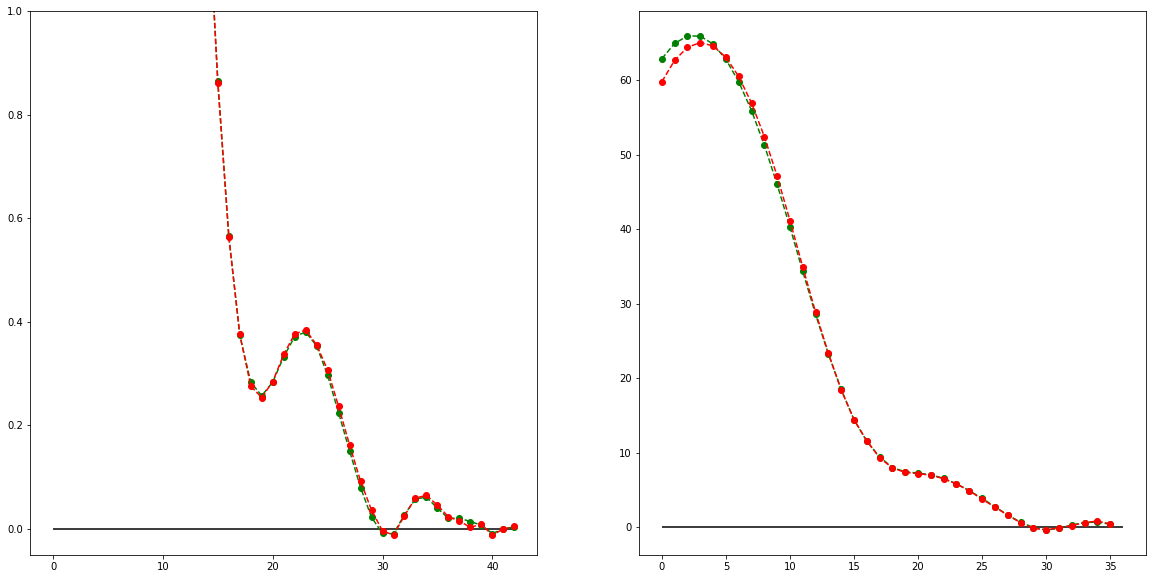

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'go--')
axs[0].plot(np.array(b_init[1:1+len(pair_knots)])*(6*0.1**3) , 'ro--')

axs[0].set_ylim(-0.05,1.0)
axs[0].hlines(0.0, 0, 42)
axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'go--')
axs[1].plot(np.array(b_init[1+len(pair_knots):])*(6*0.1**3) , 'ro--')
axs[1].hlines(0.0, 0, 36)

11
[slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1395, 1), slice(0, 1595, 1)]
[-1139.19, 0.0, -1136.459, -1136.766, -1190.333, -1127.203]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


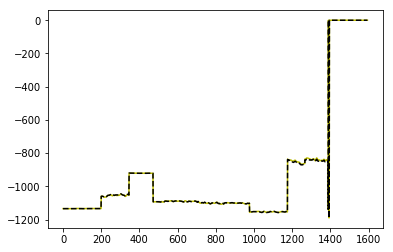

In [24]:
plt.plot(energy(b_all, X), 'y')
plt.plot(y[:,0], 'k--')
print(len(bounds))
print(bounds)
print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2],0]])

In [25]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [26]:
stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

for key in targets.keys():
    targetsx[key]['weight'] = 1.0
    
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, dl, bounds, force_atoms = make_input_matrices_forces(targetsx, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
    
    #Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)
    

lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 21 21 21 21
lens forces 8 8 8 8
lens forces 8 8 8 8
lens forces 10 10 10 10
lens forces 12 12 12 12
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1410, 1), slice(1410, 1418, 1), slice(1418, 1426, 1), slice(1426, 1436, 1), slice(1436, 1448, 1), slice(1448, 1454, 1), slice(0, 1654, 1)]


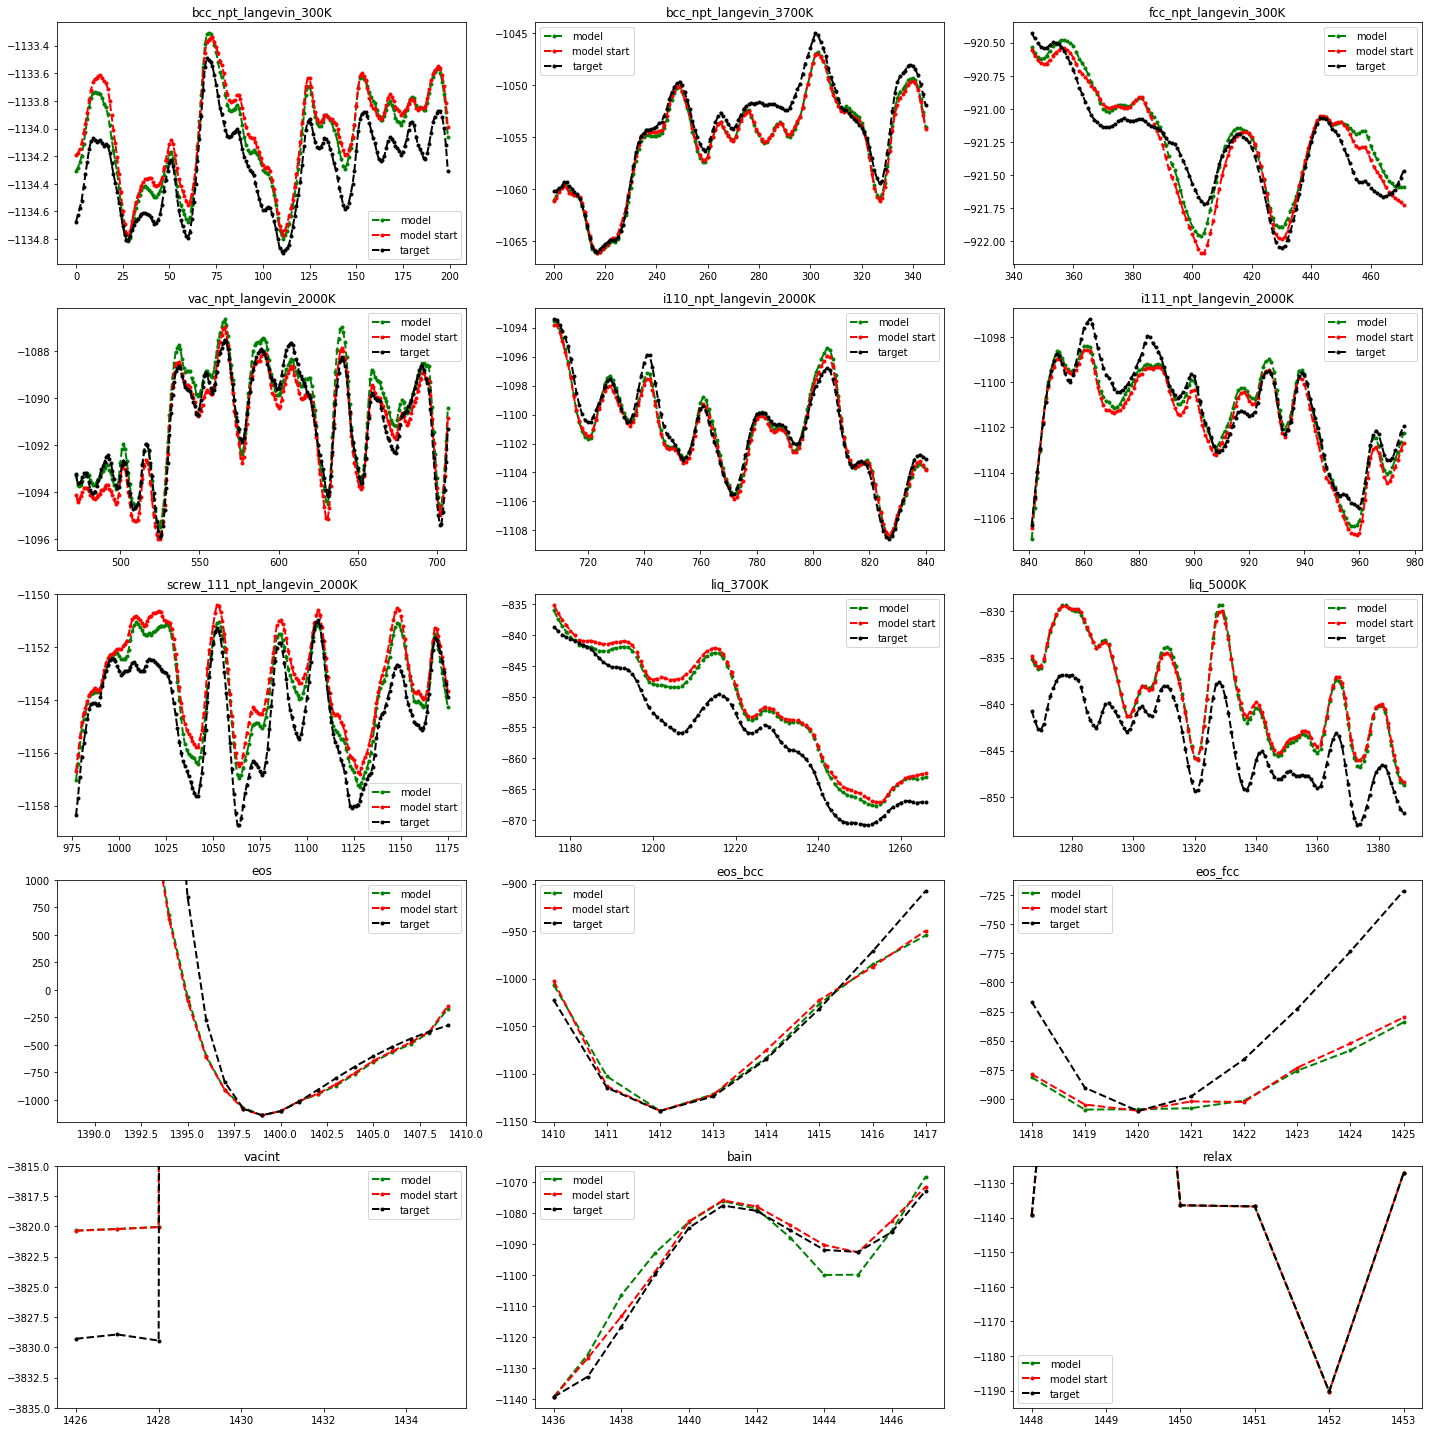

In [27]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'g.--', lw=2, label='model')
    axes[i,j].plot(rr, energy(b_init, Xall)[bounds[k]][:], 'r.--', lw=2, label='model start')


    axes[i,j].plot(rr, yall[bounds[k],0][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [445]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95]


In [446]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [447]:
M = _bspline_coeffs_to_tpf(43)

In [448]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.70886300e+03  4.12259304e+03  3.57906063e+03  3.07827709e+03
  2.62020012e+03  2.20464519e+03  1.83125816e+03  1.49946402e+03
  1.20834273e+03  9.56685136e+02  7.42745565e+02  5.63929928e+02
  4.16888806e+02  2.98925282e+02  2.09504931e+02  1.43399692e+02
  9.40626150e+01  6.26901649e+01  4.59379963e+01  4.22955980e+01
  4.74450110e+01  5.61621121e+01  6.27607854e+01  6.40538266e+01
  5.92405933e+01  5.11545355e+01  3.94111910e+01  2.70208820e+01
  1.53727510e+01  6.01895025e+00 -6.51423898e-01 -1.96239131e+00
  4.26692166e+00  9.95089568e+00  1.07995675e+01  7.61903285e+00
  3.87655571e+00  2.56248706e+00  4.73839748e-01  1.56625609e+00
 -2.05069517e+00  3.76063107e-04  7.80887170e-01]
[ 4.70886300e+03 -1.47128590e+04  1.53418665e+04 -5.33785923e+03
 -5.35912896e-02 -1.42237607e-01 -1.69627162e-01 -2.20834909e-01
 -3.45062533e-01 -2.89104361e-01 -5.36509678e-01 -8.48423551e-01
 -7.55331580e-01  6.52504991e-01  2.16249298e+00 -4.69363908e+00
 -1.31888640e+00  7.74341278e+00 -4.5408

In [449]:
Medens = _bspline_coeffs_to_tpf(36)

In [450]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

[ 9.97084770e+03  1.04472614e+04  1.07385112e+04  1.08447858e+04
  1.07686772e+04  1.05140156e+04  1.00859504e+04  9.49198691e+03
  8.74219820e+03  7.85512771e+03  6.86340138e+03  5.82305069e+03
  4.81184130e+03  3.89264570e+03  3.07115028e+03  2.40896498e+03
  1.93275259e+03  1.55547158e+03  1.32681251e+03  1.22853008e+03
  1.20129670e+03  1.16552183e+03  1.08827201e+03  9.67515194e+02
  8.19154681e+02  6.28522316e+02  4.52263294e+02  2.70721226e+02
  1.04504864e+02 -2.19952353e+01 -5.71496315e+01 -1.05399733e+01
  3.64071166e+01  1.06479900e+02  1.40121311e+02  7.62540584e+01]
[ 9.97084770e+03 -2.94361293e+04  2.87745516e+04 -9.30908127e+03
  2.40348092e+00  1.23782435e+00  1.31958910e+00  2.35545858e+00
  2.56818659e+00  8.47015577e+00  1.40825455e+01  2.34055411e+01
  2.17341551e+01 -1.48931285e+01 -5.71861269e+01  5.59235437e+01
 -3.49471264e+01 -1.13704319e+02  1.36732049e+02 -6.79358115e+01
 -4.10823177e+01 -2.02629411e+01  4.66570894e+01  3.09013875e+01
  1.79353701e+01 -3.0571

In [451]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

47 47
40 40


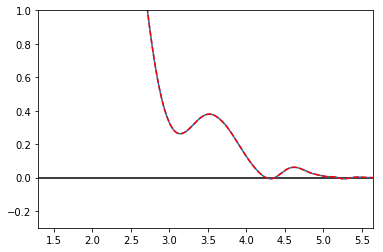

In [452]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

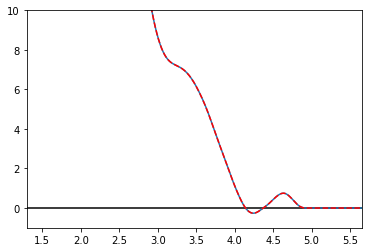

In [453]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-1,10)
#plt.xlim(1.5,2.8)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [138]:
tpf_coeff

array([ 4.70417226e+03, -1.46824509e+04,  1.52920592e+04, -5.31371290e+03,
        2.75700000e-01, -4.34950000e-01, -1.22790000e+00,  5.65770000e-01,
        5.31250000e-01, -5.84960000e-02,  4.57770000e-01, -7.09140000e-01,
       -5.39084000e+00,  1.88612500e+00,  7.92143900e+00, -8.70265100e+00,
       -1.76414200e-01,  8.78548000e-01,  1.04833050e+00, -2.79759650e+00,
        3.51721090e+00, -1.34113430e+00,  2.34659010e+00,  3.14159600e-01,
        2.76237500e-01,  1.81958280e+00, -2.12121780e+00,  3.61531090e+00,
       -7.26929400e+00,  7.36114610e+00, -3.53815320e+00,  5.01419700e-01,
        3.04814371e+00, -2.04485288e+00,  1.69951920e-01, -7.81472100e-01,
       -9.23652604e-01, -5.00379959e-01, -4.82324800e-03,  2.48777772e+00,
       -1.87878888e+00,  4.38625769e+00, -4.48551436e+00, -1.42744802e+00,
        2.36883188e+00,  8.13161226e-01, -8.43675194e-01])

In [139]:
edens_coeff

array([ 5.81825516e+02,  1.06245742e+03, -4.37746307e+03,  2.73564155e+03,
       -2.10920400e+00,  1.24243100e+01,  6.25040000e+00,  6.95300000e+00,
        1.77633500e+01,  2.34649100e+01,  3.42154500e+01,  3.03211900e+01,
        1.72855700e+01, -4.95944400e+01, -1.12848190e+02,  3.49766400e+01,
        5.87545100e+01, -1.68032490e+02,  1.51541600e+01,  1.30925080e+02,
       -1.85963190e+02,  1.32261063e+02, -3.62713640e+01,  4.75708680e+01,
        1.12611320e+01, -3.09730030e+01,  1.02880710e+01, -2.02827000e+01,
        2.57331760e+01, -4.43171030e+01,  3.81936290e+01,  1.21280920e+01,
       -5.40750394e+01,  6.25679868e+01,  4.99428295e+00, -3.56890978e+01,
       -5.07922253e+01,  9.47527636e+01, -5.60769478e+01,  1.63239560e+01])

In [140]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [141]:
param_list = [params]
#param_list

In [142]:
file_name = os.path.join(working, "params_final_forces.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

No existing params file, creating a new one.


In [143]:
file_name = os.path.join(working, "params_final_forces.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [144]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

pair
+4704.17226d0*(1.05d0 - r)**3*H(1.05d0 - r)
-14682.45089d0*(1.15d0 - r)**3*H(1.15d0 - r)
+15292.059210000003d0*(1.25d0 - r)**3*H(1.25d0 - r)
-5313.712900000002d0*(1.35d0 - r)**3*H(1.35d0 - r)
+0.2757000000001426d0*(1.45d0 - r)**3*H(1.45d0 - r)
-0.4349500000025728d0*(1.55d0 - r)**3*H(1.55d0 - r)
-1.2278999999980442d0*(1.65d0 - r)**3*H(1.65d0 - r)
+0.5657699999983379d0*(1.75d0 - r)**3*H(1.75d0 - r)
+0.53125d0*(1.85d0 - r)**3*H(1.85d0 - r)
-0.058496000000559434d0*(1.95d0 - r)**3*H(1.95d0 - r)
+0.45777000000089174d0*(2.05d0 - r)**3*H(2.05d0 - r)
-0.7091400000003887d0*(2.15d0 - r)**3*H(2.15d0 - r)
-5.39084000000048d0*(2.25d0 - r)**3*H(2.25d0 - r)
+1.88612500000022d0*(2.35d0 - r)**3*H(2.35d0 - r)
+7.921438999999964d0*(2.45d0 - r)**3*H(2.45d0 - r)
-8.702650999999946d0*(2.55d0 - r)**3*H(2.55d0 - r)
-0.17641420000006747d0*(2.65d0 - r)**3*H(2.65d0 - r)
+0.8785480000000234d0*(2.75d0 - r)**3*H(2.75d0 - r)
+1.0483304999999064d0*(2.85d0 - r)**3*H(2.85d0 - r)
-2.7975964999999974d0*(2.95d0 - r)**

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']